In [194]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
for d in ["train", "test"]:
    register_coco_instances(f"newTestKit_{d}", {}, f"newTestKit/{d}.json", f"newTestKit/{d}")

/home/student/.local/lib/python3.6/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [8]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("testKit_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00035
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

In [9]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("testKit_test", )
predictor = DefaultPredictor(cfg)

In [19]:
def _create_text_labels(classes, scores, class_names, is_crowd=None):
    """
    Args:
        classes (list[int] or None):
        scores (list[float] or None):
        class_names (list[str] or None):
        is_crowd (list[bool] or None):

    Returns:
        list[str] or None
    """
    labels = None
    if classes is not None:
        if class_names is not None and len(class_names) > 0:
            labels = [class_names[i] for i in classes]
        else:
            labels = [str(i) for i in classes]
    if scores is not None:
        if labels is None:
            labels = ["{:.0f}%".format(s * 100) for s in scores]
        else:
            labels = ["{} {:.0f}%".format(l, s * 100) for l, s in zip(labels, scores)]
    if labels is not None and is_crowd is not None:
        labels = [l + ("|crowd" if crowd else "") for l, crowd in zip(labels, is_crowd)]
    return labels
microcontroller_metadata = MetadataCatalog.get("testKit_train")
microcontroller_metadata =MetadataCatalog.get("testKit_test").set(thing_classes=["NEGATIVE","POSITIVE"])

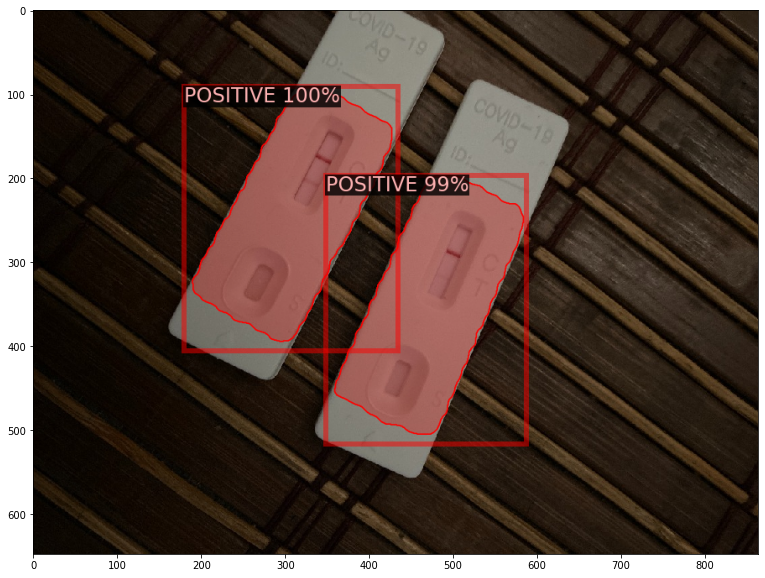

In [36]:
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import GenericMask
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import date

today = date.today()
count=0
im = cv2.imread("./6.jpeg" )
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], scale=0.8,instance_mode=ColorMode.SEGMENTATION,metadata=microcontroller_metadata# remove the colors of data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAcYAAAJCCAYAAABaq2d6AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+j8jraAAAgAElEQVR4nOy9W69mSXIdtiJy7+/c6tKXuZHikHORaIvDIT3wFTBAAzbGIGQIAgwIlv0D9OQf4N+iB78YBuw/IMDPFgwYfLFIU4YMwfSYQ2qmZ/peVeecb+/M8EOsFblPTVePnpr1cHaju7rO+b69c2dGRqxYcUmLCDxej9fj9Xg9Xo/X45WX/00P4PF6vB6vx+vxerzepuvRMD5ej9fj9Xg9Xo/X4Xo0jI/X4/V4PV6P1+N1uB4N4+P1eD1ej9fj9XgdrkfD+Hg9Xo/X4/V4PV6H69EwPl6P1+P1eD1ej9fh+soNo5n9sZn9SzP7V2b2333Vz3+8Hq/H6/F6vB6vL7vsq6xjNLMG4P8G8GMAPwXwJwD+64j4F1/ZIB6vx+vxerwer8frS66v2mP8DwD8q4j4fyLiDOB/AvAPvuIxPF6P1+P1eD1ej9cbr+Urft7fAvCXh7//FMB/ePyAmf1jAP+Yf/1316V96Q3NDEev1wC0ZlgXQzMDAIwA7rcdfegT/C+/azAEftVzNjPg6FEf/pq/irrfvPSzqC/l347PsS/4/Bx/1M8ffvv164ueboffHf8En/+m771+Hd+gPv/6zV//rPH/f+UBnLjDTQOcX+QX6v8fXFEPDwAIO9z3OD9vmAsLNLf6zNYHIgz1qNfH8wUj+JWLX5bMPVyvf6M7vPnWeDi1KX+8d82VnhRf9IUS0ONoXpfs17/24HcPRD7vYg/+9gXfPaxfIOfG7OHa/Mqg6nOSjdefcpClL3qjLxhIPJAjO+zRL7+0Nx/+7CDz8SXzdbgHn/rwl/Err/3Fz3l4s7llXlNBx4+9+W1e/4w9eMeHv4/XZxwPJ/fhJ63m9bUBfcEEfdG8zjmJX9WvAF/4tRd47TNmhubAujjGCPQ+0BaHmWHvgd4PWi/m+xxl1BA4b+OXEfH1Xx35V28Yf+0VEf8EwD8BgNO6xDfee4oY3KBu6KOjmSEMcF9yyWPArQEx8PSq4fu/+QzPbxpe3d7h9m7DzdOn+H9/9hL/+sOXMG8lcWMMuHneGwMjAs0XhAV/Z1w8TSyw9w4DYM3S4vL3gcCIgZx2h0XANU5zbGNPoYpAmHORcoPHyNuMMWDW4E6DPgLASLfe8p4yKCOAEfl53SvGQFsaegyMHjBzmAE9OgKBiECzlveIgGsu8tul1Jo5zHM8QI41DIjR0cwREXB39Bho5uiaR2mSyLsNjtsBWE4LIvKesJyzxVO4G9ejIMDBlsIGmi9YV0drDff3G7Ye8Lbk/QzwXBX03uFuODXD3/r6Fb72/BInc4QBf/nBZ/j5Jxt62DTMAYyjMXEqWP08DM1brq2jrH7KRq5RHx1wgyPnpo8BM4e7IcbgfdNAGwZvYXBrGKPDPdcpRWeOycxgAbh7ro4BfR95rxg5v8GxUPm5GcaIXK8Y2lMpC37AJ1znESkfoBHx1hB7h7eGER1GUillgdrKItd7jNpPg896HUC5He7Dd4vo0IdTTnNvA4OK1DFiwGGlEwMBc8/5HIGBgLmArfBDILeO597juPSuJecatwXGCBimfsnP97yHt3xvC/gAOgft/JxbQ3PDvu81xwKHzROcuzXcbztGocyB0fP5kgspAbOcrz4GWktZGhYYHdQJOVaLfH5rCyyAGCN1gaf8D+Te9kgZsObofU8d6QaLh5Ap5THn0Tz3ex8diDQy3hyN+9Q9171ggOyYGaJ36oGco713BAbcFspjCl8D72+B5p5jlHDWWvI/lvOj+XVPSW8Y+Nb7N7i6WrDtZ6ynE17eB37x0S22+533A8xGzn0MWMv9Jjn66c8+/wnecH3VhvGvAHz78Pff4s/eeAU3AGQIYIClNxhUwIGg7Qq0ZlgWwEfH+byhLSsCwNI85z1kFBxhUiYAQMWGQO+5BcI8jV6MQjcOBxzcuDKgDaAwj5FKRus8qOEbtDEpRLonDOZpOJo5BoCQACIwhgHuMG6cQn1U3hgdaKlYBwKj76WdwiLH7KloGjcGNWoa4nxMKgvLuQ2Nj8ZGG8hhVNKpnBDAwEiPwUu90BgHN3qk8isjPA2tBdDHNMzuJrMIABhUoA7D8ycXePf5DVpruL3b8dcffIwuI0XV5mY1b5cXDe88u8BpAVYDmhm+9e4NPv78E7w4D3hb0riPwekyYAyAc+/uQO/lCQAJcAK9UOjoadQ6R6G1Nec4ItBaS2UeyPWg5jSCI/eWz58WIH9+9KCNc1RyAYTRhEhxcD3HCLRlQVCGjeOgpD00YAUqaRTGAAJoVI4xrAxyjlnALt/BW6MMlA+bP+caxIjpGRw8bbc2gdraaIxypVMfplEckQY4Io0ZCAylUHvvpbAB7ukImBHkESiYGcxyb4+t0xjlYBOQ7QgDRu+c+5YvMhKUxkDdO2ICqjRy+WpGoGTWED3n8XS6xO3tLSIAh2PvWwJcbzWHApwGzz1lue+KkQiD02hpgs0dLvAUqM8H59kohwJdKYcrIkbNGwJwb3N9I2Uqx0Bfz1KXJjzn/iRgE/CofVG6mXphpOwlcO6ItIxcB+2llFcjiDMaVVBuGvWBcc9EBGVgYAvgg09u8Wy7RvMFt+cdL+46xj742YHmhuaOrXfqci3r3Edvur5qw/gnAP6OmX0XaRD/EYD/5su/kggyJyoRXEQgPBfRHMBw9D6wNMe+D7w6d7xzveLm+hLbcNzdd7x4dQfn3IQlsjIaon2MqXDogRhyUvee6GOMSAE1LwMtBJRoDUSs6c0F6PHFQEcqm2Vp6L1ToeMB/TCkvAIUQEgkaFIplPRCrk4nLGvDvg8MCzgM9+czQkKNgRiJXFOeaPT6RP55bxqp1nI+uUvcHRZHxD5gjYh6TK8pYswNQwDTBz0PIL1JT4+t3ECtLFG8G5UqPR3+EubA4o6LFXj//Se4u73Fi4/v8PTZOzidVtydiVAP3q5xcyeEcYw+MDyVhvkJ8AVme865jCIR5JGGSzC1oPcdgYHWqHTK484xjgCWpXH8aUEWk4dnJW9uVgYEfK4ZvZfWqMgGEKn4UgnHYaUC1hpkcCw8HTB5TARW4VQ6HmVQltamjBWgzKu1BnPDPnY0bwUQhtYtnWbOSMCawQbn2Gl4Ryp3FyAYR9EeVMCGLq9mjPKgpVzFQuTS5/1ba1SYuRYRwL7tZdhyrw16QU4GRyJGI+ZWxtXM0Foq2zEGwdko2W1twU7vH/2g8D3Hnl5+ypTBABlYevbyxGvHjFFAL4wgn593GD3D3H+pX6bXmjKZhk/AfScQG31AoCYAeKOsDzFWB8+dcpVMRbIZ8o776HwevXYISKEAlJyPtCupL9e2YPRRxqz2TbOa9xg0UJQhgXM3n/uO+kMOi5vAMT1kOg+pV/hebsBImT3vgY8+u0PvAcOAUwcXyeeOEQL3abQdDQOg3njz9ZUaxojYzey/BfC/AGgA/vuI+PMv/c5IhFB0EsANE/BmXKBUAj0Md3B88NEr3KxP4Ga43wN/9fPP8PJ2R2sN+44D12wT/diM/xkNQx87EW6iUCDQaQhEwwYiaQ8qViGgEYEYaVy1Jbato7X0byKQ4xeqlvKDKLyUBSm/ol/DsHjDzZObNIhbx7qu2PqO875jjL2UttF1jUEvp1BZzq3xd4MIS5SxNr+LpnUH9oEgMBCGTNp3Id2U49bb9r7D20Lal5QvAPiBGpSLASmUoOcV5dhqTRZ3nM87bu867s6fogeweMvNh6RnBhG3t4a7c+CDj+9wvQJPry+x9YGfffwKd3t6OoWyx0h5Sq1Q6xghijU9gdYaRo9JiSEZBSFnd4OLlUDayB4dFpbfHZ3z2tNzBy2Ok1Yub2AqqsW97t33jrCRigvyxg09UGOSZyaA1fj7oDy5O9zGBElSfjS04D3Dk/4WZVYetfYKoozF4o0gKgg86blwPJLnhCrGeZ77bnC+rTkB4wwBHOODQQudxlf7zAFS0/KMQLlyrgEiCEjowQZBXjnkBm9GIJueqtF7KhpPd+gDSzPKvrzqDkQaucUbEL30y/39jn3P8TVPOlLvHDb/vvdRc9fHSBofHc0b6eB8H3cvhmf0BDxjjKKXxSyIbTBv1JcL75lGcWAyIyDNbAZZ79RpepDABwR6onRy4o+go5Dj652OxSQJUMCO3rFYBHfDgMNDsiiWgN4sZTd1ExmysALPEVHvJNbEmyel21oCmKJUqVsRyR6OgS+7vvIYY0T8UwD/9N/885lMM6k9IX1x7+Ti+aLnPvDLz3d89OITrEsu/PncC7mBlIeUkQQi6Ik6NbKoFzsY4zE6xuhoaNy4B1pFitkbkgO3NII0okZUe3NzjU8++4xCOcPhelaQDoyeMRV4FBIMyr6tDffnM87nM0YA+2cv04NGIMJpjMdU7uZopFo03EGDMJLngYclw0qh1z36iIofpjEjFRdSTlHIVPOQxnTGf4qG9nxGhqcC0dNDdOR8m3tBEyBjezEC9xvwyWd3ePb8OXq8xItX54w3EPX1QTKTcyBK5oNP79DCsC5nwB33W6JymGj1jPW4KGzknBvdjqK7D46uO43KCFJuOScxDLYkyldc0aU884uUo4WUfW5WpzJKhNyO2oQoOqOnrS00MlQFRs9yJPNRckqvvS1LoWcgkpYmw5J0txeVtu/7IZ6OMkDRDNb7A88uNR7nsbxWGiHMmOioOBTHyns7AqOMe65xh+YLCYyC+47fG52GlWvRR697xhCwIu0pmhuHZLfIeFn6FZraY2KIl4eVMm3F2gyC5LGn53tUwlDug3HeQT1AENpjgpwevTxgzWHgsEeg/2RcpdFzNHfYAD1X1D60knVpj8wf6DEq1g16xo2ALUZ6/IipS7SHAsAwoToCCe5Zmln0naGDnk5GH3uyGNQh5RESZAf3ZmsNFiRF3RB9JwhpiOjp6JNtSGPYER3zHQGAOSSAI2Ivtim9fUeEYUTnn8kENKdxpDQMMllmDX2c8WXXW5d88/qVAfZEBZ2o++DvVZxMYqkJ6ADOvWdcDJ5xjRgwS1S2LA3og8a1oTVH3zOxpseAl1IUfZjK2xswIim1Hh2LKRaYBsI9EwpiAEsDA/25iOtpwfl8j6XNjLkgnRGkhBw0/J7KbtAdkL4cY+C8DZxOJ6zripevbpNKohoKEKHTe4MMvygG0mit6EMiKs8EGAsZWCJ3GJFXTMrD24yNmEGB80z6oBdFTxikRhYAIpZ6H0WV9RgCppmcUwlRnG8i6U9fbHh537HfdziW9C5MSimpTAGVCNFgAVjDNqK8JG34gKXxkCLE9NQzCStj0EbHziw9wmQC0pC5ee7VlnGboAykF5jqM6cgjTGQYAD8bvkjfBdvLT1lxjaNNNAYgWVN78F6UqZSbpkoZRCMnklOVDaDP/BJmys2BeQ8LW0htTljgzCkJ6P1pIdp9HDHSMXTvMEc2EU9AlDW4Ez6adS1Qv/Tw0vvquXe9pYxsH2HKRaGowFIJW/WiiVyJpwkYwRYc4a5KB/hE/AY0tBbKmQ3ejjIsTZvSRaOgYCnoYiAB2WBsO0YC69Yf8wYaxrLjL+KurXIZzWTjA4Ag2EXAiTeLw107s3oaTjcLPMUKrEOaShSpGFkKCh4kOULJZ8gvXLRn/LCMokpf5+6h167GzLEb2QnAj2TGip0ovUa1CkWwXcaGRuldw+MyjmwIQaFc2mZBCWjKB7emCRk2tgelUdSISaCaelF8/YQNFFGUpdSn+RbHuLMX3y9/YaRKErUm7K1UpcooSNdaLmAonu0CSs2R8/FzND7KAF150SSdl6WE5F+GqtMNiU0juT00YGFVGPve3kWGJH+QEuUmELYcVpPcDOcz/c0IrmQGdsDxw3G75yKXqjbmdlHLyoGXr58yT3gRW+K5g0ZL8VCOZFSWpzKFEbxNDnbtTErMSg/mSozpREp0IQmNKxJOU9hS6opMGx6gEaAk/dPo9usFbDZd2Votso4BL0KwHHeqEhHUEHSM+HfXbG63jPBIRrWdU1Pn8bwcl2wbTspG8sNF4BROQeCFGYmLyi2DUyD6S09gQIwLuUhWjSwMRNTnljQ85DRUvKMKM+IwGKO1gyDxl00Mg7/XZjwAgQ64yoRAV+YHTo60laTnM8kQpzaUpQmLJPUDKlQlmWpDExGpxEWWBlvmh4gvd6loe97erEmY0HFRos7Rhr2dmACpMBHJP2opJvmxjk0Zm0kiFmWhQbTKZujANDYGYNUmCVm/BSUXEQm0ilmO5RopPkN1HoBjIeDAI6edmstATP3UxCIi4ZGJAivcCMU10+az0A2aiBZnfLK09CL4RiRsNE57lLcljS1GTLfAQJCygQ+WEYkqAKi5LFk95BVLC8ynYAEo0nrJhAdTJJYyChFBKI5GFQu46Q9kUaSehaeVGX+lgZJiUlyaVCg9qF858/haeQXX5K9a1YGDzY93TEEYgKwBFLepk4wS3uRGeaZVT4QiD7p7jddb7VhTI8qiGaTHpLw5599CsTYMUZgbTPuFfQGFGgGhaWTWtEm6XvG/tyAffSMrWEwuB+FfscYWGzBoGeZwtcQDmYMJjU1QpQSUX6ksn7+3vv4+KMPcXe+5/tRaKicex8TdUdubsXjRhhT5NOoDHSEgbWag/RFzpuUgsTNHRXvVHRA2YqZfKlMvUS3zYVMj+hLyRs40J/0QDrpGgqjUZGaeZVhpOZg8ghIkcns0+tplopUayqDn1DDsSyOONQsOWPNCJTSS284PcilLbi4vETvHedtw83lNb77ve9hPZ3wp3/2p7i/u837LEvONedBiTAx0tBqHZIRMHopSlBJwz56xxiWhjg6rmp9nd6J7mHY+obWFs4RyqM/LfndMUbFITOD0+i9BoFcGrF97Ml8jCw1WlqrhIoEkumGBww2REolhb73ngCgykcA0EvtBGpj7BgxsC4rszM7wqanvdM4qtzDIo3m3jd6xPT83dID2wZZC8a8G7KkwAzbvqGPgX3fsCw5N310LG2BYngwRx8bnTIpy4PM42DEGfdOcVJZBormBmlOsQBuaRBGDMaKg86LJkfU+iHzVdzmQGYck91JgGdV7gSBIkQ5eTb/k3oovMpBQGMZg1nvZJTswJbJC5aMqdRJGdUxpnwqjiua06h8xpHRCIKZNkHeYLywEn4YC0xjG2VAM/TTcx9QmIJlLooX57tPEBPUb8GY7IhIR4E0s3F8kSJL3Ur+wFDrNBiTLVaB3nElh1kazeZZBjPQ4eMAbN5wvdWGsTy6gtlJ70jQjAZLk7G0dkB6C5KLnkKdGX9RCF48fGOhqDLYRHGsnl5Jp5AFEsm0xbHve3qwlsYafqjDo/H2kYvfSTV8+OGHlXnnrTEwPwoRwzIBoegrMImFRiwwgHAmO8wY2yCSlhHrXHQnnRPMcpsxpAQcTOIipdThi1N5BNF5FK0BS+UqBZpeD+MjNLhmmWSjzGFwox0RPQKvod789+QNi5KqkMo3RuB0usB6WnFxOuG0nrC2Bcuy5OZdFkiJNMvN2COTsoT2W1twe3uGtYb333sXf++/+GP8xm9+C//j//A/4+c/+1kmWxA9DwKFpeW2sGDGaSiKow25oBlYQkBDznlK2jHQlsYYIDD2rRSWN0dYYGkrYgxsfc8pdcPSVs4RPRP4RCGHutmqJyWlO3pnHo/TSwHjndPnb9aUtAn3BeidSSdRyh7Mkh17xuRDWQ4GmO7bDN4W9G2nImW5RaKTTLjygZVgIyh/BsegQuoxyvtrkab7088/wy8/+QQvX77Aq1cvsPeO83nHvu/Ytr28lAqJNMYXo0hNGvNBmRDxOWOACbJZd+utEts8FOMXGB+TYSHDgTjS80hlbQp1GMJVFzr3f+kB7lOV1vSxJ7sR0nG5D1sZ3cwxkBtlh6QwGDNPI2Cci+D7yweS5w8QbBP0JksGltlEsTzlaVtyQz2ismiT1yFQpcEV6+DNytDDZLy5F6gTATwE2NC491z/1jTLyXiZV0KiwKgMP0wJkjSATUZ5ApbRewK30vtx8PJzjw47eORvuN5qwwiwpgpc2H0uMmUD8sZlGAKBnenJKqvoTJSwyAJpNIMZOyb4AhOF0gdRVFICHZmltrQVgZ0PysVX/dR536mUuRHGKNRFW87NGBixwYanYiHaNXoGE9Fx32kzeib9RG1OBvfBmkV5ekS7bWlQuZzmrxM47NFLgQeyWYHzuaU4IrNlezD7dwg5K9ssAM5lbkabMVLGfuRRwVsJe86D4li8BHy8YYSAjeFyWbCuJzx7+hxf/9rX8O3f/jbef/99PH/3Oa4uVlys6+GZ3FSkg9ILzgSBfc+azvN5A7zh3Xfewe//8Ae4vLzC3//7P8bHH32CpbWcMzCZRRlw9PBGzzmFIUtd6N0KAGWiCuN3zL7NmZHBUWnC3JiV+BEJtJwALJFywd5axB49DRImbZ3zvNCAMnsZYBxe8cqcjz5mJnV62gscyRRkMqqXcctaxXyymJRcKqcMkD3o/bDvWikgby0N97Ic9ie/Qzqvie6KkZ5B77g/3+Hzz1/g448/wc8/+Dn+4ic/wc/++l/jxatbvHz1Cr3nvkaothEQVQeAqfmp0P2QdSuPP5V5jkVgGSaa87DeztWjsdxZmiGjqCQ8QIltjEMTgCSWzLVMmxr8Gc03f67cgzKcZUwF2HP9l6Vh7H3uGXlEodhm2oBBzw0DlR1dSUxQsph056RaBZLFkgjEWxwS6zgW6diBUTHqZLq6csug3KLgL4mja3/pZxmbNs5lJivOZL/8W+87n5HOgacSYRl26umi//tW2dAq46kMelHfYQxVHbbYG6632jAakufOZKRUnIGkKmRwQCMBUIGA3o2SSzALU8PlsaSgLuuShrL4GBaLy7tBUquorMf07CysjCP8IIA0CpJWJe8AHGKIklTKcqOQ+pS/uqZHq7EkNZJjz4yrvZI5Zur6XPEUlobqwiJDTaudNjWKhoDwGFGlYnzF5wM5XiXMMN0cZujMsM1IlMP8EF8IMCOWnScwDfzaFrS2JHK0hifXz/DuO8/w3e98B3/4hz/E97//O3jn+bMc2wjkzs9BSvgtEm0aEnUvy4LeOz759GNs5zMAw3o64ermGhfrAsfA177+NTx7/iyTITQnh7XK+eK8k8JMb6tR1mhEcmGh0hezVl5dRCopMR8CeFqnCCQduSzw1lIRDKXGi/3Iz6ez6GX89z6VpR02+UxEOyR40TOoDD6w1lT0XtFKRPWWStdkhDX3nokTMs7O0pJjLaJi0/J86p4x6vdOi6p9EDGwbzvef+9dfOtb38B3v/s7+Lf/7u/iL/7iJ/gXf/5/4S9+8pe4vbvHuD9DDQkqmcNY8jQGjTyfDSaYkZHQ/s4sbP6cegNkPMp4gun83OcGApqhGkytdb6rQgfyUpSco3lRTW95s35gGYCZo0CqMuldq98591DWVKO+W546AXOMmYkpWeh9lHeYIYbOPUxGCRlamo0QCBaMBh5gpx5pzRlbH2I1EFC4MzvdtHr3pEilO1G6LOQmE4wNBGLQkHFdlacQA4jB2HtnJqxn+YkcPzcvcKSOVbPevGd4jd6zgOCXXW+1YQxw7iicFTdxbX0ggqUYskd+yKZj6UTV1hyMjOJtTgSYCGa64wfHlEIjX5zJAxyPNiIsP9eJYGSIgFkflYNOA2E0enk/onR+oY+Mo8GkbPLzi9eAKHhMcAFmFhcpIABwtFQgmMpLBvj4uZlCrhpLFgFXxi0TXBa20RISJ7o1c9b59Yqzui9QUBwmGio9c6cn2lxr1NBsxZOn7+G3f+vb+I//6D/Cv//v/SHee/d5xs/6ll199oxNhR3aqumdqQSaO06nU1JlS8Orly/hbmhtxdX1JbJV1YarqytcXJxyzrkWNW8EA/2g7PSvsZBaBeqAskpLWHmnNefWapKJl2Q0kBnAJsDTMLCgclWZdJBKLKpEQ4NsLNPA0SuImDFKxmuOQKjipzGwBig/SHAkmhYCQ1YZwoPUuhSWPIz8AZPZ+NmaLr6y2SxZGjQmSvoaIcMcWJcVfXSs6wkXpwtcXl3i+dNn+K3f/Bb+j3/+Z/jnf/Yv8Ytf/hJ936sucdA4K6uy1z7O9x3Ber3W2NDD2H1oXk5vFlxvM2WEUmHTgxp7ei0jMoNUBmECi5mcVIaYV1dJTd0bCM9Els5SmRxygrNBZkLMUEegBQjE2WDApI6s3jdbw+W7KBTTLA2KkE7KF8NFNHBtWajzRBWLtUjw5iqjkocq+fSWuhFR9Ge+/yFb3RiGis7wVsw5IMWe4YCgAfN6LgDWAeeeG0gdpJIaZZ1LJjEycW4fezk4qeu89qiaM7y+Rq9fb7VhTF1D/hh07x0zBd0OmxiYsSyPiRZoDDNrFeVDE7zBmrrVDFgfdT9tjtYaEaNzs2lBZfxYczTSawmzSkSB+WGTqZYovdigwUjgouJW8JkGVBaWpDHfRZmr++hpqMBmZJFq+9j9wpcFPoIFtEFDnx6fKA5A6MwQ1bIkAGfGn1lSz24YNmpj5PPK8jO2QgMxotC27o+I6jCUoNxgvsB9wbKc8O7z9/HDP/h38Md/78f4vd/7HlZPhdP3HWOLVGinNenuGNjOZ6yntYqgIwJYmcRDSvbmyQ3WhR4OgNOabbF6Z9IKMnFFoCtktMBpZ6eZTD3n5orZnaPoKFh5HMfYVs5VcF169ag0JvBkScvB47MFQswR8oYG48ExwR3Zjpx6UZJ5iz0dHage012UWW4oXxgnClRK/bCZDEE3MbcK5zK64m5gLF3echqlMbKgGnBtyQfrn+5bQ1DdKPEmyMRk1iPQYqD7jrY0rPuKi9OKi4sTbm6ucXV1g3/2v/4JfrF/kOzAmDE/ZVYnaOmkAWmkW8Pe99qrIwZWgrZSqND7H5NjrBJkBYt6qEVcJiHl/w/MKJzWLko3CRAF+vwUaT0BhcDAiGwOoA5Yc3cZYANbdLgt8Ej90HvQi40DyJ4GTEZ1gr0D3e0tjSdp/cHwz+TfRLcAACAASURBVNYzvNOOBnLE9EUCs8565D50OOlhesui+yfshoSv8/7ZizbrCQHpQBSYK6+7T9YtGTqCNRe4bGzMAvkYCTJpHjxmiCGom90XTumBnv6C6602jAEi7ulsHTIZk3bITZ3ZX52fcbD+jVlTTWUJpokKUgEpt2MElmWFslwzQw2HpJeMqbhoAygDSgW8Gh+pFSpCOGkjU0ZhsGVbwDCAQ5/FMMCZDQjgQLeozorSYw43BseDHuuYVKhTQpL+SoMrRak2X8rQa22RrwGzTN0WVVO9C5lyDiJrgQanodZ7e30WmQZ7QGwq7VAnl4xBnbCuV2je8Oz5u/jhD3+Ef/hf/QP87u9+Dxb36PueyRXN6fkyocgbEI7TmspNoGh60KRsAliXBevVNUYQHbdMmkrUKA/KRTbMlm1BY1jIWVNPIIT0PBw+5RAoj8oAUnGay/SgD2kMZQ2rd2klA3DdaaBMsgtDx8haU0w2oi1Mo6ecruFo0R6WzvCfMCWgtUxwspQVxRuPSqg60vADg+/ZSGNVqodFec6Kh+eaq6yEn7FZsiHjEabQApkEgdiRjfSXpRHkBH70o9/Dvm34Z//b/45PX3yOfcsm1BE5d9lU2+HhMA9s2w7FPp2eillgkSGuGJ/AcEDFGnbw7nv0ypTOggqCsGC/V0xDGtyLYWCi2jSU8qzUMrKUuKtWmF6WiCmCoBFM6sFAdqlKQ6P5PWZIt4W9T8G4IZPQxO4YArY2jJ0NFYLrL3ZAiIxtEI6AcB+j6g99SDYJprlulelLr6+PjmVJCrri6px/N73/QcFj6lIBwu4GG+rG1QkmZkhjeoUpTyz6xNXlVdZ5f/55hW3CDNYHwudOfNP1VhtGoRe5vQp2a9JTXkknKb1Yrjk9pwSTM1gdVJwspcpWVm3GRJS+nkXQ2T5LLa9EJzWbmYrTA8qh9c54kLfqsiE0nwgvPQdzTPStLWYi0hiPcG64vkMtkpKGYcyG6exqSAwZBW5gUKmmQsq6quhRFF4KdMbLGhhLzKqsQm65v6MSSOhXJD2lFPgwghaAr5HzeagtBY0qPFOnM8BuuLy8xve//7fxD//Rf4kf/N73gL6jbz3Hz9eCDO/oEyxhklmpzxUTpSeBRNK2tES1Yxq4XC5Sz4SUD/0+PKi906Z2Gj0UtTkHUGVnEyWVUmzqxExZFBWfqNYnpj5QWAIoqr8yJG2sBAslmsmA4kDVNZuGUeApl4A9XadZK+PV2E8VBiZqUK4j7a5Hmq7ca0ejm9Bc93Xep6iuECU/nSjo3Tg+HzkHI9gy0QGzpFZPkFcT+P3f/7fwiw8/xJ/+n3+Ou7ivhKsxkLWtMFxdrWgO3BnQh+G8ZQpdEMxBiVDaYwoXdGUqKs7X6jtpoHLYHQEbwcJ9AGxKllmjCpFMmUm5V40nKJ8LOmukEarysJK3BFakykse87NiNHIkDpWjYaCyaQHTa1EMo3TkaV1wP7YCw9DvXAczAFU7Sf2hPAJR/uqp7FVfnfOgGK0YKGNWdBOrQsYlS5WkFPm+nLck7aKycLPBuzHbmXLoVi5s9BmW6NS4atz/9Nkz3N2+wnbO/rpqrK/M2y+73mrDGMGMJ/Oa8EFE4+oTSGHJdHihdXZSqODsTGaoeiZE1s2EDEfHCMOIPB5qbQuObZtmE2jUAqcnONG+YkcZgwNSwTljf/n3RoPQR9LCShKSWk5Bd/iYwfW2NGRnjVFJMMuyYOz79Oykq6hca5OJbgLKO1I3CvUwRTBzUQYWCsKzoULP76uIW8kH2R9yKSVd3w/VX1IB0ShWo3aOs7UF3/jGt/DjH/+n+NGPfoDY7/KoGn0Roi1zo6Ll9lOKvIy0Gk27eTVxkCdZySBO+pDvIU/famei5kZJTzJ6ohp1mRla2MyCo+EpTyhmDETAScxHGmw2rEBuaKvXzefWcUoEYShZTUQsKlfJXEdPr4xWDViyN8pA0sxiPjlRtuRQe03KKec1ZZ7O1MFAHuI9mrMHzz0YUcWkD7V9YQAPSgUG4/ehZArAVkNgxboueP7OM/zhH/wAP//gA/zk//tLqMYZ9ZjAxdJwebHg6rTi7rzj0xf3ZAhSTkBZDnZ48hobEhSPUSA7bQTblsm7M62Pmo/TSwsjmJKxtpqXSKoF6qwk0MM/ZvIO6Nmr3g+ToZEN0xoaZS0TctpscBKAEurkOS7LgmDrQemXGANX15e4vztXicl05+UYROksIJjgFgUujp9XnDMz8Dtam3HqEVF6Yu9b6jfP/Ii9Z1w4nfUJvQPJbNiYBzwQVeRa9tmv1ugUOFJnjg7c9zN++eGH8/g9GHvLZhas7vim69f9/m/8orNRRjBRFPtH8oVrE9eE5iK1Kh+YCNYZ9Hb39CRh06tBboQsoA8qDzAgSc+pxmXsLpK1htVZwkTnMUAfAUQKR++5SQZmYN8wEZbORwx+vtDWmLReNh5Ib9abIWmqITBaFBXgLHmi4gslJAHyGKpYeaZ2pbcBQBTuIDUhxa8TFNRrE7Ay4AkiDv8SoCjhQgo8ef6G6+sn+MEPfoAf/+f/GS5P7KJigLecWyUszfR6R8FuoNa+qX7VylHLd3xduh0MPOj/jR1o+H5ujP3ObjaiCnPoUY9P4GpijaEpU59WvTO0JkAlckSNUe+GkmeXglG8yDRvSR+Zsz0Zk05Ew8siPZgizkd6PerCc6xMw/Q6qbEFAvNeAjfyOKzGIpmZ48/vZaMM0obBNmye88jBUHHnGjSzQ0ZklCFWLW9zx7KuOF1c4vLiAt/65vv4/ve/g3VpaM7MVinxYJH+yMxOQFS1vBMrw6Zz/fLtBu/Ts6a1zc+NnvWaKltJgKo1xowxGpCNC9hcAFHrrvWR2I3es+EC/x06IswI8iibAlp1EoShNPbgF9yWX5VNqIRnyeOmSn5Zy4gEvKmT+vSeOYYRO/d5/n3rG2l0LwAcoXfsHM1AlXQ5qnTmwMyWwRcSpWrM5yZ9xw8rqXHU3q8j6CRv2hcEHvku+W6DzNL57h7bvmdCGkGZssF/neV76w1jKTuzQ3o4zQ6NWPZ7zLhEFl4nFae6I2BuoAzCxiwyjsBeXUGQ3oZ4/zG7vwi9HSmqMQLB3o0AT0AAaTnpG0rroKeVFB438hhp4AAsZnDMejOw/g30iHvP/pEi/ejr1NwAydurHVUqzhzrXGSOmRRXIlAmaSilvH41UefgCQJCnBlHmT5HmSnNzWtzr5INQ/6ZPTZP+Nr738If/Sd/hK+9/05SJkdFwveSCvcmr5gNEI7GClT4NvXvRNiYno9EKpJOsZmMO69AvdfB2UFl2UHzbbXJ8rM2DYvPuZCBdPM6LJe/qI1d81bKLd9NnR3L05eRq7nhz2jqNFyvZ1opMyP9VAb7IMdBz7PAS0mXzmbEAbWjjJfWGgfgcwQEM3s5P2+hWkyr/an1Flsio2jN4Et2FXI3nE4rLi8v8eTJNb7/3d/Be+8+L68pwciCPgIvbs/4+MU9Pnt5j5e396RDAxE7yD3QSSZj4Ip/JQBF0GARtGoeZ4w/Za5qaKnMcwvOGFmBpujASGM5oL2XhrpAo8lQHLJhNQaz+rNo3TEqBjyQ4Q55Rq1NBkeAJnp6vDq0GZY1zLcvX9Hny591nsJjNMo6pDl1yZSNeURbUD5yvXO/J/PUbFKXysx2tmerTPCBilsaPaClraVT3DJdIXMEtM+5Z/TvYU8390q8U5MSA4qBKZBntQRvvN5qKrUUDibCEQXTe3pMDiAYU4pAHYMzkMgBZizHYBcbHqcEI1Izw1KKLBADJXSIgbXp6Jco79KKVgBsV+s41vb0DlCIjgkNlcHmtPQ0FM0b3Bv62LgxlhIwUWui99RE/YFSrmxJTIpOHlyww4w50PeZ0dUfflcOGQzMQDNgWGW95cbNeKuMvzHJYFnWFNyYyq0a+3ITKhoDsLv9suB0usbXv/ZN/MEf/ACtGXZaMiUBJOFRVgcAKgW96uWUfMHP5FNmf1kpKW30gFWcKYhooY3m9qAecNbhkYmQ4qNM6qsQyOAIpIxkrqiDARyo24N8x8HzUia15eTlOEyKG5OuzF8gz4YcZfxhxlhgPm8aai8DVs4Tcv4MxubSU1nrSJ5KSwq2fz+On0ZFc4zaH5pzr3ewOKD/egWHOu1EfV5ryWQmfd8M67pgXRq8Nbz/7nP89m99Gx999BnC2Ad3z2LwbR84syVbIAAdQ1RJVqIIky1KTyTyTMxB73EMJqZFlRJAeQHIvabkt3SA55oOJsiYtG8ZytkgITsz5b2KxVJGuB30j4HJJs5nch5dSUtcMzMEz9KsJDQuBDVIzsWI7PtqE3BxhmnED5RlyXGyDTPJhXTvoVRL2wDKVjb+vzNhyWdTgMFELHXzCaC8SBnYEawiQLD0yKtWFa1hOVDP1RYuZzdDVGkNC7zk3AXP1MSDuXvT9VZ7jKlPcoH63jE6Y3QJI1lnNj0WxWUqzsP08WzxpUQXKvdxiP/wGeWBuuq77FDLRtKFnqfaFclTKOV9KGRtPpNpJpLOn8iD6b2zj6tnwo66aozp0UKe5yERqdAkJqIrQrP5dIPscOwVgkF9IeVEhITQSPrZuZuI7ItOy/cbGBUb9TDs25ZZvWpxRdXZ2F0okV+u18xWBS4vr/F3/u7fxje/+bVUUTazXQEgetJSYHeUzDAeXCcQqU+jRwmYmaZcmzLWpBJRSzY3or5dq2NECKWYQaNIii2yfCI9YDt4tqT1D4rSZCxkQShr/PRkFo5/agz1Hcn3a/ecfgFUo1gxLRzij8cN9QA5cw5k8AWwZPg5lyXTMFJ8+vcwe/LYNUdmmRVph1gvN0MaZT7bJhAQM1MgxRI4tpZgd10XnNYVV1crvvkbX8PptMCjblueutG4dGUGk/rswQOuTO0bM/nmQTcmaMw5h4NU5nGNldCUe4a1z4oRKmkJsotCndObBA0qxqT3iqXQVgRqHuVNQvSljB6TpJSVLmapAKXE5OjRIxMA2+HeYGxVNLTmM7gNjPOPoIfouTeqUf2xrlVy5w7zZPJsDAL7WXrX+7HP9Wy5OelO9YlVKIZ6QbrdpmzB5vFeieMGjiDSAgwrMXmI4PjLrrfaMCZxmOiiWSKFTEYaUFEsIqovox0mKJXXVGpljFqb/flsIpWJvlAKvtEoSFiSqjxQRqCRZkxKB4/WBueCtkI/pHP7qM4aQeMbB6WIGOVJWm0KQHRmXqJlUjB1NqLoA5AGSdpBTowjzMu7U//ONOIEV0xk0TvOM8zSa8oONQIhKfxuVu2bUuaMtJSVHp2LmtTzab3Ad77z27i4PAHRETxgWV0+Su8akHFUff1ww4OtKZAC/V7U1FRmMWRUZMykyP2Brp8oXhsqKcAZiuP3x0HZ0bKlQfHCMoAMLccpbRPyAKMATb7HpLClKI9xSL1wrjH4LngIAtz4GMZxjor8YKAEJIuIDd0+qFT5j1Wec11qRaeBBVD0KlXYgfY9fNEw121M0DeNy5wz19pEgp5s1zjQ3PDeO08zmQJZPK7GE2pO0Xyp9VJSnpvaiqEyUOWlzYHP5Dy6FpDfVBSeAM2DuZoNEGT83Rtl2mcWuOaLsjOTvbjmHK8UvOTYCQBFJVaiYfQyGoZj56051SoJShCdOq+LzSkwkfOt+LDewWDAGDwCLHWhWi0q5OM2O4bpPVRPqjaBkGzWHGeP2gYxYsxpOHimLiNsKEdEYZxBkKcjx0LAQ0sqVeCW54rS289koF9/usZbbRhBr0vNpXPDRyaJ0EiqK4JgVt/3OkljcMMEF1Bcf8UrFXDGrKtRph+CG80A8wbQnT8WN5fHOZJmDNb3gJu8E7lkvAAT8VsqT9jD+MIgPVkUHyjUh/2rhBcnjdW4UZj8XsdyjTKoHe6ZrDN6xlmaPC7L/8/ny5AZTu54erWiNVRyQHXD8YXvQeUrQwoKIcrRSnTKgGEgaQ7AcLpYcX1zhW/9xjcK6Wa9GeMYh3gYYiromjz+WYZjCgy0nWcsVh+f9ytYrtoup6KkJyzPKx0NPyzc4ZYPqJgopRWvPW8+dxoBzjgU96jPF606Pze/R4VB0CakXIYfMelX/ldiNA2YLL+e8fAdyieyQkn5+PIiND4ZUqlOK0+gQNVUq1BChb5bU2lWnWjcdZLJw6sSiyKTk1pb4O64vr7CzZNnVeBddcLI/dbLa5getLsnm6LaKu2jelp+p7XM8lSGqnTGAzxWrJT2s5WBrnUEMhsVlHFStWbI7k2Wsuft9SS12bkmDTplRgjQ1BeW1G/E9JgO8hbMIvWmnqTT2IJAtwwoFy8NfSMzJ7mc5TxB8KEwlXamvGp5hUoSGyrXCWPzchSLN0aHTgGpmK6x7SB1ad/3B56sdGEl0XD+W5tt6HJMTIQiGA0WaedRgKj5eNP1VscYg8jDjSnqg8WZkZTeKETH+hVPo9Ax0FjjM8bc0AEV2EYJThb/JwJRlumkGLJMYIwNKgxyNyp4obFcBrH6k2LRfdLbG71XjZcMLyyNaVta8e261D9RCiO/R6NLxAjD7BRPZaTkj6iylDS4SmqocRmyOTHP8euRcdi1Nbz3/BrvP7/Bpy/v8NOff4LB1PbsPJFtm+qkc8tetrk5aAiZLSnaqgdpar726IHLy0u89967KJOf8PlhhmUhZEDxRHlFiehzvY7KMzTBhloRHP8r21CF6TjMrT14dn3+8Nx5L8bI+FJlJ0OShpIjodkZF+YQD97gHL9im6/tBCrn/D4RNsebWa4579VN5yCLNQtjynaMh+Obl82xUE6P2akPmA1+PutiOZ+vefOgIU+gyrKkgvQyLNMIqJxKQEPF68H9kolggfW04vLyVPIETBAy9lm+U/Ner3VgVRAz0cZG1UlnC8dZy2s6hUTPwGSRdH8lfBhmcwRUzP8gO4p9wSsLfQrPEVixXhrT6684H4Wy9iG/VA4C5eF4coZkp4/9QEvigYSIXpeOyc8MDKWXMr6ZURG10CN1TQCi7Pn5RgCY2zB6n2MNnQiUoOgYw5zHgHGdegUMKkNejdLVpWeIwbJ5Ok528prtIxFgDXUlyr7xers9xiDWnPqthDPf1aHYl1M5trZApzmMUrj5/QhOduSmWVg0L2rKqLQEa6pglspAdI+QqYQ6M9060dteSA2KcXDxUcI9tajq8syzQXSersDC4hA6TAHVZpinXSdqR6DoWUc2ppYHAMvsPqguyhv2MbDzmakLsuAeMFydGvbzHT799DM8v7nC1cUJmnkpIIc89nlqBszyHZasLx2l9KQMpPAdZgsuLq7w7Pmz8l6Ewmvhv2Dd5z1QY6qP11eliA63skB4ADbKS9G4jtmU9awHblbUfWOMBGJjcPNHbcrgjMNkZFPJl2LUfXJ5iZfmSSlHYyZlrbFMKhRp/CLHYSWY4zAmdW7hHHIR5vSo7EnxyFHzWJ5/WI0xFT4eZGomFjjEgmI8+B04t0rEmiGLVvsXeqfIXXA0hsKNdV4l9/CMo2aS0sXFCWoUIQMLoA7hHZjlCPJ4VAmhF9Y4j5mfrh61EiLG97T31cjiaMhiCKyKzsYxgXzuk5DsTfqQfu4DmYLAAA0SkHF8MUwAvZ7gKCKNhTKglXl8hDwwZOijeYYBsuaDhRZ8fxzrnjP6WtUA5siGJ63mq/lCeRArIHlHhrPcCxAty5Ly0HguZM1X1HcjAotlso63bBk5qwFSq6s5QJU2QSAQ5YWCHrpAXTUyDyub8WXX220YJZfcyDU3EWj89cL4XSfHv3U2vDaveIDwi/Nk6TClIlMluSFbCuWxJ+HanFGUAaCNkp1bWsUNsgNNGh56k4GiSoH0KtXSDAjWdWVkKTM6O2J06LDdHGur9nEwJV7MpsY1MaKDKQD7GEn9yjXC0aiwsTIVAijoUlpAZv+9/+5TPHt6jbvzOc8LtIx3yiDXAdC8j9Zn9NmYWLEXeQiiiDKdvGHxC1xcXECboZR01YHN9a8YiE+lcCxSIIELeSCK0RjRjsapjZgUeKU7/Oolw8Z60tJutYKFR6bRChkP1Kjqg7AymtPlmusjL4booOSylOThedMjYG1XPNzmBnlkx5hdGkt17jm+d9FvSFmQd3JM/imAA8yU/xrhvE+Z+NA76VVn2EEvnWzQTC4T1fhgXECWNGneqPCM7cBSQc89Iy9xRJTyzB7HBCsg0OyhW9WKTuOdz9LcSVJey9ectb+aUbM6t9UOyXtBWvG4XxIcCtAk5ZfnJibVqGbhsoszsWVKoTwuvXjNEf+u8dfnag/lfBR1bawlPUqRgEJR5WDDf3nMYqZYjsWFXlru8VG3sVqDIEhRCZoK/sEMVQGFiI4+dpZjjAqXCcBG5CkhA3nykVq9hTxacK8jjXYeVZgZwTpQOx7M5Bdfb7dhBNigm+cRmtpWpaLJAyyJUMpr4knSY0/+HvLoDBgBZ91RLhSpAHYfqS73I7u+J7IdVccUTG6Rl5AznAYxlf9MzpHuG/QWHCjFF4gMfg/F1QgvQ8cZtQNa5nht1pQdEbuSiRZPMleN1F0Ch0yDdypZU60P47VhMs4pVC9uN3z+asfWgV989AJ7n5mOiSJRXoCSN6qTjKvVkjyWqbCOHssYeQzUxUneqDwVggpYGadC0bpnyDcTksZBxnM8Ugrp9Yz5eQjjS0FNhXmMIR2VfYpOPnfMkRDVS7Y4JsVrEWmQffoUKubOGDk9tzENjHRfxsxmtrCyb0Mea9ATpTGDZDtmPFeTMmlaK4VwNKOpaIxzNLQI+dlDYXwkSki5AhAscZA3E5gGTrSp5rPmNGTgUHJTHlMlzaAyCgUIaGWRoHCCWSfDoixJI7Wm9H53NokwsOOJ9m2vAn8/AqWSO2Vza2qZrwAkBU6Q0cdOA5FjGkqQQSCCDePHQMsXZC3l4DtEvZq8oaw3fT0BZa6/jBAsE4BW53mbxjifHVkGySLj/0W9g0a4pxMAHn/HUg/FuRsza3Nes1dtRm4KaZduBCKbItCZ0Lm3Av3Re/ZkpfxqF/VQn9io+6w8sCH1k9PA96Kmg7o8eDxbha0QONZtC2RLnEdX2IG6ehxCH2+43uoYY6J/nWWWKHZwc9ZRKJhCEwg0Gp8BVOcXFU6P6DB14zCDgT1PBU5jnlsncgxm6gKYFGyTMqJytLkYhScjEMGTCYjkiqayPAvdy6PSWESZYXpMPuMLBkffO89JHKX0tBlULwSgPAPFUgGOu6dnGjyqJTt7qGYq5/DcgV98couff/QCfRjgM9GnYkRAKkRSJdrgMFBx5rhcP0duNhkUb4ZlbYmMqTzlEcsqlaefuqtQrwyu6ePBEZVioOcydipQq/lznpVolJDqMRkBdTsq8HL0Yqnkq82cZEPoB1bfkT80kYDXmvSYdBkXqBQSxATo1jQABfzkQYCbXrW7mMlgYhfKq+F02kHGJzXL37nYCMkp43QyVvS4M7Z/8GDlFvgsk1Bj+aKiQ/HgXLGh0EKMObcon4trHHMvcG6nEuPYCHaWJduPBYKHSDcC214lHz1GlhhxXQ2YZQNss9jo1SkG24NGAQDi0FSEHhQEUlPac1yMq1tr6GNknbN5KXULYzak13rmGo9ad+2hybbk82X8aq4qoWfUe2YYyEuORleGKg57hacCNecB4laAR/MDMI8A1EPc0Ok45Dx19SxGZpaqbC4BBr8L6o5I3ZT6Z6DvYrQSGCq7t0kuCbiVkdwp39myskEnmxRA4pFZlTAnXT4C8ICvqS8xkl3sY/Z0/bLrrTaMEdmU2xhkBpSmLBg6+30O1bVxEY38skGIHzCbiSyjd/iSZQaq0fHKQAMm1k9D2ugVDSm9EAKMaoqdSkPNp+mROmqTS6GJe+8WeaIGtKg0bOTlj3Rkde5hD0YPANxU1TOSvcacdSrZB9YICqwaI7fyAOcJCwFSWebYDYjwzGaThkU2TnZfoENZ9U5uLekNKXcaLB1i66zRTEiZqPB0OqGteczS697JzOCT0R/0RqaXV4dOGxJH2vQ0DIyHGh4k2YQfKJKi39pU0CFK5mgYy0oVyNCVyH5HKsZZQF6WjW+U4GyiWznV+TsW5bMeToBm1obp0XmfTEYTIlCoABN4HZ5ehyMbAQi9hnIkdd+jlghlcwMPDr82rsToMGT/XGNMPKJBJO08028OqtbzgSeI6dHq557JXOXx12cZcy9PpgEGLFcrmht6Ty9j7708kSgK0StEIZDT3DBqxPTE+HmFWAB5oHOcxZJwTpWFboZc3xAwVf/UqEMQsnFG05vnobk8hN1gUOWKwObgvpLso5gDglOVcmSYMUEmauELLMngORGoEtUalG1NIGXQy5bxLlAyAlBmK9fVwtFU8kJjY0PSn7rFMBPw3ABfHdh0fqlVa0TVK3pjU5Ri4aLAxcxe5u/Ixoze+SQHLIHngLFBBD1a80qg0t/lnb/peqsNIwBu6mDnG1FndtjQNHQqDqfCseNnuL+OGamZjdqxSGEDLE3IzFd3UjC9VxNtwBB7ntKeHRfknKMK8gEl2ohGPS6yhIBFpgBFSAqVDQXySTAAu5rgmmdH/6CiAar7hnGjNBX5RwChBtCGgdmp363h5skVbu/O2PdMknET8kUKF4joSIEoicLLdcsEBqHSZoYOHUDqeeKHRx24CgB971jWFWGGtixoa5vUBx4q82ATgcwx0cwfyiZKNqyUZ3mLEQ9SwLED5qmEmgwY501UVK69Gk2j0sOTxumVtp+JT63YilnG4iAblRTnoSDeOE7Fn+ji1hpaiAWZ3UUAeUUy9igFl5rUgdgTAVkaikHEXsXNZjX3EBLHTKRIL4Y9eb3NND1PJkULIo88oqP3DTGSRswYlFNBpsioE05lDVseHqySnzF2zrH2U2Gumi/1DUU8LJdKg2EPjOZKAwllYfNmotEGjZOzPEOn0Fd7Nzb5yMSTHIdAMmLKSJZYPJQ1i37wMp1zND1k0INT5uaIPj1q6i0dDm2wTDiRJ18AaZ7CkkuasjUPPM/SzQAAIABJREFUSZB3nXH5sOm95yHXoFPRIT1ZnrkMxIFN0KIPASgAcGe7SAIxs8py5w0pM3P8ykDXHvTmuDidcHN9iU8/fYlt6/NxtfhGkOAF5uevCO6HZB+VfZ3ODPMz5ECZYSE7lEAu53ofe5biYJaUvel6qw1jIigmY/jD88eEChXLSI8/N2BbSDdW9uYhvRg50c09SyIgvyuVVGsr4IEeOzozHpzekGIymZSTQllUXYJrhM9u+CZ333QCNcdUWVgyiKO8yTxvL4UQRqMTAxaJppovnAPGB7hhEOU/5ruk2Ez0HqyTjMCLl3dQXGtuFPanpGIbQ5smYE6vfAQqszNSEfqSdWV909FYsylyzinHxVhmtjylcRTVwyHmhlS2Xm7STDyzAhDTy+AfpbxngH/fNvRxbOye2cqncUJvC5aGqqkS3TqkvPvgYchJEe3bhn3fMqbVGtbTRX53DGzbhm2/wxiB0+kCy7KirSfoGC5lCI4R2M8btu2cmYVLw/l8xvm8obnjdDrh8uoSMYB979UsIZVB0oR97Nj3M5qhOsF4yybRac1R8zYBx4yV6+QMefXldJKKk544kBT8XbIs+55nHPbtjH3b4a1hWU95HJDlSfHh6d0bnImcHXvfgRjYtjP6vnFMSqTK2ODCY7mKVsQBMI5022IMAhEAPXv3Lr5AZ0DWQcoqnApDg6m5XL1/2muWSciLIPhobRpe6Rnp6KTqJ/CG5pVtVSS/AyxhovJuOn2D8pnscNABHKVPjo38BZxknNMwyKCrWB6ZU2HKUaCvJo+WMznGXtqgZja0l1DMjsMKrOexTaz3QwK/BBjsp0pPVDHvoM5wAkD6MinCjAFfXWYT+E/sJSI6YjBTmEzBA/o4lVnOfSItILLUAgCTFY0lG4NANMgeFoqAEoTcHdu+J6s1cs7ms774eqsNo5bX0JLyNEfp3MhPDHaQKOFw54G7Xu265EkgohBX76xvKY/NSpFWbJwCrMM3sxEvUV6wcLYn9TpUa8Nnh7JD4xAHoodiMMZEBLgcg+/QqxBXXt6Maea5ggPWGk/xToMFkErSieCkVtPoT6F1N/R9FErU+zsVZBl8ekd1v8DMmLWcn2FZL7TvHbt1sTC5bsw0yqLhKC8t4zL5odPpVPHJh+Atd1oA5QmAXE8O9/Bp4wZkHCT6QO/Z4GHfd869ofcN3racpz6ANQU/Gw57PT8isKwLljVpZ3PHyxef4/NPP8G2n7HTOF6/8xzb/YbPP/8Ur169KC/VrjKV3Uk5m+XRWstiuL29xegDF9fXWNcVr168wP3dLVpbsK4Lntw8wb7vuL29hZTXsq5oSxq++7tbvHhxj/P5nN7SesLpRIp/z9T2lHNOjVkpyGOCUcVByzrq8wDgM2Ylj8Sp3Lph3zfcvXqJfd+xLtlLdPWmTpyUs1RMKiVY2lLZ4OftHue7W8ToeYj0uqJhpXI/pEfpJQ5/aA89oGIbE1CG9jHjdswNkvda94hZD02n7SFtG8ovACqxhEZFNHDzpehMKE7N37emxI4xjUcoZUux/2n4VLPprkOPqX9wACfUG3lOqvTY0WBKr4zy4gqYO8sruMAzTDCdBukGxUETmxKux6C3PT1ZKuTywo571wjkK96tnwfw4uVL3N3f57FyBF2K89ehzqWvUU6PXAeFetQovPfONUpnpVmGpnJkR5o0sO8bRZ3vCUz28Q3XW20YAVQKty/OAtEsQtfuHkQwDB8kUUFqI+Mxy/QsG5CrOniqt6inZKU6hcIKWaKQM1jOEWApiGIMQCG+zsJgnW2YyEiZogIpwbgd29tRmVWsSHQY3wMAdE6ZumEo+cBZQ6QxOIjyQcolBsyDc6EEFGWZztPDjZSDKBEzO6RWBx4qq4DojJ0opfkCuiypbPhZHRtEN5QbHdwAKvKijso9S7xDHhWJ7lOZRxWyT2VHAGCGMYzeCXBxusDV1RX6vuN8PsNYunB3e4uL0yWWZT3ULyatsu9bbloAp4tLXFxe48mT57h58gxujk8++iX63svrW29WfP7ZCZ/zyLHz/R2PQlpYS2tY2oLLiwuctzNUfHx5eYG2LFiXBbdjYIwzDDdY1yxW37Yd5/v7TE5ql7i8vEZbVzx75z0sH57w8Yd/jbvbW+x9ZzIH4G1l1nGCsWkKDFmSw24r9MiURJRzfzCYSiBhQk3AqiYuljVnPLKD0mBm7aTO8siy1hr6vlGeHFcXl7i8usLzd97BZ59d4YOf/RXO53uMnvW+FyqGsGQfpLw5dBhj6tkwXXsxFfC2bdkZBSCjdEBZZVkITAlQc8Dp7cRAMU/eWsVW/bC3Zahm4hkpd3mivOWMQ3I/2/Ract5Qxib1d0Ml71gyQlwx6PBf1QkHlIwCliagEosI6csDlMOQW3QmE2rzJVH+kMr25ggyJcpqV3yvD53/OUngzK5Ohbu44+LihNvbuwIePXq1ttN6nu83nLdtVgLw2UXzjgPNj5nN33vnqRyqIpi2QU6OSmRA3Vin+kjWD5SIchgqT+UN11ttGGsjsE9lE6UgX5JIB5qUvWMhtWRgHUvPNk0qYLfI7LWBeFAvF6DxHYeDUpE0wb5veViwEDblLLOjktpAufSzA4/B0RZmO46eXiEY96PnpxhEouzZNBeVFDA33TjMiyuNpDgx/o4eXxr8ftio+Vlrnhsp6C2RRqpAOMsIVCsGACs9w/KcOf1+MFLNHX3fJz1HQ99jIHoerKxNBRjW9TTpo5CvgLn5YNAh0pPuxcGLTO9MSQf7do/zdkbvWcJyOl3g4ulTvHz5Aq9uX2Lfsgn9vu+MXUUme7SG/e4e+3nDPnpuvmUFth035njy7N1E0THwyccf4XzecH97i6fP38HF9SXaJ439GpmY4qg1rCPPxkjl1xzrKc/Hy3KC9HCW5ZRxNAC9b7i7vcWyNyzLivW0Y724wpNnz+DLin0/43z/0zT6jIFdXBpGd7R1ncheHlZphOlhhDx5ybMYl6BX49moQT2EDajGGcrczI4reRJKM8e6rri8usTogbvbW9zd3aO1hhPf7ermCU6XN9jOZ/zyZ3fYtjNBi+NknhS02M6QNJDZQMY4R6FfZR5PJRs02pXEA69sUnlXWdIlyg1VsrF3edFGb2xPUyQajxoHOW1zT4ZBx55F3zk26gAlrnH9xRa1tiDGPvWbqROOMkPZ7CCCcbPZ/SZBTgfgPOg8dU/G0UBDq/QyZsES3AzEPHQ8lBFL/6rn/LjqJw9Zvc392BCK78a8gQjcXJ3Q5ttwjoLPzy/tiCrGz5aVAhsJso1MnoybgLIbgJahCHfDsiStn++SdHVrTLyjcWw+gQiA0skFokP1519++a//yN/slTERxZ6CPxuvxRUyIwqMa5gdzhajd9cV36PAqU5QcUOlPwPIRJKin5imHAYb2abJyggEDVpgRKKeNFqTThD6cm9V03Skg1JRjRKiomphcDW7tiJ0IIU3Ty5Qr9JDqjy9N2dKv7ulJ2HgwauM4bHEQVADAXLyrWKdEmBvqfyUSXds9htDPWjB2jGbhhpJWYpiATfA6XQq4Zsojv//QBGJWtI/jnkKSsOyrumxne9w3s7Y93ts2xljDCzrBZ4+fQfrconTeoH1dELGy7LB8cK+sqmk77Cd7xFsOTZ6x6tXn6P3HddPnuH5u+/j8uoKZo67+3sAwNX1DS4ur1K57HuCh84Twt0q1r1vO873ZxjyNPV5egvrww41WIaBEffYtrt8p/M97u9ucb6/x9X1NZ69+z6ePHlerbD2vmGwzjXlcK6LYPmx7OGg6+clR8oc5sC6rri+vsG6rjBvaOuKi8srrOuJHlXW3RkPTl6WhtN6wmk9ofc953K7x/n+DufzGXf3dzifN7gvuHnyHBenS4y+YzvfY9+2MgySgwnmbaJBU+mPyrNyL9AHhsICaWwAxe0rznx4YT8A19wKVp5M7S8r56v2b9W1QqAiyHQoXMDsS863QjLHcy77vlUpTDDLN0LZvAfPj+uWnilzaCN9x+kA0tM2nYBipcP0/OzZnJ5wgkJ226JxDwRG7KiWlKHezgQaQ5QlsoNWHdic39/2jvvzVnu9j9y9s8n83Mtz/lk+Zsa4bM6pzmSFADhTdWcXH3qtwSStCIx9B9jQRZn2pScd2MeOwJhJScx+VX3om6632jAaZpZVHx2zGTczkERP9Bkw11FPy5J0q+oOjQX0mcknWsCU4/JgL4pCBXCgS6mkxdE3A2smSujVkLj3vTzPEQEPK09O5RxOZKYTOY7HVeWfGouVAbd0nrmxejb5jlSGMuRCyNR0iSpJhQQCaElLIWYNoxRlehtZALz3Mec3xTb/n/OxLiq1yKLprrgK6VkxYhmXyW5BmQhCRL1MZaGNXlpBm8BkKgGYekuijOOyrglS+o7z+Ra932fmo6XK3LcNbV2xni7RlhNOp0ucLi7Z/IDnYO4bzudXuL9/hW0/A6Mnq4CB8/ket7d3aM1xef0EV9c3AAx3d/foY+Di4gLX1zfMcA5E73UKQbbnMuy947ydoR6z6srhzauFl0BPMgl7xkl7x75v6H3Htu949eolxr7j5uYprm+eEnmnIe77zoSdMT3DnNma3+mEHQHNQ+UQlqus4nmBsmU9YV1PaMuKfkjxyjU4YWknXFxcwMyx9y3XYj+n5zU6xr7j7vYVRt9xcXGBi6tLmCeNlmPvB4UuwyblllSrZGmwUwxcfZDnnk0AmF6RkuN0Sk0pWCa35MkNUtIpZ/McRCOwlDeq/XFIlEn6Y47zoDPMbXac4dwfS5L0C6Nxc/PZ9FxGVb29Do3atVqaH+UR6KSQdCrVIaaXIVB4xpgVo4IGo7e/MD8j138kuyOZOdao8gD4CTIC5/OGPQ5pUxS0Yz6FaSJ4L9Q6zt6q6bEyPpheSoIBkxw6Ks8AVlm56Vhkr+cHZV8xgJEtMj3mGPLw+dkZ6U3XW20YpYjT4/YHQqnNZMpOg6gf1ORVH62S44PgUZC7imRN9XJRCgFmCNILowSHGCgwY3rclIh8hjWexkFvICzYHzCfWR4bppEHeL+IBxtujM4srFEZdkKke2ewnlSJYpDzsukJKqY5RmWeetFnDvel7tWaTsLmKIQmDdlWyach72MmBYjyUawhY4wtU6V7x8Zsy7Y0LOtyUIAyogBi9sdUu6eHBpJxktawLicgkkbte2aPCqEquQEBnC5O8MXR1gUrlfzp4hIAsJ/vcT7fZycTG3Aq7GDHjfP5Dtu+YVlPuKQXtZ033L16hXU54frmKS5OJ2YxEhAR6EQEztt9enVjYFnaPEEEwc1Pj97qDUmDD9KHHaAB3LYdy7Li8upJgoIAoneo9WEqjMO9qXSkROe9o4rtK1mEz4oInM9n3N7eYd/TUKzrmga9eVF7brN0xRfH6SIp09539P3M8oyOETv6vmd273bP9b/A0pYCScfTFYr6L++nQ0kfMnQRAZC1SEZH8u4z+zR3D44GSOyNkkb2vZeClDzPGKdOupgMiNYt42JRCWtTcecohjLpZTSB+ozipblW2mOjxiCWq97IDkbGrMI0io0CSvgJerOYe+WgP6XqA3oPlnng4CEfKN8DUp1zIpsoQ4dkx3oflTGqrkKFCCiZuoWSnfbeMwERdF4iUu3xgHQBSHUkEt2LSMVbxpoGN4A8lpDKpCk/Qs4Q9bOTTSjs+IbrrTaMMGRhJhG8BLFT+OfZh2k01HFdPR9lFVTvx5XJ1OQgWqPHZgANglfrqcEYioHP4X3S02I2nLpDQAJoRVNkQfUgMj5DUtWc72Qo6q4MMo2wKNUy8EYAQLomnUdmeYo2LaOCSpxJW9gLwZr//9S9XZMcSY4kqDBzj8gPsru6umdGRvbhRO7//6Z7OJGVvdu5mamuIpkR4W6Ge4AqYMHpqns8bnSzmMyM9HA3gwEKQAG0Z4SHUo6AmH9hsNVa63LZqRyJvOYMoosFhVqzKFMYESHb1ixGhmUuKMJX5sC179og3sNcEKScR+YihCh4bW/hcfWtY/rEOUPpZi6vATDD6RPnHJGP4L60fcfrp3dcX18xZniFx/0OHwOdS5IMSe71eTzQWhiIy77BmuF2+wiG6ts7rtcX9C0aPPs4MceZk0jGeeBx/8AcR5RZWKeSdVjzItAInHkQLZozB85w4OS14MB+veJyucb7ZxhNx4DCh1J4FRJbFf7KxJyplBXddw8W3/1+J9AAZTMGU6uvpplVFygEC7dvO8tHSBQeA5NEnHEeOB6PDJ3KMA/Va4KejAyHsSmEyiKkEhwJKHyczLVbGpOtb1B7sjyPJFWJXSlGZt+q4B6ufqALS5nrrvcoZApEOH7yWqmu7Jn56Yi8slSRmpSoIQh0xJPdGuc8m5mozEvNLjyiEk0Gw0UoInCcc/HoGHi08razJpb1nyKlqAa8k1Hs45TKgfoFSy8NQ3aeMXkcQOohA5hOoGMRC4OI2cV/3SO9EsPNLdn+obON3Tsdp6s23AFz1o5PkrvCTdjYRL5xD82MzQtUNtdy784z0kidDUn+6PVDG8boNxgxZXh1vdnaBkfkBvNvGiA0h21WfU2hYZgdyjdmiCRDsjyYHkirMUxiWPKB/Ls3dqdvahVnkJuaQz8BYEY3fBDldrLmbIYharwPdYwxMrKSEIT63PUwW3av5s9kW+g12MyGD4kgpWAgNK4/YF6JoYnGaekR1ggkN33i/jgwzhmxfNXQtZZ5yzz5PCgiGyifa98hYbeGtlef1AShqFyjnskFMpD+L5XyxhxerNlgCNQW4x6eyhlAhQpv2y/4/KefsF+ucGtxyMYR+92EpkPpTPbenaN6gWJOYA4cj/B+X15e8fL+CY5oJTa9JpufxwO32zeM80DfGrbtAihUtypaueaUG5EDIoIAgHmeeR5ZxtPU35LNIsIL6bmYk3KmGaJjBBQas5p3R63noKcbfS3VHSaJLIvnqShD9MZcFS4wHOjbjsv1FX27JmFjnOExCqA5PcreN2Kd+hw6t/w3E/YTUNjbc+1Aw6+p8xWKZbABK/lp0SgQG1rNAnw54zklZIkYAWKCc7gt5VF5Yn3W+moIkk1PMom8UgNIaJKQrzXP+l6j0Zn0bKsP8YgOXx3w7tFt0DyyQ90qmqaidi+dJiNVjFuScgiYs+mDziLxuNZ6cDhDUVmUO1XIF8v6hIc2aNjGYLPv5aTnPgNQ5yxrFfGK1qYG6z3z5ppgsm1bAtdBgCVd53l3aoLACBmNcddEpT+u1vjRWak8mK0BGLkwsGCojjmSnekw5h0mbLKA33XAQ4HUtGxm+ojwQkAGw4lhSGPnJNJlpOS9omm+YXkyUVJA47OEOswi16SQhfq/hgKITjpjBEsVk82I2YVH+Ue1VwMRa3q0Yfni81nU16BC6w4H+8M2DSu1XEN1/jiZ65yzcojOptQyMnMJp+a6cb3VLk85Hgl9kJZ0aDusbYFEHbj0vRSKV9nF6q3FM1H5ck9UqybDzDc8KQEHwjL0UGi9bfj09o5zTOyXK7ZtI2pvUDcU0IhL5nR6pg92EyKqb3HN47jhPM8ozn/7hP36C47HydyWY84jvNHHHWMO7PsVfbtwrwj4JhgR0XGmfLlnf18RzNR/04VqlE9j9EPjl9K7ADuYwMksNQyRsF2pCE9AGSHTDZvFM/oi85GH94xUyDQBDCciSpVeLzveP/8Z7z/9jOPf/2cQbMbANk+MeeI4W5AlQHmaE+jhHaaRnQqF05Od3BdOhB9zZJsxcvKgGjzI+6KsKCoT/1q6PE3kE1RUW92WCphNFJtVkdL4nQJoGhumf1f4mvqCBrx1qVp78hJXDki2P8vzABgiKjLHYLSBIJx6z7jPeZTYHWZCOUjJR2i99famV3NuGU5FavR1DUCmhpueEYN4vpGh7LhO+AnibjjBdDRnWICNgDyvLQdlegx479sGUxKZQ4ZjvaNm3BBkoHgWRcy0js7yPaPxZNpNOkT79AevH9owxouIy4wLoTogehBqBTWB7PVjsXixT5bJZ5iKlrUwRSkGoi9royEOGxT1dMXgokdg0QprKBwK0ZG5weqRmvRz5oCaPZ3GMI4Ij4AonUcu/tvKUKyECjN2w+FBjph5hJzOc9CTYOhSCsP9KawQxnngOI8MUcMMGmUE9GhaTiS3driXgZrsvhMHn23wllqovkw8CGLJwN6D9PD2fi2jl0atlHixy5B7JQoQq78K3ee6IQ+Kfh73HfWljVO+b7cbXq4vkQ8xAKmEI3SpA67rJWvSJ9wM08JDvd0+cHl5xev7J7y9/wlfxy/53HMM3O83PO73iHJskYeMfEqQw7atjl84SUU4UqlEBQg8FXgAiZD3zRreXt/x/ukTjnPgOA6IwR3tzlhrSDQf8k9vnu8/T4V5IyTatB+tFKYv/5NX4BTgOQeOxwPNGt4/fcZfzn+BO/Dx229BcOlVGsSFhjzQDD/SG5XiNJ1NRX74dzOL2kaviJBkIBpH60wgZR2m7/F6OmIebPJmrLlTjm2RrYpgWMpI46i7lXG+CN+iU3SON6gzU2lvsLxHxkuea/0JVVaGep1tCLPM/acXaPLC1ggLG3jwvmTsJeLKcWecyp8dhsgFI1mgEeJu/BrfvQowqJXHNAd8RtnaJPCxGDCsvZ4eXaRMk4ZCaWT0rDOqMk7WmTZjbnOUHPUeuprAIxsENAPmjI5hIHN7nplT/r3XD28YE526Q/MEQ36IqCjQbaOxa2GwemObsq2RERgL17towPT6moyTksZILyQMnHHBidLzpqi6zRC9JQORjCEl6k+HyrrUOeDs/OtUMDB6VYq1zwqxZhcbsxhJRUFoCc14KKdjNiIyAQKEwJs8V4DQsbHzjkWXlt7yUDY2AQgjOfPAtSZQ0BMOKowmjyYQIFm/JvOkjjexZuo49HLteTBjTTxLM6S4xIxzxT7I4JPS6tYj9EiU7QDZoRPY4t6nTRgGZnNCLMNxnrheGEbuEWZ2zPIWzBnupkkgGUfelYzlcUZY83p9wfX6gtu2ofeGrTc8HnfcPr5Fl5jLBdveAzxIqTHM1PtGw6VcGgGIwnVE++YTDoZ1R5BGmnVY3/D5T3/C69s77o9oPpCyZwvF3cJbyBmNBhzNcJxH7pMx3RBfV57O4cz7BCxxAhXTc8wTj8cdX7/8hrf3T3h9fcXPf/0bHm+f8Dg+QvIsakabGLz0BqS8XLJpluAIrj2j9BrHmgWpGgwehMzQ+xL5ydIQWv0tm5RGEFkAbwaAkRy4wnBgfVycBZVqgfvl5lGeIAOtfGgCNq3fzObdhCaYPkJ+05gURyB6vEZXq2j7hqp9tjKY8uZEQhIYko+cf/UqZ9E9apwfzJLT8L2MCIQpOjbBELwvLvf0qABAsD/ndFhnpYBHXjCmaET9tKJ2AZabmhZhI19AdIJBw6a85zxZk23a467mfxDpUp6mnKmsFhDpSXs/1Kbh918/tGE0HpxA4VFIHa63UF/072xNhfLcRx6Cvm3ZycYdyXAMDxI0LHEY+8aONbSUGm2nMJ5KRoyC1Fe0q+s7so/mmCH4bpHXiTxe/K65whdgiEBFs4aJ8ym8ojCqmp8rtCkPSvU71pS7YC6R8Yw4+JUTAtfH5WQTbaZHnEokiANGIxC5SBmp0GFdRlCfTWsWOTCGVRnSqNlxM7q6bFvcKxMZuq7uI70LGc70VAFDQ/Ng0m77FVBYdlbYE/IcZzbTSsPYmPvZ9w0bc0HnKLbmHA6mwLIW7H6PusKTHVvMNPDWcble8fb+Cd++/YaXy47pwex8HI9Yq96ir6g83ykCVzx7X0o2BCDyb9P6xcEe5wOP4wPOfqEAcH880C/H4i1YEpBMoBIC/MVibK3h5eU16lNbY90ic1Go0Hasg6Hblso+HRvu1TgOfPnyK47HHdsl+uDu1x3uE+d5RPP4tsF9pBcMZ26b+fYwPpbADNZggwQKk3EvL86yDKqeyaxFC6umCEzl2JBglYfbSvmngk09UuFMnzMNKLiOw4cen7a37k3tI53yH2S/idY2WA+ZbJAB9VyLyIc1dPUl9jCEz/0/EafUW6UC5LkuRhkswYg2p0IEPKNAMvQFJsV2nUxPZfoGiPA6vKJhsBpjpsEG0ytHr1Bn79QnWEC00fhHg4BWij75DvK4O8HA5OeYAMyiMzL/3RnFmyOZrE59Ij1wEiSqscYfvX5owwjk2cuwAzwWdesR6tNBlmeGrg12NHjW1aVQzWACVlssh/vAkLeDyBPmeB/ojBpsKM4dKLm1zs2qsKr6Hz51DdF1PMIaiShRhn8cbBzNUEAmxRclhhZdI2DIurjsWEMlmr1F4cjRTY1df/jfzL0wVNU5p0xjhBIwMGqTxcPl5sZfvE5uEsLFu1x2PM4DG5BhWvVf3HrDvncyAgsBCD2qVjSUFWuadOeLchpEu/vlisv+wj0GnOHBbT/Y3Sd+3+WNjxH+IRuyXy5vEep7nBhnFOP3/YSLXekhR+cxcDxuwba1IFcAzqkhL7i8fMLL6yfsm+E4TtxvNzZWN+z7Nbw7TpwfJLhwuaCQUkUUip0LAhKKMHxOHI87jvMMgAbD8Xjg/nHLEKlnxICKHzVhIsN1Hu3jrteGcW4setYe6x7oLQLwSS8goypAhjmpmI9HtNXrD0tjoHPRrcG2jvE4UuGqp+xGg7wyC0HPKIQDsBEy2NEYGpTi0zIZ4CRb0OhkVikEa9Epkluukk3qmJngQu+0Fv2FDcxru2eYLssr+J7e6jj03Asv2SUDN7abbSX9+/B0rENjZ6JsyG8C5wTZZsnSdJB6sBiMaKAuz6zy9q1FN50EZtJX4HE3GdyGpvA0HY44p5aevM5WfsYsIKf0i9IPavAhWW4AppGgA4eRkCjSlTxktYGMSF/NgUw9JJ2XjTUabCwNWkiMVM5euD8jJ7/z+qFZqSmgztCLvJVmQV1ne7gn5qgEjWEwkQwS3QJ5MNdkeSjOwcMCCifRM3tBKsGF/7kWAAAgAElEQVQbyFsGuJhssaENUPs56RBTDF+hRnlnxUrTK7t7CO1j5uEPVBWBP6HDwZ6ZKo1Qf9LeI8xmbYuvl/XUc7e+Ye8XwPl+KpzyBAYcpSwai4VhQtzRD1R5C+efg8YjmI/KifQIG1r0NQ2yCJ72DQhAgLyPKgdYX24RVp4+o2j/5RP2/YqtBc4bY+B4kMG5/PYcE+OIlmv3xx19v6Jf33F9eU/lPEYUpI9xhDxgwseJ4x7dZ9T7Vp1QHkeUNFxfXvH2+gmtbbg/brgfB/PADTt7s2IBQ/KInv6A32tBSOk9+pOKLTnnwP3+Dbf7LchcrTF0VEooSVp4VvQxLWTQkHG5uTB9KbsQc5ubkWcGtoyr4v0r9wtKqhswzxPH7Y5v377i4+MbjvutGInjxOP+EU3dKUsqc+mmEL7AAdUo11pG5jxPGpkAx1EnGzIz3cktEARU+t6ScCNjBgTI8FldZRRilLyMEYS/bp3gULlO6gSP8KEPht2lh3LdZbhZQqQw+RIdibMMaYfQ3WNkpCJJUHy/Skp0f7FW6hdq9DDVctBK7gjuJReRp+PuehibniFTpM5sYpeaykhA4lesWTNwSk7Qm4xM2din5am81t5ZgyoPv/LPliCnRqOFY2HMT8pJCHCzetU65E6SHKB0Rba5pK5PIuEfvH5sw8jN6a0ncSJWgKUCrImLtxaTLoxKC5xsnDpA6Khk/HT1fwDWhHKST6yGh8KAk2ilWcPeNrgb+hYts5QHcYCDMycPWBxQeY7xCvpwMw+E2YiARIyB6bHRW8e+X6HcU3SzWNh2RgNjO8YgW4uoU22m5C35HJEjIMVOI196M1hbKfMiXSQAhXsJsvKswQ6s3KLLy0A8z3+p75rBoBVabq2CFcS5TwBGiq2MOW+EYREfA+fjgW3b8P75J3z6819zwsRgN5hspOCIvKNHJ4zBjjJ967i+vWN/+cym8sEejtZuzkM18HjccLt9w/G4Aw5s247LdYcZ2J2G0yIuV8Cj9daYg51tYg+hNmYmz4xAAliYkKHINjJ7s9fnjDzneTzw5cuvuN/vAAx9jzFXxrDhSPBIr0aAj8xOrV0Y/GePVWQaMadXBV6F1A1n5tuDzNR6C4+uNTZIb7jdPvDx9Td8/fIb7vcbzscD8InjuOP+7RvOxwlYlK/0vrHOlHkgpRmkNKF6NAKzXusmGRWzWI2rS+6C6CUwkvlT/bzL4FWYVoBWRiLTAogWjZqbqdq74WUEdXZliMTc7q08Yf3cEYpboLJJbxF0BzGMzyX5p5aJkscysvq96pk6cYxqrwb3rMeubD+jTIxEqayn5b0z5G3PXbmmGc4505sbc4QR4nNkhMuWPK7KSFz1qpVDznIVN6YHPEfqzaU/rnvkKzu0RuF8OAXhqfTGwcgTV8+QTQRA8PD/wb35sUOpQSEXWcYYnlw8R8XeYcxznVkU22zLcIdxU6hvIHamULY6eCSbTIZMLv9UqQU3T8huRoPySS/CTFzKCjEl+3XOJ5JLvAeJbmXopJwmDY37CMNtIFsQdfgY+hwM57iXsMeYrk7oU43Lp4XBHBSkx/HgtRT+APOW4TBsfeNU7bgfmautRf5gkEAiFtucE909lX2GoyGE2dEMeHlZ6hjNFm31JAAEKdoW5coGxmk4Hje8fnrD66fPePv4K759/Yr58RUxlFTzJ/nca1H7nOG5nAc+vX/Cx1/+hnOc+Prb38PbHAPtPIMybtG95n6/RRirhwEsLybqtPolZjXevoUH4cx975cLIxjPnq/RS4yOMhumWdR39gunTHA/p4r7J+7jjPugt7jvOy68F1A5uikPXeU1ohrkUlIGYRncyvO2MiPNHM1nyrI6CYlz6DQoYfwv+PT+CY/LjtstgESwlkOu+mE4x4GPj2/xvb7RsG9Ai3WYKFaozmEMCpdnxJCnVy/NyozX2dU6R8MHnakKTPD4pJeIeNpkXpfCpVepyR3UASJ4rFGoAIcy5sqzx0/XiRWtG9RaLc7YJK/MoBBvboF0Bz/IBhn5rcaliTmPTg7AjPPfpX8QYcxsTiLWfj77koOF5/i75o2zZUeUdeU6Vbg0JlmU3lRXpFpsggP3cCCmrm+hXCZ5DCIXjhOGRiOmBu/RpMMGSWROXgVTM9VjWIATLD8LrgdXjgAUIdM0rn/0+qENIxAJ2vhbSdVKtg9nno0CbW5BDzaU4NFrCGYdD4zz0DfDdHlj8Xnp+/HfOlxt2+h1IOfLEdjC8osYfaQ+mWHYNw6+ZWd7VhmGsWoQ40+ICyhCT2M4IEc0+YKO0xud0EBUk6fMfGzNNAPQGvZ9S+9Pxhgi5sBZyxhDaMd0tFntp4TqFBZWbN/NwxAu4aE63cbQK8NzDAP11nG5hGEMZcVwKxHfE23dai+EwjEd02Ls0P12w8vrG376619xjgO//ue/YRwPgE0gzvNE33ZsW8ftfoPP8Bjvtw98/fIbfvrrC37++WeWfDTcbx+5xsd54hyO8zgCMLQ9Jkbs1/R455x4HI/oFcoQkBoK9Lbhsr8ESKM33QBU2zKDtSAiWY+oyOXljTV+nizWcZ4YBhyPB9tvbeiXDZfLhazWyicqQJayQkF1lOGTx9W0nohlVrP4PA9uyYhUSYPuybiP2RsXjrbteLtccRwR2r99fEvv6naPJu3nGRSIvu14eX3NpuryIrLNWdwhRTeYxGo+oO43rYtSFZ6hWJN5MOUfWQAkAYbee9b+OYUwPUaBrxQ6ArKyt5AXV542EyXuaRMETD3fW6QcaZnWWsyO5GcVSYbSvxhuJVacQGcqNCidNmeSVSIPONNIZ76N1xZHvbxH9unVc7rHIIVTZJe8LXI94jdrihAyxWIE9nG/6lYWuVKdX/dovtB4Xz5UUsTgLo33kPcJJLEn5JdbTD2d5s8sjaH0qtYu6q05H3fWJKTfe/3QhlGucYYw4Oxmsbjr8EhFhVOZshu0957IJl1pRK5m2zZMhhej+fEZ9OlUzI2F63Trx4mGKkZeqfCan+Yz+vVJoM9xYj4m9hb5tXOyxdaTgWYukuGu8PKUgAeqas+gYmoxT7UO2xbeWypIIxMuSKN54KPAv2qwXl9fcf8Wc9QiZzeQDZtnHdY4OHHrc0Q4olk0pBteHvPQoaHGkXmLvCd7p2470Df0rQTTXdBllneoBxHEBxavMr5/HA98+/IFQLRr+8tf/ormwP32wZZ1Vt1SVMpiE4/jDvtw/NZ/QesdLy+veH//DANw//gaDbyPA2MOjFNTWoD9emFT6qUGa5w0WCeZtgZrG/btim3bOeW+07/Sr8W+75eY+LH1HqObtphqcdkvUL/UOQce90coJA9mp22Gre/hfcu7Edhh2EwK/XsyiRYylByZlwnEpAVTo0B9RRXY2PYLZpvpqYYXcGKcDbePb3h9fcVl3/Hp02dc9h232wfu9zuO4wjC0xYdi7YegKC3KllAnqv4wJiPGMY+dF70RlYuUsbLrEVuOMkacbFmi04gSJanSKZJ7kWMp5NJjoddZ5c6QBas2i7WORJ4C3EdycR2jNQ/SWxa9kBD1nXOAKC81niPw9Jbi2HEPXSbolq0EokfjZ4nUBEEtoBLUp3T0/4OcJqHEe29kwDhGeUyUzSqmpMYKiIUaZzI56nBijxsGDI/mWOgqPsy/9waSw65Du6s850YPtjoPG52ktWbU5NAJuukZDPKsUZpDC3LWqyx5/MfvH5owwiQBGfI5LlQQrrRVJxSPCGsFDSLrjeKd+sgNAOZqQhUPD0TyEFnD8V+nGdOCXceKHNtamxUTCHYiNCC0DLGhA+EIQWT5DPID5X/VD6QuRHT96jjwACYS55V2g4eSr5SkdDrbIUFt0baN80maIQbQpFctgtGO8PzFkrFxJwLSYHxN7cYozTPmZ8vz0j5WfHOShnze0YU2fW5hn3XFDeezgUdiziVOQM+pwrx4Qy7ueF+v2E6cLle0XvD6/s7tm2L3JaIV4gQ8cvLKwzA7eMbbo87xq+/YBwn3j99xrZfYBYlPmLSzjNIFdGgXm3zlvo2hoTOxw23b1t6AS+vb6lee5dn6TiOAw8a0dY7Xl/fsO3RM/Y47gAL2Js1oBsiisV6rt5h3dC9Z+gxh7ByfaQUEqhRwSsc8vRf6ec8V1Iw4nIGcWXYicf9lizg15dPIfe90ajxenPg48tvOI47nM8b7MS1LSLzXAzbNyYAM0RPQ2wMlZlQv8SQSlYNVGi+UD1WIxqT7QjnZP4LmRPM2X/pRcoozZJdQ14DC9iO5+4LqSlWLgb6cqqK0E9TedOgbqFRdbBsi6Be9ZaMMDVnXbKMhAPTxGInKKdxytKmWWdHEzcCP7c8X05AG8fLqTfqzFI9FMHGRLaTVgWU4lEoW9293BFDElSQr7CrGPImAypwsHQMMtY/jonRyquXs6KUzJSOYAmNTdU6ApgTbQLosQ5b7p0aIlB2wIk0/ryn/+j1YxvGWldQotKTKSUaoUOXcLktB2pRGobcjGRQujwiqnC5+cbhwuwgUvitkPc4T/Te8C///M/49//n33F/3AAESaK3hSmLCCUo1Kqr+AS80UuSsGVvR0tBbESzjQekwTJvmEg0D3PcmztwEI3mXVggsjGF1Ay//P3vaG4QKyYVFYuWuwhPXKOhted/Y2ixmGKGLTvrUBi7DqZycRPb3rBtLcdWrX+yw4x5Mg2Rx5cKzAEQiXsLduL5uGMcjxzj1HvH+9t7lE08QlGf80TDhvf3N9w+vuHvv/4SEYMRXtnL2xvrLuN5rEXZic+2PLHk7tlozznw5ctvCQC2fWfItzrqTCAm189BYo7yv8BxPPDlS7x3cCoFJJPWsG8XuDFnlIqzgIe8baMQJMNPiAnyTApExSW8vpevsCTG/NiYJ75+/ZIh9f1yScVV5KxgR7tPzr/jGpEMdNk2uHes0y507gTiMuxvyl0CwAbDSEMvmY9SJmUXq7QpX4wmgexFNeTvC/iMQeBxBzonDs8GCfUqTy89HIWfpUPYtELdncIliaiUexkni7g0vRVGVjJ8OHjmFZ60dHgs95uMUg9vTNyC7ETDaIFquqN3dBl4HwONDSXg4hQsYUwPwzqWUgZDw4lomCLw2ptAiMgzIvboqCwMVsTaZ5MRUy4WySh2NtTYlKMkQNk7mwporedML9vpNEgl941cCNZVtt4xWSer1IS1JYKyOhf/4PVjG0aTi06EIwMCIGt2ZD2JjGPhreL9YMJZGyQE5I5JarKIKWJxDl6ntUK0c3h+vbWO1oKR+XF74PryivtxZE/ARE5qlCx2KKTY694amMeRMW2Kz1etTW85Q0DR4ESEZfoCQW29Y7fGeYqVt1SgvrU4MGph11sPGj8FZ7pYiAz1JqoDgQPyM52fF5ikpdcaBpYNxMUEZP5tnAPTLT0pKBQlIKMwl4R+Ub7pNTC8h0lm8Ywm1TZakq0a2YQv1xecc+D4ODAwohh+29HbDjWhHueB8/5A23VP9dFuLfbPpTqRN5YKdAZ1XHv25OXq7QxTHceJZ4NGhu9jPhEC8hpdF2i1VliEAADMkS3H+LkFiHTBkjt5CytuXu95ukcfV4vyiylPLevUlubcBJdSxM49VQi+ohhxLtdm34CIdFUikrfrM884I6cJTGqd5IWYHhAKq01Ezi2wVvwsuzMtXlCubir6UcYplXiFTcUFmGoGwlenDsqm2iZ+QhlQfZiDBDcCB/X9zbA1787gVRZGT14GymvrojFCYwoEwWswDwJaAiJ9Dsi1mFXbGjpPexH3LnKTmi7IazOUzoD2Q39AQ6fvY/E0s17SEmzPxvwn89RVsxn/mWCTFoLkAdVUV9cfWsEsjeIHKtAVTgWJggI3LAX4w9ePbRgBeKN7T0HMEitRi1GFDulQGBI9Jxola7OIOoDz9Ks4HkAKfvmRHANlzvZEvB/ex9//8z9TAQzNaZMxZU7RufFdz+JVJ7buUQ8rWgXQZrA1TESPds6JrQHTEDlJvjdbzXHvm6uZeliaqUbmYLKeQlYHl5PZEcrao+0B5CFFE+MI653nyfBIAIrGmtKV5dcIVsKADbJ/g8ChyQd0chkl1dFRF5Fg/YIeAmAVMdBep9eMrNWTYUwykzFESmXVe8flesV5nFzjmtIRNy9DHfeUgICuRRobLAbl6TURJUUVXpI3r9KdNBpwKMpvi7bT703ugcgMvCOtHI2FvAIpNipCfqaUu5vWC1wXz/V/LjaX19zyTtW83byMReRxaEwgIsp6Z9xb18lSgXun99sWhZUrStln0wlFeYK1FOvEs65Wg4YIcZ6uXDnvjwjHVPhvK1CI/e6NnqyFITY0jFFANUsQuO5qmJ8sdXcAs9ZkBeiLsW4MDcr7myqtkWcncL9AL4UPMxec3/c0zM0MYHhX2PLleo08x/HIEolYtVjfmHgVBBsZ7gI4imjxXPGzK6fIQexc550TdqarhzWjXdRD2TGI8jXGWXlG4Gl9ASSxJ/an8shuLLmAwvQEbnl2ClSpNIWCkeHqMdXByxD9sH7/9cMbRlDgpk8Memtqtj05NDdG/bQafGmFSpCIJg556z1q1Iy1XIicWwm3hIRorrfMvwnFoVQF3Ae8GSI/FDWEcT9bKhll/bKY+OnxlOegH0BFm/Ro0pYVwmm9Z4Fshc2AgQhZHSSO7CR8wCc2Gkcpd4U+5U1HgTWFdIQxksCqH6VDnnRbQn0I0N9i6Ovap3HOEPJOtmXkcTfoaLdMHscOCNAENpA21Tc8D268rRSIO7v2pzpuMVrJkPVnbjFTkgscecDrC85+JgJeOxXpfdOkjNaTt1DA0ybKuOm+Wn4/a8Dy/c8HXvVXoTyZd83nlLH0VExavwRyDgKJRbk4lutISWvJlrWTVhFjs3aVYGXK8j6X7PA543dmfn+xgpAH/TS5HoXW1TPV0pKK6OK55ZkjW+4j8pat9oVGNcgzBC4QGMtHyXPXWuRuPe9RPX4jjBdtJwXMCDxb1TerkF4bsJZYaX/NlEcMIDtGdJyJ0KrnUiisO91JqkGuQTCHKdc8mz5m5BtRkaAxgh9gkhlvOB4nRzOVPtP9FohZZCT5EWTrts56bGS9s0RnZFjSsuZRKwxbdFyLLkFjTvarrklBCkljLgAElk5CNRqhIWUZ2PO+x8d2ylGqC4KG3nues8l96jpfGHgKz/yD1w9tGJ1nIopZAcAipAnLnJyxU4oOm1GJJOIlWlmVnvRXCJgaUXuQS0Zs5BzKPcRNFPKRMLGZMl2XUBIREw/PoEgqTbWGiy2QgITCCW9SeZfeNsCDfg4LZOfeUnkDk0yzOCSNDcfP4ewIsklHBKrrO8Z5UggXD2NRmkK4fWsYY1aoiCQF6bbpI8tRQnEo9xA/T6FlNwopAweymfHGZtvEvqk8lT/inQNoGVZV6BFAEU54TFwRAB5yEMH6RDR+zoVnDtMdvRvM9gqZIUJLWfxuMkgAT/AiPPSkhNJ1H17XTy+PSinzw/y3gXW04wx51jObFV5YXuGNVA2v617Sy7Rc+zW/DUROS4omlAynwTz19/BFWfBAgQ0wJlL2BTblFQHFrs4SCK2pI/ODWYSuq8s7TwA40sDAllyeCxcZFAHS2Z1sYqDrggbR0Cgj8oBCbzgmxsiM9cI6LUOj8pP02F2ds1wfzKhEEG66jKTno0TtJUWuGeDs8xlMY21Zrbct62kW01uAVt4y+FZjrTYE9NVfNFSN6gnv5xGMeFTetiIXjJyZIT3wZsDQ+L3aG1t+L5owBITrmzxUeveoKJcmy8iSSh6yfR4Z9do/J6CcjDzFFlYXHvjIMDd8cXo6w9mM77bVC51FtgLlcmvRQrST2FYTWP7x64c2jEAoANW3qE2SBHRyM3NRnCUHnE1XzoYXhqcAdrQYY0ICTBTFD5YdsO2XIb+nuPocg8y0QMMZOqSyWZl2gARx2YSln2HG/VMJzwq/UUFG+zT9Dusf+R7j5YYP+Kw8iQ6DAmHZESXtW1oxqj/P3KbYhFtjKMsqPNraBo29ccdy73peSqmL5RuDanV4j+PB3qY7rteLNrheui3t21wS9qJiW+Wuoh4lFkHszcprenTR70CbERVI8sRTeHNF/otBkSJc7svTCHn+vsyU4btrgcXMT7KMXC9ekBPtOT6nb2htq9yVZInvFesy7nPJg/2Xhazrh3JevVs9axFW0kCkdLRUaAoZ5H0XF4nGsrzNAkeL/Pu6nGXEqz5XZ7LnZ67hyWoRR8CT559SEFY3Sg0mw7kWxtKHp9eZ3IP0wDomS3q0JtlhZ5Gj9ezGMzCMR+B9TgFbhUurzs9UB4oShGcZ8AIYsr1YFwzPe2xAsy1rFY2GQkBQ6QWzIOphBvQMNnUZKQE6DSoepxooWOpbQ5w/GTSFfptFXW3rqpsG0U5KU8mrhhAA7E0c+y2dOqlDlKYJck00DXBEWNzdMTCLUUtZzbIOPlPo5efuRdYsSooIPhvzsMhOU7//+qENo1n0Q8xICohhjS64RkU54AzPzdny0M1UrNw0+ttzIunvg2jQOFNtMkwr1NrV4WWONGRxLRoUCocZY9nm6Rk1X/JJYmWRGaV8ndrUOcDNj8YF3aIYvy8GO9F6fCANseHkWK06GJoAssHnkYQQUn2yPEMJdtB7MBB16vAbp5A0hMGmghnMzYQ32jO02q3hnOwklGy7CfQWdaP0yLatZ1cQ/UlBFZNT+FReMo1Y6MqQhAoe6mDHuqSHSkXqVBxqbF3rDdh8Nl2mzRVksPhufT8MtLyjNAIyDpCv25Ink1MaoH2Ltb7dPthq7gYDcHl5xX59iX1alKtkWMYBq8dDMFIeWN1TEh1ytfR+yRKe3gOG9eGT+eslBKs9MBQNnz8rw8OSB31iXlcKXvc20xigtxhIC3mXldWWfdCoMlH3BZyy4UczzGE6lM+5qTS0SGU5p8hFReRQ67No86Z8YYEc/X6zXmFbgjabE6/7BS+XjnM2fLvHgGZMg7UNyd36/vkhkp0z/xnnMOGW17SfFC6Ie7DIHv/kNAtnkwkLShbDbnl+6ms6CbbkesFwK1MdazcwIABHXwCxdFJrHZM1v71tQUJkbahz0HBWjHDv15IwdbLRQGcnoej0NLXIELPABr3IAWDn2KoI4xbAP88zwHwDQT7XdQWo/+D1QxtGQIjI0/NT67JsDzU0BWNB+4hF7Ftn3rGQqsJIW9/w6c/v+Pf/+I8880O/PtVObGJMxCQILw9Dh633ZROkLAF2nlkLgC0NRYWfBjTHMQxm0ao7vYYxRrZQitFI6pUqBd8w5CHCmUuMYcVt62yCLLAVeSg4O/6wr6JbhBDPcT55r1Gr1Ln2nnuhvAgaQygLC7NYY1IosuHqHBQ5x5Fkg1J+qcgXryGVp5N4pPWU8kytTb3RFmEXiHCH+xDtAyr+jRA5MrSTObJFWiDPwwOZAgxBJsNOQESM0MgLpeE1hVTjqq2F8t33PWvBfBx43G4xVoc/x+XKriARjtf1VyZiPOKsv2mAVVeW7hsfa6b8MkIiWSYbWfR9d6RRjmxAkW0AX+qBc9XzfkyUf0PmdQAkm1V5x7hnGVPP35eBrb6XwJwnNP0iri32JTLXN06VslDWKGMDEfKUx5zGmX/kpa2NxWN7ve4HPRmV7mAf4fKKOgz71vHTpyverx3HMXDpHb98RLekOcGIDQHrUnO4RiAkKWukSePcijPBNV3uMaMeklPEPSlDCYHLWQ1PAD3zXGQbNFbP92ZmUeqURCzKCD13o9yEniY5Rno69QXBhZjGNFBBgilyUAskmwbwMc7oGLXtkeKih6u1F9Awd9h09DiaGTrNPYVQKfWNYQHV//j1YxtGB85zUnlO1gcCgJEdh/RgYp5TLLZyi3n4pmc7uG3bcI6Bj/sN3+53BKuSaHcCtjWgecb00VEDglPpLeQUj87zBmThMIhuXR6nz1SEAPMOkBCtzK3YNRWvw4A5ZjLhQqBU3FvLFIJnOGYw77L+EGy9JCM7ydgKi5hMUIeYXJyB5hZlCimyMuwB07tpRmSEb/omhmmAGBWer5Tvx/mAYQfApvBPdUQOdcJPQsWTx6HsBlIPJ5rXAaEdqSyWzk4RYfTHlvXO45Gasj5En68icyBxDI13kbqKEGSJ6EFDrz0yi/3oPcYvXS479usV+PZbKNDzwBgHuu9QC7O8L8hD+G7fBcowSZgw7UQWN2vfcvGkn3IN9bZa3NULjB+ZEnn5/LGWjmeLXUAqlKg6xcgfCa81w6Re4EhM12wR6NHpRQYbDdm0Ww2+BZgV/tR9NXP4MoIujQdbsMnwShZSJtbuMCZZVAqjNqCIQiw9ElhuhtfLjt8+DjyOE23bAnRAIczFA6VBzmb/qNaUawjVnze9wO0Is9Jbj7yZ9KLAsnQKYm3zWRONGpT+ENjAjFmz4YQoH80B4TKG0hkyhO6hfgmidbutW6XNqU+6tXQ8wgOnzgSSfSsj33uHj4HB2tgIsM3oKdwil2mN+jMJiZ7GvLce/rdpWgcBbC3L777+uMrx/++XBSqMrhlCo3KiFeYicpyxODpvlge5amhyrqBHcndrPQgXjFf3rbFGMtC5t9Aeid7gmiiVHo9ZNPLO8VGu0IiEZubjjKmxQMxBzSWsB6Tna5ZHl0JljIaQ0ec0ZCuzU4oUMd3BaSSmh2DBKHQMKajPpoxUa5X4Nn7P50IY8Ukh5HrQWMa4KipnKmkZ42al3GV4Gxr2voU3mki3kGismX+3xqHstFYKTetfabR8EpUuv57fR3oNUkarEuIO5F7JFJXhRLoa6+EH6Cnpc3Sfi1JSWzprHdZ7Ud2vV7y+fyLzb+I8H/A5dKN0AerrIgw4mOROc6//rM+k3FD8OtdXngD4LIk2ZFId0YbN0+uQ556hPq+oSXra6dGAAG4Z76T71D1od7xC6EmQsoQlNESc5KDIBJWs1lDeRaxvALJJeQqMZGzJt+yjnp33lDm1ZXh0KG2RT+T9xJHcqhEAACAASURBVO8lMYTe2/2c+HofOKdhuOHwmHEKQ7JZ13Nt7XmvJPMRFShPTd8zM7ZHC8MwfUZDBaaPRGBTSkPvE3jTFJAh2TJwTmZKT+gVC10LK1mguU1Pd42wpDg1i96qKGcFEMHFyLAN+R3J6kV6bhJ1I1M+sgch3xVJo4y2lkS7zBkCitESAwYBC85aTSB1HP2FmC36B68f2mMMfUyKsunszyDHSIBY3+M9SDNGdqcJYYRrAVjDGI7RRhqBODueNXUjYEeGUzJD6CwvcM+uZGtSWsntOQdRT4QxO5uNz3GyXoqHS6hOzECzYMYSxncLL3NNrLs7NotRR8g6SlLNHQC7R+SYnDSoRKkWyHd6TOQOT1sU9/mdIos8YZAxO+1xFOfH0FGkAsuJIWYR/vPokCPmmjtrC1vHvncepJb5VM+zWeHJBD4pCMLZnvumXFFaBVs8YZ0WhXCWq6UXPPlzLxp4hSY9Pao1pJuh3VKz+X4sKN0W78xakVdai1FN6r/atw1vn/6Et/dP+Psv/445HMfjgb4f6LtwebQ1NAIhUeWjTIlTL8bUosF9QGBB3ZvELs5m3U3o3xL9F3GpDFZ6VHMx9Fr/eLhlfansIA+sANSK0kMvC8RVaDzhoRt636noRS6gAVxIZAbDJGkk8h00luwpOzOHKJIaw7nwChdioLWNCjSA8GCo2BI4PYd74/c4TskrTvDL1zvujxOf3l8xHbhz8Lha1hWTdNBgLUQ5KE1R3nKGShEyepxhPQLcN0Tf1JbvdxcZTqAICZxj6LCYySWzYXRi36MsrRGwO++8cuMmHUUDv6ZdYGAET6xkefyG7COLCgk3dDiGDj4USB6jJhDZcKBTF/UNiYEFnudMB0g5b9OZTb1d95et6wSM+h/7hD+0YZTWlHeYsfkBmPVAttYAn0RoyieODG/2zqkWRDhiiAUZo+rnciZeizh2awoPBlkFQpbLgZYnGZ8VCrF3RG4D4blpZl2qyhmlFh3s46cOMVCMPZRhZ6un4zwAWLQ6iixedPVoHTGxvARiANmR4v3TG+DA4/5A7xuO8aBQxb3HAOegS2sSSO910MLLjKHDW9siuT0LxcfwZnkDToUmsoYTDLRgDjdjwh4ZVqnkNw8aWhwVFlkrpwIiSCkpncXIKRkxRZwY5UpUGxX5sCY7wU8DYM89FNX1SAdUUypKWXteIxQKjR5RcYY8F2Wm70lGzGKga4fhfjzwuN+x9Te8vLzi7fNP+Prl7ziPM5qXnwdDXx1b36GHljfmU1R3D2LKUuZiDRhHtGfTtIztckHH9qwYdP8EVTKSEig9K1DIXsQQBYrzgquytWeikq48oXRE2rbyLpqlhyOZmqpNw3LuXGGzouI7HG2rfNLWd9YiYtn0ufwDWbqVeVOwKQDLFvQsko91bBQIIJq8J1RI9vYYuI+vUAQkgAiNp7ysqQNbRrHanCmkSzzAfHYEDWaStiCwRqZ2+t30lnqL5toC4OocY6ytDL3YMRfAk8OBJRdQp6CUFKhdXLMYDRXTgqoUQ8BLL/EF4lkqMqd5izqrTb1fsbwY3WuciDHGckbJdq1y5wIoYNh9+kRnb1k460oVcSl+0+++fuxQKuiiK0Y6AUzLxKqWYzpwHtH30ufEeQ6I7TlO1dSwE8icgTQt2G4dlTcEQKFrKWQAaIRCOM8xIHMt4S6dGIelscVVo5EVSh5wQF4klXnm2ngwgmnKyQBjcAo3oLConnvSO4QZWtvyMPUWU0HuH3ecx5nId04D0GLiw6ZuH1TeTWibyiYPbRzYMQcexxkh0myUEHTrOcuLVkjLs3lAIHkJbrOObdvw+vaCjXWMMtSeF6nQyvchy5WYw++ksKd+B8pI0EOADArKR4pv1TM64Wh15Zezshg+qSCRMSSlyz/WEWFQuClOZuQWzzB+MbPwjr5f8Pb5J7y8foIbcIwjBiLrs1LGGuUrFPOYkdve9h2Xl5cEcjGi6YGv337D16+/Bev1fscY4cFEg/y0kHXjlNEEAQ6WOtRZVJMDF2GCgEyN1bOtIcNeWD7BtA78TgAMFJqf4kXG/q3zMwVi2tYjX8RrBdtQja4XgyZbzf0vELSWdVVecTVQqoVW+L4mW9TaB6N8JdPxHPX27G1BHaFofmOxOJjAar1lJGwpgZAj0ECyYJUb5ZQdfoZGmgFxos4ZjLsElDxQzjCmIg0OhhiZNqn7KUAArbWgEc/gOUeuqybBPBGE+Jm5PgSQUeZBj1NrBEP3YgNESLfaYIbXG8/T+Xur3ozn9vIe50wOSqw586AC5rXkv/v6oT1GHbqmDBW9g9YaLMeGWAhxng2PGXWGDCNKP06WNXQqmtnCuMzl6JZ3QDSk9lVqTssrmkWc2pSLS1RJ9hSNTGuREE8CjlqhmQHoiYKA+OjWDW/XnTP4HC8vF5zD8XEcmGhs1cRDMgccDcc5Mk/lTnIMmxkHSh3M1aoY2LCRdu4wzHNWA3MuhYzB1i2aJNOTavycIAWF1xjPNuDeqgWdchEoBCpPYN93XkdhNs8D6fnHUedrNYagMvX8Wje+ZKzqWgQSLuPIfGM5PZQfvW+52uJAhUxMX9qkpaMFjbOpWwxZdYtrZy62NRz3Gx6PO87zwHE84G54ff2M988/49vXLwAc5+PEuR9o2wXdl7Bki2Gug4Ozt63jcnnB9eUFZg0fH99wHh943G/48uUBjVm6XK6UA90nPRb9b5F3rVs+iTyYFWRARkbhwIaJAQ3BXV/qUqWLhsQK0C7GTOebheMyWrn/kKJFKdZ8P5i62LKzi4xf7YgMSSjgyRD6mBO1o8szg14pr9WomKu/aEpJGoicKhEPRV2FFIwmg5YerMKPAtee+2CGYKHnc6sFH+gpFhM6AXgKtuVziNHfepz3jUItPaDmDQG21d0I4AS+uG9TCVx5qNOXkLTrlMfSTMkHz1sOlP/uHMsBGTMK79PUi/hHPaOyNLfK+apqIM5FT9KR87qq3yxi1QjPuWkdvxPU714/tMcYis2ixRdQPfaUkHcH2B0mFBHSC8pNbRyLZJa5REB5kzCJDSSfJBpVdxZ24E+wbNHBAq68PgDk4FMp9SxHSAAeN7O1mF6vVkpB0Cp0POfEy6XjX//5M96uhq1NvL80/G//+hd8ftnR+FmKIQRpwNnfVB5xkSZWxCvm7ZwTHx93HOeMbiBCoLyHRq/wsjf8y08X/O///Ib/9rf3yAqMEUbWLNF49DDsiNmAHXMa9v0SoVaScMTIdHqYcyjvCWIReY2LN7IozSejuDg7tiiBdF/4nVIUVPpE5iKdlITVX/WPmcpL95wlDmtTRsjT1bWRh9sZLm7e0K1Hg4gx8Ljf8bjd4DOmRpznicv1gtdPf8L+8gr3qEs9feQB3vYNl+sOwPF4PHC/32K+4WSHldbx8vYZP/38T9gur9mcQvcnNmHVg6YPE8pKX1soFUOR1EJZl2cPnsn4Sp7CxPLwJJnNXNcJj0406Q15emD6ExqZnsDSBMMyN0hl7xGSBVuEdb4/hmwrb1rPSNcXU/9kKDPz7wneInqX8sZ7iTQDfSbuddQny7tkOJCnLqdUyNhJOvUPeWaLUayn8zorIr7BkqgWZVs9DZNzXbWvlfervTNrzMcH5yFqopm9HmxHuHh4kUYqY2kg+BAHgZ7alizE8hBdAHfG76i9XhlellqYwEaDOuacSVJcRp/xrA+fONUjWeFRnbPlfWrisZK+EnQ7oladef7vDv1/ef3YHqNFjhAur8+TfBQJ2VD0E2HhVZCcZJmJBcVGMlahwFSWRKHwOK9KOAcRZ6bwhmFm3aGD7LEqdG0weHMMJv1z2X1BNoaoq6TyUB1WeF6hHPa9ofeB3k5cd+CyGZoNbL3hPO9o245s68XuH3MarAWJqEPd+D0LpzOe39XntA5NZ1h6v26c/GAwm/jnP7/jv/3tiktzHA5MN/z3f/sCeGNDFkvDnojAhEJDUretI5qeC0w4Nmu4XGg4ETkY3Z+UQkP0KY3zLqUdyqo8NPuupg55AAKx48mAycjlgaAukNeU98D/ugrqtYJCmVI2Vr/j3xtcW56FUYPeDPfbDcfxwHneAUQI6/G44/X1BS9vb3h7/YTjxsHR44zr94798gpg4vzQ0N8H2gWAX+AzjOW2PfD29o7Pn/+Mb7/+Bz0jKQ3em4DICghokJDGpwCEPBB5YMtCx/+pYIcAWHqlXKdmcVwU9odIUC33Zs3lYflaBKg4bvXZMzRcrK879r7hMQ+ewJDFgqi+XJ+KvUlG17ZvNY9V7686v2pGEEtE0poDzWaW5lU/Y3qVjvTksMhyrFN4o0H8I6t9OBuD1P3G3pFV2aJ9ZJZ9jepRq9XxPO+2/MzT+FcNpRFwVGi5xYfAEkCJKGNqOkO7HqBEIjMl9nzToCcpVqhKBbxp8k1LktecI7PWgAwd+96S8Oe832AI83qMniiHOMdg6Jhy9UT4qQHFEzMaemTZ3++/fmiPEeBzpjcIMqmq9CHM0/oLNECz0FbG45cSCqGtZCvmgYjLqC2btZ4KFAqtgMbM8PxiMrwlcuQEkNbChZd5aDFxfmsdvW/YOGE76v7iYP3t55/wTz//hNfrFY/HxMf9TGPgaVTpQTJXkyUj4CDZ3hJth4zG/W/bHgobBBEWTQGAEMqtNfzpfUP3gS9fv+LSDT//+Yqty0B5Hm6FLzSiCy6vcODxOLC1hq01dOMBc8e2dcTg5e+8wVzHImHISyvPrLqGSNkriyPwkaKwOEirNxca19KYCSBV7kUGodVviQCicNkiCwHGQAeFoMMB8yppmTOauz8e98oTeRi1x+2Bve94e/sUY3bcMY8TPib2vmG7bDjHgdvHN9w/PuDnSQMdtWzjPHG7feDxeCTYEZBUjZiev76u/JHxkMks6qvy1n1ZVy2mQAIIb7SstQEKY7W2IROKKPbliuzTICBvIu9WLeqCTSujF/cQxJLoubteK4yrsaMV10H5vmwJGOBly0gSPQ+xdyEjDQQD1/KcZvcX/nzVERkGjEnTUGWEs9auPDwTlkuAreEFBjzVY4fXFs8wfEZNJ8GmtQLoMgxhvyrvp1Bl7gsMaqunJV+7QlFTEojQSbG23CfdtKe9KhDTqQNLJhIJEdQgQ/iKcM0l+uDwBAFqFqBcu9jOMbLKgrdBw6fIU2vlTBkUmSPhcMz1lv/h64c3jL1HuMTkHfJcyMtSC6EMSXjExHuzHFNitKwKK6p2T4WxALIoW5Ma2hICaL3DOks8Ykti6OeiBGT8pNDhnnPMhCAh79Ui36kxSQpftAZ8+bjhv//PX/H1NnE/Br7cDvyf/9d/4uvHo5Q8CTn6/UYFCbDFnTFxPtUhX8IMyMlqsES6pUTZYX8C324nrDe8v78DFvMdL9vOBLZHeG+/ZK6ncim+NFcGHucB5Rk2CnWUtyxNAWKT4tk8clfFxSFgsV7oSHkRHRY8GyteML+X6BtUlrDl386DiFB+9pxnrG46VFYyejLSKCMDaBQQM9FWjMrzODkpgGH6LQgc53ni67evuN3v2PYrXl7e0DuNI8t8Or2F47hjjEeGs0PMZvaYPMlghjlarzxbMSqRSrwISlaMSWh5JUPVgN21RwH70sQp6uw+E4jUZ6VLCgZUn+om8+xYKb7FOQRFKA2DSkzgDM1qD9QxiCVJ3cSCVrSG3kf6JjqzvbxbANmDlPnX2AOG0DO07mxa4Zm6URP/yaHKg+PSVhKeG4COiIRwmssTQGsG80lPzsga9yqhWb18X4EbEhQ8r58BBGVNZ+t7w7YYK4WVgSC4EC0FXwOWNYgJZoA0moroiX8RXhwjUrZRTxJEGtKDddCD75JZ3jYMrRv6Ro9bbFIZ9Dydld+FwDHfh8kOYspdmkWrOp5z6Z/fe/3QoVQAGMdg94sGU/87GoSEW3LzeLLdEYX402g45DlFOcV5ngzlSbks4VQLz0pkG3kjgPJkgngu+Xym+z+F9vj7EkYmg/uMBDV7bsHnCA+Xh/TXbyd++e2X6BOrj+sbHMDeN9LVqdgR3nOO8UFLpFjZE7EpjcQgEQvi4kqiXy6XuN5w/Nsvd7xdd3x623B/AP/3f3zgfswkzYxz4vQ7LOufkGtkCHQmVuNErPEYA5cduOx7KC4B/zWnhcXgzUqmR8syImquZ5QAaLHp5QAAc6+A7O3Mg756UIByr1onHmApQQNM/W8RpKI84rbIDegxMLTYFoSrmtlxnnAEEWbbr5GXbRu6tZzj2fcrXt4+4/F4QEOUY5JJeA5zjFiTTrXk6hG7In95ozI4LdF31/4Y2GFERAYN3fWnNnC1Hh5yqvPhi0J8OhNIJZSHCQVu0vuC8mu1d0/5IMrETO+Bir8t+Tvu+9S552dP5stlpGsijUBYrFW3alSde5opDZ4ZknlqiDlJMHm+ZVTpJZkxvGw5gzWVhC82a7mfCBnrOgLwUZJlqHDsahuVo4yASQH28FRNTcAi7++xfmKR6yITDJMGFalSFxl6VOjToyF5rn9IWm+WPIuIXKj9nloYzqdUThGMqnRGHnNlFwmcOyDFJ6KUgPAcM3SzGPTU3xEBi39vfYOaniuPLvCTaasVgf2D1w9tGD2Fn/kyi0kSvQfynxyPlIq0s0DFC102izj+nGe42xOJFoRanG2IVMfnG8ft8NCbgXRjFuv2zvwjKCSBGC0F0vL6kf+U4fU83HH5EJYiHASiGmx7dFIwYgI14jPnqNBNV44g6iz3vnHWJNeBCi7uJkKdZlXioPZLY4RijMLzqAl9HAP/x//4FX0DzDbcbidAo9patZzzEQdHBkw/jzIki04uney/HjPiApAS+c/qYOPcO6b86RyoMJdF21KiAiFW6k7IVshehloLrqkLWPZWnnLiYFdz7pKQVOQSzH9wrjK8yz3fG7Kg/zwPPI477o8bNobOW9+gsGezhm3f8Xp9hRnw8fEN98ctjQiM8yLnILOaLf7GCd9OwI09gVfjEvetRvahVE5Y22KlqAQjDyOSBa1JNk6IdRKoTMNAwX8CgStCeFoYfVHfnzJ0WOTTadAZ+cjPQH1+DZIG4BaGiIZk8DyC4TefjmZbtJBTbq1THhNQnsAMI6SIx3B/khnG5Zg2pwHryKYHgp3p2XqcMbhn7abWzfLZHQ7V8oZhnT4x2wI0CAjWdEOuF8FnYUKOr5MnZgwHjzCvCfYtdJNm2+qsrM8r1jVXnGP+uAyz7mWOWV1pWuXdI4owkBowAUrUBoNy3JhzHGy2LgAwnQBDOoo4RcSdbOhCmYgIYeX7oy58sHyjZTSuo+e0jiex/J3XDx1KDbRPVEB0EDU3oAITwmi5IOd4ZNglEFfP8EfoStUCsQhkRjy8S1Gn4CFrZxKNOz2yMROF6jBJyTZuasTAJ+txGszZRor5s01sTRqsCHcNCkKN0gqFEMnxSlQLzQXq31gbFBRp5VMmwwdVN+k0lm1riyIgEWBOMh35XK3hGMDHh+P2cSIGrg6B09yf1iyHmbZuRIGhpMQYNChUHaGZfd+xRn0yLwQArZjBzlO15k8UTU3Jdo3EKVRZTEePPyQCSHkByFZWyn01hbeEap3T479T7EEbxxLiQl07ZUT6NPbj/rjhdvvA/XbD4zhYsL3UYnkg9+vLK14/fcbrp88x3Nkdj8cdzRqu1xds+xUaozQ4vWAy3whMjBElIOMcxBWetx7y3KI4OsPDXHvUXlTfTjy/h0g/5/ppaX3Zjvq47PgjRR1U+1Lw32umMgj6QSTmnPsXDbA7UgB5js/zwDkCMIBKFb4YcET9oz6yWeS6B2cGpqygPj8Ykz09IJAhujaekDHX3mNR3NNLJiDgIbDl9OpQnlDWDwuEQXXCnGWpLi0CKb4Qb7zCxTI2erVejHAT6QjUE157P2XajRubYIVgyQs8BX+imh4UOPLUn4P60RjpUz42mN0qoxBgaU+/rzpJ6ZYcdm4xBaS39JehUHJ59MptFscjnqtKbCKKYxkl+73XD20YE3waoP6jTjTrbhGXp6BoUbcekym2vsemzUCa29YAHxjnGe/PBDwAzlkE6Gq78hukLsfdwDHJalPt3iyUhPJEQ0lG9xq6OayDYu2PMReIxga3fJZWHXLSmLSeqDEK6JkH88pvBdEoJgo4RH12bK1jYwi2dQOM9YazPqVIOrYUw858DvWElBgFiaAOchSbBytsjIHkBLqEMJr9pnF2f1JUuiYIgEw1MEuSPWRBYUtR8ivPpZBShqYgBaudYZ5pVvjOvPq3AghPYs6k0+vweT3Mk2wKLSfRQz/gHjqV2DlOPO4fuN++pjELsDOifyWin9ExAsVfr694//Rn7NsFcwzcPz4AB15e3/H5p7/h+vKW1z3GSVAWy3I+Djzu9zAUrohJ5d9W66W8+7OFYii7WYJCeHK7ar+syA5ID0iWElSo1dD7e9KSAWgC+DRwYF42gZesri+7ODzzn0FCcWz7DmtKB3iCtzirRgBZA5Rdyj42K9mUAjJNQGw663cpm7n/Lbv0qIvW4NnU/wTYPaMe5dmo/GNqP6gXjAm2anQRuiz3il5dW/JjaXAWkG7MyTmbnSjSqj61Ko9oPPcyRLrPOWYufYCgCLjq/M7Fc68T5vlVY3mI09/V2oLepj6/ahKR5SFqNpDgzLGsP7I0RY6IGMNB5pMjpfNplN0ANgJOQOivc1Rf2X/0+qENYyi8SKjXsN6RIQEsPVPlUUrwpc+mT+x7x58+f8bby2sIE72SwdpDY01O5Byq1+SKFiElzWurtij7riI2yg3wXrVHDh58Bxp65HBgaeDXfn/xXqAKeBuGI/6ezr8VMpGAVehWfR6FtM458TgZavMwqlP0eUgRxO8KXc4ZRbWU8gr9rt6neljyJe88Qn0EBuY4x5IbgryRhkt6jKWkiefq8KYXaQuC9eW9cSClkD39zLIBC5albSvCQ9w3Bab0Cg2+waF2XotxzlXnQSb9HFakApUN9dbRWsfxuOPxuEVIyik3ArGQOomUwP1+x75f8fb+GS+vb7DW8bg/cLt94OXlDT//9V/w01//FdfrJ7S2YwzDcQx2d3KM48R5nrmmMxqDpUHIMPT0IoJBstoSvQvU1FPTNNpzl5l4dv0hlIhDS0XF6Mn07CBkXF/lLBNYGFL5x/kLhRxdcNi9hsSU8mCRITflscLT5j6qFtSV9xVYiwknYSzlL6lOz6nUJ9xCP/TWIlfnGvobTfDznhWFSED5XXQCEQ0K1qSlbEaXKuOAhJn1mWvuGtQ5LUFfXHdQXwToVgSJecXMo0X6YYjlPYpJrnUUlaohIjwiq0D3YIsRk0yQBeqMuJiXLpnc48268lYVoTDLvHHOwpyDA9FjpQJkg9GnuA+VmAn4A3GOirUrPUQt4MjJI0VAE/8h7qX/r06+sS5k4TiOkSSBONMMg1nVypkh64Emon/mSSLDmQgwYRQCjTD3h4jdaxBvhE0K7cKQFPzAygMju7RTObLQWJ1nQrhIJHCp1uiA01kKEg0BIgQaz0WhVcLcAG1VhAYCNc95xszJrE8CUWKEZzr7RtZwZcPWGg2fQj0UGHl4YKhO+QfIG2/w5gnmjV4j47uQd5k5IXdYi1BtN7GDHVtv2Lc9QQ9c0x9QF6KxiINTo6gAlEcIGla5GPTqzFhYph/lc2qbvH6G9We2fLZwqlVbrakmyIGiY629fttAVmFHt4bLHszS437gPCIvvG1RRqH1dh74MFgnjvsd/vqG/XLB9eUF376Gl/nl11/x8vqG15c3+M//hP3lBR9ffsPjOND6hr5tELbf2fUpAAO7o1gRgvSEMgpmFfrOtfDM2MT7TBlcZJenuI72huvtyjVXbl7tBnU2ZZBzhbWmS/mGUh2uAanaGoJPeRraNofBh8E8jJla1FUsh+CtVbcc52cEezKeJcSI92NBXIomCjQ8jvp8CxHNMCWfTT1H3T2bDjQaD5+VPzSAhBUBZyeojTMk5utTRErj5DxqlkPxSyeAdYoDve1FGmoF+tdryTgNrovuyRjN0lGwFoA3ZKcF2ODvh6gwJ0yuR3aokRGf0bc6OoB56mw4uwm5fE4+F/OOays+pRoUTGpgWzuAJCpkFAtAkclaS+8WkIEEP/t/ccPogzMN5wwFkAuwHkYdmzgcMdE7wlS9d4wBfP12Y9G08cC4YG0yNMNzLGRdBd7lgdQwV4NN+hMmwSPrFA3egrkFuv6dobfB++1kBQaqjlxkEkf4OREmdPa3DGS79c6hwuzeQGmZPmHTsW0b3CbGybAdEde2xWHxshvYFG50NuCenp6PGI1GAZ+T+R4qolSNbIsXM5tX40IFQ+FsW4u5dflscROZ+6TntxpAWcyi+HtFNWORag3ys5HPJA8TKG/P8uvyMjJ174lCctMXh+BJNnQTMtr5X3on1+sVxyNKVawZ+rZjv+zhqaAUCmYArNaAcTzwuH3DtnXs+wX75YVLMPHbr3/H+2dg2zveP33Cvu9RE6kSAwD7vkylINCBWbEtl6MjkJfeAd8/5aWnJ4byFHQmdV7yVHBtMqqjWZwzQ5X6HD48PJU0z+Ni7HT2ZMCbWbTlt/ozGQbeDDinY4bTxfwehdyQHilQ5RhjrhPcZ250DD1f2OpLqwANT26tE7CGEcxB6lMGgt4dOCouUQABoyJb9OKmAEMwelIf+BINMy2doqyKMC11iObGebWU7Fg4PpplazWwdVrHyhnwEvRZ4ERjmtKIGDJFkN6/1pfDC2KNwXNQbesUhQBBAxD92o1CKTqRQqrGZRPA0nppfQQGnAavL16tvm+S1VYyZmDoe574o9cPbhgN2Ty5dahXZ83iq80ppE8vo0VjWvNAKxlmtGJwZX9T0cChfBHzLL5lMb0zhDqSGcfdT3ozOzn0TmQphlok+90MPjxDUTF2BjiOI5SI6p6Y95hz4BgMDzVEdxsqrtZbCtg4zyDAMBw11BOQxiRDSJjMJ0zZnirZAFhKcWGesOoSfCV/QgAAIABJREFUx5hZdK4J2gsuYYN15Q4MnWzMyAkHYaJ1DhWNOcXpMcLXcomidoMhHnUNEZzVWK7vX5IFPMkBng+u1TulBAzIRvFl3vSaiOkly7VWuUyXCsn4MwO8sen64x7ItzdcX16AiciH6ZfIXonbihDbmCe+fXyNXrLW8fLyCs3HHGPg29evrH+MfWzs4KIpIn3r0k8hN05SEcqr0JlJI8mfeXof9BK0N7nIzt8R4IjfrFAkgNzLIic58Y7AhdEIleLTJJNlbfV79bHIJg88W7VVtT9o0YLP2ZmltwY/T3rGbJNnnngKBM5liNrTc7iTc2CW9cJwsXcz9hOjAwWvCCzy+VCgTIfGPKx4ay29vtxLWHiom2WIUXhNNcdzTBqohVQGx3TWISukq3NKpncdp/BIe+uMjhUxykHm6pz5LCDoF1KJ9nL96WxgabcJAGgz9zKv7ZCk0HOvIQrPJVMokJ53QF0rr3wGSPFxMuVFeYRl6HZyjU/xMbivnR7yH71+cMNYiKGeo0KXCfpkzFCCPSnIKrg+6Z5nM1ztX1gdHkAZOx4M1nQFig7hWJOyxhq0znKK6SQVEI2L0gxj8K1VHaFTyJTbAwJtbX2nkLB2jejXaOSaGc4xcNn3MFwzjJfay0n5wUvIozlEeJjHPJ8U3lruEvlLAExy+/SsCVLNEfvlQPm/QNGNXi9FU97HHDGzjiSBx3nicjXsO4euJm1fBivWu3kPKn28iXLAN5DCbkyqax+keT3rusojzOvwuW05oLWXC5pNpe/L767Gswys6fOh0FHUF379OvK627ZlbrnuDDz8shqszx0D99stZGHb0jOZPnGcD5yjckCr8pLSPI5oUA5rsM4CbWtEzVI0zzm9cpSdhkfPKqBS6wN2oUlFZgyRoUDISkpaVzmN3LKvZp2hOo080z7r7/olibbEXIZz7fWLZV90nUYgo3IulWLJC7TvLl456lbdWUy2VF6NDLQnAaoafVtGVxokVwRaLhJOXxZDZMBYx8gJOut2/b+uqyPBeIm2BoXPp/cPJn269eU8xJqeCPkzNU6w0KAKryoQI52lcXGWyCIiSgKk4XAGSz5Z5tru6dkkRdGSNX8PGPkd8SzdFv3+HSCO8x41veqE5oW0sL6mjKsiU44Myf7R6wc3jBQ85Qf4VBFLV4hvMnkdGzXJRpMhi/wdY85CUk2LWIo9xziBxmxGvZ03xCBU7ky091KOIkoV4qAEYn3yWUi02FrPXGTyubg5+n2FeUAa83T2UeR0j+kMU2zBuj3OEYcTwSytxruGKOcIVlxccuI8C8FpIKhCjSqliBZL8kaVYwnvUwcDMGxtqzyEkLNJgTTSv6lYGhJYNAC977jsG6R6po8UWJGEhPDBFVPk8pkBSoUDJGqOL4mOU4IUnloVPFB5JKpKJ/uW3groB+lMroq+nEUFA8sbEIqOTkQzGcBC6mlldUgFxBiZABpz4aGynYrcBLowk90q9KuynzFP3G5fcZ4n8zod+7ajbxvEwS1Hq/KBMgoGjxpYrlNlFmMvvYVkq7kEH7kUHC+e67QAi1yrXF/kmco3ORal65l7s/ygkG8xPuWtZsMKZ54Nms4Q+iKadcx8ltjLyufrHAwOOa7GE9prShwjR6qbU89ih2VtYxOLPPe3wGQyVdWEgJ8tYCmjpdzkyfBn1EB6GkYAqHw3arhvhlJrHYP0tDYfIZDqa19UELihutksgp7jpeDMES9yJCfDLdM/8b3n8pwEqAkmAUFiM8M5zhzyEGCHjSnmXE4zf8gIVUN97mSotTOiOCd/tweL12dwHcLhmQsz+R+/fnDDGGHyEVYhFYsK8eNATLTpUE/ECXpeLTrKwNTarZDUcM5UA4/gLBJCGBJOu4bDmBxW2GNFasa8AAzZgFy1OYH44gCc46ShQbFYaWzgzuR9SKMj6gGNLNLeLMKlFm2SRCLQ/Dqp4jg4E6r1CoPQMimtQzjc0fsayqLCaqBhEkINOocAhRhgQY2nfE5AA0jlkebBZB1YKG+DWXR6cR9PI65CzjXNW8ZulFFXcr8kIu4RRJfrz2hcdVilgDV1AQAT++VV5sQJq8+v65ZyBeQhgLimlD9NIWA9jWraPy607E+amsyBzVL2M01s7mvBZpBJadFz9f7A9IhWbOzQcr/f8O3rb4jUbse+R82o6kklBynD8oZodOLz+LXL5Gl806hnWc6ned3r2tQ9LrM8icDNXMJaXAexoRujJEFKIlGGqYpaR+6Rq+yiI8qqOok0YbiGjGqLNVa9oNZbAqMm0wIBlTuLAVmZ617WaXpFQmCAE6QksJUEmXKVnrorDRo/J2QIdUbJM0BDhMJtYYQmGAXmPAGxZdm0wEzFUtIk4hMbjcOZ6RN3cIp9wszQiy2mwbhYwNyrSTAtvZG9pSRHc8J6za2NKEV9VoYxzWDkGpzHwXuM0pEEB6YSL62XszFBlexlWskM41wIhjonzTFPPqfL+E4ONljmbP7O64c3jPFQ+rL8AIAhksbZi2NEnNuV9I3cnDE8pf6TMMsEO3QgzLIsoRlyAyTk6b0Yi/bJhBpzIljJVdMkDy9o+YEGzxHt0VoD8GSELYkllipe3mMc2HOE0uk09JH7qZ6sieudjQ6c+YpFYaXSg9XvQgZzCXk4yvOEjAsPHc/rPOPABCuOnYeoQFS4K2Q6Ec8xzkCDtrUo2N229Eh0cNNyQA6MogDfCbDIDTTc88mjQ65tKPBirJ3nwUMXPlh61xa/G+hTdakLiYH5O4VrwzbqwBfidURIai1vKQarV/gogRpoYKudXsjjXBSlxC5SAm+vL8y1O85xYh4zv/ZjYowHziOIWS8v0ct23/eIXCxM2mxdt3iL8hDK4xA0qK2ZTuOVJxD1+1DEReZ/JVZZba/6kAJJWLFmecZimQqURMcUNZemvFplnkAFDl4bsBz7FpEMR/PomzkZeZEuSe9hDLSNsosl5Oj/L3Xv82tptmQHrdj7Ozcz60f3625MgwAJyfIYBi3EgAlCQoIJjDzEICRP+Af4NxghMTMDJJhY9gAhkOdICEYMGGAwMsZuC+N2v3qZee85eweDtVbEPlmv6hm3LbJPqaoy7z3nfN+3d+yIFSt+OQ5/MAnDOQijgEDRnECVKBSwkHz5XK61pEeSbSsPEXdf1oyu0qW+EtDMo9PXIMPhM+cNOUMHnDeSAjdLoRhlzSNZ84gGfqaQPZfxjEUPsRpmxngKOpuZnrKfNXU+gfL4B1AnR+9xbgWSzg/lMRSO6nUFAmPeqI+r/txgUjFDkDb1OgJMLmSHtFWALtcu1u/nXl+/YQzgdr2wPqvAohY/F0ZcpdAoR0rrlZNwXTdY8mJooOmYqo0B1HgGzm41ZVhUQPDQLtUZsQYylXpMg1Sd64N1iNSNG5EBdlQiynns1Hs5TPmxFi7dv8sQMtSfMHm/NGZROgCQIR7KDDUAfqIu2jPmBzrmQI2YmIOxTHqmQvSDCRtx1LTZe9hgYD+QuKsIeLgHnpQYDd3RWUhK3ABgrQcycVDfqNhAaj+LOvTmQwrOhzcS2IYRNtimkezVRT0PEzE25mXla9CAkpklamXOkKLtLLyK/+Yu8GMf0YezjHAmQl60MxpN95RhMh12PHeJ+glajOpDHZqkNOYc+PDNe4wAXl8/43G/k3bbDyCBl3fvAbgcaHQWNVCKnY/m/2tQt4GFPEvHzwT3kVK0XovqnnJ4HE3XKXEKu6+rs5IYzKas0IUQlwtORoDdtnn9GtkmSYgYML8AeWyPR6r7knvH4glUAKE+tzIMYXqe+0wvgjWADShp3M8uL1tU6yW5Jq5KJffR00Gg5R5Q2Rae9MkUWD6VvAvgDVIyZYjmsCLguVC52toEcw8D1/qvai2lJzatuyhGytucU/2VJ9a6q7QhOtdC56laBUqA4pAfl2NAe7EMRgXCzdJcbnih9zpVy3+fYqW2moT4uyNQlPIcneiDdD00S8Eien5j17orUWlM6kr3oVb47bHWj/D2l68/kWGMiL8B4JcAFoBHZv5BRPwugP8SwL8I4G8A+POZ+feDEvqfAPi3AXwE8O9n5v/0Gy+SdJUdcC7PRKLg7CwqeaHMa6hLAvDYCzuaJpkXW8oNNeOWBq3fux8qksaL3qaDxor9DU4sJxoUZQkbbSEoGehIorU5r8oiX8mm0oGemu1OKgHe0nT9VyZjJOD/Kb/8+TVZmmFa1QK29qrDicyqf6pUaIR6Uvb9zjGxkhSygcKWB1TDhmHDY7QpIzNa0SbaWNBx5aEeQK1vgZXWXjR4OkKkS5r6HnCeTSPVUsrD1ORhcPRON1W/FOcsyrIMuhRFjPZkBNRRd604jnR4fbttxuhInOnmngEa9UxZq225rkcvq1WxWXsl+jzj3xsfP32szk4DjPViJhYewDURmIcn0+fHtJo9xTie3V62vbzjDnsh/MMga1EG3AqTB0GIfPXnLNMs4ju8NdS+ZXYGqz3y8lr9CPLen9amgBANUc0FlZzNGFjQhIrN752x6xxwC0XT6RQw03cWyNtrV6lYe1ACCjhoTkj+02zVLu86UmdLQ6UDZ5yyWQEuVzfQcDu1/EJmWFcrUFGA4QuAkom1BE7lcUK6BspEBWS0M1Sz/AWTtTcbout5z3mb1DV0AhI2hvqdDG9AXm15Zi1dXP6oWG2dkXL+u9ynakklxT7nPduxZfCk7peGoUvx6CgEnDRoYP5Tr/Gzv/2He/3rmfkvZ+Yf6O//MYC/lpl/DsBf098B4N8C8Of0718E8J/+w3094wS70OhxUBT/csH6yl1ewhSlteWl8FFFtYomihhsu5SbtKC2yck1a7PpFdE4N2VmsLhd6KiKYyXo0zRm6fzE7Ua6NyaNxXWbpRBT/ed2Lqz9oNIXUr7mwIjUGJ1uNTXnxDWmjK4Tk6BDXiRTGbQ6MqWEQUMwTPe1cAYMxKkMJgLXCEyDrqByijkpaLbkOLwmKVrOeGR8N/Q+xw4PrXfsKQoBPnlYQN1f4gGMlAGT5559B+V84KBDwf0v7y59QOrWj3vozwWYfWgw0etkA01PtnUb941N3VNgTlEfKad6d8gvMfWUBhueG5fHv2wev+53vL1+xuunT7jf7zXMeEzWt7r7CZNQx6EshmLqPYLHBvGs1d32EpFNAfrhjveaATgTk/xsbCdXAF2/l/Br3YquloF7isW5rGgvMQx5JH+IJlOplBtHdJqWWrUFwdNSmz3X3jFHQDHrhPv5aKeBKM+E9zfmpfs7Y9Ha6QIA8STzNc5Ld2xWwoX7IsvlFeXx7Dpc46BHlVHqmk6Db6gzlev9IkUJ7115Dltr6NFba9ug6wlHOwOW3T6P3d+VwLg71jivw7o2AtUpa4zTu6Yc25ubYM9oy/vUeiHd2UarqWXI8qBVO+pjo77YNJJbnabEQG0UKDTr55aWvI8scPGESH7N6x+HYfzy9e8A+Ev6818C8O8eP//Pk6//HsAvIuKf/U1ftkVPOs5SrXy4u8gRiEvNaosqowKcQhVPWWyJMgaZG4/dNKYHkM4xqxYG4HV20jWvf+dUJtSR9h2iA3MBUpCpQ8Dsyw2Yzp2zhB2Dh+7ldvMFAZCS3MGCVF+DaJBtlB6pOFd9vw+1KbymhAplChjQKVa2bkQVQaDeG4UEa1ZbeWM9msbBciv/hONp0iFCnEu00HVN3F78nG3uwsAFaK896kkOQZbxOyzabsvYyN5vPVMMdS3HfhFR/6962fqnWQB77ryNjsmeAf+WFRsXX0vv3tkotUCTYlDYiEGj0MZIz+TPZbJp+KLBWPuBakK9RFDFADbLXegpTmaZfvHK4x4SAheS5WcgHWgXOo+jdSSgCfm3nqkILHYeCVLns/fCKlt4I8IGgLHpEHCjcXETcffDPeJXMqyRmhwfmlSx+z0DCfckZoG+77dDDE99c9FgwV4p30d5zASbVWSvgz0uJqsd8iSv0m3NvA4ehpBaA3bmWvBwAsqW9yPrsxEKadh73c/rkHgu0aGxHUc5l9gNXWeOKaeK15vKvwhawcPjA9zpaYAhF2yGDi4xGJFNoRYLIR3iMIWTCH0vbjZO2skN2MP2mWskHRLwXjjJp2Xr/Kepd1RN+6X68oBB/j9ZjzEB/LcR8T9GxF/Uz34/M/+2/vx3APy+/vzPAfibx2f/T/3sN14iQW+QvfKyvCaAXWZmuM8fFcLZ+Z3Fn1u/j6IwMCYguhL2rJS1xnEopFWmWtL1sE2is4GhsgUq8KIrI4A54ekJpz9hg+0MV8dg9pJ3sXb1K+S1uufqgGarLYEEGYiAUZKmjiCOlkxRh5pySqX1yK332HDIpMoA7M24S03wQLetM91jofY0jZ1fxoM8X5xC7d62cw4BACtWrYul6fhDIis5yZO9/Vt3eCQ+evZcU30uARQa597sJ+X+LGWyYXEkc+g37tXrSA697V3P+3zfMubyZL+kbaLel+1SHQaJj+FGznJrCIX576ZB2cst1LQuUiYZ4BiwsHLJShjBQSNZVlQIoHVxWIK/a5DRd20L6DR6x6197VpXeRsBA5/2fmpjwo8/5HkPlUsEzi5U9f0qy5gOpQzH0ehJVPaqvz7qKWqcFRPcGwQEziQkMgTlUEgWhJ1QWesWlievQ97T3t4iIAKP3NXtynrLLI6nApG9gkoo0Io+CRhHXLomf8fvk/xpZc20ZDEuPtOq85OcWI6XDPHDMVDJig13WhoTlQVKtWSAGAUMZMtg5yIKT0XVQt4fq783Ses+nMWc2f1SoJgvsgBpj/hS4cte6tPKvXW/WWIAruHanvAhA6+bHAbvp17+Na8/afLNv5aZfysi/mkA/11E/C/nLzMz4zeZ5i9eMrB/EQCuqTRz0HBYf3JjF0foAHg8FpVkKlVXyrg8H0RlwLETyGamKJQ4I4Fjzd3uJINKxOHhqOeCjM0IhOvQFWvcq/u5IoYEzjHLqfIJXs8DaCNoLO5vd6E/SKjsKaAFEsCQZ+XRKTNV+1aCOH6UdVXpzSrLgOsFYS6fyUW364bHYg2VM8mcVOC5jY6TxOA+UH9bbKV4BpWcLdGYs5SCJyH0QZTHmweFiKYS+XIQn6f42QNxfKkxf0jrEjR0X8RWtFlGmzqx9+Uw2QUMDB9Mjz7T+naEZAxNE9XvSQ0X5RiNduuuDgE3bWsKz99NKsr7elgjQAFda8+o+8j6fLTC0vPaeOSxdqc3CLRSPGxOnSsrTsdiy6BqHV0nHAF0+nAblNMTKExhEJNtyH1nT2ueWbReqfFKGLO7wdgsu1j1RXg0en9sjAAcniYKoPJ9bhAiSciFTgjr++p1adAQyALrLbfdP5nGedB4O3sztW6RnVQXAGCQntVxyaPuZjDpxtcJkF7207LTjEMESgxM6imCDNdNGjTI2EfvFcqBkI5FmWDYm/b5s3fvOsq012fZ9efC8siw0EO9WU3lLjcKOSxJ1WfmwoBzKCTPAGJasOWcCITW0OqTEfw1rz+Rx5iZf0v//7sA/jKAfwXAH5oi1f//rt7+twD8C8fH/3n97Mvv/M8y8w8y8w/GCHk3A5hCBYBhnvTAwLxuogoSQCvXvTfjdkPZWYOZkTQEXsSs4lAaoSyj5YGnNMTP45QqdThZ/jGUSWeh3XtT0IVwOcyYeoHxUi59yHv8/PaKlQue3O5SCME8YEyMecN1sTieMciJdy8X3r2/1bQARGKtB2RCWPy76W3MKeHajGcNSkpnc4Xa5Y0W+BFA3Tic+WrlQJ9jKgYwBQjmnE+erxVhdfKvgIEOGgIssEcdCMmP8L6Vnv/mz5pidhAfhSK1nep8RIUAHDGWuo4POWDlW5i5oHDUc/BbPOqraT0achlj301Rqg3SPGEBoGef9h6PMoi0vYGVbihBtD2BdA2sDbk86uhlBSq225ABNsjykor0TsU4ZXTcicV1gHVzx/f0TbbifjK0jVN41zukn/qM2baWsjSYNcsQye4sXqs4FWuPXur4seNjhyGvlmT8nEsh6nNCDKZsUQCv99YlJSx1IENjo1bffUCqc/3HHHDzD0c2o3wWTesIDrWGPHY2x1AMVd6Q19xgn8+eup71zqpYI5uXcx8Hmv1JEEBTZ/B6axHszesqCjuDoZxtHSHjk0D1i60xYFyENkzejwIrUiMQAzcdc3Yc3gAzqiTI+gnQNCSilWrQ4qSiJYDkmOaZnANVCLBaYJJmToP2n379IxvGiPg2Ir73nwH8mwD+ZwB/FcBf0Nv+AoC/oj//VQD/XvD1rwL4Bwfl+pOva0wp0lHTpIN8kfj5B2pKgQ6xu6u7viUS1TIrQjINxf62lL/UK+u+Rm/uEJ2pDxqFM65mXp9xQ/evrFq9wyNAuJMDMBSjy0UOn8aCUyemkyiAUhwhGmTnxmMlVj4QI/B4vOHt/sCnz6+4q4XaCDfrtnIYnDYyTPN0YsBZ6M9Yg9Gi45nQ9yiBxui/nkn/hyaBVBd+FCLU0nLkzabJoHFHKTICxqz1+rFxDCXZmL7z+1mMHKozJO1yesqdhfhEERkBA8ce8W8pb8JK+HgUJe34mXsZKkGobPKz13W+v2IggaOO7Lyf+hFl8DAkTgo7E2aejPjTT/sH/fyCEE5E8PfbiKTSUMpLj2MdojOn4zB6UsblpQFFr2sD9T29nwaTNez7vPNQTHcb2K66DteACSUGeDZ05WHpvR5oazs/FEqJp73o/XHbQt9jxX/1vaSut8C5GKgBnNvsNa51CIduxOYl4FFYPaE+9MwaEbZFk6LjZaZyTb6lPaHoKUKn/BSdmbsoTs8b5U5w4ECuXTvjxiOP+6OpU1h3DmWMslWbHQaUB+1z1QfmPHcrvVY+1+o0tg1uZsc2g2tknWBGwWes6OXS0Qlgd7xf+rW2IU2h6/xslRH9vF38E1Gpvw/gL0uYLgD/RWb+NxHxPwD4ryLiPwTwfwD483r/fw2WavyvYLnGf/APcxFmW1HBd7IDT/JlJS6aI6S+pzqBAI2kTKWw478akoc66CiBZUyOctprd0MA3QOdIc0btLDXwe5MNFKMvYGA65fUIFzvY41OPqWas75KSEtB/KWCVPZkVexTVMf79+9xfxAt5d7Yg3VBO1fRIcCmF4zENUahLidtsK6r/BDYO+FqZQk54x8HxTIOhwFC3EBRFE6UqJTskFJDsBE2LOy/TlHhxz/Tdbevd9Cp3oanOPCTAVOjhjJY7Xk0UddyVVeN/h7Wxm4vUbENrZAbIXc8tD0I44gCVuZ9WqKfjJzvKo9VdrZy6svclSnq71yMjH5vFPYlS+G4i/0bF7D7DuL5ZtANCJj8E/A18LRyPfbHhtue+HPTBxeleC1KpkLtAWu9HUON+j/KiPP5phpG7LV17nrAgBNappPLkmdrHOVYVrzupuKknU4s6qzu4e9O1Eg61iM+6tkcDnZMt8bBaS3drqy2OanUq4eqIkczVGeYClWEKeko2dBP+KF9ZHpXCLcTi2iLTorbUbYowfT73NjEO1tkiv7jsWOmasmEmTqVfrWuG5LfnWRYDuOWvifJTk8gghgV77n0TxyhH/3dhfwINUWfvBfXrJoNyOypKlOTZtYTgP7x6x/ZMGbm/wbgX/o1P/97AP6NX/PzBPAf/X++kApNLehEd1GKZchzQ6hbjQO1Y2i8jLl9AJmY46IwLSkUIY8xL6y9cI1OmHGvRragE7VSkP4YDSOagVSIlQ3/pcBTsXKmmBuWAwjFSo3fjwO0FW8zJZDKRLWC2Dvx+fWtasMI4vXsaePARtQP8Bq+r+0DWwZRLZ/QB4bXVmutCIED0j0UyNQa8WCz6a8PTGKlayM16HU6gSA6BsvEdR36FMXbhq49Hangw1FpdH4mLOi3h1GC0PVQ7eOGFd+h/f0hf2S3ge+fCfzEAc7s5Vomop+vPfNWOlaWxy+Kttr+u5Ug4vicv9/Rb76jbWuj98MUixb0d521oCglj5Y+W51an1p/r8HTermcBqQ69dNuuI/aM351HEZYT5CokOPOA/BYwft7M4vq47o7b4D3M4aaBvhepWjPWG9A44YO2hfQXq0G0WNqWszOkoFdHhT/7lmlkOGvmYuBAn/8vqOZwVBTfdfnAVUwn5KDlEcTc3JaTqJYr0yDD8Yme17hUP2/KNWB9vgiOlNUMbehfAEEM0tpuFAgkMmwRw11MLHRJTNcD4eilNRk8LEXuvNTsxQjAu7YxIdhCMq6B1BtuMM4qT1FynsU9azacHrY3aWqJm4c8tVJgwRBA6F6dFch/Pzrn0S5xj++V1o5sm0TAhICZouZwmF8cVRJADVgZ2420gQyV30XcsFzesZgRwsAVUS8kdjBmp3rUpo3fIrpRY3BoLk9JHfB8TiVOdtIQYIWkRzPpIPIWshRY2bmYFuka8xjcOd46rBDxeXMQ1Q8guvBx6Oh9uQFK4jD6PPJQVa/DbxpMfe1JMU6sB7JvoQzcLsu3qf+xZmxhtAtxtPU7RjAbU4lVRk4OFaLNnA6OEhCaMt7RT6zvQmgG3WX0MhowT+tkoOmaK0cCJPzuHeXs1BrO+zG+zuMomTGA679kDRAor4NVIbLYVDK2unzlQQkX7gpZcW8eKTBBR5oSGLjk0/3lGU8cHw3ZNCVwKRnL7rQma1KyeTnlJ17LpfvyUZCQMcxSyP78sK1eJVs5R0q2TM9rCxcP7/WII/z6Fo6x9DM+Oy14J7DTTfXpYo+e/YE+/ren6FYW9fP+fOiardlLnWORSfaAGtfPW8Th4dXKKFYHAGQOXqPpPDd2ab01T4Mvr8X3vfUfR1GK3fF2R6qtRxyJOytWVCznkWPpXOYaKfA7zVAQSjpL0TK2sIrcQYwLWsq2OuqRiR7SZJZ20gqWUZb/ZXtSKTktlkohlQmxGqVPXCcVbFYU85qnsLyOyW/xaEDfub1dbeEC0pLhmtfAKP2rWQYB9uX0td3kMMPtTjCTmYoObsugKIK5DXtXHgsxyqkCR0rBCdleyRKtPAcAAAgAElEQVSKrazjDDmGDCQRrNsN1XeDiIqX5cGOyeJ8NuBmTePYtgOJ+7oDAQ5hFVJ2e6YBVFG/O6x09ltz/kON1m1E3C2okh6AyrJzP0lSM0TWIQ+4FKAV7WYW8PVO9Zw5ioLKCM7DC9LZiACn62w95wvmNTGvS4ZuYGTHflqR2/uztdS6l2NjQ3f+/XhJsZuWtqcaagjQak8GTtfYKW9F72HvBYGk0/6Ut8o1S9HrVgY2091Czobp0DV9eRw+W/+uFv2I8203Uz6SYUJfZDYl2kA20JBHjkCUx9TKktfPTkjQd/pz3PfUz3TtcZSJHLtxxm51jPTzXe+Kel+DAd0URlwVSx0R8qQ3cj+qgBwRyBhqtyjjrtupCRgIIBLsteDYOcGu2Y2KV5cxVMLKSOyHzzsaXBx751hth3fSLKqMO8gOHclWPVorUNMvZPzcqMLr4QxNnxOP0StvJxOQB1oGL2Q8Bte/+QUB1cxyhWxEsjAR6zwrplvsgcBYgYXOsWjQI6MumXMyTQMspxy5LNLfoWQ/BHJekmGefI7Sk7QIBBlQOrSzFEOFCSgn8YT2TEaWQrTl+TY783Ovr9tjNAJLOySBALvozxi4qR9kTdPWol23G0YE5rgQQeVNj2cL0R8ISC8aTQr07/3e7+DD+3fKKu1DTk+yA/UOQu+9tcHJQu3o7x4RiE3Dw44xR2eI5YYDKoWQV5hCfW+PN3b/UPyGQ2qlUPT9pxBCRu8svo9sirOLjJmlqkgp7Ikhd1EPGd1uKTNruLNBwf2xamL8iMkaUikrhrezUD2vnWrtlLhuLtC194dGclkmBY6T4czGRNeIGfED+VRDlzbyPo5O1sgA5H11hp4AVW4guimDf0cEnojWfzA4Kk9SgM1GJuxxthh/IW9RiSNluJ866ByJK9GInl9hAzf6h0g8lyj0PZ3G0saxPJ/hWzk0fh5fe361bttK+MzG9Qfsgfp9Y1zwuK+mXh3vRQE1mbRDHgQw7P2FjKFj9fbEEuWlbIFAj+M676mgRmZVIPUzSHnXo7PjlbNIz6SclI5lxvqs0oZzsVKyWAX1MkoGA36/s6mBbgqQh8xkosB/AgLtzUJwSTvGXOIpg8M92Ho2GQwbbK1PZ91C+pPtGq0vBtycoHKXn9apuI5jvc/pHbO8X85aXEiW2AmkcwqSSrjQ3q5jiBzO4TPC73dsMDfbhK6HhhgMqH5Xq0rE48MF/9VgF0/79uPXV24Y6ZVF5tOhs1GyQbKH4A4HSAbiN1CeG0RbUgjYzgxKwWYKb2p8zMavfvgVfvGL38WYV9Ua7b3E4DrJZlcWJgVgIMYEYrJsX4t/gvvHI+HapzEHu0HAm8s3cQ6jhBPWCaQgMrtd2NpHT8NUDDVU0+kYzCFQ0Jo5mSBBIfN6nS2fTqW7ciHBxuvupLH1fXDjA55i6lq/JxnnWdt0DpXJNW8Y4ypUZ0Vr+oe/6PoxU7ISB515H81T8VHqU0XZnJLOdTk9zJSmJ6BoA1R+5InKJTtG2/0tTXlGvc9/SxnLwxPy/lAjl5PXUt7eHY1oG5Fd3kw2AEJdBoCSu5LPZdo+pQzqMgVETkOk67uNYT1b/25pokutkffD7x9kdHbYcByx1d7AflYBoPIwqgxH3lNunH1zG/zUypd31AAxq752Fm3b+xmhOD9NsRS9s9JlNAYIjI41/pEBSVR7xqyG5aYx+e2hMqWnerk4yNvNe7CmfhrOLDkao+lDgkq2/juzZbk3DPO4oTcNJ9QtLKXjoCQX7TkGWR6NZLKs25N6vd+xM3HFVJKNQj424HoGGyzrANf3ltwpvDVMh+ssrcwykJ6/GIEeki4ZJUOq8ydw53rOZXAoD7/ETDkKc07mdAhEVXIjNlULup3gT72+bir1C8Sb9iCAg25pJbrUBaO6SaCFK7nDnPoMYKv7Ahevu/KPMfD6escf/u2/U+iPUhdAlU2kFCHKS51hwXNA/0EDAH7n2/1NZd6D3LqUZyAq4IygIVmV6OGMOXp6j8dDqWtCROqcQ+kZBe1zb9wf7DNJStkZt4di1SF8VKalunKMySYFgFKspwzIEvPFg7/uD3zWQFyrwqnb8NZZKcwxiAwHm7jfqvNNH9jnXTf9N8rg80zo+fy5bIToZyAt2FnCCDQ4SU9COBNwQsZoyqC13FkoUvt2xp56ntuR+Rc2blFJAg1M84tnbXqPaL7XwJl93IB+bt6fU6TOa1NIk8Va5R0UqWtgiVY0/SRRyJqK3QlAfHYC0FqKUnBhz142yrP0CpApiyrA2s1IeTBq/uD9oEJfX0iA5M7lLPpvecuqkyC2Ja1aXXHmqOxW73d6TfGFgbInDXkgAYUoeK+2/6O8UtVIb+kFNJ1oGdgH7Ue9IzmPtiXQR7di6SEj7/Kskhjpo+3yhb0xLzcGoOJn3TEH8RqInIXwzhi1DEDeGHwtg2IDN63zI1eXZ+heam6lwFDVP7suMXc1TK/zd8KkAow4vHfqD5e67cX1qDxyU/irmZOI1unOkKXjwwzlvfMoJ4EcoKia9E5S++nXV24YnfDEhbN7b2Xx1IBYWZNIpWYDuM1QNhu/K4EjO8q8+0YMTqkweh3jaAPnYncpao6tYscF7rWpjazDj60OO+nGb7zu5UwrkJrMBVzXVVQL6/zsqES9N+YlYxWK6SWuOdm8IFKN0GUosrtGzGmhkSDaiHmtHJQXDb32rkO/Q/VApch6EbdiKysFLCRs9FzUfNzxSdGWO5XEM0Kecns2lX1YL9FbifpuSQOAPhg0hGXN6rN8E80ZBDjqu7bXATi9prTh8gbIWJUBlryVzZRTUgq04oxWv1Yy/XNdsswa/0e45GzJKrGQgqt4Dk5FflKQX6Sda/3pYZx+VsGAqsHjd4qmFJXLhCs3imuP20amOsPEfHpOx8+eHcRaZbgxPD0hWYnR+1jPU2vopR4gADy+OFDJFwjFqbTEa7eSZ/2tgVtijtSQ8jODFAXeoM9HMT1+5jqJbaYlOEPraIMZOjvn3jdzkyWquVExVDImQJxlJMX6tKfoaR513nJXa0yDRePSM8uZj9iAbIGhnbVWxwgN7qDY7gEcUtIQYXoTOtMEG05cusY8yldQOhtJHRIDVUbnhh6Z8h5jYGvgsFvdGYAVy5Dev7YBfrasxiyzzjpBwcCwEzQdYHX09adfX71h5LywWZ7DKSiPtZCesxcTWMmZrEmUdX+s2jQgKvhKD11KAfC2U41L+AqJnF7WIEJZ61GNcNnJhGNRIiEqh6fUxmNteo9rLX3HPNKz86gJdPmJtW7WnY05qzgVkUrKYc2TlZkb5lbCRbLv4PIoKiUtOf16iG4cAPLRQrYFbVfwvaWEsJlwg+hrlSHin4cBBwBP73C8iDWZtyomBtCKIPh+F72fZRvhesJErc2ZUJJw7ZXu5vDsdJHak6YBreaaIuwEkcPY5qkg9F+XXJT89DO3wfV37Lp3aeE65P0Bqe5AGarILi1x3V33MfVHWz58nyZ8TTm2ZOePlsUo+rBCcM9Z2pxRn3Pc6VxRtiEjOEic9+c/u1uUjHuen/Y2DUT0+05jwHcqOUP76wxUN6tYqq2scXD7UYYzVUje1DjgOaq+1qlEvZdeKNZ9UmbOUV4uG+I5WN0ly7IseWgDcQAk9P2UV5So4bn28g0wqh45e3qQgfMqGXI3nywIQRZr1H46KzfzgREMJdUYMlGtAWDsk3q2WGQ9Oz3Yo+QhSNmy60xUvWedgSRlPVgAXslYAMNBbZC1h1p+gzIC9qWZigTh2wmJZh6wS2clFsye2aGyIXeoggnvP28av/IYI4o6tGdhwds6rPxxIhSbcKwxgaL5Yh5zzgDchCoc0E6gFHoGMK7ZcTQ08gkB2qeWZgiggvH0WN2Saq2F23U7ELf4/cWEkm4WDiIoexDyyK55Q6DnKoaUdxjDHYpupxIGgnQSR0juOmxWuFWQS/cAjnOElHgMUqJzTrV6MwVHFWtFE/O0HUw66vR/CzZ7r54JDzE6toA0lSbqQxSkVb73O3cYAisJy/ffIKA2ElQ4y+nh+hU7iyyYDidds0nPQ/RYii4S/nCWnGNPlrFKEsoESymekTnZB4NaW5s47lfKXWbLa+gYSdHkadcI7TGVxvR6jPp5GWWY6qOMnrWEjtdkoijmVhyBzh+MpzV1HLs8j9RIIxt7K0I4BIBSXk624KWO2GZy8oVHHKHW8DhzfCOVd8UPZSDGxJwuH+lsbf/ZRfv2dmpd2nmiDpXXt47Shy8TTho1ZGU2l3H1n8M3z/c73OM1WdvUKuq95Q259Ey/G5MtJr1qiV57/7ep+POhdu11d8TpBCLrG3vuXlEkEwCdd4Fwm/5+j5kae5B+pe7XgMYG1TXYZ2z0Ke5umdU6Uj+CXXlS51iA0KVEAyG9NCuxy7FGt+3z2qbAUsV5j+zx3/T66g2j+XKjIC4eFeQc0xObVERK5EdvamIcj9cKG2Us1l6I7OA69Lu1mtKwQNKTWl0PlUTMe+26fiviFtTX19eiPZYajLcSVQzgQD+BydhkOlmokT+VX9ej4TiYVpSpzNJEAiOwDkPAf21wlDau2iG/zsSDAcDt1iIm3AcW4eB4FlrNTXQmXK+kIRpS00VG1i7wr7MqDSXb9yy3pTR1PR4DGo0NAQrjbI/y4fXW2vQgSi3z3jJX1Wm5hWAnvhwxbf/j3qanIdbvt7Jqq12bb9Vmqh9ST2oFi0Px+d7O30tO7KjESVw6q1geogS70v7LE0Kvk0FgNpIPlT44LlgZsAA6KeRIhNJN9j1IjgxA41i7pKzVCLIB5EjWsZ0eeAEb+yyoZCJiN8pW1bPKYFdoxQkWZgx0PzECGA1mE6TgJgLYXcYEnPeOUtY+p87K7Gc7jVN7UqjkaSXqqctOeTWZ3hbJswEN112kZBkS5kS4FWXomdRoRPLhiRItq6jPVmlJXZPZ2E6Geco1kH6ZMm7rsaQn+Z4qhds6SRlAdCnXXouhrHCDjwkPdbARNmhjiKl1dvW/TmDEFKvGZxto6rZkRfe+kcgR2KFxXZVhmxVLLL0BOzOiW3F0zfmJ11dPpbJLehuiHFyc2xy4L6MjKbnNOWm5HwQY9jTTaAHWWjBkHtcFRNMgcwxmdpp7R9SG88Pu+cmNnEPNuxO45qXhxqYHh7q/PEhjDjYxN6tkoV47kfvBgv5r4r7u/PzSZkpB0iN1QgIfZiuxhoouAJDKYMrzrHMFgLFFTbjYuUSnaurGnFDFAjI4Y43PL8ncrfjG8Fgrv8PdLUbHJhI0QAGMuJDKGH73cuF2616ptQ7HAXBvxqfxOUdCAw9Ix0Np13cd9hr0K0U1sjOCnGlnejdiNm0kZezyjLLFcJRqt8KxfAqw6IOFhL2YWa5bKyPvxxNFG9GGJJrcPxVfRMiLlPfjewsb7t2AKYpALVDY73NdLa8XpuMHUAdFlFlhoQNanLHjSrE4NrGBTfT7Izrsa2NZ/+33tVQJhERpV5UEsd6O8eJO8R/z4tkS7X7gKMqBOtDQ01LcMlBGZK1Nem0zXAAEATZ6VBHk1bRBlVebBlDtLcN0orJQNzrm28kfp8fmzFfJk2PFKwRsT4qZ59fA1XEHsyPFJtXGt6wA1hPPegThml1gBYvoU0Cj6owjKvGQS5XAYC6CQ0ApYBAu8pdeqtFR0ZLkcIlrhR+u1QyOxnOv2ZXyUbWp5Zwc5SB9DIdA8UPddAhcw1GSwfNtgPBTr6/eMMJ1UIFqRxZjMOsSHHy79+J51kINFe8a8RV1BAiBJ2ydGDB3wJ6bPYoOsaRZgSVbm+0N9yesgHhAE8d3tUKzOo10V56oVkd8NHkpwxTkxt5RCiL3xpwDBFHMvLuuyekZFih7beGjquOmQ089Jw97XvTgbNROQ2RvfLBw9nZNvN0fhURvkyUWdTCS3e5bIQJEpM6kZXzTcbiUQL97eaes1MPoQspSHYUqfgHwaewt6Vp7PfC4P3B/e+W93W64XZO1n29vuD/usNo1xWLkvvajtpUHdXE6S3DVm0Q54oQ2htK4Xl/kYeys5KyY0KUv9sjOvT9jVm1z2iyg0Hdf4/htv07dJvkvee2jg6L67DEKpntN2xvKup/2/qx88viufn9Tiv3ZMx7JLlVM+Hh+4J9+2fvmA7h5PL3UilEn6U8r6N4DJ9I5Nqv9hGOf+XR/pch3N7/YAs4EjQIUqj0MG0rFuLfjyOgZpVtJVE7ImfOo3QU9OHb8kbFmckQBxI76EYBX7NRnHmhPFi6Tid4Cgb0R9OjGvEAw43vI3k+vwwEuhWUOICC9iSy6UyLEVmtQYtZm8X3KAOdKuEWld94Z+Sc7ZR0KPcOwQYeyTe8PpO9r0ptMA5vB9nbrSNCcolpjRrEDU3XnXLvHz8rfV20YAyhvzeOQqPA5+mUOze7KhFv+uMYFMhQOap9uNY0CuWr+/Tj4SRS21cqsFECQUjNdOuYNOx+ihqb697Hebxz3spRF5uy1MytuOKa2UV7YQ4X0RW/tKkUizZMu0YCMWWeH+SgRS7D3aRyGyTMoU10lAqRrnSn2yMSl5319qIPPdpcdt9uLMspnDXsE1IDChl3ZuDq41zHxo0odrFu0/hTwwWbqeiIDE8cOrmvi9fPG/fGG17c3AMC8Jl7efcDnz294e33F29tbtevbYyC24hJj4vXxinysSqsfc+IlNPjaSP2gzFoSAXdLgT2CcsXbAkWpGSvkTUrsUMSGA+U5GrS1ai/QkICyYe1B2dcY9b6K/x0JBZwrCiJsWIB4P5205P+HN6JAiD0Kx8ieE2+y7ptGIgpAhAyWz6Bf41yXMt7jSRFXgbu8ZwuYm0VQq1ImOCyc3+MYdQAF/KBEFQ/29hDfSsaoh8kCL7sA6667Nc1Uw8WTZ9mt5wh4ZrkkpmQZdlm4XDtdsNWXNcVsHdSAYyMY4kE3z/b9hL6LZ2uWPvRZmeqEAz0zkrLdkCp0pAbc1agS9rynBQpRa1IYLvp8Q1m/ToQCmHy4KgkQpVcB5lzEMW4qDqDIZvVZ30uwIK9TCWJu5sJ/GgRU+Vx2yRrv5cjPGA4lKAP4NwQRv+oYYwLV9oe1cAPX5DinKy5y0KZYAFGqq0R8y9tMj6vi6Stu2wjeVM8Sdedm2QjHFnl4xrEZ93VHc/Y8iNWbFabAmnoMwavuyegDNw8PKdmTtYLImjie7OhxXVSG+/AKOlbBAawpr8tIuSNTfE/CgXL+6LFXORnXVOODHKhYlJTG2ktGuylO6ykbNViBgVTnFmipzvhDzRR8WDJLUdmkJtBsMfTd+vd2u+Hbb7/Fu9s7xN5Yjzfs9cDtuvDhm29wu91wXTe83G64xqx/IwIvL+/w27/925hx4fPnz/j88SM+ffwV7m+veNw/Y617eWxMwFl1EwaydX9l2p69t44jaXEr1tymppVnlNeThhFhRB7Us9o3K2DfQTxdVXIkBWk0RXGL2j/rZKsVzxJ1x50CIbrTul6gOrx476uDk0MCz7fixUDH8fzjo99or1ot0ZPyz37OKGB6GM5KIguLNpzYVIyL5AcCZ1MGZ9jVOdggPzvLVron8dNg7gCYN6ZMdO1fN9Vn1pYLysvAQFRt9HkBbLD7Hiw/I9yzZlfjDT6jDQOqI0+ZCbWwfGQ6xUxrru/X9roZe9HgylRvmr/bVxbULoYgn/aYzQz4l0vnOoEqmWAJncZJjWAIRcdiD1SWbeleGfNiKvZmDWe6Xp1HpLzYTEApQu64U88MtMFW9nz30c0nCfx1r6/aYwRQCBFCa0h5Jum6qOayma1mr+agewqZOHEmgZFyxTd2UPDHILJyv8CBUIIEDe4+FJ06FGI97pI7GafsuXkOVFH4jWiVHBCQJ8AjsJZKQR4PcJbk1J87jrP3wnosKQbX+yj2WH3zuEbzdlN2Fw80myGjBeigMqw4fCDGIC05nYIOHgIke0iOOdSLszvbr7UrQ5KF5lRS9PTV6zFZM1qarCwrhE4XqqH1cVD9vNd10bDOWTFkBD2/a94w54UxB95f73HNifv9AWBgXBfef/MB795/wId3H/Dxl39U9Va5b5WtXAdLBeM05sb70UqUd6b/6vfhOKUtkDBnZu3fONecl1NighRp+i58zfYiYGWOXhvHuiqj0xnGByJHfYe3WppJVdtmOsxQVByTKq6vr3tyRrGNjmk5F/gLQcCGh8826vO1golG976Gz4ZOn42NjXQbMxl4/dysEOnEoU9HeZme0bnVPYrPJYPqeCU0pEC0r4HQl/u09gJq3Q8TL/TkNcxTwZc3FnC9aHm6mQh3h4Iz5w2AfHEaa7dPdL/b5Tih1p2gjn+yZ+eNN7jwfROA6bsdetL1GCcNNj2oQhA/g9Y/udbb4jh6h521G1pze30VVjAKEoBnzTi/aFh/ePWt9r1W5bFK1xtXpXvVBvd3b9KoNZLsWIt49ix/3evrN4wArDn54GAmZXZNE/UrkwrKU5KRYjr4if1T58suetDjdLA7gHOMDJTw4hhcehiv5HFjY4xbufv7QGQttNL/GeXSQ96V6aiIqOYFey2kKNW1TdmJytVNFgUCB+2lUHVorQCAjkWkBRDoVGlYWWZRL35GUw+xs9vpybC6j6rjKAlgSyea2PX363FZQzk7K7VokaJHTg/h9CDkdY9uhO7dNFtgo5S58VgbLy8v+Pb9e3z69Jn3tkl/f/jmO7z78AFv9zfk3nisB16gOIy990pi2aKxDyMXPpwDzpQ80+hNJbfiQ9kKKodG/Lns4Vktnob3MIp6Qq9jKZcfnZJWktB6EFRY7POwrR0XNOipAcOlkfbxHhxyBVvGkvM6E97vaDAg1NPeTghwzufnPTM/K1oefe0h0Fv/HNceMXG2o7Mc1nnQD4sJQXvKbliRMlAnzZaHYib7M7EeTvrzd/rM6Vvt1ajsIJEVJ4wcSIH5BgkWkCyjBq9RBHUBot6G3Bx9JePduRRqM5mS1Xp+wHHXbkigcrFo+eN9np11mLHu6kgbyO26aY8CC1SThQ19b3ptOsyDzKJPU3ptbXa8KVsZgKdtWN5L/lK3K31W9zkGOrQAgXsrELNZXQHwZYz5172+aioVQIFEWQ+sVI9DpOJjXI62QxwxskHaZ4nrn9EI70wYCQT2eijOtptqicQOXUtCtfaCR7P4yyqY7+8+2jqFUo59JZfvFnGaW8KoQyChdZPbjexMMAwsUcJueTeF7Kzs+qAZMKgJuw0KqLhXOviuOOeWwhhDwWojSWan9gQBPrdbV/WhH+rKIwMv6m3qYPFSRHK3a7YhaZwCK7hK87aSOdYPpQwtD6MoJAv8XgufP3/GDz/8AGTgwzffYVwvyGSrr2+//y189/3vqL5UI8IQmBcTgh6PO97ePuPz50/4/PqKx3ocNBO9KQ8IbkCeh8Gggqw6OBsZCMgU+u2WYwV0Dq1OFtQLVFqmn9977uufoOJQ1DDwKEPoz41SrL5oJ5Q0UIm6Pp7X4ZC7Ih7KYGcpbIMrbR9lAyjF9eSV2cPC0RggS61KtLe8U38ssR4PJqTpnp2pGl5Ivba6OLGMIuoa5WEX6JInY09Hsu2GHCWOyVWLQ8n6veZNK37J7MAS+rPjDLtoNahpQBX1s5pzqFrIcxRTJ7jtSuoy2PbaMuwUlWDk/ApsJbroHCfMIii7Xn8HBGyy9z/GqG4yU8lLoXsc4BzHDmfY1qswxRS/jVcwHDBEz7qMw3q1dGs1JZDOCe/ZPlrzNThElOZ4asTQgPPXv756j7E45Wien+DqsPo7EfPCiC0DF6XwALZdA47S5Rh4PB5qq7ZrkZEWqm7i+7gfLdbA6ncfeKB1lmnHZbrCylPXNFodqaDwemDr4CwZ3mSlLNHS0cXGDx2jvk1C6gbrA7PadXVW7cbukoUIGVlTSY3yIVS8lb7v9kyYA/O6umAeevsSLWKwIU/K3ptfe23M20U1GeqoXwba65d1OGwcGWDzAkcdzBMEwAYYHXPgpBMmRL2+veL19RXvv/kO33z7HWJMjDnx/ptv8M23v4UPH/4f/Er1V4nE+/fvsTfw+voZnz59xGOpcXoC430g4joMdOEiNJqNp2d4pkz3+YhPqDXhRsjtqRZ9Za9Ca1yJVMg68KbsToVVOR6lvNvDJLV5yHD49yctJ4Gov5dZ+tGztQHcBTorrFF/jroXG/eT0ahnDRnF8jKgVH+BMHtJQ2DYHVsqnHIIn683Qtloz8Y04JFEYp5Ed0Rw6HaHQ3ptx3HuDY5N0/p+C6SD37UVSohjHUxTOifUSSXb4ElrsVPJgNn0oimfBsG9L0KqPHeSBfcYJnveyTKZ1FmmzSO4vu62NI84YVykqjEOGngbjDEvwfHCTGWl7l2deZzc57FhxW4dss1qgKwkqWIEkp8zoMQSeNsHMNNK9lQhP4sN4Hkg/N9TWH78+uoNI1LBbXsHMOqwEAbGuI7DKkWz7YGc6F0xMWOhFE3mRZehopLlFXwg9AW+RN2HA+rVw2+3gvItPRX/o68FGSN/785FmsD9JjLpAfszODLJIism48PgOZTOXCwFmkDuBxCMAnaOW0p3UHGekYZQc4H7erAOsZRSB74zui9qblIudHpFy4yLe6SFuF0D17QfaJACnN1d9uE5IL3HTrHH4aUYGDme8zwqJyLweDxIi6cPnUpG3r/g5d07fPr4ERiB2+0dfvGL38WnT5/w6dMPT9/fiVPeJtNClg/KqCnh8jqijVHRjFK+js/4uZ+8LLoFFrMnY3x6bPb4KWeBUAFq1r3vrsXdzwYtlLlYtso1fXWdRtk7F75sRccvOahAH4iSOa9RI3p+vsMC/eHQ+nVIoIYA+3xYJkquATiJzcVwOnNrPepzz4bqAF6J6owzXYQfVS3E5JVtr06t1/LwyedpEJ/3x0N6vU/dgCDr92ccGIEjizOOPRVgEZhoGCZBzKwMG3v6EWrYLs+U2ZdaSxmfq1q2+XsbIFmfpox05wy4reEB1s9wydsAACAASURBVJMeJpOK/GxMWFxqekKgEdU4oPbPZzeymhaMERVqoo/SYTIetSidbuWhI9glNjo7p6wOGf9zHefsHOmfen3VhjEAeizKLvJE+bDga+Efe+GK5u5XblxO+HCqfCmwqG9fgqLzuhRU7vRxc/CmXR0HK3ovs5A+wANK6vOLuBIaHZXCrO45WfVXqbFWrAlyos5CTBtPHbzoFmQuGt65qt2cLHZ5hAleg1m2mtXIuylnYMuopxY9gUr6sScMPUtV+anGCKFWUlD8FAQXQ2ieTRk6q/j9u5eOKaSNRBsIG/4+BKZZZu2H952Ht711KpmlWBFwf7yJGbjULOEN17qq9MQtpPiFnEU35w236wXXvOG6Xbhu19HayhrEGXKWiTZ+jYQFbA7zke6eoEL+qJ04jeBpcMx5nDTnLOOTWsQzyaOyRit8+UwbOYmj46KS7cNTDNQfKVOnUQGqcYZ1Del3OLcDjiFaEVnZklZnJDDrAwkzNZ1wI7msbiatTA0EMrPqhguM1Hp3olnaUGSXfsUIYGUBTid0+AwcNpgsTXVJkYEswzfA+Z6oz7U86wtGh2JSiXZhTSIgzrczxukOLQbTlJvoxfUabLNED4aOEg20DsOlrwZDQVs6UedqBLCWcjHc4zF1951I6LKHWj+dPSTbR+4AkG49b2Cr5/b+QfrSACOs96g7nEXL6wncu5uUwhfVMclgQM9WTTEOgOqxUpadgYFtGQe+ADY/fn3VhjEBPJSlaQRsFEVPUV6CExqCqoStNbM9tOM72Wy4P2v+n8pAZQhOWc7jUKmWD/reMUYV929lYXrES3mMdWX+mUOXFeBWsNzZWKnTKEdVtZkT5hFnTGSuQv/QZndikY0pyy66IbHuwLRKtodorwCHENU6qUm5y2DnnFVA294slM17ofpql/fbSL1yVzAZywt6eV6vzZoUwMrc3oeUs3vPFv2Y3caP9++YC5WsmwXkWowfr40IdjYJQLVjjktuvL1+xj/4oz/C7bqx9OPDBxg1uFMQX+OpfDGP65cXCBn4PCCRjUIJdlNSVCjoxAr7OZlw44lqMSjUDted2ShEVuw7pmTrMFKNC70nG7lHyUVlZNmsbJSSjEMJFSuTrdiBA8TUs32pYA0EA2ftYlO8evKwMe91iOO6nlFKAEADdxsTd5Uc2SnZHjCu2mMnkMB9cSEvYz8/F/+7mX1+dIs5Y+wpo2sFXHKqGzibZeQhzH7vXrvKl0wrInTeBdB8tmCwalN6nNsxRyehmB0LU9Q0v+7YQ3nk9AtTnD4uAOCpMaaKR7Dk4rEeihCoDrus3C52KWvTaPQHOkzgQcXeaxu+9Jrq+nP0AISb5MMA3oyez1jJTx7sDAxMjlbq9nzVhrPLQDQZ6Te8vvLkmwCLWGcHn4FaEK7XQKYK5kVdXJVlN1oAATxSc8Iy2bkhlaXJNjU4+xRudJbecr/EoyAV0O3EwYVnQFnfYLd5IlbX6qWu/8jNxB50jEsPBsdMUrz6ktCvtJD6uYmzMvU8iUK9bKzcUaWEKfmsmh5A1AWGDFJThI3OnHRAJXxFj2vx/8srOSqnAAf7SVOtlRUTndcstUnlog4hcMviIYY4+vuk9DzpIwUc2KpKmcqQdyrPfwOk2ZDIPHopZrJmEauU/t4bn18/4dPrJ7bDe3mHOS+OBPPzylM5UxYLIJQiawqUGzLkPStNXTkWRQHvbnZQhfFpypjXO6ejW0Hm2spoBezBJIJlSU4OcSmQKKlME7ZAoPvjVgF32Jw1wuc56L87hNFalR7+xkLH8LivprUgD6koVfXq7eQdJehsMw9eH1mMMaoIHvrOCNUkgkDQhomeVBYLQEJI5VNCCjNoUBiBXzwL4Q2g5FquQ0lujoo78efxeMgAsc4O6EboKTTn61pVDyWTeHDA+MJorLUkq1tgW/1HQZ90KCkNfp7c2EkiJGZUM4eARr55vQ2S4KHTR433am3m/sGns4DQOK605yZwL4DiziMZu0vdHOZyravPL9ikBdF6pruSUeZj23CiunANf0ekym6z6Fa1YJFR5Fksedc5HAacacWh/82fN31ftccIJNZ+4IqbkCOobAYwkiNVag4jEitXxVnNaxshA9AwYcD1QF78CdTGQ0Z3YFQWKVU0D4djEg8pIHaAURd3DCwIjRwIzlRNbgqye55GcBr1jHl4ASddu9VWDcg8xrnUgdLUEHm8ctB0yIagPxEhnV2NnoLBhQPbTY+4SQEpJwfnIWMT8DxLp0vPoYbBWESuMzoOUSpVyi7Yls4rShAgahTdecSRttQDVUzzWW3D9GLKCMP1nJpJOWrvk/RqXni83VnU/1BzccWuEwtrG9eW+BWoOh0Ze2rt4Yy6DrAA0Y+dVFOPrK9tQ1ddmWDqKc4LEbjIDlmJN/KVcZK8oc5IHPelz9QlRwGdkzpDyT8v7Zoweik2hE6MQa9IDgzztoFDhn0fAj5ZzpDuk/tU+4v2rM5Yajf418+8Hzo7qX3YS8XkWr4aHScDHzo7j+V6xQ6T+DXmwONOarJkMG3gVU+Lgy1Kd8dCeYlr70qmgTw8Ajie9+oWJSAO3R9DD4ncBICJXSySPxS6b1OJPSf1kMUkcKLz6dhw1Nrt0nELGBNpehSimsF+pY/dDJ1Fd21m6jNJMGptKoYelC/2klascRwercJG1tHW26l4uz3Jasi/yaQZ1DAm3IxhwTNbX9RRYZbGnLrvjT2V0ibdtX4DlfrVe4xzsGgbEeqa0vVQrqXzeCVnBiZQs74yUcXtRhAEojJWK+sXFSTHMfA0Uxy9NyLYZPxAkVRqNEimuKYE2tldyM6qNBeOTGWA8lprpUocQCMGMLtqMZ4CIcWUQoUMylQzc0iJ7U10xdq/QK6FkeikJBut0HPagCgYbiRoBevep/Caw2vK9eI0EnuTWZ5xyhUYUhw8N4GuTTOQ4/1wcOu2+1RSkLCSQQ2BZaITD2X3IG0jROE3pvTjEGh9+vgrvL29YScpo0sjfk6vQDC174JuKozqHc8r/0gXJh3WNE8d8nUYnox6LwFfQx3TU63PEq4xM4DwulKZKOkqs7WuGYQgIxC+JFAMhT03v/9LmlqXRu6NvR5AetamlaU0cW5wsopjgucaOUboEEQea+Jm+91cYYTBQK98KqPUiD+VZLb35tkV+K3pNEVFOjZtylcJbU6oUaN5USJPe9zt56BSIDNWu57LTUBqPfQ5N3HokAIADKS82DjKYU6jP8Isi9Yr3aEHbEBiYxjRsi8dkrmV2S4PL9hofW8bwd5Lr+OQkXTexhhunQlAOQEGN5V8JX3RNDJlLoS8RhBIjznkqWVdz/T2CXpqX6Mpe4/Pg/a01nHvbi6xO9seaFrW54gAZR2efSoBJ8u5GL/B9H3lHiNfe60eMpxb9YtNQbIw3g9qhGfkPY6/N1fvt3Jw70TmAxFUknb5D6heKcTeCPfaXHvpd0ZxFO45TcIk6eDUrSzRuONisH2yKLcmh5ex5y3McLskx1NJiZwxzAQnSGRuYIzO5NMBZNDck7OD9NSREbl2sl4RrrNyggaQIzqdPN1ZxTMV5WHqXnjrQ/o2ykBFgGnxufFya3oSMAouddr3iC/epB/zPOh9YwjxDpi2DLEAZBYuZPIwzzlxmxc+f/6It9ePPDQArhu76bh11doP7n8yYWmi60DtZSOaIqJ4SMGbFpUhw2Hwvnxm/64URQLhOLU74GSimn6DtGd7fhb3VhyFNryW8logFsLFIDZS3JZO9nH8OiLo+MbpEbSf6+8r+SuDfZyzVCzORiI3POAWx9oU2g/QE7EXl/3ZbfbCSVCQAQx/AQ3S2r0PXvHcu84nk9Wc8a1syjIeNrJ9/44HkpZtozfcpCMD0AQZ7QKqLGl7Gr0BgWnijbMpRbFJokYtIGPEkUCk59TZ97SLkDEt+UiC3jSQ11rGASKbRYvK6DXdi0gaVE8tShrpnAMgcYX9cGOAvk+COZRODIPMCIR0C8aQXkXJfSUk1ZQkr0WWV2iZYcbxYu5ABMKyNLo8YwzKuAEvQVgqsSxkXK+nOtifen31hpHJKInEgzTeyoOP78zQc6ZiZXxGd4QwtYJ0llggsWvmIT9ooyqFhI6NBNzdIUoBMX6pgxRANZlO4PHoxJ2IEB9OuoaxBwXIk0/pcTkbAbZiSuwdwBQKAmOT85p4/+49Hvc71iPF2kVlujqd2R7MlAdzGpO1F65rInXw7T27VolUzqSAlYdGAwoZxaLidHhYCwq4C05MBvutzEgSTrxoskYhyQ2YPPbenR7YFyaTH4WpEMbh3BFlzBvGdSEeAyMu7TsQh9H49Pkj7q+fsR93jHnhum64bu9wu70gc+P18Rmvr5/xWBu364Z3797h5d07HroDgZey87rWvQKO/RJQa20U23Wza8uGW4AhgNgnrbjre0+q6HS1E06kQhV2Qwpz746xHwuHtIlIxwFR9Him4uSQ1y9Kryi8PEHlljeBBnOydDZOK3fJv1P691p+KpRBsiEzsBAgiJBxLvAhD0/PMEWdswwmEHHoAMlzIPh9pvQgZa89NFXO+0y9p7tqGYTzeQWS7FGm9hF97s61BtR1K4EaOh2md/EEcujwEwCMJBXJJMIuv3CyH1TasQ4mLK2n7Dnrqyt7H1DXSF5sCIQwk97CkeVgBK1yeXIS5wod7UwNBhgCPVBYhe+vsqvwXvDe9mb5zxjBuY8JtfSjXOwq/egw1BhXtcfcfjh7suouBAj4lGF1M3nuYYyBKaBMJuxPcVYqAO96IQAU1bgrJXdLSXbm39YQz+bUrXqH6MbWLzaSDtxTebiLAg70wZmFzwtqWqcSBGSkoHIAJklIuWRP1d6KRS6BeiYOWQkExjWQS9SoBSQGZkx8eHfDWwA/3D8jt2JZB+VQNZxKHvjuuw+IEfjjX/5K9IRuVbGUMUZNJfHPfKhZB8j1HHOWhzHnxckmUo6uo26viWUksVmC4kzgOS8JZsL/mH5k0XM23ZR2Cvh3J6jk2khMxLhw3W4Y86JyR2DOF9xeEu9e3uN2e8H9wXFHQ02OH29v6qHK+7luL3j//ht88933+PirXyLiI9ZaWI/Nhg4vwBg3HuR1x/3+1l4eZAyMwE96KY7EmX0kKySfYxgtp6TTSs9iX6n3utLRKQVoD82T2KH1PN9jI2mD5gSivR9tjCOQDyp6X54GlYYRjl8/QexWLOWZRV+30urT/uMuI7zVnD2VYGKgyR64lG+XtBTQOGQqXSMn2eHBOj2zXjcbdCQHaEcByPbkpbmBwzOxwTR16laG9d1O8EEDBYJnxXSP76n1Qq+NGQkcMVCDA2bLaj9yY2+yT1w877WXJiobHDJu7WFZjkRHDmPRTvyxV+bmA1neF7A96i5ToGCUHPC4nh19wLNCV42Ge/VTLzMEaWq/6e6W1yi9AETVkcNGtqhy/nnt1bKXu7KxDaJJK89yhHwmKyHpT7PHGAG8v124L/YGDJyZ5UOF/6hpEUTNqnUDsPcDO11giuqGYNmqA1axSTcTiEJOvigPucQ7+tO1odDBA5oqsRfHyxRy65TuNpTYwfqdEcAG9mph8iv3xn1t/OrTKx53oi3XPdEgizYN6RYweee3v3+H62VizMTf//sfuUapNTTiCh3rvbGrXIVJRaaQMpdABY0Y0bBiFFJ/XpOdiYlZxmKAZSTTY2fC5SO+f/2rtndG8VmwWrEk/fy6XoCYeHl5Bw8dnfPCu3ff4XZ7J68gcM2BeZE6jki8vn6icZ8TLy/v8fLuG7z/5lt89933eLu/gf0mL0QkXm7v8PLuA37rt34bAPDDD79EZhbtbe8odZDD3rcw0pBMdBOHw6ipQbOZBuBMDgMinNhBn8DeWLMCCdT6egJM1OGHyhR21c1pPTPBrNSQPdW9ZXsWmYkMJ6AYQar3sBQjpuLVur8awxSmZ7uuzZFYU9F7bazNmZoIykXEYKzXsgx7AlkxX4YqUO3GBoDrGjoLCYdNHKua8jrK+FiUBPwIgu3VApzS0PHG5ySgLMXtrMxAqEOSALoYhNqfOr+Htkl6QMilLOIG5iGkVWZ7RNGmFcYInjYyGKtastVsRjMIel43wd8rlTogEvwAEKcBh4xmJ8aYvu8ULKPBCEiXHOlZh2HOncAMhcKimm8kNulnN0Ow/HGxBXyhMpKs/aBlPuny3pPloQBqEkBZTdjVdT3rCMVs65l//eurNox+YMFR1CBWH3AhW2aFyviBPHuNpIEWDVFZjjU2aTdFx0wzKRLqbTa4TeMW0wO8BUUAEAjcrpuKYT3w1IlAFKDH2jWc1zEBt1ljSQDTExYA5DHVInd7sZmV7fn57Y1ehrPnwmiU7ayWaaud2OuBD++B6wrMX3yD9Uj88pevjJPyQ1QiRoTCYVb+9JTo3ToBgA3OTSEpg1cxFa+Wex7aFNh4vbxcVBrOb0jRa0Kz5YY5tiZEutbA2/0NN9yAEbi9vMfcieum+sq98f7dOwSAz6+f8Li/6f4GS2gS+PTxE+73O5XwdeH28g4Rgc9vr7g+fgTAmOMHfAMgRLPeCsjcbrc2Jil66aDVCHa6AcMJatqDkJLMLWOafkMpHGoI/p5A7EjtjyEAmK2ktddj0LPcq7NbA04oS5z05XNG5KFcpaxKAUbrJIM/lmjwbHDgLo64POBEWsdKWS5x1Litjc9vn0uuIgLXnFVulfW9HXuyfbaStvJdjyWKP59+HmhjwXVA7d2hi8vA+XGRHpOGBtnec/T5d5OIoXj21rxYAmPT3/0q78sXjvDmwh4rjjUue7CTWePWXyczBD9PlujkE+sgFgfdsYb0fwgMWCIATMYAp+5v7wcqHitgGxF4pEoztvvR2rhx3Ss/3iwZgDkurLXoTDrr1E8bNPC+n8oHO55tHLJae+k/6Sze5sV9OTrf7LUw0I082PiDenv86S7XANOGcaIiGYmI+nsA7N85RnWCcIYSkEUBzjmQa0Gqq9CGva5WXACwq2fi0AYGsrK37OmZ9z8HKWNGI60IzIs9Wc3POyvTCGqOgbUeGFIO7jwf0YaGB9KuLhFsFfdbukN1RHJRx6DH9N03F1Yy3fr77y58/NUb5zAGe9DOOQUAnC6dRemsojdlOJUUwFZTKGEEUJ6JsxYzXfe0Id2L6/YONT/NdkBKImrlG1T4+fZeeHt9xf1+r+8dk2txv9/x6dNHIIHrdsO3twuvnz/j7ZWDjJHA/e2Bz59+Vd7xnDfRr8Dj/oYffvgl9n4ciTiKu+2Fz58+FoAwuDK15J6NY3Y8r47vODIkgSNOScXvt/Gemv4iQ9E1o5Zj085xsdkDa1AFTi4r9+RczTzWtRCzLni8SnQiqhSCcfItgxwWQZwu+8gLbqyBDMyLbRkLkEphAYqr6zykENELXljaA3ZzGnOWR9mL0gbZz5ZpqjZ5fzEwhmKDQ7oBAQ8WTsunmY0jiQ/ya6uloJNnkmVILsdwZ6g6kwK29HKy9hiZBWo5G7bDIJU46IOKBko8UU7YitI1jmmbDbJ8OLZd6wwCpmGILXBpw8dWdzL4BR6iMdhxVoEvDDNcxgFUvU2oafiwAeyWdxAAHvNCFuDlPjzSa2WAYa+jz4huAFZ3BoI0mg7BuOSN+ug5qcfy3B2eSq3rnLHM7+eL/L9qw5hApa7r2MvAdK+7xIDbhuxsWsNGb86r4huPx8KUcnBnGcY6TEPoO61UVHdTNMzwJPvJko3ohgBzXlSc66hxA5WMN5dNgl3MZY+X3tkVE5lDCTEl28g6RO4YIUWMKETuNO21V3WAmVqxx954vQNzMGnpu29eMP+ZC3/z//pjruWc7C4UvMYVl5TPVBYoBXEiK3Y05sQMtuIDUs3Q7YlHDXneC7hNpnBXpx8lyjiuBlM/vlbpU6tEGoS9lKKNh4EmbE33euD1NdXmbeIaA99+8wG368Lnz6xZfLu/4X6/43Z7BwC4Xl6eMtce20X/o4TPHsDb/dEc/q7jW0rFQlM9XWHi0L/KUm44fkZRdPKCswNRWYGHn9jXATrBSaszbFCscBBdS5r93i9fJ+2aUvAWXNKw+i70d9sD9Tk5VyFP5YYuoaA+2oZ4iKBnPi4rfCm/Ydq4Eyo6mzNrzaj8AnuzVq7es59WvTsK+ZyMoThqYEfonK16v0EqZXlJhheqTaGL7K199N32buih7WpqQSVsgyRKO2XQk00K1pPWRhkFx0RLVpQMswXCqtRhjErogvWFDR86s9Wdcpoad29kVP97ZuhHZXHW9Y+z6HXetkK5MeZFBmHOGoTM+azaN8f3EGd/jDJaPsuBqO5a1e2sZO0II8DJZT5TTkZaXLuUh+uEN8m3m5sj0XbiJ15ftWHkehlFNX3BNGoFioWCFJ1Q2vbyp5WVxX6oSyOESinDKLCnQtgjddKLszQN5lIIiBlx/hT7s9KjclGpC/2P7jtC1KNPvTyJAcciUs8EoDLy6KVN9umQl+x5b/7ex9pVoxUb1XRgJ/BHf3zHt99M0pcD+K1v3+Gf+p1v8ff+iPThy8sL7o9HKUqvaXk609m2UUrsocVymUBTHlyPVBbayoUZVx2Y6+J3MQbIwbH0PEf1Hq2MzPIkdTCF4Fs59SHfuaSUFpw9OGLgdrvpAG3ku3eiUOjFn+nh1cLOh/QAXzu3Ohp1wgIsH0Ahc1unocYLVFhW7PGk6Ion3a1UbcK8QjwD/Wdob7p4HFUjWksytPYwyu+lKgo1aHAsy/Bn4Wf3o8Qh4/1eG+SEqK+goszjfSVLvnt7MaBXYYVHxyNU8tCK0nusSFKvc6L/ddkkuDeO8Vku2zDbYPLOx2FMmITk1mE02me7QWat7voe2EiFvddR91wNsAVgC5Icda0+K4HAA23AOglwF3jYtQbn6wRXqAYngaiyB8iAhMCuwxj+piHv2BjvHJ6+kKqBpU7KXCI+DtnfjFyzrvXIVk57csxH8HrHHOzdG9mymxuASnDQmb7XmLir+T9xs74jhuKXYDLd4OisjGS/152YzvU/P7N3hW1UkI5cnQ3xU6+v2jAC4qSPwvfcR5aoF6CSY0IlFUMhPiHmIBU34DijitJHwRUAUM2T/iwPDZlHp5jA2vRM2RlHGXKj3BzsxcSFkxenkC84I2wEp044nV1gFKjDoX6qPjiZGDeOgjLNuoN0z1DqtqcFYHYNImMvG3/4h3+M7759we/9zoeaS/lb33/Ax09v+PT5jrfXt6JWiEAX6TzI402t20gwEtoeSpe7NHK+ikKUYpTiTgAvLzcpilKj7dmUUtzogbKovXQMrFPGN2MIVsIrkVsdfIKp/IlOSLiuS+E6oX/dAdkDItok0EfVvgYqbkNbYTrUSs3yYm0NKf42II5V6Y1M+QMke1mK13Frr233d5SlsBxZ4fi6tR+JKCb9yNrzu/2d+j4DoLovuYY2ZGOEAMfRwNl7otsnRZrW/w3q6uzt+nqvmccpVUuIbE+v6dRdpQbtEaUMD7S3YkjSipDP2SVaXC8CzqgieA8IoFwe4CZbcYdA8+m9cr+cP4AqASnv6rDqa68qD1jqxOQnhOSNj6QBCYHDGFw4aUAbnh7wvQTC2z+u+sUWK8XbCM5oRBcTEV2uY6N6AFufV32pj2gbPz0CoHIzyDjPaPmTHnms1Q0PDG+917VegFkbNuBYBeZC9eJT4auqKU3pzsKWzDFZy03YlWG9Gd/M4A+oP7pl3s+9vnLDSEQ60Z7JACqbi+/YmLCH80z/8dmVBLKZop9BPM+i+kXUKaE1HThsVEPF4kJKuYGbMufsrmMD5+xF07z2Z54DyBClGnqWge6m0k+dO/HIh9IaeRju90cV08M+V2VdHfGKzCoUpuwFVgJ//MMbfvnLT/jt7z/g++/f43FfeDzuiPB0CnseFFYfZiA4P2ADOayUojyAbYV4ILW9HgIARqqKhyqTFefhq/8lquuI3Z/Icqxa57ShDSRyP7BD1cduk1ZAJCkrUgJU9pe+Yx0eQ9RFTrrGhq4P0REHtLGyR5f2bujK7N3KFkPo+Avp7s/ZcJwxSl7jTL6qe4KetVCVFEYtJuOOdZ1ccF1gGF0imqZy2USG9pK6P9ZGTRQ57/tA/TaTbuoQvn/LUnqp+JzOJD+zAnusmD1M3Z+psnDiCRyCE63e+1KJNsd6MDu2+wbH7tmHlompwdy177tlxWs9YsoMBNT/p6pJ7GGWXKjrFBU1yzz2PtgCx+9BnKk879YxZaxdbz3K23wc3iSfj4Z1gDWNpRuSerG9s8UyKbdzlLe3o2X7fH7BYeVWMP8gNEIufU4GQ1hb7pjvsWN6PYJrwB5waj2yz70bjwTzI6jHj5Ky0BlIAoHHY+G6mMxztlDMxQTC3JshsCNz2N5oeZKuLfuZ188Trf+/vxSAPoAKywNkTLDxzTff4c/+2T9XtJ3zUwBvNhRjHEq2yIplWBiGauBcAGwj7Awtp/8ysJ3iqU2dhjZS8RFYmagRgQwX0IrJXSKsFIcD53JiL6HDs41RCPX2tAcbMwBKDhgx2QtyBmpaEACPdol5IRL4cJv4/sOFP/OLb/HNh3eM3wEay9KHxMyUYWieyq8OHd/jbEz+v4Pkhab1u3mpV6rRH2yXdsUfuHo82LtadDnpvw1ESlFB95PKdjMC3anyG2fq7SwFDHuakVVOYGXU70Ffz9esy7sxtZNKTBlGgYsElEizWaO52Wy7n+PZSLjMBjYoxz2kvG/36SwoFoBLA1rBMq4CrQm/O3udyqCe5+SMD5Luj3SG34bb/FWKr5R3ZDep7nXj76le8WT8u2vLYWx1L74Hg1REn1HT+AU+BGKDeStwxyefyRRwdUjf8ce1lu6L4NjGxGuVge6yI1C1Ns+xDU0ZA3knMUNfEaiJOHrWKsfY7FccY4DNy7k+53gpPu/kHk/pFLV2s8fP9RrIbWHRs0ov8CxlsSaqVMbeS+BSHhWUoJTuSOQ2mhYpZRmHelAfTUJSoGjnkt5xxxk+NZsSwgAAIABJREFUlZ8d0gErWW63k43iSzPEqaT4dzdbNyiPFDUbgYiLST36fXUFApAjcd/3Khfi0TsysvW9l3po/ynvlSqHCVFudebG43EHgijt4+df4a//73+dBoGf+OIblLiRwP1xP5DixO16hxgTcwwF3SlMt3kD0mjdtTfchMdalcxD1ErKppSCjBZkLJoCseJjI9x3LzcdBAsCcF0T85q18RHBVm1jYLCEtjw7m/+tototpe/D7GA30Tav/zIGfv/3vgf2wq9++Izv3l94uQ0ebC6VnKSoQ8ZrdnmAJ1jY2+p5ffx3b3vHTUOZfhwRbIouj6D6iHqnDo/V1MvTbgYAHIarFG7WIfGfnTV8EpWm+ToFv++8DP0pOYTkh5FE0V7uXGOIJoSCoqIiwWkb3guZwm2PGDgH05Y91JrZG7NvbKuZ5PKl7gRTsg0RdP1goKiUzEHkSS5GfXsW+EAha9vlM32+1tRAywZOyug0jLWm/jAfuPYtjYi4IVrbY6OjfWzTaGHPw6UCAgv72KPyMHThqiNM/t2xvx7ibKOk+JP+vnIRaCNbDvNkNLxA4E6kdJRLR4bAyOh1t7fuRhUPAbjEYWTlNTKpyHtpA/hjStvAHplwoJfvllcKMLSxUf1KUeuqDjjHFsG11QdwYUao8RcT+wZGl6DAutKlPjr3B0gO6THH/isMBpTxKn2QST1rfWC53mwYApeSnYly0MzW4ZaQgZqGFKSfkYl11zD4+HnT95VTqTrIYY8n2BMUAOSpARpOK+kdcabEky6YoxMlhoRzIzQOaSMf3XrIvfb8GtnGh+jOtVdKYlA3+qUsqVDjgVP5+uv2UlF/bMRmVpwbF4Q0467PdceRXKTTxgg8HlsceSurmlPp9G6AwP7wRjZCOHXg86c71go8VuDjp9cqyO4YQiLiEvjoh3CnIaj/YCUl+FCCB9ItuJhdJkUZAzmjCvylp7RODUCaTtLuH8qhDS1kLmT8FVM1RfgkO7r30/NLdMcefwsBRHfg973xYKMOu05yexqwfjyopLr7jpOaZKzf59NNloLNI35ZaiHbEHWNTids+KkMmryWddVSrihQ49hbxZaR8oL53RNRDIJr7HyrKRo3Dk+HXU2AcODH4LGMYRsXn58CHKcBsC3dp/dJpbi3kiyiVrPMFm/b5QZbHhNqjWLix1nB9p4clolQbF31w2naM8rjdubqVrlTACwRS3DMUsk+2oiV55uInMoH2ASkZVAox6kYPtfrABl6Rt7rqP3w05dIIoEMzIql8zWm6eood4gNTxT+iazsXQMT+OtAhquSgip22cDI58YQ0h3HECiWY9U55e8cC56Y8AgwA+k6z0EQF+GyGTobG5rUsxIPsMk9w5zHvMytukyM2uMMhlN+g138+g0jAPYOZNZN0SRL8Q/3OhwH7cG1HNgLCt6OysSikLnHnmMv/M6plm8xxGlrYzn4V0HvMh4AUrGVkZqBKLQ1TP/sOuzMWNNhHBOPtes9FNpDAWrXCv0qLrIebTgAZ9yq56AOBJ8u2nOBut5H4H7f+MP/+wf8md/5FvNl449++Iy3e4OOvYhmeWCc4Ye6F6doc1IFf56+TymaGKn9mDzoeyFlyG/XxO128VPmaUvJA0/9aXcrWBvnp9ifrh7/L3Vvz2vblmQJjZhz7XO/MrMym2xV8ymV0X8AWoCJhNR8OGAh4VBCSO3wB/BaAgcbBwmjROMg4YGBhErtYCHhIYTTjaBFt4ouqrLyZb537z17rzkDI8aIiHXuu++1qpE4tZ/uu/fss/dac80ZM2JExIiYAHzoWfk5LtB2v8REnOql57f6g9gLg5WHQrc5iNu7LHOOJQ22PMcdSkglH4Czr8FGdk5y3co4uvKCYqxFENHp5/rGS6MoZSPdaF1GeX09bu8Tufn5miZ9ekNoP4/9qbvxi1beJe+XHXhgNR+i3tfE8nk5V7kcjiQ9QfIPKuwQOpOsADAfeHO74X4PeZXsSF5qnxSpjUgjIwQKu9XaxrXraDgLuaSn2HNykoUCj56ejPp0ggo+QRXB5FBdrFfxvObSyD3QyT1aShmb6kSl+dPnaCZruQusSY/s1vyhN3PIOW8HDmgNUy66idY7BI+mpd3Fzk3AM1Iu4nkrhaJ9piHk/HoLoycE4BqDfaupRpI0BIFgjjNlzzJPrIYJu3s/3/N61YZxDsNtOh4PdqS36OmZqIJsEEMYyhRmxpMXjYIad2ejAAr8OCbOU30US7T0/6enN3i+36vOEcA8ZgqXIxbQ1wrENa0K11HGYswyvDZ0kgbLOKaewVhSspLYU4rDSMumIlRDZAsP7DxPejzIjSnm1tCxVwDcBn798TM+Pj+HoVxx8gCo1Ku73IDxtI5E6Kp1MzDHEIg4TxrQRfZGNjSmMguYZmTRhseo+Yt+kMq39lBk24ReYdIYglrWEVFuaYLdvJfaiODw4AItZQbkQeVn+I8I/0ghlnEMW2tQjDG/kiQVesfKH9bNW3jqhXLN3p275gs0Tqb6RrVILo80xy6rZGWgIz+NNPyJ8KG8rFOUmoFuGtUBDNLr857cd8N3tC50zRVSgSk1kBNq8e1N4DYEsGq2YK0ovYcICww1w8gw2YYD2/G4n2m8t+/oZuWexkPXGhb5v5P1hSNJLYsyU15rHJisRtYkP4kEBuQ+iJE7WdsV+dF5ncgxXIvNzaS/wEYZrbwjlAr2OkPBO3Lfi1AiYlxfO+XMAyN5nvih+RNY1n5NcNHY8+7AyJC6wDW/PSJaJsNtIxp/S2/oGDq4Div2PBN3tLnIMo1EbpTZIeb2JoBUyuuA+t0erJPcO+rG3UPnKnQudSB5sBFVqu4e7QExYNNJgPzh16vOMb65TfxTv/wJbkfR88HwxmRoIl4Dxwj21HEc9B4lgF4tiLzi+VHyYZnojsM5w/Nae2Fj47FOXt95rcGm4JasQ7O4J0B0C8Mxj8yzjTQGgXLOxwlzHk1lI1l3Qlj9DDJwzNb+PhpLVh13gBCxbDfXFIx2gW/+geO+gc/nVlvS+L1YXXxLcxZCJmWs3TRyzNX4WnlUKTKaP6vQdvZJbR6bAVna0F8vw2z5PtDGEqGn9IASzZetSJwC3aR7KaVIQkVr416VcSm4ywBzLGIs9pdZhWXzFI6G8q/Xuv7t+SwykuVV5ZrwwfI5XhpbzVFNwBdzCaCFLAU8dK3WeaWbBHmEOZ3eCl90Hd26vpPr0t7LPsHN8yAVO36vfF1Y+iDHJCGI86t84tZBxSM9pL4WW9fLdS9wWbktZDmYdIjzOS5bMgHcqn0+JzbqaC2lA5JQ1EGHO8kozcNtMukE8UEeKkCqRF8/CKCv+SJ5yC2VX4FAgiU1eUvew95tHPpoXTwJOgz5GgE42H7QoeO+WMuqaEG7xmIYPJbeBGGh/WeMmIG/V4RrZgOOmNfH+eC879weAlSsw4CNSeISAQF5HtemFKjc8lder9owujs+vJ34xU/fIg8B3ZsHlBJNmeUGNTPsc2Gvnd1DYocWAwwIAdHZXkGwi8a28lQyFLPV/9CbsqpQ4nIni435A4Du/c6F3u7YZ2ygOSbevXtPBUR21rAUHDUgABlfWsVhiCNetHEoLGq15SnQgE47TMKFS+041CRI4Y1A89E0W8I6DMAOhDUM2eIqnD5SALlPfdfGU/hljIFxFNko9NpI4zJamIXwOGsLnc/sTWFwf0NPqOeKqRHpQUvTvD94soeFwuM6DDuRWan8JrThJDNWGynzvZpJKT1IwUR+MqKL6o5iKTOdtVzKP/UAPYXymgwebE+uYzrQOYacjuuflFR9oWZDIMVpLFN9UdHFWKzGYxUCLrPXDESCGa1JAATNnQ+Pmlreu1qhxbrVsIvoc9H2vNfeCuX2h47ZdYuwXYBU5rY52pi70WeLrFLP8LZARr+uQ2SQ67tdJi9ALRWs1RpnR6xwYfLkHcgIKlSL/PfTcVBVeaaMTAaQezj+ZrkIqhl/cCw475CxL/JKMp0hgBxMbYNSQBxdW3/j3KgUZdOAJkvWaz9l6ZNF2muYRZORVeHnuMXO1XBHkikDODK87sFczXCtSRYGlBh0VA5dOiUcFmedr6de2nsRa2k/kg7hXda+fL1qw3iuhU8fn/E7P3mDt083TsJsoZhQZqLebobxiu6MqxCzWz3Ypmka8KROLM4AkxAou8YEgqwOGo7qkiIm2fIywgaLxudmDFPG/XWG2TrPMIoKPQDVzYTXgEUhvBp9y1uOPyHYYaK48a0MnmMHzX6XMgeFXaFWZ3F0kJBoEFQLKXAKtmNKY1PKQe/NgVRGEv7ulUSog+Fjb02XtT2oqIt9dhXHRPG5ubi5ofIN5evKEdD3hEy16+OU+Zgog1WoMb88Qh2YwsAyiAYZuXwuanV55gESmL9ODwZlX6sOI+coNZ4GrvnL+1HRcaM368frVPhPCszbWuXN6dmXB5oixrnaGG1cW+UknHPPy129gNTqTdN10w/3VFYab014vgPtqoun63VtpUXymy4wE6kSFZF34g4I/Dp5RTI73CP1AUBur4CLnjAO7dZ1LOdCwhhh2Hl5HEVOhtXJNKBc7EYOhEYkA4KojVYZiUOecYU3wevpOeIKBeQGe5ZqfoAwFun1guJoQaiyOaOkS+HnmraQjewMZDlGhXMd9CJfeFyb4E4hahDADlgwXynzapxiBF8797NCvFwTiV1GGJAgOY9ag+piLbrrTMvyqGoUUDosz9i0qhT42utVG8YxBt6/fw9gRG6PSmRok5PNNRWDH8GmEyoSCvVdoSwIMRvw4f1bfPjwhDdvnoLqqzZzQLID25YE+FMKPoVu6aRvhNGNEIAUjOp2wgB8vt9TWS+SXYZxQUHG9XacPDVg2mRQJRDpyvqiQIVp/LxS0w55tZaby4FMVpuo/4LqG6VYqEjFIDOLTaE2Z5oAG50RW+DhIuC8/O32hKdbHPYb5BsrL1f6mkheCtO9Md+ARObGQRQqlMGxNIb2PWKdoSwDdIrH95FX5MUXoiwCRHoc1q9ZMil0q+vI6EuO2khLnuQpwgAv5RxoGDALcnwqSMiohkx/GR4lAECtAQim4tlyympM/uXP+WQmogQNthRb85z0+1SdDWDBvwRL+dxU2ZkPbJ6sGvtriotxHW8EsE2/qRnxeH7Nk9IjMBbE20i/JQGUvPOhCIXlH82Bjp0aLNPpgLfAUYVQHSAvgkZLa+AqqyG42TsOHV+rzXPTLzTyikJE8LIgVIHZuI+9uIa38LF7RYT8LDCscwxhKOeA8hxfZbhYZRYyVjGhML4/5iyiQhIWQDY8oH64GdpMUFIgY86RPVCpWWLc1DO9bCT07oS3jj2KJtnQGladcwAI1gL/RTaMcMOnu+O3nxaenx9Q6EcLHzVlnoqghz1TwdAFz3CiexyxZIDbxsdP92iJNgCI7DAUMtnxHgVvSDh4ZInIJzGumQgrFaKVp+ccr80o81js0JBG2P2yMcRYXVkeQqMxrEKi4U9GCYm3jQLF8EE9ci1aV67lOA4cY2aoRKzZQYHaiDBVlLWUwREQMwMwuCFyhqwV6Qbx5zxJkFjVDUPN2zXI7E16Af4CFnoOGYb4V+QtKj+kTaRwSlwrEKkKqjvYScPBubTsJFRSFDpQ9Ygcj+82vvj+RngGumOM2bOvpsJc+YVY1LS/lzwnqE8ZWSjF56lk0wO9hB+LLKKft5MIbzXenAGuqa5tDgx5hjGRbb017tZKL1FkyZVyewKFclgv8825KcOdeKzqJrfaljGH3J4zlbYjojLWvOaaCRTxhfe2MCuq4Yz5kYFbubabaYF+2kRnrWq/RkBz5B3rM7FG5zpzvQ2WwBuQ3MRYolafqQ2rJwCUvijg0SMFacDFcOXv60iq1oSCqQNJmbzkOY7q7iWzm2HH4GFomTJPxzut+gX2irzpIrGl9q30aPV1zgC3wI5HIwbJvHKlglrRlP0M4o2zxIThaQOi0TtnTRGpaTM5FclxYA76+3LtL1+vmpX6WAv/4I+/gVt0qze1CCMNXlT6YC2tTNZvd9yyw8EK0RXyBWsd18JejufnO9QlJD5mGeMOii9LPgwk/wAUrWpV5+xygzDSwyZj20bFGMbwmCPaHtnAOKpdmnazWYQcj2Mko2vDsfwMI2MA22cUym2hTXiBAyFKGfg4FDl+niQbrbWL0EkvIHTG4H3UkZ5Kc0jBgEYCl7FvjQN6jznKzZzvMMxj5NjgLHB2ZN6iDJ2UBI2Aj9Saoeiswjtpa5gzNm1my+cCZGD4fu8tZleUHZey0tJpx+hdNFZrKCoxDkMeM/wDtVruc1LGUK8qI6KFcHl9rQ8svSepts6UvXhv3fCCNlmKDt2+eJtP5cZc9gIK9ymcLhOZDau9av/KQ2vPyXv4Cyygqd0cl0Lx3gcYkB9ZP9n6eW6G/1XwYWNirUdEHAQ+GnLTwd2AuszIE9GaqyeyJqflNj3Wz92ZJ+Q8iIktuXHuUeVOOd/ZJ1Q4g8xyszI2nKXwLvl86pYD7akhEDBivJvXB42wtS49BASHct+KXG0BJnEtVC6C5lVxLB7AYiscuWWkUcCH/16IPqmTfVzddO5hAZZBABC8tqgsECtfntzOdal0jU4LSqeAYxzUKdG4QKzhAE+b67926ceDue7zPKlCF8b4YdP3qg2ju+F+LowR5831EAkMeHPccH/coSJ7MIkbvQNXkm1UviDFrZZOnz4/A7AqbBWKdc8yiiqpCO90WFGQ13qwdRSgnb8dmBMZVxfl2gHoTDQZ55M9Kp1ocs4Dx9MB843nz8+pzKIzj47YAdTb0q1I/NJ4wQodpFJToUICZdkVRtR5qfCQPfuidm+YwSdgPkgTR1MiyGeDOWbL1xqi3GYOw+mADU+lKmsaodPKhdbalja9ADtv3zVrm9qrnCR1u0LKMixlHAMHKCfDT6cSS2sDMGydQcL0TAvp6t+FQKWAYh10vxhBnROa94PKP/LbbSxIo5v3zIWBZizf0/g7GlaI2agwXiLl+E68p0O5h5RW+7wyfXrkUu6GUMdAm+KSHdWmci8FRtR/XG9UPZ3kp5O5spyHj+/0ZtPWap+PI7tUgYYmZKPAlsq6RpYfsK7O2ly61R7T/DTg3HGJQpmX3EDOI7KlpcNZKxxjUs/eGPfMf8deHmUsLJR/tlhzzasMeze0FU5UN64iJQlwhDR3789Ye+iI8LSY2VP6gepFIFa6jLY7o0xrR+5fxk2ybKgTjypRUB1v3FG11wCeZjRR347GJuafGWHTtRfGMaEmIwLGOrFnjAPpMEDRC4XE68SUr71etWEEUDV7FGY11vDtYRRbSAFQoadlHFphl50bSbFzx+aK26zQzFpn1gep+gcbkdhdVA0eNYJqvi0PZbCtXL2njd8Fmunm1RAsN9mH92/x5u0bfPPNN6VMXWPnsziyRkmhgszvcG/GCe7xc553B6nV2BDnjvKMOIGcIkthjnmL7hBqnxeOYnxG9V17gEokKPtjqgs++xLawPu3T1huuJ+GaZ59ajMcRKhitN6Ve+KLY1NrrzzBPjdfuSNUtaWwkKo8lYm8uZcuTLd3Fd+UQSoPcUDNu0s5CnhcrgU0gGFo7yamSGO1HUmUcf4b9fNLj0sKMU5Z57O339cd29yYDs2tT6hcIU+I57ztvRo2sfZwyPFUk4CK3DCYkP+QshZyV19bKSytBFDEHRnYDBmKH9CMdHxul5JGzGEo0WsTDK2a0gnymrKvqsbGafftUaMpyGLXuc1m5dQD1WVr0HjHTFaNYQHX6KQzU/Y9r7nq2XgzhYUrI93Crzmf4Lww7MxohsLYmbbINdD8GwyqxZYQR2H/op4CmI7ZKg4USPECx5DBrE5fYXwkdtzjvKZ2djRAWNmNJyJyR1yX0aXt61r6xetDn1ezAnbVOc+TkYWBN0/B8D2zA1mD46OREn/g9aoNo9DEMY9Lrk2PpPobob85D5yrtQQK7IRzLV5jp3KHyB02YI5gi44IM/qO/qoyAHPG9TMoZjohnD/SG8Ui5hmWY9CmVSgTYyLbymnz0hv99a//DMfTjYd8NtIDFY/BWgSwjD5g0PEsZoNgmUW2isWPAc9jYIJ5VwraAkFFl6totu5gVwn2bh2G4TMFPhYgnjE2zInH4xHexggF8OH9E372/i18TPzqNw8MOzie2iRBM2dLKjN6+9LHVJsumNA1ISA/JjNLjvI8XlqKriit3jOGDwVIrUtP9xb5vfT4moxm7jJJErq8Gjn4ZTwBCJpnOdoYaHED/G2oETKUPshH8RqrR9E0RZPyJIXfGNOprOODaVT1jJexx+e3nq9sQfNQqJQRUZfhDm/XFThMe8+JNIYEczlTyVoq9SSdmGPvs8KLBJvO3KGlFy8ZpdFERHcG2DIyQ7+yAwW4AeR+B0FzlVh4elfDo4xpeYTJ0yNlFEkG08G8V5uLOKqOWXqmU5pE5PPmkWbTqt8D6wjBpgquU2tc57zulNUul9JxMLC5OQvxaXDCgw9Z2/uEdtmwI73ArXC7cdxkniLlK36vpuVqtC4AGO0xR5Z7LYJ5OQVbjPhBeTbDSeCU+VUAZ8szx7kfO9Mma4PH7cUzP84Ky+4VrfeEh6NlaDUy/9rrVRvG9HGchmXtoP8TvUyLM7/cI/T5OO95lIpCawN2SS4DRMWusNMCXHVmjjwWZgPui8hEqB40xCNLRJQXjDWKsAe2p7MhwZRHMofOWSyFP8hinXNinwoNDKZZeKp2FjvHvKTycZU7VK9RDETB/jwoEDtzTfpMdawBW87Fz9ORLep07XWu6Eq/g7DjzD/WIagbOv8uvO/w7p9uT/j0/MDn+x33FXTqaIaAguEt4dY9uuyl2d6D01uTUUgjpS0t4OT1OSnxzMl1BK4yY3nLbX7B8B+kiLmgzcCldzRqPfzykZfGsD16CUh+L+RrKAHH35eHme3Q1XXGuofct02FYyG03Oa1bpsjQiEOzp8VoHOv+/R5kyfRPa4AD82lQA+H01PS8BGGTA/g7TMpDzl2ru2YEenBQBxk4XQIjcYI6W1u38BmtCA9MWeXlrjmWoEGxVK0EXyGoq/VMVGbZ1zGuivSwjnm2snYxFcJoJnW0bjagkJpjN4GsgQCUMP2Oeo4uzTCbT9HdCmufxwTh6ngP8rO1MEqnswTaFePZ0tdY/JoLQrCoqQr1jIOdadRbeOOuQVEMptjBolpDCzXcwXIiqhSPPu724EDjtM3Tgf2ZqewzZzsnJd2cukchKBBDR+GATYOKAycIXh6/2Kk+l6X0PXXXq/aMIaOCsR8WFCBY5E3w3xC9mq+DCLEOMC2H+niU7kLT8WToa6O7GFs2l3qdhiwqYzUdu4wFtdTmNQodx7AY0VXmTGjNs7b5k/o0rzPuG+g6KpdDDRsQOYird1fhtYQ95E3HGBgMieLSpaL3ZhKswwEzHBYNFU/98K+O96+eQqDu0S6WZjHgXM96JkaDnWy4XWMCEA1RP/Pr76B2cCcT7D5Dk9PT+hhXWiGxU5NZa2w0AsPhd4dT4iE2q4ZRKBU+JAeSXeQOMIMU7rRM6bv6qVQ60o0io4kQPAqzfoFspcnb+bo3kPNTSO4IC6YXpTV5zQHBiAauSNlRvk36C3ev59fpzH2V3p/kqPxoll5epVNZ3vNU7p6KC9BoVlQLgnHc021eBcGJW8QwCoGq31mL+4Bb2S3l+UniLUbIxp6uLGkyA4e9SZjYTW3uh4sapxRgBYKKwowDxmxHjYNuVN1jQhT6TllFyaHeRwZZwBsC2Bx14+RRL3BddgbpbghA1t5xZgaozx3UG1SXxoIDBs//8k7/OxtpDV+++nENx/v2M4DvBkFwxbBUOtuuM0D2scLATi0r5COQMld7M0y7O7sYWrSN0azKo+cbGCu9bvbxF/55U/x5jB8+nTHn337jG8+i6QUG25l5I5pp+yLPHJP6ui/i9R7eaVyvZXzVGrqh16v2jA6EEn2EWxOGLDPM4r8qSTGKKM4Z7w/lnJWzTCAhbkKlQpNjknWZ0O+phCqPBTLBuMh+A6dTA4awGGGD+8Gfu+v/A5++/GO//OPP4WBtsrhRA5kXRRZdIwvM5EkIjh+8Yuf4+N33+H5/kBux63Peyp+4/fCExRNGYAZDwY9I8QFGbma4w0WPW+PcLOLWCRmHDeQmrXPCHfsVeFGKTjRsWODbIA5V4yNqVPMzTOXY9p0ZmSXGXzzZ2woetI9Bt/AtuZ9AShyyUZ4lWIP16eaGsH2q0cVEynTaZQW/ZuKXznqRqdPHUE5VW7qwqaV9pQUpufW4IHzf3zWvC+QkYr07nOsNCAclzcD2i6aNgpgXZ2Xcu3jyvspbJhHCulT9bQCQPpb9sfhLQDAfSeggDTtcCnnkKwyeM2Dz6k2AxSi4zAS4LpOnd/pWXFiYgZdYU8Z25Jj94RP/Fmh/Bon+L6z3ZxAWLYkSxWQgprfMTPY9hySO8lvUvrt1YIQ+RJRUGcd5n4niNcIZewlzxEqPLG34+3TDZ/u9LrOymP2OQ6PEDnf1nofZ7tJOhBOPWE2vxhnybZVtAchcypdy7Wh7Pzs/Vv85Z88wX1hYMLsCR/vzzi5KOpuowMj5qG8orV6NCcA0zruALxcBxhzmlkHzQ8eP1yp+KoNI4AkgAhF6pQBCXscZxKsON+1UNXzMlDaPG44xsTn+3M0BLCY3HOdUHswIK41EZtgr0juOsDQbFwvcpkSGkDxs5++O/DLn94QxO5PbUMiE8be3H/DYA7PyfISQSKM2f35zpDCwiTLyt3hPbyAePAjT6bfKdwRSog6zjEGfJ1QCYByC4MyG14qN52NQGo63srrEOSD5RbD2PHHwUbmbL0khQmjQgmyjB0AUDlPlOppPyt3U2EsMUrjOUVUkjdv9XUZUGtlBACyWHT0Ws3WjCDrVHUd/n5bu6bWUfVhTQ9Sw6p7kIqh86K7ciUZ3Uglv+GIHLdOsKj8HLjZaQCyM09EjSgQAAAgAElEQVQzZ5IZeNlrVPg4c17579LA19BuZ8uKRq/9U/Ol94rM0XF3MZIFKsJwW44D2kGlI5lWsJzULH0hISu7TCnC45w3KsNU5P2aNEjdQ1JfZHcdUmvcGtWQPgyBpWeToJOksjqdIvYuLlGEOMBYBkog14GKJuTkc26t7QK/Nh6vgIRx3wugGtenQN9oOTR3x28/3vH5eeD9O8e3H58RARzTqnAg1HfbmYMLbnGc8CdZifuYRfeaqLYQqPFIIaDGB9WHtzXbdGgSsLscGsMxDW6RP306BuzdG0x8wnIBtOKDGABfFUXKZzdDHqE2DLbAmlQBXua96URtN3qazTv4nterNozOjTbZVd0sisljciNcd66V+TIZgsiPVNgE3EDH7QAen5GdT0YYPCmSOaMReeh7E1jF2zdv8N13H5nA5olpRgNDdX7uhT/99oF/+M3Cbz/eMUeg4ThyJRRgnqVmBrD8YjLbsRGEG7hl9/zvvv0OZszL0Qmq1lXxWUfkLeUiG0jDaEIbvyKNgjkr1UtNIuG4nOfvMQY3Slx3kUywiUDcnU3H470xy4PqymG7chs6XUREG65wU9Dg8wEIKn0rLtYzK/jVM4lSTCAkaVejdxnem9bZ0Y9sakaShu56EoKQJRU30L4bm3HDQ+4AyHuWkRBLUOPR2NNDJOvPMKCTTgorlJcUQhnf3xqDcIE8K6/1S3a0lK0AnLfx6368ybiMNcZZ+Z0GNGmMqwuKZkOgtC4vRZ9zSGtimnpXbiwvH/CI8yMwUlEVyo7tdmvLMWZtnI2IhPD3ImvsTCn4xZgo+hTTLqVcoy7jHUZsQLm2+Ewvy4hrRA6iDFgQTxIk8P72Qjak26J+GC1CZLnHtQYSEYXFVR6zdqQzHn4nwxPsnlXzm+vSDlwIPaDyDiDOt2Qu0Wn8k/W7MXyWB6zUknuOTSBrr93aQnBG3fDtpwc+39/hdjvgcPzJrz/ipBzs7XUcnxl1NTJ9pdBtra8TOEyCydgnUw5Vi4D8mFEEXrlh1CbLPpBGWq7CeRTyrRg7iC5cCD0afU8znI8T5+OMEOAg8k9kX0KpGEkiPHd8+vw5lBd3s3ugEjhw0L2HAZ/vC//b3/tTDj48B7V6EpFEITRng12xvqyFhKVYRZI5lT9lQuBy7BUL+le2fhK5wTP8kyQWPgP1P4U5zImUa+RANlGVQpA9ZxYXMHkw7his49TBo9LHDmTyHGvjOGY+g/ZJhsXyVQYFdUe42zVsExqN92teg7VgqDvDNs7xUuE141ooXh54M/D5rPJs4t0Uk3qMF68KZadx4j3SiOmbTZnmG3qGlh+L92lYvueuMrBAXfsyxn01eOi/y9v0cFgz4i+uF5qrLLgTIMiDz/vKk7gMps4L3cuzlhVWUaD0SPrzWa0aHEHrd8faZ3qFb97esM6Jx+NMT27t3YCQ5RqCzRcWB2wW5J2eB9PcWHv+Qei56SEpTRL7d6X3ncerpczEMynHJaAGslMFXBTy2+Q5BBilEVU9X9q4yt2mp54ywPNohWe45LLvTsJckvK+yLfK+FYNuM4FVSeicB7KsOqkIIV7F4mRCSYIvCK/6/ju+cT//kffsNnIwvNjRzcdMXYdUMVhRo7cUq7MgDGPzF/uVe0ywfuIv5HnL2obfWXn6vWqDSNQxlEbZvvG2Hp+IkUAYN5QtfYRYgUFItxpHdYpJR+dHQznSaVozhOfC0kHYkGi436wqXPjyfuJvJsEaqXxNquwSow7NlaWFYHJaQsDiV0Crg4hyosmqm0g0t0xlGD2KmKVsocBp680NmLVOoAP797j+fPnYqJukQ8C1cJ0vqPkLbzMBw8KDYEkIwH1jNqNe4dBnHPgOG7ZyikZlqlsNRPxpsIuhirLoS1MY6JnT0l5kdvryr2UbU5ajqPXOFb40crTdpAJKuWm0TKkqA3YQEc+VzMI8ZeMQRnd6kCjcqKZIO3SI1TXlPFKCMA588pP1ofr3sD1OTQDoTBHu36fC1yeWS+lBcqLYmbuMleUCXl/Cd6QHloo6TaPNCYKGVYiL76btXou8MesIJ9/7TO9RifQy+4//HsMYO+R4wssvINTICXP8esUDHfPfqkCOzXLXnPaylfUMOQC9Np1HUg+gMooxJgUHLl6YNbuxZXL7jLlEabuaB10OmFKS/P0dMN5X9zreqYwxKPpD7PcUlDCQz1SM9/K+xpQ/VBTdrVXdyszi8jbd/dom1ddgnSoccz7hrCA5othUzoeySHRfkHcRyC6t+yDRdekSW/8h16v3jAiSJgREt06jR5cNIC7EjDHQZbhyEWO8FOIbOWHQGR8jBm5P8TKG0jKgUKAVZAsj9HcYUcgZiFDeXBBqfb4HYjbcrFKUVdPx8oNHceE+jRO1RHy3nNESHB5hdEyiUwjcelgFkCUtVo7FUhX/qL8f/r0CaqDixzLwO04IvxCoyhEKjVw7pVroJqxZM3tjWPWRlYII0LA1bO2d/LgJKcCQt0KmSuQ4bNQCOGdJG0AhQCbZwGtdZEppAD06jm9Mgi1kbPY2YEkPahuTLBWBsktaejZOo5zq2cajT1X3lEp95rr+EKW1aQRauq4kVUu+NeBy1FNnOsrkCilrlZmW628UGFnhRCdRi+eASlLqfhgeT3sCnIHLrMy3nq+i0dKM51sK/2m5Vw57EGg171bGYD7/cRiPg2msKknWXan+yTgE+u1vXptvjREqkesua3Qf3mYQIXfkzqU712Wxp3lUQXS3J0t1eL3vlmWlj/TcMlIpZwqDXBd0QTjrHGEI/OjAPP87njc76xJtAJ3TmNCcVt7oZ8RG4z/UDCu7mJSwRCjtICiwE6u32BbQQt+h4EtNOHRkYzXcV9ZY5pbdtfhxz1dUz+DXAJ22fKIGMIXqwZGsnBbZPl7Xz/y61fwEto7oywi6mxQqNGV7Af2OgEEKirvamOz6wUATranwTrmgTEtHQkgEP2YFsSVbJLtMGz87s+f8C/83j+B3/vlOwwsnPtkbo5NpB1Id96IgAcNETeowWE0vEOFtww7dMZqGNba0BIUbRJ3ebJlFvSc2zfOfcpsAXxWWLWWg4OUdYZPWTupsGH8e9VxURnuGgkCHMjQbX/p+BkhVp3EodWqM+8KOMRPVsYRzS8i8q5WbpwISwxbz69N46XM28Rd10gbl2ONuR/8eaSTww5/kMFyymBdWepfnTy1Lhwdx7lRTd/rBBbXJKY8X5/Bc+h9X8Td1Cwh1kzHRsnXahwNPi/XLP8YP2twDED9gVvUIr4eZwS61Xl8NahSyJobzV/+fleH074MzYTmXORa8hMpKwmW8IJAEaUovj2N9mbNkxriBwua66NSoL1hwdgreaqBpRGTQe+GXR7vzmb41wXqZ3DmE46el0wLlzOsfqFqwl8kLQ2Ic+gidF0jFjJGV9Kr1oGpmZaiSBmBPK8NtVTbZMbP2YwT13zwwASFeeHt0GjOd+jTwZI16nCOKOaswEDUokfaZXTlZ6huYR7gv3oq8/pW0GrOIOMEURHNGE84DOeOfGswla+A5eXrVXuMBgFuhw1k+cMmskliQ0OvBgtyzDAmjHl6BJVLUKZrA6wdXfDHjARw1rYZBZr1DWMMvLkB/9zv/hx/+Xfe4jYNf/LtZ/zm085wSHpBDIHZjJ83mV5jsCvNpopU/8DxIm/lDfXGlVPxKjQKAEYCwpCnOgzDB+YMI3o/H+lVG59jWhQcZ36ApJ4xdPSLDGvUjm5feL4/Y9pkwwFnkTXLZ1ggHap1NrTMPJJ7GsnjmNkGSkohAUuGfLQZNBdSm+3/zXCm3aPSj+lxZLU5tLGQaFsRqZzwemw0hFQkl/yIyP12HZtVSMdqcfK6edJArp/IJmWowsaXpwIBQgIp5PhbiNPFX6HhdYYg8xoFVpzevRFYanzlffT5FkgQW5UT1uRDuw0y7MpZmXJ0L+8de3kMrUmhfj2MvWgmkCQ41Fjroj1DLMZhD10i8n6+okHHMIzNfr8AzARWQE+9kagERCSmmgFZE5NcjOwC03tvKs1SkYVqmPFSbgDL9pVjHtnusIyinpOhZW+5MwKhYH7HMwnUQCC7AY9wuiqLbhaRuL3jGUe/F8ik3yiWLmVy7w2bEWEaY0ae1pmCIdktuGI7dNIAdAxgkmCao2LGspsGdBIoGND7ykq8BFCACr8XMSiu4TTOkgsAmInTFn7o9aoNY9+g5o6Nxbwhc3QBVmIz0hACCMrxJuodAFzNcT0/s7WZxLbEDkOwhayCyoz8vWPtgW8+njD7jN98F/U2SSNXTsxowEThV5gCRuGNn5WjMWMzcYBguoUH4P0Qhdi6jiwlGPoSiJLplazT8fT0hPfv3uP+eMAcOM+FpzdPOB86901joY60yk/JeJwnw0jO+k84MBzLVyI1jU8dbdzrvEyjNplEfvOo0JjLAA0HKKMJ2vO7wMZJoabXLmPiYnNCuwTyR9X8WgqKmBgVIPG8T0lavB//qcuIt1o6/r2l8MA2kmIZo7yMDPNIATAMLzmgl1Dy28fUxtONNVrYmZYjlYldDSrg6g4aysibghjWb3OZU/1R5MLhwepNHa3uwVE+sr3ks8yUwENBCHmwFZ69Ao4aShGLdHahoqs6K3H7VflFhyhHsq4RynOvbpTiN1kagh7mLHkRoUiNh1QvHMFwax5k7bmR4FWzyXvsFkZ15L02gCTeoNY+0qnXko2hZgDUKYNM9yKggGmX4EbocADNbxoTb2ab8qH2gkudthzZvzllgIcOjNYswzi/UZ9NzoLuRYXgBCWaS4WCdSRfjG1BVKZjTNgE1qM5JMa69NMjIrcd87B2rZFh2+VgOV3on1zX1I2eY197Y4zo4/xDr1dtGLVVbccZXzKICtCACGSMGQQQbsM5tWEs+neKNm1CU0aDKcQRG7tYcqH0dDCnu+NcGw8D/o8/+gbv3gw8Hhv3BeiMwg2dlNGEkkpyjKIybxW2m8Bn5du02HNYIrsBy1ZU8cg8hBgRpjjXCdsSRMlmdLq3c7EkJITlfr8DoFdhzB/OmszNjT+kyK1+J88iNsAo8sWuRLlecbKJY84j+8vqRIOKlIQyY9qwCrj5yoLcYcgeYq4a1j6BVOpWQ8igDSMLlYnrsiWXIC5RdyfAyg9v5LFMlEGNPfuY6ptec5V3UU7RLbdq5u2sxpmLlwXv8rxe5qpMbkzMKxiWlkJxgrK8Tz3zJZzFZxQ4yjlMg76xzpUKFJDyKzCVCjENN0P+RgUFT8a2cYF62F1r77JmhiCohvpEtBaM80BlMLJ1Go2b71U931mLqGhLe6wABrZTqSiEbKjoxBwjjjriFIuJqdo9zdXuzwlUeQPnOFnjV6zD8bRcJCMNCuFvb51pABpXjV/GcKNCo9dQbbn9SONCQWjkFo9JjnZBcd9F0qEprZDJhJSX8PZngkIZOMtuR9Sh+XyKQjhgnoS/CgE39m/qkZ6bHFjnTvAnwpoihHuf0XZOnc3EiLcob3u+35s+BkYaTsf9sTKM+7XXqzaMANDrsTJvNQADj5jZwEIVz+cG5gYfRx0/ExcUFZgoiJtWtH4lbqUEor3ZYFNfx8OBx/mAusWbIcOLKQj8/5wTt+PA+TghZK6NEy2sWjPcVHCh5LRuKixW38rhIgZFiUboUgqA00wzzKFnyQYc1hhnUPsmGhvpfWeOwpxF/SeFd+U1tNt7u7kdmhLgc6sTjwxD5DBnGvto8VTLAlDfb0MSpSAFW/iPVaQSDih8pDAPIKUQWivWqIgNtfnaZ71t6lH3lAxFTphGoxuoHGVirGbEBlTaU2igGWd+Nt7uRkdgbaes6F4pWTI0+dw1fzqXL7v/yKPNQaKNKYtjNaA0JDFEy/q3KrynToXnPivVqNuE0taZhtXvtQx1hhv5duSrerPvOCRXlmzLo+P9AvRUU+uAElwfeUjNQ91N8cKAgZn52JgKrW3MQYRIackbACtdpL1UhhXZ5N3LGO12HiJkiNNitbXdyReQ8QiWsgNd1rQG0L02skUkLKtypItk/MflKtaMPJLQKIa9JFD4K8GLogGuvOvOfaFyCJH8mpDXnlMbde+9qgOE6QCGjFqtnQfCS34X73HMmXWjmhZ19nLfuD8eBOSlOWL4jjF5rshfZI8RFKgsQgeo3DfLMWhsUilp4zsp2ZsF2EKsUlBSOmVsYKiyA+YBoY4KII16LSLyyKWYcjajb2yPsKOHgn08qoHwpkBkGGhXQ9185WYKRDzkMY1i36n3Ir8QIZCppLoHW85GepEbiwIZqG/O8LCdnw+auOE8F5lhDOUghNCG4XGe2UEC7jhXKRBdaUAHym5szrf04ZwTt9tT1YlBngNH0eKESZqBNqVnsxABnwqXlNHXN7ShQ+dbWi2po42d4cUKdzFMBhoMolNnrRcg8SnjkZ4Obx/jCoZdbUt+pxk/kUKgon6CJrjYr2XsxTYugo1lLjInqCmg8ixnfr4o7XVN9xU9Pa2Ma4XfZMi8P0HcTg0iqG7S4HGC0nvh3JtZKi2gGjRcdb18RCR78noOpaft7l6Fp3Jj/gtx/qc8tb09e7UDwAUQudiT8W+/gJrccqgReOkP8HgrCHQWMA2ZGyh30QtEe4USzZB9QNPAkk8hZnxnlRYZqpvFei7J1cvwrSqDJPmS+YunT+CR6rHtJRmbiHyFx9iylJQV7RmvmvMxSISidxgWNDw7VDVupLc4B6Mdgt3JVRRSnUm76TmvrSB3XGv5hg6UTn3ogHEv+GBdO/kkP/R61YbROOmize+9MOaB5ZZnDqpP4SKS/MI7YF0euAFuxw2PcyWihHtQenmvQUU0vNCPO4IqPCZ8CEkVnFL4wZgjCQMB2r743O044GtBB7DmeWtkvY0YdIivR7h0MtShrRBDZniDymY5SO22zKFMesU6HFTM10KsQncxy7DobHM7DuyNDDOsvXE/z1R+4RSOBLohpIIdFGjIUJDYM2UgDdnFP1aobW2RohwYgG1PD4zTwmHqCajrWqFxvVIL0rkVltZ3RKTwNGb6QGxIdvMpU1BflhHTPMLLCFI3NVNdwCA/T5nV5xLl1vUyZJb9YK1qVr08IBm7emqHWIKmCImMYkH4pjg7sLCcz/KkCwiEz9z3FQAnJqdR4QU44smZIfgAjb1XWFKGUN8SuBKpDhADEXlf395IyWzcP3WigkNhbvdaZ80rEESxOQ+Y9XMUuwenUanE40Vel88hqRJbMgx2KORL2Jsy49DReOnn8XYK01doOz1ik9FW2VRcciVvQWN7Id98ppQ7yloAXWpMXriMXKVO+nW3arQlB1vebJBX6mgu1bWGPk4Z2mWIQw8hjb4DGIwKhOwOAkOlUEa2lOyeeVUjgGmnkUADMNjeGMdkw5O+RxTiR8rfD71efblGbIYK+eTE8ffDB4ZHLz/VY/UTKmi5oBzG/XGP0ogVwp+EcpZOaIFkVJ2d8EVtNpuQdyLvbZiEQBstjEoU7QeqfKzwxuJ+ZLN5CKJOZACkMEEUt3l+GQVudOXJ5x912HAKO//AWYvpjttxYJjhmNWpJ+YKNHgG7Cp2B0jVdkMwewsF7+2R96GnGbMsuBk0bHMadgCBVIMQlMf7JNKk8t6biNJLgXQFlxuUhnDHPFadI2evgZzM82T4CYnAy8PjJuaEbtLW1QILzrUnYBJzXs8wIBngrttIkFOuSzcEzQz0DWpltJxG0PJpPedhgPsBkjWHyDzXvW45x1eiC72R5hXsds0uh45GpTEZH4VHV5Q6oHLm4JxXCU1ZFUVQbBsmRgDP7t3IVlip+gxtQr/n3pDBUs1xJ9oUOTTKAghEDSRzZHkFl0iEF/ecSyh3iVqT2NuK+DiZ3VFiALHjsas7FZQ3tzaexe+VUa61UWlJQ4P8vksGXfvMsL2kQ2H73od37yjc93YIspvwkMBhjWFDDUrUK9ZStyRJTxLDfbjWyfCrSuQiPztngWClA7SmNkYQuhTyJ9LrKY7UEQ1E5wHvzrw1S+CiTE5NCwwYM1m5WndFuWJvEtz2Ot/veb1qw5gCxDZlgs7p8RDmLI9fjSO0/VqnGpYRhTj2GR0WbFjWJ0rg3C3Cmu7RGJsbebsDFI5AOwt7n0j6OTeIFiFq9QA1GYhw7hmLYGLJsqE3gvJsGDAPYgoYSuCwo7bM2NYqETAo2BH6mAz1VZjViDCNIYqoU3zsjcdeeY5kTGzE8m9qUG7hnZzrhMxxnDCyANtqbYlhM8Ov8e9RTpKHonLOZZCSOL58slLALSgHyXa2BEIDfRc5prcHGT8pIOX1Ssn3norXkBAuF+52DBvVSs71Rz6F1MPOn64hyAJNCfPt+nf22ZXxtuvj9U5wkf+2VsrmQMroLplAIzA15SqlYFKpblCv224vvfOnXAVCMgw1OqUkdF9lryzHLeSgMKoWtYWtOQfxmQJKAhnGtRp9xjkpiqLEneL5RCxJoMMIk+a3WLWDBeYTc8w4TAAFjuYYeHebeP/+De/BOXZ5bzIohjEO9FIAdzIwqRvgjby3V/ZurtD2SOMgeVG+kIgZyLn3BL1wgRYa2MsGcYJnNjwHABsE8xPRrxkA61V1IHnMGeVV98k1j5WZkyez6HnT1KGANuO2eyPDnc7NtPeCM0ychEVfZJxuZPmMSb71WNVoJULlIZkxtzONatjK4JOYKb9LvSI51D5tjsXXXq/aMAIIw4AoRYCBrcJ2Fonm5/bC+Xjkom6PKgCnRhGCGewoEd6JWFLxqoLTzT5/IZvbo+awyiM8/9+TzTGu64xr022yutJVg5C4vlsIegjpj1AWMw1m/DEqUn1OwjMwYDxQeDG/EmcnUjnalGPGMYU3/Pz8DKHPMcIunSd7y+74HmgY1q48qTvyaJoooGZy3QzqQCGUCBs4jiNZd5vKWaw8abugoitUVWMVEIkp4zy0+ehlAqXMyyAlmy4VDDcgN7rkIxWC6dpDN09dleCl766KRRVCl0I1L4nJuSuFmqqN/76EOz2fAgq/phzJqBr90ZTPNkaOy5W3BAp4JLGJgCb9PK/53zKElpdPb98apYOGVp6bYgUCJMBu7FGlI9qTMVJwnVf+ftT8ivVoRjJG807Da5E3wvq7ZjQ3gdreisasHPsww+02MW8Hnm5PuB23Wv9h6AX7FYGgjDVPz72G6yjAGs9Uz+Ud7PLDl0iQRb50GNITHPSmRsoGHQQxQ01zXRpq7ZXzD2PIUuMnWA0HwADsRoCKRAHYEEG9W/PlAjf8gQKjuRYwkZcvPbkpZ2uvnE/l/nQs2rYXoM1lcAMYqBYWzmJ+6i33AAsur9LKeQqxt6i/PIvQ9rXXq84xAsgNBqjGkDH3IyZGoYHBM7jUXyNaAsX7S10xxsQYBxYL5yLRrzKLCFsORNgMaDlGY1PgRFMjywjUTDhqdKqHIzaCyRp3inUEKFDxZGAj5DEmbrcjwxJAPNP2DRfjzngS+GibczuWFR3eYNkEQZtdvSU1Dh3jE+CTZAHl/oy1i9G0lbWfMZbY/zPM52hdOmZHX02hpUJXoa5hHsfFaDks8hRi7qXH41eDoDnNezQk3X/is20qTIV8kEqpdRUyba4YiSvcmeEbXc+KKcB11Qg0Zy6v0hjaGmQHWlefBCdUpM4Hq+3pjfHK55EcejNqiLxyrB7nMMGBEH/dZ3MiLeeh7hWkS4vDdPl9G0LaEtt82lR4ai1WR3wJxHiuhZZx0LDU+pbMCaWFkWWOdLdndYcOqNWaOQioEPtOTEVjpECGf3mFLHVqiSIGGyvZlJWeGHi+b5gtnMdK+a5w+259a5n+yNWTpJdhV7439RfFCMl2pWFSusFaNyj3rF90BAO98BnJK/IwUaVljsRzIarueb94lo2+ooqBO0mK8hz3Rnb/yub09Ih1ks8YBQq3b577ijTw6iubD8+PH6a24KFr5nEgj4Ta0teKWMX3lTyL3HvIssasKGIPh0N7R4BoL0bfZFgHXvgvX7z+QniMVF2JjOYwPmyYwQFkBMKXZ+gp5obFyPx31DtyzTSJ9JzUdSJrGRGoktULubFDO8bnbk9PgAGPvfNYGRuGcRyxGIkoRwl/oqqRCezn53vkJbP926SxV4uvYFqZWjfEiAMMeLQa21hgx0GAYZPt0ajg3P25w3jsTSMylGda+ft4fhoLIrS1F+RlGWIDyaAAKl+xejaIcBBzd0waxrRJ3djt/FueeZk95a7kFfF9eUMy3niBoJux7R53qjCTkYv3BDrQblEKWg2+Kzcq4y70WsDZ6y7ePpleVjyf5f37CPn/wZB4GlLP501dmz/6hWQjpB4lNldqUn82QOBLRlhhrZqGuI5IJt1QlBRGxxj9hJRvXpJzfc0dVa7WEgTo2umfdkDjShPU+YmptMcgUzyMzVqryCwAW9nJSDCqofU2Z4pE4WnH/fG4HNKrLilV08k94JR/p/wa0CdvUMbzVBizjJjEsCu8rPIFMVFj+CyXafwJM0v2t0TPhk6YkTQrRE3oJN2V9cCa1yZTEMCtvKAORXAaWTH8wevH+zKcFVWQrKgWW7Om+05yOcR70Fqr5G7yIGTtY7PSt2lrG3LUvnQgZSzWdwaJbYxg11t038IcmM2wf9/r1XuMlhshwi9RFyfUYUF9T6FACo8Au+LwUmgnaxBhFbpcRIdb1xTqoVHIIlaGvo3Cu7YDZ6DNKf4LN3KEbhzHLLaV58+lDmHycJCIVPH5yY3sLpNhsF0eYB4qTIKBSxiI7vRvkXPSSKGUWxwgGgWvag2lZwQ7B8nMZPExEe/mBlAdZq+Z3ImGy7OZSaFWLqU2kUJN8j7ywNw01Awh+xWJVq5Mob6Wa4JqJncaAkB/W3pWDqQyEHlCB69CV2mGQsrHYdXGjV5lmowmj2UADFVblMKa103Fgn4t1DjJsNYSAAEca290xURjAoUtu9HktdPGlmFNr5fjT8PsSI/L4cy70ctNo1ZjTeOs9WfkovbyTsGSmlYoMQGTfk8g5xu/94gAACAASURBVC19kqevcJ3Va3jMYjGagafIOOVNJU3IZ4VXPirn2mpuer2dOz1gV52hnpVzmGCcwzd6jCbVwRBi3qc8aa28s2FGKfiSgw2wiw0BF0k/cV8JREG9+NhGle7ENcNgiwmfQlbhT2cIN+U85FTnPqoGxD3IR4upLTNjSDRGrGblaYCBLP2CG6IFteZXsT4xUxX9CvBSLG0kABjpmYplrPWIUpG9OVdizoGdlErCvvp69R4jUKg1GZ9LuQEdtGsZChDKyHZVRgG1UpCaFsWsm9aLjcn4/2Tvv2gkoHxQ1NKInhCISoXC1aRXGyBrDqm4ACn9GMW0gTlmGq9AtzLMsbiTCs8UOtETmOWZZ2quq/oqPZBxEEqYF0FDYSTQuEarN8/dDWhLKk9RDXuRHk2uj2KM7XvHMSHq7xgzQ6nJBE6l6zQ+ytdajZ2bqjwX3U8y0URcynwECefStQCWf8R6lXGQTJQnGHOSEYWLNJYhoL8OlSY4KuoghVfkipHy+yUr0ksmCBoczMfsYlVmLqrNsciiO9dWsqzjgCy/F/eUpeEcNCMri5DT3sBGjDEXuOai/ds19yb4xc/LsOecab34N8GtqXDcpfw8x+8I/cah1/psYJ9nrp8rPAuPM09NIIflSUKZFozmLAlJoDiSwHJtP8f141jkpaYsaH+bZTu0NCTaJ44wqhdyGaNUFmumQ3+1DzQLmyFUAQmzER2vvACudlZtQ4trWY90lOEMkk4DqiGQUH22xiwdmmpS+VnqlUnZVbTL0ZuVj3zPk80+ofM7w9Olh5vTpeoCOhQi7jVADLD5OAHMHDPLP/ZmjaODvIeK8ihfqTN7v/Z69YYxwnNRr6TiUcl2/k3F1ok208J0yQtTbVcelAswf8ewAOqIJC3ktMmwRePHUeHoMts71g8ku1cY7GPMDI/EpgVP13aMOfMZ5hxlIGeEUBcNVDxDY4mZWK0sBO7KDwimHQ1s/l7PDqMQG9Rvca+TiLNqpQAw1NM8OSCFFvQA0isi6w2oI2VgbLGHgXNtuG3cjoPf5feIduXlwSXy3q5t+VmODGVaZaDAn+N9RRVlrMork040WRps8woZp5IrA6mxiSh0UTpSiM2YZjiWeSE9Q/+eDdH7pRDlQUSIyTU+tu5LxeIFKCL8xJ+ahxFGJdY354HrliFTheHQFacUiKj/k16hpfzrzgMlBwpxypB6ros+GQq45KqFTo3GjvtXURUZdJo3zpNdDHgwr0ORK7yXp3uA4NGdIVuOhcZLqRIYeHgAxzsmm3Ag5oXypVCfgUDFgE6yK4Kdl3w7oOOl9MkAkiTCADRC6oDFZ9CCAc0we62tIQGkvhuF72etKa8xeyceyINX5CLGvT2OclJxPbwR4zwnPPa4dhFDmmHLmRYaI4legPbRrg40bW503UFW76Drmmz6NqdzUubYNSvmhY1RVBY2o8l4hNADxKtpedaxI56T0/4S7X7xevWGMSfSPVG3DsJ0OJllnhMa6MoTiU01t+ZGGd4m3uU1ts1HGvDBk6ERe69CMhSISI6HuFUiPJThMeelOHXvaG903CZgnsxYsyjYXe75TEB4aE+3gyw6J8i0C9EjN5kBarNkRMdRT1SHjcqj0x9Ro1XQHaUdseuMhirqreTZhECv5ukYDPOo9nqWORqGek3lA5VvnIfa5sXGVhmKZFTGQx54vdn8DAOg7C03txHp5sYXhpAS7vfw2hHx3QZqfMNxwkxlJkTakhcBB+ZVQ+Yyy1jyCs9rKpJh9Jybac1vSq5gwcjzmggqeT6bCQg6No1KD/slu9dKschrQPs5vEuyrRFtvWZ6tAVW9J2dCpXf0Vy7SCjcF4VGaPAdaXzd4wR6WutcBRkCRxosbxfJMgZzyi7nydnVygQg25rqz4h64ck/NacVxlTUSGS2ZKkzn6lSLZF0hvY8V27Q41K0KqNQfLaa9pLFEu1Egpmr0xoKqKkLUJUgBUNeDFw4eROKJqRt4pzazCnO598bIOiBq1FH7T9QFrIlGyrKIeM22I1MjRscDh3rZSPK1EKG1Pw85mtmGHbD9xnEMsnJIIFoRG3o9mh7yToDVgfQqg3A/Yz5J3PWRu03raPsghj4+V56n9//evWGcY4BnQ0W9XoeRfcMvwxoswEgSoZXEnavMxVXhEK4kd1xjGBeqpxBCeSirUPxFwq+UDFgLH4fGOnqK9Q32DLucdYpFCfrKCcM6zxDWYEsWbY5itPubzTYfB5DwuvsNZihFjYKgGcHnRAxeRcSuo78BkFfFPsbaASlvJti2Wy5NCioCr0CIu+UkXFDMiDTQ7Bm/DxqIrsBCSQorV5rLqJUEnLa78zlvTrUuo52MR9TBA6hfHU2MQPcotvHBpWrrsf30ltUyYi+J0XN+S0yVj1Pz3nJtzKwwJnhePpjaWjlKcAd2Au2OScvvLBYT+XXax2+pNbsmk8qc3VfQvM+ElQ0JVH5W+9XS5Bi+UXWvymiII+G/796GyjgwcfStcxlYEwPk6Fd/V4eswad4WSCThj7B+8GZBzJO1BEZ5El6bl2Cs9p+nP0Cazco8PWtQRLcxbXgLcVcE/i2KZRqMOqi3AjGQX0vHWQQP9c7uNeFkOJGDCyn/1CfBL2QO5Vb9EErqPa7nF1FeXxUJwQu3eT3KSdCHqYKpUrmafYEH8510ccB9+VwhK4NjPYnCmTe2+c5xl7jiS/aG0ZUugC+6pjHBHVUAhZ9bIxZ5Z6WMfcjTGxlpIeSKDxtderNowxJ0WuybZRCv1wUo85sc5gjw7r6K+8AX12n9GRZm0W54/w4GICF9KjomlUD7/JDZmbyIlMZDSEUCisNoV6AHgcrSIjMYexjoc5QrBTDoKdaqaTsw23eTSDNSj4WtwIH9hgiFjGkoW7blVyQgiRnu9u3ppbNR/uuTGHFTK1OkkiS1xksBWGg5BlV9ZGItBRRhAAOtJErVPk0o33E8jdZOdJcSOfv0g7lteJYXbfjCh1t9AO3y/IgAib05uVNyhPjTdMI9CfMW14MyixwQWwXOC5jIDMJiMAl0YczbYhvyPjUSZRhjVQfnkb8dsCFcZ0q8ChRFleBdIzEb6sa8dSVRm/DtgOhbnzfqlIOhBr99HQcr0YRtRzxRRWKBa8H9x7yV7WOwYZx3LeA/Qi2zu69om1CFJfu5R5xVHkiVg2soi505wyrEkPPGpt2Ubk4n3EPSNl08qklso9Shd1AFWVygJzCtM3g+YgQJ0ZKgbAgu2SGaVt+v6ArmMtDHnJddbSXVnHuXuy7ComJieIc8XrVViDbdk0h+CB75QXgqseyTCmnqIsLMLcmqPkDDhgJOKYAefeuD/OWLoxIWehwBaBBt+Zl6f6+uvVs1J1GoQYj+ogQQDPzcyjptJokqQD/XtRgEetqfJ0G4DtRKcKf2YNFkBUKAKIBDtCJguVzxg2qkv8UO9EClAqgOi+ob6pOlh2uePD27d4PB5kdiFrxnyHpyO0GkMKYQ9W6aZCiOdf5wrE6MEMHZgoYBmbPHIDBlHTvI01ziyLHJPYlr7ZmNctjS0SYfLfIB0ahjlvdFLYe5QsVfDf8swqbMrnMUsbYxAxR0y1WIswlmXUhGp7mCrxYNJayzhaInnPa169qZZbpfeWy9ie1dsmG4w6xOiG+M2lvKy+7pRBgQ9rm1Tyh4vX5RRdaa/yNvIxnTdx9WPluCH/mOvYoIK7XZCxpbLix9NjcLICCV72CbkHMgxJzTc9V1tDaC3ZqceuubcaESDXI8GnllSGPTYGHAzRJWjbCeSGjzSK2q/QAeR5PRpdVxqEqYqtEy1iZIWFuB4jTrphm/+mD0Je4oCD2AORn30hUyZ5A9eHUpGAxaCzKOW9Z4ibgxfJyvrzcd6NQMCgVm7t8IEGdpa61ej3HGMcfDxznxmiBhyGrLNVNElpBsAyzxwgyykfMc+Ze40wDQDH8qiTBJDOh8MRKVxP4xf6JuRSddylCjg/kOE+w1mh0d57x8nEqQw0/h/3B1+5YbREHJIlNcyOEoOJQcEtr8fTkAHK33EBJY8Awj03yNEySplOpY67R7jxpIc0t2GRxZ8eE9RdhoJJVbAJ47Z3YxaBWjiJDWbQGYwGx+O80/BHG7c8iSOT6FJs8phBoaWiQOwlIbS9jQYQyCJfsH+rbSzszLluODZBha4DgMhzY84Z18pi4WI1CvidvmArlPt5nmFcZ+Qcb7cDx435Xm1Q97hBewbXe1wpKdW2cFTGQtEjPyvoofBfKOrq1CPzk/NBxaCd0+nzWv8NMK59wfMY8tr5rqMUj5vnM6mIXopXL0lohp29wnPp/PMzsZEZL2GqzDxyblGWgfSyy6pZGROukWuOSi8nCAylWizMLCdoNHmg8pyjGWkX719GZ9YY8rsJQnIqG0OaM5LkJqUxHFgope4M32eOzGEzWkKOOeGLXVq6wQJLOLLTTMhOw1AYRtLNJuEsxc2TADPoaxgQ5VFWwC3775IM4g7Y2MAeSYArHYMs99rOnBsNn40oO8nISAKjenXmtAx6lW/EdwaBYv48WYpEbzdEeqcEwpmKAdmtAjp08zd2nX3Ir6ijTJVOhDytFSuY9Zrgc6XnRuJZ059qzmIwjBlYfS/JhtMohh6JSKyuF+BJe8MsSsJ8sfAuEpAE9RMDYITux9k3r9owJqbcSkRz0o+ZBaeKT9cBnpZI11xIG0AThMGQCJcFY7QSEC7SYB3decZ91lolDCBipKBvbQyG36TYB4wGO5TPYSXQY8S5YABSgZ5rIRPHRNsLxdTLvJ9ISGbA8GTKITeqI9v30LvNtnCc2UBejdIvZQgge09STY05cxMGco6zFfMQUSLTSebjgkgMDHeN6Kbz5ulWa6vr2wCsGjunAUzjRPRJjyC+LDYu8rm7IQ2Ufb1GAnUTSgXIeb4iSNMAdGeLvGQn6UByIM9XRqIUWkWI+pmMZRyKYdnlPX7Mco5L0kaB3QA7aT3lzb4YvjwHeOWJEmCwu00+o9WXI6cqOq2mlemMvnYRUommEKK+t2hGlgYIzJUVCu8u90oDDPp7130Ax9jAkjx3A8u1G5AOqIuMSfl2QIcQTLJOOYwElQIJMeMjS2RSTzRAGo9Za4I+r/o9ECkgsVJZ6qT9GV6aJytTUuVb35Y8idUb/w+4/HKOe7yhzaEztwdATHp9v3x1pGwWuedlVEpRtya7KU+VD12Zs1UZlydOk15bO3gGx5g414pDFobC0p5gSYRIm4MppXGpJrisg4wsAi8pqlKuEdeBzxwgaaVR/trrR31KM/sDM/tjM/tf23t/ycz+0Mz+Dv/+Bd83M/vPzOzvmtn/Ymb/fPvO7/Pzf8fMfv/H7psDHCPON4RHK6wxgpoMJZrjgecMry0iLbMEwQYN5TWeLsHNnAGMoSVPQo6NQfaTXH3k55PVBrHGhJQix1dJduBgsfyGBWkHwTRUvZpZ9EOdsPSA4RVimHPkyQBzHLjkC1MZFBp0eRNQaYnRw2BYEhVaCXo6TwaJEbMdVtH2gxJelHJH3ziAGIN5qgYAV4NgrsHAyDXSiPNvw2XD12BKwdIklKJXKBYNWRO4xORVSCxzJtY2O0pRCfV3mreumbkeC0DjzIRtthWEWoOZVfnPy3oyeJz/6HVfaQ3DRDU5ZrrABqLpc3yX1A1ISWl66gR3iQBLTww0cAItyrFwD2zlNcM7XZDx3HktTYGR9LUhT9Ly9wAa8zntdIESr+tEWQbXknMJAilFHsoo7DaDUuQtcJ17uZsr6oHBnsHe2IeOXGPldMHoB1QiQoLM9pawA7KBdcoAAHXQ6SkATk4ZbARnQUA3j7kaA491NtOkfWAETCxNoA5bWAVIEOmeMor13ElyyXVqoXgS/dxHjnjMKA0qEKQyI9l7GpweGenAJx85nlu5faNM3G63cFr4XUXz3B3neVbNIyMVIPOYPOkCcxZt/yKwpCiJQKjGEh79yP0wMhInBrmrjCN138sVuL7+Ucg3/yWAf/3Fe/8RgL/t7n8VwN/mzwDwbwD4q/zzNwD854gJ/UsA/iaAfwnAvwjgb8qY/thrg6c07KBGB4Mrhn2ulTVHUhq7tShTt34n5Tc6scSkVR5gY58raBfJeKoQydp1XiNYmAozGiiibaIoKV4V+I4xWIC/g1a8N9YpYxfF7zqGxmkEMqQx50VBrbWzDgdACSPAZ1F9YYSD4vQA9YIFspaLc7BfGlUYQ8JGxl9tVhVBqzXcIEElmgErrBVjdEehR76GBbiZUyETGRnWYgZSiT8t9Ona5KAy5NjKc4R++QIMSCHK6KE9a82fvvtFYEW/S+Wi/FCYGNfcQNePDR2NEOI+npcxLQ11ftwpc2xmaXwUYsrMTTPo8bJ6XrPLmGPz75SJ6+PIg93I1l2cz/ATBpK+j+/rV+o11xzHgLG5gF/WGjSekdl09FyilO1A7D89v3JQ+pP1j2lzEha05+Gn2KhgOAksrv1tTQ6QiluKPg0gDe9ORNBkZnuG8Dj6BoS3VoTKvOqKHc6yG2dHIeomekPpPQKM5NT1NEdqHXlg4Gdv3+DnH97iiR565cJDsHQ8VE8DJBM1ZaNyldqvqdZyWY2pE0MRXQRPNP/x51xi4M9kxANFwLnfH6zMEXPXEyRIxuVRJjBdC74k9zGWOQ8chwiIMcYo0SNPwhpJD1G+18mJADJyUI8pffn1148aRnf/HwH86sXb/xaAv8V//y0A/3Z7/7/yeP1PAH5uZv8kgH8NwB+6+6/c/c8A/CG+NLbf+6rkey4xJKKRC6vQ5umeMXKxPZMh6gpRFQtt7whxKjZ9O2aFJ4j+MWgoAPDHaMt0nmFMPUKIk4pCYbA5Jp7evEH2Y9wbMNYSuuPpOMLvM5IjGF5V2OlcZygRIvI5BwtvN8w2jiM8yVAA8RnRqHWmoMQlvMLaEPI4VFArAQrGKrQ3Q6CNc2xlvCJPCcLoAC5JLEiuPQpMc4VUvxkbzWoDoMps5DtelW03ULo0L64+r9lqrbkzVsgzL2U6hLjCrTECGWGrCapLFEJvcigDacyxhXceis6gWiq/KJnI2wjxKofoZGmCykOGv0Lb3f8MQG9QXnLOFlq3IbNVXriRIGYvFobym/lJs2wmEd6kwIYTe9LYtOs6PWWjUYkSJiumrTegAgGD8NqGx2rXCTcCKxqi5R68rGXiIhocHnMWLeNOVJ6x5CbvL/kTmJIh6c+VstyMKX9Www+0SFNvtKA9gVxn7SU0Yk+rf/RreFSpIc3Z03Hgw/s3uD1N/OTDGxxtHXTO4VqbBxBU68LaOpI/z5KhuP/IKEjuQ4IuMeRNUpTEmpJfbRHfG+daqTPiDEwxfCllQ/u9d/ShMdx1IgpkLPldB7DOVcfYnTH+Q4X6kHVXxIfGVzlNdjEyRgYF8OsIvK+//rw5xt919z/iv/9vAL/Lf//TAP6v9rm/z/e+9v4XLzP7GwhvM/qKUnkNssHAjbQBkkhioaJGrHJegwrj3MFSc28H/cIuqE0dbzKZvSM06zx4E2q3BoMvNrulQZ5W/R/nEbkwGeUPH55wf36GSAJCz2sv3O86xNjz+0J2Ov5quZeC2VEDmbkZiGIfmza9VW2O7VlXhGFllKig1Y9QaFYeUR4DBQT5YVsgWqW7DJiqY+vSZbpOIMQsBwSNDRpd28u7kVea1lQwtqHfQrVC1Vb5TX5ng+Mx5XH4ynFaNUhIbxL57+0b2dGjeSr9FcXwRv2d2rmUrwbLn9yrb+RFxlPJxONGlmxBrI8lOn2Z/7g6NawMo0sByyP0KjVJwy4b3E2rl2IL1TqSZZn2n0pT7cTkVRmKWBHzUIIQJ2aI1k+j3vJ6WvdCTg3EoEL98pgkDwMsU1INnAyJABWNxNZYzDPfJEXeS70CHEeERI2yq9/yyH6rcTmexbo3sMh1QO1ZubUxnwYb0Zd0cd8OyyQAzEKn/eKn7/B4PPD82Hi+x/mueboFxER3Fsov3O93+Dpx3A7cjgm/Uy+oU5cFEInTPIAsbUg9wVN5vK3r1l7Q9JODofXnLMERz6Q0Q189q7NPzx1ku8jhxaemqSZySx3x+hZemyHIXR7SWbyRAr6bOjaIUfGdrFFn9MU5ljicOYDvnBN7nZxPzu/Q3qx1+9rrH7uO0ZVc+//o5e7/hbv/NXf/a3NYdEUHYkXZm7D3hMxQiRnDjzxqiXWDwTLz/B0yzBJIfZLIowVT2ccmCvK102OIrBtyAyscIOVwcmHgMcZvfvsbbN/hUaGQjdCZcotCS9pADhkRxw5YzY2PVBrrVEFzjEgb01kEF4a7FMpaizlJnj6wYg4D3FkKudqMqi1UXRsoerazx2LkIo1KRmhQnk56PAwdT7F9E6HqaV+IkAEYDhuaM5ds5MaWSIi73c/VlLHS9X0r1FXXEfW8exRau0t+Rka6eWsiaiBBWLVTK0W8k1RS11KIWLHVMuY2ZjaDsMEcdPO0yrsMj8VUh0YtJQ9cB/nmdc0SvMm2du9JCqP/p9/JYGT+SCAU8opwMfxRViRvqlILta5WjSjcU1alBlNHh3WP8cpzEAhERX4G9/7aMdfBCaARmszbDuWhSzicsbdSwLW+CqPyh4zCgHtru06Y2VBpjIBXRE5iLQaNqgPc/6G+fvb+hg9PE7/z4R1+9uEtjoPt/DrpJUcaOuX5cUdkQXSguexeybj0kXKfzvkeJv1SMgJDHsie820y3lbrwJ9715gLMSfBUS2UakyvwJAeLiq/rAPeTX0LEXI4zNI4Aq18SRErBx6PFexXgWDu3TkPzoVBkQqiwjSE6qG9jy8Ba3/9eQ3jP2SIFPz7j/n+PwDwz7bP/TN872vv/+jLuZky/2LVgHtTuiUI4QVVqMPB/FgUQEKnmUvFbY8CUbV5Os8T58kFQ9TDTBu4HTcC0XYeHa9zqlBeG8jJfEJsWEMzplZdG7Z75OSUWrOgGR/MG9wfj5A7puAk1Mr/yFPqhzY7ldggwpdgD8iAgvItD3IUUm1ILJwnKtOBDJVuD4CRIV1uoWERzkqwgOraobnu4TQNJPMqXv82ILyyPQCv3DFlLf9Oo6dQnRN5eqFZkSQyP5n3L2On1mow+WdNQWnvu+Wcq8aQ+z1zQQIsD+W9+fwbyI1bYy9wkNYKvddkdThKWrVZ0kcFoMJYRr4u+8dagas+5/3v/idjVs2A9eOFQNmOPSHmokPdRbTiHA4SxBoD1Ka5LtkLoVF4i6Faq7kQ8LA0mpGGgIw6P+MWjep1yHQZb9DjGsyBRwhTRr6IZ8j5iv2USCajBrquQFmFrBsoRoE1B1MZKZ963IExJ4458ZvvPuFPfv0bmMVxSOnp6p7QYQiA2cScN7x98x7wgccJ6g6S5lKSpRuve11lGRegxzyzZEjLnzIySi9sGnjVJRr1WDHSI7erpg967sX87MnyE6UI5eVVs/kmr5dadaSuNyIBQzkncyh9MHLdMkIA8Ig8y7GWA2FRe75K3r/v9ec1jP8dgN/nv38fwH/b3v/3LF7/MoBvGHL9HwD8dTP7BUk3f53v/fBLaKVZ/1gjS6+mad9SlkB17zALJusGNqL7+mJBvJtBJ2kIFaYnRWHdcNzvJ9R+SJt9qp7SPZSv3HsazOM4oml2aot4Hh3FMiwaozsViJTiqYR/PFGEcRXedPDEj6540FBZKDWnoZVHo9YnvqV028aAFLcjC46J6sziO32jRfs6i0JcM8SpWjTDVCAhiBO344ZjHlwjIyOXhgU1LfpHU831tzRgfRoKH8c6A9scy4LwsAdyTjelwVnaYPmsymuNuo0UHCo3dUHwjZwC4NLFJn7fN5q1H72RA6T8gQQLCsunNzVaV5L4vFjO2SuYf0S6UOurOSunYiqSR0UiarwB3LJpAspQp5JEeaSKlmiNNRci0PRwqkoDUsk3UIAcw0gjmaSKS1hSxekoo01m51aJkelJgvWdp8571A67izTm7fPVvWkgulnF7RmSzXCmVDXa30gwIFC+4YAO6pZBpqCp5/Lgs6wdEZvHpm54OnA/T6wz9sbRyHb9vns7vv14x5/+5hP+7NvPydAUCJY4Gec+zuAMATUgDVgCbLMmS9VaUjIr2ZdO5LQhjXxGR3SqkZbesc6zHBHzZEeHjg2vMw9zILCAVbRnu0PHSyuYZF5ARixXO8ITr9A6HRXKOxDkSOUUM+IE4JLC+YHXj+YYzey/BvCvAPilmf19BLv0PwXw35jZfwDg7wH4d/jx/x7Avwng7wL4CODfD4HyX5nZfwLgf+bn/mN3f0no+d6XDuV0IIrSl0gqgTqOeQQTKe6DOUTmCBbn6dHgeh4HlnKHLHzfttObymOVDm0LT/6K8inqS2iYWZSfPQ6nYfhB5bHgPnAbEwvBGt1M9gy1r6OHEvtpA5sJdBKFRAZQbmfvDR9UhjvU1PYVDL8xoEOGlavsHmYRcawJD6DwhHuQhZTMVqh4jJmkI2ovaEvG2YqGwfqStYANNUdw+F5YbKp8swNjHNFcnVdJNnGSRVRpBLgvlrPIEyihLy8C4SXSCEopyviloUYZxLh4bKYgLrxQ2Io+6Lpem1QnrcfT7yI0ocZIWb98X5pr8ZvcUwluQAMQwIfhU91LffpG38qJAqFjj4KZKe85FNdaPH7MANiC+rSmJJhB5woWMvEXTQhSajhJ1SnHIeYkawaVOySoupbf8BtUxNmnVObW1YgfZRz5/DGeIIDo5JKsW055AHqKYmIylC2ZZ27MdcxSCIaZATuiDZq7DhZVxqQ5Nw+Q7b6gfrfV1cUjX0aQs8UJaMZ+rRPffPsR75/ewAHcH59xMsf5WBvHnBgIvWQ2sNg7dO2F/ejjMy07ZSd2hA32jfVauWRpT8leGYrYH2Vcfcf+zcPSNbmgrKaTMqmHde7sSi8zr7s9yux4D5HaEqAZWnkJiTMzvP/DRnTvArK8LbGWgBlrt6P8QuPYmOPGzjdBUNzc02pYEM7Mas/2/a8fNYzu/u9+EYxG3gAAIABJREFU5Vf/6vd81gH8h1+5zh8A+IMfu9+XrziId84JX0WUUYF6V0gAODkz617MLOi+PihwhtubG56fn6ET0ovIGOjN5oQxLxhKlicKcGU0qWMM5voGfCXE4Xg27mtjzip+dZZ+CM0b67UAYIN9V73yNgqxVBwdEbK0EGJTeyrmCYPooEogofogD5zrhM45k3er8O4mmo3ZZh7DDYvt7YbCKER366w5eP/uPdY+8fHTZwAzjVEAC4cZN5rzSCyUE5ARJ21C93xmNbUQ+jR0oyNlTS/Om0+Uu6f5mF7XtITl5VHqk12dCAKk0ugK2yRbnP/0gBnQTIPacz1GxnSFdY1jEDMaWY7DUUyUAqfcpfdTNpf2RV57/GLCoJ622dDa5diIhAYqK5mD+J016+ioEJRAQ+QZ8cXcZM7QUdd00ECB4BAJNo2kOe2XXDkzgqKJQYUncBK/1vgcT0833D+dGI0QFqDHociE8/puyJTDsGInJkghOEIal9p72i+AwZPoAWRbPc2rE5SOcfluyHM0gf/t52co/J4VvO4MO2oeaj4UyiyQgZyHBAYX6dUfwG1Hb+YT2QFMNcknAXo+Nz15lWMNy60DEYTQjDAAqL+tb2d3nJNhWJY1WRyEziNs6aG3xiCNUQ8nechqj6sdXQe3NgzTDdtjjxg8uSBp9KxOOumAdM6Jx/nA7faPaRj//3/9v9S9W5Nl2XEe9uVa+1RVd88FM7gQAA0BEgUyeDNJiQpRlGhTtsNmhJ8cdtgvfnX4z/hvOPzkUDjsB4cf7AjZfqFIWrJASAR4BQEQHAwwM32rqrP3WumH/L7Mdapnho9unImerj51zt5rr0vml5lfZsaE+5g87LOQHpGxNzLAuBmP6bQQg+o7EM6jZnHI9nOwtOYy6d0a1ObJFBi2QFxAlYozlrk6mBtjPHoSLRsryk9ztG1LNOQev8sYIeM4iYzdgRbEoDGOEJq8f6DDiVPbytKhPx6gIHYJBPlM6j316/PpyRKsQ2bsZ7b0fiMqizlSUrtiZnHTMSLn8KPnzyHXSgmYUo5Kb2lNiB+ATRJrRgqiBB1AWiK5AxYBc/keY5kq4LAIDikqj2SoDPIHcy8EQzNgPESOJiROZetUDu50dzsUr46yXhoL7zelIGJfRPV/h7eGKA8o6g0JNARjMZ7FtZvLsygpMxIUWoK2dP25QwFrd8DbZHZNgUhVa5JSDBdi2c0hGi3BmPZRgAgvpC/Y8ECpSsh7/qewqJB6uNJEfEqbPeiXy/XKFS1FLDAY+3oC07FtDff7fYI6VaDKBtqLtyFy1+bFddX5whGlzBTORWvEGhpLeRcsmZlGBu6A8/OcnGSBVnUteSIC2MZWD7CU7n4qJNCuN1hZ7wmOFwWVZ7s2vCzuxtiqMdctWMJh1Y85cXNzQwh3puwhkAjUDIWkomZzuanlVUGzrJZkItoAiwwR8YYTunXmPZLZ3OTdsQQCAY493d8CJ9GRx/g8sd+P/aDFDswxmCMdGQhmjmMOylFnE3iBI480OAA31zf4tNdrrxidpcwCfYS5PqcKQQeJ5HycQyEtMu6gKa7cvWn0pC8HI52OBFo6hGiVuyPKeiSn8z0AfTvBZyiwQSHRuAnl+nK6fcM9MXhgVHHCsE9WwPBI7/DhyF6TThSWh4P1R3vLgxUWnLErthDV4n4ErdpZ/SojOZafoXs3k4l7R5if7cEcAT2gK8pcAVmIce+tlRBqfcOp9RSAvfcoBbWdiI61SpYWh2fiNLAiXlkPK1RWIF2IHs1yXTXuiz2k0lj8rgBFxsx0NSFSve8JCS6vzTGuQtYpEBN0uBAqov4jAVNbCEV0WAc4UxUm3ncZCbcxCRlmoUjiBmxsrd4Bk+j7YMueA94G5pBlSnak+QXBIZ5fxBrTpYHc7wV2Kgb3KuJOa8kkGO3BeuuaK5xcYnR6ZpdN63nf9AlojzOccj5YQ9MHXC27+Ao2pYhMum9cU7GrkK6ebF45flS1SSMtABLsUsUqrUVVKFDog+lSXksJkUIC0HNsJApq3oMbcPAZZW0hZQFAb1EDkoiSngTtFVrhLld+uD1BWSDX7+3tmSQ6ubGbkGm44DMNiCBp3SceQHd4AZkM++TZxbKnltCQhcKO/pGxXxqtSy1Fk6sbsgBjn6i4iGuP5LjUb5IA08LIifGFXDELciDS+wE8ffbilf27vl5vxeggfC8cCvdyyTnbLilYX3IuhIbhwiwPxMtaefErKpcQThOeOYNAdIPwwbxJDwspcnU6xn6kKyPKoAWaVjw0BEK4OSM0IasjTl6CccShb4imqy7kZ2uPtnBvKf3CrTaztRC8PonGJfC6gutLDmgGiCLZfgzPmIlZwzwUN8BFt+tA+Tp6pUD0vCa3BSwZgrKGtYyn0ymLBcMVexFK5Qw0h82Kq5Y8XTsEvHoA4YtQXn4V5TWJ5SdTIBalKXdWg0gZi6LUvJvioaqeIXKUUHvEWOaYOJhoLUHSelj9zYBtBDiI88tWXCihU0QIT2GEfJ4S4vq7ESS21tH7lvMee8sxjh1znOHHGQMHx88yWfRpRYJ5TUlYSYr7eM5hnp0cHoGbhI40ANdTwrOARxGJgoIdgrVFDkI0uZZ3ZkLaJAVq4xyslpPBcN6j5qXYmRv391hculCs0VVk3wpkowg6UsHGZ2gWDQMcMy0/FcD2WbKkodzBUjxx6xkKzdqF69XoH2+9rCqdBY1JFleR3mbez7Q/xB0wAheBKskhAPD6fCj0VkVA/FhAju7Ps01lFOx5ygaCh7DYTbslz2fsEu4dykR3xxx7pp5Zq3DGtGqVJ0CcLmuPtJgo5zlqv6c8pFV8KKWJGQEEHtOX6fAMjcJazONwoptPeb3eihGIjeXI/Be5LKqtTCWebr1jP5iLh3ARNLPIPTIV9KX1ZxNzH1QcsqTWzb22VjFsfcN0x/XVhuvTCfNqw/OXd+Gy3ffMn5K1IGTee2NfMsuiBO7RyS2CxKTkA0W2EKW5J0E+EW51t0D+PadnTUfVdJ2+dICYUmya02J0YeoAGlORQiGoX6Tx4Om7anMVluFaXLwU2smqmIGJ4GMFaIoIIwWk/V6kGVgH/ZKLhbgKjYXwQkFJyKFHTMNGbLYwVnQ4KTsTmtM6NOecFAptFAaKUwEVf4347MD57h7ncQTIaT3yErGFIMGEGQEcS9ol4tXcLQp5FRDyIJTbtMBIa5b1Z9UY1ihEcHWNeZyx39+iHWfYoNuJwtMhBqBDvRGdz+/wzA/PpUrFZ8tuoMAR3E/ClB5mtQILkMAj7qV0q4vrxyaLuKKkXFDQKb/LpSeyVdyhYxjLhOFjxg1jdVtb1p2/ka+NAnclUGVoIyuzUD6YXXgiAIcalqutFmAJtjMZX3tXG9TLzanpsosz4pmcD5fLFZV7LeUqlzmWedQ+oherpjd4BJNVZ0QaQn6TFip09gpwgWOXApU7PmfWPLyj9Jp1FYMIFJIWveW6NDajr31gZmg4pbsWPLNzzDzrNlSEfRRr37DsQVX24dhaWOetGWzicj9+zOu1V4zq/mwUlMI4iY6no/cNE46dC91MotyI9hTglbALn7nib8cYQU5pPRCylSsyyzapNc3huJtnHijAx0i03jiG2CyBtk8oJl+X8LZQMGOWAkoSwmBlEVpdIMKljMdllwcA7qwwIevm0n0CIGMZqu4Rgi8EmcPZRNlTYSrHKO4Zfn+5PITOo88j46DcuM3CEgnruuchCoTLQu8cuKV7lErBF6KEDl0qv3UTFypFAqaBmH3G6rBs/OlZKSnmpGxZOoCQReDpxqlgfTjT1DLH3eEjPj/orRj7GXd3t9F9vJXl1yCLKlzXcwwcFDLeDNhiveKh5wJx61X1LgWGFjKHAWKdKtm/940KM2LV2K7Rtysc55ewe2D3MwxHkMAgQhMvBoUUjGsRYFKWj2RUxhcD2lEJSpHLNVjgMOJ4+m7MukAkEuQAjR4RMIlb9ToFdmQlJgkIlhV+TJadsysGZOV3wFX9RFZJgywi8ErNEYQO21jb2HP+3Qe7cmjjEtQYgvDBogJwktZIxuqIwutJBlvnUCxZIEwryxUGF5T7sNzJRoJVtKubQJMblOYZgCjG7Tm38Zdmq9y/QFmjTalcQK6FwVBZynLJBiDYNsoGCSXOnWRtbKhJeRDAoLWO4UeFGQC6jh1onh003Fdg6IzJN+ZJr62+sPSflc4lgECvbKA8OUb3d3g6mmTUp7xeb8VoYPkpRD4fD24cECqBHrEZoSiDpQ97zsnYTI8k1M4CtDwgjRXAJyvkSBkIicqKSUXpE3fHnophRZ9zDGxdvnIL9xCMCy4CjqeSO+YMerS1PKJAlIxKkoTXYZ4uVy/jK7TaOi0Qs6xqWSi6K/bhaeloE8EU9xCRplxMUogA0wya5cEEAGud1xkwJvxX5ZlGzR+qWG181CHEPdZN6HhKzNnDmF1ZKND8eMVqitUnVWjpmpRVocMRo4rD3mgmVN1QIXQKDkfOn+YJTkIQgdUxJsY4MPZ73N7eRsmumBiAwf6NgGiQST2CEhlWDQbLFC5CAq+Wj5N7SXGuPBQAsgIOKDyY69hoYTZajn3bcDpttDqe4zgMEwdsGrqH8o+qfw6YvC8Wc7pYBSl8L40kApSytMxUjCOuSRgTa3oRCOZusRT9+XyGsCjC5cbzpeIZnCOly4wZymmOAzYB1clEnje6KK3itSry7xLIIwT5QcUaYzXMcaQ1k+xIa1CxPoUGfNYKGep/Ef9i5aw1fMDnDCLN0npqUVKWFh5dsp4QoUASLGG34oJz8bLI4xHPH+ck5jJIWgJZUx6S0HJRMYygFZRnvVmmjbUm8BTATNwMhRg011nognmXcKcMICCRFZ3ydVWMxo5ClbsqK1spJQZ5yGYVRAByrQLsOUMoyOs69cOnvV5vxQhQEcaDNi9LwGcwHicYZLdg3rUGPH58g6utY07g+Yt7HGPiCKBKZmg0q5Q1A5Z/Q1tSNGjltKaK8KQSTyybOWZ3ax1jHNgHUsF0Wg7HvpdwMzDNImxHw6U7xhGKKA9BAjwKbKUtzJEMulAYk+g+rrHPgd6Drh/5iSRl8CZF4NS4ljyyhtykABnB/F52b2DeEuRO0rlFrJFyLcRIPW0brq82bFtPoTfHWI65pYAt4cF1TveN4htVUC1FTJk+pRCXjb+IY34+BpxFILzcbwJGOkhyLSu3ZI4oZ3Xs97i7fYn7+1sSFiKWZDNY0u7ARgF9wEJRGhnUiyAAkOkRvv7PapxwwHsdfMHkoM9XCsPFH9atDFbsxgRyx+1LCiWwxCABmgYQwqPV/nMrbehApvqb/m21BzV+sj2jQDhdtoVD+LFiucIj/hvuMLIgGTd3xuxiLSY9LDEFTHFj1aUW1hFjBsZ7T2+Mz1vuk+nBcB8GqGi6o0Io2RiagFQEr8kEejFrVsiia4dbVhYh97Ejvicw5iv7F+naTyDnyLUpNvakoqEFb42YbTkn7O4SQxF7P28J2YHKDQTUh9YoZwEoFmrypjjdyWx/5QF2Q44QvBOcNqOVSNetw+AjEvuDM3QZnpICdUJWAFGS0y3jko2A1Q2wpRl105otYLb1KDruLKKiqZMXJdzsKhDxkxxjdDA+FxaNOlVo8TNPUXG81mANuLneMI4dd3cHE+nJgHHHQUtu26JYeHwtqrPE8nKx5iU61cbdyArVgY34FeM/FFiJcKVsnLR1k+uCH20trDUmHhst32opRMS7VLsppVExp8KgFfhOVwo/Litbn1ecw+EhHMUOQ1ikSLczhQfvL9e09Hk2JAbSPRMo0aLbfDP0LVpgRS1Djne1EPmcQvqAAJAtf6jMDbn+UhUlHETQEaFCLr+Io5XLahFkmmu56MKkrUNLBRZWQzCLx37G/d0tzvd3rPaBUB5U4E0K3ieAK7hFp5RqE9SzEIIsh3ioUnL54jgqB5Fjhyx85r9C6xFz3Zgs3VgFp908zjjXrTvm3CkgitWoOFTVItYCXUQVIYsw91K6oFHfa4CPCRaSgpqKry8zJdFbXZsbVmcr7bxU+mFVbS0KdXRjbNE9wBOAeYwCD0vOnGfsWKxQClyTi98TNCZZzayEvBRiWnNGxYEEuOVt8tpPPDMls+LrilUakAQhrWv0XtUZ8RzjqgjlIs0OPNxTocQsz7JT2YIgWC7zitWvyl1yz5iuofu3tLhU5D4u2RYZq6VXJ4uYk9aL9apzHpb9YFECWyxZQ5KN4FnEY4yBDkMXqARPvhj3Ft03WquarPJkhe1DV2zGYB7C5cvXa60YJcBb23Acgzl0QhecoDnRLUgOQrxXpxOGGdw7nj6/zQOVxPQ5MSYSRUySdKKI9gY1xFR1C1iLOCNaLl6DkVrcitgiwYUGtyhkDtDl485MEMPWGo4RtVAbK/HE14ls5SqdsuS4yRKlheiIyniKgcWhxlDRA21YaZNULxJtzJtyeCulYETHhopxVfyd9phiiDykq5VmPDDWhNLjb5BFWXeXksstjkQMLsKBnt05M0Ay7aRQmjEFQu7iumZaM6j5XTZW3VfSkp8swcd3PMDLmBPHccbt7Quc7++i4WoeeH16wsdgDGQu+aoGMHHayGyeM5i4KksGlFIs0CNVXnEhdyHfRSG2aG7bWovrN9YQ5VUMDafTDR49+UycJSqtZrGW6e7XunCd6TTE6h3QA6f72xWfXORNKhBPgCEwp1iWWK1IpQogU3a0GPG5izxbhJWYhQsaMI+JLleiLXmX6QK1RBeWlzfI+svKKCZiX5E3DFR8rI6TunoR4LDaq6mIDDwvem5Z1U7W97wI42Tcy1SykGP2WPvoIVlx1gBZRqXY8PjRNcY4cHs3U/lnI2mtKUrxQSBy1vog/1+xvhwHBE7jnspp7pSjmjvLaxsyUOSX1zXOq7zrETIzPp88crIukU0KRlqCYqSKnOnBNDWFiwZ621J2xpE2tC165LbacR/7eq0Vo+TVSLcAUbVVIW54oIltYzFen/jo2Utcn07Yj5HKr6i+TL+Ain6X+yREWWzsTiaYAsSKYBnjlOkTlyCTogZSGbhHWTrj5g8WWDRYllCeZB4CyEW0qfgDD7H2pg4ugGJ/sS5mIrZip40Z7ian1pqiZtramTxYuWmtUO1MSLBF2bmRJKiFTOEg49eSPdl6wz6qZNYYE8cRsZptW7ebLxZeg3nSQeri6XqaKRy4MyqWsgC/+ra+p9jNpfJLAS7l6KpiontriAG85pRS3LHvZ+zn+yDbuFdxBsReiPgeIp5IKN76rJhZaxhjxziY39U7DL28AnnrSyEuIGDMWWzKz1uEUO+0FDN+viA2OAwdNzdPsO9nHPuZuV3c+wa4MZTgy1xIQXM8FREMpRgtofhuClfLWxdjMQRzxrMWxK5rBbipWGCulSEVT77dYqeqJJshLBytqxR15D1HvnGVSwOBYvw3iRo911tn2LnXRgDmYOYtxkaRobIYRulEsia1npXaEiGfBewBCYTdHNY6VMJPngsluGueZATMCPzh+uYKWzPMYQhXDZWhGbAQorL492L1ikVcMxnyJMCx1X0ERi2DMFg7/aisHjUTPFhNSFYqLecYu1ilIkJqPpnaYcBq7culCp65LO4hwOWX50e5pU6AZhZpG8Q3UQ3xU16vtWJ0jzJic0baQwhYBXb9YhHmmGg9ilffnwfub3fmqoT5PVhCLTpoN7omLKrcsAqO8Z4SktkzbE7MNhgbA9YEaxf6o3U34UwsNjTbMm4B6LAIYzqtPaQCnXNmcHo6UzB80n0Q9w0XS6OrwKmkaR1R8c05wn2BYHYBtRHHjJqM4D2sNeZURcoKMRtJKty8DJ4biyVsveMYTOeAgvwxnvN+ACaWGL8/HKe+YdtOKMGZ0UWqYjISsVoiSKtFCEH2pnvlgC1GDK0FpGCMZ7dKhUkAUEIyQiIl9NdegBkL9HCl7vsZcxyRRD/LXZbW3JyYmV3Cg4ywCncs1HYi3c0MB4Dmjg0FfhbvIhQ+KMwNqPB4kW5s+cOEf6LkFHkGGDY8evQmzncvMUe4hkvStygCsLqSL9SU5/6QEMWyNmtOXrrGsUggl8CrtcxHlFdDaVUg+NQdm9wWdDViqYoyChSaIclrinvSvwPF2CYWy275EwaSERgXcE0gxqvJVQ/mFWcVGMZHM35GwpCKkmSqQVM1GTFfCdj7lq5lWUo5vSismBZ3YkfDOAZe3p5xDDUKZgxySadK5Q+6lVcFv7hcw4vSsoDARcUszpWIgFsHxCAWcQde+dDWGyZzvtd0FHANGTzkGAokhSEkL8bM8cNBQhRqjWlNh9GoWs3LVxbiJly9dn+SWamIGKN5+Ii30wYDcBwz6b5CP9PpOpiqru9ofPht2yhMkIh6zJH5j9Ojj+LWNhzzSMUYFN9Ji4NlxJAhdcQhJTvUbGkz1YiyooRVY66ZnMBRrSe+t7WO4RE0DoUSqOvUN4zjwGkLVuepb6FEmZqRB40Hs1whJXzCElBdyBGl8aylAk13CN3KnfEbQHKGYfHmeOOm4+5+xzGMNOpC/WHMDzRWytCBmscBbCecZM1Ignig3FXRCb1qTlN8po4qNNis2Ir6qlmh6zx5Et1y88wpsQiznukrtqBaOiFSWQQKHTjGjmOEpRVu8JlKEcZ9MjmQFKZHKgifjj6CvKNKIQJMQUraojoTBVD1DLWcC3kiJOhVTaS3FqWvjAUWJBEuIJlejtN2hevrxzjf3ZIxO3NeAWDY4v5cpbPPEqZJvOD4knW5nBm+Isqhta+zkzrXah9lT0OTF4SKduocSulJeRgVT7kbU0ErL1aAhNZTMW8DfB4zUjYAMOVmIjvdp2eFcXZIcTgzSyi2p6f3KIBB7aF4NrJ1vbxKYSnN/E6o8AZXLWJDhk5mWowqmq0qRiFxxgT2ucfuIOiaUPP2IhjByrrN9CuXQRB7V8VB8p5cB0PEdAFP8PXWG4/x8u4exzEx5qGHhYoRiPGenIZZtaR80vOn1aAiV/wykvgj3UZueTVaCNkc8pVe6bKESSnRudwW76LmTc3gP+n1mivGOgjZ8oV7bYqdxo2jQGwsftXEFEpqZkG8MVpGQZlkjlIgzjEYDM4NzmRtd95/RMWO1tHR8PjREzx/+Ty+Cwrg1oAWitc63ZcDsEY0646xV6+FqWcypPsrmhLHZrDe8IV338T11RVe3J7x/o+fQS4JAyKfiQe0UXDG+fN89joMIRykPBSzmT6jQLutqBLRMgqOzzw54QuffQNzOv7qh0/x4i7ip0lWdMYEKY+bGR4/eozbu7vYhNuGvvWMWebquuKHZYe4hCxKGOlAS5JOKqVg95YLGxAKlaWwKkpZY/FGvW9MNtbB1JViYaJSyAB8RL/OsSMRuD4HoPL5pIAtx2PHkeXilKoicBX9WE60rk5amLLm+bmMOS0vESKaRc+53pkkYnjlsxprgGbDzaPHuLt9FtVxmN+llAgJUVuVAi0E2XCr0H+4pjm+9e+cYxdqo1VFay9JdZaKMvPgcHkmdQ25fHM19H2NhT9mGzctEQTmogSckfG8XlvP0QTUOC+l9B3yekB2lKNclBpjvh9VXCpu57pETaXT/dk0WM1XyAGRwrTPEtDBgdZw1a/o+ZnJhYiUKoWTkOedqAsmQn6zSwDZAKWLJaDNFSC5BhNPX9xe7IUqkDDSUs5NQFmXeIiGAJSywxSk6apk01I+h7xvWZFLF5hzwgabTAhoEJxPZinI2td+Hj5Y+++TX6+5YrS0WoDca3Q7Bg04rQWqGms9FvU48qCNWYfHZ9QEFXKARzzx4OGZYqMBqLR4S6SnMZkBL1/eAtOyJ9uEsVg1N8PkoeGhVyUe6HAY2wOlwgglZ1DFm4Zz5IDgvJ+x7zs6Y3hAbOS+WbSU8SgLFvFLQLFYqRwFxRU7ETvLlxxEERBgzFui9Tyn4dmzl7i936Nps9/H/Y3KRyhfbo8Rc6O449ZPaL0zgL6SMWJdmDgQK+QDLE1R24ACTfZlt3LfguuumC5MyJdfVXUhXUrrKLKWc50NXDvL37m8Cq5k/j3cj6KoO8JyaTVMT5QuQBcl42x27Pt9uXC8Pr+SjDY/VT5i5uFGKsKcUTFpGmNGCG9B7xv6tpHsdaEaLs6S3jM4wcpGgGgp0D0/61SCiwtT+xjawp5buVzElrdLtyqtE6DiQJnfR8sLYFgBuviMdIVlRHAjIY3xfyn6xVXmHuGH2EoC1gFsM24oyysGstyTcW9hC+67MeWFWZQaAKf3oVEDKplfW9ed/VNRFquXeOGeFZlEZ9Tz3pOFSpoTYInGRSuxvGXhPo0SeUgKfOj6SFcxrg2HyPgelS4Be6ulw+PH19jPB877XrvBnYqy9nc0V6jY/yWbW+CuYc4jXf/ISlx89hbXEcxgJHJhBuv5Bwz9UhHTElWZT6XtSfFr38c5DJdu8eg/+fVaK0b5z+ESaH5h4ldDX8vN21BWSGf8ZT+OyFdWdRiSdY4Rpn5zC9caewv2ZizYq44bsZGMKMa54WAIpaRkeY5lxZFCW5NCNzYHiomam9UjuE9BCT2HNfzowxdwH/CpZHwA8ERk4n4lEYEbXJZyFhFfKPMhIECKd4lQx0xXjLWIU7y8m+jdMbxHfUI0VBNYq2pTHtTsbFvE3+/Hjn7aIjfJNcbY8coNU6QRdJPJqirYrT2hqKTiqqWAlp2Te4VXKGmeaBmLIiCStWXelzlyD4LBcRy0IOfFHC5HOQ9jvE2KPpX2dMP5/o65kHRvefy8jRO27YSoLrLF3u2NjL/IqRNoCbdUKMzema/IxtlluZYAX1/6rVlD307BYLWZwGnCIjaf/T0FAsq1KwH50M0LSEFKuHMvcq19WUeYMtGoMLjOnu47Abqw7LLrAqRUpeRISDKSMpoB07JmbYQ5RB7zXPSqf8xxw6NTRCur2B3AjDAJ4FGDNR4yBa96LmpN5KKU5R7zIfbtOgEId/SsZ1WRdyCxplsyAAAgAElEQVT0QZsBenNvN3mEBIqCYNJsiZktjGq5H0E5MtlDUSlMK3hpJu/LxLad4AfCjenkKRjC6OD1Wm/pSj7GYEEJWogW4aQ1ZmkWnjQxvGUdYhKkW1QvUz3V4Y7eVwCzer1ixfSac6JtW3BAsopOxWE1fb215JlcpER9zOu1VozpJciD4jidWLbJiPRTYGYyBuVTZ/IqrTRHklsGoj9YTXJZEgZk5YQxjgwiR8CeSsAM3iYrKEQd1Z0sRfVUTFeKF+stySpT7DAdtIm+dTaX5SZEi+AzHPf7ESi/d8wlubYmSYc5nO3BfhuRxsJHHH7APNxtYQUpQE6fO10RsmxnsHvQW8c+gLt7xxiO+50F2Ckgs+9ca7nZhMr7tkFA4WSGtj+HnSdw/wK2P4ftL9CP+7AMZrDGAKbPAGmJSmhaWhTaIJrnlvHkxPKMOfUFWMlagrW0fiznEBE7dee6TLQ5cYwdth+w80u0/Tm2ccS9VJoLiwvQASBiJgIXAI+wO7J349yBeQ/Me8zjCn51g7Gd0E5XaNsJo3dYP4ULrPdQLH0LinHrsK3DcIXWB7Y5sY2J5ueytGAPJmmdNHlKBrZ5h368xDzu0ccBjAEfKrDvmZtXjWuBRCwXbmmxHj2Vxug3gHokSnkuQEQAZfIKUuYtwRsJHkZaFi02xaQciDPscsdVvF9xawG7KSsTjlLgnBPVxoUlCNccpTtZrjgCAnSLaSaL1Fchawp4qbkBz6c7ldYSJiDZDQtzXukXTuWT5LJAbkE6MstuQZo5wHLuxkVaScJLgEAjWp/JbrKcmxgnImRwHHmGglejeCTPJ+fP4NhYTCSIfkX8qqPFUzki/htMelTRB55DpXZMyqYAE+FKNRjm8Hx/ylqmR6fi8izfx30QaWKUB+gQV+Gyzu2rr9daMVoe9PKBH8fAPo7cREUl5tJyp8iaPIaz27ysjaIJszIU5CYI9NwDbTqi2sWyscxA5GlQ9YnoUqH6isyLnANbt3D5YUG68DzleU+ibiEtjgbKuypCieE4Dh48WYeKGdXxiLFaPSMBQxNCA0hcqvQNh7NPXM2j4hxibN7uRYhJCwxY3Dn5RiAzRMz2tF3BzPA2PsIf/U//Hc7ecXt7ix/9+ANsDXjj8Q0+fPYc+37gyaNHuLra8MFHz3Bzc42rbcPVVWzRFy/v08p6cXuH02nD1bbhyeNHgAEfffQc9+cd26nj3c+8hX0/8MFHzwAH3nrzCZ49f4nHj64x58Td3T2urq9w3Sf+0dffDftz7pC1mLNA5TDGgeN8xtxvU/BqyvPnZc/KrZd22zJX8TeJIxYMxdaiZFu2kGoRM6wC4owl0sXaWpR62/qG08Zyb+mx+PSX5cJNXB87bN+pYEYq7miouxQgsG3xksjZlza1jOYCadbw4b/zn+C4env51OVL3zN0wFgDWXMLWhwWrvnyCPAshRGG09a5tyXw1/KLjI9RSKvHZ5OglldA38NCjFJifatzqT0v61m5gDKak0XOzvKaa1+sExfId6RF6XSDGowuUM+9EZZ2xTdXEB9pW2u8tzrSZB1S3csWFn/4KGPsrQEeoYECuASS+VykDKZHhqXaeOHG+69AsNaXz8M9kCxyxnTHEXJccjLXufWUR6tlJ5dttuwa4hIgnx9u8EYr0gzH2LHRGg5DSAl5n/56rRWjlM3wiK2Ae+WqX9EajIM8wV6CLdykoRioYLKeIRmjdP2pEpLaL21EWJnWQWSWRgmQOVZGZuek3zolA4Vql8I2UMNMCMk3s0gPgdB1CPsxFQNcqnBYIc2oFrHkrSECzVLbRcSQ5WdZcWJOuVQnWmfUSCiVk5obcxZxBVCqTByW4THnEiS5UZcKHgFKPOOGRxvYLNbj9//ou/C3/hZu7wx/8Ic/xq/83Ffx3T/7EF/+3Nv4P3/vm/inv/Hv4s++/T7+7Z98D//xP/4V/Ms/+g5+69d/Ad/9wY/w/b9+ii99/m28/eQR/of/5ffxW7/+i8C8xy9+/bP4l3/4LfzbP/kOfvzhU/zdr/00fvsf/hp+/xt/gn/1zW/ji59/F//tf/2f4b//n/8Z/oN//Os4jgP/6pt/EYUV7p/h7//sv4+tG9yeQGojXake6TBj33H2O+ztjcxVk9LjTr1QiHwrXZ/SnVH3seJ0KTzcYNMQhahZ97R3NPDfaGg9yrr17YSrqyvc3Nxge/wYtl1BDMAVHF2cI5TwCBvBAJ/w/Q7z5TOM45zgzqcD81i8GQM2zvGMYw+rqW3wfo3ZrzFPjzG2NzG2RxhXb6P5xOMf/h4cApC04IwejUV6Tnfmd3qVZ5ycN07QlDIC6pyhgK7e13qBLmHF0KQkZeGKc+ASru7U98FCl7dVStg0LrGYQTPVgMz/o/IBPR1S9qCsgJVycIKtLJoNY84vUpnFtUUEssIc3FPKZTZHWpXBjyI49wmYahgLGNDbxWtMd2BEERM1dNY+TiXHfEpw3sQWt9jMEfeGOmhYrZOnVLq0lAWceIA6y3OGVcfPi22fa8tBt4rdTjOAis/MklVb3hC52RtO/ZQudh/xwdaA/SfZYgTCLT2ohMIidPSFaQQ4TqcTNjOcxw6VG3JfNrkRRfkIIa6eimNEjNF6umPAWIB5HKzWG7zNKDn3im324N9UCmo6q2u7V35NKJHJzetQVf7Hj29w9/Keh9KWwxZxUIXtGpBKDnSrhvU7iQwBpZaMWWSfKSuGetqWA2KQBVsHMlyZlVhrziTe1TLVfM2R9R7NGtAbEXTPaxoZZmc3DDf83M98DX/53of4P373m/idf/Kr+OkvfxE3N4/w6NEN7g7gdHWNb377z/GVL7yNb37rTzHnwJfeucHTp2d87Uvv4G//9Ofxz3/3/8Vv/NrP48233sZsV/B+jef3jqd3O37u638X3/7L9/H3fvWX8Wff+yFmu8L94ejthJ//ua/jL//qPYzrK5zf+AoOJounICdZa3pYi3s/cG8vIileQf5Pgpxi4mguEMIvEqEdBwaGLLPcNE7lZkFvtsYE9kD1G/dr7x3btuHKH+Ezjz6DfvMOrp484XrTmrfLocm2A6TwJcwnfL/H2J5inO8DAIyZZKNKvfD8bl7fVbBgAPNAO16gnz8Enn8Xz774m3gk2ODjwspacXrGJ92pZypmmACFD6C/TZabAcDEMZUruVjgFuBz+ASOGW5tFetwKTSRtUQCQYLHZov3Q58dzmXVYJxguwAmeE+D0xJLVSgDlVUpc6XEOSJYEQO41krbzAh8NXsDHqlRUPk3T9dppG9VG6esAIRw+TavPZonWWvLNRqu+qkCHBMRTTU+70RvW5wXFGkv1DItWSrE4NGVazcrDPG5yo1bhSJyz1rF030iC5cAIgBV2CzE0MzrRiiKRogfzAUPNn149D5d9b3WilEHIWILobzmmDCPfJqMiQ3H/dyDxaXNlzl8gfLCRRLFvoPGBIgcMbgxNlpA+wgXDhB991o3tM1wHCwl5FHyq+dJjWvBw+WbBbkdrGQRqC4QEhcWDWjqGmC4fXm3sPcAWJVcCg9Ig/zmxzGy3NejJ4/w8uXLcoG4QzmCESxXLJCK8PDa7EspqkplcFZVicOU5CWzbGvkYFcPIXRb/P5gsXUqYfWjbHRn353P+N//xTfx+PqEX/w7P43TacNbTx7h3/zp9/Cvv/UX+NWvfxm//atfhR13aOM2K+K4dbh1/D//5k/wX/zOb+GP/vS7uNsn/vg7P8A//xffwB07XLz3ow/xP/6v/xf+89/5J/iFr38VX/ni5/GVL30e3/jyF/DP/rf/G7/5934Bb7/5BO9+5i186bNvQii52D6Wwqri+xKUAgISUauFJnFXSDewiOLKE8MHzvuRDY31ncTXLtcV78NfptXCsW6nK9zdvkTrDTc3N7hmh16WA+aX+HUVeICsFr0/y5UvJQUsyqkUicy3FGcUVkCH2wm+xX7f7t7HzbM/z68QXmkn5dl0VBGBIvCEFdcUaVqUs0GATfvTM3aYSn+qSTTvl6kNC1BYBK+Uh5G1KmGa9Tot3plkzwLhBQnQzbZurbG7B+fXZL3NfFbpUjVDd8WnNfcErGHgxDNW3DVeS7ZoWJtU2GXzaGU9rVi1mnN+p5P7EEe2inZXOCdkS6bFpBWJi6oyoXw896ctn1V90lDk9L5Zy+dtraqA5R4M1UqZ1Za9I7ezp6VcJfMcsuAzjOYznl2GBfdAa0iwY80oj7d8tk96vdaKcboYTxtze6MgtTNpUwXBJ5wFb2PCG33UgGHMIK54HiwFiie20ykW0cOlag3Y92BMpYDxGWGDVgW2e4sejmFJcdPEfl/QeRyYOaPPI7zSRsCNs9L+A2BFBwQJAR38uC8wjvhg3zZWpPFIGXHQ0hDyXo6MGYCZSb2qlC93bChzojm6eMBHb9awbVcIY5rVJlpUEjLr8HlAbtveO0GD1X2pRM0Mbdvw4tk9vvGD7+IH738IuOOLn30b/+m/92v47g9+iKc/fg//9Nd/EVdbw+/+6z/Gz3z1y5ho+P4PP8CL2zu4A99/70f4/ns/xns/+hC/941vYYyJNx7f4D/6zV/D733jW/jeX/8IP/W5d/APfvln8cFHz/EHf/ht/MEffhv/8Fd+Hn/0p9/F6bThw2fP8e0//x5+69d/Cd/5/nsAfg7p8km3lScI4WIuGmXdoRKzD18lNAxRquwYB+7u7zFGlByTZRrijHaBbgcRiSpu6HCoiDlePsf93Uu03vGZt9/GFUlOF2PzGvArqvHBM6QSogJ2lTb7hGct5arbxjvH1du4+eiPL+5aAm6mks5pzc+EImkeP9d0O9VREEqcCn9rnQQOq9QtA5qHJ6X6Zy73SotX6Q3VQT48c07At+TeyfJQWCafA6nUxAWI+5CMRTV7uRs8p35dUyaxQE7u1sM1eX8+6K2hXCBweMimdC2ESz1KsXM/Syi5YnvxzzWu6bxEuDIV0lGsdY0NGgGx5vMyP7ChmKMxR2S3Azl3yiZQfdiQhS0BQjZnELFJAMcMcDF+mYvJ8NgYO0y9XrkfA7xpjNoMZSk/mMZXXq+1YozN1ZKOqxgi4NjnwNXVFfYj3F1RH1L0eHmnFJyOBeisqBABwnj/ILqb0yOFIsozQJurEnIryXqMSQs2WtCYdUywQoOUAVFL71sqOHfP0m+xD1imiparSAQ6mKHgR7pUmzW0Lbq0q4O8O9J6EzPLUYp8UGhsWzBnx5BLNCc50WokvfJAMSdu3/ekPyujDaCAgFzE4baN5FuhbSHcOBR9a/jc2zf4bPsifvtLX2XawoH3n73A6fYH+KWf+Sl88MGPATj+1k+9hfPdc/zGL/8dwICf/ern467u+Ee//LfxF9/5Dn72K5+DA/jWn/wpDMDXvvQOvvaldwAAP3z/PQDAP/jFrwFwzOMlfulnvkQw6Xjjp9/B977/PXzp85+hiyoC9iqh9cDpd6Eg7cFv3UoorXulOp+HcDmfd9zfn6PDiAAM04PMi2C1Lkv+nGvU4B6xwOP+Dj/66+/j2Ze/jDcfP0GWKbNXv8+R5tjEyL3UpfqHC3RLnvJ3TbILOplxiSXJ3DbYuIM8MSkQ12cBALnPKCxR01aWCM8klIMHaokhQo72V3hGwoqfWVwhFVBpoYzVh5CQ1eSV5uG0Nzl490kXniycZarGDIawWcRdl+e0BRymZSJrysgenVQkvV2wf0/bCU9urjBHMOebxiHPjJQCn1ElJgEV2A4LrVjdxU1QjHDrHZgjavtCoDwWoZQUp82papdKY9lZA7XnFR9UkqZPAB1LTnhYd8ETo8I0KWTeZ8plzb0xqjxeuouRId7gCYhgaGA6CuvMcj0j91f7sKpyedkOH/t6rRUjgJyY4ziIMoj6jonzsafveeaihR+9seGvumeEO3ridDrhUFqEF7aL2J8HOqQVqMC/mYx8MZsA+f1jww+0xvSQ1pi2ZWRNeSIzuGIiKPToQlJRAqshLEu5cpopzzA2TYCAjkqRkOVpaWl2lqA7mG7hPnF7d5u9Fa1l3RwIAIiaXfmFXtdmPtrWN2J4S5Sqg6K4QSYKy4KnOxXT8V/+h7+G/+rv/ze4n4ZnT3+M43yL/le/B/voOxinNwAQFHgF2jP2WTsiNYXIDBlDSRG6Wjf6zBpv4b+U9O1lt2nP1XWBEj0hfC3HUe+mW0wl2ZZvwD1zILeT5dorugLlfK1Pqcvn2/Uckij7+Q53dy9ZhmL9uuytBxanfpZJljho1UyQVkICvcWlqcsv0OBi7sbV29hu319GcflaFUXWr4XlepO2zTqji/WCAGHWo4Sdui8AwBxl9fYFqK3z182oOKRQighkQNYebhyj1jS6xSjumjoz4ujKDyZYMllKKpdntS8yPSQ+kLOztloDImY4HdhOJxznPWbECjhV/dnafM58wt5axi0va67WWbBmOFg0H9PhLBDQGEABwvnUuNfK3R1zpIR645o5zU1LY8DIJo6J12nUI+aSe5zz7CnaZuSRLhutW/bmIF9C+9hQ9YND/odLW4VbjJY2C+6rFvTBGKO08qe8XnvF2I0bDUh3F+RSoOIKvzspvlOFr6ssl3z/6QZ1sFknHY/Dc6/lLWwVQqRjqw7f9HDRJpIBwl0Zync/ZlqXER9tGJh5WDYWCj/Y/eNCkPq6mTwHVcn0yn807coL4afDrBqDk13JjZslZDt97WjMh+QmFkqPL0CiNZWeiCdpJYCorJKygQAt27ZhTub0Ogu8U5lkhR0A/f7HmKdHZRUBWLw/ULyiRCiVoC8Kiwc1GUoXLx5sV2sxW95fBDU4DbBln5XAKkZdisZ8/vWjVkuG9ACh7lNKV3o0YuGXWqSQbcm/aGWWwpHXmWqy/eDR/cHP6y65/LCIXpcwwK1iyNA3UjD5xbqkf8Tie0L866uxnmmigfxRQpdr6ow1Wg+njggWyJulh2W1fLetY9+n5C0tn4Bx0U2nrp9P3sghYChBeOASDFRoQ+ld4VmgcNZMO7TZK4/fscwVFQk82bhEBwSgVFrHwLOXt5fz7uIpxNuNc3HBypUSccXwSCRCyQ4HgFlryYkvV63W3+M6q2xId3t7QNwJCRrfFpikFb+erfRmWVy7W1UcU8H4SFOq7kVTcVCuVeyBkSEzESbVs1EyTmS/OUfsMROrX9a6XYzt417tU3/7//PLEISY4zhSaKUVlYKYLFQipkDfoZRWS6ax0Pjt+T7TMaImqcPJEhW9e4wDcxx0RcxAN5iYLB4dBZvDugrEWK7MOOpCdLFlxjzCdUM3ykQoyNYXgoYRETcDmkWVGAPcB9DKjQtwkzDgXwWpAXC8x3FETIaoWQSHUNJlM1laIqwJay2RtIoAaFNlHphZuO0QMVTQig/lz2UiCj2G3MvBSJWyDYE2o3bk/VO4hc/Fhap1nZzFhXwAdQ9YbBaXEnWOzRPlS6k5yirJFIIHe01CqBQABbPlzNc9gWW8jN3QzHOUUkxiklzi6z1zXdbPXwodCT8ddg0j9oDIBwtsuDjvimF+3Kss5ZqTerAcGUGfL+1K0oJYLr6una6nEcjqv/zEg5c7wJw+zzWr65rGmzE+MBUrFl+tj7SSAhZRNN9rnkwPSXI/XWx6drnclJIV+4fkkMWiCb+JYqBHXG1eti9rAnj8lOJ+mcIgSEGFidWlO9c9Dz6LA3nKJJc4dQCJJZonMVa5BhauR+2LdR3cVV4zQF7fGhX5SFCSyn1OzDHyXEyGVLbecH0C3nnc8eS6Fw/Bgyh1tZ3QtwD1UUzEWK7UAOtoLWy0OaNdW8gLhS0mAZNilwQGmbbTkrSVZRENlaqyEHTmHAEwVTX+E16vtcXoBpxVF1SHAcAxDlSSdEvJOOksmywAMD1ieh4lVcg+vTTtA0UaLRYyn8gClSJwcE8jLM6oPIxCegvq1qGUSBL6bRb5mGN4CsBtiwbMw0eOwUUeUPJqsroYlwRKgMGyBFJ+lgdPn83GwTqiWe3Hq/qDiVQQScpbrxYzK7KKOAD4jC1agY2l9NbWFzagkyrtVApLGoP+9gEb98Cpjr8WXgIl5n4RD5RMKmm6WtsqBr9cqLRUCmqkoqtHk5K8VJX5LpXl+uv1n6vSTGSewyoFoaITKVy1ByncuRSBgvUZCispbGvGnEev2pyr+lvMgQdDztGaeaYO+HKFGvOCqHXZpYB4ftZxYY38TSg876Q0ltV6MwIMAO6VMuGpvGIvy4qRwmwEziJ1xFnUWSEBwz1z+JRTCMhzofJopfilICVa4I6tVwWsSU0UaxnAEi3mdQ1e5aos4AYM+XhTJWZP+ZVlBZVL7K2EHuc6CqojwkFKXzCEjGu2rHxUfNGawauaj2SaI7qKZPCBU2CQhc/fMe8zXbPS+Ll2QDPHl7/wNr7w5jW6O77z/jP89bOB44jY39XNCTePrvDh02dM3heIC4JkIxiJ/PElhtnEZi7y1SRwi0IDM63NmkqBZ9S5WWBGyepPfr3WFiOc/QYxoe4UiSIsEJNKAzoi8TN8yl1aAfsxcPikleaY5tjJpoTRM9AbbGtsZ9ISraRr0RpgURoJqjxPQadCt0qml7kew1fCPZEVx6oC6FIqQchQeaNwlXSAqEuyrmGNAW7bFsQaosHgEsV9myErqMiFKCtW0YCZCKvQtawQtfcReu/0ITkFM5aaq10Fr5nP5UTvDluqabSsPuRcVwCwcc/6BvZAJ3kpIxTiXT2lIaT4cf1tiyDRvUoVLVZLeRtw8ZlPOiwSgUghh0/4tFOYIA8f/3zKYTSirNWyL2GKtEQ15FIZC7rL5ykluUCaV9/3cmev117HeAGKcggP71nKMZG8/Jl6GiqXsGQowLimOQfa34jWS0hhyBxmnvshy0FwwCMNoGoSyzIvpRBqgm4+b0lwS5IMwLxMxr3iSvmscexLGZvAGf8kuzUOSDxzuFOAhaiyxuOjEXEpGqVCWQvryWwDEGx2c1sAp+F0usqEKnOH+ss25hoCwDRxmy8EZCoWpGLyVLhaL3U8aRZEsdZbhp4ko3LjmPaJ48n1hqut4ebK8JXPPcG7jzpOvaFvHefzGXNGzvlc5DpM4291f4+xhdtzst9mQ0NHt149eWcwvCet2Ej6r9BGpsusylPR1J9kVyogReKQ9+zYz3WoWyWuOxDBb8byeuuBJBEKSnUVA2V2qKPFnFEK6jiOKFEESWD2/AMW/338u/VSHnJPqKJ7EAHiYOiwZmcBXYSuwzhgUXPVPCxDCQgd+nRJLW4m6DLWoRJxDcgCv/qArOY5RuY+KS4KTyyJlLa+uE1n9Vxbi+4GGKB7kSkjQrNwloMj+0/VUwxRGFvIV+jNzs/hdLGGblwU1YXQLJFchQRkVdZX8kMUOFKSKxnnVdUka+FS0NfsCGV6/l2fVtzjchDrGpVSXsk8l2o4rcIU6OG6B0LYmi+MYOlMW79d9/dXntAf/OvjBEKNkQv0sd/nFuE8EEwJhGiftg7zSAe62L+GOHNcZ7n/9ft1b8eGYpUlB12hRQZqBK6AFJbn3zqjAJDx3CaL03LvNPav1O1MFEqOT+7N1ozjLqu49iDS9erGAuyoz2W7I7C6jRRyhj8YJ6bi1zMlyYrl8KgBIWv7fJwx25Isz8EoNq4weMKsBVSr9qlrDT1COOEdY8H62hKAg65TKfFwg+5HAHtwXg83fPh8x+7Re/V6a/jC29fY2szi3i9e3OKNJ09YSIE7mrFs1ZPWn+n0sAjwhMXAykzxXFlLl8ZMGBhhxAhExJQEsJ9zIBqMjxXXfezrNVeMRuut4muhqKpL+ZorAxQ5IhRYbOhgJynALj95KFADWD0/bhMB/8XH76H05jEAVEUbICyzOTwKfDjq3pz1CGobfA4mmpL5ynvMIxtqRchBAjF2aQkhotdCOYwfMKa4CmAduugjN3gAwrfejK5gRza21VzpUA4SmNwatm3D9dWWCk4odSPrdRx7NAk1Mdgaan/XXLTesbGupdA3ANj5KWa/wqpq9P+ycTyVii3jXIVyCNKZ8x563krf820z0DKo8VGrP7i/3qZNIODFmS3rbhHkWgFdMt9fAUIMxq0URsxdgZm8vfOZRGxY1Z/XtR/e66EiXF9+8XMp+ovnF06AhL5sM1lQBTiWkdeYH7xqluK72SVDa2or8NBz11yv8+xUkrUnNBliVdsFYXOdDrdKg8p80dKgFMSlVVN5MRbumHAbUFy/WSjvuBWJSiTfheLuNRDmAMt9resDoYwyhWAZtPa2CuonpLKQR53fS/CxAGIfE50J8EFM0eTFs4thL+UxPLxpYx4pazRnYuvOOTAx4DjQ4LjqnQX6JSsb3vvgBb7z3nM834F7d1zdXOGNJ1dAN1hvOMaO/Thwc31D+QRgmXPtQ/eB01VPoCPvXeyXOtMrY/8YgzIxFjgT/nNBQdBQQOHTXq91jBEoBaXD2NYuENNBQhUcE1vfGMPz3AiebIT4e87JRFQGh+eRFpBDmydiD2POsIDo7pClpSbCjnIhzSk0qkOrtjprbCb+VsJzMWEdx9iX/CDPVMqgIkctWCHMYwg9IseUoYg67Xm49L7Do0hCa1TWRqS5/N7IMnPHse+LlYk858FOjWecw9Nl+vjmCvt+JNqGxfyb9cWVWgK5nZ/C26lWRzJwka88F0vJgksFtqikRQgDcom5wFBaQ4YFSUHAQJZE3vOBOsrOCvmN5cDVpeKeFykbDmvLvYF6GCm4VHTri7uHg9MOirgZJZaun2N++Frf8bxNftPrmbH8XDVG5ZbSRrK8bgpbKI63XGu5fY5OceKaxFKGIFDR/VAf04ClRAW+GixK5VkLD+GaeI8AaVU2kntAj5rAlZyCZdgSxAJFxUIOhfjW45s4k+PA7f0ZOxveqrOFPCyQWx+Ayj+6R0OD7DNI74M2eKsprZKBJFiZVck0KcTVi6MUEAOLmXttMp1vrQagnGfWPAaTZJZ9O1mztPkyT2AccI6MjYYbNAe4KqUAACAASURBVPbIeUy8/8EL9Aa8/eZ15E1zTcYRXoTbl7d48623cHd7l7sywsYPOpoguhYFeTEMgDEW8ARLgmCQFe2Coa1YtE116VjY8LbqhY9/veYWIwCPfJbVZWNe1O/WwrUZ+SkIS2uG4srQjIeyNKLzqIJj6T5A0ps3XF2dcPPoGnEQtgcuQR3Mcu2ogEMXKSBuh+kTYw6oOaZYnaZnoax0suVivFEXE3T/hAhuVNIDx5wsXKCuCzEnlWukeKCRBcfxSrmNGA98IUwIRZvh5voqqd56xsGqN6HQG66vr9C7UC7jvHCYT9y+fInjOAowEKFiVscNLkg82fkZYFtYZY4S9hZPAF9yBrn2r7o5Y5NnDHJRbqU8L5x0FwxL2SYSzCFIdEipDJ2LjAksTYIp+ZFWFH9sUj5co1jj9dn0e1/mBMt14556ktWaKiZpuWYvLvHKa3nOFQ/I4lrNaZTSCBdVWW3NWpGdVgtluc0FmUaP4551eeO6VvuVG0Q/h3U8OS8tr5SklGRhMsHd2Xw2v7coW6V0USgqZ1JCVfBmnbm16hP0rIxZNWs48Wze393CDHhMywdAFrLQg6uebAIMRBeJGTdK7727x7YKIQKldRTSXdZdfxYAIgUnBkG4dfkYVqTATMfh2Q/+zOIR8QAv01Q+Ta5OENwqNleyEyZ3OBJEDTS898EtvvvDW3zvR3f44OkZ7sGlnQhQ/fjRY6Zv1W5xtIhpOoCpIipLYRGrouvxfCzyoJgt4ufGeTZY1Li12AuRB6n47lzu/fGv114xyr8vpdTblrVNgUiGHwyMR5A2fjfnhDpbh25oGeAGFdf0oAYrTolmETy+uULvFjRsq7hNpgCYMebJIPAYRE8hCHu3EizW42BTcsuF29ixIrprs1vHiI7xKtQLR5VPwqtuEynHzqoUEYguRe7wJA85nw/WMVXiKgV6IMi7856oqjVgegmxzhyt/bzjmNHBJHK5Oo4ZjN+8q54D4OeWZ1CepAN2fhExKSvHpjCDFFYKLpcr1/LvfD1g5iixuuSHtJHmkWjyoYWDRd4v+iIFfoKVWnspx6r7qD8xpliuWjvKn/XJ1tstNwbWWVk/vyq4V5/h8sq2vHcxZwJGy3sP44+ZwkHV41jmYrlNAosHiimbzAburzQbY6pEXk+uw3Lv5f0XxS0vhBkLTfA7aSnm+hZeibtD5YOR7mFZil4AIywvJ9GPZ5xnJCxB4PnLe0wHbq6uoHU2rQmBwFz3i2m/xjgEFPV8KlweFtHg+1h2Unw2lATjkvy+IJq4azFmpnMIoZult9INZM9q/QzM+6ozFx9ixRgSoXQtvqLNWdCZLps4xRj36fjg6Uu8eHGkEtXuO8aBY9/Rt87zxLVNWdfQesMxB2utFrBrLWRpp4Ibx0hZbnnmW54zsXaT8CTAkh6kT3691opRPuXY/wZ1T1e7kVQQKBdlkjImYKbCubGBxxFV4kMpOVZeYwSeB+73A8+evQSskRUah2RrG9lytIbk9jRLZFZCtQ70BTORyj1qZzL+R6tE7M6xfrcBgKdVd3V1wraVtSg3zzGiVVYjtRlmS9Uty30dpJrxQNgEWhMxSXMl5RhkNLlZObGJS2LTNqBQGiyJTdZiM5+uruIg1MIGwh93PLiLMOWhNk9xu8TUSuR/3MaOUc7lnVUtaKfoH4qfEfBcqAWrtfN6r1IWKCwXK7GUjuY7xFYy4xZFbOuDQM82yyLwV+OOxdKtkYYwKMtqmZ2LGbl8PRjnw2txrHq+dKM/vIQk93K3nNx5MJZTyjfnnXOawCpBgxLNmR/cW4Li+CpJFVIxHuc9cpgtK6oY3xMWymHyPfX0XHuIXo5tmZe2PLvHOfTpGAN4cXvGy/s9hDJqrxRoWZQTlDO5zLrz+hNpURosSzbmTpF3x1p4xqgABK7Syk3lyLKYjLMxsIlU8Ks84lrPElycX+05sPyapTLx9KBVRkBezqJW7TEc1T5PLkwqrtbx0Ucf4bRtZZXqfLfLs3MoTmhRwCH2qvpdBslHzRMqVqmqZiUjck7buud/ghVjPGe5j2LSQnA4a6ZiTDVE4eZkJ8AGHpAelk9e1HF9fY3rm2sASp2YGDNKdp13JrAO5QfGxspKOpljpar63NBTBQKAULQ9CkYv7hR+PQaHxmLSMbKx9AdLq1QCksjy2Hd2EODhNiTT7xhH5fe0cHnY5Gd4HeN1unIjR7i5tt6T1VqbyrK8lnb+mHHnx48eRSPh0wlXJ4WpKz6kuVBJPRjQt62ejcLT5shrAzrUtVal+/xC7ru+dQE+FhDiD6wNfSkvU1opBc3H7D0BMq0yIUMq4EvX4aqYajzFQNT4vMaHRd07ln/XZ2qopVAEFhL0G6hMkVe40FzLa1HNQCprofplfhagJAG3flM/pPLUL1qHYaRVsibsr9aOT5Wo4VzMKiIBCV9ZkyiFkmPm/PQmcpgUjqpfWcoKFVlQXE51lRuwkHXiTCf5xyov9gJu9Chk8fLujP0YaaHoNbkgKavWothZMq7Bs4j2ulc92yn5HHEeuU/GPC5AUnpEFqWW5eJ8ff9jlLaUBL1plyBT6V2e93GozKRRJtY4+ENYvy2aR2/kE7AwahYhgUcB+DEGvvhTX4xrMkVMISqdE7NgvyZBSA10qRSnT+aUDsqdUNbHiEL73VQlzBIUia8Sv8Onvl5rxRiviA06WZUSTwEyYnOFK1XMzxbz4F4tUngYTz0sqrvbO+znex6snpN1Om0AJtCjer9qqmqDhMWFVBxzRAFz9wh4d9Zszbqtsl6du1IHZVJRacG4YwdmdAxJixjJwhvZ8aAEiDEZH7B0QciyHpMuJKKx3jpai35+ckvb4t4U8mxMVA4kCbS2ZeWQOG+Gl7f3bJ00sB8H2a4L/V2WqEvwOpl6sennnMDYAXjGBSVI1jhiWKrI/MxUHpLbUIL0XH6pIQhdC1KtW6oErhTAZfyNy7XswYcoU65DXNzDL+4vka5vrN/TWuLiig3leLPLAVEhmPa9UJaGtTynnm7916rZVgUY15u1T72e6eErU34uoAVqLguXkHls9Z9AAfNj67NeVm8CYLk6fVnDSZCsikwqH3YEXb9XlRVIuWEBI0ACXSni9Agsf8Id6YBHF5nwwlR/Q0NLlnvL+L3L2NTic54tCS45UwJhK/DRnHmFddy0UDF+FeYoztWyd+ixinAFQTMiMtts5vgMjoGY/y5mpquICWUclbdyQ9cWVQBr0CaxSIAvyB5RJLyjWY8k/UGegNdJcHrLPnr6FG88eZKAKPZcgyxYFfPf91CI6Q5mEZbWDNvWQ34bXahmSQQcczDnUvqiztAEYH3xYH3M67VXjN4Aaz1K/Vhs7qaEeglI1hFUibfpIydQ8aYxJxP9ncSY2PwqNO6ICg2DOVNqy6LGw6qSocNVyqUtmylSHOjYZb3AEiaQgDAq8HQdIJVJa2KfUUGYYdJPrzEoEA2A440DNeakMlS8MyTwdMcxo0lzkGNQc2eoQ2/AWmEHPrHvez4DgGhQCsP9/Y7jiOTb4U5iEB2zZmi9Qc2ZT71yOiU0bdxHPc7FFgDHkxV8KH4zHmX5kQvRbKnhVlicjmo9DfRumjN6XwLx4oLL782W65Ra0N808JcxrQoRyBw03SDNvBxUou6HSryE+6qenYQjX261zEdGYW29AVR4+ULJ++X8wCwxXGqXizlZR6afLp8l10dAbjorOk26I2cyLD3vVd/3RaAt2mZ5TgFkQP1GszhGK5G2spHTatFtqBy1nvL0pJAFz92U5YR07TKVjpJ+oRinhyesXUcmYFF29AK77ug6hBZqTGW82zKm7Ke5AC25IOfk7SeZpXlOLc9x/Cwvh4hQ0TbP58yYp2SVmPEpt7j3FP/UGoSFaNiM3VsF4I9BHoXWIJ57jpC34UWbeP/993FzfYM333wLZbbHQRJgn5RnDjC+SMsyPW5xTXN6ARBgprfK2ZSFWz0lObfH5Tl7+HrtFaNYmNpQ0yuKpDZT4EHKQgA8OEJJEgOpwKynUguCW7g1j0N1/BZEb8BkwvIxlsRQWT4epd3Kf41EwqvwaHQbrLVHK6cLFZR3ISsWqqCS2bYNjZV5oA0s5MvnVd6SImZinkkIhjAyorIgQ/TeSN6Z+UyyZDrvJ8s35EAc+ihNVcnWDuZA5oEwjHGE4pyeOUdANC1uR8RxQ4ddKj7kPBrSek4hEh8skF9kC6cgXUX2crXLH9N99conQsBJDqfS0mdk1S6ff6CYLl5pSlgie0zPfLLV0lr09KVC4j4sS9roorPap1gvdAE1cLkL6h6vuJv1/kNz0eqql0MTMNC+5Vip7AZzy+YcsQ/2IwTnjKIWM8km0qZSAm0BR7qvdrmlwA6B2dLlb5qb9EAgk/qBpUwYBFAvAcdY9n4SjwgctTfDG6MQSaixUIBOa1BuQSBdg1pGTBnFyVB15WHT9QdTg2HukSZFUPtcZL4sIkIDYPB8R4K7WsDJuov3DJa9alflFQxOAgl1uIEngUXrIGCvtZgQxyLOxFgKBDg39yAHQuuiHfTD99/Hu+++i5vra3qljiAPUdH3Zmy4gCynWAffeZ6GdgX1Kt23Sy3amKsFgF2cmY9/veZ5jIGI9v3IXJv0O09PId56g02DmnKmVQb64fn3HChXycKIgtBxY2I8YrPJjZFH09aPxxaVb12WqA4weB/l/dicdLMqZ5KpIstW6X2rA8mFU35UtMzxfJaVWWVm2LaG45iYxjZPCJZq7z1cvM5SbV60ZSAUYsRZW7q/QDCSragkjMjoqjY4scEaoqVPVv3ndfu2QZKg9Up4NgB2vAQYoG+cR1nKELqXAiJS0FbPt5YrFpWGAlrfR35oce1q3RfFWFKCt/PlGZHjlmK+VISXiiSsfYBOmxSutlxvjZPFdlm6pqzW2WLByzUX5Q2tBBXHsKZaPFD1nJOyR9O9ybOyKn7L+bl8podXrT1Ylpn2+HEc2LGH9Wexx8zjXFlraP0EGNB9SwWl02Colm86K3KtaySTZCXFLhsMLtAoQa11IDhxsRe1ZvSXqxpN5hjqE8bZ4D5PxjbUOLkUcLafmhEi6dZzfsq+RSob1W1WekapHlaBccX3JtbaserUE1M2s7BBXK5p9QDmKcvaVX1aANWX1iznMNrT8YQ1YNpkWpz4DAuwo7V4se9SaWuXxLWGwEEzxgN5DwN8Dvz1D/4Kn//85/H9H/ygGOugXCEAig5B1QpPYtnnQNZYnQFUInw2sxyeT8EM/hvgHnwA/h68XnvFqFQGNJYyUhUW5gOqGzcQj9/QkvAS89dg3WCYkWtoBnSk1YYFrG7WWAWilKXcnakU3XHaTtiPI1QoCwFspxNLDoVluvVGe9yoZMIgnA7mGoalWcKES5cdE0KUTfr0g5lJF6rRz86NGtRlWnxOd0nrMMwiNWAlIbD/o0voE2XFANKdqx3ooPuTh1q06sAhLYouzOinFlYmUa9H0QWxBIHFlbe/BFoRdzJc5vqcI2H6hXa7VEN1GJUnKRddqYAHOmLdXHXNRL2+vl231vU+Bn3mDVaFtlokdK3pt6uQXJ8p36eSKR1OtWZU/y4vAdLSeNUm/PgHlgdF67GYISgLNHwOlt/4mCstCjk4AAR9Mx3fGfMGIl6/72dMtmtr2x4lvDoBIS0lkU3iEjMXQc+qFBhAwLJkQIxJuY5UGHNeTIuUfpwteQbKOf4K3hHYQIDflhcRSPP8biobvibPGbhecZY1f/WM65jCGwO48qVdgCjAU+wagaWWnqMiF3HMTJK3hqx6paroAn1aw8YWUSKyaN2VI6n1zrJ83DoqWuBQCkd50dKmACLXcHloyazpA/f3d7i9u8O7776L99//YQCUFmGtMFwPjrHx2gJ0BJKt7imlnQPknCX3g8D+b1KKwE+CYmxC1rEoV1cnnM87hge2MiBycxDrMGaUN5KoULfsDL46g+EejC9jfh4AXF1vOObAvtP01xGfUXy8t6jmvh9nZH8wvlQlJlyL/J6zAIF1TEx0j5/1+/Nxhqo8BGqLxXcehGZy/zoUAFcsxfJwBvHHemcfsxAYg+6IsI6LzACozmRI96GEam9prETvsoUQYToOi8pwJIHhGEcK0OkzfMCMMSrGsLbNwnT0/TlGvwIWQVi8ypTUlfMVu6F+v1g0JUjXGJ0OIb8p91sicU+ltn5f44nfL6kfBij4JhWkZ7blfrrX+m5a3Pn7Un56Dl+vKM3rMSd5lzLrkE9q67/9Yk+u85ADTa3O+wnBa64kzFLVeo6/hKDld2NKHI7IOwvCh+G0nbDd3BD8GY7zGS9efIi72/uIM80B3yJPWMnjaLSsm7Hiz6VSdnqE1Ooo5KPBR1mHYPqDhHSQycKdl0xVLrX6+a3zpLWJ/aJ5QUr6IaZqCyWdzx8Hj/CM1iTXdWVNO4tEuNNBasgylAEQFxcnjGXX4l8xLk9X94JpCggK3OkzE8V1KPcLOhWKyCogyAVBausdbQRgj9rQ0ZxBysc5MY37aYwwDlJ55xiinFxUC4qQVCfzVvHMp8+e4jPvvIM5o8Z1VLiR523mNXMfT8C1V6Z270RaxbYCzRmx4mXfyp78tNdrrxiFFlWW6Lzv3JyB3HsLK085WJZoCUUJBy7QSoorUxulWIaX92eoE4WZ2pqMUGyKAlsD6N4Aou1T+rV7Z0DYS1nPsobyNGsc7qwqEZbpHEdWbwgAZuiwYKrC0WnZDYKE6YGI4lJhEfuge9nqdsNnMgr19PA4HMMNw4dy1yG2XZIfIJdwzEdcQImzZWXF87dUjnKPCh1uG92mQnP7XaJaKb+yxGJbL0brhVK72Bx5CqQo7OLXn4QNDZZlodRl4bJkWLlzZe1dfN/sQuhFTMgIMuLa6VJ34FLE8z4S1Au6Drp9xcJSry25pBecm4djWp9ZFXtKe6dCTcv8Y6+h0frFNS+sRObNqo7wcRwYY2DLvdDhfcN2usLp6gbtzY6rRzd4+uO/xssXz3HsB88Oa3riCsY49Jxro2/ed3ku/R37L+ausSqNNwI2dnuRpaMQzIV1xf1s08m21Pm4PKOARRimWXpMlkmEeiBmeTRUGTdZLzoHhvpsYjPE/nBYupvj8ivbNeZ6BSO2TEq87yT6WALbaApcHX4agYjys7Urqpds7Jt0azJPtCpktSyHGQSlGOPV1VWCGgAXZ1/jCRA9FuARU3i+3/Hy5Qs8eXyDly9voei7vpPEn2UNVbgl81fBXrfiSshKvzi7JGQ6lnjzx79ee/JN0Lu54KIEW2NRaqf/WWQWYYGJrUVYfKakIItLApt4uJkxMBwCbRyRhgBzHMeO4xhJZpmo4t3pEoHlz+M4IlHfWl6j9QYlAbdmWdS39qQXxZzKXwWx3R3HXBS9EKsZA+3xDGOMfP6Q5UF1VmmyTsUU+Z2W1fUv4gdtcfX5zA1WyobBcQkD0uN7M2yyhuSa4o5XuxfAslbqkOt73MFFyKnzKXUELOuWyhG2fEaxk/jdirJLoFKzWh3WS8WKRSH58mddW8vrpFvRazwXLluVmjMpwngGt7VjwSINZRW6xIwuTkASu6aEZ226GM9imeoZLp6OMbm1mPKln8Ny311OyTL2VdHyrBjTI3oPJXF/f4fj2Je5iEtPAMeMLgx9u8Jbb38Ob7/zBdw8fhxNuufEvt9jzB3DD6gqSXW9KIUYgp0CcBm38n9lzV7Ms4nJbWnZGD8rVqxp6UzrUV4H93B+ZEj5Yv2Un1cFLvK7swrtK5VI95cFHsraEekMM5mmVaEqFK4KA7hNKuDaHeD3OTuYVHZyr8aStfQ6qXdhVOqyZe/xn2ZZmAGSIeZZ7lL3CQXD/aiwifaN+6LIaj+ID6Jm8srjVgbA3d05eQgFKMMLMU1uUMfECFklwIEJ0FM2Z91X8Xi1/QMBX7PGBhyfBJnj9dorxtZIv3UnG4yxtUkk5AazTqQWCyeGqggxqv4OhNCPv/lpCifVhFQiK9xZDqksBpUechQqrQk2OOONekWlnvCRT4/YJPhdsGBA5N9EImrk4UQ3EUMEkltr2PhvKcPWDL3HM2x9w+l0inxGR1aJcY9rmXXGAHl4JzLRGPT9R33WOG5DjoYl4C903Xo4GBR3GNOxj4mDChFC8EbkGzW7yHyVa5ZK67gHqOjifZTgmaWkXrFprNbu4vuQUpeWpERzcdofKEVZusvtgVWxI5Xgajmk8DIp2rpeKvFlPKnQeeAv1JLVO/mu13elKAUISjZ5rvOFkksVcvkqteivvI/LEaVLbx0jlj+RO7sFW3A6zvf3OPZzsAllMVDb+IxY0bHvuL+/Q2sb3nzn83jy5mdxdX0dZ0kpRL6AB7OcEBeblI83SZwwxrgb56PlHMX5H8eAikxnaoaVS1vgK+NtzShrLiKOVGLl9RHZxUxWh6GqD3nUDba6fnbO8EFlQ7ceWG6Nr8lqMsnblDzLnFUk+Ls8E5QheOAtyPVDKsutlZLYOkMqtMzTgl3ORKN1OknkSSuUxU3Uj7a1TpKN5rJ4HvWnZrSQpeXWOo4DL17eBvBvoBIE3ElkagKpzNtGyLIkEkEWasvnLrbzEsZByN6/SfG99oqxHo4LDOUsMlGVlsvIwrCBtEcqTMP11QlO94wsxMZrqdqLwPe6kOGW2ATsE1mKcDPGnmMMVE7b0ph3QzdUMKoH7s53WSZNOXyQ0HU2JnbiIJa+8zGpYNNu4MSwRirpytHxAhnXmwCp8UrOD8QUwp8gQMXIUZlEAgNyWbRmuDr1zC1L1Ml8SDNkkYGsieolhGCGvkWvNH3e3WEMqmebG54XlzaKiU1BsipKWz6bseNE9ZIO2jd0BaXA9/ydyVzIW1Z8J/RqXQMgoHGhZs/b5LJoTL6ILgllkSyWV+kA2UElVDPmxL24smYB0AUvq/HhVdeXf8LvLO//qipdP1fKVylOrcce2/czxn6POQ4AxVQ0WU4+4HNgjgPn8477fcd2usHjN97G6foNtH7imdzQ2pZpWTk3DCfUkOgadc8Eclk7OVa6ZrM8JCc0BTkAdYVvYHUnWe7IbVByBzPCGvDMP5SidYT3ZbrDm+oBB9CdegZwgGGmQKtdObnsA6n3fUQedqZu0ZOjdc/JYCs9U8iivFh1zga9Pwe9PSpfFw3cpSQMBkyguaGh5/XSmnQRB1MzR9Yl5ZuOSess8qE9xfkPS1TjspQRzrG0QBkYx6B7m2EyY3OGWVY28P9R9z6vtm5detAz5nzX3ufcm6+spArBGMEgsaGdNILtdESxI/biP6AN8wdoSzvpKXYUQUkQOwabhQQEWzZNGiJGEAoVrEKiWFZ998c5e613zmFjPM8Y41373HuLT9CT9X3n7r3Xetf7zh9jjvGM31xvRwBxRgGPWQUJ8hyTZhRvonM7BBB+5vWV+xhjAcYYeJwPRCHwmYS11b0CUbgbQNYehIUz1jDw+S2+m6h2BjFGEMfMBH+zMB+qTuN50h4Oi93fTmYZhbhjdXeirWdtwMFgGjqf4TtLG2ljZAuXv8ZBgc9IMdUdxRDDRPpDwmbPxsEUuBtSXjZsKiovUjYWlJoR1y7WnnU4bsfBQxTro7wm+RuHTeZZKjKyjrN8C06AqwoW0rwNlpFpBmD4YvSiWBFRNYpRR13SxM88bE3voSCynG+/VxeEurCjVd7Av3A8UsAxjNjrmQpwgddYdB9a0hKcFUsrQbc9zNtF3bo9aZf3la+qxtjHWSCia7E5lme5KODw/gMZQ56uFRMmk3HdNt6LKjMH9jqxHo+s/DTA4AYfsP1oSfpRXGKcb/j0I+g7HzhePuL1YzDuOW8sHNHWv0aTsKFMrA7fK7q8zIl9rnY9/+vN/2sKtOH7uVat7RTXIV0vRq8f/cUBcEcWmwCQPj8F06BpSmbBk/ZeSbvpQ4SetcJ8mLm3njsljOdAWacksEUavAZQT9n47m5z11roldotvz9YMzbOq/QkxkcYoICnsrSRPrrmbCxZeYarR5YwzcmcsRS8t8v33V5j0JrlluVdtRouKmAhF2PuZmjkBUJc9/nCK1oUKl5i4GC7u596fd2CkUJKRWCBaKZpmSwerxQqkdcRRG3IclFAMTJj0mgk8xa6uZrZmAQrmKOoc1JLBLqMZGpdyxwzKvSExsegIRJazKXyamwMDBcTDfYVmSnUNjPEOGaQhMHE3rXO0PDmEUNbZwQhjIq63BZ3fawgspeX16hmI+7D11qLXEtrHwfssRiYwwNhw4AxMGhGKWkgm/7IgKa9K7FXqSlh5mYJsmQB5e8pRFxCrx+hK+uIqzpS9ncCrwcwgOmpEpzFaPNeLrOWlzC+SJD3AkY0U0+s/8bBfhZgYtAUZFsQgQEN/G5EeF7F4oWfKPDqi/i3RvE8sguEUwS19dm1UKFmQoWxmP4YuN9PPB6fca4HZHGRJUKyW9od4PDlON3x43cLa0XKxu31AxSdODgXWRtwWffmP4RMfN6ERgRoOIBhnn651YRUrrkTJhiAC7OvBwyralZCal1xlSY1J3URBSH5ShBx6WEoqm3nKC7seYjMsfTn51ninehYL3FTLqFhSuOiRQcGZB6lUhQObD8R0scAjOQxug9GgJljjCQIG89UIysFeRPIpyKiI61SOi8Z4S4rAgXw3lbWCkrC+HvBEJV5BkGHkQ4jqE+2rUjrCB8t81r3CZtHrulOHreCp1KoVuzDT7++bsHowGaDywx3t8qnUcFd5QcphFqCKYNagEzNcFgE1Owwf7p71Eg1Ca34zhwjHBg2YfA4zBDjRfOlRJTq7bhlPVNF1e11BrpWLiFzcGJYclk3k4TRBOSsFoMI/BD6EhEftwn3hUOVe1zzuGGMGcKM63co1JmHLSqROBNuI88w8xJlQtlI8wa2Y1FAKF/OtgMrchYlQH1H53KNcYyZ/toeJVcqQTFuMcQSlvVJMpFE+gqUurL+Ht1Z6Ls/76cECO9Tl5GVvT9AJVDzHeQo/fhUlQAAIABJREFU2vjrwP/UEzlGL3OcAaVNkFPnDEQz1MJUPL3W5DqWLg7t6RN9nkyqLYL3//n7u9gYGEy/WOcjfIMM59c+P2sqmZfIM3l/O6lpKcq5TJkhTJU+IHOY5yRCiGq/DCqFaECE+fuKaHAP/6ZxHnBkKbQAZzvNa26ZpHAdt9V+l0UCjDYnhbkCaCz3SXwn7l2FHfT1TNSnNaUjHWdpNjNnJDmFl6mFl/oTtoho1TvmrUreE6xr8ylAEvDRrBoaraVlymDwdaV5qoUEuYyzcISC4lHgJPZaoDQRQJq0E2SgmX29nWN3hO9yJA9ZcBzGKODNsenZ+o6eZ4i6zq6Y1qfIasHOWhD83Our9jHGxtNEQ5/cGAPHbYa5njZ9oVqZY0Q8QCzg4CFaqwIxxjDcbjfcbrf8TOHBcDrZ3bDPB1QcVxrOmDNNuqDAO5eCfmgHp8/v3BtzHmmSlIAM/yardGxnvhWSWQpZ6nsRebrDgb4V8jxwux15tuY8cK6dp1Ll2uaI6iLR7uoaCh65j+WriRJbQVpzztReDvoIJQDMCsdLixsCLc38N+bAy+0lUz0MiALiLVw6GbDLeFpCrfK7nJFzwc5TKFqh50r+lThotMTD6k+H4lLExmo+veCAtIeUibIQ5P0kiu35sfVEmuz09JplAbgSVmIgzb9I4SGB1Ve/VtHTilHzvq6Cizny1YqNcCNqQRrLTo1wsPyaM5nfOCilDemL7l6maKdPbkcZuL13+QHRg10UMV7zrJ/yMwnkKBCDtXkRPjI/HWtp7YpWdUgSZDCaUsAOTmuIBYMOl4bM+6Qp8xIwmrM20wb2irOd68DAkakWTOQ7WjOg/GahGY6cf9FASznj9/ummtYm0Y8x9gBFw3xeBI2xxRytamkRgLREpYMBSC2+rFYCz1rLrtwvD5Dk1q1ckXoGL9N6BEhWiT7RDnVd5mlG2tpidLx63ea8G0h1OCssUXMcCJfXjvtlECbHCHiLYP3y66vWGCu6NFR2RTa6h0ayVvjWwiQQiGoYWzgl/Qwo53Ec1g5f5NQcvcq6K/I0CCgIMVrEqM6oVPR1ingUuONETwOp4RqLe69o7JsIFMoB3ImIM7cHoGa7ed2ErXBKq76p76B4t0ihCNef4XEunK3+pJDV8pXlskQoKkeXaEoHVeLfWIlkyG+x0+S3bLNXZVx30MTra+dBC4GyMBFl4TJAB0HIqVkoSRo6wMUE+XEhX23ShfnEHktQV9BEE36OsA4gfortbH2o20oIJ+NC7nEwhdbLst2bIpE0YJn8nMnayexdD6JEaszPcqCQgBvtGdqTZOzPh0VQgov5/rpfRsoyrZXHqzQd3aFEGH9vDDm/9CRsPQmviVqvfeiAocCmnk0PY8gkqFuFe+DiwWIAnTy61io4ZAz4qJKMcfYU1Oa+o1CAXeeqvMGdd2pAxMuSJS0XjGDdHLuL2Wt+KuRuSFBQ5QJldpXwiWepznABhA4ixGtw4S9hcSDAHqN8pUQDezuOg6kWMlPazEpb1E9JF7lpXJuRgLouKL9iVsvh19ZSOsrA8oVJg+jmjc/9wIT2zTBYIP+d9SFN9SEItbDqyRlbIGFedCUa1j4l2PmZ11etMQLIXcncHB34RUGEIrDoSUihSCay9g4Ti4G9uupzeAWyMI0og16iYgJRlrOP4YxmoXkgDTiIAG0jhQ2A9HnsvH8L6W5l1Yz3hVnmaybaJaFX94tw/kuDEPPTAfYdvs85IqRe5oQFHnwvYqva+wIWnusceI2H3HU4GcmbphGlz1hW7lqQkN95aEPYIisJibFo3MWB9Ady3CWEwuTSCfz5pcNw5cmeQrjYcHG+lJ804/Qb92d7024b4sp9KA2TbK2pYRctRxpgPrY0vOpTGN83fSZh7fKhlyDPiMXLqlgyqv56J069If7rKhYDzL0pZqv7qgZlMiAKup7zl+uPa9BJ4IKiA6F4fZZasl3v/X7uueIp6GxEFPrryw2VDiPfsRdoTYNbCKuh3LZ2trj7eeaU5K6gpBRQjQvn+UkLELdkKnhmZzUvuDQqpRhYzj3OZZiatwIKuSmZCWWykATIi3KWILDYeY59s/A57c5xjsGya44ICmCQIANpMicXDJZBJdxLeSiNnysl4P7uzBQolI93cbwB0qNnbtF7CS7tvdw0mes6qoazJMCwMqN2bT4+kyIAwMu6+FOvr14wTiYTwxcrG6wgQDBdAQsupzKakGgMHYhDoSr84f+LxP21V6rZGTigw63wc9Rhddq6ZQaFxWKrF5r7wl53RqTt1Mg2NmxMjBFBKDBAdVUh9OdClyEFKrzaLsIRmuNWPFYdnO7/0N9TEaFGbXEIdXv+xOAoyZDUumqQsa+98zBmOovTFGtFsAAjw4zL547bnJlD5Q7YeuNh1GhL6In3FRvkZsgU1hgsuFZaO12drwvX70JXAul6jxBeNCtlZZIeXEVBKKAsIWlP9wEn2oUVBbu6wJfcJSMGMlc7BUMCCc6Ni961AqrKbS79zy8JyLpADD7v93x1nwL3QMFU7Tb1PEn9y1cKiAAEZGlVILPMgSdkyKGL7vOnilIgQMTAYOGKCkTy7diL7hQ9d18Z9d6VEgGoqXZoZ/JzXnymPBfK51N5uWEDvinQGujb+bfGk7aYEo4JzuLKMqu2jTJAXTsEZutO/O6Onoeq9JXP2aITNWbWfASwwi2EIV9mGpGTB7p7uZjA/WzJ8aoUpjLUDikrIhPyR4uofPV7HYYoDOKWXTSGFzlHhosl/zzXyjVp9qKcpxloyuZ7Xu4p7Yt6a2IYHswv/6nX121KBYl/RO1PEL2ZRykpEXI3PWRUIjmrjvycI012e+8IrHGiNV6eodaMogogJxSnCvwTvlYKy32CdUplV4+kfyX6C92ca2HMMquMIRNvbPNkia21FxyOYxysKSkn+cY4wtRxu90AD3+NeEn2OzT6xLYI0iBObmbADFBgUC/KRTSGjNjaKg4gBNzQvTGsWvwiy8IBDWmXMHNW/2GMUhygdceWZu4OtcoyeAULiPk5oKLuKUY1HpV0S3qRlo1g4ijm1E1PcQtPtG3QaUR95hU40emx/rgKHN2n5u/vvmOJ5oMQr/49103qGpaVc67NhmdSNYmbTLSEvt7vC5PgH40Zm101UBRDugo8q/Umk3RzloTjCntoC7mIvFFq/g39ZEBcasJ1b8sxkaF5G4cZxjyS2TrpazP4rpcjWyuE3mJgiQRPLbUTYCplSIF8ECPI3bMGyiTkygynkmgM1ILDh6IoK7AkgoZm8iLA8lyvHAHyPhlc1awzomcDWqH1kZvr/L5SP+Jv2dOClhSf3wGbQJFZC0IiTxpJQw3wkc697ZWqhilSX0JJa5081aJO6bRbmkLHNKZmsf+tO1RsRXEa6f9FjUFg0uaIAE2ENU9TFK8Yc7Ryf7LEKb3lp19ftWAEEOWLzOAtBcEscvLcc9uT8amivZiqgleSWMakJkYmYTMFh69VG+7A8NjoOQ9gs2afR6h5mOoDjfkiUyBTlLkWNDXsHdpqRMbVIdVPRXW+TrUeGpEbNCvH8piqv2hY55mdC/baDASKoAMDhdksxDigElQAWA5KXUPicO8gMDqrb7cjg3SiIIIRjTXNKQ+tFIDS0gHgw+uHmCEZ5BwzUb60BhMa7tpV8aBaoYtE4mVk9J7SoYSY9j5/Rw8YAuRzDnoqTaJX+tlNfUu03B6eGoUXcwTvnUNuJlSgUngk+LbKcuXY9V1P64VDdW9jLEqRMd0/vyeTXvkI845J/O8W+Om6eqaWVczcKMzGjNzgOY+LKVZBGal9ik6GIqrLJyStz8HyZCmY4jzxhheB7GARCxfjVgWoiVN5vakpTNb/pWXEyuAZc7WMjAVBkVIrLuvBVVK+4hgHc41rT5U3PRit6pcI71jTMQ4GkrDI/+jPKfiWe6CkWD5/sAaymWGb0sic/EuRtgH+o5aEhF2lqrlT0G2eewKJBIyMgr0o/QpGo1Kw875Gv+WA6krvtF6V5SjZQaVOwlRNLHlllJ1TWocjNMOdtBDzOFQHNWkteM5WXINHowf3jeEV5yFgkmtNHrBb5O2XXl+9YMzC3ES6o7Uq0mnfNCWASfRCktKKQAZsqJ5qhasibHztxb2SzVtRZ9EuR0xARcVhatNk2GPAmI91MuUjbPthlog5xE8dADFf5f5hDNwfUUlnjND6JtNJdjwmE5z3ZiKtWaFCM0Q1ubjmPM8wGftOtCZmG5QHwHeUerPQcIWaH+eZhwpAomSj9pBBQhSIMC07wcl23O93zDFwu73i9ZVdFu48lEngoOCMA5C+nNxf/byiu57VQO7Q2B7yoNjlLryPVGzIVCqkXT7d/vgunyVYgtnW2EoQ8d68rsL9wz+41hlBHEyxCSAixlZzMIBAMJ62Gr06C0bAyNy9nisAmCqio8bZJGQ+x8pHDTLUXOO23tKonYL5eLnheHnFcdzwuN9TUHSTdu2R1ptzpQJ2nguPxxsAZ6TrpDWiwxtL4GJ5H6Q27aa0rYik1Pxlrcn2aR7wMFyITsaL6iyRhNBJ6Ar0SnNDWjHEaIeDADUCTPYG59TApKglQZVkv+ea6P0IxRd4QgTBGN0gG7jdwtpyLlnKQkAmn1RUKvhdd8BCIYghGy0DIaCGzhGQvK0AgMBGUkKTeL1VmOo8F18Wf0qQqT01BKDcngFqWi9z8nAS7wwmg7UTC6BgTghPg6wwMn8ziBIz3U3hjtIcjPVff/r11QtGh+F2HJE8m8EgZTodY+KYchADm5rloFDTIu7FHok7uqptr8jQzTJzF1MYUYuNgWm10UpMNUWcWCAeFVb2ZDDU+IRwZZ5gIfHkv1aHJC4QQ+iCgoiPEUKqbh9jCsKsQCELxsnrxi6fpEorKfUBZlHL1SxM0uKfXPmNCCrqQTtmkax/Ph7RHHqMJDg4oo4TUWWkwZxZIi/ed4z7d1h2kMq9Js+fctBfGCHH1M1aV4HZR86WWxdCsqtwMNFSmV6htW73pK4CmEbUfaMGmTv1yqAmggcIaW/HOh/MDUX5GjOggPskDatJ5qH6vRyNKiQdx0tJtSa9U1wHAnuK6AVqXev3HmySy+n5I8HD43HHy8sLXj58xHF7xZhvOM/olLFXFZkXOcjPZ/TvzDFxf9zx+PQ97p8/AzAct1cAg6RTJu60BhiBTDufBgDLWY4OCVqfu9ErFSkFD+c92QnGGtEHezdgRGCJ0j6eX753dpJR0nilcBh9YxuwgX3uJoiQVgvtjyvh3gAbDvhoTF6jYpCOG45p+NU332D5wvef7tnuTjEWomnNl8sPs520lQ3Bc6MJLhiEEyjcyW/LzNwDYtwXpN1vrCwlWWbqCiQKvhDzquBGD8WYvG/ovjkm/R3gaCDS9aJJNy6FENReDLvGGOzkrHPo3bTt6Yb5qddXLRhjQwcejxNzUrCQ0YTNfqvkdR7iYAY8PNYECYXqGBPlF0CWFzIxcwbiOFHH9CMc7ZBp5Ioe1zqz8s6ckx2kZQqLxFQHUyj2Cv9dMj3H8JhfjN2y8kqy/0yedZjPTMyXgztkkphloOKXlxvuj5MJ4SiB21AiH4+LQNn6LMy52BubJbzyGnc8Ho884HtvZEV+ANgsjuAePqEmzPX9ve753JSp1AIk78TAdMjz+W3EaU7VJM1yj65C8fq9uG/lPuZluaBNIugLlNu7li8vuIpoMiYBOJpT93bgfmK/PQAy3L1W/HMGOs2ZgVHx/2Jyx3Ej2GBhbAP8o8xXhaNrFM2vXDPPHwKB8udoQVNr5JyV67d8Y27g8Xhg7RWWgI/fsjtG5fBGMFzNO85LPOOYE/M48DjvWOuB83zEOU5T16jp5D6JBhR0IS2MgGFQcwayjnIIhY0skI2KEq92TNKuSYfmzX/IYBwD01dqL0ABkX5e8ZEE1Ab1H3RfUSKVz1PQ68jzx8E2Db8DlYtmLzBtIRw+v90jXc10WLhUTJAfuhfp+zYHvv3mAz5/vuPT24OBg9p35vllmgXB2pjkX9oF5Hja0oVWaRvZMzakb0b5yhUgv6E2ycXHxgEFuSnuo7fIAiq1Sk2V1csxcyzzzAffnXT/KE5AwTwAMoDz515ftWB0UDgd3Ow5qAkoZFj+Q8+DLuYvf44ZWNFGDuo4sNIWVQxYzxsYWGCVF4/r3YMx2DhYio2VZWDo5enSbk2ic1j4+hDINM5cVVtMswp/NyB9gZMRWdjR/eLj6wd8+vQJhvBXRPdqMVDDPA683F7w+e0N5wIPqMptBYFKqyQQRYRcj/T/TAXSpOCvA7BV2cYbplPUmGcsUxzeYYjo3DBTH8dEZ77z/BGPeSSKU4cTaQLu5Ycs5ijxQ2GUAo3MEgQP+VkJ/5xKY7TBi/Vd3cpRx8tKUKZwuQpp+Wc666hpip065+l43B/wz/cEaed5Yp1n0sCYk6130CwjUWFozxO348BaK5Oe/ZTw4458AQWncAWQWrhZWqsUuOKcf1ov+nIBgEc28Xk+8Pb5DS+vr3j58C1e3z6HsKTWGIKRNXipsZnLyRS5w4/7HXst+ggPzCMqNskM5t407wZ4c2e4yLJyXPZVAJa/qx1btqryZt7kQQjj2qDZUfQS708y6Sf0k6RY1pQyS0eFGq34SNCQ7tMmsCitk+4to9F19ipWwAx47I0//u4HZIcXaEsdkdoRxdkizkJKxMiOF6+vL7ifKyprSagrY1Fympi+Dk5shAvoAdSYm7WEpSAHA4IkCLXCgMzeLLdnAmfIAieuvwkCZOqOM8B0thUur8X9mzCo/FHwqYVp9PvPkX5+kMbF8y57+YXXVy0YDRE9lIzD6TA2EV8TLhaEqSai2jD3MOO5FstjM4cZzoXMrwOaJkCGUUivhIkvFa4N4jYLTXGtFZ3srTZX3DgRpddB8YFMo0jBwEg58yJsHbe3+51BOitK2O1o0CzGt9bGj+sztQn5AIMI5wyTZ/peLogVOG5Rzk5rDThbXNWiVA6Ts0Ykcn3rUDfBIaGK6OZeSH0B9+8BY5UiSCimyGu/XbmR+F8JS+R15T/lhVaaRcGe0vT72LsEqNg8b/dPuY00J1h7r6s5l99RmpQ7zrc71ttbBCAxv3adUVB92ICtM8zx7XuAEVwcFISOc53BiM7Fexfg+/KBl+Dj59uL3zXTE4CmMbbpBNqBsaDE57dPUSHpeMHrN7+Fcy+8/fhD5BGzqP35eMCPB8D2RmMYHucD98+f8enTj/BtmPOGG32V6R5oGnykEMRCy/xXdKaIzBik5TVFi76oddCiYwo4k1DZKg0X2k53FyjK3KFYA7+kR4V/kYEkPOpXM6au0XjQzv91d2LrBPjEywQSg4cMJelzL3IdIDNtjPcYEQxYAIdC2aJo9qe3ewQryf9qTxq0C+Bbi/ou2jZjc3g2md6MrcC+WiwU+DTHiKBAB3w4c1YbfXH8i2OWCybGQusIKsjP3bENMLmF0DRTlsgMVkrTLggAGqJV7MXPvb5qwaiXJvJYG3Z6phIs7Cz95kmYwe1GorD6bEDRTk6hCEQYs0GqvFm0UZIQMlO0YqAemWPzELRSce70PSgCVAEyAHwtzONWAsVCQztuN3x+ewvQ48p7jJec6Zval81CgTI1vB43vD0eFERRvcI4FhAALCb+Zy1Tp0la2gxkBCmAJS3JeF1Etq7oDcnD6gkvidjA6FPNgTIi++dJOK07MFhCi9eIcSdD0SoImceqNUEHpOkVdmU21n8p1NuFm10uJMK9iEPkvLxfmlIVSWu6A+FIm79QcDDDtVYIDt9ZhvB8PHKMB2Y+NkEeCpydYnR5j43r0Gov+ljTJtLGmtV2+nu8pgfh1GvDPczr63HHZ0RB+uPlAz5+89tB0J8/wdaPkJl4nSuXau+Ipr7f71HB5jhwHBMHQVPWHqbZQZqENrYq8sjkhqISq2t09nVOgRJoXcPv99Jji1bEmLmrLBPH1SfolHmzIwhesStKFeQ73gRQXi2wnNpM84wnzwEj6U8obUHN2quIf8RYmLQ6D4Eqfxzc8fnzGx6PFg+gYLntaS7XvBL2Gl3ioQoC8MxHVp1qAyOLx0zQldGCO3i0NPLwLDHP0dpewtKltbn3QzVTWfZTgEcm1AhkFI+O8eZ5sLIwCjtFcXLGooync/6F11ctGB1hwjzMcMyB89zsXmHhYHctsEc48xBjAplpEPYYI3x/xgaXvmAWSetjjmy0a6x3aGOlMAEMx20yolB7L83T6UsyJv4ygGUEIUjdhyMDczLvaMURe9xPGAy3Fo7cX9s3NcTyL22LxPr99J2hRWNOmdnE68uBc62KGiWjj3t4mB32YieCME/TqJQIMpBvtf3JslYyI1EoilGUti4E7fldABjnp2Q40H1+glLt6S+7CLqrs76LOb1Rpp44eMkMJRC8DsmzaEwjfU/uQ2OcZvJU5t8CYzUez/qNL99+hB8R8r+34+aO9Xgkc8tEakP1GqRQPOivjQjsAD/HEcXvSVF9IMAXV4azkuB2b4N1QIXP8uuefmehc3j4387zDiB8n7eXDwCAMW9wvGHQPOozzs92x7qfkXdLhjXngTlmmVCRHsTUrop+Kt84lplr5DsK2iM0n4yI5fd69ZVrAJfAITi+nf4/BbvVitGfaaFZgonq515QezCda+vjB1IrGRRmz6/0qwOQJUlYhbNKS4ixddwm34GrQo2RT16R4eUcyqK4aYnSWVYahqC9hJGEPtd+s7rXwIAi9bUPsk4pUjpr6Tbwmak4UAiV9pEnqRVYUWqZiqNoNTaQpl85xqJoS2ngEaOhsn+SF3QbsNlxxDopBuCnX1+1YKSYYxIvALNoO6XlpYBwakoiCIcKWi+irWD6sbgTy8OqPubANMNpKhggQlWxZLaoWpFAiq2DIYQXJeTOfcbhgRWjIgKDHPqJMCu4xtemL7EVFyCL2PtMc+o+Q2DdbjecjxMw4Haws8UK35/Mbo7orXieJwwh/KN9VazpYDkqHfYNmo1VYoljxihBFwXA42BEod6Y3AjOzXUz2KBPGBUoAB/ZJSC4mRgCq1BsHUsJYBYblrYmDgFAAqmX1ZKmVpFm5We6KE7UwoyqBgsOXVE/GTSsTOlXAYMUHDWu8qXoCY2Dh4+XGvPHX30L+xXg5879UMcMDwLKJwWTQDKMFORrJ0p+/fZjq/VbAtu1ls+vi3bTtdrmK9J65oIle82vR7DLifMsFD/GxOvrR/j6Bsdxw4ePH3E/XrDOFYEvpKN5TAIA7bglbeQcd0RqKiY4X1a5ptsdAweOOfF6+4D7+YhKUu5wU0ATUvsecyTtpdBIcMcuNSS4FNNWJrxi4mEOPXg+FOsQ61OCvNa5BFyYaFfmVtfaGlRBy3fR8EBVvILLVLzzWdniCeWbd5tg2HNGsQOepsSoWxrCgbGjmc+Y5TIFUkTkSoHDBtI36SmUA2UoGHIV/SAEfvhod66n1kg55GaiuyuwiPWN8zqVegbjvq5LcE6ed4t2VLm+7lFEYTvcR+R6bv+iEtJfX7VgBBgks6kFGKDWTUDIsAhln1BneTBKzVkGyYFyQINCyeSvDYIJbc74eUc7wMkGySHzYhMmA3PSgc/NXg5MhJAZqbZa8kvdc0CmiPheHsaMuJopKAHOHXI8R01YMVyPCfJ7Qdzydbo77o975kpGHcNRhZKJfsMkEc2R02fAMU4bOH3R/7gxxlGJytCB1xGL6TweD0ZY8pBWFbEgyL3gajfUIHIGRaAxrhioLoD8iXnAUNqA/IOXSFPeRFqi9096gjyFZF7gJfx2BkxpJ66oN6URBbVMzBKyasE12aHEDkdJRkjlgKMS1XnK6xnUStTVAjDM11tEPRpqADn8J6ZZt0uBHsFnOzNm7HIHjiE16hL2cFXgeUBFp1W4oAMJswGbIaCmhICmJmCC2pv+aOh2Ei58ps60atPaHFn9JiPB2/mF+AbKb99K8XA6HLOFrzKAz74smjqs9BrH+k5WgJGLIWnD8swq4j3iFWpM6icJL+AsKltYebZyrXINZcGRNtqa9qqqjzugSF/xmXaWbEQ6CUDt1uK7uwnGWFMDTMFJbX5ty5SyEVqcVUUfsww2A2p9u5vAZAqXTS4BA65pV7IsuCdtdIXC4bkWsMGIYMsCDU4FS8E/P/f66gVjbGBQhcyhYnZxDjaQ/eAAVYoBkMheJiixC6OmpKRP+SY6Wg/EsbFOmkzmxHLHQSIGE04fjxMDwDGjGg+8mpSKiBURFx1BTqgpa5ZBc35/VeL7kIlyWJTDi0dC/dPGHFkNYwgamzNx1XEMarMOnDzjB6uEZHWWlhai4AeNeVoF98wxMyT+XCcGVMS31joQOQMCVBjZBuYRrbGgwslwYL0Bx0vONRhdCZ38z1WS5R55o+oSItr0ZwLqwqUdaR2mRORlzpVwFisq4Wv5dzzKxXf7o0oL0H0pvcahPNfoK4h6NIXFTE0KCJBXwj7G4jbgFiUJ7WiBE2SSXTRex9LZmXyTlmPr63URhJfb+eVv+YwB9uz0jSm/l5evKEPrlSdH5pfjyworbSFJ+52pjnEgUwsQZrK1N85FV8DWZwJWEnhkhhAIaDTRaOASYUwwKY0+fV8zWXBp0HqOeEMDzHLvKM0sC5VzEZWG4rm+u+2l9lCoyxAmW6YwUNA6t9R1gjmvSishb+zmXgUB0YdnqtLvHtpYaptKn4jRDCuaE5g0y+I2dM3s5AUFMOJuAt1ZDIAAZ4Aa8CgzcFbnsvIFJ/lpnIqolU/XmGpG0LERmmnIh533/gW5+A+BYAQSBUhjc3fM9ClU65joH6iE3vJZoJWMknmxO3+tbzYoMIjypnyaFlUYjGY8E4JilZosacQDSk8Ajjngm+HRAOZxlCqvDSd6DGYgs0yZPcMModJ1gYbq5Uk0hhCo37xO/KO//Q1eXl7xw/3EP/ij7/HpvqLkHdhJhK9IZC4BqQjczSIBa68kZqFN+RFUjmlY9IsR1pQYAAAgAElEQVTsuVGU03HPOetA5j40M1FM4yK4utDZRJXXkBlHFwQZDPFEO10k6GvPV5Wgq/+WVqoviXn7kyBBIvi6WbtWGgdvNoZh26B8ILOTgAmneWojI01VwfkULwP5tmKg78fzNLN3GL8JIKt3EQxlkzkW86714Do086v64EHCQ5oAx5b3llZszVfYP+JUSkA04dBkSYBG1T2OwgsP5qVVUE6sSda6deSaSmBL+1NkeNV/sIjadIe3ItYJIBE+tgriGRk4okiyNNVaAXFFhMtKobPUo6kdnoJU0k5uhxi6Foq+tV1BKWnVAtcFCvzS+aHykGse78lv5w0k0KPXABegMpv5SnoomhRQkhWpnuuIikACRSx0kmU9BwUiYGlCb0YVFsGYrIJmwy4R9MOsrvWImt+sCmSqhT0SXiil+2df4xc+///1ZWZhtqQQswAUcXxZ/UNVKuDA+WBR7USjln+H6WdncYBBs4oq32f0KIJAperPg1FQ7sB2nB7h8ouRp5HQz0jRpQNhKaSCEQ+YTTjbvCwWAwjfY1Tn39R05bdYe2VSsoBsmTuuDFpEDzg+fjD8+T/3AX/2z0z8+MOv8fnHT/idX33Ey/AiJESc13HMrO6TznGaoCNQIjSTF/ozYynjAKy9Mnlf5mKlpKQ5lNqrmIMBwD7jX3DOXPH8l4yxM3TPZ+Tn0qhTEJe2+0WqT2bcfBhXanv62b6qtdYD/P3npXm256D5fkSXeri1v4cxcrdObEUnGy9T5KZdv3sZf03+S8sgjaKLwzJLaS41NlndJHRyl/J3j4jpvQKc7svDoNiXHIdpPn2t2zxcdFIjzytN3SUYgYlJ4bZyjHXtyLqfavmlWq+OeE8BPbW3rRh5biNr5nKtJSgqgIW5fGT08a0Q1rFNzipUIchGO68h7Is/UaTQLMSJ7EbfeUVE0qQmK0GbmhbLujm1NYPqHCCbEcsdRYloiPxD4/sx1qfIfikhOt8dxHrFSLTtT0Gtl3zLQfKD7q5J/oNUfPKMO5IvJoBo+1A0W+uRAA4F5mJ7A7j4RloVfu71VQtGEaaSXn1HY2EbYUoESqBEUW0Jw40FpLk0XrGBIxvmqvo+ACs/EkVw+gD3jmAWmCKuImjkuEWUoM0ZeX2N2SYykmaojRylJVWLmDCpnntXJwz3qqHqcRDzUOYYWb8wkaDj4+sNf+F3fwt/7rc+4nYc+Px2x/3zZ3w8HN++3jCHAjqcJo6dGiKADJLY2/Hy8kL0VsXLJfBPVr3fAd8jjaTVZ5S2sFZU/jjmTBMMGM3IS3JvLtV1UAg+hWo/CE8cP1Ft+29/SEIeCc88E/0g+9M7vFcrFnCRNinAgl4qgg4pEJv4AVgo2QXWeF2Nr8YatIKUGfleCsWR69zTe64atwRhH7q1ThtX4NGZiYTxZS38urL27pfLpdzcuImU49JYqInVBofG0EFHw0lxRp5SUwiOjOlJGrcCvXoh/xT+7gmMquC55sH19WDacwwNPwVB+bfiWz3StFmQc/cZ4heJ6X5l3M71dG5ylnsUrTvBECyRcYzb454wgGMMrW/nskR7qYo+diBrk6p2dMjgADbNiZHCR4JuuwJgLJWRLAihGYyBOQ6UidoIkHfmaDvPuGxbMrFulzUlhNv2hR1tfbKUpMDIIiAoF0idMsV0WDuzCqCEW1ZnmtTIv5iR1F5ftSlVhJaH0lm/kMQym6YDCCFsvh/tk4YhkvKT7xpkoggm2bpxkH9Ka1pbxZ/poN7yr4lY4/0z/ZeOrAFFYhsWybCakAFZjSaF+rB8JjwYxnlGDVNnrVEzi+bMcMx5YLsBrAm5GWmWpmauzz/yqw+YZvgzH2744W3hu7eV67Sppc7jwDoXo748Gcl5VkL04oGQb3QkcXvktTkjVz1xL/beOI5bghGTnyn3qv3Og2LcHh3kztpTmDTkKO5yRbDPRHTltdeXAdY0pqd7SqD1j/rYya4SVVsv3g2kxbvAEXdHqPYyF95kVA3PDGwSY+TDZdrTeiWXzVGJMXfhx7/bHGsO199Nvyfz6fcReUsLxmXO1/Oo9QmfW+Yce1vTdlcb2ssCRKUF8T5ec1/U5iRM3MOkr7zj4K8D62SnmObfUtR6jKMnucd9Bksv1lz6YC33wjjxygvWeoQpVsQijc8bHaQ5mgI7mDtzMIUrcq+476rYBVBzNgazMD9QlofMdZ55lgRKBISqsbozatVorlydCso4QUEsmnVnAI+rKIlImO6ajRwLuD4JiByZHlLgD4BFQYAMjCN9X6lPwUXxzhi1hsizVXTmOowZ2TqqlOhPvL5qwViUKATAPK6pvl+tgoNzITxILjbSoILagxUYhNpebi/Ya+E8HVnhnRvj1IiCHhkpysO3vOrvqUeko1WTaYlt7pHgWrE9rOouAQRX3AH2CLOLQrkHT8Y8Js51ZvFdMa9znTCPKhROWP7Dj3f8IRzff7rjd3/7Fd9+OPAyJ354u+O7T28MFWclkhk1Ks9zBZqfUVvQdhqs4PTlCOdLTAXdsR5jCoPYq0EELCG9F3LtyEbyHvIdEKGU9OncGvV8WB3Wi4DBdYwZoAWUNBMZ6Vn5ZwjHyqP0NL/xuEImeY/imcli3tMqtcGWdlHEAJbLsvLn5Lc4hsa6Ms3a27o0ZuVcr3pK24dn0HERa54/CG/ycv2sSL9i6JeZfgmDPAnozaol+T6eTLZaXTKwrsnCkIyx01sxd5lEdxYRUO4bDAU6Q7pmPdUKQiatZmS492UprY7R7HH/ivqO7dQp4fXp11PBEAofPk5sIfkE6VR50J4L2+nWcrguAZqFEGgafAJJm2AVKIEvsrG6e42BMQ3mSK0qvqsxRrchtfYChXYI5KLZMUa1+kobetGNQE3VxQVUhzatCUz3AqNJOzApIX5tPxV8/QxlQXuh+A3+beKzuXf7J4i4Xl+1YHRHtVfiBh5Kch3FFMs0iDQ5jcGkVwsN7zgmQ66DIB8P5sFknqPaOznCFO9gJfEyzVAQREWGUZqT1SZJOAOBiBbLUnV0OCze1zEoWt/wgZY8HCaNYxwXIaA5DZaxMq6B2cD3nzY+vT3w/ecTv/NbH7DOB/6v797w/X1jzhsm1GKKIdUORp0tHKxd+VhnBDfB0u8gBi1/rNbdVB5N5uMZ41O7nzEOvLzckiGMQTMQRLQD2aa4I8NQb5ooQAGJRK25HG19r1oL2v3KFPbuI4gNP3+3a6OxB5y75QXtswZ4YrYxKpmmwPXKoedNkuEnctYErU1XzzdkDdHnQCwAlXLQnpPySY+1uuaLi4W+0FrjYsCXJ1IghvZU1+fseBu3/tWrgM69rF8S8BoqeEkm0901ChSeigorUWIv7rFTGxJIGCrLyDGI6UYgmrSl8tvLzxiVqOracNhQZO/SXLxZIarJNvi+6qA2Okpwh7RAY0feYJq2+2cOQPVnG83Q4ACjcFYu6IZn5Z00vZuaJVcudawF59MEMzzej7Z6Z1Qe04byFTnjKqA+ofqy4fKpKHy16+pauiexRDCTatYaQJABVAcazmuUopTdZzaFrc4oqI2OACCqviUr28+9vmrBeElFcFW8Zw7XCCYRdmPW41MUJzXAoKHIJbr7A3KpnqtyGccY0WEFDvVPDJ8h1W4eDrNBYRkLvtfKwxeVZuLXeUysM2pZwsHqOUAxXWtoEYlqsUtwmlARcwrZnxrgDHSNzDvujuM4Lvlcf/z9wh9992umaDA3cu0Mhx5j4jzDBzA8bPdzTpzngyeUQp1P9iehaBZCUKYyisUgRHLAOQbmNAYaEfGdb3D6NRzS1ssk5blacUOBaGkY3k2b8GK6F42jwALEDiVQzOtewJO04Ce6dwY2EMHKJN4EXJqUtCZaEXIqhwRQE/peolMmRvW0C9OuMb2lgMEFGJGGOjDQmtU3cqRtPSURd7tPAx5NELmQt5YGms/7p5RCWwyOFB/P8CbwPG/YxkyGZm08XTY3cKB5RBqI1iVcCVHVimee5rvYK+fw9RNQVLk0Oz1h0CWg522ZAGrz4NuxjNqW6EBJ5Z0mvPYGaTHxok913SEfMmqp2qbBHMTFyjyGKNRdFhHypXxEB3Yj10agJfY4bh4ViCwVAnAMSQeG5DECJWvRL7jZ3muHz84hcC3zP2AstiCL3t5VmSyKM3jQugFqvTV1/r3MtDpb6l0rLRaOzBHNNTSLOqqOfJ5S4oaFEN0sAdqU2S++vurgGwdTIXYjJi7UeQZzXRIG3GyRxWrmIEU+iU3MET0ej+O4mOJsGgNkkInL7uFDUxxTml+6uY4Hde3wzTkGzr3CjIrwQToQwTqemVwYtjMIZ0xG3+7NqFFjUnj14hN6TdOkRT6my3S0YyZnQ73nUq1CVPmkYVF31iLqFwhNUQzD0HIqDemwn6qy0rQjpTWYDSI3BQzEpX2ssTEn0DqS0Puee9e/62SiJSyD2QxG1oHXKkqwmIJffwdSoKIVfoBMeLieksbLkg5Lm/XLtZ2J1g1KYhmQ1gbtQ/tyCfBknHbRtpr8SxFXQlgXfumUW75/FUM17q46l0fSW/57u6+3uyVQqfekUbbTVHTSnp71eds9NA9/NyYU3ei5shKh+eEuBPM0pyxxxhvyGkcLIrF6vjlaSkVEk+cQ5d5gFZ3sRu87i2zkfXLGFHQszFBW9gI5UXmmSFrrp+UYI2rKFjwArWgykwuAWIKfEGhR6MQwUkjJFNtTsLoFqK99/RFCDGB0Lei/babaUCw21Hs00icneSey8o5KabqvPA0GRhFbBcmkSdS1hgUGxCJytz2HgRCznvMappQUzz1bq+oM/9Trq9YYgWADwywq5Y9odLr3TpVf9Q7NIkx5t0CXDWAay/56FBzfYH3QdcbC7g0V4N27iDQCY046/UP1X0xfkP9vrcjxk5k2EvzFMGQaJLoiapoU0Bsxp4i+ogmC4/7VNx/w7cdXfPf5ju8/3QGPlj9RoJtMem92eY/TE0HhKC2yMdAIknFgzjBNJK8ZOMbAuVarKtJs8wQAe4VzvXIc5cthMI4pgs+xfGE2JA/f7J6g6jgiUAkPPuOqGgIwzORrVp9p6Ck/LQ9S0Av9Ho3R9ohR0VQTA3Vfrx9Vn7yN8/pgXLhZey81EAlWL99QHWhPjUB/V6pCY/AaejP9XRhucvyg4bRCNLHz7mWWoCYu1UpWt3Vr16bf1ruZl2tPcSemnbsg33Gqk6BWTHOaBK1Mj6g9lN89zmf8IddCgJTFdea8GWwn7S/MdU0gi1GQliL/McaWFaxyZdXAvK9LX9Ng+sbGuxg6J9T2krKA7OoBmQ4p1Pt7SWfdz80cvtQ8I1ez0/mF5CzW6RglqJY7rewSm9cWfZUUy/m7SJvdFXi+Yw2oRVu1qsp+l9v1g6Zyw+nhqgkXFKAiBsq1hISqhTVKwjAqJE1gDJiqCYnGLDoamSOLJCQQAQCWiEvZaVVUgRUuIcChgKGfe331glFOW2kjChm+3V6w98LjjKa3cx4MLgliOma1pdoMmDCLkIZFIRs5UIVbjAIHw6L/1wZ8LW5UtHSRMASQASYRKRtkOijINygIZ91fTELhLTYPxMkIDc8MePlww+/81ke8HIbby0f8+PmORa1ukXiEoLowk8C0JFxP86s9MR6FUYdPoASIzBFu7M1In+wGMkK1QC3NVZlH6qltRi5UBPlgRHPabPZcuI8vv/5rgsc7HETNLXv1QYz6GoRTuFrctz/QG6Or9/O9Z0bZggWe74MnQeHt2SWMvQUwSYBVpKm04hR2fRaXhwr8GXYyR9WhzcXs2OEy9S62cvj9YgrakmMXFl/yt8+vA5w28jaDCwPrr5DplwGUHAWS9jSWLJCAiOCeqJJosdYEnHvB2pjfWxJQAkfi02Ru31QeS1vb3ooAZOm3Nn63LECRk8wKMqX9V5qGAvmqC098zjBOGM3YjkoEbW3eDKnV5j0pdMof3jaKgiVAbKWIVQWbEjSiEfGSAgLlutm51aJofZcLxh6xhjB1im630STMsSnqfgwJ3X7uvY3TLu9thMUoBJzA5qaAngGme4WlHCMaxv2HPF3DgDRbBNMPQXNnKPLZbMyA0yzoLJ1GRrk90N3eGVzT29I4TYaR9B/RnhHwxYM4Z4Xbw9KX5xJKTAoGwlS5V7jkb8cBNUNWIXIRlWFkpXyg0M06o3krGJ3FXiBJmNsC/Uz5O9EJ09hpgIh7jCINM/gOZCYiTLMR6L9gENKODFiwt3YI4xn+DyXoLj5D7ajywFCQ7W1c03jW6+2GrJwh0wiuh0FIVLeRX0hfyaAVA8QEVaHo8j0gGXF9RgEmU7tpHPH7hT9bvZnmF+9M/AIPklmWxsrxYkMNn4Wk4Qoai2eEaZjsqJm0gMjb6+XgdLhjSCnBOQyvdUq66EKyBG+91USaXX1J777W16WL1/xc4+kw5oJuGOlLgWUeOWkmAatrW8QvgRkGgDOhQT4uBQBz2wSOwh3huabnSSDrce52ghEBIdV5AWSSjzWJtR1O90PTsPRKqxVGgSqE5jgajWwgo70FnlSNa1icy510JA7G7w/L9RMAjbeVmuWAqSuGmgfLuqP85xiFxqtqParNW3i0XBDujnMvap0SQBLiyPMsEC7A1ykt/HlpzY5r5Ts3mXO9GqSD52N5gq8odh5zCEOVVX1ZEtxwAEOuoDpHYUqOvbMEkNYsdz/9+qoFY7ykQgdBPxZbRZ1nbAI3Y+8wkSbTkNkPDqzV7lefy8ErRGouk0cxgESsO3ZA6N9oKsCc6KhtTmMD2jMiV5OA5Z/cKfBtBSPYSoQdA4+18X/+8Y/45sML3u53tpOxvL8IQybDLc6NZI80scmvWcwkSriVY1nllUIrZDDRrgAbwFMrBoDs3SY/BQ/MZij8ME9iz2NkFsUQZAZL2/4V1YplCASkibO4t07hhTq6UNQbGXnXvgYv31nprfHsLwXk6PPgs7vuzzn1cZQ8KwZRmq9dI1ETGFgJpxxYwdrgR54MXcJAdTFjG/R9JB/VLfrSNTFVz/G2R+iCXyMt7Ur9AjmbDOCSRiczprlh0Cy2zoVzPvIJGWKP634YOe0cCnAhvXMfBwznE6mU5YFraFfTmJjoGGoQoC1rwrqn5PF7m2bBK2BA+u5V5qxBE0hoRLAL7zZcdTpSkFy/FT83IJsp3qVe6IRT8IgXJdN/KmbuKEtK3/UQ3JwfhaT7wtoR2LjXwpw3uo6caVzSEAfXclGR6DEZftG6lKYhoRWcLaxZEUFvCfZUNSsDrBTkqApao8pUjs30DTPmuXZAF1Y/T/kgLTNoMjeeoG/KGjbnE72/f/1i8I2Z/S0z+z/M7H9o7/07ZvaHZvbf8d+/1D77t8zs983sfzKzf6G9/y/yvd83s3/zl54LrtkS4QgNEUGpM3dg82j4G+HNsRbHKMzmvL4OVfnJIpJTndCr+n00Tw1kVeXbKkgl/XwkWglAQyAYmVCgZ4GV9vM9zwCh0pbCj/P95wf+6Ls3/PB2wsbROQJNBpb5jpYmEM/dFGFjRwHwwQOu4AGxRDEgrecYwUzCZ9DKP1FYbt9E3GyWu8GmuWCgkFUOsHv6EWrV+97yPSsWo/WTWae4fv0rCLAv90r2UFzo8rRiH7wsA3ja2xd5Xt9o56tdpGusMcDmt4PMrE9CR8AKqBTQJvx1H/Tx8bkXf6iGkloO/+XCXWZ8WV89I8nK318jhazGRZQ/K9ApcgdX9AZdVcZw743zfOB+v+PxeODt8cDjPOPf48Tjccfb22fc395wf7vjPM9Kv/B8ZAxiNzMeTWTvAqty/0p8q9h45kJxb8YYGd6fwndICNA8q73fuyWaE6Br7ZIRs9OIrAsgeBBAhc6cXbQzUFt8pn13YC9P2u/NqFO4+8Y0h68zatO2vD7xKTX6TRrdnr5bODXa9ImKX1mW8JHmqdiMYxx5Zvd2GMK1FWdD6S/y9zqDcyJhKQKTFuC9m0sIrm2yHHUOIeuU5zqf7OVpZKzbPWXDYIPvPH9j8Psjg/9yhTsm/JnXn0Zj/E8B/AcA/rOn9/99d/93+xtm9s8A+GsA/lkAfx7Af21m/zQ//g8B/PMA/gDA3zWz33P3//GXHh6VbCYP8cC5N1johxVf4oArdFfFeqMkUjD1OWYgCoOyZDAsgjt8OhZNf2JwEgY6TDJHTBYMkMlB6niAHocbK0BIm0SYUsO0N8o5zHH6Zh9EC/PS9jKXnKtFq44qURfPZkTprBDpnABCZATPHNjnI8XCvl6WDNpJLdkLThV5yCxsDBy3G+6PVs6t1TUMWo2KPIDMPiAHGOxIwIvPH5G5d42r6b8OZL5bhY139B3dRrrZsfu1+Mv7V5O/5b9rPr6uAaKJUj1YayV6EKhI2drMnQw2AHvjxSNKEEnqXAVQhkWkJC7d4joPfTsDrRJfeArm67lPOBbz6uuTWohBPi1vn+mXECAHbrcbtaa3+NhZ6IFrGPU1tR/XMeuavaKwBAh0X2R1SVDxNGwvEx+2h3vEonh9H2gaFbh7m2kA/Xi4eZpaRet6zrDSWq/GiQ6Eil5j3Ru4k7XESyAlSssC8aic38s+ltkdzLeThhgxAWDpNe75LhN+FD2RZh/jW0vjqoUMS4ZjeIsXaNcMBeu4XBtOmhhJ83EG2AeXQtiGGsEXLWWmQIIJxmNsWsxGNBaYZs0CEvOOCj6h9EQcRBUVYIhVnXXEGJS76kQnCnaKqjwxF5nVXVUXfub1i4LR3f8bM/snf+k6vv5lAH/b3d8A/C9m9vsA/jl+9vvu/j8DgJn9bV77s4IxFpBpFtoEM1Sc9kqNTd0tVCNwbZlTWLnC5bNJs30hM2ckmvFQkVisHUihw1h3T//EoP9QdvZhSpdgmkjMF6qTOWllO1fYuYcipIRWPSr7nMszqmrOQWGgw2/luBdCE8p1TzNABQSQoHfzZemQco4yI2r9Zk8INsN5Rjm8rDq09yXJ3R1RRo4IPMEFIscy/YnrhJugTUf5SKGYZqVkdPGpkqX1vZjyaN9+LxKKufRgBVxkoZC9Ag5K8eA6daSZq1k0evmNQ3DzNEHqsCIFUH9+rUObHpKtllyO67bAUWd817GUXl3vXFamLVGubz5EzLUYc6wNCJImG1Ez0lg3IIO83RaOPzkit1gBW8NY8zLal61R9UzHHHkOLkI9BUXR5Wjan4Ix5hjYF0BMphySEWl2deUAowkuT7uDpTBsACkFKoWo6p1KmJnONiN5E8gJUMsv6fpxubGYfppKRUJDcxi5l0YL2No7XUbyoRsDWOJ3a7TECForIDdnrPXjXAXWlPMnMk2alICJtRrWaj2LV3LNLIV5PGvOic385B7JmtY4gb8GEgHPqPm1Nz68vuD19QV/8uvvIpjPHZP7vy1MtdmpaFS5SlXxUQNmuW9UFP1L0PH59f8mj/Gvm9l/T1Prn+V7/ziA/61d8wd876fef/cys3/NzP6emf29pdI+ol73UMtXBb90s0Z8f7RgmbYINIVs5uSYAT6oXXlaI0INn4qoZEQrN3GtzdBi8J4WJgLIkc4n2ihNUMiUTFeEZmOASmEgna1ivQNzHpCXzEEB7jRt6iDR1NvnLhwsgt8wdgPZjGhtOYZtXjYGtiErhLirCEJ1JenmWbPwkaoaRjQlpqlqzuLqCAKb8wA0bxtIB0wy3oac9aKUlK9DgiTJWdPQOnkx9CbZLvesPciVoqyy/K5QcSJ/lM/zGoCj59a9xazl6e7r0IadSNvt6QMOqB9bCYtMJWvP1tpQPxU2B9lDCdf2nVperVP9E63m0K2eJ1p4PML0GakSNJWPCRsH5rzh9vIx9nsO3B9veLt/xuP+oIB30svAy8sNrx8+4PX1Aw5GLWvN8qflTsTzlJ4hxIQw650J0ixpOqr60S9Imq2C1jJREmxynTOHxBxR6CP4QPNeZgBLtq52AdZBftDPoCr0hItk00fvHOemMPNGEwDyvMmHW6ZK0ucMf93eu/K1k9YiMlxjSM2VfHKdOwAsBYjKscmVJFpK4rUCC24ez20AIWokI5XmTXCgmrXBr5BzGfS19M47QLltEogCeHt7w69//WsAcV/lOXYEOWiJS3jM58ARgZVeeyxaEqD4uddvKhj/IwD/FIC/DOB/B/Dv/Yb3efdy9//Y3f+Ku/+VTMQWwe3IVRw2sh1VaJCDhWvJ4KyisTJCyx0T4XuEjUg83UFcbmDB31GECiIopR0A+bwICpBQMphN2u/lN2uUErNKP2X45STcpBEeMIRp+FwRbSuDlGEDxuoVFBZzzqhmv+twLpqSHVU+CxSGsrc7tWLtukEBHMaQdMsC57IqRReTQHtrr9CGdVC27P9nHpa1zpwbEBp/mqAM8JdvYUxPSXSto5DMP+ViOuhTXHiZC2MOJV2sfU+i4iJgzAoBc7/AQ0tCy71GLqElkLr4KtpzU6vrA+FNLK+miYiPSG3R6kvSjtwudyux1sacAKc9NHg6NZenlwO1zlajkrZ8mfv1UWRsYG3SE2strH0iOjPkAsPGjO43FkavdX/g8faGdT4IsOLSOQ/cbi+43W4RdX5Z7xLPXdOvB0W1mcnzXjOr78fSUMP07obgnjRriFwXCf642IYAws6gPu1/mqIN/B5H68ixOlR4XxvOrhJywEsAX2rklc8SiI40OhDhOonnRIEEw7AJU6/YBHnWflquS/b1HNGVSFH5plSrXWkqWbvVi07GnMLSMEzmU4+K2+B62wAq4n+kOyVdIiNoTKXcBCRlCIAZFvlMxDpcBdjeEePwWJFhoDjfZ9jnvumCYq7kmFCXjjEGgd3zCbm+fqOoVHf/B/rdzP4TAP8l//xDAP9Eu/Qv8D38zPs/+ZJ5L/mHdxTZCNwdc4qDVhqGgmlA5DgM8LUiNspo2maaQmcm+lW5RkKKO82XBoWWDyv7di97FIIEKZTWWjwgO8cy50gUHiWuQrvbJIwy+bAmIIyh7gsPPxlcM8rk0kP/L0IBOV5VehfhDbcAACAASURBVBHTUS3X7C5uEypsUAcONOVWoMde4btdrgpBeWzhO0wW4zZgc0SCf+6lTDPc2OSIPyVcujbXD8DVH5W0wKu8fSqh4uK46HTUNhzFWHH99pMQevqYDEBMsWtrEmuqspIFeK6ThMxSOfq8V403a3527YogQN/Tm/ZuwM0GkVK2xtIDM2R2U3RQ0BatNw4Y/UQZNKEkd62dJP9e0R1mRn/PZQMHZvqvxIwrTaQAUokIrU4FoQRDNcAlJCX4VIeU5rtNfpBaY7cs6fM6CyOjicvAqs+SgJwWh0sibCbWtDFKrrTvkzLiuo30KlsJVc0WEmZefE4a41pVWxgEXFXwXC6b6CChdKA54gyrf6yNEJgfP7xg+8aP9zcmviN9cqFE19qIv2XwlTsmgaP4k/pgVmPgKPQwLZoWwJF1g+G1PrqvOqZk675G7+KFKuCg/yooSmu4t0d5uS23WkvmF//6hQT/30hjNLN/rP35rwBQxOrvAfhrZvZqZn8RwF8C8N8C+LsA/pKZ/UUze0EE6Pzen+ZZEjwSetFDbPPc7TRV7B3dIYZbCjmZNBWwsj20Kil0c8ww9Y1BZhIv+Qy2+jUqkVTmBhUmbgh7G31pEPlPCkKkpjJpEpRq77y//BGZtJvP8SR+oR0jep0WuZJCq8iDgkwgVj1D00Nb0Epo3yMDeFR95FxnJN1SMAr9Gg+/ORN33ZO4Ugi4V1Sfl9/35XYrZql/IPPjEl5NlSgzD0FLyckmTJKBXtloCdz+vKuAu/joZL5JmWiXO+HpFhqGDqvmnuZmrXce7FF7QEHmlEYuZi1IDrUfus5LABG5Xtz6kiRPYrZNtn3VLjcA0kyM/ra/u0YaTcyzqswAiFzCHKDWx7BbJKLvnddl5w0+wqiBBOn0KNu2RShfF4zBk9qHoXVFGWocDO8P8Bd+tvJBVZEOYxRj0byeb6azhNJkpZVpX6m1XhJ6nvav/OFl7hcgcN+4bJ7HXEM7i5J0RvtRtrxr+1mR3wUwyoHTNtU1lw5Kgdtt4puPrzzXcnEoylV+2/iGyqtdqhalBaNZYppQDx4zk35sTOZMx7hlwfHk636JlhXf6C4jFRkHgg8KNqSFgRrpxcLXrIo6uz/3+kWN0cz+cwB/FcDvmtkfAPi3AfxVM/vLXPL/FcC/Huvgf9/M/gtEUM0J4N/wcMLBzP46gP8K0X/hb7n73/+lZ8MEQo0pA2zo4o0NXgRUEVsIQIMafCtRf7vBsbFWtFOJiK4ZQiEd+IPImcJrjDATHQfUx2tDzniaBrCzuG4IVTHeEm4gQpYJNRhuQ8tG74CF2v/y+kKz1cYhBLbL4b3Rmi17aMHDwEzYIDbl9ASKZENUZ41Zd0yEf3A5WIWiLT6Q+UQGpAlEZlIYcxkb04hrCOYRpth5RDi1t/uWMPDGjARKmg70LBQdyWgSzSc3vCJvoK//dV4p8fIqlOmml8uCXZbkwmzQ9o8H9PnA5cgUiQsFsvD7u/yR1tZGxcXz5c/zEADTfEKLSYYlHoUmDHUrbuhF8Epu88ylpuM50boOMnER1SslpwMbFIrvS5b7RQYruqmCFXJHoAAJ18eN+ZLmKfS0hukhHSN8SxJm3mmrxL/18ThSQ+/fu55fq7Xx0Diyw4/W2v2yhwFyJuTeCUFRcQ3aoRwHf/ZONOlbJHiWUFoMygu6ANc0gJbiLAQGAqQUHakIBFjc45gTry83fLo/CmyItizyk6OQ+WAutFUgTtvP5zPoYH3mzbqorDZmYJ9c0Ndr2aqAEc4eriIWNIGXRW7vKH4u2bDZHURtHEKw7qS9DG7MqkV0nV0c/O9ff5qo1H/1C2//zZ+5/m8A+BtfeP/vAPg7v/S8py+RucdJdidCGqG1uEUU0/Y4nAZFMtIEyk0PoafC2qhDhwoRVmUXEVmx1snKL8CZCEoCLK4Zw+ArTF1JHxRIQkvyh6hp8QXRAUyQZ0Iyy949HvcQMhZaWziaB+dYHQSSWVhvBky/6jGh6vbxnYXUa2RiAiqVhKdcmswYhhuTpMVADKrGM5KBKErvXAum3EkAyMjgcrTX3K+/FWtsIisFVMnsOHSFtBNDN020viUBisu9bFsKh7hGZ7wxEc3rKo9Imm2llRUu5gpHtuPiY+XL1RJrMEEWcVWUEgyBGGEOnkUU3i2CfjFArXwu111eVXSBLJ7PG5fLU0h5aTrJ9/Jhus6TTlQcBRYpQYNaWvQujbWKjgqgOdhrLcTMolwTrrqX9uW6j95odljfC699bkK3rAESdhVUN1yCTBqsgEoTevqM/vrwKwrAxV7nCuuMqNKKaIpEtVgsQsX7AaQZVIW+c028u2bqfBtUz1U00HzFXoI8hFruXI4XUEu7jT/5/ge83F5xXxIcSOivscukvvUsMPFnqipQ0NbCU4NlAOf5iFxwhF9U1WhC2amAwIhw3pgHBSC6cAP92Yx+NYt9GxGvIQ6yfDH2pGpmr70wDTBWxoma1E+Bb194ffWVb0YKLNnPd1ZpUFSmEL6K9lLNBNyjjRIDS5zLHcSrUOhg8BsRnBP+NrSFc2B5NiieCtDxaE81pvq/GYk+QtOzJYo7y6pNar1BbIdVaykJ6O0rcrTItDZCG9T9dOodwL2Vj1M1Hhdj0NrZCGTkDP7xKjYlNimNTMWcwqTBtUUc4LVL1MR8ic/XCsE/qtyS7mejovUUJp1BMarKEwWjLoerBBWZYBNSeehTAJT5BGhAo6P9Ji3EjHW0kWTiKcTSUgAraygavcha0U26YF3a4DnogzGNBxUdt5WOkoIuDuomuaVoaIK14fH4xz0aF03U6+KiXvRiCPlu10C10BQmvWWW6g8Hg90JQCXgzZn43oIpALCAAlL7in87tAeC2xKI1z3pL5ksI32j5pZDB5ClzcQiU/vaYQXZZfbP/Dx0s6KWZLdUMIWpx3nOaEcKFDjBjixG1FJEFzrnGkc9S3wMubnW9rmUgQBbq5kE0ehAGmSNzfPMhLXMYc4+iHsh0QvP6aY5fJ3Aue/5d64LLXRxvQJ2CEYv/j/edzNgSICJhQImCwOoK5Cb0j52BvZhg7EO7KELkJ4E2APQy98ZZ4Sa5hhYWDDMrCEbVnHLvTrhGHq+b57Wd+jx8vrqBSMA7gVrjrKu4BwjUjcoIA2IvzcbV/KrNrTYnj+lD160PlhEjDKPbzAwBgBOtkipYsJEdsNwntUGCkycPc8zh74Rm7TWYlGBkRGkALUN5UHx3o7yQShqbJBBqDzZVJsqCQESlPI+waTbTI1YKkCONKVt3xndC5e/w2giqo7dDiRyXXtBDZJ7gV9pjMMUfbuxfAEmrblMZ9Ksmhcm12vgfc1OCax6JRSHokZjnE+M7on4L36iLlD5ewVgGaI4hIPRCOQpug4peDNSkUxCH5l+iiFK4KbME1OR+GaR5z7FHPfz1EvqShuCXWafa5SMFFoP0xe/cDVS+EszMKhKFOHT2CmgEnoILM4V4NPDV32ujb02Ho8Hxu2sohATGC53hQzGbW80X287aCDISwUmGF/zmytSvAfgQCCaRyQFmCtYpei39iZcL5malWdMQjcGYYaL5ib/P7jy3eWTrazApbRGOy19SHQtQJIR3X3DLKw/ETchS5olUNQ9tntG77rJyiPTbQnbrYHt0QJ4Iu5iUHIn2Tl7uyafYhSqhU85eatq3VJwmkUa14EI8Jk8c2NM+KgzFVaTKJQi+/5yD8HXrGIKnso2efSZZcStqbh7K5vnVDIQ2u3Pvb5qwWhmuN1ueNxPZIujOTEYcHPcbtj7zBzELWa5Fdm0sgZjojAu2oBFUmhfRCWeApncb5A5oghRL996vwjbYKx8Ur4pQ3XFcGcka0erysWZMyqCjMq5km80jhgbLLNyh4Jb0uSnw7g9k42znRXv7+ooYmLmLSJVzERcxMO3kImyUHTaYkNXZP5RNi49IuJ2M1pwzkHUCFaNqb3dOsPgoWtFvp/9ack4rP+Z8Kc+hzSR69dSk+lCMAHF9TPtY0fYZshApksBdz1E/DwPePwhf5yKtEsbi+srgVtjSOEAaSjlg/Scc4xdIejW1usyJv5elHYFDpd5a7rUZvOczGi8HeW3Tn6O/NzMGFDBqEfbmNIOfUFR4grxrz54An8ri0lI+GTEKOTHF3iKtdic77Cow7se8azY0o2D2tHbnYU9+lnTc/I8Fv0qSMpGRG+q04wziTwjXbmW3shOwDB7PAKwgci0GqwPyhwoKbexv5tBcaPtsZoIC/PUg0qokbaeqkDJ/y7ztXodKkixSLrAFUAX1ewmXPJAGEBryWZ5uNM9LRWxZeKZEj6DVj0LUJ+KSzVFdgL9BB4AfG9sM1oCCZwdqd0ZTbG8FWwM9rplM4PMFoiJiZeJXvOke/Hmn3p91YLR3XE+TjLvqPgQiCUI4lwrOtSfj0wvUIFY14Gl+gwwCZSRZOukE3gEAz+OA3tv3B+PTPA3XDWndChTWK0loeFQcIV8gdk1HAD1AybZWzLgzbloA8/F/JpdeH8TOTmQ6SLDo2Zr1C3dAfmGAjFKuOi5yEOL1Da6z2JOmVwILpws28HAJKVrGNNiQgNcdIQbKnLV98ZCrP08DsxxpAYvxp6HwcXqUEJRGovUklRN+Hdj6EUnmiu4TxI4HXw082XC9v7997+3u7Zn6pBer5LwhA48RlMEvN24hF73pnbtyF3aRzMdu+hGt/ScRmlJ13E3qNAE8OBTy4fYRepFW6cyc7A9mqdW7hCoMjKyMQ/MY2KwhubtdsNxm1jnyhxeNd5Oc5ireL4z18xo4BDwo8fVWor9UCSjhIRqp4YU+nBMfPPxhvM88TINP7ydiHiRChBS4+g4GjoPpQlj632CbBfJjNxLN7Azz1UoBd5mcWsvYJK1jaUpaTy6ed+3BAKWvAcXxk+B0e6p9VC3m9wpL9eIqukkZRjpwXfnHClMImZDNFdUElGhK8FwkL1oVa6WWK8CiO2/BoL/DdVcjfXV/hB0uSW1Fb2Wpi/h576SrnYxPwrMeG6mCAFML3oCS0+vr1owwgyvr6+4n2doIdRsjFBs743T1wWCuZfpJyKhAlkvFgq3MTAc1HjigK5z4XiRNkkNk5+JyRr9aLYLuaqpsfIdhxmcia1ZSQfRm3ApBcPUIsag+n+LOVbSJJLRAlk5YpNIFSSz5VdNhkxH85jUWEOAnzwYAFIbHs0k7K5qFfE8Ra0alEzMWrMEJ/uMyvhrVYX8OdSQNfxNUd3E8Hg8chxxzBy+T+iYlcjpjFvMxK41UyUki2UUmSA/epZYuFzUkKKQeTd3JQdEaY4pdFI+8cnJsIg79FgrZmjMW70KW+c1nvJf5FsUo7mIQXN93KGeesII+7psT68GNkCU3p9ipUF4Xl0AIAN6TMOWllGh+aEpDQSD1Zh1fjzvLNhmDtY+diw32AqjVlRKoV/LOz3sGi9vGQFkuJhC4Q4bwOvLxIfDsMfEyzGxfeHTm7DW5s+qSez6Pmp+stZous7PpI2lh637FnVNHM4LgEvwx6jntXvUbD/DRCJcLQUsxTnkZlNwR7efHZYICUrklvIeO4X5JIDZHlpZGrA5hoUuaNHmhMpfZMCaiWDQtFMYLFsEcqO5HtFdI/yIIF/xFe+HcOx5oORvWjUvnr+3V63itJRQg8xKRgUMonk8WO7Of54/PL1+08o3/5+85JsToalaQjraO5IyCipDlpgCQlic+wTye8qjKna83fG4n3A0PyKcSbAxFpUy6uaU9NOTUlQ+basIt5ANn6vIM+Twg2lkbhKdyerjCIKBRUQXPR67+Y0oC5XzKNPRds8AoGzoSUYQftrmcZIJ0dU1o3pMSkvu406zMxDMRdzZhI4D+UcpOPbURGhrdv8BGCw2noi5GLSeKWkhxnGVmx1llwAD902AoS1TCjF9L3m89SCM9nvKCEdH2H795SKQTGPjZ56X+WVO+aHQs27fpyVG6cE2zBsjb5fEv/qfPvG6CeKYt+QPrQVvJmHRJbg0l1q/y8Auv2pu17UE/USe1hyNT0BnjqiTqvze8zyjclKHKu55VmPZ4+eALA9IclhrRYI44my+3IAPr7cCyxRAdhmrsUIKP9M69jPq5b7QPGRNugCGwJE1eq2v8jwdCaBfby9QhHcCCfAseWk3vUlAxLPEwOaMai6im0FhlxVl4FmoO9ZxMTVjZJ6sSFXgayPSwsL1Y1mVKKLuAZmadzolYx0UgX79J9dTRChLC5SVIOqlWqZ7xRR3uMYYF2ECKHQ/dYHtVmX98jw88Y38rhuydFzyz58XfV+1xuh74+3+FkmiI0qa1cbTZ6aEe5fjtULjpd7PeZDps7g3qzAk26AZZ+0qBp7gbYD5kKsOjrSnRJ4rD1N+X+bbFsRjoHAEgmFMEpoYIwd0zAPL5DNxTIS2ej4iz0j1Cbu2oyivjEyDkJwnM4BEYTvM0kKN67ROmq45RmlWCkHPgCf+PYZRe4z7T5sMPy9QkSHoF8HhAr+ov4QABXquwlLMovPmjo8FlPI6rkGPWNR3JAhSY2jMLZ/BdZPV5V0j31iiTFHsAQ3uyNqmjgJjGutFUDTB+35mJWjru2XCeze1PkQDnrIhkV969yYuDMbzDYp2ko8U5SxQr33paw6CwrHBBLOmcYkoBKIUyBWLmIBuFOPqoKdiAjQ8BvCwaPvj3HCmckXEviWYAwEdeJ9UcWFZFF++QiW8S/sQYI37KDoXlU9J2i5tuZ0x7reDlio43h731I7jGvrw2tmW4OwG7N3OxeaaKygmmvqONp72fPp8I8Ui5l0uorhKhbqD5KLhepbdHjGOPkaARc3Z2WOzulekZTBugXORVSp4r6xgSCuWqtNsZxUzU6WxGM/wwTlrPdo5S+BFszADcmw4i4zrMFrEWDSa+qnXVy0YYVXtZR4T+3SMLWbquM0bg0uIJnlawvcnITaw15mI1tvCbl+xUQaMeYRgBA+2MQ/CgXTo+ki/XiA9y/zDOBEhtNZa8A0sMBKPm5ARU21TVWAAoON+RyRfCB+6nZ35I5Q0QqAVTYqsC1idwJuA6IxVGiTXN4Bw+ExOovWBK1PqkZVjjPSxum/shWRiMsWIOPf20HIplHtYuQn9+s5xlq8DQLKEL/Dwd/6Bzj54UGROt6b5WF0e3xBjuAqofmSe5czzccooyoKySk7MeYgOL6a6Z2mmt6TJt4dFkEIFkZiAH/oBF020uTXB22BRIvGaoJC5fu2+zesCCBSh3Z+ipa0SBVxESDSBWyCEUw3BamEwnMeErY11hpXIWOsUUM6i5ZkI4WuR7H0iC1bc747Px8brCwttsIOOzHFFCwVwRdc628PGpeBB8g3Sdg9wkc+r8HClOZSADNp2SjHtQwTklMsHy3M8ebYNCboHnsDZBWg1E/AIMyrgLfWGEafevM86Hzui0+EteEil3hwAouNPmjIJADYrFSRIUV1kFW1fDLwZxmBGupIa9aQbh0BjzBLmOqeACgEY69ZG0I0Z0pw9h134iEh7HhO+PMsp5j/vzevfv75uwUhQN0a0cgoeblDlhsfjEddZAf7BahCh3JRJswJyeGtHI/aFx10HkYvLHL2VWlOgKDE5iGDFkEAZCsdxRNBBhpGP2Z4FsOwDzFXTsJhNENzOAyMhIzYbRc/ZOLTlWmVkrZAg4nmTBAdV24EQpJOoGQRE4exekXzBFHqgAxfiPCOiVzhNTEFoTQcOFkE484BWS88WGq68rp3gQijYvMRLEbQXg26MP1+UUy2jQZzpcoHr/Zyd3i+xnGTYOHuZaJMoCmiIZWuPc1y9ks7Ty5H7nt7TLKha+5hMRFLBnqIRwQXT79cHNKFfoCjf97rC0cbo13XlSBsEwWUMtafx3QBQj0L1TwAl5lzas1kEw+1BrREUjC7kr7SmkQcuTJe5obifG//3jye+3QcMhh/fVj1LVhzm5F1pIO435wxgakU2Ks4Rfr3oW6i5iLcAFVdwQUoGFJDo+2/ZzzUA6mYEevnJTAzQF8CITJkLJYjHmGmRGlb7K1+ceMPo689pq/4zZBXxCApabOeHHXzBHKz1LEAb/R+j8MlMoCdQJl+mcqFze8asxgc1UqZohQ1agnySqTja+vE+ZswnlyWugbDJyOdo1Rf8coza43DTVi/dn3p91T5G5Qrt5czhjwXShnY/QTHuYNcRNboasxMzDrOeAaWRIfxdO8ufMfIVERSTdumA28gTCQW5MNEf9PPtQFjzmOlg3qxkUowtNuvcJ24zkpBVrWfIiQ1GuKIE08wIT5l5kCf4xvZPabo1FuVtQnEzDzQrYvCglRBnXUYl5udnJGgycCHr7HAg88h2RCHy8FFEJGLLev9/qHu3JUmSG1lQYeaRVU3OkDMrZ0Xm/z9tZZ9WdlaGbLKrKsPNsA9QBWCR1X1ek0FWZ2aEh7tdYIDifn/PIxGP3PzXGTPvh3hjC+PaT/5xN4shAzIHFTYuBmEAx+rJ+PUcA7KWZt05r0CZaxvjg4xktZbny5t8qUH3bycw8HyTS1oMp98PEiSDHQQcpxaYT/Mk2bZC8XQFkTWZ3ufqrzdrq5EQxxpYIuOVllRAqYRnFXpv9zSt0c61Vd/FMKVV3iGA8tfBK2k99yPWf7nhb/94x9/++Y73uwJu9GRpXdLOgtYIiPMt55yqHrPcB972RGetCx1PGqkz2P2vqXmi6FBsZXC9lE6k4Cb54tUNSNPeW8F1AhdcbzcoP9/dWZZNWx9a733fUD9Ibbda30UxsYiJWC4Fo4FlH8GzFARIQnMYnkvPqjVJTdSkWJCXD7XoQwbyXXNCBR02x58+Rq772juLroBFA0S/Fl9HuI6Z5M82WEpd+5lbpL8+t2Akk9PhAbgwY1QrFJevDpn6oKCXals1mhlFbNbT+R+ICgARqtD7TpW8jcGM4edCoGVeUdqHzCDbN/2WO++hCK1BwecAfjyfSazqfK0KM9CwZDZx5RoqCEYwLZoJR8uWCsG2YVjo/edCSN6ZtB2vRKPuKRC1/t0kZHyW6rWmT4b3mtes6zzej3B/bun6DleCsFRtMpv+UuYmmhaidQxBUGui4KN+izQlOyAHmSdIKoYhplQCyothdYGIel4SpwRzXtrARo2EbLuBC6/nJLfyCmDQnbpAKCbTheurEJYQfFlN+yAz67k1m7YyvPfH24ewAJlbVodtAM1KaBBqJXgtS0LdK82GbWCD+a/gPuj60QRrCLFoDDAZGGeGbKuEEeBs+xl4ozmG3FHfSplKkYwWIH0TFIebxZOmObM8i9Hm6BUY+bHXSn8o4UVLQMvtDJ4TGpnSD7JhgYFqYdGlAVmNa7kEUIE3bbNpjVBm6TAZW4EatLlZFQyXpSvYYQsotIj4V0eNQS1O2pgz7SVMxcpZ5Ex39aPUOmnNCzhwjjKfu0z0iw0N5NYi7xkqUBAWxnsv6C7T1Cbrxdf9O6/PLRhjR5GELEQE9vBK1KacRKZlZGUZz83Fbo5kHm7pKom8qNUpunStlQmkyDYq0cZkjKtLiriHOzsJpE4EV2UK1VM0RGAABaWqwxtt8SovtX0DNLOqek4RJxJdmxAWwDSJi/6WCnT3VSWzXJoG0XD0XnyJtGVKQLaQkWDYzuafSGHt6WAgOiMTkpN7DMN1MQ8OFFQJTbzADxRu7ikUPzrIT9FRGowQaDC10lA4VNNelLCtVzHeCgBCe6/E5SE6UjOyRgdeTMtlnaj7IMeVrD3HLNrSzGqeTSPNQel7iYkIIEokNh7UVo+fmScDOpbV+lxzpufvTv88ZPjl0xqDyql2IQBaZdB8umLGXrlpxnlKk0BbezFugV23EU17vc16hxl2s3doMGxGb8qt4GVREW7K30PyVYSw5qGyki09wHPxGemd/kH5a1AclnSfgYHtpWozGhPMsupOkip/DrBTy961VybNqzZSASiKgQhy3blvKqs52llQVx9R4Xb5GBUkNXJfN3tVru1lHqVVz50J9/qfWcsbJDOWgkKa0/mvK7QefB7XVRHE4n1DnVkItsUr55ip4QIUqC6+Vtr7770+t4+Rr0hX8Fwc2aNhtHNbbPR93ymojOhG0WgVoiw/UXWNDoas6hTxvW56keALDWQz0jQ+97bhay/0/o0TgWKWhOuuDQeY3+gr0a8Iyt0jIIeazAQjuIYSYYUMVUg8nn+vHcn/DBxyZ6PgMaKO64HKkNcoFWXvEMYgajYeut0O7d4Om1VFyLdjPq4Yh1sdDJpP57wqwrAtqfF+oXTvGhM/FVMSuvuZkEwG7jpg1MuOS4M7ZUWjvqcmVCuh1LRYR9b7fK2U8VG4tskdjKwd7iZu2l1yjzUfP8Rbm2sK69iTHIPVsro5K9NY3T/XqXWiJ5MWQMy3vb4jIX+YCCEB4khMY+U7Bso060y47zQri0kKoVpqYNfaJfyQgJGPVqX58sgpEpHWGFgFtFj4AhOrMAVCZcQSZVjN21B7IQI0KBG91kzrp4R5ILS2nTvE/xkw2zwyetQlADm2lMCFedgXAS5hnNsgQKbKM6VZh4Wsm465Xz7yHoPJjlkekpug/q+6D4zWdgPMKGRQaSsZcJRr1mIjzFjou3zjmxVw1DQ5+IdyseeRlmImP7DAUOzEVmDUHkUEgXzyPNAwxnu0ouXSYoFu4f3d1+fWGA246Kcr0iUqAQ+mV1FxoAhOPwEcB3yYsct8CNsBZ3J6+Oik+k+aZRW8cs0LX9/ekmCiDmFFGsIKmZkBvjZNmzLzGYs+B4qZY+Be6vgRRCffitHcOocYM4hEkSafyF2SkAsKvuZsVTckeBaA1riVhB+toIjkmaaS6Ao0vTK6bLQHD5p47rUThUXrKyfT08mOe4X/lX0jeYCl9YsL9L09/Y/cPnT4ftJHV74ki4o5cxjiwFYAR2ej5xrqpkK5rrmYRG4TIhykNUncfdyHIN21h5p2arEvE8rgihRalkMHPHMDy1/6IotfTn3pdX48TeZi3a8wRv2tp3cd+zWWswAAIABJREFUJ5YyV+9Y50NgOmB2wcbEmFUSTiDDlceZI/fcYsUCzNRSShgj58g1oKBd8heip3RpUaTlOYGECp7HOJQDmLvrim6MfZ9Wn+ZPFRoBmqXE87smgNppw3OIeW2MZed1FXhDS5cEhiMllc5kFTiIfwFsLU26MivmWnXt0HUWs5R/fNcqwlym34g+XxFtz1WoHEKOaVj49gBaohDmYAYsSrBiVFQqg1oh/qQNSI2OQjQKA2jZAnQr31znUsFZRv7piIAc50MyWp7j+9dO14BjrTtVZeXLDSidwpKgYpMqp24nUTquR0RwZm/BOWgtpO9hVBV71dyLzXPx0hBirJWpJNX4fDBwzpNRrr0xcW4uUGZSEVYktyI7dMgkJOQlRhAh0ExDoZnA18oivTrAyz3HngeSN3l7POhoDxOxynSFIKkDtvbKVllmCDSmyheaY+dRHJts2zGSiAj7OieuOVkLk+HREuRdokFMvfbzpFvLvey0Ef/PRZLoPbT4vo7Hq6F1sbzwKYnRvH6pSaD8NZ6VgslKZBwi3HCYbyRL5cerR3Fhm8QTCDqNufzFipF9WJtTXLbfO3ApU9zHPMXXPeBXB845ukzkAcIW7shpHBceb1/giIIbMkUCiGjHIK4PIraMohYRzTCsxUjUXQLGfMDA1KYcp0xnvMchHP3DhGRK3LuZFFmcW2hky6RA3iANpLtLKrfQEmh5k4Id2Dk8K09tL9cCrM59fJ+/K5I80HQs3y4LWAdZAhACwBFbwTmLpyCEYK68y8ANLCXcAyzKHeMubbLAj9Y3NbtISiQPZTu7XnsVzLXWTlmtgUDaZDpJlgo0mbQ9eU8KdATtb1/Ajupc25GRqorWVWGMqfxxEfkHi8/5+tSC0T2EwZwDb9eFbxJOUzVQi/BDMMQGR3QnkRuz9Pd2PB6hubw/n7AxgYXs7WUZ4RY/1tp4e1xMFYk8wuDlHr3FaDaUA1nEk9GeUzmLJGod/eTGYadXeLieK20hzK9Ew16CKcol7tQMNxlkmstawA7AkGx3PJ93ac0UzHtHHqe17yvJN7Ue1op0JjVDvok5oV6Ba20M53wV+KMyeAC105Y35GIedqQkOjXQ9IVprRznfucExcFLUUpfKhl//Neh+nIuBiVmllxep52El8LR8+8cUz7rTJ6Xlg4xLZSlQpGETkaYK5xO4/pOde+QkEAxdUqs1ADoV5IRNgOJrH87hJB+dxjOMjtNqPP+Sv0pkVyf1Vg1J8fewFoD7+sHxt64rge+PH6Jr6lKkiqnYKWYj9uNBAklKDwFoYp4iKuWYJ4084ULpGqgjvRxR9AdCwbsc62rOD9q7kobEkDIX5qZ1nXfs8B+FBrvhdIrfQyonEmnS+WIYnaldXUhGnxJUaYBhCVktD+A2YRDQX5tP11CYtACEUsY+fNqTgA4PZcl8zzPUYA4z30MYXgCD+UvA9Fab5PexzYMTIwrxuJ3lf1zjjGVnKllYPpYpomFgBUPgHuz8myMaRmZG7zRKkOAdxjkRWlF9F5v9eevTy0YAWQpn/f3dwBRZxGgKdPCpr72oiOWdU1bePX2G2uFE/l5t8hMhRRTywpzDNkVo6mez5uo0fO5An9Bu1aBAgYsX7Sjh9AKvucZrp0mKpMzGVXmrtn4jfPeu/AzLPwCg76MxTyvrhCdftT4XiTlRpPlSslAOKutes1ZChPE2r0UIxACiw4dnlqieyRmD1PVjED314w8stAWxEyL+b7oP4kEY9TUxKwJhvZKc2zT0CQMtH7ShHTYM1fcSyvJ73HOelbhrRJO/ZoPSqi1n3xG1hMFDgYY3/UXQdduYnVTCSZdl+V0rWshMerUxn6KhOW91F+1ju2S+mnFEAUk9Jk1LS/f45z3feN+vmdxhXk92jNMKYmQ1EkzqQHAKkEEgaTyMcUZG+FegMzxYLDbRq8slAzetYovtTIJHrobJLcN8ue2cfM5tU4UCGS4tXWhTpegQPo0lbpy0AREy+fvBUR4pLYAdux0pIAhLS9rs4BJoxexgjojPBUe/MF7Yfa29/U9kIY3rSKxSL2cnOIJ9LxeNhIcX9A6zQyjgGTQo+JDNo72Xfzc6c/U+dh0CwUgYiu/Zv5V0KziKVRiU9pn+BoN8LOs5s9en9rHqM3YJLaLUVFqeLp8MaKMVRn8jLYyANd4RKiuokodgEcKwZwTc4SwfSoh3/XdZuunSWUzenBbBDIs5gZdIxzJBsAXi9dyMza8okApcOIceDKeuD+gtJKYfJlGRHBK9N9KvJ0VpRWEuTPFZG9Pn0Aif4/IuUV7/Gbu5Nv1wF//+h8ZxTUGBT4sr9sEC5HrSbzmOvQO90VEbNSeBZSVEyrmtXNvySIaUrX8LIMDUD+7c75oBGSyOD9rEk4RvTpgp6izHEPcqgSODqfr/RTcGpR8F/nAumfeJtYdaTaTcOOVEpomRAwUHCqBZqApy5nM7KAPrtZN36lvA2LsH8V724PG7PMuTaPu3z2U9jZraftVVhGk5QYunOAElerRz4I2yZvWlhqqA87UJ0PQ+pL20AZVhR2M160Skq80lfvXtF9UII8Yf/r6UCDHOQYQPNYelXlalqLSXTxLq2kjuiVEvE20Y5pHE5xK4chZ6kxws7zRWZk5w/eIUekZNb6iCJV1RKO1dBXwvoOLXD5L7pPVPYIG6+ytvbLkW5/LphlXfLevb/6dmxoCUMoA3Ml37QNNfvTRImNG6p74w9enFowg0ftajfhVlmwgA2+caCWSlmLTZ2zQTd8d3DAtzPSTZgZD+N7URNjAAuR0EEfwTdjdJ6M1o7/qxr1XOrnvZPbx2dqq2kEmmdUeFDYchCOUFNqvIkzjvZXJzY45I1Dn/b7Tj6ik1bVuFgfwj2iV/F6+SfWcEw/SGJ/PJ/7+t//BXjf8XpxzvBShFgxZ/ggKa85VWm80RN3JMCTMrWlPnSIltJOQIad/ewnp46TlQPGeqPgD6byodXkgGiNCrkO9ZMLJZ+A0edWj2s01Rh7E8qHqeQXyCnUXY7F6WI27374xV1gfQ5/Z6xqIVZ+j/ZmAfH19FIZtfi8cpe4vAFDC84yMLEYnDRAsgB8XzYNODMgWSoZi5Dw5ALWBilRtwoODHSyYfVpWGoDRuA7hVBpbBOVxvAKAcKZ+iUlb4qqorCUfYQcHFODWXB3HLsV/CkTHGymcaoWh7j+AhBRbK+0dhfulhTsOYeQ9rQI15xi3o3Luuc5dAzcQhDOy2cTLws2FFHKeioe0Z8VUFKisdQkFp9ajhLyASuRaSrEwxPwG+ac0yE6TBvpqR8R+oEWjqkxhj4D9vdfnNqU2c1Nqbc7EWuEpojwhPBWpvZ/SlhCLQ59dao47kNf7804GrZ6CrToZNQbHsImZSbdxYKJ9jpAV8ksibPVbVA6PIUys84oyaRHduRjwM7DuqCw/5igTSsvvgkUgjIvQjJrdHLjvO9JIqPGmgxoWARMe0afdtp7V5i2Q3hyGtTbe7xvRcTshPrJ7NoWkmbN8U9wrtEFEfucA3EI7vB4PzFkh+2iC+8DTVu9VamQTMD95nULKoMLt+V77asXjJNeO1TlqLCKFWiLiZJrSok6UzUkkkKrxeO6Tt8slPMt07YlqCxlrAbRCOIVS46aWqnATsuhRtI4+6hxwX/ufCDvRdX/3LFFbT8gqIl7XRk6ZXASN6Xl/smjLcER0AVAo/7meSM1f5zAsPCOZvW4TzD3qIcctzrlIMKRW5aJr3h8ewsBptaHQ0gBsKJ0K6Rc9rCFWayx+ghxXjUXpZHmeTzyXLg3YaekIadVy8ryEDl52X7xg80wMcU8L86LyFSWQ9g73SN9PA9ib0pElddDOS4gqSMN3s1xLM8OgArIXXVdg9x0Ej9lrsberggeD5yCtZAHY7x2BNE7gozScrBE9yqQcCnAVgg+Tepi01/5XrpUKS4S0lFArFEJ0Vua1ECQqDDEmuzvTPq/vxj5GtFZobFw0i2o06ddzy6oy1xx47rv6FBgj4oSkTZFeDKqQckD79qRdcCCIcK3NTh/c1AFYdgyvcndOpLx2OJAPZiXE5w4sCTwehRQ8dv40q0bOHr3KIgDHELlEQnKB/mUK0niyOhAFxhgDvgKsgOclzmvVfrzmxHU9BKkj8Z1SqNB9sT5vOYP1ifU3cp75ppUAynhiARW0m7WvHSbX/EACEGmSKgFmR9URCb7SBF9NltGf8uwvGMK7X5csX8WdpW02jdO8WF5fiJ7Q/Uev/qyD7TZtJ67r/q0+1/Z9CQ/SboFB3qsx016tR7VveYuG2EWv57MSzekL1EDSwmBBq4OAOS47wUuWj9P+uEBIrZceIeEKqyhxoCrh6D765l5hntziOdaA0et07OPsakG13AL/FfRERgR31p1dxcx1xgvs2vH+SCFuiKRudTDZMIvE/CtdPDvTVRyAz6rtXG6IAOTciZyYKnUBCmgR6PM8N9onj4Xmepe2DjM2h+f1cJjt5HdiOw4EIJFGS1dQxpbkWT1BnQAQ4FDfWPef7ki+PrcplVthw9IXVwS0WyWW2GiQsLoAMTPm5TnRLQvixp0ZVaqKD+1kG5JxD2taqmiN2psRcQ2n30SmGwBh6o2yRMt3Rs3CQSEURLGF5oAW8RYHo7dj6esi57JDFXfkp4nB91ygQE+WFXI8VLswilr4N59rQVHeJWCR44hIL6QmGyahARtXVJ/gCjlTQmS6MYvPxFR65fsUYOShGdBv9bkOvLVv6fDlakgoNoES3ywhW0zNCZC6mHB4uzBTMRsjlSnH2796vWD5NOvtPPwVZdeu5i+jVRQpDPDxCRIIev5Hc9Dpz+qjPPi0KcH6/KALRePPPl+NIe9o/Sd/bXbY1FticqGdqDJRW4QAF5UyZHWD9n1WSyGokoDM0oL6B89hARWkoxJnZQF4HXq9t5fnZ/LtKpe3+00HAhxm0YIPAAaQq6TWvsyCJqHxEiGpvZOGpv6s3j7TvMo1koe36E61TZOonNH0zOfmeEULis8w9zwDhykbEXCkrVFd5VPz1r8irb03nvedHS6keWfpOF9Q2zCn33HMSuI3GOa44Bjpw4y1bEpHmpCLc3zQzEErn58Vf372+tQaY/DoKEa9SRhBJIiF2rIzR1m0vW6Bw9COgBbaGx/43rBJrXMXwhnD8HY98LyVoRDRWMMM695nVztuPN1vaR7arECvZ0FCfC9GtZq4EgBgmadGuRc1lKDaeg7i7ytDudlGiyukqNINwLanOWKzZuHeiNQKYyk7ato6XM71C+Z99i4bTSOXX+zJkHQbIQSzCpBLWFfYuatAwHD0GtlaB7XhSfHUT5O0ETQid9T6omEYO3/PvQYZeROCkvslWGOuZl04HhTYGO+udAJK2mRAvNz0nqmovACXhqW8t3iui5HjFOQS4iEbiuFsr08rAKLGipfv1+/1qnwumtHyvb6wHE1fXAfUlFsjfYFrTUAVkMg8P6cJnuAkgzdcd1LVJQZrMaI6BWuDJvd947libdXqTcybFAtY+N0itYmivUVnwz27zmufzUcK39wz/se8m0E9SXQrMjXPPHmIV7F+rY1Mm6TqAlEQL3kxiDqSD3S6wq5ONvHNnUIS2GlN03ZkbjJAQG81liaAdK/sSuF1tlPrcm1TaXybVSx0u2HRKlDAnluedZzrmIsaW5SyR5CVeKYCzgzANQx//fMD//nvf8Lz3vj1tx/426+/YW07qoN5KkKeQATgmVHhlD94fWrBqMk8WeothAPt+O5wXyFUHJlD5MaO8b4jMdhKQ5T/DiCyBREnmdn7Hf7GTUdF+ZsGxgTWHQSnPrHuERo8WDDg9AI084U7sD1t/FmowAZm7F7O2HmtziYQZpubZiEblia91HraAbQxsJdC3x2g31DRaL0bgBoIqybqajVVjcEQW/lgEoRE3mvdGPMKUwaFhBh1pJQwZH9GMJOK0oYA8cYE2ty76Eytq6H5JgQ8makl8TfQT7bjHw7Aq6AU43eNTjkRqLU1ST1IM0U+QYN0kCHqGf3jNu8j8Kf4c/y09rml+MuxpkBzrYHm4QflVZxkfX6sga5LbVbRzy/z4jXnnWuNdXWuda5hRYDL2usUqlq/MttWMYv4bEDaobQ75/oG/iL7tuo0obZH6k6TzJhjyvq9FIpZuiyLXQe4qfZpWuJGA1AQVU28/Idl4UmhZzTPygWUCx9rvtirMN7nCnJ8JqCrc5WUEDRYwlZrvwHlGUsjS+3JmVbl+exeolGpNQCAOSJ9VLyBb8sPv/eCzQswj1xyFM8QBBtWvHgTiIN8MmbAQD0b3KeY494bV44zeM3OiPa4+4WN//rrL/hf//knLAe+vF3497/8GY9r4r//9hueqwl6A8DqPTkRP2v1/tHrUwvGxH4kvM1qDKmSWwUw+N7YXIy17mQekVM3ktAMlR+VhW65TrsxGxsjDkoMAMsdC2EyrXUVug1T42NcuN+fmZ6wHIHsoIoZIWQjT97he2WSP8AoLwl6CtEebaeScsWiicDIFGywR6U6hIg/G9tPMZVCZlbxvHWYFsSMFMgSfz+ppc7JuoYYWappshTdvTYej0eW5zIwTFo5oJAwet3mQqyvwqwrLAddWCP4Rv4JJsj0nXvUb9Jkaq2klz4i5K8DVghftPKzgxXXxLCcpDFy/eQHO6aAMniWr7yJw87M9HcCBe5hn8MLNEvp+nEBPwDmOAd1n9fviI5qJXQjMvXjTcC8BO55L4nRnd/3ts7DKg3IfEfQnM5ki3AewzBNVgnLXLVYr7i1fN+Ry9by9ig0qhhF90nvDCpLa4lyfVuAUGMNDaAitaW16EvmM/Ql535WOTdqfl0bNHIq7zQlekLOt6wT1Ka9TLqMpjm1pQQXTPw3C+FBTLkVhTuktXVvYrNOkHbvJUDOfcgguzg71QuxXGB6aT8Ekh7zQZ5MmDfb+mDDbOJPbw/8x19/wT9++4b/+dt3jDHw73/5E/7yb1/x27d33N/vAE4OOKOBw+UVc1p7sxOTH7T6s9fn9jFaCUXpFr0QrYpWj2Fsd9TU7mamiX6OMn8G0lGos7SPMKMw9FkHeYaA2i7TwtAtAZCQyFD33nh/f48jz0o5YP6fA3g83sqfCTHMyjUCSivoVVLkYFYhXnfHum+I4a4daRvyFUJVJWj/V84bTD6B0FibUgRpTK/RZlrz7rvLOpRCyLyFzLQxD48DNx5Mf5kpAFzrnY+PifbIwJ8SQoqtV6ImEztCJq2ZlZD31xrXLXlf/p6fuWijDjXQTIL9Oj1f42uCqHw7Sk/QO8VdX+Wsgn70meHjmgQb1OL3eXl+DiAT6o+1bg+LZxvprgBC7seHb8SNeoDUca+8IH5KS/H2u/pGFpPVymkUu+SyAuA4LunBiuSMbRs5RvnsUhCkmY9R5WPmPXowj34mWRe5F627s/BHVW05NA8rv+FqQTLHuFKTA+dYAnOMmRvV4Y2FpAVQ1qdXesj7oNF5qyClFDFpS1V/1nL/FeSiEnm94bjmX6ZOVrsyEOCc5so5r6OOtNwg57xAgD6OPFH1gQWq8DignrbhKrvGhO8n7v3Ec90YcFwjhKr4saxucV/6TjOVxppV4eevz60xkvmqesG06BKhOqOl3cXmVbB+MMUNYzh7vLvWHT0Y54wyb1boSyp/pFhMzBFFgN/xjJQKmpxEmCNzegbNCUUIO5lDHPjnimRkOMsVJcOI9IYKKrppZlUxcwlD+VYrQlS+1SgmrnJfQXxjWqLJYJOF7DZNLqkf5TgVii3YUOWy4hR3H4ZC10HtN8b4eDyKoZhj+8L11rproOSNGEY3ppbpikiZcxCaN46l5z4BYpD59Vz3dNoKVRcp1C+GzEox3ltjUhBDAicyUW+dGeAOAes0t1Fd7wAiGGuGWIHSocl5fmIQZv6Zoldf5bWmqiRah35p7m2Kir7aweBTyJyf9f1oo8vxASp+VDTyAYknDYJaSBOfFDISnPAN/QWCsp3pQopgZK6fDQavgV1pyOCTCYpuLH3bezSTOGVNfB+kDQX2IOlltQT+YNLlyqlF4cqJfryCi7T9SZyi/WlpvtVhiI+VelL760DygCn+Y/UcKQDVnLwoTHVeZw+MgTTqsrYJmJxWIwIws6xY4xZunQoC0zltApDnNKN8PaL1NzwLooh3DAJxfX/5Aoxl5ZRz6cVrbnfcy/Gf//Fv+NPXL/jn+xPzuvDbtyeeK9buNoF5ndvNJgZlOXCPuIs/en1uwQggy5v5TrMRUMJSQkjIOku32YlOr+vC2iMET6r5cRQnd33Bs2q7u2MbWNpsZTk0bMe6n/AtAXunicPJ/Mg/mX7Bg7WAjQ3L+Jx6DuCY84HresP7ewjHcTF6apA4bOC6ItE/sXwib1WmaVVz0Hwx3lrENIYiKaZ2NV2wpxDYG1++fsX7e607UCYsPg5wx1pPwK7oLDAnHo8IiurrU8KYh6hzf7McX+FL51Q1qjIhFRfuQRGikTbhuv0pFvolpm81oQccNJcfdP5v7WJIKAJKPFcQ0gcZR0aY/uXR7tEFvFegiwR3F3Ul38XV+xoYAh7qG/Ivt0m3dUm5oDsl2EgW2J6hUKEWIt/XznV9a4XUlyrH0NdNAKaiLlWOTLRgphQKBCobwGbVKqUA1O09a40WKOEg+J7W+BBoe0dknQCZWVqadHf50RIJwtsZ8zyXUNrEB8whIBTpW9KwZErtUabDjHoZd8ERaQsCKPJNvpxHR7eASXgJ4NY+LmdgjaMAB9/LtaayoXmp2liPqJVZFADudcMRaSZgxHzWjeX6bAXnsSn1lAFzDGCrp64x53zjx9Pwf/+/v8Ld8adfvsBs47//9g1///UbnlFGO8qERqm02FfyDsBQlLSTDH/v9bkFoxnu9cQcVzqyYVZllRqsdgq/vemz85129g0H1s1KCHEg5lCZODJb5iRtsIeah8kywrGDua87TKcZ5bbi29NGpIvwpa4XacU00LlvNBWQGG3g69cv+PbtO759/47ruvB4PNL0MAZwM+DFsav9SuNkmSDcUNteDh8jqul4mF2D4VgStvKu9FWVfAOMJpLw6Q4w+XYEkxJizmIHGwFCWCvVFeiz4vPrIe03jybHCR7e4huvwsOpZcvJkmadnL+dX+pMN98oRmn54HZ/SHXwZCad/qwPTEKSz+5RtIcv2GqmEdSy8/sFhii2RmkaIADKsel5OY0ybwbTn23dPJlSnzup+8PqCk1rJANR5r3DjVR2dWcXSLEcmjoqfDCBD4e6NkCrkcUizvFI+MbN6XNEXZJnHc5WbfL7IXtmykQfdDJgKhDeg6m8aTaHUC7hHcp+F85yeyxmYynqsWote1u1dDs4ociqYubCUOaVvgMD5ggr1XYGzbk0rp0CXGc+ciwD9Ie3ZmXEeM5NawAgi14UhkxBqusrerXOZkVPU0hOA5iGFfxiAxa0fcQstMIG5ctl1yIvd1jmPzoqGErpZ0tRtSNBpawxf//nO96f/4OBSPa/7wWzEGO+o2HBzSL1MYfg65PR874rAPOPXp/ax0g2zY70O8NsnbAmSwURvdx3BIioNt9GmLnGNWFjtL5qgtlRM1ULLJ/dc68oKO6O533TZxgbzCWH0xw5xoyeg+G0zHs7ayfJaT0stL/t0Vkc7hlCHS+HIwRQpklQ81M9DQcjSLfQ5qBmQuRFATRprl17Y4wL13zAWMg38wq9hKLMKKpM4czjkhloNdNGPNcqfQYG+MDjekCmVhV+x2aPSKv1Lp+xmJ/XodVKiJEVZywhyH8lbM+IzFJaihN0pu3HNywZjuZlqQXUXWs8TYh3QfCirabZ6kXaZ3WmNlT5RgdqTuTvMaZRgKCPI8qdnWCD4uFcCACFkKuLRc7R22pIENZ2nXPsUbNtjMef2p+fYPIUrl5jVApHXkEGXVqo0gBE8zwpa2XlKWkzuocBdJd7CjYJ48FmA+W+kACwQ/uBe9PSIiguLRVeDcVDo6d2OZSPXAFA1u4XP+SieEVcEmjnuimiNmmjgf0qBhBaENAjLuP+u4M4IIHe7qhdQ+B1o1sveGZ5o1ZUhSAfZcbVjUqz5Djb5wYUL+HQdSIiSK0JQs5VfsYQnAPfn8A/f2w8b4NZ8B3Faqylms3UUi2aOvhirnob+x+9PrVgDFWYp1WqMWKy5mFzNyEdB5uhRiAOaFq5xhVIZRfDEmNda+H9+R7siqWEwvdgiUD3djz3Alh2LYpz73a4Dc97MzJzpjCZj2iwLGILx28w3Xtt2By43i789u179EB8RIUYITFHNDr2rDtIMeCAgo7kYI+2M0gC3CQCHQYF7sCQwk8o0h31NyMJ4x/ygPQEZaFyZ3qK/A33/YxycBQs83pgMvBG6wSI0bTfDpWsb36sY9SYbAKgMxwJ1c4LDpnGL0sgKNRfepJQrq7zCvBIqZb3M9JN0aYeeYoBChA43Gn2zsos6gTxopl6E20e1+c4vdOtNw2ljStHcAp0AOUPbcw45WJNK/fC+2AaQ4ZZAsLXbSqvrLV7it6rD6PbZh5/Cdk6RVbFr1GVXKIMoaUgjzMaGsi9nCQQoFMaSsCuSBV6LTKt8y+LBSAgigR7gBhq2+9acBisBE4tI4U84H3PwHFZadBjRM9CYtoEZwVyHKcv0/snuc9GvtiBXGi5EultdA30HZVowDFsZG3YDLzLOagZgvhOgBmt4TVmKwvPIBrlbWtPmxITt2RhArNEY96evUkjcd/IZTfjM7hmtdZc1ysUhSsj7yv6VWfHhsqC/oTntNenFozS6MxBO3Us8M3OGosJ/dKgsvHnCq3lui5M+uqEdBQgsOEsQxREs1f0dLvkqAb5LA9NmTERC2ylme29cd87bebxd2ivirJaEuAIE+laG3/9y1/x5cvXIFRcMLR8QrB8W2WvRQur3QJJYBSCHck7z8FIk8VaN9+jJKRWiu3ZsFgVRGyEL3SjipwL5bo7Jk0qCjY6UDbRXa+wE5q1IrdCAAAgAElEQVSkwvYBe34DOnPVwfjJS8hTh/FgcBAqfYmQPDSSuPI03UlD0nsSMgp5PxSavDL/8FpjBTJ0JvKqJQaTqJD4Y5zt+TVkaRtOZB/Vk1QRBBAaplvhRbs9HmwAvFhWH0GZzWJgQupwHPTv7VqttuF1jftD80s0n3Uw1ISUhIhARB8dBUZe18bcg9wACcMIyNt+Q+ZPh5oMK8gFcc791LQ85XmfD3u7rs31IBBWgJDzDCKEpLc9zIAn8hVvyyKrVeY0M0p107oVQ6xKOO7kP02DS6Cd5OuH9hPPkwCMZ7tXSphzk7UPqQRYCa9hwNt1HVofUHw2AQorkmlNlUYHQ7XjI4CWwqA5xSjKGuC+MwdYmmho7dUJCO4ZPKk1GkzFk784g4W4jqquY3NWWtzeL1rux9fn9jF6aD/XnNg7HLrDRuSiyISaPgcKKX3RHVg7G/TO6M4ZhcJ5rRGZwx1jXtG5wgzX9cBzPemiZA7UYlQaNt6+vgEe/o4UHCpmqwK8IIPZSryV83lDEYt///uvWPcdrXrMMCbwdk28v0cEl9BlJkEDWWs0omcHBqok1HL5RQzXNTO1ojOSMecHwsjas9ZC1qkVejIRpG93PmaYXPNAxH0iopbVdkas6eNxNROhw9d3+Hw0wcDXybfzcJ0BO/qg3tL+lU9ODI9/W2NdQqaOZGyF0B0V1/wigdHQ6YsQsuN6b3/XnEEtBSk4FXUqAUPAttsjcyZCxfUvBXtUf4dBUcmv4z5+wauvsYzK6mQfnyqI5dB4cq3b2hZ35ZRf/KuukKlzpbSKVZVK2iJBHZrGJKSPAJk5d2uRpCbmG8BurV3BZVZ+1mhbxQe33S/iYO9BkwtE4Ed7Xppamhx7YNUxlngrGw200k9qbr4F2GehJgX+OMFtAKWm/bnmA6o1KozNVDI9uO8TwbqDlqsshlIumxBYSkeLHEU9P/cBonBLHjrGrPrvVvwiUtwYu+GedaJ1YfomeTq376g6RGG6QGsYHz9AUGMVNGWQWdaBMSErnxJYo+qRJbDJogSvOcU/eX1uwYgQhjYfeHt7wJ6oyWvxEYdhDB5sMlLl4yjvcbB1kxLUpZJnWHAcPSatguWfgpiGGcurxYF74p3a68ygMwAUwDNz+iI8eRAdl7dQzPLXf/yKadSwaFr67dv3MPOyOLAiyFQKb5hxDhEssMiMps90MvdgiAPZuthSsV5F6ca46Agfluhwzjgsc0SlCvMwKV/XRc02WntdRGQKDRfzisPF9BD3LMzdtQsJduiaNp4UMiUP8yXmy4nW+yH5ElmnebBdo31I4WWA+TjWbUtYUuDKWuA8zNafr7lwvKqmlWX+Wi3bjJBMga61OOeSq0BtBQIzVsLdUiCWcO6CtYvFXHO97GVFzTKS+1hTCeNX56MYcb91y/R3U+z14DRKNHteq8MjukBGcgs8ydBRJr4F9wUb3YRbEZK95F7II1Zt0RMsNyuY+O4+2BxMi8hEFatupdgOv6e0SAlKsywhdxQYV7eRXXtbATOWz9KimAas+/N+HZc0BJVTQwp0nqItUygHTE0x3ChBg1WMfdPcWjcPCwWgCjtLjQtctWCLVpTaksBijhxvNC2IgEbfUT96dnZAdKYIYeO5vWnRcxZ50RymARsj3g9sk3SkvMWcKwMzJ8a/eB6jAY+3BwyG531nF/pOiEpkj/8V5DYQrQktrciDdHP4qn6JY4TPTx3E4+uGt8cb3Ff45OBYCE3wGg/8eH/H2hLSoWWI8KtAuWeJOgmldbfoRFacWOtOYRZCiqHLc2aeD1Da8vIe5WgZvOEom7oVnIQDKdSlZQ+r1llACZD5GMDGgUD1u8ywi3UMzSaTpkd0zzCLCDERNRzXHOnvlT8SAA8Zq+S/5CQ2eVlEkJ8WGq5PLGmhqmlIRzw8MqWhpeBpgiIZvIlnlpnSu1ZgxYCOV0PyTdsSGIjan2HdUCSxk4H1fk5lpnPdDdjV5LlBGEizWls1gnvkI5q2pAX11mXGufan8Esw4qlD1RRf2mHtLa2i1jdAhqfmof1ypY20NT7vl0OkHzMiwMV0Yyu66ZgaIBzZ7WY3H3HSq/MMXE0wV6RmMUgFnlTOn9al5KwlGEgtkqbQrlylRUomw70yST/LPYJWriOQrjCG2ontBhgAoxfCMi1MHYIk3FWLVGsUyoEliCsZKtC4M8VNQHOMKbLPNZhTWaZWz9H5kukXYeqGV/BRkGqkvoXAq7SUTKOxAhdR6MD7kQCApoCEaXnMmale5sxZtwiCVPRrgM6RtDdGNE6wvn+/8/rcghEtHYGviDSKI1ttbDaWDny8AxsztC5XAeENe4jEYlN/+foV35/vUXx7FIqYj4Ef9w+kEU6mDyz8YBcKjaV41657uMPdDh9kEEMwKSXx1sYN+Arz6XVdsZE2ykwAtBNT4c1RKJcFvdeqeydhBuFtrESb8snMYVA3DGOFkWj8azDMKHw+Z94zwANDyME6iJdhPoKEvn75in/+9k9IRTJjRGqWdmp+JCtHu6aWzDoubsLtfJ0KVh3A5hXO79XhpB8FhuPEtpZjXVFCsq4S6AMDG0SreWXd60W8o+prbsxpAaT2ipDxNvcQSGKgTduwMnNmJ5larfBXXdGK6L6fGDbDfG3UzjI5/mUNtc6+of91rdfMjio4nb+d2rlEUI+M5Np4iq7a3AQ9HJe0ifSPddBiUNRVuDLuPGtKz9guGw83z2r9oifrxvIAwIMBXpYBP8bhlGWp3HSiHZ4X0VOet1iHXsQjS8tZnJXd1i1oWcFzQRfylYrm4szuBA3pvqA1yLLUG1JzTt8gS7GpPsf2+HvflUYhHJKtntKcOhtI6j5rh2+TBGWKxjjXJVA4G6zv5IlQ+hHKhKr5mKEKg+jcmAqxoGhiGqAUlTxd4dOUFr+pREi7BUIgZvlQsNmBGbZN1oBN8vzfvj6/YJRJLwv+7gzj1SYPoTazdHqvvXhdEf9a9CtaONf/+f07BLGXb/Y9NPz48c7+Z1vsFBdLzj3v0AgHUXH41Jh/NIxl18Jsu5OoqKGQA7s7mVoFtQDMUfKIWpyzITxj8jLvNceVCGvvEpQyt4pg0pzh8p1G5Ov7+49kxmYWB2lvPK6J55P5WZof2EV7GtZ9M7rXsqbloFnl+/fvkOO8+y3mLMZ3MOD8b6PUlEeWVxzvowJTmlxp31P6C4+SGWQBSu6gsRTehfcekXVJamHx567vNOEMnOarVwE5BvD29oZ7Ldz3akEuNe8+B2/3Wig6P2Wx4euf/oRffvlzBnrNAWyP+qGZ6pM+PwkPSyboWwLsNMYeTKOjajIkRe8WbDi+UP94b7kIxOIaVwRg6YO0fL/ti9YmIkNiD2QVEOOVhu9trgCAsIzQ44V0wXTtvE0zlCxqW85zYbE6GxLE3CRqYOmn1z5uZCH4rJK1mxDTOR+DAMhTcLpbaZ1JqwUCRCQKetk83073TgcmjMtCWh00PiPw2aUZ5x4L7FizrHAPlFaWPm6VN2xuk5guex0C8LVoQaeAHS+CkuA4aZVjiaIoSPBcdMNrFbPhjY6aBtgtY7CylOlwOVS44F/ZlJoTLpTtQFZQ+KhNxn8yxstxIOI/f33D//HnB67h+PW3H/jvf97MR9yZsiBziiLaHvMioQ+8308AwNvjEYJP6RG+E6VGQFAUz1Uiv/qPpckPEcUaKGp8ONRpuiQKhiHK0g2WukufyAsjSzQsBLyhJqUA2KXjCQVrbAUC3XeYlG8VaQ/ULbb3fKowOgAY3h4XlHrw/dtveLy9xX02sjzauu8qSpxstAZ8MmB8QHJd6/OXCyVISlb8XLtMXivzpwSDmHFTqITWi55OppH60evDIV4WN0uBz0Now/B4XPjFo5DD8w6z59b9U+C8ggYA7fCGkI2crK9/+jP+1//5X3j78iXrcro7pk8moYcFQIFaCq03OJOcFzb/ye9sUFBImXhFS30QYqY9dEluCZIsTuFW7K1PsLwB/T7CBK2HIY+FIYCn10Pw6jcX09cI8jzJNwjAbZdwt7ZfJE4Jv2AtO8ckU71oqNq3oT2Dgk/XZxWsEogKiHMHbKpaz+4rGdcbAS4oPPndWGhqm8otzHnqXjhBDcp0CY/x+ZZW2taozTXYkeyXJdQ1L2mYWZrTDJE2Rl5tkcahPTqEu9aE52oAkFM+j6A7wVATjwQsHXhkQ2YCxlSWUK6pziuVmjPsX7okXDGjYYZtjf1ZCKQpZDEmVOwbQOsTGGRxzYn//Or4r38L09a/ffmKX7//hh+LvoAtYFN9CxVmDy90aGa472cU0WXX6Qj8WYBbRl9drKzzvMO/qVJqYw6YX4m+dE8dCLPqZZiVJ3ahtzS7QWHalvdd+6bPceRBSNOaR8I/ptJAAk2qXmOYVTfR8Im+ABHlCGMqhbQO+o8f77iuRwszD1S9N5lHKREJcJDqACgo2txE6Kp3WGKJm9+k6KHV1HMSeVv7nc885J8GoO+gxgmLAg5Be6iOEfl4CRUrrY+LxXMK8+i3+eVxAXjDl/WoNfjwkm9REZdWVWAQJre3t6/4y3/8J/7y17/Ce1oQhVtYKQfGttKm+H2Ffu29wqIiGnTl8J2Lkr4aTlUgQ8FHx5bYsYSJ+B2xbnFeBTa8Sq61vetAJzTIeIaArgSDtBMnXY85sJcE0CFi4zcG5aWQMWufNlzSuotksElOp85BVOepOUs4DKsuH5X7exKXhE7dz/NvS0HEbygQzgFfvcJMacp57aEk1Bo4i38YB58FNnopQi7XaTUJ9CITboFSTzrIVCrE2un+0SZhUoCLa8VeSgmIMne1Y1x+PrcfpnjuvCoewR30EpA/sJqNvi8ym3MW0KNQ3UspPH+cqfjJBWMhMYdKCHkeYhG0saKM8lRUwHbA8Xi7cK+Fa078+Rr4ZVrVzzMxoGhFEtqYNaEY1L8UZQXQbBHXRvWNESXrxk66FEZZJOYRdlGYMbITo7RSCT8gAl9MtVwjZ0dJwVPO+WYBiHHF/X0jciFbVnISo0KfR/gORaCOHWX0lmNcDHokTWbBXc41iGyTesP04wjN5zGvKGd1b1YBYpfvYYhyTf0Q8wFipC6zp5bCdUJQmmDTP5rwKgd6ZwgllMLx0g5YJseNvC4OpB/PIdKCIVJ7Yj7P+rw/Vgyu3U9zrK4B0U7py3VhjVfxAxY0Ni6TnZ0JpK0Ow5gXvrx9xS9/+jdcrJW59429ioNfZmHOM8PiGpY5OOa4dvgl96LPszPDYx4co9cOAIB6meY98wukPZrGtF+1m3HenMntuVF5i2xGFQJRfq9k0oWnVMwjN8IcvjqYqzOgNAGDAWNCHmcR02KJSF59CMSmwqRQU7rT0BjEyK3AnaIpC/x2yxAF+y7ADPn7c9Q6u0rZahoqhz4o1AQYHAww5PMti2Y3YUupomBBuRIBz4piI61V8azBZ6/UWC1NoGpZ110ERoVCgFf8a2sPlVuqlK/UWi0TpsQibNBnrGhVDJj5IQR1BrcKnvB95ciOEVa8JPH6yu++PrdgbERoYyRhLCIptVESKllrZ3i8jYF7b7zfN+Yw3M68uiu0pb1uPBeCEObAXmQ+Fk12ZQ+/2eJpKScQtYla3GED83Fhb8f7+3scHm/2blcCPSJsf3iadgD56yLBVRwpgmZQB48Pu66LFXHirZHIu4RG+F/CH9ProcrxPxA+2zvbcXlpaS4fiAI+HNe8KtjBxMIci0EB0iCz/yCvs+nhm9V2psxuYKBvtkzg0nSOCwp51i60jxrjRl5Z98KLRmQvP+Ht72GFXg2wMVmkoSqDSFiYv5oLPVF3lHkNs5M0gyGJIIZPWi1moyTrweRuJjKPiTkvXI9HrNSOAhfDBpaCDADcuDHafdz6WpERrfhuAR8/5u8w/Fyj/XhdIvS8RBtnDZSEJ5GOkPpoF3J3CbD2bA8GEFacxgRDgAb01YPD36YK/YmyKGDUgin+CZB2ukxSaWeo00tMa5cVqZUxMxuZSmO8UTJpkxhW0EvdU/xLCflBOuU26vmUmqjyl/1ura14sJwpXisDUmI9K/pVXe4taTTXO8m3gcMU0GRoyUiQwEJ5grmGufbyq1Yj49QWYUlKMoU6BGtpyQKAteDDsKdEN8+LG64Z/H7tTbASNwilexegBHmWAJsk7slBPrw+d+UbRN1T2aqXqtM8Lr4HEmH8tBFBIlKzIwyGzmYz/OM7haEPfH+yW4NFN/rNkN69ouKFWQhFF/qQIOPBu2b0dwOj0BbRN9yiNBoi8MQGmJNoiCizKpEFsGqEWMaIgImlwB2vZqd7R85RJNGTiZK60ilO4RcFAbpPbWcPRjPD2jejtlBVg5ZnRLkjNFEbMc/Ix3QGKEjgsEoQqpUVAGogAHas/xx5xqiR84ARwcuM3M0nR7g8AAVCdFHaD3UysAxTLu2IlwGJJUe7VvezfEYgXaeFKbStOa8oL9ZfxrVoElbjcN2bgkdhO5vrb/X1FIhBH6OsFU1rHDZCQ2rvSbitfWPvKBKxfWWVkEVAqX6eWY5OQpE+8ojga9okc4M17uxgA+SKNjma6yrmr/ccYX52AFB5MHFP3ij9cLVywIvGpoLeucYMNFFpLxlsIxXGspKTgAG4h1Jh3KNUetfe1Ge1LAo1ItEpPCw4svwc4f6aVmoxni4EBZIYy5DJ+6FSfX2fAGk97BKU2iV47cp9TMuQVXPgNA/6hsyghjrjZR6mkJY+R1qH7sNBSjBHDi6tdALGLBIAt8xNjmIj4kkVfZs1nfmKspSRjnNos+1nVbdRdS/Bmmh+7hTKU3zYq+qWodV3VW47zxVSUfhjwfi5NUYHHvORobuG1vkaAOSchgObKGFUIj9GVF3ce2HdN/6/f2x8/TLxl1/e8PffFnmXtKiReVAAsO4wOe4d/kkx6+5H06bee2FsJbJXEEOkXii6UAdDhBzv2ZYRDhD6Hq3Wn5CWTLmbkV8h9OJwqAsIUOgRuwTjHBOm1BGaUtZS/zsARvQ6B2wFY72XJ+OWXyLRuewkCRIuGJnTdV2RpsHi6lXlv22rIw/Kz/QSToR4tzTefF+aOwFRcuqCrY1FdxQvcdpMVQQUWVMzpbh8ypEGMecDcyysfQdz5RicE0qxrvd1M1e+YRtjnklLJjuY16n9U53dIHPl6sb9ZR7zzWTqvbFt5Zlx28xFG7CoycVlcjg1Td87tQA1oChNDei/9GjqWubyq3Yh6RQwjtKSLbV1yz3RMhdMCCZabpIGkvQ9F/NFOwMlOGC7zKZkyFEnuIRh7neCrXhGdZuvOfsGoIAWaT3ab/ICCXcJjJsg2DCYMtPWhkC3M+bUZlAalRa/yg3ETQZ0xussGyoAZepsSFlo5SNV55RYOjW5Ib4EgQjLNZLWq4L1vlbSyGClGXjNQUUBtrN0JWIMvclBRY3GEUuzLTV4VbsKK5SlSVoCPlpKAepydCEyENBXSgDBCkCFxS9kQShDpXH/7PW5BWOicstQY23sXrHgQgkqeZTJ02xd0qsyfH86/q//5x/405c3/P3bOzZolgW4iPQFYuK64pBuXxj0zaUfiSdbh+EaA5sZrKpKA4AbFmNedyR4j0EGQKYpbUaMRojNEMS0VrWcARDtX5qweN4LSugNRFuRdIGiZuZTyvms8x/h7iihwQo2z3vxrHpL2Od3tnrHRcV6I6MO5PbI6Lbw2wj1lckro23BATqS4aYm2Q5Krg2jcyHGppd7MZqWH5cL5jyb1hhy3hcltFIK1LhIFoBFQepIp2lBJVaXWmfguqKjZxhUpFs+ZoWUp3ku976PMMajJGhNflP722NijypQ4aDvaVNAppmV5u/nE+t+UsOsOruJ3FOgawwEaypiH5IXzD4L5qyxZ4KvxLgzqkolwbi2OkeUjnKFhPmL7pH0ThFc8AwEgwXBycqyYgVyDG5RksO36E4EV4EuEiyejFo1kit6U9/tpkDti7rcyDpwFMLQOoFmUFlJYpAFrmlKloap0mUyZQ8g+Z5Msnlsmn9y3QskJdJbIqFcY3ijJwniHGXzf2ovHIxdEF+t/OsKEtK4Ytx7r/BZpmXAK02DB2ZkZHHwqsQ0uXYB5NdaSHMM+Vvs3cgUOdGJ8lCDhalmtVw7YflLc7L2+l+68g0AwHMhgNjTOUbYn4EoCcQFsUFkY6CwYALr3kmM7xv4/tuPPByP68Jiy6k5ZRZSVYog8fu+iXAct69UUgJVRsDJpqf6GlcyE3eZsYIgpswrZEiTuZFrdad8HDT3yLuEDjJA00FcvzwYRoSNXwQL+6jcEUDS8XxWwBDMYXMyPSWIf5OJm1EoIsbaHeqJDsekZh2M8XG9xZiVW8o9UiWPLDIu5psMGAhi1zMKKX+s/enAgb6hDSCalJhNr1e7UD6a8p2IV1BlyTFJi2yxJeAkYD4xr7dMLK7xnKK2v5UypvUhDCY+8oDK7CcmIyJPD4khtSfRMoZnBHb4GumHNMB3WBI2QaMzl6xri2vdTMqO/egJ/WhzV0I468rUmFCXSd8YnGzWPKU2U61RGNrP/WWiEyTtygRXZ8E0dxswLGp2NUBF1h5CdiuXTq4Fz7VXBwflD5emU5qWyM5IDyEYduUe5vbKvGiHphnLqPNEt4kqT6GEmwuUUvMXzcZ8jevPgiEG+kVFaBIELZ2nY7t2NvQsd9FVARmlrYTfsvlwnWuzm5801XLex73klpeGn3yYPHuzIQIEADhW/XRfUcUmCRy5Es79FNhNDuGiHloAru6eMtggHzA/hKQPh9+ObX8sFIFPLhjdWZgaQCzUBsZMIlbcibuiKBtqJOJaQGiCFohMwSrLVakmyjVNkwl20A/DYsQQ87V0nhdxx3tLRMMNTMGEUSYMRPToaodyy1zpngdUfp/QIuJJioBbitJjaHIozS4DC4VSHO5hSu4XI7fTtEJhe68720Ol/2aWMBsmUGI8oIHSJ/2oKhwezzPWn92ZSpIF1du+FhF3ZtBkJk+Oa3NPqsixSIMoP1R/U9+rkl+pPHRBiPpe7EUbG004GAOGibEfuB6rGKaHwC7B7geIeJ0fxPQkFOlLFO1IOJ7RtjIde13WNNG9Wvd6s6jOQxNSEI/uEX7mFIqs0CStKcVNW7sMBElRUPtYem0xYpNlZz/Fc8mbKWYoJ8trabmXoz8v95IoJdem3o5LxsH8Y/hGoUyO0SwoDg9GzfOcmtr2l3vE8wQMsiC3y8SI1DLTupE0KHDBQQ51+RBJxS9RFDvO22CBjavnEsLwXCvXpg2slE9K8DTHJn+wBs4891WAVSAp/JSq09ye4b3c3xnqVqkWSF9naYi7+fFYp9rb3nH+08JtFWljtC04g/z2hloNZn1anqs8E0xlm4zMTrcKz6xKYMaiywxOYX9dUZpzvPKV8/WpBSMQ/r3lG9hhY9+3w2giclQ7KJhhOCKpGUjHv0wj9wpzg/opZnkhIiUxinXHwYn0hEZIJH45vV+7n5NjhW2cRQEWiwaMAVzXoLb15MyKGOP5Kx3OIcAZm5XP38gyUgyUiQo5Ubz7+XxmErBD+YtVLglwmgK9IuN4uPbeeDwuPBntqiwSI1KVII1bxljCPME1Cg4MM8ec1F4ZkBO1UjnjDB0ng9klmrrkLMGiMQhiBrsrZa0OSwm95B+QUEm5dLyKoTasmUCrmQWIPiMIx/AF7o77+Q63MPdIQ6maU8X2JVQyEAT0xbwIRQGo1Jbyv43xt3+magoUbJsRmSHIJ8YOAbTJuIMeb+w7mnh7r4/VTWhNCBqlgBi19gNAanzyAcGiCtMQ005NWDcjs8t7WX2Uwp++p0x4L2AAeAXJ5PqGr/yDGTAFSOXh6f7VH5R0sQFn+kKmE9D820kszalw5i0zNaIJxThr1PBotittKgBTlouz5ruHSsnxnB0Uqr1HFm9ImkrrUIxXoCkDXx0HyC3ZR4GoNebY0/LjjQ7NTn7hm+6dkXOuakGRu63PE9QNKQulXZt5+gbVNisrCe2iBZ110YlJwcnxlXVA9O9cG6iUnRdVzzGA6diecOOnr08tGA2VCoBh8LXIjHeWT1tgQIs7MOMQTOatbDqA54xi3lEmrmznQjGhmVu+DyAKYtOc6mQYleQfeVThp4ktm3NgYBYWNqH/MCDBHe8/fiSSigOjllGgyr9SAIRlclQEmirL2M7oROuVcMyY6Dpp64+5d0GrnDXAE+kNm5hXRF1uRS+CXUJU0Z6CbWBgQf6YGPfarI4PwHjYzKOE3jWjBF1n8GKOyXjd83BLTB4mJxRTyuvR5CS4Tl2zJEoNsF+IVHt3RqQ18cW9/GA6kjAjT70eXMcbKZCwN3yESbF8afouhQFpQqi6v6c5inb6zxLsXv/bYRIyC+QfOX8KqDJ4r5QCJvWv1YJuUAw014dgTCLgBawYav3DDMiizAQU0oYBVNCvBKkEH+hL46TEzPUziik0K4Xo4NAmNeZdgWDe5kDwV6Kgr1/32UcpSP0uzTCuDfNccJhzP8Vjam2Iofg9nbeGBLSx9O9bgW0uQlqv6jEQgxIg19R7k+Gi3Zqpm+i40331mR0tQlT36laUbGgMBSWNvPeghm0U7HNEXVaYTO+o2q0EH5tBNgIpgGeZScY1IQNyOt9TV47cyxCuDgXy0Gc8dcaD9hVgM6BaqhzztKyneu8bf/T63Okahgzm2BHChNtvuAH3isK1lUyuROwIOdemXPOKqhEORksygmuq80ZweFVxyfxIUwSVR8pBIsLYzEUzR4Yvu2evR6BCh7+8XUTTnZQBFQCfFlrXGKGRyKEeRcF3huBfwwBUVNhifdYSjMhQ9WnRjiUiG1v1DJfvUb69xWizjd9++4a1K6JWUVuZfoEwuwJIDRJ8hg0RdpmClKycNW7dM/ox97YJqBRYTSgcfgOk3IoDlGi3M0sVmPe6qcYDCVYxWQrhguVtd5L4jrGG+XNiPt5wPd7SBG0ar1mG5+e4+T5GmMzmvAhsRoKTFIRirpkWXn0AACAASURBVC+a8GFe1aa3PxPQsPOJGvemT/GOf5tRhTs1sppxgZECKkABkppWu6YJbI2duCuub8yWm1b5oUUpWQwAg/5OagwjnVj0RnpVmeHWl3bQ1l1VabxtRTB/fq75eVxc6QQOZbUnHbln3l05RSwByqbGWEEolZ987Bm/PazuodzsjxYplEafmioDS+5VUbAcm6HlTDd6DpdHev9gnJfOqcHw56+/JLDRewF6QgkYY+BNVa08rG1b58cdz+fd8AtdQbTiqUn7IE+VJUDnodZGvzbgZ8GLbpp8s21Xw9jSPvfadEsFX9P6wgzXFbnrgxYZ5XGqmfrvvT65xhivaqUU7ymMGB42fhXYVqmfa07c98K9bjzXwts1o6nwFkKKgBoQvdmozhoRot0ZEvC8n2kycMFDGCM2Q8jqoAZBhuB+7o17VZTdoRWMgeWFEN0d78/3SH0Iu0AGvwwz+DBgS0DQN2ERmZxlqPJwFEPTATMSSTRxDeZ4XdH02belQBYTdKYvqEaqnOC53h4+AdVwFZAYtCvbNaE6oXznAM/SFKFxHhoatJgQh1NUJ6UyBC+TIfHy1BKcbN2LcMqs1RhzC4zpGop+99QugOxn58D1+IoxLtzjB+7ne1Sg2Q7GX+ZMU9hLsHbtl4wSDYVryimDTLAgyTUYB02pyUi8fIVaqw0BHbWt8tamrK231pdErOclAIqR5nqb9305bhK/ackSH4iTWZrJmGBGBkZzV0azIufVBbLSbbJPaebE+kFP4eua8H3neu/tpQW0qY9RgEApVHJdyA2TMKVpeFqfnialz7UfQIEDDMtmu9mPs9GIzrQsU9Nm8pOwfNAVwmCWbELO71/jQtYmtjomOrOAZcqWrGUbjl+//8a57Kwcttwj+p3H6nk/AwCMkSZnAYse7OcAMJD5jBqfcnNhRp84+UkgHc69p5sFfQWvbnyXZ1dRC8MN9wbGdeU6QLIBxScVrqvOJypc/0evTy0YU+3mQQ8UChQSD2Q1bCLCsxe2DdxQDmKkDDyXTKDGMOdJP7U1tL0ZOToPhr0Z5QZnp4jtWDt+33thu0FO5zRH9MO0vUy3cwLUxOYYGepeWhmd1jQJD1bADK2gtNq07bMFlHwC8pumoPGK8ENqbBGMc7FDhxBg1EENjrbI3ieDAmABHiYjzcLPEtp59I1ktX8MDLtwXVcgWSuB27jky89msvOmueigSRqI8SajjkNyiNNO7SqcnVpjMb0DdrYvi6F0zqmniUlny7AZY7ksnnE/SZPrxhZYyZuM0vqsfIkyA3Zm238aGMzCubtZ5nl5zp5mQ9vF1PeK0XKqqoIEzzjQBiK0hn0lOZ5DABaQsOP62tsubAP1e66pzm4HBV21k2COqiXxnWycC67ZaNGm+bQy/sLlVgmmONp+R24wsLflPQQEs/h3nv1ay4hO7zlvos/2FiOyhzFVi5OuIDIH9m49CUm9jWeITqMYCTVJnT2EYFTvQuXcJsgCoApWMcIKCnLyuXJDlCm+u3S0Dk7gO2yEBr9rV7sfV8FdGeykAgakhTFHCtPFFIqR0dgRl7Go+WfJwuRXBE4ILLUkQ1l0RNH3MMNFX/1ai0E5avcmACBL3Czt3h1/nMX4yQUjgJT2SCINc8CXL1/w/v6ObY5737FAVpu1lIxKCDVs4Hk/MVOoKvEzDntqPU67ulnYzpOxIwUQuKzhFxBg9ZeNVQSbw2hiFYJ6e0TO3w9qGoq6dgd8OB7XA9+/v6fPUAJTycvpN8yqF41Ac9lUVUTCeeBeT1wXo3ozbwq4rgc1aJp3vFApcjbK1aKmQyYSkbxKAha68+jUgTJ1lw6gA0ym7gIgh4gDsZCuqjfb61V8dWZvjRMX40/4zPXmtRIxAc3zslQ222ML6Qfzmib/48C+n7jXxLoXhnIE9QQrBiD/cHZPgBijxl6CUqavFOajz0H03uazX8LRHZmOI6ZeMrtopmSgZijtuAkgMhWnhhfMfeZ+Dq2kS9wGoIx8PDueEUI/TKgniEDdOzVoprOQ/gUkBTR229voiDFTQx4SMO7opnEJN53ZvaM3Za5/rt3OPRyjAGp23iBYizzWslyUubXvj8C5xoPMrfMkuPh77Spjl00K+E4HB1leLflPzVGpv2kFUhEUBQnlOYjc5LXrfK+9otxhE/Dw8jlG8wbypQ6Y3LIgxWiRM3KNKHjIoNSvRquJV1nwwhtoJxtOzVWAZcyWplbaYtymA2etHE9vP9Q/eX1uwWi14dVkMzbw+/fvcITmpZp5y6Pbhkysj8ejgk52hPf6fUfxb2p8j2sCGFjrSWcuG+zawFKDVGkpJF5pUhlRNicZcYwxUkyIcDMAAslkns+FPRTME0klc86s8PP+zo4Jc7Ak206akU8CQFRhEQrL3myrkOGOiLBC5cg5pta5PSrnWPCNt7cHvn37QbTfBAYJO77nuO8nzCLo6LoiGEddO8aYuB5fcF1Xmme4nSVtmISeLZHIF06to30vBVUFSKjxrJz6pY3oW8F8WS4hhXKZUyUUJagtwipbA2MNTms2JDvN4OyyMC3muecD435iXUy+V8WVpB2kBiBwdhqYBajq0FYgBM12mbhcyeR4nTOtBRvlOoB4m+bKtXYP60CY+ToCkLBBFi/Q+pe+VugheHo3fQISgQOWPuclUKY0EgKY9EG3PTQU0GoLQpcIsO870zzEgUULWtkudHWOgp+MZPJdOAbgawKhv8xgtrHW3cYYPxWEl3VIky6pwRjy/KDTqdGq4nQJpLRFje/le7qnihtsfi/uH3nTG2XNgVmVALRGL8kHmHLG+0GalShzDJrH60R20DjqSpIjaYQCNUsZ6txszxSrfB+lcYb/WkAnbqt9mizCEsJ2MjI/RrA90sPUbkogQ+NQf9zKIvj916cWjNJIAACj/GuS+DpEaiqsCiLrrkgqLdIww9vXL/j2z28UECwNdC9cl0HJv0BgKfkeeueNxZwx8TgHWOlGh1LXBlHeK0whIUiDQPwOv+dOs9BIDTfU/kBREjJCvYqw1YG9JrtS04e42EtxMDx73Z6+V7WIOnK2BCf5O/PxW94o5yhkngDBIspseJq2FnOG7nWTGT2xPbT0x+MiKwUSEvKNzjzIgaF8QK+Hg9A6D20RiA6hgIu+gzwMYuIS8NZORGdujtIieu6jtAxdWT38NPbwg0AMwiaG0ySY/8qk2O/VNYkaUxsn5yaaKwaj4J2RJiXdR1pLyJvqeJ7z07rVE/OTeq+bJ4n0gbrmUIPadkjm2iPKtxFgbGqGgKrWaP10Az4vhcKgsNyV3tCEfuIBCg1ZegrwNaDgDk+nZ4xbLZsE2lIAmuV5SlCQK+KVusLvK6gtQQvkPyzho1SE1+cEuYunlYbsvC/cqXBLCARI6nEEgAKp+CzmaOtEGLguS7mt0rReTMWiNwH9UcIEEqQ7rEuTVo7+sRq8p4bOn1ELFck/fZBvq3tOWrVCQx2co4S7gnaAYA1jtFgOAoPA116FENZNzTeCuq7ryoBCKSvVTef3X59aMIq+1DUeWigHpkWo9U1GvnZtvlBxNhLeC8sBfBfRi0gtnwGhbDO4L5oCibbNjkO8VqVMKL0j/BcLsMH8JppdZmi4k8VtzU41XtqwiFsh9hr7jdCKe5i3ag46T0GyLV6juo9KQDYw7QURtRqVfE4BMUaYA+/nTYZEn6opJWOkwA4zNc0tZtibWqPCp6EIsYoUpiTMA5saTBI6DgnRNQdpHiaaaAy+i7pgrvzLSoOAa41aUIz2Vg/Te0kXYtjSmsmkFAoP6Xoz72TTGJWs/pwaFGdAoacKMCUtkwiP8cTejOTOxRCRDD6De9DEW5L2x+Pvxxrbh89T6sBPU7ZZrwOdq97rIRwx7mZZHky1Rs2QzFLmNK2yRqpm3CmerMoBAEpmr/W4XSURNZgwaToq17cp602wtBHwww5+MhiKTDcZtMTOqHzBoqPWJ7FpKkl/5CExBuYATwHDkXwoo6a75uW5zcfzBJy0BxK0Apcy22s8af1pYKriHaiB7ljDOjGxP2Ooko++K9MzUvMrC1+0m5M7yAI9KOgXMEshm3uCSLEY18S9oozb5pqm79LC7FxpJIa1nhTSOivUqgk03AW0uXU2ogrZH7w+t2B0hNmkhfzLTPkEtbX95OZHInmaCoaqw1TgzZMdMMRg1ookdEegz+nI/mIBaj0PjBN9iGgT9YKH2OsgOBACm4Q+54Rvx3NFJKwS+RfL2iXhzZlmmk4IEgjqSRZ0NaCivQAy57BycVXQF6ltqLCB/H6KvlPvxf0ME5O0Vp2BSJKNicb6TYzRDsGMouuqyznZ3DdK2InE6HV6/hO4/nxUeNNa5pofgqfkS9GFOCN4HwU8iLXV8+I/ZYpCW++PL1VJiXuVrNKY6u4FR4qeAu3nx0nD9UuZbrWn5zC8fVnPt6yTKpCj75dQlICrqMlDsfbyV8m359TMtMr5ZNdKIAVKIoMGTkrHrEk4dkak5t62vfC2FkqHyEAxCVoxsqy/GSkQgH7WwM5UBSX/qwehgFUJBJkf4xltHyWASlKjutPIRUB2kLRU+75XCUABgLheQXINpIFdQRxV83OIkopwfJel6BSoLeqZwLyDXCQAs8Rd2z21JM0pc5/pkyVBxUhZlUaxFmj7s3mPsEaNFOAb5XuFI82742q8Zveofk9zevTWZGAfFZQINBSwjbzui6U3fZeZ3IEUkACgXo+RC0m8ZgMgvw2NlrElf/D63IIRNHc0JHU9rmyhVJsBxGELITeHNhVwhrTPOTCvCz++fQdQqRDmG+/vKhyQODiI2mW6oGClpnUwnQKw5XtkOTYAUV4OgIJ9YKy8MycTYVl8153truRDaqZTPsjGyDyuKrvGZFcKP6YbxXqhG8EKcWb+jwPmDCIZE7BJEzOvQ8xHBcHT9KifUZwzLjagmmHGGIZZMhUBZlXwiShjoWU/OHlpwjjGXa9CyPE5K2fAq2NIu6YMJ9bWNL+cKNN8VPQfQEGvb/FfM4d1s13cQgnvSJAg7SeFrNcapc82iWgnQaWuKiZkybsy5SLuUTU8ydUgLq2gT61BjSHo6fCjdtuYH8ubYwW3WJemgPRaXZlypeUc+9XL85Epy8oAgUFWVloCD2BvUEdVtGmFKMwmVLdXAlHCNbtQ7NJ2PCllRbcKUxK4QK7osrTN2t9YFQMYdLSTP8hFIctV7X9ZSdyRgiyBjLS0BB5+pKEMm1nmrw6F5fqKFDYT4vWMOaLYiILsgnewM4no1pA/Y88UxakAHu6TRYqEzNibfRILKIDCcIXJM7VmZONk8fAA6yHUd9Je8EXlSpqNqknsOnaxtxOGZaCwjPe6//HeT7rdLC0YEbRYJmj1cPyj16cWjCFMiKwoNNbNkmdwYO0kNAOAtdN0eU3hyYVF4XNh4vGIfB+MgZtaTkZfDk805V5aRdc2ImfRq3/jBib9aIF0JvlEHDj5ICVw0zxz31UQoGl+4HVi3opK3B51HqsnnBhy7P7jesO9b6LDieg7pzQBpI8SqLxQMwUOhQZ772h8uxGHTFVBppVfQtGoDtaCZVbRGCOSaR+P8G/OgevtwrwuHnwkk0jEKNNObHYJnQKohw6F37s0eXBp+hVHEut9LK8lCzreizD4naDD2ndTQyoOeTA4jWe0z+L6/mwPS0bdIoBQgp+RZqr+37gv/6ZgrbE3od8FH5mOS4uBHa5TaTHeUQsM6WvvAoFDF+1mIBE/KA2J48AHGZtM1ZhQH5fWyp4vihIzmMnn3bXLuCYZ4jUzXSEAjWVqSzTMFtOfGf1sbdACcVVfM0ytvJB4o2lm7tg3K1L1UaeQ28zXPLFBdnQwoNct1vqMOYDVio1YASeZ8TOKU5opz1WvUWoWReQrStX4mUANNV29McrMb4hUhtFAOOC4Gbmq4V+MlpcFz+EtNUSCSn5Xj1zdNL1WwFPEhUQUsUC9Q9ZA5AqqFrZZAPtwm5J+lLfq4f5KTfMINAQ/q+/90etTV75R8M1i6L8KfstcZ2jNJyE618KHAHjed7Z/en+/Gb0qIROUNdkxQmBeTEa8LQ7hzFqk0PNZ1QG+se6V0bFC0cUiNJ9AltecuB4zE8YFnPSq6hgowobQnSXRyRy11s7kXnJYqK6kb9U2rO+mmZJ/r/XEjx/fo8j0Xil8dzJWNV1WugGrcBDdp5B2YI5wdke7LsPjUoJ/E+ZmofUkI7XUarhSBx1U7l7/XOIA9Z475G8yHnqP3u/ts/7dtkPt+WNMBjHV/pVxu4yS8TVvTB45Rwlp60dMgrRJDOua3SujFR0mbxNQi/FKrDR+DWIydP9h0oXW0EVb8lHq/vUz53hoKiVQJVw7izHrfshapdKsLYW6Qz66iAovGkBZYbzuCzPsfdf4pLE0xg8bMJS/zG234JSRtVAHo3o1lyiSsQscmNIFtC21L8GYR+X6QbRZpj0tVrxXuViRS8nvGLIVmACwimjon7vnuPo6dm1HuYEbUacZfU0aGN1rwXPfwOjMom+BAwBZBCiDu6C0qxBowwb++u9/wS9f3tJ3E7yY++TVAjBrWXsE6w1W51JKR6zDAkyxGsFPjdW5Oh/eiMyDqI+7s/oYjLm6jGmQxio/boyJzdb5LPvfSL7PrTHCaI5jEufTs5LEvRaTyIsws5oMkFYplUl73iqbNgA2IV5LHTbKdxc+OB26sEXLdHld9L05G3FKm6NNPn2MHqZStbPinWNcJNa1KjS5wsaRTZFTaO3q86bo0I4o4YhWVLzO98KYiGLe1Gyh9RFT4v0XzVjXdaVPce+NddNHKu2GhwTwQGGjuoaYGb5++YKbaTDffvuGeT1gY+J6PILBAPlcR6HkjHYFGQ7bJXWh/UoRACD/GIeGFHZWAvboDNDTED7cscRtgSKKQTHKROwcb0oiJMgAaQHSikcJP/kry5SXD0tmpXsdES6as+th1pch1ynvzPEKzJzrpVt11l0oPsek73o+oY2lQp16hwxp0xUclJz8+HaaxhoNQsJV72sObX4Zr6FMSU51s6dk5CLzKplEd4Xs9Fy57n5wWJottT+gkHRYaoQpkBDlx+Z8BEhxBMCrUNs6l1bPiz2WWVABdJP7eaZz1R5bjjPjIvpqSn2ifz1iwlRly3PrxC8H+ZT6uepOc6h6Er8iUyatRXHGB/GCwXxiGPDr3/8ORQQXb9lN8xwZEX3UjdUIu0WM1ybIJN/L2qtNE9b5VlsrpzO8F1jJrie7ijZkmhvNuCmwf+f1qQWjpFXU31uwHahhMPLzvu+qhqEAHYZb70ZEvVrM/XxCB9cBPO8bk818N9EIIDWfOYRD/pBKglVyqmNn+5Nq32LZ3iZYePmBwsxiKXSywwKKAEqYBpGFzT8Cj+ZBAIHO3p83bFzJoqJv5N1ytLgiXv5YrW/khd6x1NSat7FKhdbJkQUTsog7GcUYyM4ej+vKggdy0Ct9RCYfNJR8REhy3YrNvwgIr1F3yFyHBckcyj5FBmUlkuLI9hXgfVC/6IBma6Uu1KyEW/cv1n0sgzjSXMfbtOZOlJuN2aXQstRUPgqmY+p94RDMRmPSnbzWRl9OS4YEghjWqDV2oInwY4KZiJ6FN3IyuYfHmkrqpbWihGgKQ9+I6lWGzGnU1DyiY8MseqY+RL3gDfVM7Jq4dNkyt53AMGnYFOHNtc3zUQun4KDgM4aMehWQcUR90GFJEwKaWjylKSSD73SbC9xAI+cZ2u+EGjcP0Xfzx6X5dO+W1lZaepnAk1KSNxxASYtgoK+X6Rcao+s3+c538qAEM+nPxQEsRO1y8YBrOWwkzy2AJgDk5BtthXK/djO3kk9SCFYjh3p2jI8A1T8YZz68PrUpFYguDUJLc4RAnNTqoijzKL8bZK4ItKfNv8bEsMnO89r7WPiLUZMbHp1YeIGDuY68xxjhc5NdXJUohAij7JHQaRFj+SZIHPb/U/f2sLZtWXrQN+Zce5/73uvqrm5jdSNjicSJMwjAkkNL5icxERm0EJITByCRIBJLkBARkCBZwpItkSCBhANLqGWREICQEAKBJdoJwqjBXVT51av33j1nrzkHwfi+Mcba995XhRz41qq675yz91pzzTnmmOP/R7b9Si4O0wzNl3zedyT9ThIgaZVhMggTi7S6OUZqkYDqYxaBEdOLckkssi489/BhHPPAYHHdivIySNvpjC2+qfDLvYNIvZ1nJgpn5ftMmxhlMtThszJZp79O/9HcIDJ/NQ6m3NuZYEqlGsjzh5ZzOQ+uUTUxpGbwsYOhQtnG3y/faX4tzSO1TkNGS8sUJiYRoNgwRGcMgw5tY912ZYhkrWROYvPSWBuJucxRTNzy7/ShP/00q99j3Rejc+MgReA/NtdtTOh/IkK1d8y9ZaSlPtfbhiM0o2RqfEW27hi4zYNnpwdDeUZAXpiDl99xyiIxGDlphixGTuZJ6v8072YVAEqwHXWrmbTNMr9vtJZTAMzD3SDBIGQ6y9JqYgpK38ozIj8dAFXrMjGvOTLSs7tgNJYKelS6V+yzfpZQobSToGtioKozujz+OZC9E7OjBRnzbvumM6W1wSLCX8Km1qGfYoBAmLkd8tka8aXWVX5f4tyT0qBs/mhXaDnHDDD6xPV5a4wGuC+oeEz3iSjxXxsGIJiQnoMzJ9XYlNhYrQU8vJJKKiE6y5LRTxkRZrLjIyUmdePWlTlrPDrhiA5NL3oXrsoBsooIU4cMIfzeO7qBwEHXQW08AEXideK3WFQ4g2lEgNv8InWj5jYo7R63KAK+4fBzMafKsdcZUptHKy5Zbea8XfIsE3kPReERpmtjmyezJZSQNjCXZl2SeDI+q9tEUc1LA4j10MSSzUapYxblhJ4QLohA1SUuZ1fJ3UtT9Hwj305/sil/4jJi/VZtgeT31btKmy0zchDs5DkarWk6Il6WhL6WwDdePirTU9Pq9L0hzWuqAVxaY4dTx6ELm+S6KMUrr1NaVUroEoguM4vf3Kv8moQJCmBZH7XBqWs6WoQZYGOGqwNkKvRbx1RKAEmUyEhKT+t64XEV0VCwSxByS0YoAb1rkIHWSm8oxpdbLpM+Ga3wCYp4tuvGyzQYJKKCsZT0rjE9c3Kb4JD+fr5T57OdfQA4RvS43W0dJlQEGZCKnm+VpdT6gat4BcwBfPnuhtv9hm++fY/zjNSzYJgVQBgMm0n6otnOyNsMfBIjDxiBe1jmYeNex+/R81a4V1irM6+qTbJYZKGTfig+cn3WGqPs21ndgwfn3I7tYSeWrdjN4MOwB4BhmXMoqUT+P5mzFn1lbmAzXdq6d0VyzexqTwS2gfvtBkB+iJD4gtqE9josImgBHmRDVMVPol/SoBh9NJrdH2xYMc0iEkMO5YQRSIMcvcVT/QsfDazMqinRb5YtU9ktR9ZuLAZYh2etE73ZMICQlFO6Df+mTcPtNnG/31seI69WTqsfkMuKnlSMzOPLAynOKSg3mOV/iqjLY2XNJNMmEEQmc/s0Ij8XKXPw+XGdX77Q25Ckzt7H5CBofydzLAJ+WXcSeEs45LNIsvgBBLyvP9X0JpfYE4y94Kl55jtRQkl98jRVEh9Ol5MbzfJQ79i0VgStplFSHT8aLBJSnH70kdxpMQncbFqPh5HcHQyMKf89EIpnplagnWkonL/mrrVl8XWA/iyKO7vmKOFq72oBBXgGoOTcrPCmxwwomC/OXrMueTBDK8jCoCCYPr+yDBmosVnbP5fiQJ8eYyoMlVICQAnLEIMROg5akOQaQY4U75hz4kdffYE/+Ts/wj/xW1/ix7/xDrVUq3WTzgVjEj0t+CsmQrAyMmXFeMT84u3rXIQvY0gGC4lY5DoKftESjh2YpupKB07u9WvMGB1E6LWTaCsM20wmEOYiyY/I+9/e3tD7f8mZrFp7qcgkDXN0f56I5Zwq2RaAVOJ+5RsGCI8RptqvvnzHJsYiUACYJ3WJ4JRWJ6Y3IqIOQPpbnO/zlKKRklMIDZKcQbMM6pB0ka5oI2CWBGstB1wmOU+hwGC4325QiT3wQMlfGNrjqDY2SnGAVZUf80sxAU0F+wE57ZuSRWIkB3lH2mJTUq6SbDpIVCvgJIm315j5z57kxNT6yg6WQkiyYT1bzCHwcqOR77pfhNzAgs003zTpHn1safgtwlGr0F7kfsNaHBGJE0cbwJNG6eLmfeshG7pKK9YWdPNvX7NmWn7yLFRdQE44SEjKT0ggcyyrkP/AU+4fKojng53XdKZpG+BegTMphMDrfXxXdnTgWdv7TBOc9ro30U1BIJkETXDDkCXaktmhvrfYG5kYI+93At4iZcmMhrTgpmUHhrDYiFXkrjAsWzfxE5nbBcMuCEfA0gKwW/Q64qxDWZxO825FjQKKxyBTEeMkfPv84aXdH9MwZzDkd+/ujNRvKMi0sUj2L9ibh6AfysRVoFNgo6J/67vJnqYz0sWMNIsBmu++eMH9fkscgmg1KhBHmQs/dH3WjBGOaDJs0V4ECNCoVVQSaGM0Kex6MD1MGFFcu0U1eQSyBLLNZpcXrfRo3eOOl/sda50APAvxBmP1TGCHhY/tXAvvX98AhPbmK0ocAUK0oiOLuZKwSoNIs2PyS0uGLy1urYUxNVfVwjSo9Yqiw7R+pZPsdYa9vklh0RVCpeqMmkJIYbfbDff7nZ/vFpiEkP4g4sr/GTKSLKr3EIEvBL8uzb/ngnWNgb+QKVD4IU4EZEghWRNR9DRJiSGe8QZL3h83BvcSgc7QddO9yITyzkAcoC/Qmp+R46rNkvjdFZULx/i3mLhRklHprguTgYSoEqYkjScR4QuKqdc310Auze1qas8JPmmSnhBNY26Ok48U2yUcCqbxZ/dXx2Y0PTLOgIh6STZJzCQQt0ORz4721xwT5mXlMEonuUUW/irNdbE/a6/q1HaWRPca7Si8AJnkBXyp7ehENJOhKZUhX5FMRh1DNAWl5GQja3auSRR31SN9Emoa43RXcujZZAAAIABJREFUjrHl3IJOlIYJr/iDYSMF2NACY5yhQv9NoNkywQ4DbOJcwM9/8Yqvv33D2+l4faxgdmCzdNbJ9b1TcDOrs+O02JQWWelqikqNOUbepNLEzGVJ4Rp3CAKvj7doHEDT9lBVoWT8K4Sjq4j8wfV5+xghxK2ao9sZUZXmgopgSwIPZBUYHTqZY8NsbUkIDCwzN8Ix3SMH99p4//6Vn3hIJxTapOpvP+lzCkCfihyln00yfW+VY4nAPDguJlfSn4r9Vq1RNvj06IDx9voGR9ULTBOEGYAjEaw77+ccsA2ce5U074QRI8zEXIWE4aiO6jU7O254akHRA3ITeQOR56QkqKAiHdE8jBtUyPP9ovVSmGJ+ye2KKKaGcWVOFzJvBvnBOvp35oaP/U6CJT9Ldnvo9/KDYlB4KiYQNwlGWRe9rV/MjnwkGRDFW8jsn24ASdmG7FKRvqAcDy03tNbVmXpMwVt3EH6ZFZ/4ZFt0N6N6Qr1/Iv9UbVzJCwVdFTEYNptAsCM9oLHXLSLojjOFHGvzicX2oA5JIrE/AzD5z4J+uDbOVMosxJvstmADWdKH816tgpACaQS/7ueV1qjfdbDWLmtVapZ9D1Dnvky6zDHztve+WxUdQVzvLm+4KI1wp/YJrDdacJgM4rMxsmCJ6GRPOwv/YvNfZ8stPoI4948F/PTr7/DNd7cUYnbGFFQwTdRaDpYTXVYKhgEjq3XzYKsHrgqqYLAwOqsmjRnwmiyf92AKz7BrQKKx6liasKUpf+L6vBmjAeM4cAzD+ThDA9mLve9oEsnzWAEhY4T2dT5Uv5OEAJIHJUELeclcGkUwlZqzyPMbI/oZGtV35S5GHzdQWwXCXBOVY0zSWTKTFs06WKeS0uRa9Fciwrqjvl8RsHJiR9sqCzWZ5qR4dLO6h67tm4gTEl8kxoqslc8gUjZEuAJLdx4wsKYsKundixErAnZICoZFjcId5fvSZl2ie8DDmmAASdxoh7qZVV0kypNpZtJF9SqKOY3ykTxrbSo9JeYuwtRmpt0Xl4QEGDTi1jUbzyc7sxoYnt35LsE6SdQ0wZxb/Ce1IAdNsSCzKY5Tc0+U0aBtPlrJoLC3IZNWwFuFEGQ+DQ6eApOGFHP3emHjp/H+Idhc821hxjJkLMhPn6KlhBFnKe7l3D2IqnkoVysmi71ODjlyjSYtzFSMQlYB4VXNpQtA+tyMyfNZlYV+SsFc5Qvd4LZLAoH2hOdzX6vgbAqeLoa0I/LS48tYuVKp0jxKRmfdv8py82TkwaSro31YgDyCijinqoBTAWDHnBlRL4FuoPrDGtQQoCpcJc4FIsZ+j4jNGBauEjMDdlioHMD710fLChiJ1mLMMNV+lbCwmbLBnM704VapN0g7JcMdwzC8hAjfM4N7gocWPdThMESCv4ImFZn6Q9dnb0qFO04yQbhMdQtyLywgzZvKb3EHHg+Sg9zIMJmoRZIc8/f7PQ9TSaEKIQfNFpsRpI6wzgczOFdJpuFniyhWNTtW0e+QxuSTApFKjKdptEN5fx6FCgz53kgLCUQ0jEgy9ioukK2luN/SUPd2mh9WaNxoflce0rVXpoMoB6mOJ83NDc5KD1EnCWmtZjJVeGnwF5m2CyJoB6TIlmnfr58UOfaShQVP50MSfmJoQ6pqjSnFeWlMxokzKIler+rzh4vp6V+MlvNlKoA0uiK+1+f1P89XCSeKeerz1KjJqOWpTG21M8UOLwPXJGKPpl21BUICISisCFa1vkuglQQ9hE/QuBfOOepO/d19ZmlDFFwkXFB6CUJeQluyMgqQuROEo0vwoC9bYMg6nXW8LsKPutKEXMkoarkrgMsexJ6UpqvOPrqvoietNHBYuhAUOKgRJWxa/FGRqqQPKZARA7LVmonZAADpgEXwoQOZfxywHrl27Xv3g4bVDY1uIdMX5rQ6/4mv5dcs9OK8mauZgihKKIWHxU155cLHxPdMjYnc9KjwU+3DVBSgajc0QTm4dNNcAQVwpb+XNDUUCOLViLeBMPuh6/NmjMagghEVUbY77i935jHS1M/D5Yj0g9txS/PFHDNKDu2zgnN4zITYr68PjHE0H6QzsX81BhlpC8ftjgz2QCDUcRyQefR2m2kWmKy04OZwq558ahwsyaUfWuwoVRdCEtFSwQpWB2bvaIu1fWfDZZVPIrqjyilF2okkULjs9RytFeJNm/6w0lyCJTJ/NFrJrLWIkQtzAmMc+W7PHFPD/f6SJaVqT5HSeY+2FY3UASsGCGoGlsT7ArNYROyJI4l1akHJWOsAeX5CKR2VP0Uel8JMHkSpnxJmUDVLMvAh5yMzuud4l1mkUESA5LgowmyB81qfcVx934OXmo6Rn/WAkFou353f6zMxs+sUkjni+Uosa8x05FfirZrX5teZUO+I9m7theHi0DpaOlSmQlWkJwhzGwTJU6SwQS3TKI4pFcCjLqexPJwE3MvKtseG5b0G9xUaK98lS0cPpHMvJrTXzghomfKC9nhBruGbBD51vDcwVQp0p5BBR4ORTf+nAkpiDgOWcErsNA/rjYmpiHaFa0oBdbLASwazVqhgrY1NoSV8l4mohLvnuZXwKh+kLEy9LKLQVhGq7s4+BKF0hCvRs5BCMDSW5OTDoXV6fhaCOquUQYy1ajrDQ0NWGdFMmfuB67M2pRq6xhQb8/b2WlIQ0EVUuANnVrmxrI0oIAyXJG6phcELEYSsarcyGdASdvgigGczM7q0qHnQdDnoewQmS61FOLLBs8WMcFiayiji6k5nu2V4uYjYMSZ2Ek5A3UQq3QAlQokIurMhK6UmQxIMGwpbVtGCMrVOGwnz8Dsg8xvlpzGmp6wVROt2OzJo4ZgD97vyGD1NHMn4gAw8MJDJeDHH2E8dV6259g5QvuAzgWpMAvVovuhpDt6+vvxiQC8ll5GM4rc1cL2f//Fk7EhGlDIGSoIHhaXcLxE3Q5patfq8LQdu6y2JqBhKg1wSLhElSBso02v6Mb20fTT4l3/RivnhylA5qQR8mUwLLmIHlwIJJk2jB7DwzalJS9yRi8PCRK0VcSLpUzJL01z6mmpQdO1X96vecOKQEu+bFpK422CtSisaTmXcOu5aBydxQJAtGAj2FT8hzSzhbKqqY6XBNnooARza55QPWS/U2hYJTij5D066wA9Gwls4G2ZLWcB8lyUk/u/5vwwErCUSxiF0RuCjYRyacPVZDMUhCoPvvXGMA7CJ83zgYCsr4aJvh4/QOm2TLqawugFGYGOHguNZF/fT12etMRb3H4lj24FzhX1ZwSrRNqmp5tuvpkEykN2BlQfbg2Fps0xmhZmBPms186AbjP4+OcXNVOmlpMkwS5AhK7XDLHqJNcnObKTWqfnKHDemNBlKx151UuGoCC1TA9Dws8CQLbnifLVApWEoEVGSmCrwTDg8CoFv0RURHyBMQxIiGKW2Yq63GdpkRoqZZZ3aJKg6hEXiedU7BBuyF4hZGAmhtBzTvbmWRuiasIQarh3Qxqz6LLwTbOvTSqEJXvPX2XLhUX7TGFnalpDictfUtA/tj5IQQMJpSM1MJkVJ8HpHJo80+5JSOEitNVr9FJHrhB2dubZnNB9NW+v1ZoaEp7CT/Ds1JVkJ9gWuyLEEIhXC4Mu8TJSggChhUTBJby6LQzvK5yjhRj4+YV7Gxkqz3wgNUeg72v5BBF1chlVg3DNgS75Y+WNL8S+mCliaeiWYAlb1WgfNpaZC3KBZbLAAt9bvSHasGqCCaWd6aO+yniqis+bpz6sAIGcAlKJQI7HDzD40P1IzU9P2EFriPrUTG1pTCi+O48aIdQoBlEECf3jO9/Z0RSmWIZQVFjPfhRMwAJs7SnwbFla7rHY2yq8bT0780PVZa4xxeSNogVgLRMhhOFXtBsU4Ku3BWoK++iVWvp6CdSIqFQCqLNFm0n1KY0bz7bxl3VBJTRHJ6ZmaEQgiE6ckYSRzSIndwqTzeDxSSoaVRCYZG5AwQBioHqJARCSJeq/xxTFmMg9pxC7pStoPzagO+mawyqQ6AgbHcQuZZFi19iHdNg+ElQQ3oLl7lt5K8p5UqRPBrPgVa7WkQ0hG0TUiERhKsIkhz2qLqFvyyRYRmPcUbPW+DBopQf86rN5ldsG50mqKNQ6QcGckB3LfU8ttfFxzy+LUglu8JAWkWF7zUyZTEc5fQebWGKQrwb2wR3lvXVTJHbpwfrTxHdJmIYaQtxEGFiXhYuz2vtzXSsJPPLUODDEXlb0C8XVT8wlCHAE6hvQdEaftaQPT3ExGNiCfH3cl0W1nUI80j1imhM+dATPGsTY8S631M6cyZtqfsmIJz8igGWgn4r/5vHA9BPnq7wjzPGdyASXsdE6E8wKp5jdUkUbBRIVrAlkGLg0VE4860QCig0f4t0ADKySkpWVuRh6h79p342Tc2Y+WLqo5SY9HKAguqxX3IXyPTJXzQUY32FaL+G9oDF8ZAIy9YK759pPziCj/SMH79PXZM0an9LKpkquDNGYALcydbCcDmVIo/bBXGETUUbZ2TwRC+sFSggIAWNrhuy/sZAusQd+efJq7mXABRIFzagbSLM+9mPQ+ePCr5dVm4YA5Bs5zs6MIJVkYJe3wox428fr2SORPhPCovzhbzlFG5dGRr3Dr7cy1JLM6jol5HDgfjzxw6qcGSsFxaMOECkdE3qIIPgBW74gos9v91oqkd+bVyHAjJgR70xqRcL+YSEU08vs8fgFXPDPLZz9ZmfTiax5g4kPjWQDKjCiJ9jKS/k6pm8FdT+/L8QzojYY7PIZebgWhrmnXbGpP+0xTXrD62JIho2mHlN5ttr0j3JJB1Gc5V8kMoxre5gpSExSjdfRclTTNOqAyaWn+bHOUdBQ0L2Chc5TNibXPaSozDDtY5GInw70IgCmFOGscCA4SWEMoqa2pMWKcls+40TQoaWPcHZ5r345jHInLslRpp2Jplasp/HEnQFTMIICbY6R1ilpiMqNmaQqBnuZGCboahsJ+FDqRIFO9H92dWpkBG1lNS4LkOEbNSQKaV5N25UPuvVlPoJAxBPRgVOC+xNwjJqH6VaoRe9lHNpz1bSkYZmF1ZHYAWJQcjkztA/fOnJG3brCuPH3i+qxNqUBJfopiMmoAm07yqJ4wEnknk0vT5DfCHJBFxbM4gJBYjDGkKTdu4AiUGTLTAmWKYI5O+iUsEEMBPqG5ag5kuC1vJm3gAPs4PpK5nefCcYRZUo+EWSFwcT0WHucJ91XS4ihbejJBIqUnkWOTZSBhFZ1D2OjV2Tx5xRqOIzqOGJpz3YH7/YX7YTjPaIwsTWGze/k8Dry8vMPtuCMrneQpb5JtzKYxHpCxcc9JaC9MLqk3/3l7NrUG3pgEkLAQWfIws7nGSO2zMYI2v1A09PN65W1JxCz/uPjRdK/m26Ls6gkvIsnn454Fd6XzeG5G9dMrv1wS2gJHvptkPFZpYnxNo3GLtngk5hchwMuMm1LMZfGXVRQ9dCfsaq0lBZXAeSmHaMVMyxTf16bV7DxL0YKK5k11v1BU4tMmZKqKYNaYfvkXi4nrvsHSY2XNKagWAxXhVp4zTZEKPiqpJ1IIGH0ePGunJSzAlJuRBL7g0qoiuZghkq4Ijo59KWcnbVKlHucYOGZr1NByI6URaz0FSmtuKW5184OqIIrOXsh7I6WuCB48CWLLGs1JCQxZ1ECxE3NUpO9mVxUVHEk6RDq79mL6SbmzzBgtPEJ47RW5Pnb9UsZoZn/azP4bM/vfzOx/NbN/i5//jpn9gZn9IX/+Nj83M/uPzezvmdn/bGb/bBvr93n/H5rZ7/+yd8cMpRrLFo+LBLUTORl4wwOtqhaKOgSUnmCYR1R2EePqSfBhSpwwKDw7mJW741xnaK5WZslzLSK1VxAPJcdog6IjXaBW42RpmVPFtvn+lWXgrG3ozGjStRdTNAyOxWoUCw61pYoDM3l4JCHJ7OuGZNzxjjhQiwWDoyLOwHHcMMmkleQvxul7434Lg0NKekAi7evbGw5VzoG2qGm4psMv3ABEXJPcX7Q+XMaBzKWqx+lo7yhiojHriOoNRaw/GF5pDI48qHwQzzOy9tyF318+9LxXQoTw7cppDRIUHGi1UYugim4n62D0oiiUtzfgA6bQzPPeGJh+GC7Vfq5BCkX8nRCVJhffEQdEDIUSBGLfS7036xEYMMR4Ca/wE6rqk+ZozNnzBKuC32RZmWNm7nIASr7N2hwJ1xlRm/tsGdwVw1I4daVIUAC1EnS1hx1Pwly48kvn+jM3mP+mUjks4KkuQWqlVfqSJ82RtrUbTl3grLNtgNF8IAVB52aOI0deezHt4xq0o992E/bBaFljeodop0Omy3ABDRYOCP+i/KJx5s0G5jGiPjWKKnbGulusR8AgzM2ZpM8o9TlVtk7ur9hnxWps96R9URmJB+gj5/j5+lU0xhPAv+PufxbAnwPwV8zszwL4dwH8HXf/MwD+Dv8GgH8JwJ/hv78M4D8BgpEC+KsA/nkA/xyAvypm+qkrI9TI5d2jvqdvSUwlnUWuojahDu1aK8yDDMixYTjXicf5FhLdqsPue2OfG3sx728tvD0ekMokJIy2KxvQBmxtAM2inPfb48FDJxMAbeQ6/PLvuGdOUsAKOf9guqv8hJGElNLSYPDO/XbgOA7mUMl0IiK1ITMx2tjSoPfadKAXQVznxuNx4vGI/EelfJznIzXo81xJbIfhUtLMM/I3qIDMGrGv8X6gtIDA186+9G3XWtp3TWt5IhGVGN8+MwI2w83tw58ijiXpNty4vLferV8yvaVruI2x5e3tURf3Sy5YAkMeYnG8tpL0nxHPXHmh4jJci/SNlj1GeHlC2pPDeErdRThagI/WI9xKWUQEr8YOAkzB1ZAZbJuMN54lZ5SAlOxWDKRpi7xnO1MhJOxKIxjI85G9FVMYpgulbYi6VPQNCSLvZFLIgJLSXnmOetTrsEqF4JqUPWpsHBCkowTHRVOmwfJ3TaB2BakRirhL6AlzaTEDaZeDpsk8MYo850IDlA6kjzbGi3UyLSUGKk3LUAFCLU1NeBbVcxw2PCvklPsJPP/Ihg6iFT1y2MXwzVLb0/piP0bcQ8zP2reyyA1kzMUww/124Ksvv8BXX34R8FO6DGEsHEHbk49dv5Qxuvsfufv/yN+/AfB3AfwpAH8JwN/gbX8DwL/C3/8SgL/pcf13AH5sZv8kgH8BwB+4+0/d/WcA/gDAv/hD7zYzPM4z+gdu9eZyoJX68R1mcyWmTptQBQwdrOO4cTwumveUaQhZrWEMmVib39F3OIAYGTrHwO2I4BYxwZTWR5lTtAb5XPaiGZTjOkOLlRqhn2alWUXAS5jRzNgJZFge3L0dj8fJuSryKhjhmJacJyTcjZeXGw5Ke9MqDxMeKRp1kB3ZxmtHsq4c+M6OHMqrG8OiRN9Q7dqJeUR3jU74pMsYJ1u+HUCJ1NJeS8GQvsT/mXKjuHEIJpJEjGu5WOsan1IwWzGHRHTAxUQ8S1JZYzrXIUuTEZ5cXpZSTk7picdpFG+/K7S9M3RhaTMnEioiGFd16Ok1yWDaaJ5ooZUgTaxP762qUJqtmHLNCa5dIkMS10yVuJhczY047n39xRBVDkCvG41RlUzE5lUGZN/PkVw94hGosWQuoLW96YJ3SiotqIk4LiYigpw7uD0E611mPEEvytoFYxtNs8mYheBCORbM0ryZlWByvV073XU+KURYJnTXXoRsEetSDIWZ/lOXpqL8Xv0eASvMOWURjLBKxT1RqStw5KAwHvVnnzRpdzweb1j7DMuWCo7I5LmkKRJ72K5qKdZDc/7IvNOdxq+i04Yxv3zidsxQVhyJx6Gc3DDGD4fX/P8KvjGzfxrAPwPgvwfwu+7+R/zq/wbwu/z9TwH4P9tjf5+fferz53f8ZYSmmT6xJHoOjGOmur59Y9BfuM4TbtEA8+31ewCDgTI6huVbhEXhcBsziDzzdrK2KKNC9VkwsUiUz/dalFka1ALXfmAtJZ2qwg7ycI0xMG5HHToAppqODihbmcIye0hSCx7HhdoZKiBE6RuRNmF4e3sDTBV7OHfmM5pNtuqKpOnFAXVwNhFHxYjnMfF4RLCRHNzhP50572nGHM4KUJAkd7/dcDFbisn1A+pPa/L2VRLAMo/rgfyvGG/ncmKO+QEJ3tb99K1Z+xpImHYu6PBrPVZLfa1eB1T1Hb1NzLDo9IWRwlB5eFZl0OKZ0vCKFRXDdfOEVwoZZlAQYDHQxs0B1psUEl2Z4BPogj1oDZC53QQ+JFA+AFmx2fqs2PtlV9xpGtX5Lk1i05wqRSMr1vB7Eeqy+BD/5Jdvsxkk0AGznXgq/5WjNLe9qf248mSvVXHE2nVOq7elZbk2QEyuCLJ8fKHwtMAdmcGhVKwm/GQi+hVxNPeaIyICNpFOQ1avw8FcZNWeTlhqRUonEy7RlCslYZgxuhHZVi/O8oQ8KWNa1ut1CiUB90g1qY2n6wkWxVqsemHuc2XUrwqHHyrZJ9nGqdxAGrnDmHGwzoX3eAtBag5gb6g+iPDkWhj+49evzBjN7DcA/BcA/m13/3l3aru7WyaH/aNd7v7XAPw1AHi5370+34wsCs2nfA8BgIGF5YbvX18D3QY33Q2+dKBm+vDGiL6JQ/mPTr8AogKFe0WP5pF31WNFSnFiFkLsOcMmbjJfJjNmZQYyyYr+84zctKFejqWFhjlg8aCxlqIo7pDTPQ74JiHJSFQijmpgGuh7xYR62lU+UPw0C2kreqHt1Hg3q0oEnET8DZVaEs/vtbFsM7WlJOIkiA0he7BSSo0mYtHgrse4T/mrFX3W++t9+qgI+MXf2Yla0hMKEJD2ROJuAEuIwBJWDWfz3TJzycfX5BlL/pEP+fWXtsjkThemJeLeGVMeA1hEM7bpZVCoGKZZvk7Fuzus7LISz+otMVZJEQJV0Wyvz3P+mpU1+KZ8G78Pq/uF8zwTBaYycWe5MmpocES/QDHxDagrjki/NbgJz64NCJSDTHyOKiDJxvOnIuMhHsp1NetOnnUxKb3balMSBxnwPTozVVDgLqYSY+yyXKC6aAgWown2CdtEG65RQntiYRdQNrsEGdbJIB5sDItglRRat7Ol3oY6fEhgmTzrqhplAykcCB8kWA5Gp6p+KxBtq+IVwuGgy6rnvLnWsmJsKhArO4nMyXz1HQE5IhyaU9JzKx/tp65fKSrVzG4Ipvifuft/yY//H5pIwZ//gJ//XwD+dHv8n+Jnn/r8By7mJQKw7Uxaj7BdBblssGHxRVLaWOeZtfqUOKu+gWZksIpETjOPl4SUQAzkPebEEHHz2LjowTi5KUzbWDtzICervyClb2o+aAY0pwRGxiwnN2BYpw65dmozii3Mbr7UYNiwle5lqo16rYcoKVbBM5pnOMlp6oHDzPH2Fikb2TcOzsi2SMUIs1AcJPk8JNWrvNocN9xoYom3C8aNhLaKQ5dd15o/kJbjsxQaiud9cBvae/DB9+U7c1iWvJIBzy+3+yUtoTOeD/yPsPTniV9IwsXlPgBpLAxCNbTexjhqEmI5IWB5zr+guRVYQ6LeNeJkSt7XVaazykzXB3qg5tEZujQNMTExLqDBPBkmLTUUdDJ/zpHnoJt6HcUYRx7QYHI9JSrjChDC7zqrLifBFFVFHZBJM/GqSS0SdCUQCb/EWCP7q2q+phCbAkr4eLe+p/bv2HQvhDCcGm7zr1V/xZE0xQxJq/SeaEHF0oWkU6biJSNgNsagm0CaXwwdgjYLcwwHbMMtYgrkE7URFioJENnHEos0b2MAaT07mB9oCMvUMaPMnrsq1liLmK/UiOr+E7g/EHR5zKILAZeZnF1mXGFL+WFjnrd5KxqYBR0C/yfhk6JACuEbLE//yetXiUo1AP8pgL/r7v9R++pvAfh9/v77AP6r9vm/zujUPwfga5pc/2sAf9HMfptBN3+Rn/3Q22G7/EWHBTAVcGIMuCkJsyrSjDkrzYJINKcQJIIZzSK0WAyobOU7y7q5A3Pc8DjVP1Hmywh5XoqKW54HLp4HzjOQ8pg3+Crtq+RkSeRkGpTqdXhGzn/idhz04T0VM/aY5GYh8M1o3DRDck4ylYRASykvG3fK9OXZLmcz4EaStCLNgNiPIwuXG3tbKmy+YFcET1KgJlXSdFMMdSdIcdu+EmZP9wqQz4y1Fs93NYagj+p9ZVTy3BkkgSwtr7hMslQSDWklnvsh2t+CTooL5VhJXEnc+1wdigj8MEgglitfXmOahLCql0i4SL3PdXsxVNd+tEAYkLglj3vany5w2IXBt3cB6H4dqlfJzPLzdnWTZeDGVaMUjLdgv2iybAInKBxqKTIVKlBOBfDRcAvWBDYxe/20IskAz07Or8EhBcjWkWP317Q9yOh6QKlU6kAvyWtQzdZje63csWnh5+94GTETiouIfXEYxjyQnTBAE2bTZsUwDNLWjH7CErvO5UkLnec7hXye+cc6cx8MpBmRKwc4q9Xkmss65+4M4ovxo8pYFEzRnsOVwB/RqQArCI1o6XDMG9+pWBP1yRXohT87hcDR8PRj169iSv3zAP41AP+Lmf1P/OzfA/AfAvjPzezfBPB/APhX+d3fBvAvA/h7AL4D8G8QAD81s/8AwP/A+/59d//pD77ZJE9F0MntOPCeCeiWOTEMAOGG7r2y5dPtfsd+eySBMQWXcEOOOYHjoHQUjE6lkIJcOgDD43yDAUyCn3g8Towx8DjP6G3GorYiT2MUc1unCngLYSIPpzOldFhzXl2CBgIZz+UYR3StVi+1kAZ3lBjRExZjjDHJXIqwymyrRH3dr5qQChAfx4xmw849oIlPR0V+/gGExErz716BpLAJ2wwUSs2hack8BVVLs3wFWneZgctv16hdIYf35y6oU3wIFbDRrakNwhezbPcXwuzJjOjEyTaQBA5oriSwhhzj+X0aLYdpRNEcqcFfliZYemNOjfE1XVW8mzryAAAgAElEQVSAabNlj7zi74mz9ZR+8wSQ5X0g00E9k6J4FzYKiCLCYsYF+y64FJuVWb58ZYVrqxHiXG+LIopzJObVz1DDLSNTIhwMqgesFCzmRaIIfAqWw1hIhPcNpfR40hSBzRJw16uvT2ZTjRcxDSzCYRKQwgI1jvlEwwwDkyblnYE3oSUrkhXFmO1qLib/yzJpWzjsBruaFWLcIX92fDFlBk1TuOMmt4kjtGrRl/ncwSRgli37tk573C8/63ZaBlGw1ZhRqhNZaEE52zLrctclo4ailM9Z0u0fun4pY3T3/xYfgCqvv/CR+x3AX/nEWH8dwF//Ze9sD6RUcy7H8rc6bI3MRlDJSYRbGCQs59mS4EW8dkRGjWGZv3PJC9yUEuUshw5VIPN+VG5PMuaYKobJNDMliKKC5utgSGKK+oeS8nZR826eagTB98aCkpgp+ZjBMLNyjpB/7xV2+6w36ZmL2CvbSxtc6+ShjrFSIqHQcZ6P1AAASz+trQ2ndBqLrMM/WT9V8JHgUASHBxWowJgsvlx7IMaSpK5pSZ1Q1ilCMVa0QBsvwcPQiDn917pUVeSC9k0DARmWiVO0yfV5GheefxcHeHpGhNmTIGqwUobFEEFtwD9YbzCS8vmKoDwfXtVPzWfavKM6i3oe1uXJpKw2sAk2Cg8VWYJ54qPOSp0oiQ9+MRsWBBU8BljDh36OAaUUWGpwOicDVU9Y/qUy+XLtEhpNZnRkRZ8UuniWJAalfadpjPKFkQM14fdEmhU9oZJasoLmbCiAypqAXj5Fs4hW11y3A36WJcfJDKXhbiu/nLSn7SvGn5P7IbMpUhhIHCGjlsvpAnfetT2MxYdVnd21w2pEN3fD+ajGZYi0DeV3hvDOIJhWiGG7+HztuVMQjCAiuqYkOLjj4eclKFLAHkr10F5ZNW5/nA/80PWZl4RrxGqE1CFXiKhGqOwAWBouTloA/PST6rfyn+JQZ68vOvHHlKlHPjzlSAWyDTPc7ze8vr4i7PXsci2pyQamxlxbpQ95sRmreTNBDAbKbPiJdHBXwv8kcvfDzCUP1XkM6S6eWURGaT4MDICc8lU8WNqmGL6D5qExovsID/sgw5xjVi4nKY3DUX0qOf9x5JrHGDiOGRUtxDJT4ititr3KNonZVFAVioEUq0DnaCK0ScSTuicHque8Ho8hutFP4yjwBiWckBHo9+d5GEaldpBRhHYm7THwSniokdyMMgtHdivcto/MK8Ppnc+InTVDX3FRCgassNQnnRqaOKqiWQvXvA4ZPEI6A3/a5DTv4tbybAoT9ZU0Nu1HRHomHCRbaO9hcHPW6k22W8/zlclwyOAih6/VE/XcEDJLS0EqQCVDN3/fOzQQFtLXPsJZoUZn8bIzSOYphluandbqeU/1Zgxcj6beangwc09MrpLgsjzrQXOiCED43WwUzkS5v3DdbPeIxhwVwS+ciDUOwjCeKWYp64gEEMEMhBX3ywdsTJzbU4CRidO8gpFq37yEJhupQKjDhlJxlqLeZ5i8tfcKNRrUPkNuL4EpU+y8wOb0iyo7wMZIDTsKHPwj5jH+476irsfMyKMAPiKnzg3HmPTfAXMa6+kVA1IVifBNRv7idkVMleNdBXYXjenhgxyoQJiNOe8paYq5BmJX9YhxqANFFSNf58YA6w860r4uJNzLUwOT/0M+vqijWhGwdekAorTBNJ1QwiIMQrqkz4EOafkT4tRm1hiUjg04TbisycrD5EC6tro/Ye+oU4mEz4haqehjA6U5aH87Y2smsM4cA1iICYhio+5LhlMEvYa8MgJv7/P+DmkSeL46sylCJx6xn+ejO+1KYK4TLqL69IosG5bfe2fv/IYMoWuWuuQDU8BI40ratMvKFFB2IYTthh5g5Iboi5pM0QqHLlBCClfxWm8wUPBJkZ6KXuQI6s4gIaoWV2t1Zx7nSlhUSTjQ2sJ/SaRlPUKenQKGRVI+mayWJ7FDz1UwGepscVmiOYIB+hwYaR1FAggfBu6JKQ7WKM3UCe6t60ym0EcBQtVxLnjknNBI7SheGO2e0oqiBH6w1nSOkyUKYJhNYAHpZMUq8CgwMKf2s1u4AJky1T1IZ6jhTo4zcMyj4QRh4W1cOCZTXmCyehAVVf/VoxevfMoZFTwAFVW5Cp8fXp+5xshC2IgNxBg0GSoyL5LOw8wTEUoR2UmGshfMVX3B4L5wrhM60KoeE4W7zyQS4dCn1OexOUqiV4JvmEHKZLOw4SsYVGiudfgjSisqzMQGypQwE/ElOQXDQ1LeWOtOKk5FhWdjIJubWoSuB2GUM98QhKhMqDxSaV6Yc0ZosxnutxvO81HEUGaOOL6w2XrWkVn25GhjQQFVzbgdR+Jf+QFbhR8EVRneIyipteX9GqDoe32QAyUTEd/IS5ohtfTnMWMcHVJ55EjaGlFOuLXnIuChmQh50D9grhet7cNLlZD0BhO8RHVzXbvW9PQS05zzr13PJd+3fI9yJZ2mdmtjDvcmT4vYX1ZK9BTuab+a3ziFU6FHUrdMK3EOcTFNynRpirh25q2BUZVxXpTrpvVGr1MylI3AxS0rxEpBwz1iELCszg0Myyms0p0CoAmWLXlfc3QnkZ4VHZ6qryEtrBhwrPgve7tud0gvHePA2mdqTNkjlhMWo4U5i6bTYkPhBwnbleCQdSEsUdSiydSlXcmfCWfRcDJdnWdDBC+ey/O5eFkJetL8AMe0GZSG7hrAL8xyu8PPq3nZ3eAzKMI6F1QxR2fWCG9H5Wv6dixUPQPTfJrJVni7DPm+RV5hk/mPrVDDx65fA40xTB6hZbE4tyFzl8Bw5bUcJ8uXufJ1feN2G/jqixt+/Btf4E/+9m/iy5d7Bk4I8CcjOpWmEZJzbx68MWZVgE/bOJnEZGk1uHyHLCDMOqrurEM6ZOqJtys9IyvCL/pEtXivFA6ZYs69sNjhIzad1exdifgD0oB9y1+kfMogWHOM1EyA0jofb7S7U0os4TQIaRQdD8SKYAFpFCQkO4i3CED3MQbynsA+a32SOj/AUS9m1zBBUqIR4fOGZjrNYZ8Yayfq19c7JWeQtz2bzLzmz/syJaJPoRVe03wkTT+N9MGcvM0j73ueKBpICHP3/cG9+l7BacpXvPSaTGkFCWoQ1z+c5TOj531WKwrmeV2nTL7+/DSfVSR0db5AKv4Vfay5PAMmXBah2TGVgSXYaKOsCka9qAHfvZbaVol5Opr5oJ1T4bVMo8i/A0dGRmFrbYr4LreJtNmKRThGFMTQK9NK4urus5vgQ3cPRmp5w0ZWfQEUdT8zJzuN69LKuNaIlvdkMNHVQrWZ+5kKrFUQU9GsECwyvcecUcYUnBgnoB64olma43HMoKHuLbYiaJJxTonjTVCOn5mPlt2DrO1V3ET4tCpJ2WFDuNXo7w9dn73GeDuO6MWFMK8MA9aWBGfhc8uAD48OzgDcDccY+M2vXvDVyw3vvnjBee5MhnUno3OaMujvulSG8Eh29x15kspnDH8GW0YhNu+4hfYns4gQKgNZeIlUGFBmHRFVD+e5mr3KV5KMl9LjccxCcmoAkTLBWqAeBAHuGeYtG/2chvv9jvfvX6GaDAZk4NFejAajZBX0aQM2GUlLKXuoyn2s2Wb4I6vQL7JPYyzcS5oW4+h8xBt/QwqwqZU0OkFezXFMEm73DTpB1dghtZdkxlBAj+W+6C2jESpRfBHynNzTVSY07i83OVnf89rEZGuAnEXNDZfnBADLPY73arw+ft5HwEp7y7ckH7aCSSdGqWlfVlnQ8vr7eYqF29egmOTESivgssWY5JeKMTxvDyYbvtDtCRnIXCqzdXy8IbKp3GZrC5EHGC7C3/Zp6zYKX0PpJoJFBY3EE4xipT/M4EAmxFuz/HiOCY/UizlVbi16we5F3JNG9yxQCNAEWgbxUJtXZHwJ0aKLSNwfZArDBo450jpTbfe0disBy0hbdL8NDAnbiHzAOcIaM9iGLiNuUXjVTaiR9mXYJpMuhThc5xFaN2HJ1LHquxh0OEy2oFJTzdZhxI90eZ1pDehCz6euz54xrotfLf5e504CnCG7ULdmJvvvjWMOfPFyx5df3ln53UvatpK2AKDMnoXL6XeZE+txkkbH+JOmyojYPGE7NuBcZ/oK1Ecy/VLuuN9vOFcUypXZLCUZVH7N3htf3Cb+xO/8CMsdP/36WzwWA2PGxOJB2k0TCCnVkrCVTyUQYu041O9fX1NqE9FQgfUJBhYNo2mYaQNrs9NGCB1VEEASWkh1AzOc2zOECJHNJGgtaCNyxGhWEeyTAsSVBCfNreVbK8Wnr5nk+gnvRY4rQrA0hLquhF6MVgwFT094u/cy6wtHE7EXu6u/8jMinfAuzalP7+z+PzHEGL+ZTTuj05NcQPEUyzU1ut3eKmFATEVCgRWMxUSfYxgacDIalS8JXzTQi2RlY+s01XF/vAeujGuhBC2E1hyn66OLGsmIHWnBSRwdUZAiUhqUNhHzNKVT7Jqz5XiqVEOslJZNAVfMzUYJbaUxl6DiJmsyAwP3TjywJEC5RMh6dRGuRgA/5jkSOBmZyyhNRRhPFVkXDAGoIpakAwkp2XeVwp5Kcwq2ylMeU1acgaFzYo5jDKwVxUTCgiXsNZa61BxrvEG8zZ6hFkoL0ioS36ffmv8xSIBBKsgOsDADrQUWys/2svbNX2JK/cwZI02CRj/gOnGundXaTRIFTSSP80wJxFgJ4nEuvD4emOvAL757xXevJ+38hjAjBiTHGNmE2HIDHI/HIzcMFkE4xrDkYcA4qsSRS+pxZ6JqjD8YCHG7xeZgs1KJeSLK3qrVGqbVYwz83p/4EX73t7/Cz79/4Jtv3+Nc0bstEFOHVu9Xeywe7OyreKQJpsAaSNyDeSQh6iArZ0vmJ63JG3KJ+YYJyWniCAn2OI6LxnjpgWdBzkUwO1M0luOTuC0pUuYSRYB6DZzEvrCmbnAx7yRSXfSu5xxXEPV3Xse93tm1EbuMbZfPd7vjOlfDhR1bjSMPpvgs9Y5cR8QJiilai9iOa6MFAQl2DvRarLmIjwjQEtYuTDoZVwdfMaP83D2inDm0Pg9C2vyJ2vwOAmuw4/mPbvIx/2GF84H/ADBYbOMq2MqdILxTEJ/D6UusnOPYSwaXJAQlBQjvPAXNxEnfKTpIS9vJKBp8AAbeKDhHthwDC7oGUSdTqnZulswX/H6OivqUgOrezskGZD90d+w9IXeIqnUVrLWndZYrCC5+Zh3pxE3QWlTwhHFursjUYFCDaWlqPhz1oy2DAFXMwF0WqMb8AExDuHDc89+Y0T5wkSYGlMr/ugdyn2St8r1psPKItv6B6zNnjGGbf/cy8Tu/+RV+9vNv8Ysmru69SPACSTYcIyWrcML/5KffYB6GYQfeHo8gtWaZ+7PXCmmC/sK9I+puDnWkZoCNSTocyRAwgC+/OPDddzsZ42OtVijAM+XD98bb24pcIppGbQyMTfPAQGq10ojNJr59feAf/PQbvL2egMxmGVEXhGDMA+e5LgQlEn8Hu1bTLwFg2gG38MPK7ANQELg8zwLsjkgtGCXJwZiywuIKOsR7hC/r4GeS5IL2UTplZGGyg5TsO8Etwq1j6LxXEiAAmiOLoksLTJrNMy8zabG0WmcR4x/CwsYP+42i+qIt1mf9PDPL0dK3lOS3DQkd8Jqct29kBs3kdjGWog5t3tIiSk0QIU44krrqvRqjWPuzUNVeq3tde3OFWa7xA+AKx+KNg+e8M+ieduH0i0VENUjo5WddUB++YlRF6GFgxHTzGXrk0kVZVJkIPWG5fUcwCdeaEdwOZAUX01iCrbd0DCRdAjzpCAAWKK8S50ozCME7SrhFLp7jOQTEdT/3u34XTD3XCCvBOSxkcYdqouq7mJvcEAHDynHW0gr+Ep73pt/TARVaN5uAkvZnRedGIYHKBhATF0wTfSkgqWhIBreNCsK83Se+eneniwv4+pvvccqlM8Ml5noHo/QVAyT6OoZ9GIj3dH3mjBGAO27HwJfvDnz3/sB3rw/atkclc3ID5hyQrWBR6jJMnOeGjc32U8a6gIGMxjYu7mUiEUIkgijvDxW1BThebgNzBtHdUPunQGhJPulxICNRMI/GXywtZzZCI4R+3/j7P/ka9+PA+9dHBBQQOYq8W9ZKBAClh4BznQG+IAQjpC75ZXYzv8GjyfOcRxH3ViUIRKaQzifkJ8yAFGkldP6vtenPPJ6YVWMVqRGS+ORnz9vf2Fkj5ODB7gxJ4+uM+eUPidTIe+opBqv8kBBpYFQgIW/F4K5z6Aw8WRnIzYJgefHUIVOdiAVKLEAbPt4P9PzFflvx5s7Sus+mL7iZ9fS2Tvtz/hxLwkvuZZ6Gi2BxKZrStibTf2iChzfW7+zlqZNiYoQk8jzP0u7UvknChs6ogluqPrBD5tGezyjtEbjinEqzmSFSwHYx5xI4BfM6OD0mARQ2e0ARtMdkepITQgMKl0oI3TvXpX/p0c3NHXKZ5byS+TXcUcyF/I/DJtPPwkQ8INMy8cPqPGc6ShMy4jatR3mBVsILQLeMNc2+mPZ2Z3P2EswiT9HgafULLmbKPOAZ0/kI2DvgA/fbxMv9wNqG4/s3vL0/M6K1SlGSRrT9yPQaAC364aPXZx+V6gAe58bbYuLBPAijYEKb5hvV5Yuq7a0A9jCATvRz7dDoFn2VMqVQejEW2g3prqVauCS1xixgGMeBczEYiMwgEWsYTaQRRn4cB273+2VlaQawckh338pyw7evJ7YB6yK9xnrFmLybRC3MkSWFMTiGE1fOpQGAV0QdZdu21mJeIvQOZIoL3HMO7ouScCvRB9az5b2XKjbclyIBaGYSSZO5okKExtjk3Ao6ZTlH64+K8Sp6L82KJSED0moub7swndI4JQxIm5FIKqtFvV25Z/pMjMb6xhjgvrNrQyB2MBFr6x+wS1k65Drqivy9kIOdiXUbxYC1NgkTAmfX5mrJH5MQRITbNLqW6DQ8ZhqIVRoh2IuwaYSB4yVUAqpKtRMfAMCHJkqcd5RJ7ykHJqMayXwg4Rczcwd71ZfbbeB2B46DQVOmXoGMLm0ShYp02NCYOmsy38lCkqITDNYYdTuzMVnuYItWNzGJGEEw0nk24ZgbDLOYfCB5vrtEsXIzRfoamSMZEOCZOpZM9knrtikGGIBV8wDTnjMAcDEdbTEHVHNQHmGQGas1yAKFwFUAGeUugSd0kChwELne9B16lNp8ff+Wc3dKHNK8BUEzz/xwpY/0qj6fuj5zjTGK1373/sQf/fHPce5FP5ozOjTuiVub/TtPRkse5okZhszNqTJsDseqnCoesNs9ShjxlnzFHJHj8/33J6OgLCVmva8X2n2cJ8yUNN/8AaAEZVFSSakgle+kdI9Y5YDa7qAYFyXilGGdkVm+8mDqsCVRR2ipURQgCGqEgO8sspy1VBkktNp6NsBag+UD0VwMEQ5/mwcd3O3AdoFbovNFSyw95sPEP+1z208XISyJudl/Yl4KfTcrGPUxG7GuWXQpXZ9oDB5tK+Za6Qu6TfKmo54utp0tv1K6FfM2IK0CnvDIOT1BREwZ6EEJnjeOJFD1dCxnZIUkeEnHF2Oo+HfTpGqryj/YPmoPIQlVdq+QOOJAFtbQbncpHyLOXSAt3C6i77DhWKvKMvbJ57pZ8KA0IZ6lAfzmVwdeblFz+B9+8x7fvXEhXhqczqPWbDyAm2vpUbdiXjZj/uo52KNaAUTZtjGDE4wyj14LHTCoCpYHR+PUnAIHtBfPgUIx55H4mTD0oCUwozsEuQfnOqNbhrTyzJ9mgRRsGCYwUcIuYrx4D6vzcA8UCOS7TMbupUhE5xVkRS4g2kcJZRUw5BbBRHMOHLcbzseJr7/5FgvG/O2A0RwG31J2ShAMd4+n1FRNpT9+feYaYxGkczke54qehpKqHLALo1EViQB05h8N9enaYeZLahObdwyDqeJFPA3HwtvjQa1ypMknqnJUkMt5rpLyuJHzGEwjkdlRSBsH6zgmZPbU4VfgjyL0wizg7UDHQXFqBhGOHQdSkmAgVZhs1e1CWlLke1EYkOSWPEZMI+B8ntH4OM6+UxgVZZRWGB2+sxkyifQYA/O4YcyjlbmKfx8V0qwkb+DKDgJ0VYkHlKAv6CHiL/5GScL7WBJvQRqTm9X4HodVe6Lnz4tHUrNtE4hcNTDNphFuBHlo/ALIz0knZQozEXvLtVzBZRccQj4LdG1BuGK52FqGNLgsptB/iqg758xhrcGtwKh5dEZ63V/jwN3iEpqCtQhU+ajrX9VJqsFSn3ZHuM4lYvAMtHrEikBSkW9NugLQYo/MHfcDuA3gOIAvv7hRo1MaBJlMC7IB2P2BgqSYuWEyLaCEt+4qiLcKgMRtCuXbHbdj4qsvXvDFizphMJfRRsI0nt+I3gBk0hcTJyrw0FR+zrIoglpWqU50VOAJRjNII2Pdg2ekTNMOx5ylWWZ1IH4uYTlMnywmwv9pATbUg5aWtzGiVZiKa5ilcHeuoL3uYX42hDJyzInXx8JP/uEv8LNffI/dhKc5osFDuKVm+BthMB85h0kfZHRY+mHW91lrjA4moVLtd2o5cA9zKRmOTG9lViiJbLKzs4M5gkCYZ9bGHIbzdDijKXs9wJQYmZ+XibzUFM61SnoCOBYThz3MAEKii3RtLG6eUrLJhgAHk4/niLBxUYlnrQ/OSj1NIrdRqRvWSr5lEXWaoDx8iZsHQ0EBcFa34Ltk6lSIcwA5ChFcO5BUHlRcQTTnMEqOPJiuf9KW5EcSL4noQrVMSi0huUSTnPlNfQdkRR1JzxDD72oN8aRq2gnRmgwmwlWfpSnZgF4sW6awGGKXhHp5IXK8Ivj6nr9rfU3iLzEheVFCty2l5ir2IeJr/e6aj6NwLS0rXt+Vx7oYIjqYZHVQZMoHaxX8Vs4pzITFkf3pkdha1skEU7S6IGEyy1rLewPAuqAVuUyC7DutO2k6Tu1mICpgbWxXMMbAHMAY0cVGARrJ3AzI9lA8ZzJ7AsDeZ2o/EZQnzKWJFBTUIuItcc994xiGL98dOKbh3f0Fx23i++/fsh6o5/rYS5VvFd3T2iPtwwEfLQ1L5SephSG0OdERa7YCVRRTYXZF60TlsJHRoyGcOLLHLddmHpaQkTnXhYuptQYAKdAMuClqH3DRmCZkax/MojjBGAMYhseScFDF3VUmFO5Js5RXLThu92CYGxf308euz5oxSiIM5jgj/28YfMXBc0RJJVWDH8Owz43bLdI59ogyS5sV+m1YFMV+e4PZwO24wRAMbSeyGEATSjDjjdfH+1TX3aMma/U1C+3pZOultTf2CGoyGWSwWNA3IldX01r4zmkYssFTE4SIQNNY8JSgupQCMa4ytjW7l6ePIj4bk3mKiObKl7ZU0jwNmU+pcWwM3OZkTVfLAInbcUB5Zhts+4UIYEipvZkaM1w6OWKpNKnBlpgtRKj19C+4DjG/OovSjD3Hq3CTBqjOEV0Euj5LyfzCjmrvLsQbnclUCkXnASGYyUxXzNktGEIoO0n6ag0mJt/nzQkYTbuN/xfTxlUAQHusr7GtrrsyM9/dO6Rq7Vf+pm/98jfQzxXv8A+fMQSuqgCkRlfEeMxTD6p1k1WEtwQCN8B2ru2YN6x9NlwJBrsc+Pb9ifHlAX84vn9jD0BabELbbfNtAsQg41NubjJrnbMUhIXbZUaPLYsOEQbg3e0Gg+O77x/hBzvCTZPnrI4HfbRMwLTCucT/9K/RPM00MhsDL/c7AMf716B9oOXJvTTr5QvDbrlXsi7pSGT62bSMW3icZ1WaoQCS5eqGA9ux94mQF2RliPJtSt1Yee5DOVFQZVTXGjBEo4S9gdu8AXBk8Tcr8uDuSdNEOzPYMc2E2t9fY43RLKKd1t54nCskARbKmx7O1PNxAgaq9CHZqYfZ2A7HwMbJvEP5+yRphlbzwCpzzgSwrSQKzkHdoN8ekTYxjNqoL1awiDy+SQRShGw01IxqDHtHvVVVkRCi7R1tYRTcETgW0qXyG8VMBqvs5yHYUWNwr5Td4n9KnDaVuIvDFf4YRStGMIGiYvfe1wM8DGKR0twV+j4MLAdVxLVKQQUjlTkjj7Z+WJgfnzUHyFTDg14MyPJnI+G5P33OHw5avhqvp4oxAAn3rXd4v8cgDSv+1PedOY7LqPI5i9mKsWjeMm9LYy7TcZMetG5HzUdqNNDggGR+5p5ErJbfGHCDieapwXrgUBJWQcgsfU0KJwJhILySwKIRLmbWZl7uV0Y1ioChWi+Vn6zGUUqVRJWK7g5Gtre6stM/ZhGW742xdxh88+0Dr69RJ/hc0Skm5Rtq7TkNd2RCvMudEQzG+Fn6GiXeiJkKlxMXaJ5kYOBxHPj+beG770+M8WBU90y8q6YIwseYf2m2CWgYolLNcRyXEmtrLdzvN9yOW5R2FPPT3AcwfCagUg7gfwZ9fPHqccmljpSTXu/ZmaOYOxfz3R49WgUfapwKmhQORDzDpsKwQ/im3zOr3VxENUc0gIh1bWcbObfMdRfwZfnJ2q+fuD5rxuiIoBQl7s4ZDXDVMR4Aa3JOfPnlHY/HA7fjhm++/R7nuWg/HxjOiNWU8ELDeXs8ogq7sSLHmGxPhTyPQrAxQ7OUIxncnIjSHHmIQmC0TGalIpjBLXI8Y4hBAOZV59Ed2VNtmMFu8dwxj6ylGh2uRzKZCAOnacSfyI+0MyGsqYI/WGS9pEdVsjAzrHPhsKp1utfG63olpdgYAwzyGUzz4Pu3UauWj1HT8JTa61/baOgjz4Ov61I6zuqXSyUcJa0/E2TlRnyMoejV2nBDMT0y3PKr6HlFC15HspwXn22F0cXdrJkTc/ycVfNbNqJUUYxtwlaaRLxbYffdp8Vbm8Z4YYZACicxVs29eJKk7vauZyLTVtC/1fOWTOFZYEFqJB32GY2agk6cx4wo1BmBsyqW51TNGLXtlm6Gzc4RhS9EcRAAACAASURBVGJK1YpAqkfGHFQlpw7v7qopy4SFpYowTAafhQvoQnBkrq9WGmkFG+aOcy1898o0M4u+ib6NAiXpw0U41O+RrD9spJXHWE0hNLMjzZ3uDl+O13UqmwQRRX5wn9mbdq9r/1QAaBGeDifqBtPZazMdq/UANfVlJJ4TzsOOZHyD6RgAabtHX0fRzbEddgy4V8Po5eVScxAXSAvHZIk6k6/TmRHAGrAr9iPgvuCYtV8/cH3ewTfuOPd+kvg23r28QIElcwzcbhO3Y+Ll5Y6X+x2344YB4Hyc9AWC5clwAUqmadBs6XuFFOdVGf484/3nufF4qPJL+Ew0tnxzSdw4NwcYrBOS7gAZNSXwCHM+c15Zs1C+AptQvza4MfBgVu7Wpp9TpZXYuooDAhaM/eXlJYSKJDSBaHMeqPJuJG1jZMSqysTBwky6mHoSTLVKRYkIh0QZByaIRyOTGelR08tDKCT1BGND3AbX9nyS8qf7gH0hzBd0+jiWUXio/E+Z0NB/v3xmaR6Uaahrt6XBNibU/n1sPh/9PZ+38M24xuBuPXH5NMH2xz+4R7JFBYikf7Y9l765Po/UWOO5KtRdTydDRjBl/8gc8l4vWAKS7h2KzL2uh6ZUCqRZ4AAS0LRXKk/okIm2g0oR3XAwHCWqWAVdj1MqRg2T64KaofGsD1kh6BPPXEtchMFk2kDhyVZRjkkLjOPrb77F2+Pk2aL/1lvxADScQlhb0kogfGtCVAhuIwPJ3Bw2g15FkF/RLs0y0+AyILDcKWrlBYRGP8fIs68KYTBk9G5Gy4smbo+uRiSTxueHRUFw+UQ3K9OA5+qYRwjYggmHlJVFkbxv55lpZCWLxqY6qvSl3HK1M5++PmuNEUCTOsQYEbVJZ7RBmjMa6d5uB8YwfPPddzj3gkx7YlQKJgE8IqIeYW6VHye7ZkB5ZCPRMTQ01WJV6HEcf0WhSgoyFA9YS1Fb0dZKTPnSsHRLmo7v1JYGUG5zRHqd5wOAYa0zJE6uL4ECsIIFq/DQFDznxG/9+Lfwe7/3e/jDP/zfg9F65CNe/JwieGtJ/2Xuj2WxhDlH+nyiikREi1WoPWia3UXkMjQfUEREmRClAEnizg/S35ZAFTKAABbx5jNp1LPSYrhDZRbiJ55DeuUH0uToeD409vRfRzUZ7reI8ZdB+xkfyGXalhWB+2DNQDLCDCDK93i+Cw0GDQTXNVze3z4TrPNrJ4174mQijGI+eq3jstYcA8DFd00GqAL327R/Vcg6l9Ngk1qj/iK+p7+RGgIa4UZWYamKOpsWnoBLf5+0+A6XFoXqcklwbGd2qCwQXWLnpajPOapF27t7JKSfe+H14Xg8djFczugSb2SqVYp2T7xL/k3NpwQV5BnqNMuYllGMtKLVO2b3wL1CZflqK7bBFEV6EQbBuSkoDyyKQovLQHbEyCIlxshe7t9jnQCk2WlZFYvgCJq1fTMY0rNLkOi8BJAobjDhdrCIg1HgQKTHoMmcn7g+e8Yo/1huMuvsjRH+wu1RteWbX3yLL16+wNvbycT5UMUjz3BklwnDSDPD3gsYRrNClIlaLAKu4uU9oklAh4X2ZWNg7RNvb28x15Tc+G7bgEdgjpihbPNzTtws1P2sFwj68CjZbDrgdYW5c2BvwWQkkyG04l8jSq+vr/jjP/4J/t+f/CTuGANF3TguI1XRxsoK+F6Jyc8tdhw0EbE4OdyigPhwHIcl9iXTWw9g9iIHAbNrwMYuQtQo/gfdKoCW9I7S0Emr6nTJL3Q9DDF77SmZVZod7Ylgitu0n3p/53ySdvP3/kue9iTiIkzaDjHcJP6d0cl83ISK5IAieohAnlyHBAbRr9x2arup+diVIZLodz8sBFMJFsmTG4G+jDGK6RLw0jDtMuhT9CdQwmeWCHIKCaWlB96UdqP9k/ti7VWQFm6AZr9Cg7hnEAt9J7N2LZIItVG5ooJFN7GKCUTzYVAwNdxuhh//6AXvDsPeE1+/bnx9vkI+/QDVNe8VqAAgcTp7CirSy9PvCGRXi4pk1TGgiRWxpi6AdyYaRK3hT9eYYaUdEhbLlQ9dZ2x51LLO3FIr3+/tdgvyjc2ScvH9Is2Dg7ESDF47BiYFExtRG1WVTmQBTBwEmTsLRIC1ngd3PnhGtCer3NpPX5+3KRVEAmp7a2/myE0sImZWZofh9XHiXGeq6pmkys0e9MEpr9FY4SbCoEWMJiU4T1NE2q3T7KOk2Kh8ouoOMoWYDSz6LN0qpwgIE4pZvHNn66ikV8lAz/NsRQIABV6sdcaB5c4Nm6nxVRcBQ2mBCCndWTWC897YUP5bpVsoaq+qkCRzyVqyK/4xl0karPOQnOcuJMzoMhGnZtwic1Hi7/MhhxA6/yahuEjoIg5FwNLoxLE0yhO3SsKWrYfyjfyvX02EXTrPGRr/su4rtDzk9cq+rrY27W0ylmspsYs/sD2dNExE88JpSiCB4QmmIFPxZko1gs6bLFIEujOXWKeYkqR5uzBfDaKAtKDhBpkoq5XTTLj1oCKBRr1Dk0nBKmqaV/jhW3kCa4OYItY5P/5z7VXmNW4gc2VrxWJuZZUoeBnz4Gyg3BgpVDV8dwbkocShQTOpAmcK3k9wdgfzCuAbmYrhm+KUzK6p1SH3RHKxOvHAw7IDMD6jF/CgFWyotqkNRATigNwsYSGyFNCyNu0wPlcmShUED9dQ85UOAzYtZHQNb5bDnDYxEHmKcxgj3RH55Yz4jY5CQcBGw5e9q+pOCX2VTuYUeNyD9karvMob/9T1WTNGHRrfSC0P5kmUYcEshVbnPjGZgrHXGeXPqKG5qu9LYgwqDxBwOtt7N6R1zz6HBktGWfMTE5pxQH1heTCKl9sBtWPSFgXy7GQuCh6QJFb2/Trk4cNQrT8AGWVaiBqIGMxX/SLd6JttB1b5QNFTzcjAooLQWvXeKG8FAJsM+sRitY85IyfqNssMHcLBTAEhel3O9EPIhFWMxTJtA6OCVFJTbPPV50n2rXwqCVkRdt0j5tj+XYgPkHfYhXk+iZGNFydnfJojiIt6R/ncrnlSFyVdBzt/ovad/1JwIAXoTDunaWgrlebi13UjmEzJEp6vRhuvYO3JsAStSi2p5wL/Rn9JzkGl0yRgpJGCQAh8UHJ/vanjqpNhw9nUlnuR2vX2yDlk5GXPpZUQJzN+5hcCAIPitPx0AzThTbl84X8M5pTCrcd4oeUgNUPVcNX+byDKnnGue0Xn+TNMMPnehCNahGcKNlXseszJ9UcwC+AsX1mJ8RFkMpNpqtdj9mUE/bGoakFhoi43Djq2Me0h8osXK3F5rTNpT2Cb5hLmTcIf6hq0M/cbpnKJ0VsWaQEIjW7YyDSwDUS7Oy9BSOcbCPlm8hgNM7p7jouQMucR/Se3I0rpWVvrx69fC1OqAymBDxuRv+fA7WBuYVCW1JbcEFVZgDSv2KDURCKqaDIjMB3AOgMZBibUCkr3KPlfKrwcxVVxHjCbMF9QZ/F1Kml20IepmoFhClAic5hNN0CbuZDUOW4Q/p2f34/oFKJK9ZOmi2wVRY0FAxHiCjEQ2t4pgUaliCpMvsk8FFVmNjCpjflAOwCTVSxibQGTDcvAg1YTEkX0az89Ca2kZ5H4VMysRV6aRAsjAYsPZcIqnnNlbCJ+Ynr6Ngl+TtDSbXRhYFugbOZeESFN9MLw0CIr+2qk9RBPnrSrbkoUvIo4Cvfb31qF1xi4PFtChva2onPFXhFELRl9rUOpCld4NubY8+t4r9bXNXfhQfI7qTLKz3UDmGSfAohrDQEDxZ1qmg40xtUYJW9QVGhq/qD0Tx4evVoLvlkIgOduAHCmT8UqypoCMX0bGNjMnxyFo1lsg1wcG68b+Nn7hQHHY21aAo33t/PQ4LxX6xlZkkBFTLPsWaAAz4GYKv2bcGMaIYuFZ4UwakpN095rxboAZIQzz2vSB1cC2cAYhjOy1iKAyUjXJOCnUFMuDrW6Uprc3jsCb2CsiuPMNQwL4Io6cEHC9kpGtugzPsZMnA6N15MXCP/DrB3C07YoZC6LXBQ8+PT1WTNGhd9OY06MR3STCMnZ/F1YkcS52fYpihYDx+0O3wtnVneHThHJlpLegdPPlDD3pnnSIs/oXBHNKSLffUAVPQbAZAotk6bvkJDWKrPlQXt5mDj3JbAAMJoNiJwiqKw88/379wy8KT9FmV2jDJ0NHVSZMEvJIXAh85AOk7s6j6hrAUOjR1CeQdCpAeo8RvM/OmxszHkL7XEemLNeKCJ6Uf8ulycD0/6IKaW4y2iUIvqdeRTbS6ItDQPW35CM54mnxSESFbYaq7sQJecDXkn1T0w3f/didmYRTJUQedZOG6Qu88qNc+IaMJKzNlhyTWSxFwZfTL2YTz5uNbyAVl0pOqPv7ytNuwRXmeHKPzvEoNxrC632rQddlTBgCbtS8ppWhtJmVaj/PPum1dr3blVVdlg8lOZUaSGxmjzTChpJSKpJ8CYDDZqgIg2qJYyco1o5KZ0KeDsXg91SekkTZghEVynryiwljDBNTMwfVQ80NMaNSVpjY+Y+SwBQ8+RB944VtDDngdfX95jvZAWiyZtm39RwG7Oc80h6CDANRVDzDT+NZeRoBqbZYIARsdsxbnbBF7Nopg5D+kDLbMoiKT6T7slECpSbS0JV0jbyDqXAGRBFFI5fZ8YI4KbEc/fwDzSJMIJsjIn07GW4PevyhS35ZEALitCT6IGbJoIoZBbpgxnmYThuk8V1jyymDXDDsTIXUvZ7HY64Z/P7A491Qt3Go1JTHNw5Bl7fYnwdhIuWNQyzmQaCQIRt31FmgQy/F6GW41oMl8gx5sBYkdSsHKq1ygyohp5x8Cacmug8jqwQNAD42ljmOOYReD8GteKN23FL7TqCl3bONybHXK9LIfKr+TEpeBKORsjEnlI69whL5zoj2LfMtBe84kHseYZ+vSF/5JuLpjXuRiKJgm9hbv2umRcz7m8rYyllv0TPhEu/t83pOhUr2PjVsNzLl+V9ZlGSqxcJNySRvjBn/pEBSV3Db4zfBFvN1sssmbic3JkE9FLKDpdnK7F9pDWjM3YzZMkvmQsHi1JEQ3DPvYl7FO1pqbVoutWD8Bq1HHKcX9amiO/OWrUGFafOPXBP94wiKdPMrAhXyKTa/LfSahtOzRHuILuiD+kichxvSKqmBcHUZWiPfZCv8fXtFb4puLcCC5NBhqI50pYBMG+S+OQe340RwTGkSWbS4iR0xm/HmFgIYdrxFnmOtNCVfFMC0mDq2FrK397UIo/ECT2i+U3ma2uPjjnhW/7hos+fuj5rxvhyP/Bbv/EOP/v6O0hlXnvBmv9GHbqPWySbrpOV70UmTI5+VUWQhBZM8twL+3Qcx2D6hmVSLjxqJz4e32OMicejAk2O2y37DkoCtaGafhNjHIz2Cj/oNmvJzhMb4GbJNDBIAOpA9yCarlUe4wbYhgTVx+NRkiF/rkWJt1WgMBIGZ/3EuKh1OiXwBKwc0EzNAM0bAHwvjGOm9H4qNHw7hi34beN2C8mOb0aSZm0NkIwYQErgRSyQz3jejyCyKofl4pnydxAGXRgQiefXjceiWFQdwko9KQKZvEB3e3+Od+kgi0bGBl7ppnsl4et73myS3Ezrpu87m8F6riMe1/s8x8pZt3deNA/uw8hpyRqgW8TwYh+KidN6AsM27hXKBF+Q6IFUz+Z0mflRtTQb3HQ2dtPMXMwYiJz2QTMZwooUboHwAaZgNSwEopgoFAcQxe6prXIMEXu4Y0cgO84Vwpo6RGiaYo5ZJcoN6pgTAsJuQpTWHkxORHhOuWhWBAIKvlTb6zRYog5gTGQH5NOPCFnm/iFMjXLBxK6234dcS4wCVeI/PIPx7rdbvInwZeuM2Ic5GHUeTHVvNknbMefwecb79vlo695pXXJY+M4z35twZalPJM1lKU4JCPuBENp3ND5m5Z3jmPCHYC2j/cS5FxgLxM8n/ZIb21e1wAoJCj90fdaMMUzOJ+aMrg97LSI7kMRWjEOEVeHILVxcjFDmCGcwizp5p8xmDl9BVccYOE9VmekEjCZPJQRvFactx7mixdThY8rWPYKfzeMAjBGmkGTYHO/D2MGapoAWMl2SpghNlImrLuFk+iPK1XVzo+dBt/SHyOeQhEwauYhlnMI4tL7yu5MJtTc2f1b+1nbHy3HDPGbSfSAq51SW00U/+/BKpnbVXho/Kw7XNJb6rj5rilcSuQ/gISYlXEjG2vhX8d12yfQqK4ZwRPBCjp8+r2aWVOBFFeTWZCg0SBLnpESc2801kxZA1hdqQAWuaWFt/nmnzL6pfUjQKpzS46k1PM0hcc1Dc+/vrkCdqwZbOnQJsuVzLROnciDTpwmkVSiZQqpSmsfWtmbXGdemyvTL293BylaTAWkVnAJj0WsG7gRT7TAqVw9MgsfinEYW049eqEA6PPks3HlWg6258bwo9UPIiDIxmod2HDWKCQeZgXfMbTAuQAXC5ZNXgwS1ajLOWdryVlCiIYQMOOFlqcmOMTOyfbHyVuYxkr6ofOCAGhQE1m84zbOKygo8cV8sGccKNklLQ9gxRuB35q6KYhuqcjSgXO5jWq0FIemvtYg3H56hfn3WjNEdkbhvC3NGZBdMNu6KAlOgzBaR90goXWSA5a9gnc8hh7+q6jDy1UKiz0LdQgIejDEGHueCpHP5vKTRzTHhc2OvBzdcfgckgbvf7ri9vOCbb77N8lCKAhUbyGbAGh9yZqt48s41rLWAaWmeCbgxWi0r7ycpQfrsOO5ITTVqvxoqBykjY7dnXUMDGbv2CFG9J/wcoSX6iiCfSvjdtaEyqRnKh5FjMQbPpeHZpTh2Mq5O3MkIndLK1VdljVGSsBYvhQSN4o4jD3OxZY9DZO02q1frP5k/qPkDacq91HdMpq4ZrjLXdQ1LM8rY+/7dzkkMmcc615ePhX978kQxoQYBLULfdVtxwxMHENlOxZy1thQs68l6C+/pe1H7w31uZlYDsM0Rxa0rLsB3+Ryd8xltn214BqTEemod0vZLLhAjy+gqjAnAwgpCJCvRQnN0hNXGPeeRW4oKnBN+VuUn41mLhru5zzIzGgk/aE5ks3RpXZqDOn5IWFO3HzGQwTTvtEAAKTArojUFEQdTLThD+V4hYXxXRD61RcpNUCPstNr8f9S9XZctyXEdtiMz6/S9d/BJ0RQkQaaW/4OX9aSl/7/8IP8B2pRNGgugCAyImdt9qjLDD7F3RFbPYGCRerg45KD7nj6nKis/InZ87VD2rcU6KRchZDOTE1ck4CwgAIaYb1qQl1hrES7SWq0Z8yjlyL1pbgHUvdr3aZ6bAZdKMwhGVO8eXK+K8zNB6QdeX7RinMtxTQOMBfpW9TjpegLdhq5aRPYiXELc2wWtYdBPr/hG1AW1RHoLDW4T13UBJPglzMM1ryQAD+tJtE4zWRisDTznCQD48PKC83L0Bnx8Gfj8+hau2W9fAaBiFe6Rwao4R7OkjvIGsmgE+pSQiXhA0CaFcnJ0WB7KEMKrBKqs51axDLWzCaAh0mLfrM8YW+8dsnjMtvdc1pEl+pZcVWKO3lQxcazRTvhcovT2em8CWrkWb9pJh1N4OJ//3WX40RR2+7Xzh9f7LpxJAb+Qruy6vm/385T1Uee1UqBKIXqux7YutBb3J9LA3V31zKXz9uHDwkW//RdGita2wFYsgyflVpqzdYxiT6TMtgR975cmrTNKaOmi5QpjxJ/CZRUSU7RqvADCVVvuLI09LeV9NgoZUWFZTOFSAouAh56z2j/57kmhwnN4JaelByjRA9Y1SaQx7wlEADvlBAhLDcUFlJXjBJJSMDojSd/oC46OdEvkyr6zn6loIIXmBM2tzjnSIte66LN7Ql6QmOj9Shx0Kq/w7kxSQLqDIDnO/FKJl8U6tq1IvreW837NK2KLcPiM7j2m9cinigU1EOyYp4WeHgIAsJaN1FVOEr0euaMTGMQ4ezNYb+irQm7gGo/RmbSmvplIirk/9vqiFeM1F755DbZ5UZBlNhjRl8xp2EjXRZNrw6RoGgUbfd7cLI/xEuw5FGRrVVaasY/jYuKJUrO10c3YBmvGxLsvoAPnKYVpeD6DH3D0Az/76Y/w9nYGgz/CQlXx6iTyy6LbVEKWB9LduZja1AvOjDi1etHYufthvbFvI10WsZuC6WdFPdHOfeoIJW6btQsIdUpKhkyM7GoJL2Wykrv2ceDx8rK54TYhZ7YJ5LtbXNeWIIqPWwq90pVC9ajr3/b53fqKt3aQtAloq+tWqN5yDTQ25kikolCSitd0Q1m3+RMoxWrYXHe9XHpGF/59+GEh7FairBQrQKUvyathrEswNzSjEtTae03XnvO4+4dd87/NlW8D+z59leUekI6w/C/+vmtfza/nNliZaVkzH0BVFmIBHTPclNwtZuy1VwxGZpZoJbUnpYGuONUf3voM6tyYXLPl9nUOoFEgK4SzA4cs+egkrN7yO6QwBdzllSkaR85hkl3zHBoSYGYGqNSnXOQIr4YSEDXHUXfM0qrcvIzJmsF6NAtwNxytY29zBQfUaFzf1x73uXkDUEAkOaANAYj4HZiITZjj0Yxk40U00Lo8VWzgDiT3c5S6BtiAh2zvVJbmAcDmnJGzIeVtjnVdNDJiDVaOMzL6f+j1RSvG5cDrWzC9rMtzkppZxhujlGWVdULkvKhIAu0vIs1QJLKIrmSeUfE9AA8UdBFpzOsKQQbkgbuWo7mzb9pKhDjnhLLo1FjTLBT8b/7b13g7J8cwo1xjRW2NssU8/eHVSdwX4LLyzLMOUm6hZg0Ts9zDKYi5IVzWsMpOmEDEOa5qJj7DuiJeu5QsIFJm9bWMcgHVmbXWWNukDuGr5n2zbErRlcJRluNOlpxo0vzmRq3ft8/aTU6XrrzbXvvHbwrI0LacWCHpjBCWItisULkS1ZjV16bcU5+X5RqCjbbApoQjIQEpdLqX+2sz29AMLKEpZS72DrmO5VJT+x7QksyGtUrfB/Ieu+r/oRn0d3OZblWgBKy0g5QgNuHtqLmApQBdtDptV4Cp2IRj1Mw2WJQULpF1Hj8jQ1tZq3DkPuXHai03QJDZl6jPGLY4Pwgg0lMTqmYJ2No+E/Wz0Y9YsVKkhwlmFQZ1ry4a/N85Jw2AWHd1mFiuBsNUDhbC/fjwwNvzlXPsWfdoZvAG+Iwrd27+cHs7z4K8UHE2z3kGA411oDWycrFkjKUYkiuGjVCBbtIdwBSwKoA1rwWMjk6j5rrYtmoDkXr11oKfuZXXSeRu1hu6c1/te9kj1jmOAYMn61gy/SDkTLdAU3NHLd/z+qIVo1xP2aBTgtNEoE1Ljrs7jmUJpNF6Jtoo+cCshNac4lO8iwgpONHO+bpuC9R7xDCvebGbR8d5nXGtRjRMJK5A+UmfWFq8BiwrpBj7L1ylYqfpg+TjdAkpdVn1iUCg18FknsU6SdX3lKViKUB7IxVXJiZoQ69E72bG7teyJJkI0CqONFnLpCIMsHQl4qUd4+gFVrBZPDdJbMiCY5oftyNiW0zRb5Gx/FTe/52If6cBU27vVmEKw7ydJQrWTnJJadRc7WuW4/WaO6mXALgkLDTLdbdWbugc337P7SGimLzuEWs5Yz+smQxP8R9d/PlMsYYl0Kw2Bfb1kDKoOJ6ezWwfz7vEHJUMpTWYJkSyz2R8MZVNrWWFElI+3+fjhpc0RpYqueQC0qsz2cg8LTczuBrSWo0r94JA9Fwl+FHgR1ZizE+VhAXPp9Wzu2SSZbmG0ZWQHib+X7hArVy5reawE8iMrZEAly7zJ3S2x3HgF7/4K/zjb3+Hb775Q4yLYwk36EaEsAEOMfQE4pbC5Ti4F9a8NnCGGkcT+CqeUlgLBjn39KKstTJEIKAWViJd2Jyv3kaue4QO6yx2ln4Zokxszpnu28iir3yA1mS9R+26EqHcwfBHgzNe2kbQwh1/zgX+ACgsw02YBa1SkAAuxGGTwXddFxrphOK4FioUQpF11XuvVkqJFje2CHP4sqxR3ONX1sMPH0HqMN/XjDRsX7FYfXSc54lJ1ordvae43lQsNOnlNvcjlVsQj6+oC0zXQ0tmHrnlimGn4ZpRUnFY+NdHr8xV58aZ14J3ZAIO1ozmoAzEq6mx4oPGDQ7OobWWhy2ROA/3y8sDlWShWdu1lWKGWuf4cxyUQtp31kJ7dw0w+9FkZ+adlICgdzOAz3nVJyV/dmVnqDHotrlyDPSnnej67F2xxNPGXLlt0TSznLPdktLzZnKQBCjRvZS2Ptuo5Ne6MK8L1/XEvJ5wCpAQcA5bE9ai0StSsVBRec3oPQHGWAZim0W1jxTcnrWf61XzpkQHQDG2ogerq21KGQ7NlFlVuPraLPicGqPlrOYArMvjvjLI9RegD3ndfZ943qSLP1QKWNvBtVkktFtYhebpoguBXtZkCP+y8p3rLSAfc0ewTg0cZ8yZfSmXph44nmX0DszaC611/NVf/U/4f/7uGY0M3KEsXpGBaMsoVrp7Gm57azGlKx/d85k1DrW/A8KaC3DMOc0zy+xaxg2l3JzYeV5OFrKomJgEc8GA00PpEikZS8n8isYQvfXyRnUp6bj/oKsWhiRCAKq5AQ/d3TX+A68vWjEaXYChYK7MylqITaFOGHJ3AEA/Ir03wi0hCMQ12nuPJB6vhTZYHjy1WUoCcjOAfIsHFUsqCSFQj4bHuQANvIfiDE6mEiIgFpfu2WUALRgXwuY+87JAGpQlW+QG2fV6s1Ya3bsKgi/Oo9xti7FS44aVMtb7WFGXSHmGbuo3Nzk/MQ9j66jdrWHR9WpMTz/64LPxUGzBblkdZuEqC02VqhWpVgzY4H1aZVJUUnhCupwFHiwpa+cl7m6ztHr0fZktdzMllau14pVNAURQkzGRBDkgUhfqbVjWpJJ4K4EGy3tFZwjPTaFkh4zJtQbRrEnA936gjYW+PsLniXm+4TrfMK9nrcLxMgAAIABJREFU7NflgJ9osgqaiKUpgJF2a5Y/3OZcM0IXxD47NytvewkCVayuLESn1wFKakGt627ZLMbTtb91HV170nLZPUCeiCe8PfB3+8NrzMX4U67Ttm0F7cm8dlr4Qj5UbGF4ZYanBhgJ5S0TcvQscf+y0Mwcx3Hg9e0NQLi/fckly7HyWcrLwyYJreHDhw/45b/7d/ibv/kbGKL/qnIWghnu7qYs97QA2g5eo7WTQT0MLec+3Lm9CBuk2EELWgZMWtgERCsS8cTkFXXfMaJ5TaymM1YEDbt8bLQwRZyiGnNZ/mVMKG7o8HUxi75ArPo6Ggyrkyv6B15ftGKEh5XnV2VvCt0akEHzQDwLbmyDZEIvtMqmWkqFRdeYdCKhJj90NNrspIiLukmJjYgZRnIJJAzJZLG3pAprMZjpAeDxeIS/3iu9Wu6WOS+6FKK9ypp71qWQLlIwSmj1pqL8fcs7gJWH31jl3lv1N0tFsiXWwAFxQ8rNK3YgJRJGxmrcf84VBL8xwVjLcfqF3kZ+ZvRjK+nYBZyUEcKTs8Ui03VUUnWbh902kSVzV2D6LRWqK2lAf4gYbQpL/mEHJ7csXngeuiZKLKi/X1hla4ZLc14kWeeQGpVPbJWeQggphCRcLMsthM27EsZ6uWDTjU83mJBxCiGIYejAHA+Mxwecz8+4nq84zzPXeK0J653Xrbijnjlr1nI0tU3wTpCkkay/ugBH7UnTHE/PLM1UDrlOewKTyqu4+TCFEHP+W7dtXzuzGpVpLsXXYHTLx9mM89Kk2bdnchGNg/JF9cEEb723jXFFllIQdzRzGqKcM1e+Qs+zmjaXy10rYBdzPZcD51Xf17HmeURDgqtdwYaX4MSaD5g1/PQnP8XXv/+6rEUBu43PUPdWl4pkpjKQRKChozJpZYXL0g9wZnnOdc6wKTUASWyiOOTivEVNuloAKk7LfU0PlEC+PAth6YZRcF1XKmwj7WVvAwrByDU/xoHlM3hWHUzymfBlsN7wGMefd4wRAK2lkOxrBRu7GFgQhkEkKEy5CYgUGkL4uGe67lwL01YxNYh1hiTc0dE+aLLmpcL3WPvIAVU8ApnuG3VJm6JiFlRvFTif7sHu7uXOnHPyPEUgWAJRT+108aocJNg0UmskUt7VgxDZmiE8DETVjbFIotGVQXo2ZqbbLDwqKyjeSHLee8v4ZrkjNc9LMj4U/Bgw61ge7cE0qr191vuX3F23BdcfOPm7q6YWhUdfBz43+hYbBN4Jurq0NlAkcFDgWN3eWmOctdKT1lzweWHNKOeZc4arfJ6x5zgHcIOle+z+TE7hpNveFJEURiuBoeeN+AlxbsaOIlVd2auBsAfcD4zjwDUeaG/f4no+MdcVHowr3PqtI/7HAJXtCF5s03N72fu30n1WH6hfLRNNFAvMNQGy1o0biY9p9U+5MAUAzHNk7osJdXGnKv3REYxegTlmWntK+0+6Ne0Alxu3c/48FeatwXjuxxhTWEqcO90vrSydCyplEvY3JQptZyHWrZElxtOrFNdFAkHJncZx/cNvfo32r3+Bx/GIPANnyYw7zMRmQ6DOuTEgeU5TsaW3pNaOUxvneV4YvbJWZTvn3JqnNw9URDGWkGHKDcssVCrXfZ8LtBsA6/tGavljtFEZ2dibqHOueYiclmG3iNUu1lkX48+qZMs/8vriFSMslNLRB5arcJ6ooh+41pWbCR5MLBfZ4kFE1pm8IsEevbgs3RrNBhxIRbmnTwMU+gYAjj5COS4KpuPoeHt7CwKA3mMzyCq0ymI9mTAha9KwIaq14O0eczMKrbh/SyWvYUmYNdbsqAFxNEUeKUSueaG1cG8WK0SAgSAr4CFGxUTmmkk75VuvSpEcBCa1fD6DWnIhrfWXx8v9sDUiYClCuewgZF2CM8sXdDrjzTJT3gmW8o3VP9MKspaHLA87tuui9hM4kkYFJ0tZXeCvOXHNC9f5xHWeuK4ruHiZYNJ6j6D3iD3TvDHD14DWw7jQ/eUebC3nLMejsUPuZn833rAsJXgzg9kQsUQcWDMYRKx3nO0zns/PEVP2hbXO2DsArBU/78aKTiUlu2abP4KQPSabv6hekWPx7TNKdinvRSmSmGNd/e4NkPWjmJkvKkWEwFtziy5bg6lGdGWVLiCib12VoHJt1l0zucJjwI2LFSGOzd2sDWxU+JVaHOdg3RP81Kex+psKgF7IFko62xuyiFpJem7kReDciBLx9fMb/v7v/h5jDLy+vsZe2+Ua4+HqaLGJTlTWAGeXFrkDUI9JMDlIfSN1/GK/h6Eg6jw+LIr7ls+1Yq9H2SbXEATZlFu+wkPSNyC9EN1/4MAEwVxTFrkF9Zv2ojdaogi6SwKJiSvPUOuRzKgWYH/erlR4Jp0EcGqVrGKWLq0IWodQmPOKxeVm7U0meQiu53khO4SzsNXQ8HhEKydtnnAhlitAZRhwo1K5AHe6Qz2tohR8Oe+Nn6dSJ+p30pHU/4mibdMB271JzZOoJ25hyRoRB1IaYGW8SJlacMfzPEk4rs9LEag2q1NhB+O+U6KttZiyDRwjUql9Acb3IxGnYr4CHZtDLgPiKZ4kU95tUN+VYW0DlPmA1Kd3cuwtxpiW9f4iDk4p7yW40xIIN02TtRhwAXNOzOvE+XzD2/MNk1bidc3NOoj5uTU+dsDswJJL3IBo0KVMurJGgSKxlm/RrRIybnWk+0+zSh4rbEBg1tDHC/qncG2/vRrO841W08T0MBpbH6gC/IrzxTN4bugIWQDysbsZ0PxWLF0E27LC7Bbn2ndBeiFMrY02y9nj2VVYFK65AjuVpLZocVkkkGRpFs/XAsDSoiXXPbbkC/5U7afOftQ3SqHEeqQyy/INWZ6RJRneBcokWUWyIBeYhakNXLFjx7yBX8dKV2IqQ2CzdGPQrTWseeHz+YZyd1ZP1MoWDuUmBSRQFuKo/t1bz6S+Hbg2t2gkwFryTk9VdtaZBXIcDfM6Qy6YyoWUzwCIJUdnUntlmKXV3HuHM9mx9Q67qrzsmhP+vNA/fAhlq7PhBCp9YLlhjAPXfMaeIjBYV3jD+mF/7q7U2MBzrqxpMXO2GKRF1kjXZo2cgXIExMLvGXCX3Jfwrdh/BcPOdUagXPXDVE6Z+CDE6o5FAmWjm3M5cuMpHjR6w/M88TxXukOAEEgxGqQQEFJUq5cwqGYeULkSEwHOIBU2A47jYAxVBbnKkpMwWJiXsyYxnj1a9ZysPQx3a/ylXEPxXEqIZmKNO67zDDdpIlkyfvjC6AdaMxxtfKcRaMhyaTSJR8t13PlCpdAzJpMKthA1PyiRkTozsxFTuOrmsizKagnFpw4TIQB76+R5DRfynBfm9cTz7Q3Pt1c8n28skViMBzkF2sSyEBpzKrVeQpUx2WZYbjAmlrREvQD20h0pFXcqjcaRmzYMn8lSOWrdjVvNVsM4XqAm2ONxoPeO12//Cc/nK0scmJRpgGFkMoVc9DpHuQob8PON1u59ETzyL4IrtV6W4wYU65Yno6xIQAcxC/QdpAjTofG8lyPc3FFOEX/Ls8vyJqRSVIJHnSszZLYoOIfwKmuQAg8lDmZwemxdWVu2MkQhnuJcqxplJK9x/ysvIWPmhgRGvjUBCFnQuMZhoc01szPOuqoYX6cMRiXItXDJj02hX9PRm5oJtyz7cVi6OZ2hlbWRDsjOTOjTACfHqwHRYMC3+GSP+sUozZLlW3J6kCD8ui6WbZTsqIzveLCXx0tYfb6wZnT2WXCYrH0LF2v0u432d1pDALjmieXAOcv9/n2vL1sxJriKw79YnN5ax7ouHMeB5cywbC0sGG64uSr7lLCM77MukJeNhB12YafbYF4Tj8cRFoHYcHQOjQcuawuDps7hqZiASFLpzGKMzEukQgCQNYXLlcEqRLwhOSAKYKHNHr+JoHvpMHOrSgg2WpBrBaFAfJb8qUTd1fGcm05USVRc7hOeFo2EIpHmnBA9k7KE+5bFZi1ade2K7hY/3ZY4MbyEcZkqN9Fq0om+fVvzafjuyzd3CYVqkK/XfSu+R8u6NYzjYCxk4ZonrucTz+frXSnOKJ+RhZPxJfWA1RjIdBKsSEfWvrUGrBXjllWS3/TaaGkBc56VwJIKEVp7xZz5VVonQfDONWr3tTw9XG9YjnUZs7k3rlCrSdU6IIUij+ZuWGw6u9Z2+y68XJKmWNV9Kd8v7R63kx0a52/xvEWS0/KwulYqEuTFFALIJgO8sdyNAUhj4MtZ9iXLTR4dZlzuc93c4c1zrMkuBaTrUqsTaxmyaSfujtjotv6u86c5KN7kJqXJ+ei9Z+ZukrpvY5AS3Mdl1vCcZ9R3O+u8sTDGkaBFFncDM2Rde50lLcvTA+C+YN3y94aWCTIpJ6kQzwWMHvN3rQtFMSe6tjgd6t4hb911RShIRBhHP3Alh26cr9EC1EWSVMQ2zzM6pCxlwzZLBrU+7p1fvu/1ZStGV11cFNPDnRZSLGZrHVgXHFZNgL0omyT0eh9kqCFvojUY078a6bkaSzkuF/JkUkoOxTPpJw9VCrmKHaQCEDo2oLGMI2I8st7EwhNXV2G+nhvYnsPUHUDKLQ7HGEdQ2lGYzln8o1V3GeOWspTsjbkI5SUFmlmc9PdftNTXUrVoIFPFUNPNxOee8wzr08Yt+SYEkKIDmh4e6nrcu2TUy2oZzD2LesNFVwJlky11X6ldzkPZqW1zO8a7vXWMY2Sd53WeOJ9PXOcbns83nM8nm2CHoMjaupsqWLmea1W3AVDId3f04XAXD6TBrSW1mawGCU5ZgIBV/HWfG7qwpZEyi3Y0MHkzxrhKiWwIC9f5hmstuF+wy9CGAXQha9y3WPsN1DDzU2wqAgn5d2eNqRan5Rjvi2Zpde/lAXlvj3XLkAJo8ZthWJeuxB6/yhpCM1KG3XMG1F1CiWIMmWWCRpwT7ZeWVlbuLlPWa1h3Sm6J8S72Tm2p+ORqV3w+46gGmDfsijPGF3tUHrHQSwEsGrV6WrEwKhEv4MfyhdaV9RxDX/CbNyn4nslxalJwhiHFYQZlw8bR3OLhHp6mtQr4RklTMGFlti69P4uyrvcyIKY7Ou4x2bBcua9MzyYlH0p1MoMWu4U+J+vCoxXgdU08WF4STEuz7rNopf7A68tWjBaHsVEwZEyGKx3+aKJBkSabo6Fnhle4YmcQ5Oqa7EHny6pvHpQZVkhxjE4cSrcrh6X4h3VLv7+DSTRYOHpktl3XGUo4NxZS8IKLGVlwVJgqBRFS5ngi3lBKZK7KrMWOVtlVId3HFA6Divg8z4x9BEAAxCWoDTZZggAYA+Nxr05Xi7VKgdcYVcMpwGAGHMcjl7GUoNW49lfOOdVvWvoSn86DzY9buUMlrG7KVRZBbpWyPCRJDSCDWeywPjoJ6iPJ5jzfMM8nnq+vuM5Qij699oc7x7HSklru4bVY1YLLHfC2sLwQPrYaT+CCEz03CgE9W9wDN8uXumQTJpo1y/Ws8hB+vBu8GZY1+IePcak18dkX1nUSKEUiS7cX4Jbssa+TzgrdvPAsSAdqfXLx5AVI4LIhGA79O7yvucaCOOUNaWbAFKMOMLnnuPGQghhgAZzWPO3NdNWV21axOCbF5ZgKXEG3gJJxKtmvvo9i0+H4Gpm3ssOE1xUtr6u5rrkN0v7KJZD1VF4X38Bp8ILCkKGcaI7gQBtBpp3xWETMTtfw2v9zzshs7TVCeGWbmvh9+RKZgiBn6NG4/xgd051t9SypLo0lXYCxfGKhHx3jeFQNsBmarYjHAumZM4IPuGH0SDhcc+IYH/LvQ8TvIGDkeOcKNiCKvAip/YnXl60YXQekElv2/oiuGJhJQXWYGGTcsi5LbpfrirrENWW9RBBWFqKBZRbc2b7VN2ZWF8ItuVxlJH5zjyDdH57mf7pjqeCkJCI+gax/kxWaekFWDd0U1WHCckuqTnHR5ZFKUpuev8456YK1dDmFjpB7Z0XcgryayuAVV2p04hbpspI9eHFypbJGBr3LRajn2BUdTRkJq0TjetYCAOlGlCsoC96IoJE3KMGof+rvxAvx/bwL0TGISkd4IOiZmM83rOvEeT5xXicmY4rTr83lp3heofxwg8Wcr2XM6ltYbaIvElFw/PXqMFthOUKWXbE2Kemx3Wal7DAC+0p9h9yqm8Lk52CGYQ+CB3aY+fb3EdvxBaw4XyJZLjWm+KZmDql0kfPIz216Ty+dJ4UwNHvysAgk3PCSlA0Hn0/PejeVcLhRAFO51dWVloO0yIFQHqstyGVgefapXESqIWVPz0iSp2glVs2DFKVCK1qTdBdrT/PswlH1gFBvRK1ny/Hf3OjbmGJKDOxjoRWG3Olx/buCzxpB9/qd8iq+q6QYz4z4lGuIzFCVBcnqDBzCfAszsiU55lJMs0JE2pfLnWVghn480Hu0nXKB79smMBjkao0M2PM6I+u+NdZhtu3ZO9TcuI+2H3Lurwg9HWP8SeX4ZStGCxaZcMvFS8Fnvx+xUFBzwRrCpdcGilkfkYFKZnkdsiRjZhyuapJWlXn4RWtt42fdDu1uXenALG783kb40yGLQkFgI50Ru1Nrw+dB4aFkvY3tmawA1KdxkUlEslbWVrr4JNmESJ2JMjy0hq0GrIFICyU0KKwO1UiRQYhniTEC3T8s1TEio/PY1iyR5jzh4yfxZd+VmXNeNaugtXFTmTz0loexnlTJKbpaCS1dMYU4SiCI5eg4joj3rol5PTHPN5zPNzzPt0i+mYwTbndMpa8RG3KdJczA/WGSkC5GloXlB4BHCAm5RLeNL17K6i6gCQABjzSThCiFbYv94RCXaAnVTDKiMb/WxHW9YfkiP/DCvJ4A2KaI9Fwlj+vM1W/aYiWAdq0Ye5JgbnmVAmjP7uu+PQ9EYpG39dpLi25aKjZRIdbYwqNhLJHgEaBXRGP3SCY1CXxlhDqqswfH2QTkwuWp8EvG/Bo1r5TvppAB1TvKBRzzVGUdWtIizFYIJTNHdZ8QUhEXdlqkc2ISQFnKRj5wK8UWOrHoMOXONFSdspZuXlf2SxQgWgq9eCl8Q2Q0O0kvdJR9q+Bom3y6W+kcv5ebfMHp3epRW36tbf8KPNDlvpz9HePcdzS8vj3Rx0iPznVOunfjPZG0uN1d69/3+qIVY7pz0nVHVnSnS8Bjo67lOOguVB1fTLYy3UjHZYY+HpGRaWFix7mNrM7otxibtpvdNqcvTwYd5JgMcBE1BzfqYl2lM9Y02AetCs2lBGKrCPmuGe4DPjkAy56HsWllCd4Lute6EoEKkXUyofTRasOndccYmwNqrmsUWmC+bbOOfd8kEpbyR9TAiQ1DiTndRlJHHcdd0McwHGgjrQEpKANy06fQ0ri9riHtnvdMF5S+tavAklVC+vV+QPrWO+sVB5zrLyvxvJ5JXBwJUhXjorzLZwi3Ioe9/TEFlEdCAJZcxotMLR6gz3u6S+VSjhrDovwTSFiIzi6pRNKSiGeSotI+VQ2aBFzcacAPwD961GXOiTVfiVOCxMDNgo+SAGvLw4IknVy5GZuG4o3x3EXuH9ansnAr5pcfQNVMbqCTQi889fWsu/U6xdLS+7YnWipQkQukt4Vn6JaUw1CAACe0zgQfOs86ggEm4zmSWSo9K7LS6Ckyjn+p846UKVs6ubw3sv7KRS53aQMtUvNg+FrINSesTwal3BM65znLcotiOz8AbBWQUBxYu1yfXY6OmpqQd41AMvaK2k0pHKA50Hjct7hhWnsKR3Cvr9gHjTSeTQlGXMJoVRWytNNlHPumxd7r0YlGsUf1T20tlHDrquncvE1/5PVFK0ZNYmRbgQwGe6sWIjHTajWYLbr9HI/jYHaqUr+ZlKLzGJkzyYjR2p2VHjqEPnNTKQifh5xKwgzJiiM3pNCO0HhsLNVssVaqqX4MUDsoU83RJgxUdzhIXC6Xw8jsNJSVIoG1ymW8ZvSJVC1SfD5+9t7I9OP8f9YukWLumhHLMEQiU6cQKLUTJAl9HMFJ2Bv6kUepkLTrf+p9iUPjqQvhooMpBaB7xVe9Lglp8BQU8hDwutXlfZ8fh2KqYwy0xjj09cR1PnGeT1znxWQbtTfzBBOyDMsyLedmzogA1UZfFx4KonNed82FNQ4Md3jrcFmOQt+6PoW52vQEOIyEGuPz79mJ3L45F/qpOtgxOnw98Hj5FDHUa4ZLy5nN7D0S1OwOcDQ22wR/ro5LONd7GYPTuqpLRV6NcT3F8HOOgWxPpXXm/kmiCNK8TWBLhhII9Kyfc/YLzbMEJQUhyD3EMgOU9UgrSWBQruWmded+DUXYorzCK7PTxSyTCqqR8GV3Syuc0kqhEtzIDRl0ejovoQSijNSRfVg3EK/sc1glHTUqHRdQ2s75nqeg8z6yrrWixqpZBJWqmggMi36yxp9zAaMjQUACAe7LOIf192bRrWhfZ2+GeZ1wsIbdPXK3usJGjoNdMtRZI7rNRMKkckVg1fFkniu9BeKj/aHXF60YgcCgzSXkC+2BvcbE/ShmCXW1v66Tk61+goHatLgize7HiPjcNdHsSFRjxrpHOAYzYQPhIQ+ANaCjQ9lgYn2QK0Su1xJcvQQA5CYNBBSZVXXgeh+pDOeKGGdrUoKWFoWsJtFMJYqHQ0W+gZiEopHZccElG4kg4YJY8nqxQLysDzPDYzxoFVNJHwPPtxOP40DrB+ZaWOvCXEYAE2vUeqvDjQTt9QrdGi/fA/r1LFKi9R2jwKFtsV8wD2Mpqh2tA+VGHXKzXGfwT55n7B0qrtLCsiCUlPL+WWKyGkwyOb0CyOeIz67rgq1gFepjYjDT9RiPdLe3HlmswupmFrWr4m3dTPrdklJaf8GB7X/5nYijG/AA3D+G+/j5xjM0AY+WVtgb1XrdKzM2U+mVVZY3M20e7qdtJKU8N1fpfhnugOWybDzBbly7ehRGGr4l1jKQC5S3WF6tioJ0vIX1trkylQATQ2k1wnzuvYeklIhDcblmAS7PS7W/27WhpulCEB7CGwIKBewEINyZSW5WPTVpNi0wmQeynC0nj/CvstnbvWlAbkDEHNo2JlnnvYl3d6ahYEy8g3vUKELXjfs5zWlDASUz0OMCJr6wmYPLcLBIZsMqmUTPW5TJxT476dZdV4A5M0pZM9YoIveo9c559cTsz+vEoz8SLIAehmP8sOr7ohWj66H5U2ws6qghhKQ6m8fjAfgETO1ORA5g0XA4rgo0g18AfNH544kihGrBgtFm6t5h8XlmxaEFSoVHenEg8CtLKmBgYkDU/KlFDkCBLSXmoeZi81Z5xlqK2UUnBNhW0yThCBXiV0A9iJLp72+F0Bop2RxqfMsNuhzeAs1aP3Cw95kyeQHgMQZgwXgzn2ei4vM8oabMc55Qz8ZO4gBJU/eNaMH2v+SKfEdZJuqH5QG8fYuWRSpSCYbdHE7lQeWJUFyKFx/jiPT8a+J8RleKa55bCvrSkAPn65qGjNfV2EuYmgFYZRXclLZTQdKVqrkZHsBu9IHVFvoakbTj0Wuzrca1oiXE9ZfsDvS96SONM3ZMCs2Yz5Zu9H488Hj5iOvDK+Z84vmMZ47ehirpMeywZIMnkHckY4UUSqloZMFTUcQSrvy8GbBa6VSt2a2G0T27VZBrLsFTkLU7pvoV0vVmG6aJs0U9J4HO8TjU1b1n2YY0rLadG+CIc1xJO4C63WRLPCCAIztUGF2CO2AFeBalPJWxqjlcCgjEeVfXjvSsaPapYAP0FVCT612lQiKqyGL/3Ir7GOLt3jpzHtSdJ17nutjyzrCuC8py1fqp88VC7cHQ1ZQ3gbShszzGYA0347a28vy4B2AVAIJFH8fBJsdzzeweMqzhqTnycpH21sPL5cBoB9QIIGR/y7n5odcXrRgNStPukL9chfZROhCLIdfEdZ7xPQpr1YGtSaVIVGYA03/vloYjOmr0pGsquqHzPBOhxsFfmWXoAOnQdFzJvUhFJaUQCiVcmiEdiRbZu0yHN1CmAvbVp7FcrDFa5N3A2ilaoABJrGXBxueitMWzsauotcL1Y1ET6o6vPn3CX//1f8Bv/9tv8fXXv8XzPNP1YHRNiIUnBVdaCVGj1/uoMW4umXv9YlmDmZQk+ZHLQsmU39DmKGjqKdEksWpN7d3HQWHU+8EYLkgEHt0KIhZ0QVmbUmS7rguB0Aqtcm13NaxSl10363OyRB2VAOZcFx8zyeyjjRdwWVgpWYNrDlMiiwTR/vymfZR2Rc5GWWQxlt4axuOB4/GC59uBNq8g5Jfl0SrrsU4JryTj464p8Z2X17rZ9l79zkttS+e8VoTzrN4MSQyHYS0rAGcEG7qJl4LBtueK3nGbp9wzSrCRVwCVPZpmczhijcrOXQlVMfC1lZNoggScygtCUGMVr9zLqAyMlfGZ5KVZop5byDKQ7BLExEPAo36xG2uzF2p4iiVyOkkRp9m56FKGh0GhfT9ooTYBKiaFSd/FXmB9NlrKneM4OB98JmXnI6g6XZY+Ws5TATuVh8X9Y04rGS3kToCMBss9oPrpx9HxOEZ0l5GBQFYfJeH80OuLVozghkKLkMxJQuyGxeJQbjC5CUCC2G7cMGQ96D1T0vf+ds1a1tpQ9MV3DelemdeF3js+vDzi3yok3dJ9rzmpHKOOUf0hm/gvM47I31HxTACQL1/xosfjgdfXt30aQpC0xrIMxkIYx4gYZ9xTSiV07iKaZMyLh7f3xprJ2KDwqI0U7d6Pfvwj/OVf/iv8+te/xvO6cF6T7bUWMGM+w5XRUUQIvDavUbVTVMA38Rrrtty3tPf3AkjvIx/I61cu16aQodvpZN11bNbSBdpiP7sAGtf1JPXblbGKBEwm4ar4Esr6QCnIe540uJ6svVLhQHo4BGoC+fq66NKeEZ8l2cA4Hhhz4rEe6BZrFl6T+LYcpum2J1yvKbFtNJpmo1ISAXS06TlePuB4e4l444ryh5iHFfFGKYLt7pobubMLhaDcdAgkK2EmpeRnopwKAAAgAElEQVT6oFeSSFr/9AbFUjVcq9yYGUtCuEkvKiKFGEKAO5ZNidsAhQxjxOA8gafKNWq9PNdbStXFfRpXj8mt+goqPv2cVR+blpVzGgqmpLObOlm5DM7EOSWQwIE1nXSXnjXYWku1brO7qZYKoLwuPF+a+RYF8ks5D5anNWuTrSn+6wjv2qLMkVFR+0rWubwgzRqez2fss8F9yjlUjsTKJvFVI7l3FmEwtWKqFiQpY/Rk4RlmGT4Ttl5z4uPHD+HWNmBdQZ83xhHnfC3M6151+/71ZStGgHGrMxUfsHBdscGvSb5Ar1qWfggdMJNrk6/hFxcLjFxZcajlt19rhrkN5IGJnpAXYIZPnz7h9e1z3MNr03dmWWXYZHlWJBhrgK45U1EBmwtiiXw7Rvr2+oqwOlkgTEUchADh+sg2V66AvwOIIt14hIY545BnxpoL60fq8ssRboY+Oh7N8Pr6hp/8+Cf45S9/if/yf/wX/NPv/4DjCMtvuijuFL8UcXol+Finld17xiqASP+W9SIBKMEY51XCFhnPShC/Ie/4Cj/APyoV5v43pKKVRlRCktyo/RgAjNmnSrRZ932R5kcuTWpEz/vJ1bt/sj6ojGpHxEvOa+J5RsuqtEzoqheIXdy7ow/0MfDhw0f87Gc/x89/9nP0ccC8w72nICikzf+TMq+ZkQzOeVI2cjQCDyX8eHzA9XyLveYegnqRGnATsOpY8X2Ye3vyXDfTukLKoW1j99ybCXxcSTNe4xaJhIBAzn2DusaDimfnRy77lq70zpif1zxsabWpzJBjoRLJ/YRUIiKoVvu1XAzE95ZHf1fAsLvlkfODnNN67g3M8QtzcY7MaGlVck7bXJ7uYGZmZcCmpZj0cZbPHZ2F1E6q1rcS/qJYPuOaZjFXSp7ija95sVkD0nAwi05H89YSzJnsFv0zf/TVJ3x+fcuZGH3gYh2trOsA5AEYV7AzZA/c5Y7mwOkB5HrvQGOnDcYSRx+YbIYeRAlxbvqfc4wREGoy1u+wLZRvMbPl4aNG9N8ygNacpYsSSdlmGUvU/4XQmoypWBbyBvpBKlFt3m+++RYqnnZZOK5GxsiDKUu3sR/ipFLcUbMC48dxAA4SEOSDAxYLeM0r4qKyNJa+j8yWbCYrmft3eR00aRgvK85h+PjxI/7wzTf4yU9/gv/4v/2v+Nu//b/Resev/t9f4fXbz8x4VZ9KzRdu/27sfGLgYbNw4zxejm0ROQaTMksH+CYMN/mUdFwlZCKb3nNqRFyd4l4XEloHs5UpWeMQRxZn70cgTARqdcZUnXG+IIB+l9CT97G8foqwFJp6T+sciWPXWnh7PvH2PHHNVQo41wZZ8uEIK1qNWfFm+OYP3+Dr3/0Ov//57/Dv/+f/gJ+Mv7gBFElrI6AznZvvnqb7r7RyunUcxwvO4yVdXQlYVPyek8x75dzUngY2iyQtJmzf1vysXKeMCW7LSPsI24xEiQqtyIxXmiFblHFtIl4Y9xJkEwjYwZYBiFTN3HTYi9VrD27YjMLYmJG+K8Q4ZzXvCmO54v28rhiRcgncsSwEfKzphC+gd7kKY7BR0VE1kXyAsPi8MkDdgZ5eDL62EIxv69bY7WOXRwJ7cOZyzEooHKxNdgdAF/tkrfVCuGWHYoduWcstENkT+AXY//z2pCdgZf/a8Mat8GQZAZiRSs+AgxMbHLlXuNWzd258tlN5Rv1xtCyERSJnfGZW/fYfef3pKOQX8DLuOqGWPnqk71JZrDmpIFbWnqkMwhCoCgAz+lCWFgKlN8bFIlgbxaVxX9s2nJc/e6oLtg44AIQAVCsiIA7F8shyVNdsR1C0HWNAbVlCd5c1E991MvTEJjWCgYwbU8989dVXeHk8WGs39WjvSjhiR15rphxwD2H98jjwv/z1L/Hv/+0v8J//03/EX/2rv8A3334uo2t5tWih1t1r+jRuZbGqy0FvlZWq+9VQ3iWkYPuohN/GvZmJNSxe11AEXjgd736mNOLFG+szW7lR3TML1bdYXyZ4cO3LbNGvnjygKahp/avtz66z357P4LQlB6T2nqx5JEzgu9xnxgdda+Lt9TN+/etf47/+X/8nPn/7TyxVaIw9doYY0mbcpvW77+3TrfG3NtDGA2NTjrVuYilKtb9dsxQhzCIpyfkZr2nQmlY9qSHJNrzcy7BiSoHv8UBLF74vJX7s+ws5jgQcvo2NgEMeFuZ1p0Uvzbxf0xAK0si+FZzCsbuU9Aan7Uxwqk25lw0J5AYQKyWd92HNs4BjVXBROTedhBjfotzJYSdI2MYusEJ5lyAqZVnVyBrlV28d2UzYVNsZZ7lo6cA8g7hnUzkdHyHIxI3VczwTYIJjM4j9aLLRtwBiaz1rGmECNQxCeFai47wuclZb1SmOhsfjwHEMxsU7EwJDscbaqHYbOPjZH3p92YrRK/AfccSFbopjUdi1Vm5Ibqa2aQ8hB22QKIkwjPEAsCcjGIuIG57PE+L8lD/cuGHCxRmjWrnvKFRXWFC7W7QAmqVQBTyZ4IFAXYnFzSjoQgisFckYoIXozlIID/ftlS2nij1Fm71KJOhmtogriALLrOHxeOBXv/oV/vZv/yt+//U/4R/+4Td4e3vF8/mMe/oqUWYVBHdYxnocyKa+DmeM5b613vPcel5HKF5ZnbsTDrk6omrQ+63MBF4/BIsEl+yN2kOciWaVFbfEFTozrqUFW1sbJPDaFUvV7xL4sVfKWlCc1fB2nnh7vkXpAecltwQvVXaVJ2jTvGSyGPfCP/7jP+JXf/93sYZNbdekYOtZN72c17y/ShWLbmscD/TjgXHEfou1VpnSbsERO2xXy6zCHaIQBMEZ7jDFvGTXNhngtUA5VJ7JPXFLV5diU0IYlWmwTmArkzJlnqVQjD1hdT9joovGm8qcbljflEyTHMKWBNIKiHNRI3/Abs8S7mLLzyTw5Hyt/Zn5qwHwGZ4faUt5rzJeuWI+M2PWPc9VnX8nEGjRDkqxO3P0TtnA5gCaF3mH0CQjmcgjBevANWNSW+vsXxoZoYqtK4s+1p1rwJK6kuHq7xhAExayaa2FiwpwzijpGNZznM5i/zUXBVDDsighUw1juG3DCzjn1PagfLy3xXv/+sJdqbHQaGESD/ZWWyyb4FQSvXgKBzizVs3o43bG51q6WePvxVSRbaWc20hBebMkTF4z3BaNgWu5dNS5QocBhrQ6r3kie7B5uHLH6Hh7PgEgi1E1dpVIaJNGwS7o65+ZUdqYIh7xVrpNOQ8AEbM1iA4pauP6lpUHfP78LV7fDK+fX/GHb/53PF4e+O3vfgt3w4eXF5zzYr3YTbVwfCxlgSwBCgJE/K4K6wMlbzmIJVANW6Gt7W8WkqdAF6XWvjXCXUoUu82ZRLQSTW6go7NXpPxqrM8Kl1cpPgMSCO31j5YSa7coXQOCyChC4i68vb1hXhNjhJtT6F7q1yQI6cNPC99rHLtmP883/OY3v8Yv/u0v8dWPvooaMVnU29potLf5dq8/6oOybAgYjnEEHRwIDkF3Z8vLI2fUPNmFxIea1pGEK0VyZPQ2urcdcuPm2nA8YlmKf8qNVq6+EK6lsFszTGZdN9NAGuB7D7CVv0q1q/epec/MW1mpxlh6M2NXCN+AQuxxUTpmDbLCNSS/WHO3xhr3Y7vt62tO1iavVKaLnhUB8JgXinTpfp0FKmjkOpdL9boIqFXGZZrPkBXunk0QGgGw7/vHWbrG1lOTCWJyT6ZXwXED+Rf3r0hAlpODuR+1f5zdMZhFJyDpiyV5DGOc5CgOkO9YHvLvYJwSANAiTwAII+Zg16WdTKGZmkhTd1wOl1/3j7y+cMUYxe2dnI1TpQuwPBBRCMvieDhr2wAQlfia/BkbRDRrc165UQBL37aD/v2ME1rUu8ERAKlqHXvv6MfA6+dXgAhLXIoau1Bvs2KdeH17g+IYgIrBZwryUNzafE26HubKiyTyTgaRYI4HD51iaxGDZVxjBTiAWW7CyxfaAk4Yfvu730eQuwUCdDdM92RcAWi1eDXOdSCYWnhClCAQccayGNPaWBfcBqowP9RCHUk+lm/RQ0tDAqloueFTMFMJq9wUCCCR1gUFTGNm5xiRdCRmm0rWAJ9TKkkOwxqBRhF60OsLkCKSoHIoi1mJDkaQpf6evt+W4V/CGl62DnMAtJjlz6+f8fXXv8W//sUvkpYvVbf98IH/vpeER28tiqSNsSdhAFcsa7PEuH7Rm8+3ebpPkutMImKuyG+WtZRwZG0ZkrnvmE2trFNDxhAdNWcJJJ3nA0qk41hFqs7xy6qIXJvNVb9ZXTE4tWpiKUYPYgZjPkEqcyDW1jf+Y4I3tXuCQPXuInYpQCXxUJDv+8JC3ojWMjO3DdkEAZQfa1EudcrDFc/UDpVMMEuX5VaB17fStfQ+JMZJMnbFm5Nyj3s0WKhXujG1/AIvKnPbS0WCsH9mQl+AVpaM0DI+hv7WmOsg1p9wkS41PRgjut9cE3284AjqnXyeYBgjeYFHsuOfOiZftGJszfByPLAQaCBJiJ0ozj0PdLdGl4glIltzAg2ZGVWxwoa1giR3MhFHFmZYH4bj6Hg+zzDpz7NqFF0/w5o7P78yyNwxzytRumJ8+/xrM8m/rzicsRwlpSOE2grdRmPjarAZguQC2EJnjIFmdMuuelbFyNTv0RCu6GupY4htNwt8P2cx3yib1hBWsFMaNQKMIdcVXTRmhsfjCGICvspl5PD+oB6VWw35PCZJd7P8+F3XdapsYneJZQscWiKLwlFWADh3rfVsibV4AF1UbUr6oOsxycktrpsSvUZci7u/HwOAHLrKPo5zGrBgZz0pFVEXSyvdom5tMV0+lmrh7e011tLu8/x9r1ss7naX+78jQ3FgjOheYIvu5N1Ul3leqhiWnynLdVfwcuHdpsvqLFX/1H1wnkDvzptDpbkWxNDTgI0lR+5XD67XJciWZG6lmPUdRAZp1EtTYfJYRDLn5j5mZnu5WksmacVh1dOxFJ0hG5ZTYUoWzWvmfDUqXgGzvLS2n8m1SWXYlL0bINoIKuJctzhnFiUMkgPRM5X3GyMzOHXiktlqiMi94WCrJ/WHfL93sAT+kRbqopzuI/iiiy0nwMSC5/UugnIIkLeSW2/PE70bJhg/JGAngsLoHac7Xj4+IhN2Bn90GBdBuhDHhglvLTi1f+j1RccYJdzXjMzIPg4sR1oGvUewuPWW1mRvUePSeoN1Y3PgqNX69OkTHEhE5wDjecA45NKIe8u9sVvcy+mTj9FhrYXH4wG5myJWXUFvCcNmkWgDIUzuqOAWpI8cLFKlsoq4EYqxgYdObVvc6/nN4nCdV2RXJqeiolfaRBQ+orfTNfeEoXAfrlC6Hl1GMsVbdgEFkyOaja6FLPLvcLwcRwbrATDpAXmS9tYyzvGVzcV5kvyNf70Tw3rH+dFVF98t3NpI+efee1DYmUWW87yw3+yuoEpRZnIJp9G4vrKfAs0XypaAciXc3K5Ny6VtF9M87c9qZZUowUcCbV4T5yniiv1hcbvGH3u9/7uhYqNqfQWrC9v3fKuwwPbg+pvvn+A6bcojM6WhPY60VKCdxn9+X5NisSwtcB0ayguTFjxj7QQ1aiEFIM+oAJro3RxIWj7F/rPtGeoZk3YM+34zyD2ommC9p8QsWZ43oLeBNmXp3nYi/cfyQARoW7SGiiXLbYV7lBtQDQ1yDs1xzRNzXSSWwK0mVPtIdcJShEOZ+WQeUvmK+8J5nXmPmE5PJRhrU51PRm8JnjUHi3Xkam9nLZRetrZi4lNvLeW6moUvM1zL2TgixhllbUpktCw9CoKUCMWBTDo/9PqiFeM1g7JtsJbOU4nES/RJOmRKg8+/T8fjcWRn52+//cy04BB4lXVK1JaZk5U1qcSXG6I1Y5mCB+H0VMahkA4SzQaiCz/7nOx7h7in2lzFkI1uhRK6AKCWLrJolk+CA98ORCkYKZ2LtXkqO7jHyvQYjt7CdVzp9sg5kRxwGQS+oVFniYjjVn7QWsfRGztkxzXnvMrI2BF4jmMbl8vO8uSdTLSO+r6srGDLl+IGDzbR8qbt1JKn9yNqvxQXQl033Hc1phzXu2trjrAJyrAeqMTiS/n9+qlH9G1eV2ZLfgcNbHMElBIOAVQu4AzbbWt7V/Dffe/933Pdm+JZ3BMc4w3ZbGuYY01csovJemhXqzQ+icDPPufvNbxc0OW2K2+LWsPFmuxAa1O8XjMmd7qsI3mVpGhh5RZOpcnvCgg2EWhQccU44torr0XrcG20i/ybysRaa+yN2m7zNRewlqH6Nnlms8vdqyfaF65Rwa+1MK/YFwG4tz3DDWcce2uNWb41twkCIfDR+FnZ2jpHfr8GP3+p+xDPSG8jKghMLmAUeYAx+9iYiNMYMspStJW/f3h5YaeN2BNjDMGbLdEpLE1HMO70Ec0MHo9wir6+PaMcrnUcvePR/4wVoxYTQLq3Rg/OPGVBmSEbD5fLKnbvOI7M8GzWkjX+cXyAsiadNTcOlXVsCtYsGW5SiBKhgW6Q4xgYfWAMFsquohsyi1hSy00Gbk7HOHpahgWu1fl94ZxXCp78ycOu62vjVHZeoeGMPVkh75BzinfF5E1ae5kt2cT7eBcoii+WTFOBP69HND/lOtljGLsFl6f0rgOckYwUv5oXCeFNYWpSDJZlHSWIa9LcPUsG9NJBqtZdfvueBOOeoSo1bFBk67uJQPvYNP6Y841FJ4EFNvcbBR0FbFprFMiyXoxWAz+67Y1NdX6fNvyB131/8Qwwm1YcoE6rNq16v3/3Pge4AYPb+i25qnVT5gowDT9LB7BbjnGdjNflmaXrHp3xcmAn+RZKSKMuIGXu/4ucxrdxc/7KKqxrxGO1/Hz8OwCvPiNhHyCispQd5P7kd3R9WWCGWm+DkmQ8z4m8BPnd+5QzGYdWvoA+lWV6LwCwfgLGOYvnDRIR9V3c5ytEL4EJwsD48OGRsmQ/rCGrDMdxpHyMkEzITmWpLhQZfCiwgTEeKUvkCTOAvnGEonfHSXdz1BjXOe69Z2a2r5VlNH0YjtExRsfRooZyucjxC9D+sdcXrRjzsCIIY8cIhKOYYTDPC8FHC6GYPFmXm5CDAxY+57nOqA3K74aSGb1nNlVRtlluuMhqPWG2MrEmXK6evJglUEspqPdehBRj600WpTqYib2UCFKxAEAKOXZ5BNZbGhatF2IDYsyjH/jZX/y8SIMhdy4Rt+rsIEuPySEUWj69ojGUbKqTU02bEheIXIgcg+neLKzsdkuH9rQwdhfaLpgzdqvP5gnRU8jCIO2eEpBSUtdh3tTru+ttQESf1XLJBfY9u7DlTtR9ypKIwZXwBjz3gWK4eVUr8DLT4vP8zl34ybqwBDEemzv3pebFUVNl23/vX39MFuR3DRmL1XOqnpKjTGmb43wHPGqut3Gm5U0XIBywlUJX3ozdS3Ab2TZvCWgNLIuKGN4kC5Pc9tZaxt+M8RDfxi43dj5dAvCKfRuFLZbkCF2xrHOV90HnQIAlww9wBJG2QB9jb8tTGRkEcFnLl24/K6ilrFSOT8A4mHUUCpEsaRv5RS4R3cm1Z41g7qKrUfzH0QmjNKpRDh3jiCREi717LVJT9nIZRz147J9rTSxU2AcI2aVACMA8EWWKvsvGb72TQUfcq44sK6EsUWasQIGSmJot/PjTA3/xow/4y5/9CD/69ILehYAa5jlxnT9c4P9FJ99IYJzXLCuskUB4X/qAbIwBdm6e2GSacCWQwIgqVrR+OUbH2/lEZDnJmtqEjineGO+9vHwgndcFM8MkN6tIbFszujCFMOnCcblwKilGotjdom1Txg+YmGB3Yd16oTCh+HDPgsjX8JOf/hhLNT5AsfyEOUAxYClQoyzFNoQY7oYmF5ApqzVYeiT8Y546ID5Y4FZTJ5dy6qk/AdLi/ivnfNNtqG/mg+bza53yk1YZh7WLHC2Vz13J6dAKQMm1tY/VdZht+zeTfLY753rtbml9vuJbVlagnjOBCksO9ExSUFbNfaMsJxh13tnK/79e9+fa/0EhzLnTPMmmlZUB7s1S9tv+0hVvk8Ur8FlibkoIOj+rOBQM6ZZc79ZE8Stj+63JEptw4NwBgva+8foh0MmK49zLzmJ5xQDlJWSt4s0aB3J9NRXLJ9Tgtyh/K14GzQsPgTyxXe28uO9kfWrbqluQPEpGSjNZW9ln0dQkOfZc8MEKlEvR1y6UF6eSnRyklMqs2ejbavTETXQ7sKbjiRNm0dQ6xiRAZxito48evW+np3JWeAWDOR+ofa7uGmHttwRfAlTWxJDTMNrAXIsEBAIMLRJ+jmCwgoXc/fDhgZ/++CNehsGw0PvC1RY+fjzwzbfPrPd+n4n+/vWFW4xhfRjKXTpZj3j0gbnI+fl4pGCfU/3QsAmclRaDyIaD/QR4vLygtxGKFAkW05rihXMDP59nNjtW7G9OCSj2OeTiZRyqhVKTm0GHPQU4LSHB7/hVm1QKo+ZgbdZwWJikPnocePnwwNdffw018WwN7GN2d8uocD8FFoVOb50Hn0LaSJLuRMTrLgQdq0pBwJIIcrBKu81bBuqmPNLa8Hz2VBYUJrsbcpfkN5Fl20fk8ts/J9eg5mD/RPmPUJDh/UtO1FtBQl1fQnS3Vjl36TpFrX1xfrZtPMatoOfxm9LM+0lfEpzgOyP6570E1DYxCmxzWZa4XPNpQ1Kgy8TQ+gKg5ZOTkbPLz3DOtKdW7gmrMYUZmx6FxXh1EBywOwy8YleytHyVVUZL+2gd3Tp6qz5+SoJyKp7wNgHGFgXpcucZVR6CoUX5yvLs3tMCAd/AUrDGjE1htnzenVXIEIxYRtYfORPCajWez7AcF/tJygI0Y8NyxSMBJJtPUHtxD3JuCBKkG+JsBwyocBTrM0NzYa6Fk83O9RmjMsp5ozy7+PPxeJT8Jr+1zqgS0+SNWVjRocgsLfwiSzGoxGvBGUtkqz+WMsGiuP/l0fAyIiH544cP+PThgQ8vB47ec/6BewLg972+cMUYNUELnkkPip9FfaLqD2cuVHCoxkbW+zCgjxaco2Zh6ZDu6PXzG+Ak53WnK4F0Zq2aa3oGtmWFKh4gVC8XZ2zeOT03tmRl50LvdEy+FlljdvS/CVjEpgcUR5nlbsjrgJ9r+PyHb6Kmh4wY7ii0L6XmUVsUSljxEDDLb6arWkIcsrZQpQeNvLRS7tHOKgTnYzzynhmz0/XevTIxQULynbVlqDhHDfTuKJLFbHsWiiw/7gutgxMYRTbf7rbbhf8mnHmPEutEt4bMVpRVFR8iuNm+V8IKN2Wjv5jVPGB7hAJN2xzlF/859uL3vHbFm+49uYYrXr/Pd2xsAhfcY4I3Nag4IuNBloXqFVPUM2Wc6GZV1r0cniwscU/FJhdjS/G9uSbXQxnW4PVbXccEXi2TsOSqNzRSNBaZvABVxThXyBKB31b7IB8etfekdNXtIpJLCMNEa7mUuxCqQu7M5FWlQtJ/uwv6Biy55yqfyzOeKrAQDDJsX2aAiBTkzWooJR7xQk+wHAYD0mtg3AXZmxKIOJ4jr9lYx/j29hZN17uFldobrDc0dss4jiIBQAt37MVQT7igIwFqWPSPFctOzFdQer4cAx+PA//4m3/A17/9HXoz/OTHH2/PM5f/ScX4xbtS3cm27gtrtVyIlRtsYnq19xH3KUBWGZBz1Eksu9iZuskCa+x3RrfMiv8Gi0sXHG00weIo7rUOYIV7Vv5+EgnIWBi9h5uVhypo44LGK1yzA2CG6iTDA3jGlnu5VuEZe7TNsjWI3DysjuWOb7/9Ftl5WwH9FlmhEm/ZjUAB+AhwpvKXq2KtBSN/rDuCDKBHTZkOJuAwj7VpY4TgcpBmSksYyvVORS2hWq46R0tlttMQ7UqnDDvVkZWlsrunVTIXekgUgRQwFK6pFBO3yKVVY0zlLEmbbnZD2Y+tPplxSoqMDczViec9GQvbLeL9mXTP3RUWz/3dWfw+G/e/9+UQkNvf0wTg9lx3db+BGNv+JqXgAGzBFXPkUtzXrZ7TNq+Obh71eVRkRjelbSDWL4gSUHWsYoFylKVSiVhemcBbRmSCqbYlDiHAq+p2w8e4gTRe1xEhiPSzumqZF/dYzO/yxSJ1nT3tS0dRpwVYVs60nPDdyCJEQKEwyaePUdT++fUZ1u5eN4vbUJNZxzZQD7NK5AOwzBNADusMOxUImuRkzrlbC9cV/WjV57Z39on0CfPoL1pjCmV5rWgb1ulmHa3LsxsKsDkmYk3V+qvxgcwaruvCxcqEl2Ogc4HH6Pg3/+avoKYAc63oaKOyMQAfXl5+8Dx84YoRVE4MgDe2hKJyCX92p8/4qkMDw3VdidZgqq0hOjW5rYgI0XBdJwBlczo32iviagAs3Anp2uTiNMbdYgG8YqGoe5TA49+dTWyRJzgtW3EwrunoFi1XQlmwBsdsc0+BwhN4jIFPnz7i699/nTgOOpemxBkKvxbxgCCrFiolcuX8gMJZNU275aVnDyQZBcMr567QLlcwFYfGZfm7PhHF2tBB1YwJgsvqpprENq/3l+57l/DpBgby8F8EIyGwVlq1u0UnxXrTFhyxLAyx7xgskx5SIeygVMDeLLshaN/oycD5FsONUVjn3Om62l//AxRiXlDzxIGnJSulZXpy3FYOG6AxzT1qnutzG8hBTU2VM+wTFl6CJeHv97nYLblcHg6g5R7SvLXMAFYcM8GNye2qSQ1PyEIlZkiJiaC/3N+b6rY402QDuD2fEwREIkko1TkjM9LnpCLZ1hcrgW7eJLGTxqrxA4aF8zzxMgwfRsPbqezOqOtzqKRpP4N1PXLIVJKVO3xFqykDYKPlPJmuZcpNAGntGpoSnNzRyda1aISExdcAW3ThhkyG4osEDBeZukY7cp7cEImETZsxOg4tNqJvqJKN4I4GbAx8ejngazK0xnIayexmSfLxx15ftGI0RErvvBbQjebAnUQAACAASURBVEw1k8wIKo9wEFfQOpDp3pHNewFgUva2sNCOxwMR8F44zyd9+/X6/PoaFl8zsrnHq/fiUE0auUS4lT0Vn7XqhG0gMpKivWei6TWXnkOFsVF3KcsTkO4oF2pk27Z0HWe9FUqwq7gYIFUee9iZEFiWmjAWel2wobY0K5WZr2DLCAsrxtNbC1opdyy06BmYbkbGwiSsJDvMkiQAkPIuhVMCuKzIcAtLe5CVBkS4upIskRQ3ZF3hhgoShZVJLrqWWREtlDt3syKlzDb1riSF3fbNOd9+Vpq+4jABxvS8pRhssyo0ZipSAMsgKR3ursz8/RfYjZaXzKcIPHVXgZra3U6FK08lwKTfPr0rXK1LgRMpu+AiZZcNhEDP1RdaSJYreSKKKjEtH4u1NGamamcFnRwVG/fs0rzCcm+qEbf2uhRKqkBeX7FXcD3ajQdVzC4xQ9XjVQwvzL4kaYes0IXolOKzQg6KB/bWo88pQqkGOG5JSWfWs/rALeL5i+7+BdYKMrM9PFY9ga5OiMCcEfyLBWyMjusK9rA9bNPcAAvj4OhhNc7zSuYx1X4LYPfe0jOumkudnwAcLcNFIlZZU/kdYY0ex5FZqhfdu2hRemc8T60ZXp8Tv/ntP+Hnnz7gOGJirmVwb9G6rIGewx9OvvmiFaMDiRhbG8y2bLdFCtlssEUePTgLOQ3gBhHPotFl4GZ4PoM2yBCTtBBZT8GOHxlTzSnUgcx2ndckclemKhfeDNdVAjpBKzccYFiThOCj4fm80KzDk+NQbDyhFeaWHaZNjax5EnqbPJCG8zwxrzPuIwWXgiZeZgCWlGdssiwgXkKBhcb1IJ2WuBrqrnUxkSfExjUvtH5Q2PQg8t0K7DMufJeckIWoZ/Z8y1OYWk6mkPm+O8oO2d9TLFBgKRG542bR5zVzs9WldrCSLqe8Y6Hr8lNJ0JZLt2nO+XNxP9mNxq08GbZZL3KTxcR4KB4l71hYp/d6v//+l/Rs/KMSj0TccEcoZaXICoIUZeGOm6Wo/Ts3a0/zZi6Q5EE95wuLSjYBkmZc4C3tnrD0GxDfEzEHFIO0VAzGa8I6WvOaa62RIQvHM1MYgJlDGf7hyrtbW7Doe6j1unXYoPIMWSPAVty9oSAashGBa0/WM+zu/ynryKp5QIw1QhsvL4+I1zlgVIsuS3wh95z6qBqqb2vRxm0Jg66ifkQcfQPZIjDovWWZhRmTCzOZZyYoAMBStOB1HUOJT4wPc94XjYHGzNN2DIKWHteGseMNrcZ+YPQWz0QmnNczGmtfK8JuP/vxC1pr+HxeaH3geHScZzS9X3+CEu6LVozahkrnldtSExvZmFQUmY2GpPuJoLbaRwXyCSJuIeJQiKCQCSq0Es6yEnxDtoHSY6e03nE+T7gFH9/x6FAj5VBu4ZvvFmn2C+EilXKSEFWg3yxSO6YKoR25gW1TWisZgEJ4Zm9Bds9uXT79cMkkcTUAb9HTLA5vxF5VK5cKhMo80qU54algw+cPovJmjbFFB9ZC74Y+qlYSHphaQiotVJTlcHul4ScLQ19CCWkv/SgkzY1y/xAtGX0/MydR66sEKGrgfA+o20Kx3E0BF9rm3PD7CWRQSWD7fpIl5Am6bFO8ug4g9+7NNU/Hl0Eusipa+pepSPBJlPWsccY8ukuIUdjlepRGrLXUXOvKFZE0RALKWlfO81oridYDS5FpqtltHZah+oJCCSthVViL5LU9KS4Szya0F9I+4tYwJ2i0cn2bQCet37X0XT5z+PyQfU+x0mti2x6Ls+e5DRcVVoL4PGueIEPA04Gsy0w+UAvL0BGZ5ocFAXd8OUD06VHWBgMzxJWhazz7Ahy08l33u+hFY7OFjKM7lJnqLuXcgpBBQMksC/EBVgxYpyVsWbomazTkclnIBoaFuH+sBVftpWoARGH+8Xjgmgs+FzmxC7yvOXE8Bs7TcZ4n5Jn53TeveDtPfPr4AXMZ/vDta3SNaZG40/7cu2sIJSoGsRliWaekQxgJKo2WFAmvVdQq68vZucKBahoak9law3meiTiV/r0yKQVp4UUWXUuUOCcFHa1SddMQtVEKcmZqRUy0DpOyt4ToEmHLE5xWlyxSx1cMun/7dgYpOAV/fQbplmgbX2O4MqhsJcgldDbEL9Sah5fJNXKRyNqTW7CPjj4aXl4et+u44zamUj53pSh1lgkU+oSnyn5ndcpu4O88+CHTS3jr/iFHwprEdvd09xq2caX0yvnWgGRtpDba9FlItu06tj2/GT3AfhMosjjBp9RayMpuuj8ksOra/2NeW5yNz1PMQLSyZVHcvme5h2VtGbRSloqgeQiwORee14V5PrkHovh9XoH0YZFd2McLVmu3a2daPtcwktQiz8C2MWdJjJQ14/K80H30Rmi8Nq9IqO/YN1seQMR8CRjzfMZZU8ceKfrG3qRCRl16VYrZworCds5hLVyWG37iyiBrhemRyX0OAG54e5t4MzVBBkYf9O7QQwGdY8WCCdzyIsWmpaCqxrum6rNZDsMv7X1gBQx7H7lD7p6n7aBQXojE4MrwT/wt+GLZ+MEAb5HhP8xwEui31nD5RF8R731eV76/lNQGYC7gm9cL11wJtEbvWOZJsPLHXl+8YoxSDYrAVgdDiktH0bkpVNwPcDO2DqxI/VVfRbEthCUZqH1PFRc7TCpjKVELd6ixNnDOSQ6/mU1LAWQh/WIvyOhH1spgSIsXkHQ0Cz/7NSfWvPgM6bRD1wYzRR8WfvKjD3gZDd9+fiP6ApTMUxl0KxGSL9/ioWK7UJPnLaEgzRxwbJaxiUa4abBkHgqEbYx1NByMTeazbWn29fIUCgbRzVmNIT+/xa7eCzjXDomD2fKb9Qz7wby7+fSxcknd/qAholyjtv9dj7dripzaUnrVb1Lj3r6Qinj/O6rH4fb86VbP8rTdgv2XvqRwkUJXEDR7nO6r5wgBurWcuq8TUvA1lmhcWBFKMMC70e3W4FfU4a61IgGuNYw5cbx8YIkFz3iYcPxdZza8FessqsLGnq0plFnPpxEq21fWZSxnWZPh1icIaDW/jYB3CY9kHL8sV1jxgC5BMMW/PUoyzHSeQsnIJT6VuEOQbjxLWOUVCuuT52YPb6C8T+Fanmn9BjiPzPS9VCxzJwhmWpiqsXySfWqLx2rDNWdYgswilYduYjF73Tn2jtEb5R8AdgzR4zXQQu09rfu12AxlxsyFDIl9vq4ZCTh0mWduH8d7Pq/yrHDJWusBYEgmgAGMNnAcA2/PJ97W8wdPxBetGDOXitaXqysG95D6bBHzQ4elt3DHTLI0nHQJzOuKxB0gLcDW7e4qaJ3GELMF00cfSqAPNe6sLM9qdYPcoGaqrfF7acBWFygF2XocootF8tE6ZUtjt9r0cNWExSY4jui9dp700edBrziNGWs9eYCcGWcLFm5dWgSaW6cCLGZ8KjYGvVs37MAhDtyILyL4Y3WoVIP4Prkp9YpZlt74d//If7634DaUvV2xypuln6Qc451ApkAAo00QYbsmUOn4eaUYywLSvXVTrPy7hqjxK49EQk2QLmnPNgVvqM/vkyB37d6hI4vA3ZnG/s8rR9bZ0jPd0mfSYvSccoPAhT677TFqJv299Q6MB0aP7jX2Csy3E3DHMR6w3iNOdZ14e/2Mz/PbmPq5cPkZe+rxksoqrccVklFAVgrFjMKXg11Mook1qrWKn5X01RtrK50MOpBnQTG+e1JRWCVzY2BBKpcY36IBtYNrpAwDttrEZjApPsmDVHAF7FIOxLdTmTcEl204INZ2z/i3NHFl0np6TnSda0ZHjmUAVnCnTpahVWcfrnKLBCHkPtjGRRdsJBdFlr/BArhQ9sDATHgDvJWFh3Bf7+dRnhNl+q+1olE9gUFrDa+vb6FAmYg0xgFnHLPkSVj+igfLm/fy55yVWrBbKDoWtTNVuKkGD2JsaJAMalaF8UpwsNYwDJiXaok8r5NsFNyhKv1QUkz53QtJSnS03iPxxiuz8ZozOkw4sj5HzJByJZSmoFU8F3obdHFUMoAXREDGpRrw+fUNHx4DP/7qE96+/gZAHDod9kWhHWTmtMrAwl4w1VlUTRR8UUPJpIJNGGvzij2z3LJMKsLCajHx1ZDU8zlEs3FLasGmDGV3yGUpi9WkfKQ99FnbKKlrn0jClCt1exv4LvNNKjjkoStrl0rDNkSOcnEC9V5ZTrYJH9yszXLH0iozq/goStho3W7E6lSCALaY6Nrm75/58u+/QrHqGL7bYFgfAsFAJe4kAGkdx+MFx+PA9Xziep54e3vFXAvH8cBxPPDy8hHjq46XD6+xw791PJ8n9yLX0T2zcve5nVR8wxqemp/teSpGvXCbpNy3sa5zhYJBAtXwGJWlX/G/VBSSRdsk5OpbnLdwq2os2/oDtNYmlYPo4QxTSW3urH32mgsIcCPHnvti+4zmf03WfwOw5ggX7KIxoX26SBqy0FZ4hdwXOxDp3i0BXxT+FzhJz1EzOEHqaGNrHs5Eru2cT2bVwpG1j0oshGQOM/Xj3Ia8XXPhPOP8LN7fDFin4+XDBzRrONlzcs0Fdd3pLw+ov2TvDed1oVnDsXkDvu/1hSvGOKAGC7cDAcVkMoQ7SHgNugdYSL/iMGvR5CpTYfpxDAATz/NCijVTPQwAl+s0NmPvPRkfAMfjOPD2dqL3hsfjgefzCfGpZsJL61E30wxg9tbKMZarJAUqtfmiHy28RNHaysnmkR0EuE2//XwB/g1gQaKLpvY3PIBW7uGdq9W0uWwhSkQbN06HEjCEPBVLlZs3BH2LNHKzCpVx5zczjC4Xmkmqp9gsnVQZuPHPPc5lqcxKw9T39KWs97Mto65M8XztXe4rDrspXFk/t+9vB2cTRIRHNztJz68MxFDa27g1DSlU+TsU3+b33fM/iV5dP9d9e7Tejy0TkkO9j/wHXzcl9z1/NQSRxf4pTY0BUMkMbv8bwmuMgQ+ffoTWGp5vT5zXma3Q+gZorXV8+PhVZIbPBffXoFEbB5BKIy6rRrh6wkVrq7UBw8qynRiiYmV9O292sxYFgiJBbU8E881NyVXePBsChfX5IrMuMuyy7DOssZ31BsY/KR/c/z/q3iXUtq1bD/pa72PMtfc+59yHGkFjwCCxECsRghXLolgRa7FgVQsGFKyoJSup+SiJYDA1IQhauEhAFKxY0UQJ6k0QLiqYeBEvyf3/859z9pqj994stO9rrY+1z+P/7xXcdx7O3nvNNecYffRHe37ta0HArWc13jdCrS3HZIgm460hx1MzoshCjUfrosjCVgUEeHmjDnnPXnW5boVuX452hHxwa9s5irGrxMgYao0IL+++HNjmZibBPI12K6M5WgzW2sADsHgcB+ZczG0GdKe3o8gYTCUlwlUEVuQaK5WvsWrMumH+xCH5I6AYFWaIReqtB/pKik75PSLTVMA5l6OzHdQi1Lri8x5NXmnBOwI4EtvOMOZgfiRmbzIJr/5hoSBiEZ7PCzAjH6Ija6lgBbk3HgDG+vpeE8SAuSy1oIZiqI8H6+ZJhESCY+GawM++GTn2oLMaWLY1YjZDhE10IpyeYymImMtOK5ZeFQ9Na4Yvv/iA3ht+/vUvQql6bNDoZrLQCHSKnApwHsdt/bLMQPdEWc/gAU3L2CTY+LIKweb7mwcnhSIFtCtFhW8cQioyKgDNYX2+5ie3BbYL6WF0E6QnoVPJNZRBYBC4i1+/ed+6qKWSUQcBZ4gr5Ep5Tdjus7cp+vR8/yqqcf8WhdhmxFRNX+Xe6yE0dinHzUjg3y8vQQ34jXucCaJP15qsHY59Eh0ZGh4v72HtgCjKnHMaPUhL9UZqwhJ74NvcxYc0b4G6Nnp6qiPcO9JE1Dw+v1bkvUT3VOHCWjG43+ff+t2O4j5boKdrZKhq9whUhMEnuoAoGaWIm6257mhSTn3WfG6Rhkbjam1rp1ZXim4oJSrgYOjqlrXWxqhZGs6+MiwcMit3Qv4evF40JfYADvGMaTy+gtwcNPTFlIPcMQC03mthjInjFEVmGQS+2EUEgK+J1htUHmktGM2WA2oMHpGzSH01RMRQEaajd8wfMQmBz1wxGoDDehSthhYBXAXlJP1l0X43gyPq8g5raC0OyvLKB8l7iXxbMDHAgjIuwx9WnlbWgKZ0i/VauWbxi6UOF5Af5JtlapugifBK60Vtp0/kSwJgFZlVdA2pQxphRQnjsKjM2BA4Q0hxGiROgoWiM6SsmP1R1j/HdxxBqFDdSeL97757jTAv9nxpMfqbhcfU+xFGyiZoYbY9K1Lwa02kYAIcoQHJiMkgcv5pXtcucI3r5NdUpsdF+9vKyNg/p3DnXtxdodF9Q24/5z+lReX9FZFCroVxF/imeMS1h5obeTrO36mGzDlJmhsZPDfH2D75x4++vk8slHpDGY1bmQ4ZMm7T8GaCakqMIbIWbZkWCSXi/A20OTCfr3jymot98vp53jcHGJrnMkfKJLDI3SzDrA6FfJ0/qbSE8yfl1be2TCoU5x7svbzvm/GWjxfPl90pjLKA+38RRNRJpWhU7Ili1r6VjGlH7ocAGi1MAnTiZ4RG25DtQq/DkAZnPE89o1JHrdUZMcN2VpDzYuQYFVBqLSTVpZnwEQvtOItApEduMFDARBOT4MCbEVhUOVuRgsshCAXeGIK1rFMVR7WqBnonqh/A63Vx3tngGQ2tHaxDlaEfHmeADAFYyPrjPKHa4bzf27V98/qsFaMDTFCXoA0yGD2UumQQldqi0LTClRYT3jv7hwW4ZdKT6wS9yLq5bZpEtnUeutiEvfVAVQlxxRi8vTk0jhjLHDMPXppu+qbCQvRCMUMwxqbu9B5C6R+94boGx8tyA4ZAZI3aEiQCxQvZkNfj3ZgvKUtWj92sI/Y5E/VUTt98+y0PjWo+WxoPl4/oTtLDm++tJfNFrqPLsymln16bDIhUTth0nG1zpyW3/EveWuYwco637+ltAMKn23btGE/VjUrPvY2m1obUM22P6GC0oGraRKkVyh6JoEvaMAdVbwFrdm11Mxb4ywrFhpGYwCYpfvwBXrzRnglKDyy9tFq9ZtszbQtT/LQ1x8/nE49H9Ek9zxdc/RVjvmLNiXFdAR7BojFh2/0cnojMHOgWZmZ+uQHi+tUzxOdQc5rzqnHRTKIyUAswMK2hlEihPMPrq0jL9owsfVLOMs5VFJzXd2ncaGPTml0b0kr3NQtibHWqUUQpMAzVv9V4b9vkYKR9KvNpfMjqKmPBIBbWhaQpy8xC7lxzRNiyM+SqGk2UQT3XgolAZJMjvRlgByTPQi51HExPrbXCS+O8+2KXjFW81EAj+xZw9EeaOCIPtx5RMWst+z0e7QiC9qVmDPGsB3OgjR7tXhUw2BXpx14/CWczsz9hZv+Nmf0NM/ttM/tX+f6/bWZ/28z+Ov//Z7fv/Jtm9jtm9r+a2T+9vf/P8L3fMbN/46fuDfAwNhPqmlYZoFq0HVhDPYjWgH4wJDBVE9aSUug4IoTgKwqOO1FMKYyW4zhPPB4vAMIlP3sPCxVhWUoBJODG1QIq7nW0A90azt6hcEjcf2Vpgq+4FxhuUJmIIN8F2wDGEGG4WtMgPSB5ops9mPRWWA75pxFWjQLxrpAVi/VTI+Wsx/9Ja+URbs7u8qyTMlgCmRqiZq0fClXZZjRUXg/buKV8UxCbjoMheyzBst5yt/RylLuCgpGE+K7XmsaC/cN7XglvNDBKEHNYdwzs25dt33fuB4ajIMCHHkECbINwGHIPSvDlmMxowNh2791bxk9awD/42pTR/mBpdKQhYvm+liLvbpvxwdecE68fL/hcOI8XvLz7AsfjJGOKY44Lr9dHXM9XzPHEGM+MPACca+WokMU0sf+4uHMWwEVzqf3gANBsU9jVSNyXukQotO5bVApBMGmENtHzVdunEMycr1UI0Zgbxx4yv60PF1/3h3JyzRiDqU4vlces+kg1XtZKKd0yV5SDiXpS+cXYPx1jBrJTzYy1pjFso1ERCFZDYAmOHuwzlqVcm5GKKENL7MJCyBIa9NGGbkaJmCFrwINYJeZzMTTcTTlPS8zC9IWjn5GuGQNrTPgID7D3A/0Io/1oHaLIk9y9ruieFA2VQ049nxden88gNbH4zPN54adOyy/jMQ4A/7q7/49m9hWA/8HM/iv+7t93939n/7CZ/WkAfw7APwbgHwTwX5vZP8pf/wcA/ikAfwvAXzWz33L3v/FTAzC6PmtJUFMQM8TSWQwcxOERbzYArR+E+ooVIwrrI9/tuVHmFFLKZaYhiMWjzxrc2ZMQMJv5sbXGm/CNZdgz2Gliwd0nltvmcVm5/yYQQWzY6DfJtldQUhrYFUdr8nTv9ZeyUJXnEkejhE15xZ6dO6IOkzmk1uE+whpMBV2AnvAYokXXcdBTV3F/18ZvCZcG2K3EN8s/5UQp3/svJFTq10lCYPVJjSU0zffvG9+uu/e71LuJrOV+spxr3UQS32/F0HWB/T7xOeWeJQQBC47GLNHQZzWuPecL7DlW3VJjFaG3gDiF/v3VXwZ5MaUUd2XtKMQtH+3NvRjKFeVZ/hV7ZYwBv17x+uw4+oHH+w94N34Tbg2v330TYJsx8GQtsFkLZhIaAnfEsW/7kEI/DZ/Kl+ss5QNqpNYqZ7YCPJIzt62DpeG4ea487A7Ww3Ftq09joZgjyuOyuTgMyy0aIVM1yQ2DWIxUCs26i3KS0QRUPi+AMDtCug6IY+eSFShGi7J3+Smf3hpYPtEwFXHT03tLT0uK1t0xp28YidgUTi9bTNDhK1ST+OsaibKN2mkjEcuC9fAyJRvP88BaUYAf9sPCcZyZs9VaS+ZDcwdF4IKico6RpXc0lwE3vDweGGNWvvwHXj+pGN39dwH8Lv/9tZn9TQB//Ee+8s8B+Mvu/grgfzez3wHwT/B3v+Pu/xsf5i/zsz+oGAV4ucbdim+9Z8PS8LyiRVI7Onyu7PYsRopAe12Y1xWJ/LgQBGuGrHGvDZq1dR4sDMZwphLAhXCT1UMF0QzneeL5jALSQY8BjKkDovoST2lcTRsDTWjNTdoHzQe9sq2w28VUj9z8Uhsae0SeN0AFPRNBtQFZowQvMTfT7Yi5Yk4UuRF5GCAPUMXEBCn1xkQ9i7BpddYh1uLqeBL1tq97aoTy1koJbZCTDAOWsgx9xgCkrHnfsKcUSlOUWrmvkD9/Mv+bt1QCedulqanrkAKrPtgo6G7KlGvnMqiYv9NH3KsswyKElR3sUQjt/09eu/a7PXeF2dKT5efN6qv6vd++7xhz4OPrx2hYe5x4/8VXGTGY1xPXFWju8bwyohLty4hK5T42stBov/pa4llDs45rXqm8divJ5bUbwkMDWWoQReviOxZ5R86BgTV9RI23CmOHF7eiuiCr/YEdsKO1Dc9MippdHubKMawlD9M490BjtGXNuLZZnKvGPGzrrUp8+DWjof+J49BaGlPu0a+1OunMLEuRkblmlFw1hAKLusEJ4KBMpFGCVgbImgQzRe5xsmPI3CNDqH1+9p5KU236okOSKgpivRYNdesdvVmi/BW+DcxFgAB76xHl6x3GGvPljjUudNsoKn1hDk+j5sdev1JlsJn9wwD+cQD/Hd/682b2P5nZXzKz3+R7fxzA/7l97W/xvR96/+09/iUz+2tm9tcmyWd1IMWEYZCnhAyJxMMYPZqOx+NAa8DjcbJBsAQTE7zc5I3IOBoW4dLDMrG9gzvGIkO/b7kHrOB/nGr4G4Te4oCMg7rCa1yjLC1UCDSUYuU+gF0+ifUGGQKJXJ5Vp49UVnqSO4RZIcM0IFeReo8xFf0pb8c277MTgcdrPM4H1KnDlyf6zWfwyDYqwwIcsQ+l5nHfk6rlNCt5RgGxDeqNQygF6yAyiO/G9ZcEAdY2h+D+aBliSav99iHLkNFb9fd2BCvnU+6ArsX1hudjJYBlc67eji1eJNP2lWUwEela27xsX/RtPv4gr3Jrtp+/Zy30lvaulJAp5F25bg3MPTqyP59PvH58xRyB+Pziq1/Dl1/9Jt5/8Wt49+49ukoI1sTz9RWvH7/DGk/4HFukR0MzLFvbfonxNt/naFNyNDS171IZIWoG6+eqzRWBuqX3xn3kOlcrrbBwOliKNeOGMQRPL0vjKGMu5kZtkxKa56CiUph08qstDZHejxyHogx7hOPl3QsRvGH8B9+q6g8bplPpiC0KVOL8bK7tlMEwofKzQbKUpInUrmN+WJbTTjbRWotabt2F0YCcE0Y/ooZ7hmKekTYKkRbeaZTjBLSkW8NBwFA0HA4jQlGKMa/0OOeMRhFR2hHKN6Ng88cp4X5pxWhmXwL4zwD8a+7+cwD/IYB/BMCfQXiU/+4ve60fe7n7f+Tuf9bd/2wV3lPLM6Y/Z8SS1ZPx6B2P8wBcFhMb7zKUudYkU35ZaEJdal/1HuzzM0MQFLi8RnAnhvcRXeuZ7zOWcbTKDYrpJrxMxuybPMZ4KaTQjC1kjLBynhI1+pR1ZkCEnHps2AUkrRJo1TfrqeFTYM2Rh9EsYPOUQyVYW+QN1rrK8m8VUlMYCjz00ZomrjvHSEE52D+tMTyig6swhvmIg+Ri1a+AWfqBJpSaSgM2bzc/y2vyoMVqVb4OJB6AL0LmeSkmCp3fV66vQoi6/uaRAts+Ke/UJM2UG0rBCSiPm4aAFRBMVnQ+hSk3XvN1Nwy2ke3kBOm+Wb33B35xXLuAg7zFmorURds+9jTKCpwCyIMJ5XhdT1zP16B8W8DLy3t88eVv4Nd+8+/Hl7/+6zjPk17PxPV84npeQQMGknFTGYmgwh1YWneFqBPhWKUIAdXIFrtRhK79naFIYPrcyg+QZVnxuJbv5S6QQF+AYcu700itiA7Xld7/4vfQ5EktCHyWtgjPWRiX8vzC0FSzAeUcheR1GsDX84LAKREl82TTij6IoMcrhapYlucerOeOn8VH3VqFLkO4LjSdG35GXqqeMop3EwAAIABJREFUrbPsy8EwriENu0Bf08JIpdmytVqiX3ldY023atEdoQhXjg+J3F+k4Dz7QbKSIBN4fV5wM4y1NhzE979+KVSqmZ0IpfifuPt/zs3xf2+//4sA/gv++LcB/Int6/8Q38OPvP/Dr1ZsCgDwvIIuCk6GlsWWI69PAAHfjgRtxKGfzyeez2d6WxLiscZSPiHslW8IZJrCCPG51hp8AugR1knWeLaoUg6kQkoooMFUa6mI0VsD2lw4H0egwoDa8BxThHDAwyXgRbH5z7WiXtBR3g+QG17hBvcoy1hgPpQbT6xBybRBcIhqgpCtu0qoGwzjGqwnjQS5T4aoGoURvfW4UXQvkRLM+k4qEuJQN5WUDxDkCOKstPp9KUlPwSOlFVKvOk5Imt8EPGj3u/hy75yjLh1HI0DfSbP9FkVg3lbKhAoihYpHXiQ8kPQZ0sq37c/yKSQsLH/lTk+Fv9Ze/qSc4A/w2lLkkJCL29T9i63L7nMF5H6/rwOv5UEgEd0QGmyoqW0wvjzO9zjPBxqipVwQZTiuZ5zlh70kAET5vr3ZsIjFrYX6gzspH2n6GNMshhsZBLwMowWVM8SzzanmuisVfoWu06TiOrXteYHsKZqhuop6NDuwnGHUmqKMvpjZ5h2zC8US2rSeNfZsrygMZY2pgN5U3BerqPSKomDYahXTOOsRRtUcd4ZGK+9O1GwqHj4Aw5ktke9ClTYYevU83MlZmMLpNEwcUS6XU5o2ICNV8XjV3Jm/W74AyThEtOoaA86IoRpDa+zHeaKDsQECMX/s9cugUg3Afwzgb7r7v7e9/w9sH/vnAfwv/PdvAfhzZvZiZn8SwJ8C8N8D+KsA/pSZ/UkzeyAAOr/1U/eHI3Mt1hpeXl6SqzNPNDf7opJUXmvOmUCcqQWjd+ew8CAYN5lzsv1NCMtoeMx4PzfheT6Ibj3weISVCx5EeUFmIDAl6tHmmji64de/eMGvfXhJFBa0p63CRS29GHBjOyIEO2ktIv+GG8aYaRHq9Dd6n9UrTcrBaryEo+seclQdCuN5AhXWnPA5qUQpoGjF22YRmwUI6ugdx9G2Ta9cnktcVa8/bEK4NlaOi/ssvTF5wZoeA25oUXvzZ4MAK1uYLUfCf7PouzzYHbSw7cPNy5PhEweX7/P6+ay8Zxo99PpT4UqwJcS+cqeuR+Z9TYxKa+N4BbCTXP+hX0rkpsCsV3ni+zzwd/7mbz2vvuAAVuyDteKMXWNE7t0N58sHfPkbfy/effEVHi+PBKbNcWFVWANGQzfutZhzdCwfd4W3GUHpwHqE8tIwdtXnldEj5VNh2FI62ssZGqUVFMZAeV8ap9IWkRdU1GVCocq1zc9usBuVPIAEFgI0fDdvTsZfhn+ZLgm0OnOxvitADpn7RWAZAGQcipIycUW7hzyEBQE5EKQdvQFu4cW7E33aeo73xtvrUQ855wijmefK6D2aWaBS2U1D8vPgs+wpsqWWXVz3tSYNOAFy4jmeYxB9WtGodnQcD3I3+8JYA3b8dKD0l/EY/0kA/yKA/9nM/jrf+7cA/Atm9me4I/4PAP9yrK//tpn9pwhQzQDwrzhdLzP78wD+SwAdwF9y99/+sRsbDBbRk6jjMU4ek9cCfkThczz44/FCb4lWH+PP6vkmbsDp4epb72SNZ7iWgJoxxi1Ja2Z4nB2vz1C0g+jRQnPycBEX4IiD2dDwxbsTf+w3PqAb8P5h+Lu/eEUQ76h+iXVQir6tSIbPZanIzXfWjEUZRW+vFT1V7yIMjwNdiNM7A0d5OZ7WcECrBUwAxH4DcjtGqDcO+7TyYOCB7H3QCEsqLIUTUXiBCAORek66BJsgxRaKkrWeP2FzpEq5S0EryX+v85RioUA3Wb1lpVYo8x4+vL3kkO7KPJVj6RNL5ck6xtShUser6iYFLkpDiTPhtxtyDqRYmefj70q4/4ov6TrDNr8Mm6eq1nRyXdIY3c5FrstW+mKWSqSUlLJZC7HRI/T/eDG8vP+Al/df4Ntf/BxmV9UQa4o4N1o7gwPMpe1rISWRIUq3NyMtoygNI665+hsebOarrSSWmAxfOj3Q3b0BttppKkR3UleKxhHb+LXnUHLjZmGIuITlISS97xbGwfJaeOUPl6+t9tCy6088x8qhqphEvSZ719yBZ3uFEtO+Zk1j1q9SAbtPbL55DJtRsc6ogA2SiAA3EN6aE/1omA46Idj6QYZcnXPhPMOzC0RqeZFBMLDQPAgJWou64fPo+fzGkOvz+cR5ijrREwvi/odHpf63wPeevb/yI9/5CwD+wve8/1d+7HuffB6OZYYOsopy8wzy38UGs7TO9t6Tc8wEwEx6BZASmwB8YY0FYKYwDOumRdun3oFmaOiAB2z5eQ2MMQkpDiumU+E4EOHVFvySnR7nmrr3xOPR8cf+nvfoveH/+r1v4zl6T+/BtdV4UCJnGN6GULLqoBFEucyXIvKc59GrxMSiL5v6qe0hHl+10SO8HxR6vgA7KtQZaxBzaTyQ6keJhai9pPctSLw6cNeaB7ComwHtAHyWAtsEi9YxB+9IbyprGFGKI4STrrEf7rCWXSEkKxFWIa6yvHmi08rf9iqv63VNSCCGghMRAh8A/uaZwhOlZYe6dxQ46/1NIKYWRY5JyvoeNpXH8ith577/9cbqSBj7NlWuPZlzb/kdTw+/DBb9MjtQMPowZnRcaP0ESPG41sIXHz7gw4ev8PXxezmUinTEvZvpvDeYdRg6e5Q2opA9DQvPoXuOM/4SICoMxcfjDIDQNcuo1WcYWZFhYk2kHnyvEfvF54t2bDEX4nIGqFyP+M7KWkMgPU5faRyW2cH97w7HhHIquR8QHlHQOJah5bAspSBEmsaNQ4X++VxGysKsGhNSPWbOyC8ahN1VHhOOmLP2m0raAKHcA2lv6D34co2KEEDkVjlPY65UovJm4zEjpfN4BMhvMpLTlOoxh2ck8Mjab3NLgyRkZ0UM58eJx+PB2ljDT+BuAHzmzDdATLijoR8H84CxCRSiOFoIKRX5A5afy8J/yrjzOOAAriFPhMoghajnxuG+rOvYTA9l7WFZCUQr5dDNcBwHrueFZobnJco4x9kN787oV3bNUIQLSJdDDD7JCOKeYQOFfJUDOY9O5grHYO4gkdxGNh0z1ktp88dkiOhXc9Ua+QwZChkjCm3NNNdCeVb4UKqiK/xhsSHPLX6vjR9PEAdcAkBzosO7rXpcPyXcplRQgtkZKvL9txQyqS83wW+7MkkL+k2pSM7Rm5e8yryu1qS+k6EqKTl+TgAB3TSEVHzGtANSqVZYMBHMNEjCVhAA6BaA/tVfEnSOXI+crDeK2KQw6RWEEC9wVF5h94joyRiAay5cz1dc1xNwoJ8Tx6NCk/04CnFuRSoNoohj29HrzzU1wDfO01WpjA23lEA50OvYW8gZosXbGOFdSqnJsGuK5KDmvNCgrokKucF1XV7PJVMOS4Xu4eHAvMqmQeMajB5xYQxhaLeuukek59laB7rISxwmAF6LuVq+dnIwKIfq9NA4qoik0atOLmEuaeech6w7oT6sAvmGR08GHA+vLWoeF+XxBuRpPRwA4zOoioAYDPOoi25SjEA+82BouFk8t8pIwmuEqNDQWN+9WNqnXPl5nHUeEWDI55wYc3zPoajXZ68YhRBbtBxE7RO8qNFH0SwmPxOqXq2o1lq4rmA6WMvxvC62mmEYgOCTqv8BEiUFVAw/SzQscwTmZJjhtVU0vNxxPWPiI0Rj+MW3T3Q74eZ4zqj383HBWQPWTWGaHeEmqU8rmL8XZ6AvWYQ8lEtCqhh/zBgHgQAS4YFcWwfrTPw7mYB6w3F0vH//DmtOvH58TRTsQeo394XWY9MtsC+mI7zsG0kz66v0Bk+ecbNXzmyz7jcBy22eXoR5hW9yXvLaUiqbF2O8XHqd+qiUTtrgQP6toVChaWgUHglMyZ6TvFHpBsiD0fx6Pru+K+XHkDIjA6n0ud/LGwD3aZXilMHwh3+ZJit/Li+3DIKcyJyP7x9B7IEHmw07vsPz+RE+I6UxlmqBG+Z14SLoZrlF8X1Tsb9ItFemErQYEToUCpt1wWPE6mxzm/l0r7yTNE/rxk7unkbVqQiQvDOhP6BzZlS4GwiIisKXjNYtv2dhcHca7b0bxgh0ZOuMhXFzqE1UEJ2HZ6xUCPZ9LGpDAwJmXZ55GQ/VLk/guSRRp6faurRzZGB7P5m7jTkyaziPlnJU/Kd6/sayMVjPPGWdgZJFabA4SCYw0Gh0A0iwz1LemCkfx8KDyH+ZgkfrWGNGo/g1MOfESz/x6199gbUmrgE8p4cO8IikZR9H5mp3Ttwfen3mipET4sDymdaJlFeX0GLsHRR2TutCFnDr0TNwcPGUAH4cDa/PK4VnwJjjMCVji9z4lmcwfAxXzq8VgW5uRlqMZglY+fq7geM8MdfC198OLC8WjKaQjYQiAnKcifjWI5+yC0ZfAKmb5nOS9aKV9wqBAzz6JTIPEWGxRh1mHD+T7DpAHt89escy4Fuh/8IPSOvTF5uj0nBoNE5a3/NLnA9pGHmPXkoocyZ83Tw22/5y2u5psabKRLlAugigvF6zfjMKdhVYh3hXiKuuoQHEokDhqX2A+i8Rt9sQKm+4ve+ef++fzxyeR37KWZakZ98jAneLYL/jL68s61K7YbCNg0/H7c4nrD1a7qaXYZD3D0Lw8zzhBozxinE9w1JfwHU90XvD6+s3cAx8++3XIWxZ5H+ejyj2NwsOYGICurVYV+4BlVEJXaqwJCcUQJCNpyfH76218PGjKOVKUGaEpgkRLd0RnknmohNostLYi6lyhllZp2gqwXFkd3uVCiTrjowfLzYaypAlRdPqOllIb21rEaUIU8w9rM5DnBoqRLqqYbtyzN5owMpIEMuY08sjpqF1QNEyIk3j7LIJOudNaPeGMNivMfB8jvAoBbwR4o9hcsm/cHIQxgR/d41Awq+5cJwRXbjGJAuP4asvXvDh0XE9J17enfjFxyfmiudcyxMJ246Dz7nScfih1+etGGmVR1uUex5IykpCJinOWnQGn4MsEZzp4whQSrNOxGYUtgeZMAA4FRvScpdX4RZku5E/i15fvWUVDwy0QlwF+8xFALkBXqfj9799hU/Hd6+XbppK1E3CNQAKgppnGMhKtsYmjXuqllHI1TgPlsovktsrAToVTrKc00nMfliQFRY8jgPffXxiOQFPHuwrk+TEazmfG1CoK4gVCvzCs1cLKg+t3B4awTLL84/4nUJZ8rr43fQpyacq/Vbf3HXRXdG6V6gGscV4zTjUwPbz92zJuo9CpLVXIufFu26HT700kzTdHaq3FWAHBOaE+eGs1fMiR0GVFtzZO4TP/0N4kGZEjZWRkHlWrs29uXbqnbfqEnp3zoGTnMMv795jXFeE7wl0WWvh9fUjns8nvv3mm7D1zjPaxfUDzToRuo4FElFQUTSS+88k3ShgiRZZIXW3Teln7rxhI55C5SMr91mlTAEkM4iXuYxfd41lZahPCOQwStX4N2JUBfpiGZITPQ1FOyjr4BBtZXrsHnzFg4rCTGdJ+46F/PLeKA/Nokws15B7SrWZLQ3imKe1JowUj6l0wZwkPxegmPJcM2wKpaGEi6j0jN4P8J3lHoCH8Z/zriidxfrKg4YtuC0sBAvO43Hg7BGGPY6ONRvGYqRuLRzHAcwgNRhrBlZlG8uPvT5vxejh5R1NSiRCp82i1i6aWsobcnL0hQsdwYGAEB9NjYYnrZ1Y4A8fPuDrn/8CSoLvsfyMqQM5i6015iA6zvPA8/mkkjkwx1XCm9Izw5gOPMeg8ublknCcCgdRazMGDwSPliGlIi2tGIMDGJeALEjF16zh5d0Dz9eLzgdPPxPrTmViIYd5uMKTnDO+30lG8PHjd/jyiy/xi28+0srsNzoqhW2CUaJvRsi+reLepaWkVeTdlLcR1/V8XtD7j61QB1teYl7BnSCQeEc1a3EbCTPlieLe2d/P5R+WBbt7d/HpPcSJ9ETLQ68m0CmMnYQKANQvT7R+OQ/beLC/qzlFRA7eGg2eoJ7yOHdn+VdRj2ETSYxL3fMqbhtHrH7jt5HDc4uHcOVv14qep609qRzfYX3hcG+4xkXPzPD6+hrRnBGAtxciCI3zK0G5I3dz1jw+k/W+a25roggJ6PFtaRBGQBKQ5s6QNQ3EJo5gsEZvseVaAXMivFt8wlk0z3OqcarERPvdaOzDrbzK1qVO4Jy7Zp4KR/MAZ80f0y0Jbt4VkwH96CQjoRFi8irL6NFcNISR3bgNsicjdAwWfBlZb4h0bY2o/PAAZzY4AHOB0Z4OVkh6tyAbF+OWUkVSgl2F+zJEvCJJ58sJAzBnpKbWeqL1A72dGNPx+z//Nroe9QOv14VvnwHymi2MmG6G6YCT4jLC2D9+Sj5rxdhaw3kcWXza3DJWL29HyNPkRWXjUJGJp6WOAOLMKRQY8M033yRCS0hLj0B4eEPyuhprq+aIUATi0EdvMMbtW4c1pHdrFq5/5OV6CDkJd8Zle+8JTXcHruviBqd16TPuAQDMvYgHMKxX0dA1Ct/YVNdzEB0Wr7Lsw3rWoV2+UJ03qHAsLMbH44HlC19//XOcPSzht2ZWChUdMESoxqh1jafLbCOFNqvvURjIyoz3UO/J+0UJXIoXzmNeNMdm1H57SK/0r+X14OlDpHKK0KbcEpRnekN/lsLN8Nnuyuddw/sy0EtPpbgrH90X2721UGXJzy2fZftD7s/4B/QWtxRa3NolwO/Xv/+sQVpNveZARokvzDGw1grGG0Qz7/fv36M/O4meZ3CCwnAcD6SRpEd0ohhnCDMHQ6JgqHIfCmSorDwX4DXikaRMidBsRQuofSumrRTmXv8OdHgp2mZ9ky26NxAMLTM90N3GkmIViEcUlllny7kMTEN8XumWQKG2JHOTJ5n5wxjUZkiAnNKUI02ebZUqCYBn9Mjc695RHhI5xeAinXltoY21G46j59w3RdJUs8YQaO8GzIlFgFprPRqdM8yp8i1FA8BowJorjF5XI4dY2wOG1Y/IWU7H//N3vs51WD4j4sA5UBRmJ4tobT/Tn74+a8W4VpHxuoOKrqeFJBHTzygS7ZxoWAYngNbR1sI1Jy0bZOlDWMML4mSM/FWgpOymFGd6lYbFHIBFeKKBMOQCvMQQ2Cl7eeYDmulgxvM1czjzmViWFneiaRuyU8V1XUHMu3bhEYsbnij7LVrMiYOkwYtlHcwbRhlKeUxw5TAjxNHMgOb48OUH/OxnPwtCdutyFoKvMe7EGD8vY4D1huNsTG5bhlPikASq12g1u0LF2FRFman3l4UxIRBGKCMBpELrpcj2UO7uxvA0VR8/u3tACvXCt3ylXDYaCQ4wnGu3sCklVypagg1RgJyb6rtrn8179P2z0jWu39F4eOsOpsbe3/zlXt8zuzVtm/Kg00UvSAbdZpjkGJDGT3wsnnWRMCOK+gejCIFZRGtoYFpC4KPdg9/+HZ7jXq4Rt+6dVHocxoTQogutG8Oua4sexMiTNUVIYd07iTZ0tuhFkUMw0eKJy/N89rlGAv8WDSzNCdwTkKO8pBHaqQ48meaAQXnC+IRwEwvR+5v7jorQVxGSOyznIoxt1jtrqy5HpAijzKzlHueckIGrd5WIzZwHh1IvoEOCaEhshnld6MeJKFUXs1dLIBFQNuTCgnnH0YKUfIwBxwpk8HOgn6Te1Cos0KkwTDiRqwe5TxsstDoi2sUd2kSBt7DWK9pgNMuDHrAZsNbYDOfvf33WitEMeHecgDmuueLhXZDp7SCv8qBgwNEiUimBO8bMIv4gFAcPLXC0hgWFYPbasnvhvjaRuC2DMMAyL1MM/Y3gHE+5fRwnQ7lrEz5C1LJ0QgJwO3CGuM95nhFCdTL7qCEofCtAXrJ9IRTbmDOto7kW2nLqXyPbTSX5sys4lczv/93fBxDJbbgH2xBKMAEShkF4vNaM0CwsFSOwh/3yHUiAIT3Bemat66f6scKZb6X7Wz8mFYw8rPTUPAVlKeEqjxDDTnog+pYRVuMlGevayFBnCjcNwejxZJKwFK/C1yHAS/GAaym2pcjrsuxGZNft7RNTmKRE+VVfLl295UFX2gj7PDaGGG9hCOzrVft7z3lf6wKMHd995XMYySHycoaorcsLeirAsMyqmL01GTwOnxXyyxIZ5UF2w0LrTQS33wxNK+OW+2TNQnfSVuIj76VRleoBQjFgVaj2lgZgODS4MrZcPEtTjLJJHUtUnhBkBpZnG+4VfmQpCKhYTWeTBqR7eUiNbaQUdcr/uPUXvVeBCmHqF6m0EudhAVPYBdRz+qLCPiLN5ZsB2FkbrvxpxKpjLMfjJIgx9t9xPG5zp5yjWH3GDK/88Xjg8FCyEczzbEyv55peeJLH44HDWuZcf+j1WSvGbsDf99WB6Ybf+9nH2Lg+U8bQgI+FbBEKueYAWBgPgEJ7RDmB0JEUAFGcL6aGjufzAoAMsywKJcGJ08iC3cIxUrhRTmL0BmhamkUI1uMgLNYWytpTTWTUNhmZ4iNmr98/n88QxhS7uwUc5zpi/Qr1SMj0TkoqoreQdXbIEIziUXn4E+AQd8g6JXpsMSdIEAOMHS1aWP7dziqb0WnzqjvV3G/qsGRXhlhjYfdn1bPnawvt6ffSC/IfM8JJ6zafmYaL7pQagJJvV8p3waacp+f11TSan86NaahUgFrxRKH7JvBRak20Xzkp9GAUNYHRO2fYvBNkEfvX6/55zV/llZonQVy0tqCHWXBV/SBYkmKMQkZus5LzKBSvm7ONkuW876HuRg9K4DA0MMTKcijnvEeoIc6xt1pPD4G5pFx51gzhpchgkzES+63pg7Un4KyLbxnNKFJsJwC1oh7IqIT2zJ4mkMLcjD1oHM6t4hm61AyKRECF/zJ8c640b3vNrJbeA9Bjts2xjDMoJxn3rjwuFZo4WZeIGQCgSk8CzWpl7GFFrfNxEBMRnr46hqwx0Fu0DgsDhvlDGnmpTBHgyuPlSLIRALhGyOKjB4+urMblbO+HSGiKgl1o+DkjwuVZcEmg5kH0vEUT+v59kant9VkrxrMbvvoAfHMxNMeygMxYKTzm4SGq+HmyRi/p0aQpQO5PKoaFCGW0btGuBEiPQl5L72feSiGFbHrsQaBb+Qq68CzxCCYciww+kBvRLJ5FSnUtAYXi6IgAV9yYorEDLIt45ZFmX0evGiYTmIKCO/YOv09LPfJAMX+dnrByFKJPivliqKsjCadFbiA9IMb76c4wSXkTaeFuSkzecKoFHuqUAC6vt5Rfifs4lPk+3xYr4K4WUjkYcm6kkOKfthkZFCSbxk7FSSOB2ptDLCtZ4AvtE3OqaYvenJHXpsCysqJhSFajDDNTQQQabyYBhcbfrQWLR2/sZ/iC6PBwJ0X+lZWjb3/vwlZj9bqmmnMbSjDb25ttwl77OvcD5zSNEb60RO4o4SxDdLuwwRKA1ltnt50gTYjvipUGxYyzPAW7ctcx5zLYKo+qLZtk4i2PT6FaM0JUG0b7SJ6TcA+VhjESSkRfVZ3RnA9zmIu+kde3aEEWNZuRZ801StQTwlumx+SoOs+4RqNh4mzwCyLeNwASD5Eiby0R66LhPFhbKesobn2NEaxWiqa1Co/DRBYu4ybWcSpM2xqaN6LhaztEWUjM5fIRKaRJpdtD6IT5EAw6sW8c44pnah6NJxJl6wvXGHj38oLlC2PhDar709dnrRhhwPCOn//iGQrEFw3Y8gBCYVXYsZOGCCwncDdYP7DGleGT3iP539uBiZXF7o2W4EJs4lCsIy0q0Q+lZeSeMOM5n9y4ANxwnEfQs/GQKMSjMo97Pqe8RPd6vrkc2YtMU8J7JPsOiqEjkuzx6RQyiPlR6xq15Qkvu3KrZmyCbMjrVMuvljD1DGOvCJnGGMqqtWNXZkDSSuWS3q3q22IbAIWEdVhT4VlJXxM9Qygf3d/zDvF3CXLcwpxA+WsV6qGXY9uXMoZXgv37XsqF1bXj88ECdGCeM5CYS/k05cO4Ogqxu3JUa4Pq7zNkOM8D7969w3meuK4Lz+eFl5eWCQCkoPtUOe7Dtzc/w3Ylp7m2vEAaEtvndvMGd7smQ3jIldKfhbfOMdz+gboQgIYAs+TC+L4OvKnLZuFe2DwMN6toxe3ZPRTerDB3lh9oPkBPdcWzC4O1WFPpKsvSmbrNIbu2WOXo4nlCuQXQZx9Qzb32Ynic/SZzeuIGKPeyZG3RQdcGblkLHcjPmuKSnQVAkQccjQhUQlZo8iYaOYZaW5cirud3nl9DYBGiWs7galC1RwsMIaPdYWvjD0ZEzcxBTuxgC5O8a63Bm28GY3yntZ4psX3TN0byQLabjugAtH5CMf44NOf/59c1HL/7e9/i73z9HaZHe6M03RCLuZZneErneXmQjs8ZgWV3sse3sgPMyHrBmHhD8Z7KqpqsiXFePJTvnieMWPfH19cEmSiMM5eIvpWbiyTwIHerrquGt+5FdC7EbWvtJiQsvcP491qrGozmvSp8M9MzqRxIosWgzuUoBZeeSUuhJkNCni3gGfEz5rxk1cOjbtPebLoKv+zv62BWgFjSReK2vEvNNz+GMpp1rfvfu/CWFV93LkFdJseevzRNlm6a7S5suwLvIW/q7eDgGfJ8nCcex5n5EdAQklEUcnGRyWNQSBQqtfVo+Pru8cC7d+/w/sN7HKxne/34Gs2m8f2vn3x/f27T//v48IlNkPsEWnfNTXlboowrgJPmVvnZms8yFPd8F382AWmQiib200YXlw/l8DVCoBMVvSZJKLyut5KwomVtss5prqOJ/NsSOZ5yRx9p+37TmonWbt8vlhGW3O+rSnkan3dOhqh5PnXm0vAykXLwLHvwKWtOXYYV7qClBM9QAe+RKhGTUBrFM7AMQ/uzM4YehCqKwFUIuLdIXfUcH00PVzqAKQR3dMrgULBBnzmXZCAzqqevAAAgAElEQVTz0iC4ioZ49LCMhshrOgwC+Km0hfWmLfbFNWfoi2bMSTvO8wgWNZBx6I+yxziX4+NzIlpAgQZswxiTmyq8qekOdfAOaLg6tSNDBslms2ID9H7gWk9aU3VgzIzepCDTfG3Wu85IfAdp7et+ZlXno3rILCincFxeSs0Y8jAEQtRRCrY1w3U94/CslQciDWgoRAMAgoHHgIPMIIQcez1sYBtaUiiDPRhE4qVaxrkW5kZVJrSZr4WBOCSHaPpWhJaPLlg021itFQgyqSmX9Rh3TyGcc+1piACpIlFFG7LEmQeVQKbV6wp9omj6rJV8Nth2gOue6fFsY0hF/UPnKF1l/bPQiDHPhraCRcgej+gyvpXoZKhuE1iOMOKM3s7Ro272cZ549/IO7969g8Bic01c14XjOCIEjwJo3D3kHx5/TBvVWetpsNy/WbOXgteRK6Lwal3WZR+U0qHVsQNIwBm+GTIUrPnZLW+v6IoMpkSY0xNxxlEjikOFss2Hzpsr3K1ncuWPkffNcW/MVGF417MqstJ7ZykUIJDNXCrPYJqEKYfNT0tPqiIpKEFDo3XOlUbyWgL+IRGpQcFYUSkxcoXjQFR6q3GZiexbxfcqc4u5H1ROYT+0/MxcAttQzjWDzzDodM70PDGzK/2Y1gPoN+bAnMD5ONCZP81w6wLTSMUq1tsRKFIRs3go4KMF7mOsSIGpi4eMDRkmIjBXamrSKHqbenj7+qwVo2yY1hoaQtlki6W06GLfR5mBGNbBUAd5ZNbEpFV9PM6oLxwjOQHdw4roLRhzfHoxQ9BaUb6vHAJ2qBbEW9KToYTcKKn8GhlkZPmEYjzoqUmKRAFq1SKpbgdAAjQczlZbSOtqc16IOG34td/4DfzsZ79fSoQX6lSOOliDIejyGozKvTzmSJW2PFwgqUKnEI26pM6+barhEKjEkQgNCU8JRnlP/G1MhSH9RHkmu+dMgVxpqi2UmZ4MkHmjzYvTGHwbR3pG2D8nQA+FoCOfYReauVfzApZ7Uo6PvHJYD0YhZ0lCepsLuF2rrqew1tE7Xt69x4cPX+E8X9KalyAcc9DII3K1HJwfVorbbNw+lfevPZZTzeL0EuahFDdbQA5PeTqaF3ktxhygl5IowxQFUMrzzVo2M3pkPYcb55KAPH3FbfO89ITb+oQVFykTq76H2YleOCgH3JXN2oxfzo266nSRW3A91Q5LHmoU6I/AQHjU54VgVnPfjgyf5ndQ5welbAxOZUEWKh+puJKntW2578Wm5Y0gFpSC3629McbmiRt7q9b1opuF55mK8lJHU5suflcOCm8UpTMe4w5A4cHrCohW8q/qIfdzVnvJuUbLFr69LjS0AKStBbQiYA8HIboltWZReeBEyq5F5qD7mXv7+qwVY2wshgwNYenNItq21nJBc3fTcppjMPRIyihZe2tECBEGkGTWaU1ISRmZGNZSc1FRtFUiefcwe+9ZEtKOaDWlUOdaRG45xX0uXNUGAcj36dfxkKvJL3OXxjIHWkSCpE+f6Ql2gRAW8Iuvv0bl4wymJDfvoryFmIMaLXC4Y9LHDAUDuEXSXF3MFeYrQmMDrKMfZ3pimWfZfZdNAeUBkDSCPI/KQ/LNnJm8xH4dUGDDAOiAWM4dAHoc9Xl9f/ccb0ANK/80zr08IN8O7+ZVbdpDIWBd8yAIDK2jmlF7PQMNIhlqcRvOswTVceDl8Q4nYe03L8tXUCCaAd6RnSqknW8q/P7yT36q8pp61+57AbHems9Sm9ua+gag4St3gQwwjr3ObkUwDMY8EL+1HLbiJKiVWXhUwcYS87GdlyUPKXAJjecl7aH9HHqVAoSnUgpKvMEOh6/JlFrsr87ie3me2nKd6EfkXgZBcALMSTEFmUaZYEaDf+V+r71JICHR5Zk+UdqFIRFFdKaK+Hm2Ix9pEBOUlE6uD2tKbTk6QHq58EYDPEajWiUi2vJSXl7KS2Qhi8h7Pe8YI1rVdeb5nBymKhZYjmWBihYn6mINOGDwsTKSd/YzCBKOoq47BJYKDRpJJcqOBsPr6xP9IJ/zjbTj09dnrRjNooXRx0U6N8butYGlsFozLB9Qorc1gy0SZffN8/FQYms8IzzDsBsYe15r4iKLjpr9Kr8WW3/iw7sXwIGPr8+U29cVBaO9C+Zd3kA1M44+YNMXC01pQUvAGZjbDO/vOS4YokjfUCw3xTFjLMaVTC6UoNMjWXNFSK61ECx5mJAKLevlWOMIU07USEhgDKkOqAemFLM81BLyjrN3qLEtUB7PDWrDg5o2vHP0ToELeYUor2HThDdPTv6OK2z19nsoAeAOESJDAo7GVwlnpCBMgW/3+5ZnxPnEFuTd9F0JDlrZMSG5RpxoAMAhUmdQoOvKNFyO48R5PgKxJ0GLUCwiqJhjiuchCsKhUgrfWITevKz2AhAGlQRnQiUsnv5GjvD2Ov7p9eVJFDLTIe8+EaBSqLrXzSvTCmwoaH52YWUOPbzm6pJxY7XhphDeAG8Nn1z3UKyExtCpZB2wVLVtwDszljiAyqDC+UqNOGaC1YAArASlZadBbLIFcu6sxXtrxeczh4YC2phv0RsjSQCfU7WA1uO9yX2WEYrYYKmUJH9aC+Xbj07jh6HgbR/Gs670Ij81erkWobuDDCQOJ8yiftx6GA2Bug6gY3d6p1SOrYUiG2OylCe8y0NKOXYjhjv6MjwYfnUgo4Za29obZPCh0OrnH+FQKhyYlyOwMwt2sBi4HVCtToQmHUcWvWv9K2cTIdFQhJOksmCIRK2aFnxjrqGbb4hC0M1Te329snuEIL8x8QSw0LV3x9ZlgmKOdYmO8CLXxGadh6cq5dDZ0qU19lUEwTgWHmkcXF7HZ+75ptrKOK5h1fIwR+FtxzVGdCrPMKex7ZVHfqZ3GgUB8w5nsNO6BUQb1/sJrOBANAtmin6q/VcJLUMdypsHYaVkwOtKIKpbgjZCqSB5z7qYDud2IQOt6E1Qc16iq8MBhQGlTCWe9xGWoENaxNKVuxcWhoGQpkjBEteQCRAeYRaFp2DJyUDCFKm0FYbrRD6rVhdoqbwCiR2RidXIA+wOLHZH0D1kbWxPajRods9YgrxAWm+vcVvAFIa1Hm9eKYxlKCDnSXgUrW2Sa1gop7UGy1n2eYzVjlKECIOGLrEsoVgu0vwwgpSHrChNY44MEF+wmWF41e0mrzIqoqD1L+7a2nV5xqDICmjQAr0LGRu+C7alholeXMTwVCytR/riaHlO6UNyLlnOhZXGO7wIPGS8BkNX4R0iL6tWedFiriuczPUUrZuZVXlbOg8rjYAAOB2b4RhrMdbE4+WRcx/3mjk3blVDKWo/17OvhW4tlHIzjPT87n0yrVfYdlnUTTYTsCYU8LxGVClINlbNTSrLH3p91qhUAFisvXkcUU8o+G3LHl7hHU0WQ0sInS8H+tHSIo68C5GCDEV1ljDIim2tpTfqu1R0z7ZWgGVdGojeU0hUxciA+AgXQ4+ygEPQGYEBCkk0ss3PuYhaVRFs1AnN6Rk6DUXV0LttEGp5GvQgqJQ6awrPo3ISEV/vOR5fjjXCUj4aLd+NFWQHYqijyWYiEtTiUBf1qHVi6IOItzhklXdMQbx2RFxdE29+cs5b/XajtItjd/t8KrpdmXlYqXOOGGfWllZeJe+88cnqGqkj9CkKorx+ovS253PAtz3hbx7TtzduOdRU1sT9msFaD4FuttWQah539F+hXZOQIcesQThKHXLM7vn9JRCWlDMsWVCUX0wQjCzzmMxUIvVnnKEF7lOTYC+FWL7Hp3OTelVRCNXrAts4di8UGdkIzk3tGyk47qgNUBNhP7a1WyULjPeQtxTee681poe2yww9RxqqMkg3JOStBtIV4o9yK22xUCpI0g4hZBsL7Z1z0rY5ds0J6rnMkB6YjKPzPDKkmFEqPtWer63+rs5yD4a6jTiJFft7zoHqq0pgjJfhd5AFp1DoYraM/ooGwxwV+jXGVs+ToWoLgnA7eig8eDaT6CZiE+f4PfpykoN3DJbbLXUaURTu+6y4en3WitERZRexKRt8aePH5gh6uAofRB4gXPiWVhBRqyj3IMoUek7WDcW0HI8j+sjpXgqfRT6x4XE+pC8BANYaHi8vIQA8NkB0rI7vzbUwVtHSxRac5f4bC2G9QjNLQs3rwAPVzVx/zTlY0LwI945cjKzAxULxI7ReXkt5h9YOKMT8/v27FADYxjF9IfaZRHVB0pvquRbQuBataXzqZgDc2zRYKstPwjGbSIVHc1QpIfFl1hX0b76vuXXHXl7hVIprTowReahYy7PcQatWTpk30T5M5ceRpYDXWnoCRpSTDpegiNQ/UUoyGoiwDGEYgi9C7WrYW4JC8+9+nzERZ4u1RoT3acC9kQFy8FIK8+e0wNdMj1QbTUJX+87uV/zkGSsUzUt4IUR3b1rfVQlprn39EZ9dRewdZ0QgE55bromEYFx/xv+o3D60f13e29puiq2somjT1nLMVXR5mhthFRK0s3nHmtRgjSQC1EHFWukKs412koTn1iKMGLqQUaRUNNxXmnfeP/5Hyobt2MCYn4w+hHEOzNmnMks2ciXxHCP3EhBjVpQKIPczDUpQkcmAcho1c86YvxbOye7ImDUq5girGgoFr3U0M4xr4mhBAr7mwhojxmpbRMkArBXRqiPalKGxgUSL3LyAlb0Zjn7ks//Y67MOpRoiHNnYITqOJ4tC5SlZwKcLXOPV721GyYJjYa2RLZsS+uxifwCObphXlB9cg8X6zk3PQ2je8Hic+PoX3ySJsRRXoC8bmhVriWqash6Rlv9ag8q7Y/kVi8inixwYwT8ZnuEBgHI1ixYTBdaqmL883abwChCIRWxWpE84kXFxUKMEJotoyYKjMaelDzL8C8gCZDmB+uepzmpfxbTTrcPmR3j/EsU6o1dZp6n8Xcozfr8Y3i4KMgfebnDf7ieBw8vHgR1J0dZEXSdFSK/IMkS28ucaH++7WcjYxFT+XY9z82zST9rGVcw6An/RWEhP8WC4uqVxoFBrKSVPI8wIpQdzZGgIphXbx7d5GDTmQjHOu+LSffQ3lXLNRq2abesG7dWbb1jXDJYXQKHBVM5v1q41YEwSe9jdzldTcWjPpcbXmYzry+ueqb/9lmPTszKrkGc55rklVaFGZzD4VCPfMuSkexvoIU/SoRH0Fl7VrOfQPqaSTYMSxm4XbIWnPeJFDBA6gedZxuRurQOMTMeYxSvb6fHKSNjDk8FR2nFRwcoDAw0E0/Ia4IjacCdpuPKZ2kvTF7odmPTgGkGBZ+80hCRPrNJWm2fdADo9FW1onHe0AFetFt700RUa70FFdxRSlvxCcAuqOCNX7B/p7hp6hXNIQdEb6/mMyiSsXLHUHFQIT8acRS0k7wXYLDuQm5SJYHcKTOXbuAmAKEIFgG+/+y6sEEMRDCMQV1FNIeu3PCHRtoXLb7BomYk5Q0HOtTDoHUk+pxWKO8qr0TKNxbbMBRlk0c4KE1JhGxWIwsYwY2I8vIMERiCMgbkWzn6E5UWPHUAW6ba2NeOlGB1zwM2yd1oK7LWKVxUNxrxPwP49Pb/9PAOeMk6MQGDdWcHWM3NLAbN5F/oznwt81oBqB09ux3Gc4ZHNJk7BvAZXDr6NMa/uoKexC0w9MgeenKu3B6ur0KAKpWi5j+I7ATbRc7fQCiFc6PUrp+TLgwlkU75rzmCMaQbMYEkB5WHblJWjvCL3KPmQV6EF0bi0B1L25nRrPspbSAXsb+ZtdzVd12vpBWTOzuIsxj4goQU95VCCLRV0PkkaSFEPJ85RRVNqYZW+aKmQgKjj03kpVcP9rXPJu2XUhWG+MFI8H1GPnc2E81nr+Sv9URRwMoaSXUoAKxkdMFTqt4xm29eCI91rGfMadCZWkpRUSiEpLWfsKevtE7atTgL3IEQ58uyvtW61lMfBbj0OGFNd6Ns8EvGv/ewm0voIOzs5UPeWfZ0sOOE2AHbS86aBEM2YZ0UAGxWsDH0ahs9rwAx4eZz4sddnrRhzMecI8IRHmHCMiaOfAKrbs/q6hUUY06fN5mztohY4We1NNz6QgipuRhysMdnwczKUMENIMUQKjs2YrI87TR4OY+hDyql8I6a1MdbMpHKABApVWYKPSlAhJNThaeYZXlpzAd3Qjg5foTJCIYYVFWwTysvJStRWjIOUKVQewufzQj+iJlQAhfCoYl16wsOFamul3OjxOALNqu4UkrDqPgIvj7EOvxQmyvtQnpbvGX8o8c5/352w7VVewRgDav/T+kkgF8OWq2UXk1RqMpA0N+m5KMe2BzX1MDUmecZvND8FlvYERTz3slwPY1haxlq6JJS2uweqHKHWQ7kpbIQMzr2+Gw3Kd801cT0vPK/X8DqtLOtPWIt2TXmr7JDSYMh9M0YllLMdUa5V5CnlNWQZEhrzXY0GkQy/ItpO0gYHmhuU7w/kJGpHOcqMau2+N+Qd7dreNoXttVaiw6sMVSjX4+gxJkdGU+xmHO0lKcrRgkYO28W1SLNUqQYAV59Ey3UflEdqwxYAv2Dg6j328gKVqlfv2T3CYOYb2n7dDJ0Av4QgUgmRUKhBWhL7cm3rZSjlaKjzV0X6G1HBEQZ5b52triq6taYzrxjsYOdxhtxtDc1EmygPlcbPUq075WIz7h1Hp4HwOqNZtpPw4ZqO57dP/Njrs1aMAGLTivmdyf7zPDM23qyxH2EIt2CgiJApWETcj7NCqekYhDuuUIQEs8/i5JOV4R7Fp2uRvWGE1dEIrc6QjtBuFHAu+U9LSkp1reAlXWuhA3gcfWOiIIqs0ytNWrfyutKLAgXXQaTZvOdhVMPE0y99lUCD3s46pDIwFvMCLnJr5kVcudNGxh4m9cm2EmGaljV2AAVSlmtYKjPTz3Gk0utKezdDZhLgQpMp/BoHNzlU03a1tNrjN5vd72rzFI1zez/QzxO9HxhbGZC3Bl+NzYErd6Q50rhooqRQEfhgV5Lp1e1KUZ7i9rMEjKSTocKXqTatnseweV4oIwpgBADI2tyWHBTGnNyq7wAAwVrX9cScVwAXlmbZZJ9vw9X38Obl+R+AVCKWktJgORcK+etCnnPr/EMCF9saBv1ZlSvdgmG0jCJPa1js9lLtlZAGaqfxq70i4xM3oJJANzIeWiEZWxm9em5jWxCFEkOAS8HG1zIsaUZDuNahwqAFbooaTUcQhKtkg9GFLZ/YzNCOM+SZrncEQnm6eGa1fzzH1OgsqFMQY5fxDPRIiVGCmrGHEU3jx5BdUKD9ZpRfUH00+19MEZF48NNa0EdGJIwLaGUg9x7Ubsb94BOZgzQLB6MBiU610I65LXVGUn6hlH3YmD8eSv2swTdwsC6wYP2+gjFG7pW8CNBSNAlHTaABLmGxVtayKPyiDNZicvo4DjiMTDAswCWwRYueFiXAya8ND+4va+w9xsM/14qENLt9dNWzCenVDROLOdAeAmuDFM8t+a2EPyxQZMsr3LnS2ylgQibwrZovx2dneI1NSpHWu+88kyEc1GrGPLxFESMAVP4zDvfjcW7xe9+sc3peeCvs70ohRatXHjMlprRQ7f70muQ7pcK18kaw7Z0xBr1Gx3EcOM6XRNLuvJnbqHmv8swSMRkbbbu7vrHtV9/yi+6fvKclSpg9pBBtU5BSTpZGHBzpYQQUvojHF6Irwo5UlZGTNYp+58ycY2Ax/zo3BYCm8dxft/AyH38npQa0PyzXrFChuO+dlK1p7cT6S3GY8d/EBKwAoGhZhC/OhsAqrAdFA72cOnfaUnHtGpahlrJ2lMKpIjCPCAn3LyM3cPUljLVq/Yj3+HzZQYVCyeQxqYvKba/pD0ujYnqgKzvnQYQWUcNa+cyIvofyURcga5GCUoee4CEFO30g5Yl7zYlKZGTMN/Ipu4wcAsKWrwi7MnenrifeLKjfe5SdqITIaCwnGToBTKGIo5uG0judcqkRMBWdfqhYZWxQrkTXjYk1Ak9xnh3n44HHI4CUhzUcLQA/zbPc9wdfn7XHaBYL1kij1thnMRa8CudDoQXdUFIb0eKcW6FvwJ/5b3D/tQafcwtZNKx5SWKjtRMdVXpggvLTuknKN8SBNUSocIwBWAjftWLDLlpNRquw0wos610Pjgw9SQBlh/BViDCF87rKDXwXmvfrKLEvTxBQaUXUHfG26Qm6e4bvFEpJC7zFqA4SGINKcroTlKRDTeuVhzycVxoptcgoZv198WWygGa9xs99kSq0BOwuvpXP0D4Kqr0wdK6LHmMPxZh5olY5PJP+1YW9rqk5Bu496NLjkRcsxa/nhL6/KQruswylGinPIO8njJCsQ9sUyv4PoWF9ActM/BVQuLSg9pvSd09D83q+4vn8DuMScQVDubZ7jCz8A2KvSdDLmEmBzj9929CaMqu84M3DlMHnyFU1lPGVmmOVMI9cUt0CQLY2yk4ROgcIMuw1N3J07Y2tBOU4yFKklbIOs737g/MMxU9docW5isWqPgbl/NOgQbzX27GbFrUXuC4m78odxocQcYEMAEjhuJTkyptnpx6LspWQTXvt9co9OdaI0jUeWYUkAYKCQGAN5Si28gizYBlrx5F7ve5T0KsM8dNJ8K3+UkajIk7cyts+ZV0qL9Z7Dwei87k41p6RvgVfDf0A0b2OiwuucP5dWnz6+qwVIwCgG5ZPtHYUcMBiUtY1k51CzBfyTIJCKdBlk2HU3hvgC9Z7KoM5B78WuyJYchhCzPBKTOJci4unvFrHxLgxvQAgk0vlbtYMT3Vn418b/Hzl4a2QWRYE67BsLW4WkOGgykm13FxJs0VpVezzgFlHQ9xToZouK91KOUrpBM1WBB7kCZ79iO/1XrWOFlbyefbccunLceN7O9HWs96/iQZQl943rA6ilCHSY9o9NGTIp4ASgPyaPU+7WMs5x8BxHHi8vMP5eIc5n0GH1Q/sDZldvJdut1pDKYG+zVc6GmmcOMOHaYblE5QXJgXEUavWy1r8u2UGMj2yQrTK+yNRO9eoQpYcW/fQ1coqb3aLe4RRr+cr5jWyTCBACzR8NE68WZ+yPGrNN0Vt24byOFBp7Gp7SmGEki0gib/dG2kQAcpxLTYrVuhSUy/jzRBx5OUrPc6N5AcGgU48siZueS6zJyHPfHq4kBfWtprRcYt6AEgFJrJqFf2DpU6pZvlcBrbN651Kl+mPLlRCzFVv9V0d2CXu1QzHcv60LovGWyOwxwvxKbtvzjgPUtDZV5H/Pq1ltIsN6mK+Wy5OGCushV7sk+hcHyHbrzlpSLbb/u3twLUWGqLOPEB/DcexGQiIso8Fp7gOMgCFgNE7vfNSxMsd14w9cHCM0wdJyH/49VmHUh1gXSJ5S8ldaswrBrQ3XO2cPIvi0izpWCOFTigbIkjnqnoe1tgADAUQKXZs3Qq0YZyhAIVSeosu7YoLGi3+jGun/K/NcfMQnYKStTgF7ABE9RQhG6H+hML2KPLvvawzheAsujlEjmD3yFR7aOg9Nok8UaieDhDGhqHRRxICyJNQUn1ckyTtzP8YtjowPfhdYOh3FZ6SCNyDc/IxddDlIfK6/j1KFQjlz+vWJxQ9kHcfYUP12TzPB87He4K5dM0G9a+MMI8MlHQz4hnSI0bmQtI1YtRCwr+eR1qppsNQn6d2S+8VkOAsoSek9dv2QapNlSeozgprhoWv3y+PAmkhUOe4cF1PjGukglWOc6dfuOXDcpX2+X+zzPt6pqdblju2vW3pKXh9BySV0JxbgYG8sVmx6ddGQaswqyNSDYXAzNHwDMiD17QnEMi3CIvGbPta8PJUcslRwT2wP6vOrFlP/0mt8hRpSKCTFcFAyhteJ/JrM1l8HFLqDUYij0WsQzYjhlDIcxvP5qP7CgYsR6SOLCILITcX8QJgKilIR2YqXmTjYv0/CSiMLbzl472AYUera2pOj+OAG3Aep+zNYOTphZcwTnLs3XiepZ+dhOpjYMw4B2MOXHPgmhcO0sQZmya4G364UVu8PmvFCFTCNcEsa0UtC+Ps4ZmlqM1QgSxPhStV3xgCpzPE0DIsoc83MwioPEZ4aRleIA2VuBaDXs6i9xc9pv1YB8Cll9Iw5gDjFOA4Go4zxtdIF5dlItisboiFQpuulUAhiq1t3kQoMnoYjsybKdQiIXuNC4tNmqNolsJwjRSuR+t4Oc8chxREdKMvgEp4pcHpmS4JBeLKkRuNy50dRyu9e4ESoPvm9U3alrLdBfB+SDXe8JJWCq1QIBFODXoqw/nyDsfjJVF9Er75v3S9lbcawsuVdqqxUjmbe5bSuBk/p2eIec7CfUjZhOJMRanP5QBQd5JRoXvwPzEc7Z1nEqWqfOOMvPkaE2MMXM8nrusV17h4fQFP6LWiQpy5Nnnm9lVS6H8LlHqdCO0Hz/2yGS9pPEBaKq+ke0mx6zetWXLBigZRdY15fppIJjY/y2JfNBaY7xMrb1mgEVjwG08a5erYYywpCE+4gV15y2jIpb17woC4nud2Rj1zZQIn7WQWer5UuGzkCxrPySHdetIHypyUEbu3udvLV+YiMbk7915444WB4J7meqlnrYN7jzlCEYajRWnbTh3nENCH4Cbufa1PbwIfxn313MqhD3YiUsSht4bDOs52pCEiUM8h1DGNrKjV1vMB0YhZeuGHX5+9YoQDhx2RfuXGkzzxXPQS9rHQyM/6MqylcodNuabg1TUVIt0pmDYLl/HOOSdZHZCLm4b8fl2r92S+5fF3wEX/RiSpEuMKMRgPvrzHtVnSAJjA7llcm9PlYi6pomhR1wFIoemovon6O34fCF/d5/X1wnfffUeFFnOc9FebVxRMFCfOfuTGXrQ0fZuPXNTv+XeJR90rlwjbct0UaF2ivLDSsQr/lTBNsMka7N0ZqOXz8QX68UhPScjkBCxRSbylj/O3Y0nvxGvQN0t9e1qTUOO1NwWY5QX5eBL4UsNMK+TcSssEwbZnhGVCfbfDBi4AACAASURBVOwm84nqkTnnFbnF1494vj5JRUhvuRWbidUo3rxkfOxKs2RQqkhD8ovuetJsuwqVzibv+fmd5SX2fZ4NrzleK0BxUTbBc7w2xLP2DhhqNUVKZIwI+akwqNX3oO+tVBRLACAHyhCjstwoBbXf8vzKmIHkRSgLeY+dQBYZUwLGyWhKo9CMXSIshbzaX+UUNwN6eEfLAuC179uKAFBESXco9Knxbt+Jz8tYD5lSID211NrkQhoY27nex+jAdT0pzyeiBM/RjyKOD+8x2tmJf9qxcIm4JFeIqTBaV7E9Iqx7nkdQQhJ1/0mo/s3rs1eMBuCaE9eYiZSKfRFgmeUrw4FCMq0ReT2fKxpkdioYW0B6mZEfC+7MUCJLQse9OlcoCU1PQ55agzGXE6Ncc8tzUmn7LMDDcmcn9vAeQ/fEspb89MwphEUcofNg/ojlP45+UyWghWsw1hby2RyplNSZIzt69C10o83Ee2puQYEd4z5kQmSNW/Eo1jqdrbFOLq61U55FfqcxJIKUoHkV3/6v0aTlzyt+4q3kzYGMIJQizmDZdlEV+k+G1KM05nz5gP54h3YcBCJEjk2MM1pH3XQfs8vihxSZ7aMLJUelJUm7s67sQuMOrrn5w1QE4LUr7LdWIZZ3z1A5FkcZS0kZtwbGHBhXgG7iHNgWUSkPSPfNx9jWJN/ZDMSMZuyWilW+PD7+hu7Q6mohZO/KViFHLCm8lUhyY+h5LSe81xn1UU2kpZGjNl4a7FpluNktfKpyLa7HEtFEjdkQ4VH3iC4pfyfkyPSVz2UoknG9I7q0+EqEMRfn2rBhHDZLobOuE4tnqgW6PKotWCQP1vUh0gCKLKsFobzLluQEKt+wDQAjQ6SnEaImB7ERxAN9j9glXMEsn6E50khZc6K5Z1pMx/M8eoFnHGkkjTnTkFMHGUVfmgGty4C5y9rJ/R7zUutbyNofV32fPfhmQhDn3PP0hqrrPQBkUp+x6TGIEPXFzVWWWms9PztnQPcnonVUoqJmxOsLxUakF4XbHFcCHcCcpOjmdOADeRorP1eMe4EKFhZhB4YQWpNHTDe/GR7noX4DeH2OPKTq6H2tK4VNMFp4wqCVl3BfDK0aAM1D3GcQfdday0a3SrobFaQAOsq1ZshWHoVVCYAdVjRrkKChheiAtxPR7Y0GAY2LWL/4jixt5J/EQaaAsc2NwkZSIFWp0GflLsvjYFh8LbixYak1nI8HzvPE4+ULzHFhzYnuB6wblsWcBUhLYnsjjDZ2aJGn6NvDqKkv35Kue4tGFWdsKaPyHgPBSkGU2oMeqC8sZ+DfRXNG8I0pdC6lK2OSHswcGNeF14/f4np9zZBba9G5AE0zKOFea6JZSI/Ki57QzLHsQDWiBbzdlgwKGysSkoKVbEi+TePKZ9V94/vKVcGltGKoTbXEAoWU6ZXhyLk8ODh9Z4fh3mjquLMyTBvhX+YkN3R3aCArz1Tnnueh9YNygMA5Z2h3KjW0mFeM9Ep4WRU10o5mBSNnr5DAmlMX+MSAtS4ANMQhY2ShqQsGUf46EsY12/P94QBwfamQjjNUhc/wPg9SyynN1WDI5gM6JwYq1FDovUWzebfiJZZs0f7DZEmJNZxnhIWvKwCRay4cx1mMQB5NFsLANyJ5I+/qOn5r4ZoTg7LZ6GlXLvv7X5+9YlQvMkCTGe76ka1cwlo7zxNzhKscYbBgr5k+qXw2a5wlG1EDZekR6ABKqZnLujqqsLQZnq8XFKKM0AggMmKFMGOjFbrUHdwYI5VVbAZnLVLFytX1Yy7H4+WBL48DY34Hy8Op8a4MXR3nATMKKG7Q5YHejRKWFt1GXPRKYS0fvTZKlIeIfD3uM1N5WgqSDGH5wnASka8QlifrlnSo3r7yeO/uhbydmPzNGykBUN+kgMEGbNmEZn6SUmP3UuoqMUfzGhiqX2wNj5f3GPMVc14sE4owYPdCFgbVhg596kpIKcqrlTH8iSWdaLgdeCLVvSt5Bud2TwzhQWC1ACGviIKoq3lDKCG/ebZWjqopxzQxxoXn67f4+PFbGkja68r/tk/mXYJOgvdmlKaUdsD65lmVEMvPSuFsZxJUINUEepWwbJ7fkaKsfGPtkEbUZdMz65wbWXT4as3yvDXxmKqMi9fNnn6xW0CX6rY/y2PSmoUR1xXuzecu70T0fgaReVRpRU4oDY44DhpHfCCN71VyID37Mh14FcBQ7aaaNXhbNX7tNul1Y/mJq19jT++qmjwrJbUS/Wk7Dy/3a281fmEs0uD2QtPTr0CQIxAFzFKV63kB7mwgLzm60FRWx9K13nugj2eAicJOjTKUZi34WTkhxxFkJdM+lU3767NWjFre4zwwnkHltdl/CEuoAayhiUagAxCPH+uPBIGeVBAAUsgnUIWKRAleJWwNZGq3xmsb+tG50QwD1f2jEx0754DCQTr8Y03MpTwAlb2H9/p4RO3U5KFWeGiNiW/WK5FqLFvxjQSYGqDlxo1EtSknwaJYt5gbhXMnLfy1Fuw8owzlaPBx71Gm7gzNjMjMHeATAq6ZOkFIETMEhfKw1/IIn7gnYGFHsu19GGXF6geWo93f0/7w8lqqmYYHCbg+VFqlrG4KXnfDHBOjjSgCPg68vHyJNSaeyzFHACf2ZssrHprRsg1UIbmBGLDpNjl2ZaFsA/VQNG37JD5UaD9uIoL3N1J5j/HDxV4CCmajwI5cscPhi9cjuGvOgefrR7x+/C7IDhD7UijvTWRSqQa1YAlrpCCWTXB7fk3JG6Pk/pJhE68bn6lsYdDjoFEa947zswC8vDxwnp15pQanl7dua04DUh7zKoapBOQw8hOBKYY75XFRwPfembvdDLrccisVsNGDTMG/uE56NNvwD1QgiTRlTd5SRMKQZScZSWnsaYhKEqSXyndbA5+HLFs9jI5JeZlgFUR6A1x/fV5EKfEcHegFlNF+UH/ERlddda09AB5Q267O0i7JAQNTWzIK5XFDsoZEAexElD1uEeBHMYMlOAzkfcZAdFJZQf/mBWQ8yLM6F7LsZv3R9xiBOS4Kj47q38eCfyAtPbNCc61MvCO9HgOyKDjyZIuLf+RkA7R6JnkKl0ISlmCbsHQW5qo6pZ2KKxsOS9muKqzVWLEJmOP4f6l7m17Ztiw7aMy19o5z30dmVmY6MVJRKoxsqcANI4EQAiEkI4QbSKZJ3xL/gSZNWu7RpwcS/4A/AJaFoIEAUbiQQAayKitf1vu6J2KvNWmMMeZace7Nl/S4GVUv7zknIvZee33MzzHHPHG/X2iHCoHl9eYcDCOEQBqghcnUR2JOK92JjsDtvOGa1xuSYPK9Hq1VeMWGPendTAGmv1mYTJTXWGOOladMKwAbw/IO2qaw7Vn6ORHx1EZqz+nCobg3+9Veu71DfmUFUNe9dZiT917/u4SqG/Ua7et6xceDEYDj7DjPF4x3XzKEhIl4JKKJHBnASGBOIFsyX2qlkBT11Jcr90wh5LWwN75pDM+Vns35Lws7iCB8OROpktWtNCU31OKccigdLrOyjWLJedzf4/76Pe6POzJ5Zppyi0sprjGuXpi5/tX+XVbK9rP2uf/k/sg+o+u1ogTr7w7r+XH1jD5DDqPNBEuRV+mCe59GGIkOGrr6PKMtamOktQu7LahtCTc5Bmgc0niZePu4ck2eEKhIlNdtBbnIEPQ89aQ8x0apojmvP8vxG2MWuKaMeWgekuH0Xl5SW3OnNfOec29WWCZprzXfDyYtkFWiUpdMIObyeBcocOsapPnrBRJadZzjuuSJtvIe52R1wBxDRmJHqhykaY449+oNmU3TQYYhBJXj0RqyAdfj0p7kWXMrr6NzPC7rSTD0GiAN5w+9PnnFONMCu8mTAq3Dgi+ze3M3C4IVQmebGebIACCLOeI4Tgy118mQUgvbSRIk00lNlDDmK+o+Y1y4nTd5BlYuKU9oquu9whNtxbVb63Xw5gQe9wc/I6Ftb7X1jnR3i0ZAQcLJ5FaH0d7bJbBN7/RyIx3SaguyvllpHHdT8j622D2bmRrU4fAuNFfOL5hC7eg3AB2tnWpKynGl+8bZ5Yuugt8qxZPQdBcLlDPsH3nOliIDokKFK3Q0a9xvLvEkiMrRLq8L1bj4uuhptd5xe3lX4Trkd4jrTkOrgcXyEchxASK6zrBgFNCA1eKljLmnrKaFJ63IAUoRVugxoubDHkHtPT3HWqsJw+ytLJnznKpHtaG4GjXfX19xf32t8CFaIPohrwvbmOq29cOK0u7/i3Vu9N36xqZ0YjsflZsFbIWtr1ovylsucgZjBcD985gP5o5kTAiO5E2jYvgEchapBVSnCbPdbGrK3rCN72kD1YYU/P7CPQBYyPBcExYRCLVQouEiYe8wpu7dG89oPzrJFaSscqOJm8gNEMMRd3t6/VBkh95ggxWtbLYc6MF54PHn3m+K+gxhC1DAGnYaKoXam7FEK6oDIGE8BkOqE8n8ZbMLIsHZWvU+JNJ3lU7VNQfzgtRtJihheshGZ4tAjomRqVr+vp1//u/L7cTr48LjetR6rIgXWchshO3lOx97fdKK0cijmVImYNin+ilu4IIh5ncfHLv54yJd3LjUcQOLQ5DNqh32U84xVpK+BZPFxZHqBVfc7uheOObZIN7ETG8aCywg50CP1SNRUpPhx8bk8RyMr/N+U6EDWXRzovUDQyEH9y6bqiWy0mJeMMHmwxvxQTIsTIXEeTuUQ3QYz5Y3wO4abgidAcQkwtfKOzKJEGsJQKTqxwF3T/eOzixzQ3uYIab6vQTNWvPnTaA3ypXc83C+z9ox0HVLYFsJ+qDm/slgsHEMMEieOECP38oRSMKyhtn4D0SIAcR7Y47y4njPPael0aYe/Y13BBWJL6Qjai9a0exeVqnXUjSTkYPG3MuMZMgUoeiAQmYAruuOx+srXl+/x6V1ZzPk43kM2gsrVBrqkBLPhovHsI3Hg5xOe9gD5oXLeCxEYm73zHVx4zcN8PKLaHDOWbcc0H5uUqKzxuPrcc67jbINB1BKDkvp+SHZw3AzAFLPo/EYeBK55d3B75SM4ckub84dQADTQ/I1pkFOphlslQZCZhGa1L2NStUe2vsLElVPwzZ6q/nf5z432kcj4Yl9iEJ6IlYuFnCKws/IMXP/X+JURT1zIVkxMQRGOvpR56PafkFk6WNuEYsVmWttI5lIYyCi1p3NG/itx/WQkTtwHCceDxn8MdHOc5lAc/x+K0YA1Vw0cmxKxawezgUu3j3oMJPBwws4+NeAiGj5+dbDOoKKqB+Yg5NbXSbgnMUKh3Bv0puaOti0ZsfKUeogMOc2gWhkug8KYzPUp08cHPcm6iuFjGvKg86ci65LG+bsDSOYO6UXwfCAj7K9nl6JbqsDFGAD5aFKhLRNeM0FWiojL8gt2VIwcW1UpXrRtxDF7imtZ11K4gkZto9tswL3Zwl5zIXQLD1YqliHRkKu/m8J2u2G3EdCcc5r4JE0KI6TROi32wsyf4RAw/UIJF49GplTiZxa/7noT9K5YolF16MBu2KkuWACgaLnCo01sJSVhZlqwlL0hTmT+R+gAGYNEEjE4f0otpDHnUpxTAohsiYZbPOx19rztOaX8rPBkeWJ2K/X+0Zvli7djIFd0eu5eZbWFWqOZCFELG9u5CgmMihkGy0wrgSiIcAQ3BSYByBjS3OmlpYzz+rUns/FwepUR2KqqkqpmuZ6Y49J5xzeb8+GAudOf5VX7Bza8lrcfUNWosbQ5HGOuaj+EkSeRwYV3sDmSe4GBuAGBDmSBjsWifheKmTCkt3r7TZSpKjJBetnYVTCscmRieM8yzByg3XPI30INSnQOewlb2ic5/D5ZulYToFkIE8SKzTraBznX5Gwx4PsOZk4gpyqQ31X4+i4MpCigDQ14M5s9LHXJ64Y18F0Hqi5w7NCk6sljGoAJ/NPLp8gJZY9ElMrrdo+WkR+f1a5QQrSvoSGrSV7eKhQTO8d82JnDhe4GjE7c1SuobvWKrioiVUSAoQ8QInTiCJEthfXW9eG53ceQcHnHEZTesCNOodi+Hyglefkr1QCBRrwYUgAwTmh57sfthVa4nu9lN2tA+fR8PJybB6FvEbXnoGCzUKewkf3LM9Q/xPr+3IFLBnXvlhfeCN8FwBjRwxmOhSYrqRQuc1Sbpfy2cdBFpHbyzt+O6SQ8CofYEiLrRrROSewoYsbZoUBPRbm3jZSBs2317x2/pu1WvlEyaRUM+EJjEiCOIb2OKC9E1W/eD0euN9fay+6W0K01Tas7rd5hdhn2euFZbxYaflDy7yJpVAQ9T2va7MmycWDW5EAh8yTStcGlA0Gj6mIqa3IctY4a6I0f82GmA1ZnVMOQXtgik22wm3LmPP6Fl9zrjUq7yMMgtFawymAfLOeHJ9zYaVIsfaJz3xofqv5uGodjUNg6ZZANi1qvwMooytn1Lh9xKHzz/PHzhZ7KqL3o/ov2nKZUOMBzfVkSxh5s/ScgYbelie48B/LsCbn9EHZ/GCz9pDxcHShkBWheDwuyXyGWsdg7h8B9HbqYSRDnSfPwdTURIGBqj+k6jSvN0DDt69PXDEqlpwTPc461GMqrOA6oJwADgmcvaj52tgqgAKTzBW685FsDSw+bY15ACfrJUQBnp3j6Lge3JzHwY09xlA7q1lExFN0RJkT3czzOizFkKM8VHcIQZbVQ/0eAxzTaiyRSxAgodw0AAJpXDc4LlvME312DAwUewZ4qLJt4L/Isr5K5G3KMiTcDhGhM+zDJHh1ERcdVT8OX1VWYUOUIGlAnBJwFoL66LYesLVtpWdnbyokJOPaaL/yRUIflhAgQnGtnYWBXwZ+YBMIQOK6Hsic9IBb4OX2IhL4A497RzzurHecVymIjIaIiQxRh4GKqjohpCMQK8C3wg+bklxiq4wnTHeDWd77sOeBZWRhq8Hz67oeRN5eD7inXu8b2CY2Cq4aiQ2k2JQdam/kNqe53ixFlxU2XBe1J2/PQtsfy+BcI1hhxyzBvZQjZ9BnpTURfM9B5PVY+eaVy5x1/4m3nWTomQz1FextKdtCb3p4pgAsW4q/GD3J65kTeXk7yzDzmDRvuQBojCS92c9waYkIueUEFMZlm2BHeupzrh3NBIzPqAsnO7A0GzAor9HP67IQcEkrajWGU1VsypAQScJMsEOV0aBRix2ZuFR609cgUKhUpZOmcpRuejxGonpAKoLgaEwGxGhzY75fjsRINVq2w4LEgYbzPPC4ZLi2IL/1D7w+acVIj27IEiEsN9VYE5kOrMl7nCATBRTGkoeTDGl1KdSUYpghC8v9ebTRHbtfDPAh0A77pl2rI42sLwtv23tilWlkwQlTV0nM+4BaEWIKAh5LMLVY3mN9r0XVZT37R1HP5Oa6hVRMPiOL/pUYl7DzYXDIeOZAGeTlBUTVQM1czBKHydtL6JNQgRtXWosjWYaJZf/W3sZ/dg3ck02dy/Jef9Xz6+At21jXsqDFemPXO+XYhETVJuUIHpDg3PI1vR8EGJ3kgI3WcLUDrb3iuu704IeMszYxpxrapqzVhJQWb5zmQn37bNseqSiW9xkSbmlmYAMh+VFCsBRuLsNrDCpEs+CQUqvDXdifEaIeBzYBuk1aKez15ipd8GdD5ALPLZVskIQertCTtQ8WGGoJ/Of56a1hgKAx82n6XAKLCICCmN+Z2keha/KYPyNsXVtX3iMcVVKoMwJrN+weoXP6ZoYhCGrW4qGed3+WlTtrMPVcjd1sNRGItlI5NftWDsq6NQF3vHARwZrUSVL/tEwb6r4heTBkqLEMjUC6yiPCc5G1pxxpOvpBXmigHAh3G0JaoXmd2ayBIU6ipE203zoNbOboaVCwisBrAIzH1kBZxgFbTbUqH6PHrD6VanRgv/p+XTjPGyJZzx4Arjnxcpw4TDzyA69PWjFa6NriNOVaKkdoZJY7ytumnGCxZwPhvAdWSIRWcJMVaoWYGA9ec4z51HEjYqE9q5ZBCiPtklSISwTBOYu6bfh9AGgdRImtEE4Gi4zHGBR0OsQVSvEtNX5akFFlIkuIGKHGmrzX9+9XTH7Ya57owYL/7nYuSFyPe4WQexCIkdPhVFQtFeJNey9IlJv5JgIb8U01LZUsfwrVYLuCr0ehHKqXmjU+zwtswQN1AHidPbu1gAbwZ4RKtjJ9Uppl0OgvSS/dG8rkyOy2cqK/dDz6DddxQ3+8luc4x8AYD5BkocPE5bvnQ8WlOzXnFFt5j85XKeb05tkYspoT6AmcNysfz92EnUUbRdd1lWJobtLaGhYaFpunLqVcqJ9cH/iIDFlGy/J4kFm0fPaklna151Xu0qaBN6XxBhSxwpr8CtMgqYl0i6gso9MCFtvYfA6tIKukSIZtypBhWoQAtd0QDEelclNWqZrSAPN4eozeZGQ5jLuF1qH5ZUoky9j1+fBDVimEfssArsdDBOF9rc5kOH/PdTYdDhN9MA1tFDnzlK6j9HfTEPHkPqjzIGWfzakdKsLq1jIHnZOIIhJhhoHj78dRoWl71YitmbHXQvsvHemBo1+16GALqgMTjKD1rTFDQxf9Htc/2+pfm5m4nbfCAFzjKnzHD70+acUIQOOfGIMsBrRKBaKRwmyhHl0w/yI3xpX2xmQNOTQoxdaisf1IsoUTlUsAuSbVNG60CpeWMsz488/e4YvP32FeD/zm6/e4xM8KOLm+rPBxPZTAN5w/q1zEisXsFFYkdbTTRbSosfG69Bjo/fl7VsyrlqnqLHPLrTZ6f6WEJRzcYqbr4F+DNWItu5SLEL9iqYCs3t4P3G6rfdPKo6V9AuVHJoAupbQJTDtw2/fT8+fn9nW3kOhSIZtXWJ9DWc4VasV2MN54KDXOmQAGIAJ6Wqqcz/OkFzn6ya731x3juqMN1sOmCK0tcCqnCgvIrLEVynFXEjYQfPLRBMlfoTqyPZnQPKgUxwV317Ax1SIU3gbMzbkmzkLJCthznG8/8jS3FuL82/qWPRqfr1KadQYBUxUAqT+/mRO/54L/9L5RYX64bZFCmNGryS7z+3sYt7SfPJNRiqBGT7tOJCCjLNHerIypgHO6STlqzgEs/IBSETOfFTNBPUootCbeUE1i2BBBnamnemdhJCLY2o7blGfcyn1aLmAWgGaFpu3tqSWV/maAjA221ru8SgFa5JVPgdxS+zYmgGiSGYlTnp+fux0kDym6Pq+jFKVzoylDp8eGytcZcXSwcrlPZmviaKTZsxzpx7Hy1dzkNM6mqOwKa8EaSlcLVI7lt7w+ccUY3teoZri2cFSjZHRgNBcAJ7tNh0Ip2py71VlNLA16wFKCEbbPyXSBFmjpAlu592BIpwVwng0vtxPv5ebHtOfpBreKz89ZC9qa7qVQUMpCymR+i2HUFTKGnnFPsntZLbBabyyKRIoCLkoBugN8zWqriuQ1t8lDnipF6B94pKuFDZqT8Il2dBQ9WK52UjUyu/JSeNnfIXJi+JiWwlu53JUXXMCFhJRjjXvzRLCE9votVkjSlknu4n/JauMLuFfsIa3cklk4tA2q5rPjEJClo50njsE6wTnc6HiFtrEJK55jGmi74nHOM8JBUyk8BKJRMd5eXsAw6ZTnT17S0D5nY2zWoTrkTS98q1F8s3c2f3EtyPaZfey7IbFJIyxzxs/idzbFua1LxvMI+H2TNOTy/jwfsXhe4dBxGswGekmEOjPkhgXA4vTP2h87n3GhwzWWMaRIXbwuQQsZMPaoIqL4lD1mg4rW2kZhJI5DdcGSQ1VLDCDQyFuQlmiocLhlTQhZV1GGCLjgH0ClS9LKODe+XTU/2EsUDEqZYwrA0yuQ4P6IGEvZ8gxMytexEaI7MmD7Do0piZA325YC33PkM3NToFhevwzY3AwtzqveK4Yfvs9nJtH40Q9iINSTMTDR+sko2RyYM9EPG8S/xx4jDeZtwyVLNFzXx4V3jHwlmEsOBSpk5U02c1YCHrk2J+/XCsZLDwl1gG7niff310K/nu2sZPS337/i/v61UKDXcPE8rzmHeq+ZvFcnmbVk3FTLshJl0iWhUo5NkwHQVhhGgoT903jZLguJLDezrO2cWUK0AALIKuZFDrSDxbxWxbZK9lZLC0TBsNPtduLxmGw3FcDRxa2TWe1oZN9wHdqJmAOFyPOhspW/Wcy7b1eesgUhQsXjuTmP67BuGrcE1dvXDvDh7wIVbUrS3qmLy7lt1JZJ4zRSerYD7Tjh3p+u4YRChPZTKFRmecKmztvRiyXwfBByCVuuHbuD3O93uGUaMvEYA72pD6hIrD0lH+QUNd9e7+UHbSrPhulmvS+/2quzdjXqWvE891VWoM9VTb+VVz79vr8iPE/20lJGcofZrwp0M5eh6wFVX8BkiHmUQlGOVsKXc9y2sgypwf2aKSHfGiND2tg2bFgYxr0xc5VWjakONtlWbjRTKErLqSjF6xl92hOSTa6rjrZqFHdaOUSsM15zZaNc5SVF8iGgTizKthkiGhB2Azr/rCW3wYryzCsdACyUs1c+VCaSQOvCO4wsb3gRuauO+4BCwCRI8VxmLqPG33XeNIOfMstO+pwM16zTEFsc0XOh9X/L65NWjJ781oKcjsk8mtFTDZvVJaaGzMT1eJRVurpBuFgVCn/Y8qWS6a3julYnjUsIPu7apFIc5N2bmeId7Pj+uwvfxQPGCALLX4IXMlq5QbsX1O191sNONDFgrKssq9C5v9WLjvcIZFlcRn8xRMTw8pwU7hZMBvXsLXiqrMDh3E0QWWn31kQAzLFOJK7HhaYaqX4e4i3U+s3VdgryfMbxI7T3vwL6i55teWZPc2dBtQnzlBGxNKWs+Dff12St+YlNqFvpBbYVA+oj9i5hhbKg5tUtAkDMsXnhNHRCHKlo3I9zLEVAdKlVI0p0wPOcy2IuY2h/dh9wP0kwh4PrgvktAR7+23lWjsXPs/yy9UN5fvXP2qPLf8w11m3+nstN1n1aMZLaUAAAIABJREFUDiAUul1W3WbQ8CLFSaox7vnnPbxaLbSwDKfysxqRkbgD5hltLZCzlZcx7LV7oK5h055MP2V5l0O0jloTDbKUSgRCVIxLiSfXHz5fQ+C+VdbF2Yia9x3xDSgHqvvYlvJa9N5ETedQ+tR9ZoVKText0g96p7yG96lZbLLKUjoQo+RpyYJcXMjuW1l1f3MiDrLtuBa5dUVR9Ky1hkKXBoijmNWxZBm+xu7WswE0orSnepOyDVO70QsPtFLksAErRGwEw8X0SEn1OCcdE3dV+l2vT1oxcsNOliWUhY6ih6uCVRPg2jMSXdA1ppCaQEfDnBcZEeSxQB5YQBZKAQ8o6FLWYW+c0OPosiBpAZlFJwK4S1BGBG63k+68uhhUDzBgWadwfnEVqyLYUQOIYoNoscKnZCBhuKzBYUvVhAVJxiF2H+qQkAUHej3azPYCjJB8y4WJ8IFk7iHAurcIAlOin6oB1IE1ekzKD/YoCqdQGRnMfkPPSx7TriTaU4gRWIfHFnmJ603GWlg+YVSl4Pbwua+HErrKAYfXBOUvPduSawzLmxpYtaPys0qh6rONQKQ08AfBUGzu3lf4/5+UYCmG7ZFKaCQQmDha0Os+zhL+gFC0LD7FstrXyJ+fcQ83A1UIW/Oqb+06INaKefA2WMJrtdF6LaW4zermIddItkiBi9przFmjkhojwM5Q/53nmC21kuHPwgRI2buoPwec+TMS0ue8xpI2CHndtu+xwPK21J2DROsKo8qrQVq5aJ3fhF09JoK9FOo2c4EVzZy4hmXeADlb+T7FH8PxLNGS0g85ipmVxum9LyVfyHuueSnYlCzYOGdzTri3pde5nlVRI2Uq+V3lac1ERoQsn+UIKm0iixnZqv6ytd/N2SpKTPB+NY8C2di3Tq3b8JyFZZrObWt4jCTrUdWhzuoo89ten7RidLavPCQpQTbgtUDXxm2Bho6HasvI6EHKo3FdmM1u+CgF5GNJgWOOwZVHO4RSfWtV9naQNADAces4j45vvnvPJH5A3q25Fhccund2AijBrwPfj14hoOLwBTYr2RsyIcgcMlS0nGzkzHEZbNPLaCAZdqI3hlGPRno8C7Roi/nCNFREdpnBgveek5Y0AKEjJ7os9OiEcnNjLmvMACn9xlBTO3HLIUPhWTCnJiQ3F3AdCH4ogBoHIt35S4d5T9dvysW/a71XCc26R8amkEqYShTvjkFdi/M7hjXCCiAByfyTFTOWYo9SLKhnWhu+dsbutNZnvRZNTbb9maMtBPVTuFTztofj1o2r0A2l4HJ934Tcb4e453zXAvnpnx/NeaX9rqXlItZnNxvAxlkZL+DaGBgC6DgkiFaWQLSy8q8Uzm4uvBaQRuSBps4xBqH0dmz3liKtOXPocBPKQeUMoEKaDFcu5fL0edCwHSppWP0IbRhrmBqPcQEjhsoL3FhgVvG7u7Qgn73TylEHntaG5Q2jFDXqGVtdx95571EKsqnHawAqzu/POIey2GhsmIUsAVzjKupMg/qYs7yqdjH0XL013M4T7eh4/0oKRiP/md9UiZhi1GwhNSv685TbbY3NFXrHNQYeY+DsTQ5Fx+38fScRF/qsK4nmTbOUI63jOab6GNK6a60hpmLxJqhNWhneOMVCk1SP8+k+poFqxUwDQNZsAtFwHoFf/MHn+OzdDX/+VeCrv3pFi15MECiPkptujgRyIprrgXJ5YRKiOVVzOUYVw1pYh8pPQgd8jCkL3ai7pXBD37MScTNXzk8rBN8U4vQZTMc5Hxq7OVd5ISn0mQylSHFc40K0hvOQZk+DAJarEQiM/gUwhwTLpnRWMuvpT5qAyhPpYZBitljeImRtWjLmukZECT19vca0e0blFW6XqGxaSa6lRHfNZav2ae9uOUZ/3uJedgHWqX6TB61nWEYAEGscm2CyInjymqH9Xn/aFFdirYsNLv8d62NPL88J/Pl4em/NIdY437693fPZIFCoMjw/IWNM81cIQu0pF4uL6SXe3JufcfG+jF+hQ7vG30W31kAgUwrL4FllOmLjGo7FG7rOQhK1HCoVSHOirrCnP+85TuXylvFFOWHkMyKq/IPhYHUBwpJrHqsVpZ6wVt8po816QebEpdYwnCZ9J91SimHpKXy/aweBVBPzZTS5S8+YBLz0IEq6n5SdhXFoTW3uhvhtY1umKG9wPGhkn+eBzz6/FZvP40EZRc/THUtCcyEilgTCoC2sMV6DXux1XeoiJAcogJijnIjf9vrdwdb/H19MtrpmTwnaaeCMyhtkdTweA49rlAXI8ASWYgIjRbaAx1wWIwR1bs3hTBbzp6DvpWgjylJqAfSW+NHnBz6/AT/6/IZowDWfmTU2s43PI0BECYpSEFkHiN6jw6/0XB3WjSRE3cw03NDHsnDDHp2svQjlWZmHmPI2GYV1CC6QOQoktG+LTBsn/J25goUaHECFhM1EoilWOElOgpVefwFMJpBpp2Z5Wrt2iTV9JbxDwiSj1tJzt3+hgi28LPkl4Q2wHs7vf1wp7AqsJFl5LP5yKjxUivOthrQQWHTINMaWvEcp6Q9UUpb1vYTyUgblgdZkPE3f9pkaNGoi96/sY86a1nUNF8DXhK3v1IgzEfNRStMRn7clBPscldKAu2dsSF5dw0aUPTliLgbYDsyrvRaytaZi+VQXFBs8WV11hjwjpLKDvi9QCN5CliPqfNU+3tiF5raPmHrAkxJYKMtc57GWX8/ZmmoUQwQGsWSClmtMFuVzHhwlkNHa9jm3ko9FDKE1aMchDzCl7JxDz+VsoOm8oM504SKKttK5SwZSMxPXGCKVsKGvnGA7nhRXQ1RXEXq+DeftxBdfvsOtNzzudzQwEuJ2e2bmGnMANjxqS4l1aD096UDnoLyUIWggTusH5lq+j74+acUI8ECGBO8YA2NO3B8PAKhaOm4+LtB1XXhclzwlxuGHitLJs8f8VgRAg5LAknQ6IW2Q91XMK8EyFWYcc3AMmfju++/x/vWO19e7lDWvM2rmg+w6ym8kHF7cDk4SX1rFsE8z0JjSTAIsUuEOzCUo5zWWF2CZtXsOGgrrJR2H3z0eC9v2xPLvMgU3dC5OWkG9qe8piPp5rvxWXXldPyWUZz/LSLAHhbCXsHIEJef0s9GhS6hLHO7ztXllViZLKaE82Lr0Fvbd9YR11q4zfB+uFZGNDnXvpQClONLADf6+RQ41hlzquxT+rry2WWxR19//fRr+pmefpiOX8uH28Hwk8ukba8XK29t192YYwL7JFmr0k8Z8kPkmPR+r7CCwxrKD0MqY2VIjBrdMuM8k93/Axt5zXpgKrVdphR3raF2eQsDIymitxubm5FnGq43miYi+aoNBZVSCGlFnAOl13GooQaKAIeOwKVXxrMKX5wcQNEjsxJrvvUavFJENCZUHRaDCi0th7cYN/8+RHyNYA8Dt5aZyJWn8WM6BS7ZGtYXiGezRy2tH0DA/+qFnV75SHqZrHBN0/K+tpIQIfJXYjIHb0fHuduCLz15wnh39EK7BNauQ0RKBa14kb3ETZT1Db1D+feDlZEjbXUBOKePrup7K1z72+uQVo5GAZh8BoDq8hpAlEohiVXDC1iSxx7E2a+ZgiMUIyxIG/JftmjarC5vlpwXux4HqpdcPnLfP8f4e+OZ7M/mvTebfrVAzRehsq9Ioz0KdRn3eyqMECbghNWCY6DtAy6pvVh3/c91XFmUY8xCsfwNQYUfTuNmaS9U2Oa+ACeRYJlZ47nyfOdGDdXNP9ZIVSg0xsgAzOsEZNBfLkn9edAn6N4J5IVz53/Jg6kNLMZXXkm+uS4lZ4tRa2CcXy1jx25pu2OqpMGopPj/vptSxKaMaM4RClAVv4b5r4i1y8FbThQVwqdjduNl/qsf98J1y37Pm9ek7u4G1LAh88NJYAx8MEwW2WktVz/mWiq48wwo5AshFog0AU2AZh1an4PxTe6BXtAcq51rjd8PyRFaJxLguETFI0QJoCuUbZmJQXeUocx+vEZzr4anQsqJOy7OWCsxZJSU269w5x/Nt+sF9XZ/ONDUDz5HCuuZZTmMPFNK3l8btznt7qdnQgPP4+v4uo4/8qU+hY7Um60GZIPOhIlX2wlzHXA2adZ6IudhqppMy0CVjlCMNaEztvN5JgPLFl5/h5eUGNOAaD9iRcWkNzyONpWss7/U8jtoLx3HgODqOQ2VkB0O6w7WxH+7op9cnn2M0qgrmB5RLTXeZKEwabg2XGlS6ANuQ41YbVfU8Y8g7ot2ODhBCDt7DrBcKO46ZONRleo4EJusFr5H41V+94v648BibAKwwKD3P42jlYZaCkiWJdIhIPweq9MR4a4OG3BpnlVlsXkaqMFcHo+k6S4EsNp3a3OWpocIlwDIO/P4YFz332WpjFlKR7lQpYBOZS3yUoG2lTDoyXlC9AnMT0Jun8tFXGOW3i/xNyGLzduDaM19v89JiZeOevw3RT603PK4JQ8Ol2PxtC3ZwXKVn0uPL+lg4jwpZ7djyYzWQ5yfK7fplrHnspWS359+ePuqLbz/ANbMba0FWoAzPW13lrep7GuHHjRtsa7F452q/r6nj9wyzh+n/ZKzxn1bG3poX1Y/CStIh2Fn7dw9dI0PdbchKFLkK/T/oAAJ7pCvqw/esXAIOiy5g02YkzMXARW3bat4L1/C0/5cCK0XocpFY7ZrYQqrss7pjApJ3rRDKUR1bVqkGwiTr6QsUQjSjbUvINbKcoZFgVh/tZXndvQflYhKha/lresx9fnqzkmQjZRr32qez4etvXuFG5o8HGzJ0AX8QXeFx1Yd2I58X8QHnJqqzxwTETMVcaOu8BtlzPtiuT69PWzGmBbl7G3Z2pgfWAmDnSd2/69q+jsQQxRE3yPVYVmr4HrGhryLw7t07fPfde26Q2vIp0loipK6Z+PrbVySIDDUSNoDiKUywUSdXn4XYPTquShiHBOrUc8nLHDtVUlZIoUUrkIKT5nrcAthAeLnmEgh1A29QXkKoTD7VAgdB9+8dlcst6zGTtXvRMEZUc1sgVgfxYxEu77kRKzQtKebxGSIvZPRS6vu6LQkuwf1mEzsIaHFE4moJEj4E5xDPwnkPU1vh+Xc51fajlpAIC3/NWQlzCSkpibCyWRpR7Cv+E0ds5K3nPPcTms9K2Xt0U4WlIOs5E5vw8dizPAtNIZyjdcjPs1hhzqdhWCHGmpP9HlIsLgUpYwtA5KM8ECtcX8PndpkoHufGGOP7xXpO2198ZLY3KkNO3XSQoiXTHBuNXWHoCVwbSrY5R1fzFdtzL5mwG4stgN5PemBJ3trjPERPp72dLG9oNm61V6hTVm5+5Rk5pn6c7KuqcRhM6I4oBN5loUY5RVLAnWO+BhH55xu5Qc8OymMKdKjmCOsZ134rUnPYdtqNEq7NNRh1au1g3hIg65P3+vbxrvvy/EjqdfGaKofVjo7HmPjmm/elUBPA2Q88hPegEOtVPdAESSfDE40DptZ4+KpHaT+QcoTaTNzj8TsV4ycdSnWy22zvZqPvB7tFz3TOrD19p0nKGdJ+dJLMZrLZr4E2lDnLY2GZBePd79+/bhbusuwAiFtw4noMXJNQ4DFGAX7GnMqN0HJzCMghkzkvWCSvcBtoGbsGSu85RIQIRBdXaTPKNhlCkfB1zqT3XtR5rDF0OyiHWRUCrfszvDvcpkv3tdI1yKlrU0YsxR0RePdyw3keyIynAn/UvK1WYAng6y//Fm7vf2XdUvfQT7BZ/OxAfmj9lN29h+ZKGOn+Enx+1tpXsK1tVYha51Ke+33y+W9PSqk+vz7E0LtV2RK2dQ3fZ7fqYv24clX7YPLNr944270ZGKx7luLeNO7MzZi0+7Fm+SOe45v12bzYtJLX+5Gy7rfrIQLxvJil2B3qfJ7cpYxsRHhILuSv0KjG416YDpcCMmLc2FdzOj23/ATDhzb8NoPTa1DAveC8puQIGbC6UgzLa+7RavxGZ+5rWuxcVm5BhTVE6jGT+FKHJH0GGfrld4y29fqUvJhr3DVhnGh5xmb5corHLdKi1nHyYeWRKQRdTxR1vnrvav0XuB70yubIQvL3Rk7Vo7EKsiUdjCZjYNpYbw1uvDAxcc0pkBFzg48xwX5WTU3foTloNK5awwwSm7w+7riGvruRmbd+yGgBpo3mp8P14euTVoyJFSY5jq4SCC58F1KzEF+yDk3WXBZgAztJbHk7gngGAHtYiyc1FWIqMmaRBkzBv5uolIzWmoMM800endkYCk4MezJLRBrVBSwP0e+6qN/W81SrLH26yAYAoXUVjmCtV6v6qHC2ZCaQEzmH6h6zgEwutHZy2wdBpxWBkEGRqNPhA0spVeHnzCQdXG1egy4kYBQGiQDun/2zuL/8NfTxHRZAvh4RdaIThUWxcNsNvZSyoH3zVunxOs8KAKWsA+s+dU0JeH+fodNAe+OypoT2Sg0+Be3WT9pv8fxlKU7fJPD2azaSnr745Ep6LmPlYXPz0nwx38PD2ZTcHt1EfXNXtM/Dy+3Ta47WDZ4MijJUt5Cg38ttfFjgG3tTPvPb3WDQmQ1ZUkKyS4XRjZAyKeBHU23epux8Xuw9AxLWABbpeT6PDZvBlOtn94GdOTEnJB/2PP+bpd02+RxGyueKfEnhlgKXF7qQul53GsX8jmgHZbhGb1X/6C0TraEfq9Gvz2LCBfROraxaRTM0ZaLI2qnEdJ22EKaziBxSZWNRMo7IUD6jOyDNnGhxUJbKuJwqgeubkmydio+yakOTcjfQkEfifj0oy+XZZjJX249TkSyBlK6rQFvcj7/H4JsAVKuUACaucdUkzZHF98fXlmOwVStLcKjgPnaTXDcILWbrCxCCJJLVnIgswJeCEDJr3ZeLcfRDZRMqjRCCzQW8DhfNoT6NsUIJBboRChSw8NXPM+vA2UkoASMB+jYk4i4aoVov8w9yAyeyJea80FvHeTuXF80blufsOfSY97osWqAK5xjWvQnKHUDhl//2m5//K+iPb8mbCgsvfqaN73G+/gqRY9eRzwpLs/SsPYRg87pgqb5UfqQU7u5lvnVYnt7YBHVudwt7HqlSAq/bswe2wrXP4/zgT9vYsK3lh4bt5t0lsINxqgREQsLC9yNP9mRk2GCRjajHdvh4H8Sm1csA299OzDhQYmXzhgvghednK5JzOAGwwGj1IXlCEyl+C85x2BviA+NtauEJUap8u/v4ecOlQTzlfVsBS8EqirP2YS4MAJrVig7gAmZNRWt47paHGm8iMXy8XMotljEIGWapKNGuaMlGdRSAbwiZDqCARc8griVzhmTO4okFquZYBohRroVwTaHUVQz4JIsA5uYtP+2UgLLVqOA6ErBM4Vx1GzESvn4voYhZTswxiNpN1nvSW2XErE3CRHrv6AfJTea4pGgp085z8Qa3o2HHKXzs9UkrRlus/I8HoXcqpbKkAmW1QV6Uw5a0GHgBsiQ8C0Q2epWLPbCFXLTxtMDXdS1hpTAkEtjzCIEgWwQ2pQKogeYSIM7vZaa8q9UnzYp5bpYjr8GWKbAyyiWIAVTNIqCQxFxUdQw3WxAFnNNBLro5olSz6idNCmxF6f5tVta9HQrXbqjbTNa/WLrWOVhqyp5mRGIeL/j1P/Nv4Pb6q8oftHnHy/f/N7K/wzc//hOcj69w3r+iN7hrCFvyWGMqDyCiagx91Iym+/gmy3p//8yTf9qWh7UTs1ZY2krIcmG/Rj7JBM2N5udJ6bwdYdafnz3B3TfNTfGueV+PNp/KTPZQ7/rXEj+2Z8LzoGVll9f0PH26rTyfdtvWx7ewsZDlaegb62K6x/5cVWRfErUtL1ngEkZYeHbdq7EiCZvyrv91FMP/PRl51sMUzNM/G+mK8byWNraBKm3we3srOaSM0aJai1rRCGCOh35jlMaoSt4rRbA/RGlHxTEByTx5sM0G+T5XByJDHhXvTYxCw+rn6rnCxjCmko9MmBSlOxpnpanQdSTQEaJA7HRkoLwfgHZIbm2kGgioPI2h7AmRBogwhB7moHKaPNP9OMrQzUlnByne1HDOeWLMC/3W0I+oCoWzH1a5MEL3dynGTxt8g1CIQshICZ/qJ/ZkOQPkafYKMLxpZeLO06vPG8ojRG2KFTZliENdsIMT7hDp7NoXg7VO6dzGtkkduy9vsLyPFT5CJmuvSuGKMFiHyouNIJrOXTWihcofJCQzi4qKSo0sFr0fmFNhY6F5WwkpEX8H8wQ+pGMaRCT4+7gQDUUyYA62iBJzRcLQoomejAKHGx68zlzhMa5bx/321/DVz/5V/ORX/whI4Lr9GH/xi38Lj5efIwB8/8Uf44uv/xRffv2/YkTHdf7BIjv3KanVjjW2+lvd8APf0gIB+2frJysJPDWBKGSqPs3psOJfCqo82vKW9k2KbXxLsNZLe9b3fPqh+gHygzZw1jNu1yve38QacpYSSy/49jxPY0qv7xLm+zNUODrW95ADs53o47WM0GpJpnunz9ybydgVpvPmLpy3R9lkwnh/OmxuvuNY1osuOutXU/hJhEgZijxjOqLUluAPn6tcBrUATYn1N//uXo4sc8g6PzYB2E1Ga6txt9gMEixycI932mDTeZ9jiN7R9ZWOmjmi5H1GAFL5AJuCq/rQIWMf23+uTVQ3mUhg5FVn+jjOCosWE1WrDaF9ow0qUE1KlrEkg2mtodww+ZZpIrSuLkRaz5oIGRHIoTQSzM3D606m2Vh61nD2juYtL48ym7hiwfBur0jKb3994oqRh5uHQoep9vysXEYkSEYrOcG2IkRXki9xWba9HbjGKLoiJv/dwoobtetnloY4wAMg58obDvKJUm6laIdGeREGClGhTUU8g/VDGstikIgn7wuQUBGPIAuFTRzOeWk9VOTfuMmxhBXDPYHHRRaSCqeWBBX9lA51iybUsxUCPdmIznh9W1Z76nktwBsUrtDBdM2k912J/acf3IcSeP/FH+I6/22064H3736xfZRdSb7+8b+Ib7/8m3j59n/HT/7qf8JsJx79x2UkPYXRwp0X1p08VD3RtrOePQdsSqXkSU3Xdojy6Z/lHUnRrBD3ulY+HcI1hgWI2TX8yrfRNbJS3NSphFApBqD4M0vwllLdNn9dZwkGwvqfn83D9DqY5WUzGcoM2JVx5MQ8Pkcbr/VIi+ZNvQuzU0g3e/vzaW/Y+2cqINfQIUNWczxnKpIw61mbODrndW3PuuVPa3756tVlg38z1Zm9LyO2V0oD5bHyd47dhffQGYuuM0koKKJZwYGgEM3jHES5H8dRNcVrR4ZIto/CLbBuUSmYoEw0s00BbmTAdd8lgYjVFNzRIJtzrcraYj1DGY181pGsU55zsJkAKnFFVplI1VEvpeZQLeVbA0QKMGeib4acu2UQ0+EpWOkQhs8XEfkAw8bGU3SvVXBUmYE56GGaBH5E4tB8TZBk4Hc12PjEFSPABeponcWcMulw3l7UiYLK5JoTbr1i2K6VG8ACXlt13bmw3Ov3ALdrsnCacxRzQ4uDB0EKrmIquoZ7MXqRez+KOcaM9z7BrQWL/FOtYHaPIqGmwwzHNHQCZ3pHQ+Aal+LrnBsrhNZsGOwgJJQl16KpJRUWGQCiLHjmJPhc02FWXWPoHuRInSrZYNlMF3n4HBNHO0VCsISRi/LLsCkPYgmB6/wDwByrtgalwAGSAnz75d/A+y/+CF/Kg3ycP8Fo7zwNZaCElWSJ63WvTf3Anl8pEc3/LvI/MCq3EOF+LeR6b72fzx/cv1DKDiiFHPW4ssafvqB/lkVesgtL0Nd9y3pcz1qKMsv+QcCh0axzYtKBpU8VPgtU2PhJf8YKh0Y+MI7Pcdx/veZP30M6xCmvrQzAzfDINQnMz4leMScNUXMD64vOvaXAFxA1n3OIqWsXwtdRGCNb5yxGpmUULcNjtcpaea/IxSwjiKUUgg2kUd7iHpVwDaDlRtGldUaD2nFsZzd1+QW0cd0px1Y7FAWMCQN+WnlMUhWlVI3EZMMAGebpCJmV9Vg1iirAdyqjtV59MSvd05ZMSKBkmltfsab8gHP8fBSfOU1JitXmOMowmgIHhjz3zMCQ198ZO8d5npr/CcxAawd6PwEkrstc1MzzXngbMXw6wR+8PnHFaEGthWuBkST6njkxLvsHDDu0UPIeDb1HUcjZy1qIRU6wIyaOrV+XSQR4d6NMDUvmwWB7p9jDBRrqnDtNWJTSnFLaESgrpkVXLc/Gdq86qxwKL1Sd0UQl4QFUiEfCvrcT07WLLUjaG7baJtAOVKfz8mT0PI2VVOz4zXG37sNrgQU962IL6n1ZydecuEVDi2MJe48VzuH4MK/5Kk0Aq0PAqFco9CM7F4HAjBO/+cnfxjef/zF++tV/h9v9L/F6+9m2XZb386y8vEt8pe2+T2OoXfeB8kvN+1tdSVDV0nX29p4cgNIQ/p37mvWXzinbwvc9lrAunWbEtf+6CV7AQmf9jTO3AFEVMvf7YUm1UhBRmxlLWsZ2Vz1Y2JNM3weIccfj9lO8eBZLAS+ACZA1xjJInuasC/RVD01voDegN+mHVpOSLRRVmRWtSWoTfX2BkKrm0jV1YYCHutEYWIJVf5pSBK0K5sU0k/xkaw0jL8zhTjqrBtg0aV4c7xPKj45MC3+9kRPIjmqJVzXRWtOZqk/m1LQWGI4Ng3gJhIrusefeE/SFu0pTeNFDROp1PsKOAmv/GPGSYQzmEh0at9KPVGgbatyMrA5Cnt/ruqMfJ8c0EzGBQFfB/ZqfcV1UyMdRe23VbreSId73FfrlwUMES0cQBFO2MK+zqPgy2ekDU//+9tenDb5JIf5ilnfo2DbbQU04l9KqUJjWmqG67gDhvMkiBIdNrvLsjt4Kobo5AMX84Pob9x802XCdb1uZkFBU2NT9Ive6KMDdpZXbLGva4Q15uk1gH34FviEFPA/VNS6GF2SNH415Ah6oRd20ntcGhQAM8yJIB47n65kTsuxyot5KAAAgAElEQVRTc635Ds+JC/wv9N5wHK26k9RLBkTo6ozSLiTu+uQEMFdOwuallTknFABwHV/iL37xb+LrL/8FvLz+OQpckzRcllJ+M5Tt1/zI32x0lKrJ7YN7OHX/PWLNZR3c3PaERa3vs0lcrLXkz/P5vSiIBhyqfTOomuKnoX3stydk5dvni+dxQECRvZXXflvshsy6VMsL4/h8e058sO8rD/U00oB7BFa5A6SErZwgSsTpMTFX1Pw52HDIUpAEaCzllkCF5mpaom8Ro6jxwgK1JnchHD3nzC1OzIyqP96R2L4OPdZZyrZVqkIzlct7y6RnXBRvc0OsKuxZO6nOkcKrlX1jk+xC2ibKIHDLuJXn3AhFtnE77BlSqSzgH7X29k6j3uX3SCW5G6EgjWYsCjzy1fJKc4LNH+T1HyohOY9TNKBu7zURySYKiJJ+tYuiib91JlquZyn6O5e19Ibb7fb7zZW6W3pdcfxe021LjmFEcwYSMMXJa41gEBOZEaW0eqHZC90Fmk4PP9cb0IR6TSKz3r2c+PLzd7TK/PmE4NTySGcyvKM8CWt6ri08tgROAQRcdG1LFKtzCLTJKGwX8q7CoMg6ONFCRL1Y0PDGvEcrS5deTm8Npyw56DB0KXHCyGYd+OKXfRLO62CPOViHu4cUrSA2VKc9ai+APwMd8AhUQt5qwUYD7JFpRr798Z/gNz/9O3h5/SWQJJYPlK20BKveSYAe2ptVqPdL+chZie1J67k29fakLd76p0uL1LPX9dezLM28hUR3BWbjAPHmje09h+e22z7lRZ+Gk16FD0a+f6QZMRq7l2lAxwby2RRZ5MTsX2ho8RTG3MuQPvaqfQBUTpz7F2WUpmp6ua7u4N7W9RVedcE+drS3njMBoTqF7kwxVKXyWZgi/YfoGVk/txbQdpqUVPCsm/DiOA7KJN+QDwBAyi8YJo8MNHRMRYKSRYBllDsESerKgZlblxDNb5WmaB9ZdpQhEk2Kf89HmxpP0avGECTv67SSomxJwoLeO27HiaM3jHFxzXWd9mYTmdPaaqsF5a9DKHMIGyIPsBgtU02WQc/Uc3iNrUGCmzBADlAuOQuQtpOtu3wklFqZuWomx+A13xiTb1+feCiVC0BINtkPUtZCtZ8CFdchZhYrReRmMUFIpumQ5Hb93UrUQZiy3KJ1nMeNm2Emjh742Y8+BxC4rgeuYC4xMwtJCgDkxW1VU8fku3haLazFyuOhEI26PARgUwhgjD0zVSupvH40jKFww+Ei2oHWDiJmm3IG4jDsYrLH5JyOnGiz4WgHZiQcaltWu0IQgkQ7FwkNa8wBzIbeX3D0k4xE29gt2NPXBZCwoKAXmfrwDu7hWCYSTUCoJfjeKuTvPvvnMPpn+Olf/DfIdsN1/IgHbxPqvO6KGjhyte8xv5GKib7Rg9svuv+O+sxN4O+GQd3s+To1ll2bxbo68nkf7IorAngzqGclWI+yB4y3h3kSZCufhjI4NQ+lYfUIT8+Fem5IgPo1+mc0NtIeheaq8qMfGXMG2CkRlpLrLsl9aFYoBL2cgUSmjdEtTTIW0I02A1MfxMmEQGLKwWtIHNrqs1rlVEZmy9tQaR8AKzl/zgC6kPfH3aziCwyQ05mMOUNbRyAVGebkOb3QWlZUqqlbSFMuk/JkKl/PKWKnG4+PA3QbO+TENWUga18dwif01jBUVtb78tCrlCaBDDPZRHmnZrgiWGYuMgEYFDWFovX68ZpjDqCl0KGbBxfqt4heOd0pBZaYbNKcIXlm49DHigCsQx74zIErk100QLq+xxjo0fC4iIk4jpO17WPpj4+9PmnF6HNHxJZzVVN1dMxx0FLr8ioB6DOF+FOdIoltuVCthIZyDALdNNXevN6JarOX0FtX3P5CdIVFtem9IOYwLBCDrDfXAl7XhRnOQZJ1ohX8e9nxBsQwBMsDQcaOWBROJVNkl/UDyqbjdt6EunVY1xoqi82ndyrU1lT7pTYshD8r5wogc6C3E8BExsTjWv3vJEOAhDZioh+2YmVup3Oic1nbmcxruo5DF3HICBZeEtYOg/GWzvEqF6vw6uvtF/jlX/938fk3f4Yvv/sniHnhOn+C2d9tinHTq3Dudn8X0k9+dq2HARZYym9dR197imWuN9OPGE8ff6M8/UOWVV37R8qX19muCaz9/Xzlj79K4FmubN+LqGuat3IZC9sc2Zp4etZEGw/08R3aeI/Hy8+Q7VzPIuFq7VrenX32CFQD7TJWss6Ic6N7eJF9+UY5z5Wj1yI9dXeBjSoZqsMIWOYDeV6jygf4N4OC9txfrrKjTDQZMt2odT3r0DkySMkpGN7R6QQV8SuU6M2WYrBiqQcjPzMYmnUnoAVi0jXrd8DpiULyGp+ABJTT5FxQ6e7hVL+O3nFVuZbPnZRyJo1u5Xk9j7UTROUWDSv8C/PZNiQuMjVHImJu9aQ0Gtiei/tuTCp8U1v23vF6PRBQ6yzNLxJAU2lZ61pH4PVxB14Tn3/2hQr+HXGTIdM2w++3vD5pxciJM1BG6MbesXeGb7I006CW5k3pEB24aRpRX92Jdn3Hi2/E6U9/9gf4f375KzLshGLVsfo+/vrrb9EQuD+ulWeTBGy14R1G4ibxwWOx8irefwzStDksEPoMUaGtwjPLtN02oi0nKUTrnvv9UQfzOV+jQ1KCgru7gcl1h6OaEL1Ha8rtbkozXFep9ZHwYJi54Tx7hUOe80qon58EuULCDEOvNXUYx15iWcAUrVUIbEEJJPL4DF//5E/w9Y//Fm6Pr/Cjb/4JXt7/ElTqB0Z/h9lekOhSks/emPXFgs3vQ5Wy8PuKSpSu0If5qTchwbrCR5SYnpMWdGV4SwHx2jYPt5eV9pqs7ZJLsZenVg8TNcZlDPj6z2PzvY0KbHOg5R1t3NHygYyGeXyBx/lTvP/RH+Nx+xmu40c47l+hFrGGHTW/krJSlHt+Vt7dXHuR45CgdyhQHkVkVujepNKOEJVS0l5+olGDdZHDjR5qyIBYM7U8x3VeHOZ030SEacY0s147WACDQiFXg/WZWej1yrlhYnhwNXUNxVS3GQtv171tJVKhUpgxBloEXs6bPDGGIQ3e4ROSdzpTnK4zEewCLS/RmA4DAYl8H2OSScbjiVBZ3Mr6dVcGgIbH0Q/JHhk6MwHVcHubTLCNVlsniPtBMojGsPZQUAb27hyxubRF1ZnzqeHD0ckXfb/fMTBxu534odcnrRgB1voc51kTuPI69iLY0fpoLKdg37ZUiBPlBdmDm7KIHKLIjKJtmteF4zylbLjRxkyEUF5H7/j+lbmsMaaUCA9u1fcIxuytTcE94Q7U2A5gk9XozXWqZskFwkSx7QrDgBwlzOs6RnIudF9iytNESW+L7AnnZkjHxpEvD7lCqsq1IhcUO3oXkreX4PCzdseZsBSPQ8BW7Eu/xxIAWqfU7z7yFFKrhg76DCREq/+lDhy/3HB/+Tl+df4cgUSb3+P2+mu83P8S5+MrHOMbegqT6LWwBR0HRpxAE9m6hyikcsaBGb0EFvIp6M3/N4p/qbjnz2zzUoKtQIG5Qvi1g6JWzOjSUrCC76P22spVtxyIHGjzwefMxGwH0G+YYEqC35TBlhNt3tHmq0jAG0a7IRHITozp7J/hfvwM17uf4XH+BPP8Elko5fT/l8EAUEh7lnIjXwjhASw4PUveF95Ti/TaT6jyp+CcrIa7whDEhq4NezkSmmDNnbEA9ppmjYGhylZADRfSm7gD9e8i+g+VabiswOC1KEHOJZmAhPZC51r58oyHQ7uwnIIQm5tx1VkI6WgBS6xQMqCURC4ZMYbrR1FRqBUNmEA2mGPWRp/nJyLrjGd4XATg5RiqpdTcm3SllH4iK/qkQUrhujaWBsmaJzF/IgDNX8Kp7pwD0XqBpQrYpHpojMRxHmigTG5g6P2adG4GgHklHuNCRMPjfuGHXp+4Ygz0fhbproUN6wanFqTXBneo1c1z5xz0hgBEMHzy+rijHc4p8jCNUdIJ//Sf/l+43x9bl4jEuB5A0LOyBd43OriE4+tUooyHq/7wOKCGjwuxVrWVPozKP6jfY4Q/q8UvLbHe6138rdi8QWR1/qi/2TgIARqCHuqlNlnIFTp1G5qGJWBshQLLsmbINOraPKcsQTmstJWDAHLVWNaMrpxFrbRZftJKUcIqlzcRu/cwIfWzrPxSPvp+InD1L3B9/iW+++yPUPmrABFuSEReOK7v0Md3OK9v0OZ9WeUJpHLbfXyPNt7z3xyIvFA3loJdGmG3eanAYl6YsTVyTiOSU2EoN3FdkQM3vbXRkki0VEeJLT5Lh6XRI+43jP4Z5vE5rv45xvEFMg706xs+5/wefXxfc+Nygev8ER79S37+eIcZRzmTexd51zNaYNv7sjGwwDY2+cgOxU/aoJhrjaUMHfbTVoIpPWYmwTT6iwVi5fB3FKj+q04Zc0O5Wn6kaeS0Y4QlqPKNNLI9KiK0lDGV3NTZyUSx5ERbqYAUmpSNzY3AdAhS0QETDeicuZwqYskHj8kGcEVIbLVBYB3ofpDyhfrWzgGC/xbC1iCnIjLIiRYnZkw0DNntU+UnMiKaZY2IRVwvntrrueIkM6k0y8DN3OqkCeYZMkZTMhBBmkkomgYZNfaWE27IzNZWnq/bcdZasdHxe9yOm/Ypv9yPXmVRe0TqA3Dam9cnrhjlhUTDJbaDqSL/Hh0jRyHcvaladBXm8/u2ui1onVdj3JMHMiYV5DXofS4ybAAtRTy8cj2t9WKbgfKMsCKSonOec4yHLGS+nNRfjUQFBNBYm5gt3PZlYV2yDrfh0V7glHK7BpCPsaxHQaDTo7TACqCb7g5QXlAIV1uHyc4ah5CBJBY4qisHFLJosqonAqurAipMhVSeBIRRf/btn+EW5xJaCpw4XLpBQEpJOkiJObZ8nj7nX/UFHsJloe4+6PK4oA2z3SSA2W6Y7QbnI+qNBMkEzvIttvdkdGDS+0Siz/cciw0a3w9Ze64luSBnHHg8Hni9v8f1uMO1rP244ThugraveZ39RmXt5wgg4wDi4NNtHmnOiXZ9U888jxeMvCFuP6WCUE4xKIlwzq9xPL7mp1usRdhee/lCTXzUCqE/vkHF9bVAsV1FGUSdBRk8gLzDXB1AsBRlqdhchl4mGVD4LXKBdjD8P2VsLACO9lAskN01R3XmyLnlwFvnbkwUeh1BQzBdAqYx98781TqT7Ac5ZUDuBANQLXKEn9k509XAYFopZyBzFNLHaaSzN1z5EGJYynMmASraigUq6YvWsaznOiiJ6Ifmkm3yotPwWCwzXH/nSVfXHOVip0+ClPdFV6+aEZexXjsV53nDNR7lfQcYmJsj0ZKk30imhYZCoLXH9YMbMvdTwMLZMJ1XnTJMNmISkosfGJNgw0MAwc0m/+jrk1aMRHvOyh/O4QcWo8LucTjO3RQcVDXtBAAlZW83IkwL+DET93FJkRF8U61XYIveifux4NGy9nevziz3tngqm5MJa7dCv6ZzY7NQXxyrLUIu3JQ1SuumlScUsupoxUVZWNYBZSE/eVJUcA0bdR3dAeY02wJCcKwN3boDWV1OOB8d12PgdogMAPRCDZX22tnbywbMxjzfF1/9zxyzwoZWMM6wLW5fGxuxDjeyDp0/k/IuHKZziLLCtVhCFv7N8adt7+xeov/x9dYBLxPWjk4pnfo89h+WItnh8oTit8q7vH/9Dv27b/F4vBYBxHHcCP3vZ5XirIsvZWWAyfOzrnH5yZ8FQWyfdFh9nxN71R8+j4XKzsxTkRNNwji/RLZWa+C/r/X2yLXvN2/NpoubBLh10VKIK4eIlKGsGLzbsQXWNc09/LYyzRGfqGbAJiyXmosFHkmk7pPq7cf7zCR+wAbljuqeMaqEjHO0K78lV8zwQ0W8DN49n+89NHLJpB7LeDNC3ZGn5/2cNeWWC17nAqLkAIQ05VZqaPK09jrRUFSIjuLyaj1O11+POXEcBx7jUeDDTOB+fyVwxrIHwHxcGN6FDWW4EEzUcU0iU52PRYqgYG4erfbq7d07jMEQLsvpJoADI8Uxq4bGcKnKD7w+acXoUMtyuXmYA6hyjRB6yR0wAE1uAufR8SowyrgG7nlXTjAxH4/amEuD5BKaYoJBOLTikJ66bnTRDpV82JF8LthfHiFDpr0+603ZFBIF1OMNRHb5sAKonGP5P+Hkf9ZCZyySAyPOGE6y1T2RqRofmOVG3nBEXbc3s2GAFm5zyKOVpZzqLg4wB9uD9U0tbGVvQjaY33i8++v48z/69zGuUWE2hpT42Qmsg5l7hm6FJQGqUGRgxvpuKErgXGluaE4fbIdWAAn8io1RlDqbtSuUXeE8e5vY9NNSlrvQeTJSELUeEax1e7m9w3HSA/+r3/wl/urXf47vvv0ar693AInzfMHLuy9we/c5jvPGQ928ps8AqBqf76UohvlTrTIttENnKeCQthWAhm1mGCyhrKXclO76+96VoSBICo3RDgziT3Rv58EhNWTGIu5rWF9XZIXo7FYMKF7KObNaKGm7kpLMQA0p1t1qeQJdJVYJUiinmalojffofEa5V9gw0dpRKQCHej1RfTOie19RjAQjMQ1NEYXh4BVmAXR0KwCH0JasfcxigJmmOEspCFjmSDHbI9bTPlNfKmqhzhcMbZ5wkAcKE4eMoGVsKlyr0LjTV2w550nVPk+wj+lUqgma6/T6i2e5q0wjgetx4VTvyCa216O8ZnFFS0lGj1qzoXGM++pNuZ/m3howWPxvY3Z1JPr465NWjAAw0p2tlRhX8pnnitaDeUof9weO8yghdl0Xqs/XmGVNkGCci04v07WBm/Cj9ASSFEctm3JxE72fiGhi1rBV5zyKFbMBNLFOYZES63fVLa7NslCoQ8rNhOj1yqw4ewsjbE3LhELjuXgXWAcBgHKLytEJOk0hubpicHTcRLRSGw7XW8WyrEnXNNEOkvb2Ldzi9i4uwkZ0oL8gMSr/MpEgi5+8Yj+PFEjlLbCU+cSsME7VoCOQ7RCX4qrxQgtcyZxW2663W+GSdUu4roleoRyFvKiM9XzITblaAQW5IzXnCdR68qYN/TxxnCf6ywsiAvf7dxhx4nj3JeJ+IR8EajyuBK4LbEkQQO8lkMKdTuwKRpTX5+iZ0c1+maUkNR+l9B1jl6GUcyIHKse+UhCbVynDEbrfwBI4vs668f7DUsJ7zs8GnPOHZlRapOEhpQKMeWHIjGHRvxXBSkdcRaqPKu/p9th3b0ljYChzhSyBqO/tuTOrVKPLEQM9AmNs+UUZbm5yvsssbtmAO8RErEYFVjTHQV7RFgfmfMDphtYNqtPetFxJnncbroWzEFkAD773hvKuIxHB8qqityxvMZTiJAirnivnKtV6Mq4FTpMmJwcst0dH05xE4RR686cT2ZaDMHMWuw6bqneE1sYNB0aKX7odMJF6aM1teCVouKM7wgamFAJVisKejpuR+5HXJ64Yc51bW8pzop1n1Qzt3o1RWekHTwK7zHCBWPnDCmvaahZ10Bi2t/FcBGoZORP3+yXWixVmY6GsUWxLuSayQjwVJtB1enP7nKxxM8TCwzdUozkV6mit4TEu1UCC+cuQFTt7CR0qLAhrovlQjtRyjV5lXwi7kGCY2rhm8pmDB8WNl8ekcgOEUHWuqpMhxApHVq+3n7s4lNpN5xilRHMAQkw6TMcwKpVReZi+Xq4MVHURhzYLbCv63vQI2yZs9889eVIo2YgQuMnacnlVFjKbQGQsDA4PAtxr7IjC/3rvOM8bbi8vuN0IHX9c9BAjArfbidf3TXSGE4/X94joyzMB0c/cTw370a4QWo3xTfge24OUTZDIGaVEiYgeFYbcO8EXKnxm1YFVfryWfG5e9NOt6hkdcqw5A4RDYskO82vLe/LeyMn/au2Ut6CQpOJ3c3EbmxUYiKa8H2SPMtpgZTplmNExYmjSnd5tmIZ9YZUaNBXKt9ac2tK+XGtSzxusT2wqpIcMVXuqcoB5zloQQolUDlSKLpcXHL5PChWqZ/L17Ska2NpbU7H+KEOtwC9tM2Zn+XZwYwRI4SLaqo2uiA6fheFVef5yLtxQHimgIBYRe7ezMlHhzWGnxLIKWrdkRMg+4ByJ6KnPT4R6QF65heRtD2Ti/et7lpLdGHVxa6vdBP7Y6xNXjMr7mfev1BDpf2Z5ZtxaVRCt76YsGKStlEDrwBgSHdOu90LUXeNik81gmHPRFVHhEOnF8FACRa9EgOcsy7lVjBul7LghndPrUtIM1UCsDu7EEeEQ1Sii82iBM1h/Y7YK1ltGFdYaMJA5GY7QoZ5YYV8aAQc3uBQU4fRAhfyknN1SJzdhz/AyCYkTgaMfmBlbqFj3gfMLe42ZMImlhPIJuBMJNDNucIa1clJkBnNYoGSWIZP2oLxLHCYEgNyQkEBZ12kvBlkIYYa1npUIPXAXWi/LWU9R61ZE3+GcUZRhchwdt9sN5+1GxfdQg9oA2nHguFFpvs6B63pgXAHcCTuP1tGT8xHO90KKfTMYPvYKsI+d2y5I70v4bN6e/5bL64uaTxki4VOYZQTtRqb9oozc6oTXSPw92ohcuQnX7SpU7BIdK/lomLhkAK3wJrvlEHwzfcYDCKUMCtBT4efQOtMzZBNxcQJ7ppr35NzqnRNxRH2uiuXBEggrqwmueeUcFa7z7yOhvP0qKXDxOcF1TREUG3xeIxqLbu2GxMrxlcGBZXjbCRBjkPOkPQ5kMqPX5TEN1Uobd8H1p5xjzlRedUu6KdTsdQao4MfCOGCFkblHo0jIrfBciO/Uh7eG6S97tErpNNhZaFofKu2m6FpDK4+8b/lMLRR1Byb6uCiztnDqD70+ccWoDbJRJDmYLfBwHVTWuCqcWQub2+GSosoV2nL406CdTLYysTdaXH6NeQGEYuKJUqqZa5O01tgDEdwU3DUlP5bSkcU4yyIFk8n9YDIfrXKMDjUAfCaXqtgijtbqOQE1Ah0sHSDSU9avDgiRX6BgOPz36yncE3D4Zxu8Xq3ZYGgshens1diClp9rzMoDLmMGtTbheU0puHSI0p+0MN5r9/y2xHp5Rr50rus7HwwLeHqLpQxzmVg+QBYqdc3w5by+WCE/2FPaPaPYntNDsqJl0+jzPHG73cAQ6gP3+11sRty7vZ243V4wHvcie3487kAEjvMGxE0IaoftVxjeysbG115+QAGW9bcKHWjkpdRSxtAR23RmKflV+gA7xZs3yslM7/1NYEs16znb8/eUB51jEV/wK1r1CeXYPP9AoJP9yiU+tWbeF8qxp+uK1acx6RF3MgM8rZMjJEa3WvkMA3qmOFqsmdLGkwFzWZOS6ZIQ5eiFD/JrGo0arWi/beC4pKNk1syqkQacltCpCK89jYeibttyvr13TKF3Q+mhKMMTFcakHAllj5RHbCbv6OhKcxj0aApMK2TLNdc377KPGIZcnqHSPmR+pAfXWitWJhsyjm6ZBWdsZWgrTKxt1BtDqJDHHIwgAiuPjgaVsezYkI+/2g+/DUTEu4j4RxHxP0TE/xgR/4n+/jci4r+NiD+NiP8yIm76+4t+/1O9/89v1/qP9ff/JSL+vd91b068SW4Ze5+COTfVKkIQeYaCRtXxhGDDZnY3C4WtSCqgxM5Qn1C+UrPWW6tQo2PqvTGk0OVVMgenmsmL7Va4oYwqXfdtzVBhe7hSljAEejDvmK5tWl03XDxLYcNOGJxTaPE5ZwTq9BJgBvIgGea4rkUYkKncrQRFAiJShgSMGS+injktFObErR9MkSeAJI/izv5fgtK5uGB+xYooJHDCXoTGYC/KIJqxsYzYs7dA8HhJ+Bygyb13XZCqC8jbdL51WfMBWfr2cD368o4g+q39mv7ZzyM2D38WWhfQkDjOA/1kr7jH/Y776yvG9ajOLgggWsd5e8HLyzu041AUYGI8Hnh9/y0ej7tInKEcFrCHPLeDA4/SgiSx9qLOoj9aysr9RI32K/Q2lvBb31n9/dYrgHR/0S2XLg+s3J3nwZZB5ZxfIKVJOK7u8YGGaENnazbxrxYYyONtndAUrVmB0ZA4TvULTUcuXIzPE3X0s/bnkKKqCMKmCCBjzlk0TP7us+aWcfzOrDL28qwkr6DISGgves68Bt0CP6kWaw1jlVWYbD2T3tbRlPaYyUJ8KExueaRn8PO7rIMGkbxkG9XNzQM2IxSJeQ2MaxZTEbB1H7EhqdkxwYo5ZHu5vdp79UxRUTl79hzrJKIVgC9mNG1ilGOB6Io+kRM1JklZDtVRX9egfE+UV/vbXr9TMQJ4BfB3M/PvAPiXAfy9iPjXAfynAP5hZv5NAL8G8A/0+X8A4Nf6+z/U5xAR/xKA/xDA3wbw9wD8Z0GX7Qdfmah4vpXInAOP615KwQd2qlC66TOIFC2QSGPtrXC56PkIgeX6yEKqYmebF6foZDjEW8QKblfEC+jiDe9CVS24rBcX3BrRN8UFaSUKW445VWLCDXtdV82Hc0KcKP5usTPn1DWZeD6qldZU3aFKYRRqbrI2faCbDhc3vJCr5bjxQA0VpI+5iqJ3T2LlcFOf4+cXalYKSYaJ/6/OjITEDpgoRZU+kGv9mf9oJSx8mulIJFgjqD0w+S/mhq7T5yiSQ2FdrXV5BxIqzvV4k9Z+aDRMGvlrozX048DtduI8CRp4fX2P+3VX7mjbj6oLbeeJ23mT8TcwxoXH/T2ux3uu3fQ85NM8FMtQCabliWAb5y6ITNRg7yHk+VOnOAReC19XRc1NlAA0i4lzYRzfvm94JjcJW/uJfp6/Q2PTexNtRVp4HkYpbQPU5pzs4sLdT0OlnnUpYx4trSk8HQE3KV+GStQ+gTwld3zw5723y9DSGL15jXKtNfAeTCq11tq2T52zTn5X+dR1PlD3CRtpMuZdBdO2+YgWVVMYreE8guHQeW1nZZUtTJXF9H5QqRSZgiXc9LJzSWRAHfp3VjsrywDl4tgAACAASURBVNa2aZcVwXAVgOfkkjPhWtKQgWvjmDYR57Ar3TQSdJbEhOMymd3oslykAQA5PSQuGNfE9fhhEvHfqRiTr2/066n/EsDfBfBf6e//OYD/QD//ff0Ovf/vBFf27wP4LzLzNTP/DMCfAvjXfuje3C+JOS6w7naiB9snkfdwKicw5f4HphYe+Sw0AKgY15uBqFUav1HCxL3SSpnq6w5/rHAJD7mFO6Q4c07Ma1SNc9VWtQUBt9eDXegEqiDYISgz/hCqv1CBaSu0vLOsAxBC3RS0X4LSfdLotbYtJKSsXwJFk5UJCIE75lVeCa0+eaVNB0tz3NsOk17PEZvgpG3tcJFEYSqUWHO15iHtielgZoL5I+8PuURG9Vnk7coXubxTowFXLRVKwYQ8m13ReR+FPdnyVLOUy8pFLsAAQ08HmYCOAy8vzB0CJDi+Px64HvQWl9flXnUHzvMdXt69w+32QlReXrged1yvr5jjKmOv9m5dI2uvew0KDWIjws9YZ8RKZIVco8gbKnsrwz/X/tcetg/IvW1lKlq78Cc3b2czMBZSZSnzUrTm/tvulTlWgXdfKOp+HDqjE84V72xYQCwP22sK1DWrs708iQq/h7hEIUNhWQxUDo1NhWNZX2sfSwEXujqgcG1DdIOpHLHimOw1exZowE52x1F+217ZQve2kmmp3CvnkvPnmuXSWNqn0dbZzMzKvxXqWkboTHI6lwydl+7FvTI9fp3Zy2mcuULjc67wtaN1NgaMCAYAE7KPOQt4WMC1o5chlhN4vN6R6hBEGlCmpPqh62kL2diid77ARr+ru8b/F48REdEj4r8H8EsA/zWA/w3AV5lp+pf/E8Af6uc/BPB/aNNeAH4D4Of73z/ynf1e/1FE/OOI+MfOO9jziUCRWi8BYK4/5y5k0aFhXk5sr3izrcyy8pCY80KBUNIhKhcZjxLr/297bxdrW5adB31jzrX2uVXVP26nO5GJbWIjKyQg4rQsFKQobziJXwwSkfyEBUi8BAkeeDDKSx7IA0jwgISQghzJRAgrEqBYSAgMRMoTCQn+a7fl7nKnu6urq6vr795bVfees9ecc/Awvm/MuaurbnfbheuUtWfrdJ27z957rTV/xs83vjGGLB1Ze1K+4AaVMtICWHpR08sJq5pKRh5QWrVToQGynJjbJT+Gf1PibP7bIt6ivMUSOzW9EOc9hYLXxtB8lMufxRKuBtzcVHzmU89h3+gD64BZeA1brdg2lopL69byoIrCXVCALoVKNiB9hWntxedTfC+eqv6+QtGFVvW6lXmEwzpP+awUEcakZE0jTYvpWXj6pfn/08cwqJpL7iMJG7O4Ljsl1FKxbwX7tsFgOM5n3N3eoR3njJeowDUQmRlWKrbthNPNA+ynE/atJuLQjgPn26cYPWj8njAWcr3WuZqkmNQICcmnl+vArF+JaeiRuJGDn5lqrkAx4ItJNBl/lv9Ow2Vho05PC3muYoY97z1CIEhvXwR01ZQdo+V3yNCZe2TJ28NU6mkc828SlGl0ZjEB6GHCSJ4lqBLizjnOrbKgJOvdUOHVctFNNhQSJYI8UINhr3soXpu7Tg/vNCZCtEgWTNJevHXm8+W/UWCghyVHoJZk7OsZwoAOx6FSxhkMvQ30FoUShi8GIZ952wJpyBJ92meco8F0nGy27CwaAp9OhsI1btFeT3vMhYYARuarj5Dxyp2WA9XbAeWvOp2KQZShqzLVZtj2PziUCnfv7v6TAH4Y4eX9i9/L534/w93/trv/lLv/VKkFzz//APupZkrBplw5Dxgx8l5Ap6lEqbOmFiglrdiIP2qTUtUZIdIUysuCE4oQe3QSCiRwgI3xy/jcyCTXUmYBAgDYtprUfsGptVJJMY1CG4oyYN7nCtWkVzNjbUpUdUR8Id4rKLhieGDrymeV5xcHcyBKU42gwvMy0a8sSAtmhk+88AAvPLfjhQc7RJaIjV0XL1HAzhyKGY3pPqeScpSM+SHuYs7xKlaUupGeWcqg6NuY3h6FmdkF6xXKRaMw8FUwQ6kx8xrDXfXjqRiM6N+qnacikeETDoPiaPGd+77jueeex75taO3A7e0d2vnMlBfFclbSTLBPrUZMfT/dYH/wANsWTOTeG9r5Fq3dobVzGnOhKHTdPEeLsr5ck0nKofLLZZvepYGCNT8/DRCXiwhHlDXiZ8oU8Ho2MZuziIAUDpYka1t2jgEwvyinpuR4E0HDcprhQCqtMEpHzotSGjCc6eJSQkScPFIz4CTvOVEiW/aF03PMAvLxu4pZL2ZArrv2leauWI04KQ1VcP5WaDjuPxTV0ZSrPRV13UrG3IEwMn34bMdFxCHCCDUh0spwEbDEN02xUkwkS0qsFCqaWWdWJCEoPc5ZWYYpFpXNkGEFVraMZRqNZiXjCwlISNUMs7vI4nRQvgAjIdHgc9Dg3AxeBmwL5e5EhoCCbduxkSwkD9ad1dJKZapbBb5LFO97Uowa7v4QwD8A8K8B+AEzE6v1hwG8zN9fBvAjfJgNwKcBvLG+/j6fed9hMJzPZ8i66glRjozrBdtuYBhrncYJnRAFpmIJGbBYMh4V9xUYD4+rc98yJgZO6raRwYXcSAer54DxucSzZRVRYqgqT1qXpnhox9GCsi9oA7SgnLENKUTlJCo/KDezLbFFugwiECmAj2IsZjyt6LwfCR9Mq7gWQ6UgK6WycwnQuqPy4MszNbDFTS1p4XKvpOCQIk3PwljtNecyRFb8PlIwSxe5L7EWGjPByBcpCSns4E64Xd71tGzLXOmEbdRZJa+pH3cuX8DjmqPLGF5IZnVJpzpB3TZsp4qbBzc4nR5gDEdrHS0h0BXK079mrCkusKFuJ+z7TSbbj9Zxe/sUt0/eRjufJ/S8IBK5vgBU+HnuFy58em58HTIUZJlTccuQ0T7BMp3LkJHR+wF1o0BeV6kVI9EQ7ZKy1HxNGHCdl4VgNC8We28MT+auvBMR7Kwy586moZseajxQslAlvPOc1aib7Iq/I/ohrnKj+wrfLxPi8VnZEyHaPdnnCcVzGWoJlrvIbxEXrKil5DmTEeCLcSYPLFu8DU9Pb/jIeF3VmUBcv2jjcr9j8egKcx1n2llJSF3IlnZqGlbySJWOxbNVi00iUmwf5i6O6QCMwcbscwYHnyPnSPKAsl1eYBvB02itR8P1PjDLWiLqO6vqk4eS20pl3W0Daklv+oPG98JK/ZyZ/QB/fw7Avw7gdxAK8t/i234ewN/n77/Cf4N//788Zu1XAPycBWv1xwD8BIB//F2v30JApVCk5aK2LoG5O4PisvQnSQKqLk+SwUzKBuq+zaRbAKVumYuX8ikhC9Zi5XtjH8h7XZSFO0paRXMjL/MJeX0BrYQ1HbULRioAMyTLVtbjRYV8smmrYkHpIcx/j4XsEtZwg5QCDBnjmoxXsELFhFdab3j46B289fgW7zwJI2UlH0jguUdh8mzMqvuBQQy6VSBBbGAD5rHLWQLgAD1ZjB7v92Ahi5mm573YL3ltu3iuFdpKobAoi1RYBkwTZWS1wAFcrOlavDy9T6N17lEweT+dMHzg3O5wd77N+O30nBjjk4drq6gNNvZ+eg4PHjxP4Rl74rgLVms7joW5rET7Zc+ZUWEr/1KG1/Q8QM9Vr8+cPs7Zhcfp+X7nfo971+otk6K5FCcAhPrzeSPhXDHg9L4kZH16HaDnpGc1Kr1gGfK69J4E/6WAtfkMaTxC8fu4YxV9ENyXHmhZjTVBjJNxKiRihiGWXah9Yfw8tA/jz5kTCSm6MJTdREAKo7QwdStKLhqN5bleWcVI+5YM0lJqEg7hnqktow+Yh9xQNbHKBu1JJhwBm6pDThjK0xjMdl06P/yboGKnvK6lRIN2GTCcoNbC4Rijo5PNn8adLbKT52SMHnmxcIw2sG8Fp33L0FAp4SnudcNWlEpCWTECLdxZQUfoz1af7TF+L3mMPwTglywYpAXA33P3/8XMvgjgl83sPwXwawB+ke//RQB/18xeBPAmgokKd/9tM/t7AL4IoAH46+7+7AioO2wM7FvFOAxWN7R2RvGaiz2YXT/hk2kFuYf14kxZqFaUaBfWR1M3ezCPB2EpYQT8YtFXTBZkbG41RY1qFAmpMJfJ+Bl3x76xziEte9mYOojRSYPwCtM0dKAtPV8Jd246ElECmw9vKvpHUqQuh9E5DxvzI9dcNB+s3bootmKM+3XPe66l4MndGePpLcwKtv2E4exeTsstIOSCGXeIkV4VBOOodFXkhEVZJ09BseZ05XeY4qcxg8p9DNm6eDqLWk0Br6o5/NNkCSLnVnDWhJiRSrfwvrMeqVympRScpJvD4RbxwFILbm4eYCOE2o6WcXLQg9a9rHHt+EoqY0MUFPCKuu/YTzeBFgxHOxrKcYfTeBD7usoD1NpfLoIgXnvve2zMN8k0SeVqVAaegmqN2cVzzzihiFYXCjK90HX38/8pUVNR4vK+tdeF9rAeWcTT2AG+K1cQlgbFYOxczyoUITve8H2CiccYSz4kc0SpwNqIkm+lOFr3YGvack40T7iM5+k5ZECGrW2pDLJJcc6mpTfdu9PrVJWmeJow2BdY2eb5HPrviPnIFlS1AOwgkh2FQihk8/R2qAlwrFARn8Fk1MZnCvMxGz3fUlhNakkxiVhmGPxtHCyUEo2QZwqTM4w0EuUJiTbSw9OZUypVzGUYd/u2Y9hsEj+I8p1OJwxTY4eBzbbkb5W6hcyqW1yrHVBhng8a31UxuvtvAvjz7/P6V/A+rFJ3vwXw1z7gu/4WgL/13a55OUpULxhBtd2204RF6AFG02EVvq3csmPCMQhJE3GOPg87LGi7sihdx0vlhbRt67T24p2oG2GGERh/3TZ2AmhZkaHRUqospSSYNmsWUuD01qD+bFK8ZkjrLza2kpZpjRcDhs3+eDwoffTMv4SgGwo77c1soUWB4QglaUWJ2BHLEWRVLBS3VcDGmFXq+b3uzLlacxglfSlw6A+QKeZEDmfHFM3tJZlhsdoBHrLJHDWbQn4K/FBpjvwQlJsFIwEIwEybibvLavvumUCv1PG0ZnWP82ZDgPCe6avhdDrh5uYmnngEaUSeuzxTaE86cp1U9xbJ6iScVSv2fY+CAN6BUgNetQkH6vqZzKz75XeF4SgFx0cdgvA1T1NBG7233DSrvhvj4nvAtRV13vLaTtRWiscvvkdvnMpTRuDyb6Iw8aOYm/bMUnSfLaEE58volNKNsyPvjftxgAx3GnWyonhk9m2H5xneaFzoLWLscm2XyYiyfWGI+3xXxs9UTMMWwlOadga4XRbOT9SnGErdFrOR+z0JOUSUVIqSnwtCy0h0aKUuJpLAuYtuP/P1VHyUBVobR5z3tBULECQa1pEF61gnhBy8CqXewGcuYa6FOBqcD12/e881P1pczEzoWtxLaw1bLTRk9gi7hRscKSFesG/RUqzU1bt///F9xRj/8Eds7nM7uMEMx9GYy9Wgxpyia6d17IRZRnAQx3Bs+wlOuEQdDoyVHXof8KFcnqg8E4tSIbMj3XN0uPfJgh0LOcYHCTCx0QYbdo4R1tpMgEcqtIQNSlg0xZaAuU/PLeFVCn4VHDBqDX2vICFAGL/DR8u+lgFNrN4VBRPTTOBYYpTybORVRvqG2F/Rk5JeUCkXsLQPWfk28wEJd5mHUo8OJhGfcwoonTQD4jC6L0UBwnJULlk8D61aegnUuel1Ti8n/jaSC2tJJChQErM+MxbtN42lgqmUkd6qlNFU/kEKU+5peOzpZUW+Sx50bVynR+0Aim0UgMEkjPUJhKTsG04PTjidTlm0fcauFMPj3OacTIPFl2eSF7imNZgStc0yxqTbnHG2SZZJGJRGKqhbHMj0mFjPVRTz+5RekYaCpmiBe43kiqk6Yh3HzGfMgtlwKgVeiYalG9CYluH5rBS+fG+SQIzIAkigmy5L7qE0xEqZSonnWLVs9dwKa0n5R+gBlAsTjlSDg71GQ4PZI5KKoJBYyPcPAMM7BnoUAfDwVEU6DJZozHVrDUrEz3JtF3m+sdZdBuAg+QjzWdX6y9JbvSyqUuuOWtVIgKhIH9wHJfdlz8YC5I1wPbayAWOB/OU0EAGI+YigWcZ6RxT+UIwVFmt4HA2dMWj0MOzrVqKnZCkhv2QIf8C454rR0S2c7IFwwS09pILWB44+ZpkhWghWS1bwKKjYatQIdPQQ3tVysYsgyhEWTWyYef2pQuIQV+aaDXoCKx5e2VRWsbu6b/n5Umrk+FBJVO46swgW6xA4lBgMhKCTJyyYyJn7R7+jGLYt7nlWqSlUbsj3IfNBxRBUnJCCyAwosmANs6ZiSYKKQuXqgFGsolgQc0abFYPiBDkyXQNO7yZUlmKADmNe3SQXeSqN6bFL0ur3zNlKb3POHeTZp7Lk/ThCiboSx2eseSWtSNHNXpvI/4Y1Hsp5NTllAevzvXfc3Z3RWH7sdDot7ObYu2nIQVBlxOIq82iRQqrjOA6c28EYdyjaSLCuyKpCYoVhxlY9v8Ywk+8BVfgJAbb4D4ubsnosWgJTrJ9Pmp58rqkvxumEiZVfmDFlx/L35b2Yhoabp9GTgpLzIQUT0DIWVuaWyplbEJPSj4zHq2qVFFmcgclmzfQHiGCyVheKPVpr7N3R2QxgzRuG8oXnnhgkNBUrVE4yTkIBx7yOaOQ7ogNOLVEn2jCJdCKjxP0ECxQ0muGClsHEeaRBNZxknFxPn8tOiLmu538gmyKoEo3zvXm8+D2d6W6zko9IPxZxXxrFkBc9RtqFMtmibKKqUFnuI0ngwgYRYqyuDkO1glOlwnPGI83TeSkA2bt8zroB/mzVd69rpTqAY4zsuUbZjazIgfC0YlEYAvVQABI0spAHFyYWfqBTGFlx3Nzc4O5glwOWmdq2jYJoWtK1gNi0UixUw3E2wWzsZD18RF3LGoVsM/ZhyNiT0zvbtg37vuEgpDqGY9+3rBEZT+CJucdhJhzrSNgg6hqm5OFnWZC3NaR3Eto5PYDE+seAl3j/RVsXJe/7CFFKCMUtYg6nvTLuNoWm3qBcJLjgIz4P2QepxDw8DCtqpYWpDEFSxro3aIGGtcvLecxBscmYhZQuwEMrD4gHzOYema6GT4Xjc44ofZhaYryv8PSqzepMvXecz2eUWvDguQcotaM8KYvAx7ymOhJQ0oTnSWU5wqu9O58DKXHHpjUDkmQFY2F6K/Cl1YPUoNFFi+9evWHOD+gBsQanPPP0ZIF8ftPXszDEnDPNR8/3GKQ4Z6qGY8Lf+m+8WQqtAKZeg502wrQ6nHO8l+lxTGVLJV0c5lFKLWLsJ3IRpIymZIBZClkudxppI+AVqBKNiEIq/g8aKfFVl5V2cn2H0fuK598q2ymx1V0fPdEeIJSG/q0UtcIz6YJFx4D36LfYPUJMwPQCW2uMOTqVCSFGAwaUqqJAAZZ1sVwPN3nogjQtvTPYNDn3fQcQrPcyJkmqbjsGOt8nLUiDbBBat4J+HNi2He5UoEtKiJuxM0jst1IBNaKXcWXDif5VCAGYDRNYTnJEO69izN+u0zv+oHHvFWM24B3ypmIhw2JSZfgBp0XsJnJJxA5DWCrpVV9sibUXCVYF32khSpEVNgrNYscewfp9D8XZyW5LS9G4PCYSzRxGoXYcUWg8qvQIXmAxXRYrEJNUymySfpxk2Lh2rdMrTUHtgFnQk9WYWV5OWt1WEHWCbSHlzL50qQh0gHRghsOLcjU9upW0g0UPLj2wMErDIxRDVuk1kzijmUF6SYaSNSqdG+GC6g6w4DWvx9Ac6CEovjjF/txP6SlxPnx5PcWTIOe8p/ir2uaAVn4SPxxZqzXixnVap6UsXTRs3pfrh0rcVnZmDEFVWWx5EAim19v7ZC2vcwOXpxMLN701Teh3DqMCnfF3pHiPrxwX79YXpZckBMNmhadc2wtDTbHUdebnd89rTqhX15/eoBGRVuWreLRiEdc3CnAV4Y8YuiVsV0RGWs6UjBqjpxL5fJUdLWbOanxnh7Myy2o4GNZ5mM/e+kjySde+4b8Lvc3hDDNw3Q0T1oZPYov2tBnJLybkx9IerdtGMh+Z7iQWHkeLxPklrKItUawkISeRoR6vxy1YzgU41+lFjo4x6J1JcSttx1mLGVSqEKoVud2lbihbDfSHfIcgnXkqP+TZGOjjnAXEi1XVxMJeAB9hFAgKjz1hKOxx2Xj9qB+7SubvHPccSg34sCCYj3LRZ74TlsPWGR9E0uJbaywAIBNdFdtDjboHG+pokxQDkIWaHpkkWNxPeFY9LdVSEPAsPYXYNLRcmX6xVebPUTg5hUStNRhatLJ1KFVWK71FWs6CSeMZZSJPIhISN49Fb53eq4hIfIhBqMJMMdR4ryNweVlZPkZYYqboGjcThZLB4YpHmtFyncox/RZbWHUAjGXpnApZ8IsUhAFp/YutG0xNy/QJZWms5bzM2RGEceEg5zjX1C4Eko+Z76U5Cz6bvAbPiiRW5GlpCZdYngk2onJxXa/gZr+BA2jtTLipU6n6hUDVngDTAPTdqkW5bVsqwChW31PAcodg+qADKBOWtDW+6JfKRp+cBK333I9mhgti+b/5XrPpqaTlOb8u1yLWA9yva6Ul3Z/QBaSxsULdKkquQgEHCXmOiM8J/gxFUiLW584c41kSDC7DL+BGX872fN5Q1nqGdCgJ+4KNDRwTQh7emVIjrwgJb4sUpH0teFnQ+BjBNlat5JXcJYbygKfRX7YSFZx8KhpYQJqR9tHQvcGTmRrPXOsWCfFQ7ejp5UYccrAazchYpMq/xZl7T9oPww3JMoWUp02SDadN6x0xVp5NEL4lm1al4tRv1MmK3krFtoccqqXmXBqo+BwYrXEvhmFqZtj3U3RhofzR69UKvluR7nuvGGeivKUySpgAuDjkMGRhax3SSXAB4Mgk77pNS3t4z8TYFBI+CQNrk1hZsnjvteGZQL9aoQp8K5k8PLbvJEtIUVopEQOlZxDfa9xItOTGQEKUpvtIF2k+gyHz36wqBrLQ5hmgXpNqs+o8AzOyvmSCqV+h/museeo2FkMFF3OfxA4r3JyFwjM2sbwGWdzz4An2YjwFi2fnhO0Qccwu78OnmJ0sS3p76ZEJCr4kkUzPy9JK5R/jeRxTmVLAyaideyHW6XQ6Yds2jNFxd3c3W+Z8x/wwPpWen7oUxL1s+479Zse273y8EIDQ/hAksnSjmEbJvE7MwpKSMmh4+DSypIzs8sM5h1K/blPoSQVqnSYknB+HiEk6hKkqlzlTzCvSKxbv2QWFLwaqBdzWjtmaaD2LccZWAzP+JuV5utlRq+HBgz2VEYA8t/NMxt8KhXcSasTUNGN+dNxrGuEAz8M0fqQ40vNm+kkbg+S0IMxkP9UR4ZeVyOVQbJUEQcYqM5Ee5C+INGWTb1BkkPe43lZnrDO6UdlSKYz3QKXc2SQ6eBpySjgP9MKEtDmftZOYF8Upwnhw84X8wzMvGUHDiCgqWu9s8hAkm+M4+HwO+MBeC7ZqU/7wM4MknSgAoLrZjKqPpSPJ2gfsfca9hlJlURiQ1UlUoSFIj7HR0sK2ilKdk7hYLLnZo2blwMDgpFVi/YNYvfWRsTxBFvBoldJbYOZWuHFHx1YrfuCTz2OvBW8+foK7Q4HzwOTN2e/enZ6SNtaABNkAN6W6I8TaY3oCzF50pOczwAPXIu4AKYDhKFVMWUKf9PxcsTfOSx/BaCs2aePZF6+zeDGv5zmPYAcTUIjHIZt07akQVW5P8Z14Nibr87mcCjOESKxlH7LWp7CuMWnx71Jy3YcrIB/3I8kfgraAs4/pwxAR4PuVeCwEIabN4LHIcydKJruRhCKjBICNhHYj13PHgwcPYGa4e3oXMeBOslCmLcw4lEoLTmgvhGa1UKx123Fzc4OjHVktpLUDrZ0DSpeQQcRQbXlaGXkAGDNmfCznfK5XDp+sQQmt+CpBjesFAKUueK5XXhhiNMfsaV1HhhykAPP6JkZkSVbjkFLMrx0YveFoDeSiIAxnVr6St1xFLLLs1LJtBc8/d5ONcFsb6N6zYH/AjwxpSGXScC4MW/gIT9OGMXVAO8szFSs8uyjJKAMkwjE15EcfTIj0ZM+aWbaFK2VDpt6ERgxkiRWyHOrQEQ3bFerIhXYZO4FeDBpsznSarWxJ0ooUhoBAh4spS1KRzYbwoJwaPrCXmvdgAEYbGNaxlRKt+HzAtg0lLAsoZrvVGnKU5SoL3ehBr37b95yzMaIG65qDPQbYBF7yIZAnc0MfB6wG/F1KpdSUDOXn20iF+6xxrxUjACiAJDinO0t+1ajKUrbCpFCg9XN0X5BwtYnKy9js7E+mBqJGiMwbc8eKhIXimZ6bcS8FvcXfx+jYt4JPvnCDgoGbfcOnXjjhjUdPLzyDzkRU5+aWEKiloA9MXN/Dq1P+VYTAguZfasSpatlyg8EDuw/4RCQgwn7D6SECpcRhcOYhjkFIpFimkwAgbLHIO1q0gpvT0DBDrXGPfXRYqSgWFl3WRAWVr5NxWgDrTpLMaq19p+et+osiqUz7lfcDCZ54LWtPLt/jvH4oulBwKheW3mkqRSIDWYqERgcVZiIHKfBpoMmTkocJQks10odKCYv1OEeCf2cFkDWn0qjkqwWV3KCKJIB7Qe8Nm+8wH+gPOm7agTsq1N46Rhvw3WGbvDR5LyCY4LmGs0CEBIXITC6NuSjK+D/F6qYQ8dxnq+sbxJ98S65YfheoVGF51fc4pchF5B+VyF5KgbX5p+mlz1Jg8czh3qiAhDsC2l88Su3f1jq69VCKY3Z/z/CEK4+ZRDN974gzN1w5sBNu5PbkM8bXjD7mBKzKn+sedvEs7zYNkdzuiOITAQFu2zYhVCmU0dcTAjUgVpDewXAUG6zTBY5YbFEME1SKoURLZVzRaPLQGMtz4c7G7TqrYRQUFPIewsgffbBpMPfMYFvAonKTYmCHlC4W80NQ/wAAIABJREFUfTYrU78AVesCrPhCOgSO0SM9pBBLMmflrZIyR0hd1GR27NuONhpUr/VZ4/4rRgsLJJYookCOknGCTOAnW1TB5ghMR9UFALTQGYuoe6ROwHE+zti2DUDBvu/B3kyhy83qypuKlIzhkWLxYC8o5njy9A43NzteeO4Gb7974OndGa1xQ0NJs+HdisnXpTxdQi0gklp3AIopxnt6G5mYrueQ9KskAES5R/WhBErZAXectg1nhHWNzsr9Cb8JPgyIufskAIWyJtMxamKQGMQ8SXoZViJt5nw+4zifM99JXbeLFWxlw5k5kt7HpQCOh5qHFvmYKdDy91gWiCkcn5lxM9XHFTSdX2gzLl1khNhiyfvIXEleYgqmfGGSKmScmIwHeBo/Um4wx3E+cD7fRoxRLaZSofDbPZiVxViUPv2vqC/ZS8FhwMkd5/0Ox0EvySKeVUpJjz7uQYgHFXa6cIo7FjhKogdaZwmLhJ8TicHFd2CQ9bnMxXtjgbF3ZywKrr0pF2Gui96jJrbxPfLUPReCU53roL1eiqF1vZfxaK40NUvuqTE6/ADLq9WEGFUMQyGbePzpLctnzpQNl5EV615KTa9WCkLrqzi0nkfndTBloTLlZjJCARACngnsQUyB9izny0vUhI2CAUtqAr+/lo3w8U74NabJ6DSM1lNJhRFNa42j9SNg1xKVYxQOKsb9Y4sBXKaccNDrpkJPOUrGqYiBobx64Ag+IWp3Z2h6ZNodECSmIANVVHM4OoaztF1YG+RZOLwTP3EHyN4tRK2cMddnjXutGM2UBSAGVVi8ang7rfeyWMLxvmqFzFJCEzXKyO37DisF56PxcE9a8yQniMeieFzJ71VDz63W2NRuuNlDCT29O9ICVR+2SH3oM14WuG3EeFaBAuQm1e8aVbmRg8nBjoQoVTO29xZJvUxSEav2ye0t6iarzfL+8uBrI6ZLJIEf5alYIyo/L0+ikkDTezBTR+949PBtHEfDg5sdqtqiVZlklSKbOqx8IASNSaiEYC1uFOTv9Sot10OsURFeQjAuAjmVj+5BgkVd3Ecqd3FEJCQczjw4KlNpZiPjk0o5FPNSqcQ9Chur4PftU/R+oPcj5pvKZrVYZ4J9vC5hbcVQbUtN/eBocBiO1rGfbrCddqip64wjCiVZLeI1rqeSgjO+ejHcF0Wh+ZZiteX7ZyUU+HKFFaXJNeH6F76qsyahzOtqbuZ1HUqd6U0wdHhi57sD5+O4UHz6WMS9ArY1phGp2AJkHLinQTEyxk6oeEzGaT+C1BGefEfkv00GtpoCx6kTwWi2iltnw+hRaX9K8QGXRRZAxRqIjBTetAyHoHxef4ZSMD1XMteDLeopTzbJIxdPwKL91OhplMEnH6KQa+CMkUc7qPBUI8+R3IcxwhYpKjBiSVoygExTZgEY5tz73J+GaCtYS9DeSykoG9NUSqFCD4VYpRMcGOYorDwGB7ZtzxCJD6AdZ0TbO8m4seyz9x/3WjG6a5MrAB5CCAWT7s+grzkg57C1cJcjlQPQxjMrWTlHwimEZeROtR5wZWxxwgApWGPzl82I7kZ7mL1GQdvbu4Y3H7+DPpSkWsgkA1bLuZSCocC8hKE2hunAspB5bEFWlUfmDxoM1RSPHOmpKMAfcUYWPSf8oGTXVA5F3tigx7llU+LRg80WCbcSXiFsZAl2JfMybQbjwMOHj/Hk6S0+8cKDxeo3HuJQiIXEibR9qdQif/SylBtcsS4oGLEIAMaN5FbPXXMJSTng9MBhhCmVf2c2jSoaB4rV5L2Rkeo0wGR2K77pDljlOhjQGvD06VPGAKNKUOafSQkgfYmMfbk7Wou1H2awssyfR7L3zYPn4TCcaEkHWeN9vMO8x2keyNtQysnq6aVXyHlN4yyVJ3fde4yGNN3SsALkfa9rq+t9B8HJp8KehgLvmLGujIMZY0nc37fnjnY06mLL9KaE9WxeU98DqMegNobWNhApJcKnwi7ISlZZicpXeSJlGl5bESpExeV6Fr6v1BIxLjMMlZnUOrAcXYAxJe+hFBmTbCK+mCdOCLb3HiXrIFnJ0nycA6W0xTyp8Ed4d8Md6IqPU84iGr5HIfKBo90BFntQeZ0hG+O+3WWGqbMPd45HYwFFoIFIUStWcR6BzM3mAkR1qFy1p1VoYzihVDoxfYxkqLoPHO0ItqkVon4qQxjX3rctjG05Uotn/H7jXitGjcTB+e/eWjKy6E+E8gBS4ZWqyutTgPnoDJZLUSn+x6D2mJ0o+IGEvwIyoXXsQSs+t4HeFL8ysHl1bN1aUEjBBpCxQ9ByLlhIJiZK+cgDbYT/YuMrhjG9ocD2jTVWCQHx0L7wfHR+f/udW/ggQaUUBs7JnnOQ0j5SsKxFxqHKIxJmtFQVbfBhIOEVGB1Pn7yL1779Bl7/9pv445/9NEoJAlLUOgwF1KUJtCkpOCV8zWR0IAyKISEfI56fgnZMi38V5qEbZkzZWdi9OOkpy0Fe/ROAtG/dFuahVQF05ZelMDBjak88hXI1/QwWcGC5Qe5JKYsZt8akudvigSzK3qhAVGz+5uZBrt38O+cMk8wgoTyVpmb6vfDehbOR5yfrahZD0sSkSLkHRXzRV7m+xAP6i+edAloKWMgPOB+Wc+5cy4614S0G2CghFMdxDLzz7h2ePrnN3ERYPhlmT0jP81WomOL8znOJMlOJ+tLtI2Hkxd7Q2oRXJGYoQw7lvbFCRxYt78C+bxToDbANtK1p7AbKUGud5LflHgvbaEUBj5p7f/LLjbZEGC667grPXsbUuNKrYQQEwQfBKaiMSRczbCW8MR8jY5WmdZbJ7ED1gkqYPdJkuL61YuYxI+SflVmQXLlXiDig9pKx5yPcMVjwXiUiK4IjMsoMY4S9rfexob15lqmLLRZ9HZ+tFj8G6RoBbUTnZeWhbfs+BSEreQiCCm9R+XidnEQpp2lxyjuT95gHAoTYdH0odzAwblWZAGIh7rrj9uhREccKJ316g55WmCxb9XicsTGdvtnBgxi4qQnrbKSqxp3O96viiUpY1a3ghRdO+NQLD/D88ycAYgUi4JCM8S3iUJCmIdMGBsttqYg1ONuy3qvyxODoraEdt3j9tdfw0kuvZIeAvW5p1UmZSHqWYslWlJJKn4HCMowfpodIuDOGKYNIOatpGJjNeIi0ozwfH7Axa55KIMd9TS9JxdOmR41clxAICSaG978cM+2p1o5JHFDyZe5pA1aBvuwZldZSHVD9aJ/UbUfdtxRq8tQiljPj0PpZ0xW4xJxzIi021+A736/UIMx9SqMEsd35ufhs2j2sQIXhWctXz716p9M4Wf7fPZEAnfDO2rztiDltPZo+H8xdk2egvocqzB5OJ0MjHozEbF+VJ2Dum9WjlTcYMXOVCJznLlJTlnq0sIu+inEuDZXIiypLlcWgX2ONYn+uJBztQQOrW3koUKVQpUcsw9rpT6bHyb3Gh810NITxkDKQP6oGU0sNGQXCtISzFR8VjBt5hbHWxRzO1ljxPu3OCD0F0WlwP8XeLCCC5gOtB8onglrBiBwCeXiSGzw7Y3R07ziOjtY6y3lGznZTuAgjejay2EGcs4HWjoDFnzHuvWJ0KLDrLHvGRH4FrAcL8CYkGJszIaURlmZCK8PnplESq48UYu4jC/Cq43UfQWhQw1JZkVgUXuf1I41hxo2yKuXi0YQun1U5MpG+CGYEFAOpyg9CFAiG8nPM8toDKrbtONoB84LTVvDcaZt5UZxHHTjjppNHJKtPNVEV/xid0PPC/hw9ktWdBsjAgd7OePTwDXzpSy/i0eO3oZqUmZsJdgZHUMDVQBVxCxBcCSDvMZXGCIUYQoLPY4LHQIGuWB+B6aD1ppBMwZ3eBGdFHgF0bf15frcZUFGgJHOkMYNVjTLXjbUlSVlX/tc0KnQhXUf7g0rfMA0rCfFFsU0FbTTaGC0cHikAPhXlfCB9zpbrTZhazxBmQUBkCUXnzc45US3L2HPxd3muGUenMI75lgqaezltx2mZXJwRedGKibZ+R2Oh4+58h7fffjuafJNwNVhjt9Bom4UvaPzm3E9fGljmbMT9Ze4wAPUthE2ij/IBNbWCQzUvM/lctU1XAziM6TGQnlAWHDetj6chGw9Awopai/HawcjNAxMIzR7n3Zd9Ndi/VOEaGV7Z0JjpXJEWN9LIAGVX1ElW2GbOm5mh9RYkR/aVdQDHuTGOOot3AMjOF4Jg1x1tQCpnGWK1VspdeqRUhrrXauJ7hOyWnNr3jb0ap7FYCqKVHsCa0CDr9YPHvVeMkOYfHUf2NpRnR+uFgmrdiAYw/iJL1DBrNk57UcSciNdEp4dOSHMrBvMoYd5pxUsBJxmGAmS1NgUNyJrSAg5WclBBYTegbnvCwu5g0B/Ytw0ytrdd8EJsbjXZnM+LFDZmhnee3uKtt5/i7Sd3STsfA5nwahHbzmcxVVxxLLAG5hwNJS+PeThcQiHm5OhnvPX4Lfzul76ML3/5q5GjVAxb3clOKySUFCZxL0ISSKEQSfcWR3kRtC7rEzNe5LnGFAIrDK51l0fAVzKziVLNZEBhHhRZp/M7tMVoXFmQn6Zj5gljJdmCnh6ocLTXtFDpLSCMHX0/+BYJIBHAZlyO6wxApb1kBJCpttgb2vdswZTMT8J3goZhUHWTZfpoTGheCn/k+RuyhCCLLEiJjdGXNZ33MuN58hzzj6A2j3cuxLOhs+qG7lGD9p2338Hbj9+FvHmd6TCeFQ6RJ8k4XdHUUEH5UsyDSl77NL2vBTKPqi2e6VfRdxUJ/Stmn30Gi4phhOHZGFcvW50oEr+7VioL3ncfPavyRKEApTlQ0BMh0vwWOgi69yh/1gjnv1c+serUmLyLjPOzOoyYp71H4Yz4TtCInMp823bAI2Sl8pTbvqU8i64yhqO18Pp7eLSax9Xj3fnemDMm+qd3yd6VnK/YuzwnxYIQxHNwtI6jT3KRmPGVcctiBRUbMD7GijHiNmN6Cz6wlbBpo7dZHHFBSAYWnXW+5oH1hxVFsWoRAJYEqmUD3NF6VGWHifzCOqM8BHBkH68goEjp0huRpYzCGoPM92O5t4iTDlgJZpUx+VIdMwBZc1Pggl5IO865eS8au/K3MTwLIRgMt3cNj9+5w/ncyJxl8eI0/D29TQNgg8V1MZj8Lok18qANH3BCRH2xOA1hsfd24N23H+IbL30Nv/Zrv4HH7zxB2U+oezTaLduWhdbXGFN4FBXO/FOpQHmkgF/EUjIWx3/PvoqTBTtJVZ4e06LrOGYMRNom/+2KxjFBSMaM66r6bhkXqoVp0xOSZ8f5VquvnFsaUMYnXBmbUonp1UGCZHqPWnu9Z/qC6yNSGxRAbYTi5TWmGexlaE3kuWQ7r5z8FJBAQKQlrBS6eFKw3JMpUPPDU3npdd6eIEPo71qLEZb+cW44Hw3H+YwnT+/w+huP8fDxozROhQiZA6NF0r5ClABmmozL64jaxzM2ORg3HMszcg+VMJYLG/6K5ap9LCak/qYYZKV3WZhmMecVRBEEYarVHfdtLdhKxZ7nxRYySk5z6GJdj0pisMScj3AC4p49P6A8zc68XsGNhSlXuTUZ5jjte1bRyUpXxaaC7NH+z8xY9nLkHiqlsKap7pn3QONXXqLINCIFzTZnkVbUhsPKFjFLC/Su9QiR1RLlNsGCEXkdBIu5Hx2tHxE6I8u7h3C+MNreb9xrxRhwCusPWo0Ed7BaDWtA1mrYtkm/V0duCYoLS55zsXqSsTlx+RmfcZ3VUnceQgCAC3aMO00BQcnojizynJ8xS6WbylVeiM8OHWt3dyA2Y6nRPitNXB1eAKd9y4MKs4ScDEGz7oQZeAtUANrEYaGrS4Cs7NnYdhJy9Lwi8aQl6QNjHLi7e4LXXnsVX/zCF/Fr//S34Niwnx5gP52wbXs+Lxi3VB1WAq1TwEghuNYvNfqFoI1XpGRj3rMRMYWcSenx+4qUa3qXYq5xWiUYXR4XpnLlm6KiD2bcCct88veANwfjbAhvfPXetL78GxQb0zPq+fhfxdcnHDo9Oc3BVPLKQ6WHOES4AY0PTK+NBkTMeZn3L5LTxeU8728gaPIXClHPk564pUJEuYQY56TPZ8zn9iCptHZEYYTWMFrEFd968yFe/uarePfJEyRaIu+b6yNBrnM2z0zs51JV/3d6UkKB4D4VGpCkERk6Ut5KGRPSUZOYtyIBcdlaVFwhoM303krcj0Iy2fMQl4ov5FwoydZa7u3JjHXAly4d2n9aq6GzPBGaMObirLfeIKhVilqxbYVd0nAZg3uFp6oYa0VzdwzH6LNOtbgfuudigPFMqDEyEIzTslmme/gSS42+ujw7HVBIQ/HUaobwKuM9tbJIQa2o2x7fwfzeulUCLM9WjPealeoAUKLsmeJvpVjUF+TfQ76pxmGBlQjWJ19VCwakJykPAAil4H0A1Sg0DEpgMwDOHoryTiAhLiFIg1ufcY9Uh94HwFK127YFtTwFTIGZszsArbp0E2h9lYBHikwuBy2d2JzdHafTTWxkAJHsPSEKHTwgrOj43Mx9jK4LFGiRFRxKdXjkPbJMFlAm/V55RCPg3dFGeOFs82X9jIcPA0791D/8FJ574QX8y//ST+B084A1Hw/U4RjtwMxn1DpJoJN2PxyZSD10CGZ8am6S9J0AGCuDvCe7IyFKR9cXmOwYTyEJpxLT2nNZwIMd3yCCy0gIS/rTqWgjVSeuU6hgVJFkvp/xz1Q4SAFcrGAoAT8PML1jiO0pAtmYECrvkHS9eGwbvB6NLFvgSQBiP8d32tz3Ywr94TOuOKFlzrvn7eXracZIbzqyBZSEtS/XAXwSeiwq/vgY6O0I0k1reHp7i0eP3sbL3/w2Xnv9jYQae1LBL70AwYRhAzXWd+W9YEm90V5j8ZAxyC/oA1qg7M1oK9wczy8DYOReYsk3Y0kzlVUsUQpNzPRGw9UAqB+jgyhVBiJjjXeGUsQcVwEOxQSNpeVmgQsZIOEdDiAS3U2Qccn4ImCL0QXmewNCbYpt2favbpWEp4C1lVY2hnq37mjnFmx17UkzjH4E1FstCxAENB3hqZv9AZU5DYIa5B/vHYYtiTLhhYYytFpRuLZxPyIIxbp276y3aqibZTioblumuTxr3GvFCABHHyxLNLK6gqGi9wa1hlFZNSzCU9ZrHOiiTFI6AHNSghUVvye5gxujFMPNtmN0x9EGlcrKXgPU1kc1CCM3CCh1u+i1Vmq0dRHLraiUh+m7JlutFMN+2uB3jKEolilHwgxbrVArrdainYwPeczyoPlgRSxXCmg+J7NgSE6wFNLBSPWsbqHWN6Gh1MkkFHroeb6vAK09xeuvv4rf+sIXA75ww5/+0z+ObT9wOt2EJz3CwnXmbqXHwPqRhqjD6PJaXKzc8IyU7aEwwXvjgCquIqV4QXzi/pm1amcciV9GpbaU8kuFdUlICa4MFZbiScw5laYY06mC4rnhQJXMxYWth5S2u5Sm9maW5VOKTYVgS22MtZVWVjTBfH7daz5o/mapqFJZ6PU+WYhxH54kIZ0Z3UJd6lMaGc2X5JOpGN+7LnotDKiO42ho5zOO48Dd3R0ePXqMl19+BV/96tfx7rtP0silWuU+ijW9QBggozpSMeIRte5juT/yAzKHkWlcPJtBzrtkZCYc3UfOXa3kBjD14TgOlMJ8UysoNosHxHumEZb2ik0ZE3uITYYl64zM4FRoJXoMjilXIh8T4Y3mfCOva0UhIVu8WYRscNCrKkkkU1Fuk/FPT7DUit6PRAxKmQ2P4xAagBKlO0Glj4k+7dkiK3KufQjeNZRtw6Fa0NqzFuZ0HR4N6dc6w+5TxsKx16g3K4gZBq7j5IF80Lj3ilH4eTwMSMEezJNh7pjJGo86qApOO2sVzobCi8XKhYlKC+E5Zm1DCS4Dbs/HFMSwIONk8m4BLCy/QQUG6DpzsZwbBwDz3sKarMTgU1Y5sNXYpOe7KIReaiVpJjyMmrUa4xq9h8WkuIVo4ZBCWzwDVZgJ4Rmbx+SRLt5beIqgNTuwbUx8RuX9O0ZrZKPFczeEENnqhqdP38ZL3/hqWI0OvPHG5/HnfvLPYDs9iE07HLfjFqVU1OJozqr4nPvwgC1yNCnjlPOpnofZWQJUkJzDrGEKu/RoLtYFFISEXkXioNUe9kEUBpdAT5KCIY2YWDyjkmKOG1vbTMNEwng+S8RnxkxulsfJ+73wuGDZbgiYTFylNBhIZ4cKTgtNGekVG9fM59NxfgaLnzN5fdkTjsnileK5IGrkfIjpLA2+GBhiFfIzUfyfczjmwqRSdDChvOF8PqO1hrvbp3j0+DFeffV1fO3rr+D1tx5GOcecY1oPxYBBo3jMXqpxtqK+snFf9d7hNj1YeZdlUYZr/8mARi33F5gWcaG8dJ6l5GmUJyqDkR4fXJ4yaOwI9va8j95n1RullxhC8LP+Y3zXCPKT+8BWt0SEZvk2C2Mz3OS4ptbEFNJRKycVKgijN0CSaQwEz6Ngr1FiTejEViv6kOdLx6BQqeYBDD5F3bfMIojtHwqrlI3vkkkG7i0iQNqT7tjZgqqYZYOGwrUJR9sJQ8+KZ60N7NsMnR3HUoD3fca9VoyTaAAUE+Y9JzoE/HTzRS0uCCqxvEjQutFnUAbgIURgTML2KPN2HG1uBOYsdncUWqjatKBghWA2OWe1ZlzTxyyYO6UUsppFbNyKKHOEVGqTlUcLiwKosw5qeFH8+3zK6UEAhDkkxCYpIvZRCJbRPL3LFHa06MycxKNp3YVwU1wUKUBBsdGHCmXHq19/6St4+vRdvPnWQ7z8zW/iz/0rfwZ//LOfRt1OqH1goKfXRTWsKcr1p/ibuZiQJzihMBmmqYKSnSlA0yeBy2jBkkUYcnymohjnN/LKwjOL12eqDqRIfM6/u+A7vj/nB7lWQDD/tA8HML0pAxTQi+/yNATSU4aQhTlP+n6tTyq+oYdxrAo9gAO9rr0khqZOl0qDce4XDximZGk+ezqegnptea/WCjAQYaAxoBj4aqj2Hh5W/Jxx+/QWjx49wktf+wa+9OKLePmVV/DOu+9ENwwaRmG80UAayw5xzMbEfN61sYAPZB6tDJ8sIg6gbgWnfYcP4Hwc4d2nkvM5D4vXG+zMRqEMOCGNMCJmayahWn30TGFox5FkJMXmDNMQaq3htG1ptMXzxjxsZQdVbJTC9BHpDNxfqg5TCOskm94dlWkL4bFtNDA90QYw91uetxY0ql/NvraagyA1DXax4PqOOGfyGrmlUUpF60tpOW6bkI/hFRdYEL02FmypCwoBI5JoWeAlmKhkAvceZeRQWEJT+3gSNj9o3GvFeEFHdk2cGKjz/0afHqGZRzwPhpBRtHaLKMATfpJlqHJdnkasfqGQHQ0qdBs6SptFm0HMqJKEDEGXEhgJnxDucZItpDwlX4YbvMladBSbZBhBdYWbX0qvUKjBorEtnOwrEFK5kPpjgYOUn0UKd87JtLqE72RH9AXKGdXSK5QVbGaRX2aO9nbH+TYE3JtvvIbfe/FF/Pif+lH86I/+c/jMZz7N4u0GlMpyTUQAAAhi9iGocxHISzwqK/zzc+H5UZGWSg+qwKrl2ogRqN1ki5LVAdV3Wa6NoRRgoNO70nxSHVlA2Sjpq8Z81ClMsshBqi9PD8sUT7VpLTutW+3hUG6eAiAgZtV5DRgKNBAuFG6qK6N9NtXf6q0qLjW9yvhMIdSYZ5BGg4RxKlkTDDzNNXnB8po0l1A5Mr6vjyCB9N5xPje8++QJHr71EC997ev40pd+D9/45jfx6PHjSEGAs20c402Qoeacf0sjengHbIOIN2bIFCZw3lbjUVVwSo3+iMfdAXMVwua5llFMr+v5Bw9wtIMtowAHmZxpICj+GXPb2LaqaG4xIg6RZp9P7xIzTtqHSEU+WaWsCLRlyUEa872H0ct7NkRXkVIvS8QlJO3TM11ToAKy1ZmwZK0X8jmEnWktlSsAkxESJC3l2yoXO/KaC7YtQjN1C1KiPLmIoIJOz5b5izEv0cihyslI8RZoEroqiMV97dUAm162Z/z4g8e9VowA4Oi07iZWbkDg0kXKMA4aLJRoQ8fG4rPOyRhdgtPzYIg+LdNbGL2glTE608hsFhmgUpM1XFDQRs+DU0rNfEHFI50LVgxozQH0tHIracTZGSNlRWzMhBXlTZpysOjVyvugApOnvEJmRivUbQS9WQQd5gxJmoYMDiU+OB/VFMdQML6kkJ7Qn6Tx9I4i1jlwdzzBK996CQ8fvoFvvfItfO0r/wyf++xn8LnP/SCe+8QLuDk9YIf6DVYidqou46H0Z0PVODxxnX3b8zBn53ZT3Febh0UFysIA5vuVl1ZgWYQgaN1haIkhDOtpyWbMlgpblf/F+AWFzJqOUnzWWZ0wJJUJJgkghPlIwS4DMBAEQlvw9OQ6Ywy5h+WJyIulAJv7JLdDvlf3YLT0YwGNSplJ4bLMgelVekBfIqPppMY+iJ6jLmWJOR8yNEAlJmXphL9663h6e4u33nor9spXv4qvf/0lfOvVYKG21mgEjQuLXwQ8wGG+VJjRvC+G7gWcCRoaPg3PiBcDo3ccLZCntf+nOfLftZYkywSqUVjyNJooa3/Iaz16o8yQQiSzvYXBVhKxoamywCfKm7Qi9CsMulJCMTqi0308S8ucYT2oIFtz5TAG9Otj4OhH5ByzHFtsLcLFCEKRwwO2leHkjn3fWIln8Zz1qeHwMr10GbcDsc7VDFvWOi1QNamb0wmt9TDyzaL5cGe3kW2DMecTo4NdWgHKCR+DPTwN1cOQdYY2RDCilcEa0h887rdidE/PzmTl6zByc7TOA8ED1unypwfopOpWy++CmpJS6ck7kGcqxZTeEHSwFcha7s8INIx1w8qDs3wGH57VcfQeCa/jOLBtYYWHYmbIxGMzxlou1GxMIS04UB6dPK6ALAzwCTHIAzN6wuoG4CAhAAAXMElEQVRJaOnJxCenVUwl3C2Zj7PLBJfAnYnQ8n4intOOA77Jci3oo+Hu7ikevvVtvPH6C3jt238MXgyf/OSncBwtGHs0LGauWKE3H2usdJ3w3uL+0lvmtS3yIhDswMI6j52QNdLIke2R3jqvWeuEvJCKS1YuPUhjXEa5XTTWgnghgyMOZjVLA2SMHl6yhRCsm+KRgkhjXTJH1iybssqQi/6NUlDhMRoNA8HNE2kJFl+phoRjmaMW+a1OKThJJ7WW/D3JKLHTKFxDwIVytNzHuTXTk0IatIOZqNFUO5cK7tHH8zifcXd3h9deew2vfutbeOWb38S3Xv0WXn/9dbz18BFu757OLvau2rPTcED+m/0Zp01Ib9ITAZEHPGyk5x8EDX5EERYAx7mj98jtVe9R7Yso+xYC5sndHdsa1UzNGBiEVU8ARApRKTejEcV1Z6qJF87TYDNdWey+zu20nfW60bhReliQdKIoSrU4K52NATKfNkpCBbGlX/j3yWHI9lI+yTzucb5g4YFm30oqMbPImV6LdE8kqGKw2IIb0308zL3WWpwNj7hgOxq8RBWj1mdzg+BlDHYtoqMQGps8hfi7W6UxOuAKfQyLpt6Ug88a91sxGnCz7dEUE5gECzrwa4NUVaRQvCiem4msmB5IQges7hBNfGXxbYQO4nXT+0rJgL/7SIhCm7XWQmVG4WKVix6Ctw9Z0Io5Ir1bLVIjDXrmSdI7SGsVuuAC6wRNegzFpQLmkyUoD+XCm0gPOeCRqHnKPDnmEK1W9TyBYZkWxkaDBOORUrIIUAmhbYuN671DlSmPfqAdT3C0d9HaHfbTDd555zFub+/w6O3H6EPGSwi9ja1kDODB3ijEI4FaCsAqPWRHFkwYHnVjt7pDrEMfcb912/Jew1OLUlIS9KVuSWrq/WCebAzlk8l5VKWiUNwlvcvKXnRrWastPYgee7gICpyxv4jDSHCWZAfmnI844KKu123GSyu7qs82WJZCS/stlW4mUuPiXBSEbNm2U3qJouPs20RtgMLkb5Wl4z6tKoZhnK+NCqIwno3Y84g9f767xe3tHZ7ePsGjh2/i8aNHePPNt/DmW2/h7vyUxuHI2HWEBkhaW/Z3eImxDsVI5PBpTBZD9i3MylNU9ApzwBnbVSPu3iiIaZwwzatUS7qxYpVV0KOz4EANGF8K+dzOMwadyEL6ZFwHGST0rvoI7oQPgN+7bdxvRJASMeL+G0IoClOXFN5J2RJrWaDXQSM+HmnbN1aoCQNHtZjDseCccx1ErAdjiKrIpbifzqfnmkV2gErN+QIzCd6tNZC+tfTetm1Z41mNjmn6UTEXFlIRRQc4vKP38KLhxthkyEyrBa0deNa414qxWFRRF/MIAIVVzwMNuu2nGlBDF55OePPmdMLd+QyAlkvXZqDbXxIECsVigi9czh7rARKWsBn3AsSWoqyghzjJHlGBY+0PxoegFxjtoQacVOXZ4cJ9Kn4F/FVnMFlsJoEEmrmWSh+YTDn3ibdrw8XzikkZ89iHE56gz8m5nF3BY94GLVSQ9TbCVY9t7A6rwNEGCio7GrCoO9dv3N6hlLexb09hdcPd3Rm3d3fZxBSEtuTEKpYYgmHjPdFahVFYTBJHwnawFFI7LcwkYAgqJ+SSwXvR8F0wYhzkbdtSeHaSl+SNFAb/K+n0qq/JpY7qKGZZRAJOSrv2A5Z2SEZPxEHoeJCMEfe/lRqvU1E2tjtamYPwMBZCgIgsNXDad/R2RHymVhgqxmhRpkyebpicCMXHDgulMDe3cT63RAzC/ptwO8wCKttqGobSwYX1gFWF5+58h4Ps00AUnuDJu+/ifI5/y7hzEjp05oKoE4pQaAgldBgcLjhZfQbn+0aSj4TYTPhducNKVRJy0EfHtu1QS6mxAEdhYCH2EY0Sg14kFDtEfom42uwni5w3xecDpSlsojy5AKp+o7ZO2luFhrPkBSUXKioyD5iyVH9XRxe9V3JBMGfMleUcStYMdwwLFCR2LXfLwoQVgiKOQ7xPxutEFqotsWuMizWhG0wZ2ScCiOjg4WTiKh9TJQCtVBSd0+Es3u9sTMxnGHR4P87km7AQ2E3CZLEgGmv2KKRdAJxOG25OJ5yPjnefPM14ngG4vYtCw2o9VYwpBhAsQwzdB2bAmN7VAtOUUiJ4bYKGCD5IcINwwQrFmirdICFSMdJkrTa20BKBYKSatplCgsUz8agCMUYwYEsp6C3o6fNAgve9MCWNUAmhaIelhQ0guoYYkDE1woPz+cJLc0zrbvSOQYtbJe5cnqYDqGTODdWPLEmKePfJkzjoY/abDIXUuD5OY9IuEnIPHlwpz2CPHhdkAqNwBmM+bRS0fFTFuibcqJY6fcS6ZFlwegc+Buwg6xmzOTQMyUC2YmixPLgj4SeERc81j+vFXAe6E3tAXQtiPcg+hhMSi7QYmIXVjFBqEt6KLEiha315XOKMWLAVhbLI2NA8blvQ/HvvNMBivVXbV560EAfj4Urmqrw3c6h8IhYvCPJA4FH3N4VU1ASNJO34jqjs4ugsT8g4ARwStvLyWNyABq6PWbJPYQiCv1C5txkrd8K5MgApb+hZau/H9E1vWGcgzkvs2UIDV2Qe5bRmzBLsqOOAYaBuJVGaC/icazcVg64TJcw25d4SpYpWVHVRQJ4KWySV9HQ5t2saR3z9NABlBGZMcMT616qetBYVa8rM143zFca9A5Oo5o6dhcWVQ12KvEmVr4wNWnIfIkNXDE7BVNXJHWXbYr9RpqHMa4bhH/H5PgZ6j0YQ0he9BWcgc4HdsJdnq757rRhlNigvSQfBhmOvNeGD5x88iNya1ZNbGVkMHNgS/4i6KwaHiBMUzAuzD5CH2ghXUjFU5UdhxtcAbqSSMANQU6AAvlTEkbVnEL0fYN1WLrzgk0wkljfqntV2vA90DFq0dbkPxlTAqh0mOINJ6fpOLCxUcE5I9uiMFzjzqdQeJgUeZPHODQ9YWpOlKL3B0kgAheHoRKLgyv8FQIIQ72PbKaxHo6IluWrQ05dn4J25rbqfYPYOH0wcpuXuji1jlA6QoTwojFJQ2DR43DtGpyE0OkABOZxVS4QsjEA2Rm4KYIwjrFsxkqH9QgXTwusshUYewFZy0f4nDLDGtZne8xgdravYMkJguWGUMYvf1y3Zm2aGNhMoQ5hjwsXuwLkFopJpDcrnRRiY56NNZcEQg6wmQatBzLIwjBDQtxqLF8jrAdqI9lFq2itlIk/Xubmj7J6MxDg7EecyjNZzP1Z2n0cqUU9jgKchkZ+UDWziLc9IKE942jyzyWCe9VNLmX+T/oJpHyx5myrsUcDmzpbGNbi24aHGGnZ2fpBBbhbnSH5ZssPp1Ymf3dpBMpOg2Zrek8PpzYfsyVhgQchBTG8wXTkfaTDCEPH5TqOFeysn0SLuuqmXZY+OR5EX7PBq06iDZShARgHssm5pxEl1t4T1zWC24Rg9YPBSJ5KkyhlmLCbBXpYkZKoIxaDhQfsqPeHs9/kB414rxrBgmKwrqjWVYadFCOLOJ7rQpaoWZRBI9E3xH2HNIwVVuvdlbla1sAFkadVIfKX1NHqQOSJpl6LcIvdpjRGaVXaTdgpsUCkvcQ4HYRp5SIolAapuEjfqFGxTWDik3NhRQEKEQsGATO0w5DmGDkoKBRocfZBtSIg05rNAOXzTg+Y5LYI9MS05HjBBHzroka+0eJuaX1rbKpEFWvt353MQHszy8OUyhu8TimtM5S7POxOLaR1LiaRi96Dxr3WyRWn3QeEIwfIypiigeCDFII6DpsLq2k8GYJCaLuFKCMxlRMjoin2QS4ywyjuVr+Y3vpGxYKPSHvLUCsoQgbrCnT1JRzCUY2tw7jsNgd5yr5lP5upAzE3hWRkp9GbbteGRaqTvEq0+KhfNdkjRG9Hg9DLAVKl4vbP8nqG3xsIVXJPYOJAnPFQAwp3Cm5s7DiwKML3JIjSkJAQtYS4UQGSFVRHJMA6xMfe5JuYifFH4rBCre5Um2mLxvEqJ4WZPtqwITAkjOtI7l1coVnH2j9XeMhonnJNEB0Te4341sIlYVTm6QFhK3WdfVnp/dQvPGLD0CJ1hJcXnEE8cMgaW69x7R+sDu20pE0NOW8KrgLxBsW9nLNeMBRQKe78uCFNrLUI23Hs7e5FGycCRBhdKCcNyKEzkqEwHI8+IcDISFXjWuNeK0WghwSNY3Ckkhg3S6oNx9PTujOPo0YsQ8cx9NMIo8YgKEao6Q7DMsMAkDvf5e2GnbHkYlspRgV/G3eRujIHR6W0AhEWiY0W9gDwsLeGACgJOlSJSLUNtdkE083CLNTgmU5UWqWCTjKmXqEKh75QGmxZx+sWQUk2m1xCEG6QUkY9SmCwMyCCVGM7HEfPrTCcoBepUH5AKsOW9slRT0WxOr9aWWrWKc4Hvaj6bM0tnaR76cZAcw+8HUDMeU5hoPDsxaFrVvyMqzBQqzmkcyOMNT1F7U3Mt7yU8yijftZbECgtdXroMomIWfS01+5bcMgjeSjgZWn+nXo69I1g0fFpZ20DrMTFjtGTbSvBqD6mrwqCiMN77kKC2UNKZ+zl6tE5K4hqNgzTCLOcVAIUZ54/GV/dp5Hbt+TRsnKGDOCe1lmBx09KffRItLTPl2KW3hZHCv3f1wIy3K8Y200+EFBRtrYRAxdJNtrYQD1gaXGDMGkp9krJKHRmfXzkDjsKQxcj82dFJ7htK6ldsL03ZVAqZv+wRY6t5v/EA4jZg+R4gDI1IaQpZOMgUV0GDmkQ745miB801DSQn1qgybg0D4/1At8g1BNexjY4NlSEvn4n+Hk5EEIPi7gq9RYUCpieOQBZKpfEZxQg+9Ynn4xpHwxOcoULnuQYmAlWFwlVixZqF8lWa1rPGvVaM8jqKCCaqWIIRJbV4SM+9o1lDgWHfKu7Ox8I8VTuZEFDys8SiHN6h2oHB3otK9OGGR8V2Gu7zO4uw8RDQ3T2hKVmqwx2b0atCwDCtd6nN9HJ0eJ3SUcK6j8Gk3ZGbPZR1w1B1eRcTlp81dZSQCLFk9K6xRgdY43DgtO1wzOo/YXGy7B0D22uHi6z8Q6E9POJ+BjC2a7luoFUY9xTv7xR8TiFcnfU1h+ZaAjes13gfPaMQfQAZbhKiyU6VIlu8y0FP2zhhiuVC90hPRuQGh+opEilwxTqkwvhZCmbHwOgSJIzfOgW5lVCSOrQAKiJxeYBxRsII2bkk3XGj5TsFr153D/R5+LyzwdjWGMy7MxpzbOdTizwU5LPII47txTqbffk+5VXI2i+AkJTQsfIIlKsYZyc+EWSp+LvOHBW0N0J6FooC0fePk8v978maHPQSo8at1D/JL1SocTeWjHVQoMd9CwJFEo20lmO0JO+4cqP0vVoD59rSIOm8L3lWyb4EUt4IwrXCQt+EOWuNggwRHw6PfqshS1p3FjtfiS9UITRU4nMd8A3FdfZlUBrEdJLRIIKKUzFFaTylrGjvDcALyUOxL5SyM9vuxX6CFE3v8JWhbUHeK2bYtw0qzwYwH7oGY1oIy7ZHWIl+N7o7KgaOZMRHiTsZYlaCkWvO3O+tohwBQxtmrN2woTAjQOS1gihh1xlOGx5Vlp41nk3N+YiHwbADqMWZo0NLY4QnUa2iOLDT4xnhp4eVYQpCd6jKgqeVRfFACwYm6NIyz88H21uZkk+nsBVUNkYEdlOxctEBQGWKhoP94VRVw/J7tMlmRZSZ/1a2knCliLSVG3d0EihoVQPBlOzcvFH1RUQRS+JKJa084x70XhufofB5Z/xu8VggSCQstyKX1hPYhEpUKT9PTDSlChdMpRPeDDDMMOh+JaWJrE5zkJXbeY2g/wOG3uPfmQwynN6xRW6rywXzgPDGQOPP8MEvjvvXoe1Md5FXovjjQM9YclifasbrKYRjXzCXbhWWribVzv2wQKNMMZJSDIUUSsTGoODMTcd7otAfg8o+/lxsg/Lk4NNTqRZnoY3oYyelPrpn+x/wmeCCQWdeI+0ZKh8qAgDwiG9LYIMEpoA92zxf8pLNMxZoZJmmoUGlX6yn8D/3kec29xqQe9AMqDXQhZnLOJEFwNnabO5/wbnGsycvLz9FYpi8Z/VoNT6jIH8x+4pFz8JJTBoYqmpjEU+zxWMcHl1xpKQNA6fqeG4zfPrBDfZTxeH0/vuIXGB3RGiCoQ3MFlTqei9EpbUWZwZCJvSg8/kUmumEZwdCGYPGTR9t7keLcEI0Wg6baNsL9tMeaUXmGCBrFFOZhOI3HEQYUMS8j1jfAaAR+m+9Q6Go1jvzL+N8lrrBB3D2gds+8O5x4OndHY7Woob1CG/Y+8DNVrHZhmYGr6HAowOLPMYgrRVH1Hvdn+0TWsaw7uEws9cAvAvg9Y/6Xv4Ijc/iOp8f5rjO54c7rvP54Y/rnL7/+Ofd/XPv94d7rRgBwMz+ibv/1Ed9H39UxnU+P9xxnc8Pd1zn88Mf1zn9/se9hlKv4zqu4zqu4zr+sMdVMV7HdVzHdVzHdSzj46AY//ZHfQN/xMZ1Pj/ccZ3PD3dc5/PDH9c5/T7HvY8xXsd1XMd1XMd1/GGOj4PHeB3XcR3XcR3X8Yc2rorxOq7jOq7jOq5jGfdWMZrZXzGz3zWzF83sFz7q+/m4DDP7qpn9lpn9upn9E772g2b2q2b2Zf73M3zdzOy/4hz/ppl9/qO9+/sxzOzvmNm3zewLy2vf9xya2c/z/V82s5//KJ7lPowPmM+/aWYvc5/+upn9zPK3/4Tz+btm9peX168yAYCZ/YiZ/QMz+6KZ/baZ/Yd8/bpHP6xx0cfunvwAqAB+D8CPAzgB+A0Af/ajvq+Pww+ArwL47Hte+88B/AJ//wUA/xl//xkA/yuiNsZfAPCPPur7vw8/AP4SgM8D+MLvdw4B/CCAr/C/n+Hvn/mon+0ezeffBPAfv897/yzP+w2AH6McqFeZcDFHPwTg8/z9kwC+xHm77tEP6ee+eoz/KoAX3f0r7n4G8MsAfvYjvqeP8/hZAL/E338JwL+xvP7feYz/G8APmNkPfRQ3eJ+Gu/9DAG++5+Xvdw7/MoBfdfc33f0tAL8K4K/8/3/39298wHx+0PhZAL/s7nfu/s8AvIiQB1eZwOHur7j7/8vf3wbwOwD+JK579EMb91Ux/kkALy3//gZfu47vPhzA/25m/9TM/n2+9ifc/RX+/i0Af4K/X+f5ex/f7xxe5/a7j/+A0N7fEeyH63x+X8PM/hSAPw/gH+G6Rz+0cV8V43X8/sdfdPfPA/irAP66mf2l9Y8eGMo1R+cPMK5z+KGM/wbAvwDgJwG8AuC/+Ghv5+M3zOwTAP5HAP+Ruz9e/3bdo3+wcV8V48sAfmT59w/ztev4LsPdX+Z/vw3gf0ZAUK8KIuV/v823X+f5ex/f7xxe5/YZw91fdffu0Wbjv0XsU+A6n9/TMLMdoRT/e3f/n/jydY9+SOO+Ksb/B8BPmNmPmdkJwM8B+JWP+J7u/TCzF8zsk/odwE8D+AJi7sQ4+3kAf5+//wqAf5ustb8A4NECxVzH5fh+5/B/A/DTZvYZwoQ/zdeuAym4Nf5NxD4FYj5/zsxuzOzHAPwEgH+Mq0zIYWYG4BcB/I67/5fLn6579MMaHzX754N+EEyqLyGYaH/jo76fj8MPgrH3G/z5bc0bgD8G4P8E8GUA/weAH+TrBuC/5hz/FoCf+qif4T78APgfEPDegYi7/Hu/nzkE8O8iyCMvAvh3Purnumfz+Xc5X7+JENw/tLz/b3A+fxfAX11ev8qEmIe/iIBJfxPAr/PnZ6579MP7uZaEu47ruI7ruI7rWMZ9hVKv4zqu4zqu4zo+knFVjNdxHddxHddxHcu4KsbruI7ruI7ruI5lXBXjdVzHdVzHdVzHMq6K8Tqu4zqu4zquYxlXxXgd13Ed13Ed17GMq2K8juu4juu4jutYxv8HNVkXHKP8N2wAAAAASUVORK5CYII=unsegmented pixels
    )
v._default_font_size = 30
    
predictions = outputs["instances"].to("cpu")
boxes = predictions.pred_boxes if predictions.has("pred_boxes") else None
scores = predictions.scores if predictions.has("scores") else None
classes = predictions.pred_classes.tolist() if predictions.has("pred_classes") else None
labels = _create_text_labels(classes, scores, v.metadata.get("thing_classes", None))
keypoints = predictions.pred_keypoints if predictions.has("pred_keypoints") else None
if outputs["instances"].to("cpu").has("pred_masks"):
    masks = np.asarray(outputs["instances"].to("cpu").pred_masks)
    masks = [GenericMask(x, v.output.height, v.output.width) for x in masks]
colors =[]
for i in range(len(classes)):
    if classes[i]==0:
        colors.append((0,1,0))
    elif classes[i]==1:
        colors.append((1,0,0))
alpha = 0.25    
label1 = str(labels)
v=v.overlay_instances(
            masks=masks,
            boxes=boxes,
            labels=labels,
            keypoints=keypoints,
            assigned_colors=colors,
            alpha=alpha,
        )
    #print(result)
r1 = str(outputs["instances"].scores)[7:]

level1 = str(r1[:-18])
array1=[]
for i in outputs["instances"].pred_classes.tolist():
    if i ==0:
        array1.append("NEGATIVE")
    elif i ==1:
        array1.append("POSITIVE")
#print(label1, level1)
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
name ='testImage_' + str(count)+ '_' +str(today)
plt.savefig('Results/{}'.format(name))
plt.show()


In [26]:
# import xlsxwriter module
import xlsxwriter

workbook = xlsxwriter.Workbook('CovidResult.xlsx')

# By default worksheet names in the spreadsheet will be
# Sheet1, Sheet2 etc., but we can also specify a name.
worksheet = workbook.add_worksheet("My sheet")

# Some data we want to write to the worksheet.
scores = (
	['ankit', 1000],
	['rahul', 100],
	['priya', 300],
	['harshita', 50],
)

# Start from the first cell. Rows and
# columns are zero indexed.
row = 0
col = 0
worksheet.write(row, col, "Label(s)")
worksheet.write(row, col+1, "Confidence level(s)")
worksheet.write(row, col+2, "Test Image Filename")
worksheet.write(row, col+3, "Employee ID")
worksheet.write(row, col+4, "Employee name (if applicable)")
row+=1
# Iterate over the data and write it out row by row.

worksheet.write(row, col, label1)
worksheet.write(row, col + 1, level1)
worksheet.write(row, col + 2, name)
worksheet.write(row, col + 3, Eno)
worksheet.write(row, col + 4, Ename)
    
    row += 1

workbook.close()


In [39]:
dir = "Results"
for file in os.listdir(dir):
    print(file)

testImage02021-09-13.png
testImage.png
testImage_0_2021-09-13.png


In [131]:
from PIL import Image
import pytesseract
import argparse
import cv2
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import csv
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

image=cv2.imread('newTestKit/2A1D89E7-ADC4-4395-8327-4A4FD5140A99.jpeg')

def img_estim(img, thrshld):
    is_light = np.mean(img) > thrshld
    return 'light' if is_light else 'dark'

print(img_estim(image, 120))
if img_estim(image, 120) == 'light':
    hsvImg = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    hsvImg[...,2] = hsvImg[...,2]*0.5
    image =cv2.cvtColor(hsvImg,cv2.COLOR_HSV2RGB)
    
#thresh = cv2.threshold(image,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
#custom_config = r'--oem 3 --psm 0 outputbase digits'
custom_config = r'--oem 3 --psm 6 outputbase digits'
#data = pytesseract.image_to_string(thresh,config= custom_config)
data = pytesseract.image_to_string(image,config= custom_config)
#data = pytesseract.image_to_string(image)
#txt = pytesseract.image_to_string(image, config="--psm 7 digits")
#print(txt)
text = data.split()
numbers=""
for i in text:
    if i.isnumeric() and (len(i) == 4 or len(i) == 5 or len(i) == 6 or len (i)>4):
        numbers+=str(i)
    
print(text)
print(numbers)
#print(data)

light
['ag)', '(', 'Sor', 'll', 'oe', 'eile:', 'il', '"', ':', '—', '°', '.', 'j', 'i', '—_', '.', '.', '®', 'ta', '-', 'ete', '’', '»', '*', 'e', ',', '*§', '_', '—', '|', 'Bm', 'ft', '“ay', '.7', ';', '4', '&', '4', 'mF,', 'lh', '3', 'ae', '®', ':', ':', 'on', '4', 'Pe', ':', '4', 'f', 'ae', '4', '}', 'fk', 'i', 'j', '4', ';', 'ae', 'd', ':', ';', 'Ma', '‘', 'il', 'a', 'a', '/o', '|', 'i', 'eo', '|', '|', '3', '<', 'Solr', '|', '&', ':', ':', '37206', '*', ':', '|', 'eee', ',', 'ce', 'q', 'ai', 'ig', ',', 'egégzzi“riZizissllsisiitits', 'ile', 'Yel', 'a', 'a', 'ae', 'sig', 'ie']
37206


In [193]:
from PIL import Image
import pytesseract
import argparse
import cv2
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import csv
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

image = cv2.imread('8.jpeg')

image = cv2.medianBlur(image, 5)
def img_estim(img, thrshld):
    is_light = np.mean(img) > thrshld
    return 'light' if is_light else 'dark'

if img_estim(image, 200) == 'light':
    #print("1")
    hsvImg = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    #hsvImg[:,:,2] = [[max(pixel - 25, 0) if pixel < 190 else min(pixel + 25, 255) for pixel in row] for row in hsvImg[:,:,2]]
    hsvImg[...,2] = hsvImg[...,2]*0.40
    image =cv2.cvtColor(hsvImg,cv2.COLOR_HSV2RGB)
elif img_estim(image, 150) == 'light':
    #print("2")
    hsvImg = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    #hsvImg[:,:,2] = [[max(pixel - 25, 0) if pixel < 190 else min(pixel + 25, 255) for pixel in row] for row in hsvImg[:,:,2]]
    hsvImg[...,2] = hsvImg[...,2]*0.45
    image =cv2.cvtColor(hsvImg,cv2.COLOR_HSV2RGB)
elif img_estim(image, 120) == 'light':
    #print("3")
    hsvImg = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    #hsvImg[:,:,2] = [[max(pixel - 25, 0) if pixel < 190 else min(pixel + 25, 255) for pixel in row] for row in hsvImg[:,:,2]]
    hsvImg[...,2] = hsvImg[...,2]*0.51555
    image =cv2.cvtColor(hsvImg,cv2.COLOR_HSV2RGB)



#thresh = cv2.threshold(image,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
#custom_config = r'--oem 3 --psm 0 outputbase digits'
custom_config = r'--oem 3 --psm 6  outputbase digits'
#data = pytesseract.image_to_string(thresh,config= custom_config)
data = pytesseract.image_to_string(image,config= custom_config)
#data = pytesseract.image_to_string(image)
#txt = pytesseract.image_to_string(image, config="--psm 7 digits")
#print(txt)
text = data.split()
numbers=""
for i in text:
    if i.isnumeric() and (len(i) >= 4 or len(i) == 5 or len(i) == 6):
        if str(i)!=numbers:
            numbers+=str(i)
name=""
for i in text:
    if i == "NUMBER":
        continue
    if i.isupper() and len(i)>2:
        if i.isalpha():
            name+=i
            name+=" "
        elif i[1:].isalpha() and i[0]=="@":
            name+=i
            name+=" "

if (len(numbers)==9 and numbers[:3]=="000") or (len(numbers)==8 and numbers[:2]=="00") or (len(numbers)==7 and numbers[:1]=="0"):
    numbers = "1"+numbers
if len(name) >31:
    name =""
print(text)
print(numbers)
print(name)

#print(data)

['Chin', 'Mou', 'Long', 'MtySJ', 'ID', 'chinmoutong', '@gmail', 'com', 'IG', '/', 'Passer:', 'No', 'BOLI?', '14', 'SOb4', 'State', 'Seterem', 'S', '&', 'to', 'tetesh', 'your', 'profile', 'Refesn', 'As', 'of', '24', 'Age', 'JOP!', '12', 'SPAM', 'ierik', 'PA', 'aah', 'att', 'eet', 'EPC)', 'Bee', 'Reeaee', '3', 'eRe', 'nat', 'ee', 'e', 'BRT', 'Seb', 'ane', 'Se', 'Cay', 'Rea', 'eee', 'ee.', 'Sat', 'Bo', 'Dt']

SPAM BRT 


IndexError: tuple index out of range

No contour detected


error: OpenCV(4.4.0) /tmp/pip-req-build-hw4jq8lf/opencv/modules/imgproc/src/drawing.cpp:2598: error: (-215:Assertion failed) reader.ptr != NULL in function 'cvDrawContours'


ModuleNotFoundError: No module named 'google.cloud'